# Прогнозирование оттока клиентов телекоммуникационной компании

## Описание проекта

Оператор связи предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (*DSL*) или оптоволоконный кабель (*Fiber optic*).  

Также доступны дополнительные услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить ежемесячно или сразу за 1 или 2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Оператору необходимо научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 

Оператором предоставлены следующие файлы с данными:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

(во всех файлах столбец `customerID` содержит код клиента)

Информация о договорах актуальна на 1 февраля 2020.

Наша задача - на основании предоставленных данных построить модель, способную прогнозировать уход клиента (т.е. нам предстоит решить задачу классификации).

Итак, цель проекта состоит в разработке модели машинного обучения, способной с заданной точностью предсказывать уход клиента по информации о его договоре с компанией, о его персональных данных, об услугах, которыми он пользуется и их стоимости. Требований к быстродействию модели не выдвигается. Метрикой качества, на основе которой будет оцениваться модель, выступает ROC-AUC. Её значение должно быть больше 0.81. Мы должны исследовать не менее двух моделей и выбрать лучшую. Время выполнения проекта - 14 календарных дней.

## План проекта

1. Загрузка и анализ данных.
2. Подготовка выборки, разбиение на обучающую, валидационную, тестовую.
3. Обучение моделей.
4. Выбор лучшей модели и проверка на тестовой выборке.
5. Выводы.

## Загрузка начальных данных

### Загрузка библиотек

#!pip install catboost
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import os
import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, precision_recall_curve
from catboost import CatBoostClassifier
import scipy as sc
import scipy.stats as stats
from sklearn.preprocessing import OrdinalEncoder
from IPython import display
from base64 import b64decode
from skimpy import clean_columns
import phik

#!pip install phik
#!pip install networkx

In [2]:
pd.options.mode.chained_assignment = None

### Загрузка датасета

In [3]:
df_contracts = pd.read_csv('./datasets/telecom/contract.csv')
df_personal = pd.read_csv('./datasets/telecom/personal.csv')
df_internet = pd.read_csv('./datasets/telecom/internet.csv')
df_phone = pd.read_csv('./datasets/telecom/phone.csv')

Сразу выведем названия столбцов датасета и если, как часто бывает, названия столбцов заданы с нарушением принятых в python стандартов, переименуем их.

In [4]:
print('Названия столбцов в Contracts:\n', ', '.join(df_contracts.columns))
print('Названия столбцов в Personal:\n', ', '.join(df_personal.columns))
print('Названия столбцов в Internet:\n', ', '.join(df_internet.columns))
print('Названия столбцов в Phone:\n', ', '.join(df_phone.columns))

Названия столбцов в Contracts:
 customerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges
Названия столбцов в Personal:
 customerID, gender, SeniorCitizen, Partner, Dependents
Названия столбцов в Internet:
 customerID, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies
Названия столбцов в Phone:
 customerID, MultipleLines


Как мы и предполагали - названия заданы с нарушениями. Исправим это.

In [5]:
df_contracts = clean_columns(df_contracts)
df_personal = clean_columns(df_personal)
df_internet = clean_columns(df_internet)
df_phone = clean_columns(df_phone)

8 column names have been cleaned

4 column names have been cleaned

8 column names have been cleaned

2 column names have been cleaned

In [6]:
print('Пример новых названий столбцов:\n', ', '.join(df_contracts.columns))

Пример новых названий столбцов:
 customer_id, begin_date, end_date, type, paperless_billing, payment_method, monthly_charges, total_charges


### Константы

Определим константы, которые будем использовать в ходе исследования.

In [7]:
#акуальная дата выгрузки данных
ACTUAL_DATE = pd.to_datetime('2020-02-01', format='%Y-%m-%d')
RANDOM_STATE = 190922

In [8]:
sc.stats.rv_continuous.random_state = RANDOM_STATE

## Анализ данных

Проведем анализ данных из датасета, выяснив наличие пропусков, аномалий и иных возможных проблем.

### Contracts

In [9]:
df_contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [10]:
df_contracts.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Пропусков нет. Столбцы begin_date, end_date, total_charges нужно преобразовать к нужному типу (date, date, float).

In [11]:
df_contracts['begin_date'] = pd.to_datetime(df_contracts['begin_date'], format='%Y-%m-%dT%H')
df_contracts['end_date'] = df_contracts['end_date'].where(df_contracts['end_date'] != 'No', None)
df_contracts['end_date'] = pd.to_datetime(df_contracts['end_date'], format='%Y-%m-%dT%H')

Посмотрим на даты заключения контрактов и на то, как распределена продолжительность контракта (для завершенных контрактов).

In [12]:
def diff_month(d1, d2):
    return (d2.year - d1.year) * 12 + d2.month - d1.month + 1

Контракты заключены в течение периода с 01.10.13 по 01.02.20


<AxesSubplot:>

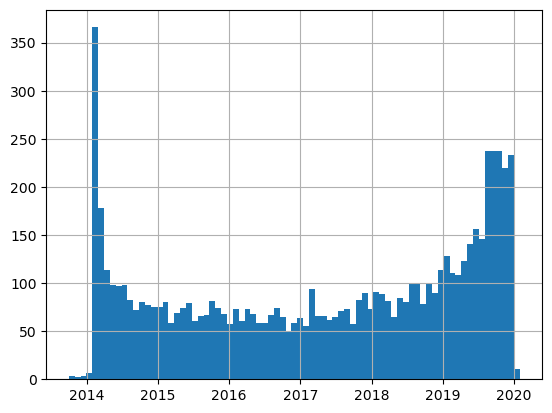

In [13]:
print('Контракты заключены в течение периода с {} по {}'.format(df_contracts['begin_date'].min().strftime("%d.%m.%y"), df_contracts['begin_date'].max().strftime("%d.%m.%y")))
df_contracts['begin_date'].hist(bins=diff_month(df_contracts['begin_date'].min(), df_contracts['begin_date'].max()))

In [14]:
print('Количество завершенных контрактов: {} ({:.0f}%)'.format(df_contracts['end_date'].notna().sum(), df_contracts['end_date'].notna().sum() / len(df_contracts['end_date']) * 100))

Количество завершенных контрактов: 1869 (27%)


In [15]:
dataset_duration = (ACTUAL_DATE.year - df_contracts['begin_date'].min().year) * 12 + ACTUAL_DATE.month - df_contracts['begin_date'].min().month + 1
print('Длительность периода, за который представлены данные: {} месяцев'.format(dataset_duration))

Длительность периода, за который представлены данные: 77 месяцев


count    1869.000000
mean       18.979133
std        19.531123
min         2.000000
25%         3.000000
50%        11.000000
75%        30.000000
max        73.000000
Name: duration, dtype: float64


<AxesSubplot:>

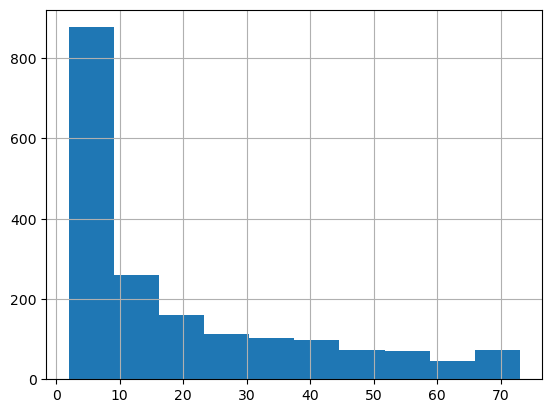

In [16]:
df_ended = df_contracts[df_contracts['end_date'].notna()]
df_ended.loc[:,('duration')] = df_ended.apply(lambda x: (x['end_date'].year - x['begin_date'].year) * 12 + x['end_date'].month - x['begin_date'].month + 1, axis=1)
print(df_ended['duration'].describe())
df_ended['duration'].hist()

In [17]:
def print_value_counts(column, header=''):
    print('\033[1m' + (header if len(header) > 0 else column.name) + '\033[0m')
    print(pd.concat([column.value_counts().rename('Кол-во'), (column.value_counts() / len(column) * 100).apply(lambda s: '{:.0f}'.format(s)).rename('%')], axis=1))    

In [18]:
def check_id(df):
    c_id = df['customer_id'].value_counts()
    print('Количество неуникальных идентификаторов клиента:', c_id[c_id > 1].count())

Теперь изучим категориальные столбцы payment_method, paperless_billing и type.

In [19]:
print_value_counts(df_contracts['payment_method'], 'Способы расчета')
print_value_counts(df_contracts['paperless_billing'], 'Электронный счет')
print_value_counts(df_contracts['type'], 'Тип оплаты по контракту')

Способы расчета
                           Кол-во   %
Electronic check             2365  34
Mailed check                 1612  23
Bank transfer (automatic)    1544  22
Credit card (automatic)      1522  22
Электронный счет
     Кол-во   %
Yes    4171  59
No     2872  41
Тип оплаты по контракту
                Кол-во   %
Month-to-month    3875  55
Two year          1695  24
One year          1473  21


Убедимся в уникальности customerID.

In [20]:
check_id(df_contracts)

Количество неуникальных идентификаторов клиента: 0


И, наконец, посмотрим на распределение значений в стобцах оплаты. Для этого сначала приведем столбец total_charges к числовому типу.

In [21]:
try:
    df_contracts['total_charges'] = pd.to_numeric(df_contracts['total_charges'])
except Exception as ex:
    template = "An exception of type {0} occurred. Arguments:\n{1!r}"
    print(template.format(type(ex).__name__, ex.args))

An exception of type ValueError occurred. Arguments:
('Unable to parse string " " at position 488',)


Видим, что часть значений столбца содержат не пустые строки, а строки с пробелами. Переда изменением типа удалим такие значения, заменив их пустыми строками.

In [22]:
df_contracts['total_charges'] = df_contracts['total_charges'].apply(lambda x: x.replace(' ', ''))
df_contracts['total_charges'] = pd.to_numeric(df_contracts['total_charges'])
pd.concat([df_contracts['monthly_charges'].describe(), df_contracts['total_charges'].describe()], axis=1)

,monthly_charges,total_charges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


In [23]:
df_contracts[df_contracts['total_charges'].isna()]

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN


total_charges естественно не задано для контрактов, заключенных в последний месяц из представленных в датасете.

Итого имеем один бинарный признак (paperless_billing), два категориальных признака (type, payment_method), два численных признака (monthly_charges, total_charges) и даты начала и конца контрактов. Категориальные признаки сбалансированы. Численные признаки распределены не нормально, но без видимых аномалий и выбросов.

### Personal

In [24]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [25]:
df_personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [26]:
print_value_counts(df_personal['gender'], 'Пол')
print_value_counts(df_personal['senior_citizen'], 'Пенсионер')
print_value_counts(df_personal['partner'], 'В браке')
print_value_counts(df_personal['dependents'], 'Есть иждевенцы')

Пол
        Кол-во   %
Male      3555  50
Female    3488  50
Пенсионер
   Кол-во   %
0    5901  84
1    1142  16
В браке
     Кол-во   %
No     3641  52
Yes    3402  48
Есть иждевенцы
     Кол-во   %
No     4933  70
Yes    2110  30


Имеем 4 бинарных признака. Все признаки сбалансированы. Пропусков и аномалий нет. Убедимся в уникальности customer_id.

In [27]:
check_id(df_personal)

Количество неуникальных идентификаторов клиента: 0


### Internet

In [28]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [29]:
df_internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [30]:
for col in df_internet.columns:
    if col != 'customer_id':
        print_value_counts(df_internet[col])

internet_service
             Кол-во   %
Fiber optic    3096  56
DSL            2421  44
online_security
     Кол-во   %
No     3498  63
Yes    2019  37
online_backup
     Кол-во   %
No     3088  56
Yes    2429  44
device_protection
     Кол-во   %
No     3095  56
Yes    2422  44
tech_support
     Кол-во   %
No     3473  63
Yes    2044  37
streaming_tv
     Кол-во   %
No     2810  51
Yes    2707  49
streaming_movies
     Кол-во   %
No     2785  50
Yes    2732  50


Имеем 7 бинарных признаков. Все признаки сбалансированы. Пропусков и аномалий нет. Убедимся в уникальности customer_id.

In [31]:
check_id(df_internet)

Количество неуникальных идентификаторов клиента: 0


### Phone

In [32]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [33]:
print_value_counts(df_phone['multiple_lines'])

multiple_lines
     Кол-во   %
No     3390  53
Yes    2971  47


In [34]:
check_id(df_phone)

Количество неуникальных идентификаторов клиента: 0


Имеем 1 бинарный сбалансированный признак. Аномалий и пропусков в таблице нет. 

### Сравнение таблиц

Сведем теперь полученную информацию в одной таблице с количеством строк и признаков для каждого датафрейма из исходного датасета.

In [35]:
pd.DataFrame([['Contracts', df_contracts.shape[0], df_contracts.shape[1] - 1], ['Personal', df_personal.shape[0], df_personal.shape[1] - 1], ['Internet', df_internet.shape[0], df_internet.shape[1] - 1], ['Phone', df_phone.shape[0], df_phone.shape[1] - 1]], columns=['Таблица', 'Кол-во строк', 'Кол-во признаков'], )

,Таблица,Кол-во строк,Кол-во признаков
0,Contracts,7043,7
1,Personal,7043,4
2,Internet,5517,7
3,Phone,6361,1


Количество строк в таблица с данными об использовании интернета и телефонной связи меньше количества пользователей: не все клиенты пользуются интернетом и телефонной связью одновременно.

## Подготовка признаков

Для подготовки данных для обучения и тестирования моделей сделаем следующее.
- Создадим копии исходных датафреймов, изменять и работать далее будем с ними (небольшой объем данных позволяет легко это сделать);
- Все категориальные бинарные признаки преобразуем к целочисленному типу, заменив, например, пару (Yes, No) на (1, 0), и т.п. Это сделает данные более универсальными и облегчит работу при обучении моделей.

Вообще говоря, последнее не является обязательным - мы могли бы пойти стандартным путем, используя готовые библиотеки и методы для преобразования категориальных переменных в целочисленные (OHE, например), тем более, что с частью категориальных признаков, имеющих более двух значений, нам так и придется поступить. Тем не менее, мы проведем OHE бинарных признаков в ручную: объем работ не большой, а в случае неудовлетворительного результата всегда есть возможность вернутся к готовым библиотекам.

### Contracts

В этой таблице помимо описанных выше манипуляций определим новые столбцы:
- столбец ***ended*** с целевым признаком: *1* - если конракт завершен и в поле *end_date* указана дата; *0* - если контракт действующий и поле *end_date* не заполнено;
- столбец ***begin_month*** с номером месяца, когда контракт был заключен;
- столбец ***duration*** с продолжительностью контракта в месяцах;
- столбец ***avg_charges*** со средними тратами клиента в месяц, определяемыми как отношение общих выплат к продолжительности контракта (*total_charges/duration*)
- столбец ***diff*** с разницей между тратами за месяц из *monthly_charges* и средними тратами клиента в месяц из *avg_charges*.

Последние три столбца нужны, чтобы проанализировать связь *duration*, *total_charges* и *monthly_charges*. Столбец *begin_month* попробуем использовать как дополнительный признак. Номер года использовать не будем, чтобы предотвратить утечку целевого признака. Номер дня недели или номер дня месяца из даты заключения договора использовать также не будем, поскольку в качестве даты заключения всех договоров, как мы видели, используется начало месяца заключения договора.

После определения *duration* и целевого признака *ended* поля с датами начала и окончания договора можем удалить (вместо *duration* мы, конечно, могли бы использовать *begin_date*, но работать с числовым признаком удобнее, поэтому оставляем его). 

In [36]:
df_c = df_contracts.replace({'Yes': 1, 'No': 0}) # все (Yes,No) меняем на (1,0)
df_c['ended'] = df_c.apply(lambda x: 0 if x['end_date'] != x['end_date'] else 1, axis=1) #создаем столбец с целевым признаком
df_c['end_date'] = df_c['end_date'].where(df_c['end_date'] == df_c['end_date'], ACTUAL_DATE) # пустые даты окончания меняем на дату выгрузки
df_c['duration'] = df_c.apply(lambda x: (x['end_date'].year - x['begin_date'].year) * 12 + 
                              x['end_date'].month - x['begin_date'].month + 1, axis=1)
df_c['begin_month'] = df_c['begin_date'].dt.month
# для новых контрактов, заключенных в феврале 2020 года и для которых отсутствует total_charges,
# примем общие траты равными месячным
df_c['total_charges'] = df_c['total_charges'].where(df_c['total_charges'] == df_c['total_charges'], df_c['monthly_charges'])
df_c['avg_charges'] = df_c['total_charges'] / df_c['duration']
df_c['diff'] = df_c['monthly_charges'] - df_c['avg_charges']
df_c.drop(['end_date', 'begin_date'], axis=1, inplace=True)
df_c.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,ended,duration,begin_month,avg_charges,diff
0,7590-VHVEG,Month-to-month,1,Electronic check,29.85,29.85,0,2,1,14.925000,14.925000
1,5575-GNVDE,One year,0,Mailed check,56.95,1889.50,0,35,4,53.985714,2.964286
2,3668-QPYBK,Month-to-month,1,Mailed check,53.85,108.15,1,3,10,36.050000,17.800000
3,7795-CFOCW,One year,0,Bank transfer (automatic),42.30,1840.75,0,46,5,40.016304,2.283696
4,9237-HQITU,Month-to-month,1,Electronic check,70.70,151.65,1,3,9,50.550000,20.150000


Посмотрим теперь как связаны между собою величины *monthly_charges*, *avg_charges*, *total_charges* и *duration*, построив таблицу корреляции.

In [37]:
df_c.loc[:,['monthly_charges', 'avg_charges', 'total_charges', 'duration']].corr()

,monthly_charges,avg_charges,total_charges,duration
monthly_charges,1.000000,0.957366,0.651182,0.247900
avg_charges,0.957366,1.000000,0.764280,0.412480
total_charges,0.651182,0.764280,1.000000,0.826164
duration,0.247900,0.412480,0.826164,1.000000


Для наглядности наложим распределения *monthly_charges* и *avg_charges*, а также построим распределение *diff*.

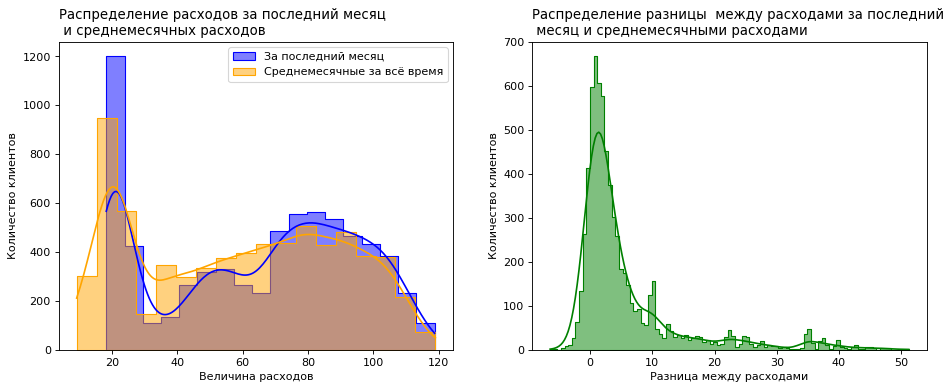

In [38]:
#comment
fig, ax = plt.subplots(1, 2, figsize=(14,5), dpi= 80)
sns.histplot(df_c['monthly_charges'], kde=True, cbar_kws={'alpha':.7}, element="step", ax=ax[0], color='blue', label='За последний месяц')
sns.histplot(df_c['avg_charges'], kde=True, cbar_kws={'alpha':.7}, element="step", ax=ax[0], color='orange', label='Среднемесячные за всё время')
sns.histplot(df_c['diff'], kde=True, cbar_kws={'alpha':.7}, element="step", ax=ax[1], color='green')
ax[0].set_title('Распределение расходов за последний месяц\n и среднемесячных расходов', loc='left')
ax[0].set_xlabel('Величина расходов')
ax[0].set_ylabel('Количество клиентов')
ax[0].legend()
ax[1].set_title('Распределение разницы  между расходами за последний\n месяц и среднемесячными расходами', loc='left')
ax[1].set_xlabel('Разница между расходами')
ax[1].set_ylabel('Количество клиентов')
plt.show()
fig.savefig('fig10')

И из таблица корреляции, и из графиков видим сильную корреляцию между *monthly_charges* и *avg_charges*, таблица корреляции также показывает естественную высокую корреляцию между *total_charges* и *duration*.

Таким образом, из четырех признаков *monthly_charges*, *avg_charges*, *total_charges* и *duration* достаточно использовать какую-либо из пар (*monthly_charges*, *total_charges*), (*monthly_charges*, *duration*), (*avg_charges*, *total_charges*) или (*avg_charges*, *duration*). Мы остановимся на втором варианте (*monthly_charges*, *duration*), хотя с равным успехом могли бы взять и любой другой.

Ввиду высокой корреляции между *monthly_charges* и *avg_charges* мы видим близкое к нормальному распределение параметра *diff*. Однако распределение все-таки не является нормальным, очевидно смещение вправо и наличие заметного хвоста в правой части распределения. Кроме того, нужно учитывать, что это фактически единственный параметр, содержащий хоть какую-то историческую информацию (вероятно, разница в текущих месячных раходах и среднемесячных расходах за весь период договора обусловлена в том числе и изменением условий договоров). Учитывая эти соображения, оставим это поле и будем использовать его в качестве дополнительного признака.

In [39]:
print('Параметры распределение признака diff:')
df_c['diff'].describe()

Параметры распределение признака diff:


count    7043.000000
mean        5.706216
std         8.857927
min        -6.456667
25%         0.756274
50%         2.432857
75%         6.379699
max        51.225000
Name: diff, dtype: float64

In [40]:
df_c.drop(['avg_charges', 'total_charges'], axis=1, inplace=True) # лишние столбцы удаляем
df_c.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,ended,duration,begin_month,diff
0,7590-VHVEG,Month-to-month,1,Electronic check,29.85,0,2,1,14.925000
1,5575-GNVDE,One year,0,Mailed check,56.95,0,35,4,2.964286
2,3668-QPYBK,Month-to-month,1,Mailed check,53.85,1,3,10,17.800000
3,7795-CFOCW,One year,0,Bank transfer (automatic),42.30,0,46,5,2.283696
4,9237-HQITU,Month-to-month,1,Electronic check,70.70,1,3,9,20.150000


### Personal

Как и в предыдущем случае, преобразуем все бинарные признаки в числовой формат.

Вместо столбца *gender* со значениями (*Male*, *Female*) введем столбец *male* со значениями (*1*, *0*) соответственно.

In [41]:
df_p = df_personal.replace({'Yes': 1, 'No': 0})
df_p['male'] = df_p.apply(lambda x: 1 if x['gender'] == 'Male' else 0, axis=1)
df_p.drop('gender', axis=1, inplace=True)
df_p.head()

,customer_id,senior_citizen,partner,dependents,male
0,7590-VHVEG,0,1,0,0
1,5575-GNVDE,0,0,0,1
2,3668-QPYBK,0,0,0,1
3,7795-CFOCW,0,0,0,1
4,9237-HQITU,0,0,0,0


### Internet

Бинарные признаки со значениями Yes/No преобразуем к числовому формату со значениями 1/0. 
<br>Вместо столбца *internet_service* со значениями DSL/Fiber optic создаем столбец *DSL* со значениями 1/0. 
<br>Поскольку не все клиенты пользуются интернетом, введем новый признак *internet*, явно указывающий на то, что клиент использовал услуги интернета (наличие клиента в таблице с данными об интернете как раз и говорит нам о том, что клиент пользовался услугами интернета).

Здесь следует заметить, что поле *internet_service* после объединения таблиц перестанет быть бинарным, поскольку для клиентов, не использующих интернет, его значение будет не определено и равно NaN. Соотвественно, в объединенной таблице этот признак будет принимать одо из трех значений: 0, 1, NaN, и мы могли бы рассматривать NaN как отдельный класс. Мы, однако, упростим задачу и делать этого не будем, заменив в последствии NaN на 0 и сохранив бинарность признака. Если полученные результаты нас не удовлетворят, мы всегда сможем вернуться и модифицировать таблицу признаков.

In [42]:
df_i = df_internet.replace({'Yes': 1, 'No': 0})
df_i['dsl'] = df_i.apply(lambda x: 1 if x['internet_service'] == 'DSL' else 0, axis=1)
df_i['internet'] = 1
df_i.drop('internet_service', axis=1, inplace=True)
df_i.head()

,customer_id,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,dsl,internet
0,7590-VHVEG,0,1,0,0,0,0,1,1
1,5575-GNVDE,1,0,1,0,0,0,1,1
2,3668-QPYBK,1,1,0,0,0,0,1,1
3,7795-CFOCW,1,0,1,1,0,0,1,1
4,9237-HQITU,0,0,0,0,0,0,0,1


### Phone

Бинарные признаки со значениями Yes/No преобразуем к числовому формату со значениями 1/0. 
<br>Поскольку не все клиенты используют телефонную связь, введем новый признак *phone*, явно указывающий на то, что клиент пользовался услугами телефонной связи (наличие клиента в таблице с данными о телефонной связи как раз и говорит нам о том, что клиент пользовался услугами телефона).

Всё сказанное в предыдущем пункте относительно *internet_service* в полной мере относится и к признаку *multiple_lines*: в объединенной таблице он, строго говоря, перестанет быть бинарным. Но как и в случае с типом интернет-соединения мы не станем рассматривать для признака многоканальности отдельный класс NaN, заменив его в дальнейшем на *0*.

In [43]:
df_ph = df_phone.replace({'Yes': 1, 'No': 0})
df_ph['phone'] = 1
df_ph.head()

,customer_id,multiple_lines,phone
0,5575-GNVDE,0,1
1,3668-QPYBK,0,1
2,9237-HQITU,0,1
3,9305-CDSKC,1,1
4,1452-KIOVK,1,1


### Итоговая таблица признаков

Объединим теперь все таблицы, создав единую таблицу, содержащую все признаки. В качестве объединяющего столбца будем, естественно, использовать *customer_id*. После объединения этот столбец удалим.

In [44]:
df_total = df_c.merge(df_p, how='left', on='customer_id').merge(df_i, how='left', on='customer_id').merge(df_ph, how='left', on='customer_id')
df_total.fillna(0, inplace=True) # все пустые значения заполняем нулями
df_total.drop('customer_id', axis=1, inplace=True)

Подготовим наборы столбцов с числовыми, категориальными и бинарными признаками. Все бинарные признаки приведем к целочисленному типу.

In [45]:
target_column = ['ended']
numeric_columns = ['monthly_charges', 'duration', 'diff']
categorical_columns = ['type', 'payment_method', 'begin_month']
binary_columns = list(set(df_total.columns) - set(numeric_columns) - set(categorical_columns) - set(target_column))

In [46]:
print('Размер итоговой матрицы признаков:', df_total.shape)

Размер итоговой матрицы признаков: (7043, 22)


Таким образом, мы получили следующий датасет:
 * количество объектов: 7043
 * количество признаков: 21
 * целевой признак: 1

In [47]:
#comment
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].set_title('Доля ушедших клиентов в датасете')
ax[0].pie(df_total['ended'].value_counts().tolist(), labels=['Остались', 'Ушли'], shadow=True, autopct='%1.1f%%', startangle=0)
ax[0].axis('equal')

df_usl = df_total.loc[:, ['phone', 'internet']].astype('int')
df_usl['internet'] = df_usl['internet'].where(df_usl['internet'] == 0, 2)
df_usl['total'] = df_usl.apply(np.sum, axis=1)
#df_usl['total'].value_counts().sort_index().tolist()
ax[1].set_title('Доля пользователей интернета и телефонии')
ax[1].pie(df_usl['total'].value_counts().sort_index().tolist(), labels=['Только телефон', 'Только Интернет', 'Телефон + Интернет'], shadow=True, autopct='%1.1f%%', startangle=100)
ax[1].axis('equal')
fig.savefig('fig1', bbox_inches='tight')
plt.close(fig)
#plt.show(0)

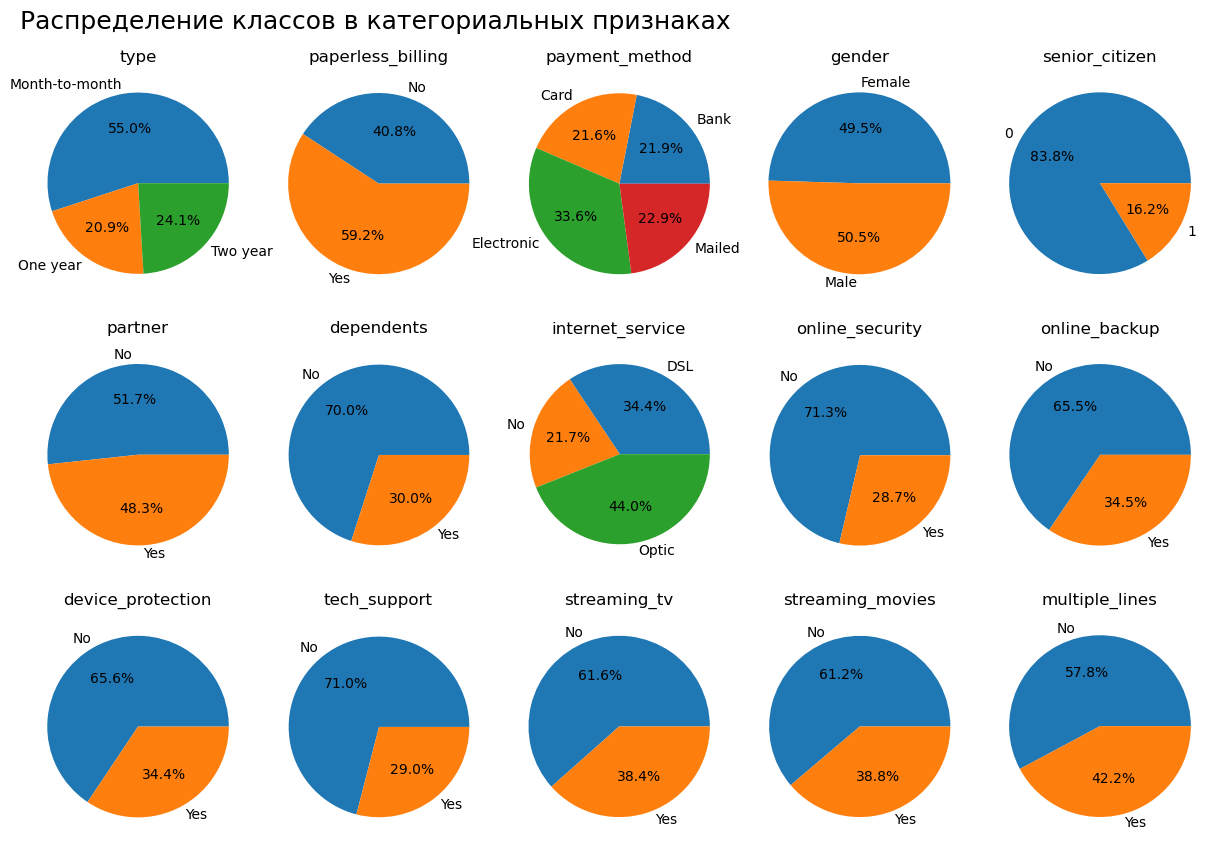

In [48]:
#comment
df_total_init = df_contracts.merge(df_personal, how='left', on='customer_id').merge(df_internet, how='left', on='customer_id').merge(df_phone, how='left', on='customer_id')
df_total_init.fillna('No', inplace=True)
df_total_init.replace({'Electronic check': 'Electronic', 'Mailed check': 'Mailed', 'Bank transfer (automatic)': 'Bank', 'Credit card (automatic)': 'Card', 'Fiber optic': 'Optic'}, inplace=True)
df_total_init.drop(['customer_id', 'begin_date', 'end_date', 'monthly_charges', 'total_charges'], axis=1, inplace=True)
df_total_init.shape
fig, ax = plt.subplots(3, 5, figsize=(15, 10))
axs = [ax[i][j] for i in range(3) for j in range(5)]

for i, col in enumerate(df_total_init.columns):
        data = df_total_init[col].value_counts().sort_index()
        axs[i].set_title(col)
        axs[i].pie(data.tolist(), labels=data.index.tolist(), shadow=False, autopct='%1.1f%%', startangle=0)
        axs[i].axis('equal')
#plt.title("Распределение классов в признаках", fontsize=18, loc='left')
fig.suptitle('Распределение классов в категориальных признаках', x=0.35, y = 0.94, fontsize = 18)
#fig.savefig('classes', bbox_inches='tight', dpi=300)
plt.show()
#plt.close(fig)

In [49]:
#comment
fig, ax = plt.subplots(1, 2, figsize=(9,3), dpi= 80)
for i, column in enumerate(['monthly_charges', 'total_charges']):
    sns.histplot(df_contracts[column], kde=True, cbar_kws={'alpha':.7}, element="step", ax=ax[i])
    ax[i].set_xlabel("Величина расходов")
    ax[i].set_ylabel("")
ax[0].set_ylabel("Количество клиентов")
ax[0].set_title('Распределение расходов за месяц')
ax[1].set_title('Распределение расходов за весь период')
fig.savefig('fig3', bbox_inches='tight')
plt.close(fig)

### Корреляция признаков

#### Таблица корреляции

Исследуем корреляцию полученных признаков - если найдем сильную взаимосвязь, то скорее всего потребуется дополнительная подготовка признаков с целью устранения мультиколлинеарности. Это особено актуально для линейных моделей (в том числе для логистической регрессии, которую мы будем исследовать), поскольку может приводить к искажению коэффициентов модели и затруднять её интерпретацию.

Поскольку большинство наших признаков являются дихотомическими, будем использовать коэффициент корреляции $\varphi$, поскольку стандартный коэффициент Пирсона может работать в данном случае некорректно.

В таблице корреляции оставим только признаки с коэффициентом корреляции, большим по модулю чем 0.8.

In [50]:
porog = 0.8 # будем смотреть только признаки с коэффициентом корреляции больше этого значения

In [51]:
df_corr_phik = df_total.phik_matrix()
ind = df_corr_phik[(((df_corr_phik.gt(porog)) | (df_corr_phik.lt(-porog))) & (df_corr_phik.ne(1))).any()].index
df_corr_phik.loc[ind, ind]

interval columns not set, guessing: ['paperless_billing', 'monthly_charges', 'ended', 'duration', 'begin_month', 'diff', 'senior_citizen', 'partner', 'dependents', 'male', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'dsl', 'internet', 'multiple_lines', 'phone']


,monthly_charges,streaming_tv,streaming_movies,dsl,internet,phone
monthly_charges,1.000000,0.835340,0.833307,0.949706,0.998690,0.831362
streaming_tv,0.835340,1.000000,0.742479,0.016694,0.606754,0.029197
streaming_movies,0.833307,0.742479,1.000000,0.035214,0.610648,0.047426
dsl,0.949706,0.016694,0.035214,1.000000,0.562230,0.651591
internet,0.998690,0.606754,0.610648,0.562230,1.000000,0.265727
phone,0.831362,0.029197,0.047426,0.651591,0.265727,1.000000


Видим наличие сильной корреляции между частью признаков. Для корректной работы логистической регрессии подготовим для неё отдельную таблицу признаков, удалив коллинеарные признаки.

#### Устранение мультиколлинеарности

Для устранения мультиколлинеарности просто воспользуемся исключением признаков по заданному порогу для коэффициентов корреляции. У такого метода есть естественные минусы: он не гарантирует исключение минимально возможного количества признаков и не учитывает взаимосвязь с целевой переменной, из-за чего можно потерять потенциально полезные признаки до этапа моделирования. 

В нашем случае признаков не так много, а коллинеарных и того меньше. Устраним мультиколлинеарность в ручную, если результаты работы модели будут неудовлетворительными, то можно будет попробовать другие способы.

В нашем случае мультколлинеарность устраняется удалением всего одного признака *monthly_charges*. Проверим это.

In [52]:
df_total_l = df_total.drop('monthly_charges', axis=1)

In [53]:
df_corr_phik = df_total_l.phik_matrix()
ind = df_corr_phik[(((df_corr_phik.gt(porog)) | (df_corr_phik.lt(-porog))) & (df_corr_phik.ne(1))).any()].index
df_corr_phik.loc[ind, ind]

interval columns not set, guessing: ['paperless_billing', 'ended', 'duration', 'begin_month', 'diff', 'senior_citizen', 'partner', 'dependents', 'male', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'dsl', 'internet', 'multiple_lines', 'phone']


""


Мультиколлинеарность устранена. Для логистрической регрессии будем использовать все признаки кроме *monthly_charges*.

## Разделение выборки

Все предварительные работы проведены и мы можем переходить к формированию обучающей и тестовой выборок. Делить выборки будем в отношение 3 к 1.

In [54]:
features = df_total.drop('ended', axis=1) # таблица признаков
target = df_total['ended'] # целевой признак
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

Для моделей, не умеющих работать с "грязными" данными, подготовим сразу таблицу с отнормированными численными признаками и категориальными признаками, закодированными с помощью OHE. Для нормализации будем использовать MinMaxScaler, поскольку распределение и *monthly_charges*, и *duration* далеки от нормального, но при этом распределения численных признаков не демонстрируют и каких-то значительных выбросов.

In [55]:
features_norm = features.copy()
features_norm = pd.get_dummies(features_norm, columns=['type', 'payment_method'], drop_first=True)
df_total_norm = pd.get_dummies(df_total, columns=['type', 'payment_method'], drop_first=True)
features_train_norm, features_test_norm = train_test_split(features_norm, test_size=0.25, random_state=RANDOM_STATE)

scaler_minmax = MinMaxScaler()
scaler_minmax.fit(features_train_norm[numeric_columns])
features_train_norm.loc[:, numeric_columns] = scaler_minmax.transform(features_train_norm[numeric_columns])
features_test_norm.loc[:, numeric_columns] = scaler_minmax.transform(features_test_norm[numeric_columns])
df_total_norm.loc[:, numeric_columns] = scaler_minmax.transform(df_total_norm[numeric_columns])

Проверим на всякий случай, не нарушен ли баланс классов в обучающей и тестовой выборках.

In [56]:
print(pd.DataFrame([['{:.2f}%'.format(target_train.sum() / len(target_train) * 100)], ['{:.2f}%'.format(target_test.sum() / len(target_test) * 100)]], index=['train', 'test'], columns=['положительный класс']))

      положительный класс
train              26.05%
test               28.00%


Как видим, баланс в обеих выборках сохранен на изначальом уровне.

## Исследование моделей

### Логистическая регрессия

Начнем с простейшей модели - логистической регрессии. Подбор гиперпараметров будем выполнять с помощью RandomizedSearchCV, используя кроссвалидацию по 5 подвыборкам.

In [57]:
lr = LogisticRegression()

param_dist = {'solver': ['lbfgs', 'liblinear'],
              'C': [0.01, 0.05, 0.1, 1.5, 2.5, 10.0, 20.0],
              'max_iter': sp_randint(100, 300),
              'class_weight': ['balanced', None],
              'random_state': [RANDOM_STATE]}
n_iter_search = 30
random_search = RandomizedSearchCV(lr, param_distributions=param_dist, scoring='roc_auc',
                                   n_iter=n_iter_search, cv=5, verbose=1)
random_search.fit(features_train_norm.drop('monthly_charges', axis=1), target_train)
lr = random_search.best_estimator_
best_params_lr = random_search.best_params_
best_score = random_search.best_score_
print('Лучшая оценка для логистической регрессии:', best_score)
print('При следующих значениях гиперпараметров:\n', best_params_lr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Лучшая оценка для логистической регрессии: 0.8500466175123493
При следующих значениях гиперпараметров:
 {'C': 2.5, 'class_weight': None, 'max_iter': 260, 'random_state': 190922, 'solver': 'lbfgs'}


In [58]:
#comment
#lr = LogisticRegression(solver='lbfgs',
#              C=1.5,
#              max_iter=172,
#              class_weight= None,
#              random_state=RANDOM_STATE)
#lr.fit(features_train_norm.drop('monthly_charges', axis=1), target_train)
#predicted_prob_lr = lr.predict_proba(features_test_norm.drop('monthly_charges', axis=1))[:,1]
#print('Значение ROC-AUC на тестовой выборке:', roc_auc_score(target_test, predicted_prob_lr))

In [59]:
scores = pd.DataFrame([[best_score]], index=['LogisticRegression'], columns=['ROC-AUC'])

### Случайный лес

Возьмем более сложную модель - случайный лес. Как и ранее подбор гиперпараметров будем выполнять с помощью RandomizedSearchCV, используя кроссвалидацию по 5 подвыборкам.

In [60]:
f_count = features_train_norm.shape[1]
clf = RandomForestClassifier(random_state=RANDOM_STATE)

param_dist = {'n_estimators': sp_randint(1, 151),
              'max_depth': [None], 
              'max_features': sp_randint(1, f_count + 1),
              'min_samples_split': sp_randint(2, f_count + 1),
              'min_samples_leaf': sp_randint(2, f_count + 1),
              'bootstrap': [True, False],
              'class_weight': ['balanced', None],
              'criterion': ["gini", "entropy"]}  
n_iter_search = 30
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, scoring='roc_auc',
                                   n_iter=n_iter_search, cv=5, verbose=1, random_state=RANDOM_STATE)
random_search.fit(features_train_norm, target_train)
clf = random_search.best_estimator_
best_params_clf = random_search.best_params_
best_score = random_search.best_score_
print('Лучшая оценка для случайного леса:', best_score)
print('При следующих значениях гиперпараметров:\n', best_params_clf)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Лучшая оценка для случайного леса: 0.9097141991118007
При следующих значениях гиперпараметров:
 {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 22, 'min_samples_leaf': 7, 'min_samples_split': 3, 'n_estimators': 84}


In [61]:
scores = pd.concat([scores, pd.DataFrame([[best_score]], index=['RandomForestClassifier'], columns=['ROC-AUC'])], axis=0)

### CatBoost

Посмотрим, какие результаты даст модель CatBoost. Для подбора гиперпараметров используем метод randomized_search с кроссвалидацией по 5 подвыборкам.

In [62]:
cbc = CatBoostClassifier(eval_metric='AUC', random_seed=RANDOM_STATE, verbose=False, cat_features=['type', 'payment_method'])
param_dist = {'learning_rate': stats.uniform(0.0005, 0.9),
              'depth': sp_randint(3, 50),
              'l2_leaf_reg': sp_randint(1, 30),
              'iterations': sp_randint(2, 200)}

n_iter_search = 30
random_search = RandomizedSearchCV(cbc, param_distributions=param_dist, scoring='roc_auc',
                                   n_iter=n_iter_search, cv=5, verbose=1, random_state=RANDOM_STATE)
random_search.fit(features_train, target_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


E:\Users\LDV\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
115 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
115 fits failed with the following error:
Traceback (most recent call last):
  File "E:\Users\LDV\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\LDV\AppData\Roaming\Python\Python39\site-packages\catboost\core.py", line 5128, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\LDV\AppData\Roaming\Python\Python39\site-packages\

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x000000B5024D6EE0>,
                   n_iter=30,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000000B5024D8D60>,
                                        'iterations': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000000B5024E8F10>,
                                        'l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000000B5026BD730>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000000B5024D6850>},
                   random_state=190922, scoring='roc_auc', verbose=1)

In [63]:
cbc = random_search.best_estimator_
best_params_cbc = random_search.best_params_
best_score = random_search.best_score_
print('Лучшая оценка для бустинга:', best_score)
print('При следующих значениях гиперпараметров:\n', best_params_cbc)

Лучшая оценка для бустинга: 0.9892973629791401
При следующих значениях гиперпараметров:
 {'depth': 9, 'iterations': 163, 'l2_leaf_reg': 20, 'learning_rate': 0.6361938784799448}


In [64]:
scores = pd.concat([scores, pd.DataFrame([[best_score]], index=['CatBoostClassifier'], columns=['ROC-AUC'])], axis=0)

### Выбор модели

Выведем таблицу с результатами исследованных моделей.

In [65]:
scores

,ROC-AUC
LogisticRegression,0.850047
RandomForestClassifier,0.909714
CatBoostClassifier,0.989297


Ожидаемо лучший результат показал CatBoost. Эту модель мы и выберем для дальнейшего тестирования.

## Тестирование модели

### Результаты на тестовой выборке

Проведем тест выбранной модели на тестовой выборке.

In [66]:
cbc.fit(features_train, target_train, verbose=0)

In [67]:
predicted_prob = cbc.predict_proba(features_test, verbose=0)[:,1]
print('Значение ROC-AUC на тестовой выборке:', roc_auc_score(target_test, predicted_prob))

Значение ROC-AUC на тестовой выборке: 0.9903619121966203


Полученный результат полностью удовлетворяет заданным требованиям (ROC-AUC > 0.81).

Построим ROC кривую.

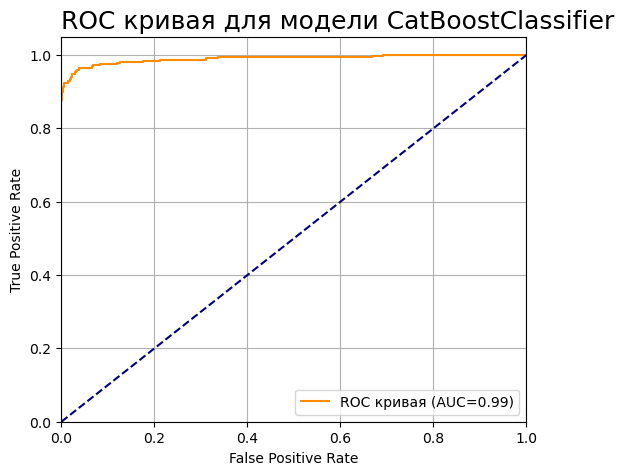

In [68]:
#comment
fpr, tpr, treshold = roc_curve(target_test, predicted_prob)
roc_auc = auc(fpr, tpr)

fig, ax1 = plt.subplots(figsize=(6, 5))
l1, = ax1.plot(fpr, tpr, color='darkorange', label='ROC кривая (AUC=%0.2f)' % roc_auc)
ax1.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_ylabel('True Positive Rate')
label1 = 'ROC кривая (AUC=%0.2f)' % roc_auc
ax1.legend(handles=[l1])
ax1.grid()
ax1.set_title('ROC кривая для модели CatBoostClassifier', loc='left', fontsize=18)
plt.show()
#fig.savefig('fig4', bbox_inches='tight')

### Оценка важности признаков

Проанализируем какие признаки оказывают наиболее существенное влияние на точность модели. В настоящем случае это не принципиальная информация: число признаков невелико и задача сокращения их количества посредством отбрасывания наименее важных перед нами не стоит. Тем не менее, для последующего анализ эта информация может пригодиться, поэтому приведем график с важностью для каждого из 21 использованных признаков.

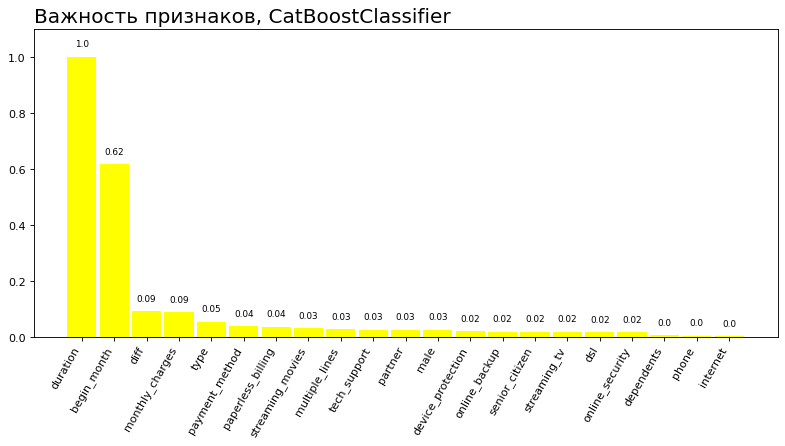

In [69]:
#comment
importances_cbc = pd.DataFrame([features_test.columns, cbc.feature_importances_], index=['feature', 'importance']).T.sort_values(by='importance', ascending=False)
importances_cbc['importance'] = importances_cbc['importance'] / importances_cbc['importance'].max()
ax = plt.figure(figsize=(12,5), dpi= 80).add_subplot()
plt.bar(importances_cbc['feature'], importances_cbc['importance'], color='yellow', alpha=1, width=.9, label='feature importance')
ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(ax.get_xticks()))
ax.set_xticklabels(importances_cbc['feature'], rotation=60, horizontalalignment= 'right')
plt.title("Важность признаков, CatBoostClassifier", fontsize=18, loc='left')
imp = importances_cbc['importance'].tolist()
for i, f in enumerate(importances_cbc['feature'].tolist()):
    plt.text(f, imp[i]+0.03, s=round(imp[i], 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=8)
plt.ylim(0, 1.1)
plt.show()
#fig.savefig('importance0', bbox_inches='tight', dpi=300)

Судя по всему, добавленные нами признаки *internet* и *phone* на качество предсказаний практически не влияют. Зато неожиданно большую важность имеет признак номера месяца начала контракта и его продолжительность. И хотя нам данная информация не очень нужна, маркетингу она вполне может быть интересна. Например, вполне можно проанализировать зависимость ухода клиентов от месяца заключения контракта (распределение клиентов по месяцам начала договора приведено ниже).

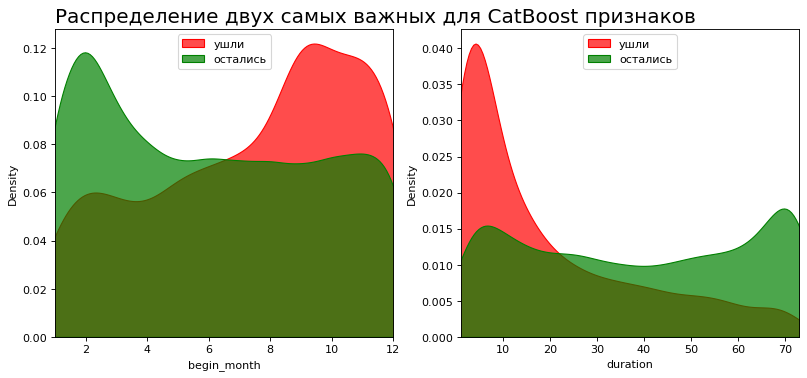

In [70]:
#comment
fig, ax = plt.subplots(1, 2, figsize=(12,5), dpi= 80)
sns.kdeplot(df_total.query('ended == 1')['begin_month'], shade=True, color="red", label="ушли", alpha=.7, ax=ax[0])
sns.kdeplot(df_total.query('ended == 0')['begin_month'], shade=True, color="green", label="остались", alpha=.7, ax=ax[0])
ax[0].set_xlim([1, 12])
ax[0].legend(loc='upper center')
sns.kdeplot(df_total.query('ended == 1')['duration'], shade=True, color="red", label="ушли", alpha=.7, ax=ax[1])
sns.kdeplot(df_total.query('ended == 0')['duration'], shade=True, color="green", label="остались", alpha=.7, ax=ax[1])
ax[0].set_xlim([1, 12])
ax[0].legend(loc='upper center')
ax[1].set_xlim([1, df_total['duration'].max()])
ax[1].legend(loc='upper center')
ax[0].set_title('Распределение двух самых важных для CatBoost признаков', loc='left', fontsize = 18)
plt.show()

Для наглядности приведем также сопоставление важности признаков с точки зрения каждой из исследованных моделей (для этого обучим CatBoost на том же нормированном датасете, что и лес с логистической регрессией).

In [71]:
cbc = CatBoostClassifier(eval_metric='AUC', 
                         random_seed=RANDOM_STATE, 
                         l2_leaf_reg=best_params_cbc['l2_leaf_reg'], 
                         depth=best_params_cbc['depth'], 
                         learning_rate=best_params_cbc['learning_rate'], 
                         iterations=best_params_cbc['iterations'])
cbc.fit(features_train_norm, target_train, verbose=0)
lr.fit(features_train_norm.drop('monthly_charges', axis=1), target_train)
clf.fit(features_train_norm, target_train)

RandomForestClassifier(class_weight='balanced', max_features=22,
                       min_samples_leaf=7, min_samples_split=3, n_estimators=84,
                       random_state=190922)

In [72]:
#comment
importances = pd.DataFrame([features_test_norm.columns, cbc.feature_importances_], index=['feature', 'importance_cbc']).T
importances['importance_cbc'] = importances['importance_cbc'] / importances['importance_cbc'].max()
importances1 = pd.DataFrame([features_test_norm.columns, clf.feature_importances_], index=['feature', 'importance_clf']).T
importances1['importance_clf'] = importances1['importance_clf'] / importances1['importance_clf'].max()
importances = importances.merge(importances1, on='feature', how='left')
importances2 = pd.DataFrame([features_test_norm.drop('monthly_charges', axis=1).columns, lr.coef_[0]], index=['feature', 'importance_lr']).T
importances2['importance_lr'] = importances2['importance_lr'].abs()
importances2['importance_lr'] = importances2['importance_lr'] / importances2['importance_lr'].max()
importances = importances.merge(importances2, on='feature', how='left').sort_values(by='importance_cbc', ascending=False).fillna(0)
importances = importances.sort_values(by='importance_cbc', ascending=False)

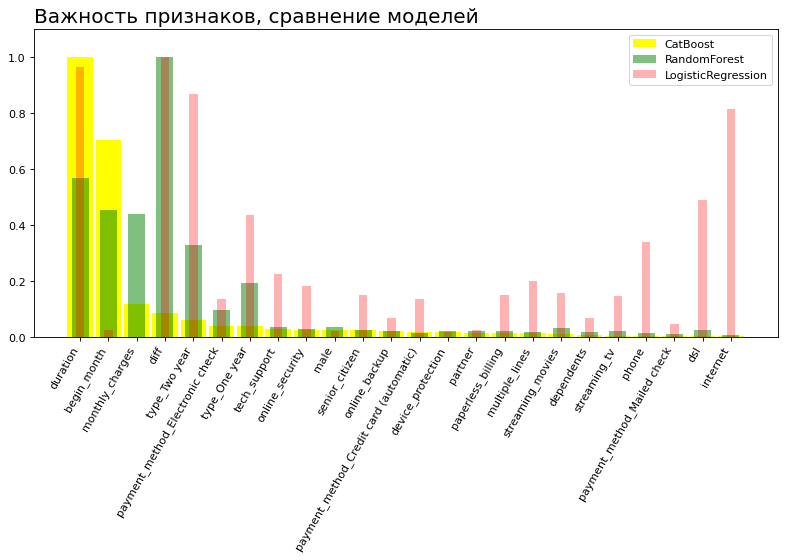

In [73]:
#comment
ax = plt.figure(figsize=(12,5), dpi= 80).add_subplot()
plt.bar(importances['feature'], importances['importance_cbc'], color='yellow', alpha=1, width=.9, label='CatBoost')
plt.bar(importances['feature'], importances['importance_clf'], color='green', alpha=0.5, width=.6, label='RandomForest')
plt.bar(importances['feature'], importances['importance_lr'], color='red', alpha=0.3, width=.3, label='LogisticRegression')
ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(ax.get_xticks()))
ax.set_xticklabels(importances['feature'], rotation=60, horizontalalignment= 'right')
ax.set_title("Важность признаков, сравнение моделей", fontsize=18, loc='left')
imp = importances['importance_cbc'].tolist()
plt.ylim(0, 1.1)
plt.legend()
plt.show()
#fig.savefig('importance1', bbox_inches='tight', dpi=300)

Видим, что наборы наиболее важных для прогнозирования признаков в CatBoost и в случайном лесу примерно совпадают, в то время как для логистической регрессии он совершенно иной.

### Полнота и точность

Для представления результатов работы модели в терминах бизнеса перейдем от метрики ROC-AUC, использовавшейся для оптимизации модели, к метрикам точности и полноты. Зачение этих метрик будут зависеть от пороговой вероятности, использующейся для разделения классов в предсказаниях модели. 

Посмотрим как меняются точность и полнота в зависимости от значения пороговой вероятности.

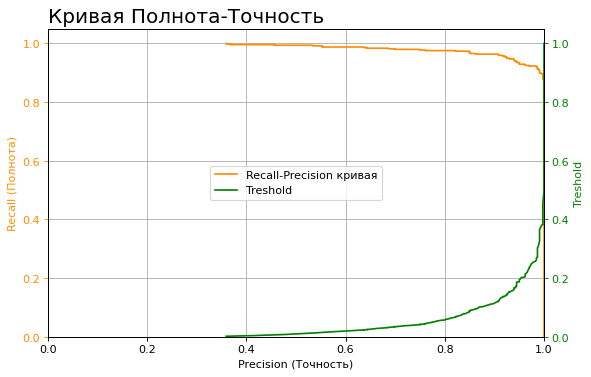

In [74]:
#comment
precision, recall, thresholds = precision_recall_curve(target_test, predicted_prob)
fig = plt.figure(figsize=(8, 5), dpi=80)
ax1 = fig.add_subplot()
l1, = ax1.plot(precision, recall, color='darkorange', label='Recall-Precision кривая')
ax1.set_xlabel('Precision (Точность)')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_ylabel('Recall (Полнота)', color='darkorange')
ax1.tick_params('y', colors='darkorange')
ax2 = ax1.twinx()
l2, = ax2.plot(precision[1:], thresholds, color='g', label='Treshold')
ax2.set_ylabel('Treshold', color='g')
ax2.set_ylim([0.0, 1.05])
ax2.tick_params('y', colors='g')
ax1.legend(handles=[l1, l2], loc='center')
ax1.grid()
ax1.set_title('Кривая Полнота-Точность', fontdict={'fontsize': 18}, loc='left')
#fig.tight_layout()
plt.show()
#fig.savefig('fig6', bbox_inches='tight', dpi=300)

Как и следовало ожидать, с уменьшением пороговой вероятности полнота возрастает, но при этом уменьшаеся точность. Выбор конкретного значения пороговой вероятности должен производиться с участием представителей бизнеса, поскольку выбор этот определяется финансовыми параметрами бизнеса. В данном случае увеличение полноты (т.е. уменьшение ложноотрицательных предсказаний) приведет к уменьшению точности (т.е. к увеличению ложноположительных предсказаний). Очевидно, что порог принятия решения должен выбираться, исходя из стоимости мероприятий, планируемых для удержания клиента и стоимости ухода клиента. 

Мы для примера возьмем значение пороговой вероятности, равное 0.1.

In [75]:
threshold = 0.1
predicted = np.where(predicted_prob > threshold, 1, 0)

In [76]:
print('Пороговое значение:', threshold)
print('Значение Recall (полнота): {}'.format(recall_score(target_test, predicted)))
print('Значение Precision (точность): {}'.format(precision_score(target_test, predicted)))
print('Значение Accuracy: {}'.format(accuracy_score(target_test, predicted)))

Пороговое значение: 0.1
Значение Recall (полнота): 0.9634888438133874
Значение Precision (точность): 0.8683729433272395
Значение Accuracy: 0.948892674616695


### Матрица ошибок

Для иллюстрации стоимости выбора того или иного порога принятия решения стоит воспользоваться матрицей ошибок, показывающей количество ложноположительных и ложноотрицательных предсказаний модели.

In [77]:
conf_matrix = np.flip(confusion_matrix(target_test, predicted))

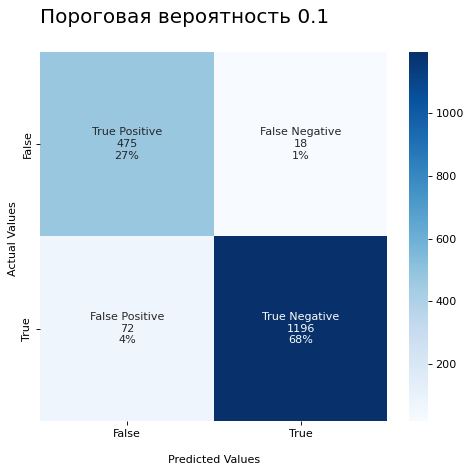

In [78]:
#comment
names = ['True Positive', 'False Negative', 'False Positive', 'True Negative']
counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
percentages = ["{0:.0%}".format(value) for value in conf_matrix.flatten()/conf_matrix.sum()]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
labels = np.asarray(labels).reshape(2,2)

fig = plt.figure(figsize=(7, 6), dpi= 80)
ax = sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Пороговая вероятность {}\n'.format(threshold), fontsize=18, loc='left')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()
fig.savefig('fig7', bbox_inches='tight', dpi=300)

При выбранном пороге доля ложных предсказаний составляет около 10%, из которых всего 3% - это ложноотрицательные предсказания. Т.е. лишь в 3% случаев модель не предскажет уход клиента.

## Отчет

### Введение

#### Общее описание задачи

Оператор связи «Ниединогоразрыва.ком» предоставляет два основных типа услуг:<br> 
1. **Стационарную телефонную связь**. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. **Интернет**. Подключение может быть двух типов: через телефонную линию или оптоволоконный кабель.  

Также доступны дополнительные услуги:<br> 
- интернет-безопасность: антивирус и блокировка небезопасных сайтов;
- выделенная линия технической поддержки;
- облачное хранилище файлов для резервного копирования данных;
- стриминговое телевидение и каталог фильмов.

За услуги клиенты могут платить ежемесячно или сразу за 1 или 2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Оператору необходимо научиться прогнозировать отток клиентов. Раннее прогнозирование ухода позволит задействовать различные маркетинговые мероприятия (например, промокоды или специальные условия) с целью предотвратить уход. 

#### Цель проекта

Наша цель - разработать не менее двух моделей машинного обучения, способных с заданной точностью предсказывать уход клиента по предоставленной оператором связи информации об этом клиенте. 

Требований к быстродействию моделей не предъявляется. 

Оценка качества модели должна производиться с помощью метрики ROC-AUC. Целевое значение метрики должно быть больше 0.81. 

Из разработанных моделей необходимо выбрать лучшую и провести её тестирование.

Отдельно заметим, что нахождение модели с максимально возможным ROC-AUC не входило в рамки настоящего исследования, и нам необходимо лишь было построить модель с метрикой, превышающей заданное пороговое значение.

Время выполнения проекта - 14 календарных дней.

#### Данные

Оператором предоставлены следующие файлы с данными:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Все файлы содержат столбец **`customer_id`** с уникальным идентификатором клиента.
<br>Здесь и далее название столбцов приведены в соответствии со стандартами, принятыми для Python ("змеинный" стиль), а не в оригинальном написании ("верблюжий" стиль).

Информация актуальна на 1 февраля 2020.

Предоставленный оператором связи датасет содержит информацию о 19 признаках, описывающих клиента, условия контракта и услуги, которыми он пользуется:

№ | Признак | Тип признака | Значение | Описание 
:---|:---|:---:|:---|:---
1 | **`begin_date`** | дата | 01.10.2013 - 01.02.2020 | дата начала контракта
2 | **`end_date`** | дата | 01.10.2019 - ... | дата окончания контракта (не заполнено, если контракт действующий)
3 | **`type`** | категориальный | Month-to-month<br>One year<br>Two year | тип контракта: оплата ежемесячно, за 1 год, за 2 года
4 | **`paperless_billing`** | категориальный | 0, 1 | расчеты с клиентом осуществляются в электронном виде
5 | **`payment_method`** | категориальный | Electronic check<br>Mailed check<br>Bank transfer (automatic)<br>Credit card (automatic)  | способ оплаты услуг клиентом
6 | **`monthly_charges`** | числовой | 18.25 ... 118.75 | раходы клиента за последнй месяц
7 | **`total_charges`** | числовой | 18.80 ... 8 684.80 | расходы клиента за весь период действия договора
8 | **`gender`** | категориальный | male<br>female | пол клиента
9 | **`senior_citizen`** | категориальный | 0, 1 | признак того, является ли клиент пенсионером
10 | **`partner`** | категориальный | 0, 1 | признак того, состоит ли клиент в браке
11 | **`dependents`** | категориальный | 0, 1 | наличие у клиента иждевенцев
12 | **`internet_service`** | категориальный | DSL<br>Fiber optic | тип подкличения клиента сети Интернет
13 | **`online_security`** | категориальный | 0, 1 | признак того, что клиент пользуется услугой блокировки небезопасных сайтов
14 | **`online_backup`** | категориальный | 0, 1 | признак того, что клиент пользуется услугой облачного хранилища для резервного копирования данных 
15 | **`device_protection`** | категориальный | 0, 1 | признак того, что клиент пользуется услугой антивируса
16 | **`tech_support`** | категориальный | 0, 1 | признак того, что клиент пользуется услугами выделенной линии техподдержки
17 | **`streaming_tv`** | категориальный | 0, 1 | признак того, что клиент пользуется онлайн телевидением
18 | **`streaming_movies`** | категориальный | 0, 1 | признак того, что клиент пользуется услугами онлайн кинотеатра
19 | **`multiple_lines`** | категориальный | 0, 1 | признак того, что клиент пользуется услугой многоканальной телефонной связи

Данные содержат информацию об 7043 объектах, из которых 5517 пользовались или пользуются услугами интернета, а 6361 - услугами телефонии. Почти 69% клиентов пользовались или пользуются и телефонией, и доступом в Интернет.

Пропусков и аномалий в предоставленных данных нет (за исключением, естественно, даты окончания договора, которая не заполнена для действующих договоров).

Доля законченных договоров (положительный класс целевого признака) составляет около 27% - наблюдаем небольшой дисбаланс классов.

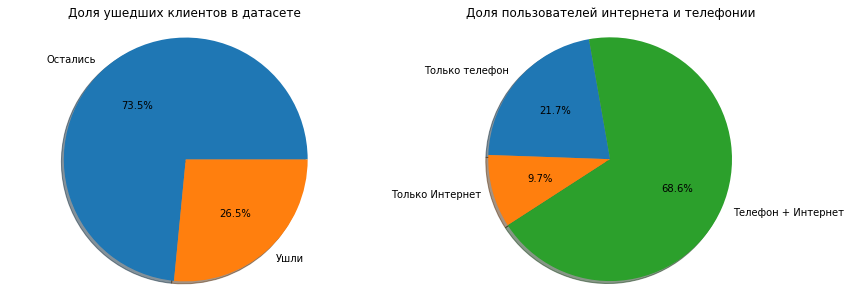

In [79]:
#comment
base64_data = 'iVBORw0KGgoAAAANSUhEUgAAA1MAAAEuCAYAAABrm0iqAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAB2r0lEQVR4nO3deXhU5fn/8fc9W5LJCoFAwhbA4BoVt7hrXbpZq7YutfZbbGt/3eze2ny7Wr9dbGt3W7vYVqrWrdWWGq1a9xU3xOASEAUEAoSQZJJMklnO8/vjnMCACQkhk2eW+3VduWCWc+Yzk8mcuc+ziTEGpZRSSimllFJ7xmc7gFJKKaWUUkplIy2mlFJKKaWUUmoMtJhSSimllFJKqTHQYkoppZRSSimlxkCLKaWUUkoppZQaAy2mlFJKKaWUUmoMtJhSSimllNoDIlIjIh8QEb+IvEtEDrCdSSllhxZTwxCRi0UkKSI93k+/iDxmO5dSSqnMpMeNvLIN+DCwFfg20GY3jpooIlIrIkZEArazqMygxdTuPWmMKTHGlACftB1GKaVUxtPjRh4wxvQbY95tjJlkjDnGGKPFlFJ5Soup4QWB5HA3iohPRL4pImtFZIuI/FVEyne5jxGRXu8MZVxEvpey7W9FpC3l7OVDwzzOChE5M+VyUES2isihu54dEZHTRGRNyn0vEZH/plzeT0TuE5FtItIiIufv8liX7HJW1YjIPt5tF6eeYRWR74nIdSmXbxCRb3r/P1lE1qfcdr63r0u8y9eIyN9Tbv+RiNwvIjLE89/+uN7rdrOI3CQivpT7rBGRPi9zTERuGE0O77qPisgrItIhIveIyJxdfn/7DPWcRWS593h9IuKkvGZf924/VkSeEZEu799jU/bzkPc77/HeO9/f9XmP5b4pGePe/Xt3eX8cJSJPikiniLSKyNUiEvJu+/cu2ww+n995tzeKyGoR6RaRl0XknF0e9+Pe6zh4+2He9TUi8g/vvf6GiHzOu/6YlMeIe7+3wcuzR/rdKJWhMuW4cfIun0s94n62XzwOOXY6FuyyzXHe33mPiLwpIp9Jua1GRJaIe/x5TUQ+nnLb5SmfW50icoeIlHq3zReRB0SkXdxj340iUuHddrXsfLwazHu3d3u5iPzJ+7zb4H0++nfzOjkicpp3W4GIXCUi60Rks4j8TkSKUrbb7bFll9flcvGOS97l38rOx9frBl9f7/I+ImK8/1+2S77BY91Lo80pIl/3Xrs1InJRyuMM+7i7e/283+VgpljK765HRE4QkUkicqf3Xu3w/j9zqNfGe5w1Ka97ifc8hnuPLZfdH3tH+p6T+l7b9Rg55PHKu22SiPxHRDYDl3pXX+Hdd4mIlKXc9+Pivse3ebfVpNy2u+8Vu36nO8q7PPi3t0fvOzVxtJgaXiEwsJvbL/Z+3gbMA0qAqwdvlB1f9g/2zlDemLLt24FzUm67lOH9FfhQyuV3A63GmBdG8yRS8hQD9wF/A6qAC4HfisiBqXcDHkk5q7rXRCQI/B/QmnL1l4GDxT0onwB8DFhkjDFD7SPF1UA58GFjjJNyvQ94j5f5B6PNISJnA18H3gdMBR4FbhrN8zLGHOI93ruAjYOvmTHmByIyGWgCfgVUAj8DmkSkMmUXl3rbHw98WUQO2s3D7cl9BbjBu/+Bu9yWBL4ITAGOAU4FPu09nzN32abCez6DZ9ZXAyfgvv7fBW4QkWoAETkPuBy3y0sZ8F6g3fsb+DewHJjhPd4XROQdxpjUs/c3Aj9OeQ3X7c3vRimLMuW4ATt/LpUAT45Tjt1ZCZzgbfNe4Ceyo0i7CVgP1ADnAj8QkVNTtr3F2242MBdYNBgH+KG33f7ALNzPG4wxl+5yvDrEu/wu7/JiIAHsAyzEfQ1Tv3j6gA0p+1iXctuPgAXAod72M3C78+1kmGPcsESkDve4MSrGmB/vku9M7/LgZ/VIOafjfubPwH1N/yAi+47y4Yd8/YwxG1My/QDvd+f9PIr7uv4FmIP7++wj5f01gq8C8eFuHOHYO5rvOT7g5l2Pkbs7Xnl3+T+gC6gF+r3rWr3nl8R7T4rIKbjv1/OBamAtcPMon/uufgxsGOqGPX3fqfTSYmp4U4D23dx+EfAzY8zrxpge4H+BD8iOPrQh79/YENuK9+Mf4rZd3QC8O+Wsx/8A149iu129B1hjjPmLMSZhjHke+AfuQW1Q0TB598YngKW4B1kAjDFR3ALxZ7jP77PGmPVDb+7yzsy8DXi/MWbXD9oQI+d+Sw7vuh8aY14xxiRwDwqHyt63gJwBrDLGXO+91jcBrwJnDnHfAO4Hcdco9jua+w77OzTGPGeMecrLtAb4PXDSKB4XY8xt3gHUMcbcAqwCjvJuvgS3GHrGuF4zxqwFjgSmGmOuMMbEjDGvA38EPjCKh0zX70apdMqU48ZI9ibHsIwxbSmf5QK0AL0iMgv3ZNDXvO5xLwDX4h7PduXH/W7S7u3zNWPMfcaYAa8r3c8YxeeWiEzD/cL9BWNMrzFmC/Bzdv78GfLYISICfBz4ojFmmzGmG/czaKjPrqGOLbvzQ9wvwXttD3J+y3v9HsY90Xc+Ixjl6zckY0y7MeYfxpiol+n7jP539jHc3/FYjOZ7znDfF0Y6Xp0J/MYY04f73gW4xrv8S9wTf+D+bf3ZGPO8MWYA92/rGBGp3ZMnIiLvwf07+O8wd9nT951KIy2mhjcX94zCcGp2uX0t7pfdad7lyd6/HUNsew9uQbRKRCK4LRhDMsZsBB4H3i9u14Z3MfqzhKnmAA3idqHoFJFO3D/66Sn3mc44DqIVt5vGZcC3dr3NGPM08DruAffWEXZ1GO4Z2Sm4Z1FTH0OACoZ+nUfKMQf4Zcrrsc3LMyPlPs+n3P6VEXIO2vW9gXc5db+/8vb5Eu4H75u72d+e3HfY36GILPC6W2zy3nc/wH1NRyQiHxaRF1Jei4NStp2F23K1qzlAzS7vua+z429kd0bzu1Eq02TEcWMU9iYHwNHe3+Y2EXlCRI4YvEFEjheRbtwvev/0TobUAINf9lMfM/Xv+Xzvb70N6MVtJUBEqsTt3r3Be943MLrPrTm43S5bUz5Hfo/bYjFo8jDPcSoQBp5L2fY/3vXb7e4YNxQRaQD2w23x2dVXUh7r+dHsb5Q5O4wxvSmX1+L+PkZ63NG8fkMSkbCI/F7cbqQR4BGgQlK6WA7jcuDXuJ/3YzGa7znD/c5HOl5NY/jvR1tSHmOnvy3vZEU7e/a9wodbdF821IPt6ftOpZ8WU8M7Ali2m9s34v7xDZqN2xy+2bu8ALc7Xs+uGxq3i9otuH+Ys4DP7XqfXSzGbck5D3dw85DNviN4E3jYGFOR8lNijPlUyn0W4jZxj5evArd6rRQ7EbcvfQHu6zjkB0aKLuA04BvAn3f5QJ6D+yXg9THkeBP4xC6vSZEx5omU+xw2eBtw1Qg5B+363gD3/ZH6e/uct8/JwPEicuFu9rcn993d7/Aa3BayOmNMGe6B4i3j1HbltQb9EbdbUaWXZUXKtm8C84fY9E3gjV1e31JjzLtHekxG97tRKtNk0nFjd8acw/OU9zkwFbdb1fYuXMaYx4wxpcABwKdE5F3e4032vgSmPmbqZ+Kt3j7DQDPwU+/6HwIGt8thGe6xcMTPLdzPkAFgSspnSJnZ0T1u8HkOdWZ/K27XtANTti03b+3+Puwxbhg/BhqNMUONq7sq5Vhz2Cj3N5qck7zub4Nm4/4+Rnrc0bx+w/kysC/Q4P3OTvSu393vbQHwDvbuJMFovucM9zsf6XjVxvBFfBU7/nZ2+tvyXvtKdn6vj/S94mKgxRjz1DCPt6fvO5VmWkwNQUQuwP1jGK55Fdz+318UkbkiktpvOCEiU4BG4J/D7D+A20z8RWPMaLp3/RP3Q+7zuGOoxuJOYIGI/I+4k1gEReRIEdnfy1SP+4F32xj3v6tS4CO4zfs7EZEFwPdwD4r/A1wmIofuZl+rjTGtxpg/ABG8Mznegfk7wL3G7Tq4RzmA3wH/O9ifWtzBtueN4rmN5C7c1/qDIhLw3k8H4P4OdpXE/aIwdYjb9ui+IvJ23LNjdw+zfSnu69cjIvsBnxrmfrsq9h63zXucj+C2TA26Fvfs5uHi2scrwJ4GIiLyNREpEnfg8kEicuQoHjNdvxul0iIDjxu7M+YcqbyioAvvu4SIzPP2B+7JMh/Q57WmPwH8UEQKReRg3O5cQ/WycNj5c64U6AE6RWQG7hfJERljWoF7gZ+KSJm4k27MF5GTvKwHAB8d6nl6hesfgZ+LSJV3/xmyY/zMYK7hji1DOcXdtRnqODAmo8wJ8F0RCYk7Rvk9jOI4P9LrN4JS3CKvU9wxxN8ZxTbfBK7wus2N1bDfc7xj01m4JzyGOkaOdLy6C/i0uJN7DI67+5R3+XN4Lam447U+Iu4kYQW4f1tLjdu1frS+gds9cCh7+r5TE0CLqV2IO9PNzbgDideKN1MM7pe7Y8SbQQf4M26Xi0eAN3AHJH7Wu+1m3LMUjcM8zGXAWmPMP0aTyftw+QduF5Lbh7jLGnFneLkJmCnu7D3rcc+CDe6jG3fw6Adwz5xswh24WiDu7GnLcMfbrEh5zrDjAwLgyJR9fw44L+XyTrO74U5E8CtjzE7N6d4XghuAHxljlhtjVuG2kFzvffCM5BLcL+774nYHmMzOA4p3NWQOAGPMHd5rcLO4XRFWsAcDg4djjGnHPWB9Gbd5/zLcCTK2ptztau81XoPbWvSn3exyxPt6B8m7cT9oN3n3H3yvDv4OvwJ8EOjGPQDfMsrn8zLuWeIncd/X9bhdTwdvvw33g/1v3r7/CUz2vmidiTsw+g3cs6jX4k5iMdJjpuV3o1Q6ZOJxYwR7kwN2PhZchHuiD+BkYKX33O8Efm6Meci77ULcwfsbgTuA7xhj7kvZ5wXedu24J5++7l3/XdyTiV24432GOgYO58O4Y2Rexu3a9XegWtzWgnuB3xtjhutm/jXgNeAp7zPov7itLYOGPbYMo5qRe2GMxUg5N+E+9424xesnjTGvjnLfQ75+o9juF7jfJ7YCT+F2PRxJO2M/WQzs/nsO8E7ck7gXDdVVfhTHq2/iFvhrvf2Be/LyTdy/+295+7nf+/8/cCeHmM/oxgmnutP7bjSUPX3fqQkgZsQJ1PKLuFPHnmyMuXiI22qBh4wxtRObCkTk28ACY8yHRrzznu+7FrjOGHPyELf91xhz2ng/phpfInIycPEw71v9HSqVRpl63FD5zTsu3GCMGXZacrXnvL/pN4CgcccEqjynqzdnAa+Z/GMMPfPReEgw/MBKXYgwOwww/KBd/R0qpZRSSqWBtkztQtzJDXzmrdNvD84cFzLudJcTlefjuE3m15sda/4opZTKEJl23FAKtGUqXbRlSu1KiymllFJKKaWUGgOdgEIppZRSSimlxkCLKaWUUkoppZQaAy2mlFJKKaWUUmoMtJhSSimllFJKqTHQYkoppZRSSimlxkCLKaWUUkoppZQaAy2mlFJKKaWUUmoMtJhSSimllFJKqTHQYkoppZRSSimlxkCLKaWUUkoppZQaAy2mlFJKKaWUUmoMtJhSSimllFJKqTHQYkoppZRSSimlxkCLKaWUUkoppZQaAy2mlFJKKaWUUmoMtJhSSimllFJKqTEI2A6g1N6obWwqAaqAaUAlUID7vh7uxwEiQNdQ/6658oz+CX4KSimlckj94vpKYCYwA/f4VAyEU/5N/SkAYsDAMD99wFagFdjk/buleVGzM3HPSCm1O2KMsZ1BqSHVNjaVA/sCC4A6dhyYpnn/VuEejMZTDPeA9cYwPxvXXHmG/tEopVSeql9cPxk4EDgAmIdbOA0WTzOAwjRHSLKjwGoFXgNe9n5eal7U3J7mx1dKpdBiSllX29gUBg4BDgLqvX8PxC2WMs0AsAZYDjzr/Ty35sozIjZDKaWUGl+1jU0+3JN5C72fQ0v2a9xXhNl2k42ojZTiCvc49Xzzoua41VRK5SgtptSEq21sqgSOB07w/j0MCFoNtXcM7pnBZ9m5wOq1mkoppdSo1TY2+YEjgdOAU73/F6fep3j+N9/whRJzLcTbW1HgaeAx7+fJ5kXNehJQqXGgxZRKu9rGptnAibjF0wnAfoBYDZV+MeBx4D/APWuuPGO55TxKKaV2UdvYtC9u8XQ6cDJQvrv7Byt+uLmwumvaBERLNwdoBh4F7gH+27yoWccMKzUGWkyptKhtbFoInA2cg9t1L9+1AvfiFlf3rbnyDO3TrpRSE6y2sWkK8A52tD7N2pPt/eG/rg3PeXlOOrJZ1gvcB/wLuLN5UfNWy3mUyhpaTKlx4XWPOB63eDoLqLUaKLM5uF0BbwX+tubKM1ot51FKqZxV29hUhHtc+hBuITXmmYwl8OjGkrqmmvHKlqEc4EncwupfzYuaV1rOo1RG02JKjVltY5MApwAXAWcCU+wmykoO8ABwA/CPNVee0WM5j1JKZT1v8ohTgA8ZY94nIqXjs+ctvaX7/6x45PvllOeAvwJ/0xYrpd5Kiym1x2obm6YDFwOXAPPtpskpUWAJbmF1z5orz0hYzqOUUlmltrHpUNwC6kIRSUsLUvE+X+vzBaUoHfvOcHHgLuBPwF3Ni5qTlvMolRG0mFKj4p3lewfwcWPMmSKiCz6nVxuwGPjNmivPWGM5i1JKZSyvG99HgE/hLq2RVoU1394ULI9NT/fjZLgNwJ+Ba5sXNa+zHUYpm7SYUrvltUL9P2PMx0Qk09fWyEUO8G/g12uuPON+22GUUipTeMtsXGqMuVREJqybebDiF2sLqzfl4iQUY5EAbgN+3Lyo+QXLWZSyQospNaTaxqY5wNeMMR8VkQLbeRQALwJXATevufIMXXxRKZWXahub5hljvgR8VGTiu9v5C/++Njz3WS2m3upe3KJKT/ypvKLFlNpJbWPTvsY4Xwf5oHbly1jrgV8Av9cJK5RS+aK2sekIY8xXgfeLiN9aEN+yttJ9b5lq7fEz33PAT4C/67gqlQ+0mFIA1DY2HWKM8w2Q94uIz3YeNSptwPeBa9ZceUbMdhillEqH2samU4xxviXiO9l2FgBDT6x0v/8LieT62vN77XXgu8ANzYuaHdthlEoXLabynFdE/UDE927bWdSYrQG+A9yw5soz9ICllMoJtY1N+xon+Qvx+d9pO8uuwnMbu/yFlNvOkSVeAL7WvKj5XttBlEoHLabyVG1jU5VJJn6Iz3+xtkTljGbg62uuPONO20GUUmqsahubJptE7Af4g5dY7c63GwVVV2wIVUZn2M6RZe4DLtOJKlSu0WIqz9Q2NoVMIvZlfP5vis8ftp1HpcVjwP+uufKMx2wHUUqp0aptbAqaZPzziO/b4vOP0yK76REovWZN0cy1tbZzZCED3Ah8Q6dUV7lCi6k8MueyJWdjnF+JPzjLdhY1If4GfHHNlWdssR1EKaV2xzs+/VL8waxYgsMXunt98fyHZ9rOkcUGgB8D329e1DxgO4xSeyPriykRmQn8BjgA8AF3Al81xuiAfE9tY9NBTnzg975gwbG2s6gJtw24DPjzmivPyO4/dqVUzqltbDrIJGK/l0Aou45P8lpH6X7XTrIdIwe8Cvy/5kXNj9oOotRYZXUxJe5UOkuBa4wxf/H6Vv8B2OZNn5rXahubgk6s7wcSLPxipvY7VxPmEeATa64841XbQZRSqraxye8MRC+XUGGjiC/rluEwJmFK9/tGUny6hMg4MLjf3b7WvKi5y3YYpfZUthdTpwLfMcacmHJdGfAGMBt3Ss534P6h/hHYAvwvUAJM9e630RjzbhG5BjgSKAL+boz5Tso+1wDdgB9wjDEHicjlQI8x5iovx3+BI40xz4rIO4EfePffaow5NfX+aXtBUsz67I1HSrDgFl+oaO5EPJ7KCjHgh8AP11x5hnarUEpZMfMziw/0hcL/8BWE97WdZW8Uzfr61kCJM8V2jhyyEfhs86Lm220HUWpPZPsZlQNxF4fbzhgTEZF1wCXAXGChMSYhIpONMduAW0TkZOArxpj3pGz6DWPMNq8F534ROdgY86J3mx84CSjD7Ua4q+8ArwGIyFTcwu1EY8wbIjJ5vJ7saNQ2NgWSPR1X+cLlnxWfT2fpU6lCuO/VD9Q2Nn1szZVnPG47kFIqf9Q2Nkmie+t3/MWTvi4+f9B2nr2VjJZFAyWdtmPkkhrgH/WL6/8JfLJ5UfNmy3mUGpVs/7ItuK1OQ11/IvA7Y0wCwCukdud8EXkeWIZbpB2QclsR0D9kAJH3A88AG7yrjgYeMca8McTjflFEXhCRx0Xk6BHy7LFZl96w0BnobfGXTPq8FlJqN/YFHq5tbPp2bWOTvk+UUmk38zOL5yX7ul8IlE75Ti4UUgDJvmpd1y89zgaW1y+uP912EKVGI9u/SL0EHJF6hdfNbxbDF1pvISJzga8ApxpjDgaagELvtkLAZ4yJDrGpH3dw/w9Td7ebx/25MeZQ3NaBn40m22jUNjb5Zl56/U984bJnfAXF88Zrvyqn+XG7wd5f29hUYzuMUip3zfz0dV/yh8tf9heVHmw7y3hyYnNDtjPksGnAPfWL66+sX1yf7b2oVI7L9mLqfiAsIh8G8Lro/RS4DrgX+KSIOzh0hO52ZUAv0CUi04B3pdx2LvDkMNt9CGgyxmxNue5J4CSvQBvucdtxu1zttZqPXl2djHY9HyiZ/BXx+XWSCbWnTgaW1zY2vdt2EKVUbpn5qT9PmfW5vz0RKJv6U/EHC2znGW8msW+57Qw5ToCvAY/UL66fYzuMUsPJ6mLKuLNnnAOcJyKrgJW43fG+DlwLrANeFJHlwAd3s5/luN37XgL+DDwOICLnAJ8CvjDMptOAn++yrzbg/wG3e497S8rNnxGRx4A/Ad/Yk+c6lOkX/eg9gYrpr/jD5Yfs7b5UXpsC3Fnb2PSz2sYmPdOqlNpr0z/0kxN8haWv+sPlx9jOkj7Tip246bOdIg8cA7xQv7j+fbaDKDWUrJ7NL1+F6xqk/NgLfxSaNu9L2hqlxtmzwAVrrjzjddtBlFLZJ1zXIKVHnPW1whkHXCGBYE6MjdqdwppvbwqWx6bbzpFHfgN8oXlRc8J2EKUGaTGVZSrf9bnywlkH/Ts4ecYJtrOonNUOvG/NlWc8YjuIUip7hOsaQuXHXnhjaPo+7/fWgcx5wYqfry2s3qxd0CbW/cC5zYuaO20HUQqyvJtfvqk67/KF4bqGl7WQUmlWCdxX29i0yHYQpVR2mHz6J6snnXLJMwXVdefmSyEF4PTPzJvnmkFOBZ6qX1w/33YQpUBbprLGtA9870MFMw74oy9YUGg7i8orPwC+uebKM/SDQk04EanEPQsNMB1IAm3e5aOMMTErwSwQkYuBI4wxl9rOsqup773smMLaQ/7pD1dU2c4y4XzLtpTue0v+Pe/M0A68r3lRs/aiUFZpy1SGC9c1+Ked/90fFs6qv04LKWXB14Gbaxub9L2nJpwxpt0Yc6i3pMTv8JaX8H7yppDKZNPO/+7Hi+oaHsjLQgowTl2FnpS2phK4r35x/cW2g6j8psVUBgvXNYRLDz/z5sK5h39N/AGdaELZcj7wYG1jU15+WVKZSUS+JCIrvJ8vpFxfKyJ93gLp60Tkau/6h0TkiCH2s0ZEpohIibeg+tu9608VkWUi0iwifxaRgl22O8F7jJdTHu8F77bDReRhEXlORO4RkeqU7R4SkRbv/j3edX4R+YmIPCMiL4rIJ7zrgyJyq4gsw5259iARecrLOdW7z6HedS+KyB0iMmmo5zv4WOMlXNfgrzrvuz8qrF34O1+wMG9PtgglIWdAIrZz5LEQ8Jf6xfU/rF9cr10ulRVaTGWocF3DpLKjz7u7qHZhXvU/VxnraGBpbWPTAttBlBKRw4GPAA24782Pi8hC72Y/sMprzfr2KHcZBG4DrjHG3Ost1n4dcIExph4I4C6TsZ0x5lHvMd4NrB5sMRORIPBr4FxjzOG4y218P2VTP3Cht+2gjwFdxpgjgSO95zMXuADoN8YsBFbjLgh/LO6SG43etn8FvuYtON+Muyh8WoXrGopL6k/7U9Hcw74qPn/ef49IRsPdtjMoGoHfaUGlbMj7D8FMFN7vuJry4z74QOGM/U+0nUWpFLXAw7WNTfvbDqLy3vHAHcaYXmNMD3A7MDgxTxHueoNDudFrEVoiIqktrX8Eqo0xN3iX9wXeMMas9C4vBkb7ebwvcBBwn9dS9U1gZsrtQ+V7O/Bh7/5Lcbsv1eEWVv/17vMi8JIxxsEdR9YgIuVAhTHm4WFyDj7fF7zH3WvhuoZJxQedelNR3TEfFp9Pv7gCyejUuO0MCnDX+LyufnG99uRRE0qLqQxTUn9aXcVxFz1YMH2fQ21nUWoI04GHahubDrQdROW13X2JrwE2DnPbRV6L0IvsvBj7KmC5iHx0FPsfTbaXUsZ21Rtj3r5LvtYhtvlsyjZzjTH3jpBjNBkvShlztteLy4brGipL6k+/Kbzg2DO1x8QOzsAc/fKeOT4M/K1+cX3AdhCVP7SYyiDFB51yUPnR590bmjpHu1KpTFaFO4bqYNtBVN56BDhbRMIiUow7nuhR77bzgMdH2L4dd6zFoO8DXwIuE5FpwKtArYjs493+P8DDjE4LMFVEjoHt454O9P5/PNBhjOnYZZt7gE95XQQRkQXe83oWOM27z8HAgSLiw50a+hljTBfQISKDrXJ7knOPhOsaqkoOfdet4QXHvEPrqJ058QUltjOonZwP3Fa/uD404j2VGgdaTGWI8H7HHV5+1Pv+FaycWWs7i1KjMBV4oLax6VDbQVT+McY8jzum6WncbnHXGmOWiciPgWLgN8Nseq2IPAa8H3dcU+o+24ErgF8bY/pxx2TdJiLNgIM7m+BossWAc4Efichy4AXgWBE5EvgV8NEhNrsWeBl4XkRWAL/HHad1M1DiddOb5933CeBC4Erv8iLgJyLyInCo9xzGVbiuYXrpwjP+Hp5/5Cnjve9cYJw55cYxSds51E7OBv5Zv7g+bydHURNH15nKAOEFxxxdfswFfy2orquznUWpPdQBnL7myjOesx1EqVxma52pcF1DTekRZ/2jaM4hR0/k42abollfbw+UOJW2c6i3uB84o3lR84DtICp3acuUZeG6hsPKjnrfn7WQUllqEvDf2samt0w5rZTKbuG6hlmlR5x1uxZSI0tGy3ptZ1BDOhW4sX5xvX7fVWmjby6LwnUNB5UecdZfCmceoLOjqWxWAdxV29g033YQpXKVMea6iWyVCtc11BYfdMr1RXMOaZiox8xmyb5qx3YGNaz3A1fbDqFylxZTloTrGvYtOfTdfymac4gO4le5YCpwd21j0xTbQZRSeydc11BbNO+Ia8ILjtXlOUbJic3VyQ4y26fqF9d/y3YIlZu0mLIgXNcwr/igU68Nzz9Cu0apXFIHLKltbBqX9WyUUhMvXNcwrWDG/j8uOfjtp4noOlKj5SQWlNnOoEZ0Rf3i+o/bDqFyjxZTEyxc1zC7cM6hvwwvOOY421mUSoNjgL/VNjbpZ4tSWSZc11AerJz1f6VHnHWm+AO6Ts8eEKaXOHEz3GLRKnNcU7+4/izbIVRu0S88Eyhc11AdnDzze6WHvvN0PeOnctjZwC8sZ1BK7YFwXUORr6j8a2UN557vC4R0OukxSEZDnbYzqBH5gZvqF9cfazuIyh1aTE2QcF1Dqa+w9LKyo887UwKhAtt5lEqzz9Y2Nn3Fdgil1MjCdQ0BfIFPVRz7gUX+otJy23myVTI6Waffzg5FwD/qF9fPsB1E5QYtpiaAe6Dyf6L82A+c6y8qrbCdR6kJ8uPaxqb32g6hlBpeuK5BgPPKjz73k4GKaTW282Qzp1+/m2eR6cAd9Yvr9eS22mtaTKXZ4IGq7IizPxKcVD3Tdh6lJpAAi2sbm+baDqKUGtZJxQe+7fMF1Qt0rcO9lIzvo5PvZJcjgd/ZDqGynxZT6XdCeL8TLi2cdeABtoMoZUEFcFttY5Oe/VMqw4TrGg4ITq39QnjBsYfbzpILTHJBhTHGdgy1Zy6uX1z/CdshVHbTYiqNwnUNC0LT9/lK8f4n6aKHKp8dDvzMdgil1A7huobpEiz8YtmR5xwvPr/O3DcOhJKQMyAR2znUHvtl/eJ6PaGgxkyLqTQJ1zVMlWDRl8oOf+/x4vP5bedRyrJP1zY2XWA7hFIKwnUNIeATZUe971h/UWml7Ty5JBkNd9vOoPZYAfD3+sX1k20HUdlJi6k0CNc1FAKfLTvqfSf6Cksm2c6jVIa4traxaV/bIZRSnFW0T8PJBdP30e7n4ywZnRq3nUGNSS3wR9shVHbSYio93lc0/8jjCqbP3992EKUySAnu+CkdpK2UJeG6hoP8ZVUXlBx0ytG2s+QiZ2CO9kTJXu+rX1z/IdshVPbRYmqchesa6v0llWeXHHTqMbazKJWB6oGf2w6hVD4K1zVMwuf/VPkx5x8j/qAuzJsGTnyfYtsZ1F75df3iep15We0RLabGUbiuoQL4RPnR5x0lgZCefVdqaJ+obWw63XYIpfJJuK7BD3y07PAzjwmUTNb1pNLEOHMrjGOStnOoMasA/mQ7hMouWkyNk3Bdgw9YVHLIOw8PlFfNsZ1HqQx3bW1jU5ntEErlkdMLZhxwesGs+kNtB8llIkFfss/faTuH2itvr19c/ynbIVT20GJq/JwYnDL7lKJ5hx9pO4hSWWA2cJXtEErlg3Bdwzz8gQtLD33nESIitvPkumRvWa/tDGqv/aR+cf182yFUdtBiahyE6xpmAB8qPfzMheLz6+BTpUbn47WNTW+zHUKpXBauaygGPl16yLv28RWW6DToEyDZN92xnUHttWJgcf3iev2erEakb5K9FK5rCAKfCO9/Ym2gpHKW7TxKZZnf1zY26UB4pdLnvYHyqlmFcw7WXhMTxMTmhWxnUOPiOOAS2yFU5tNiau+d4iss2Se84FidZlapPVcHfMt2CKVyUbiuYQ7wjtIjzjpEfP6g7Tz5IplYoONBc8f36xfX63qhare0mNoL4bqGKcC5pUecta8vENLpUJUam6/WNjYdZDuEUrnEm73vw0XzDq8MVlTrYtkTSJhe4sRNv+0calxMAa6wHUJlNi2mxihc1yDABaHpdZNDVfMW2s6jVBYLAj+1HUKpHHO0BEILig9423G2g+SjZDTUZTuDGjefql9cf7DtECpzaTE1dgciclTpoe9q0NmRlNprb69tbHq77RBK5YJwXUMZcFHpYe+Z6ysIaxclC5J9k7VlKnf4gV/ZDqEylxZTYxCuaygAFhUfdOoMf3HFDNt5lMoRP6ltbNLPJKX23tmBSTVTCmYcoGN5LXH69KtBjjmpfnH9BbZDqMykX1zG5nQJFk4PzzviGNtBlMohBwOLbIdQKpuF6xrmAaeUHX7moeLz6VIdliRj+xTZzqDG3VX1i+vDtkOozBOwHSDbhOsapgFnlxzyjpkSCGXNH1W8fT1tS360/XKicxMVx38Ipy9C9LWlIII/XEHlu79AoPStS5Gsv+aj+EJF4PMhPj/Vi34BQMdDf6Hv9ecIVc1lynu+DEDPigdw+rspO+KsCXluKqf8X21j0y1rrjwjajuIUtkmXNcQAD4cqtmvKFA+rc52nnxmnAUVxhh0FEBOmQl8DrjSdhCVWbSY2nPnS0GxFM44oMF2kD0RrJxJzUd+DYBxkqz/7SLCC47BV1hCxYn/A0Dk2SV0PXETle+4dMh9TLvwB/jD5dsvOwO9DGx4hZqPXk3bv39CrG0NgYpqelf8l6rzdPIbNSYzgC8B37MdRKksdBxQW3LAyTopkmVCScgZkIi/EJ0mPbd8pX5x/dXNi5p7bAdRmUO7+e2BcF3DXODw0kPeOV8Cwaxtwu9fu5xgRTWB8ip8BTsa10y8H9iTs2iCSSYwxmASMcTnJ/L07ZQe/l7Er3W6GrPLahubqmyHUCqbhOsaCoFzC2r2k0B5lbZKZYBkNNxtO4Mad5XAZ22HUJlFi6lR8qZCP8dXWJosqFmQ1YN6e195hPD+J26/3PHIX1n/24vpffkhKk740NAbibDl1m/Tet3n6X7hPwD4CsKE9z2W1us+R6B8GlJQTKx1JeG6rH55lH2l6EK+Su2pY4GS4gNO0g/gDJGMTonbzqDS4sv1i+tLbIdQmUOMMbYzZIVwXcM+wDfKjz5vfsGM/U+wnWesTDLO+t8souZjv8FfvPOMuV1P3opJxKk44aK3bJfobidQWkmyt5PNt3yTyad/ksJZO6+z2n73ryg97AwGNr1G/xvLCFbVUnHsB9L6fFTO6gNmr7nyjK22gyiV6bwZZq8KVe9bWnHsBTqJS4bwhZreLJ7/6CzbOVRafL15UfMPbYdQmUFbpkbBa5V6ny9c4YSm12XVWKld9b3+HKFp899SSAEUH3Ay0ZWPD7nd4KQU/uIKwguOYWDjyp1uj21e7d5v0gx6VzzA1LMbibetJb5twzg/A5UnitCuFEqN1jFkQatUItLGppv+lw1//CQbr/00kWf/BUDvq4+x8dpPs/ZHZzLQumrIbePt69n4l89u/1n38/OIPONu3/HQX9j450vZeueOtb97Vjywff+2OPG6YqsBVDp9uX5xfantECozaDE1OguAA0sPfed+4g+EbIfZG70vP0xxShe/1GIn+tpSgpNnvmUbJ9aPMxDd/v/+N5YRmjpnp/t0PnoD5cdfBE4CjONeKT5MYiANz0Llic/UNjZlzYyZStngtUqdE5peJ8GK6fvazrNbPj+T3vYxZnz8d0z/n6vofr6J2NZ1hKbMYeo5X6dg1oHDbjo4iVLNR35N9aJfIMECwguO2WkiJGMcYm1rcOID9K74L6ULz5jAJ/dWxplbYRyTtBpCpYuOnVLb6SwBI/Bapc6VgnB/qGreEbbz7A0n3k//mheofOeO2fo6H15MfNt6EB+BsqlMfsdnALdbX/t/fsW0875LMtpJ2+3e5GqOQ/EBJ1E07/Dt+4iufJLQ9LrtrVcFNfux8U+fIVhVS6hq3sQ9QZVrKoFL0JXnldqdBqCs+MCTM77XRKBkMoGSyYA75jZYOYtkdztFc/ds8sHUSZScgWjGToQkEvQl+/ztgWLnreuNqFzwpfrF9T9vXtTcZzuIskuLqZHtD9SVHHByVba3SvmChcz6/E07XTf1nK8Ped9AaSXTzvsuAMGK6dR89Oph9xtecAzhBTvWL550yseYxMfGIbFSfKm2sem3a648I2E7iFKZJlzXEALeH5o23wTKp+9nO8+eSHRtJrb5dQpq9rwxLXUSpdSJkArnHLJ9IqSK4y4c78hjkoyWRgPFXVpM5aZK4APAX2wHUXZpMbUbXqvUWUB3Qc3+77GdR6k8NAc4H/ib7SBKZaAGoCy84Nj6bFoc1on10XbHD5h86sd3Wp5jNEwyTt9rTzPppB3zbJQ3nEt5w7mAOxFSxQkfonv5PRkxEZLTV52ELmuPr9LuUrSYyns6Zmr3ZgILiuYfVeErLNYzS0rZ8VXbAZTKNF6r1PskVNQVrJxVbzvPaJlkgrY7fkDxAScT3vfYPd5+d5MoZeJESMmB2qzu0aJGdFj94vqMnvhFpZ8WU7t3MhAvmrvwKNtBlMpjh9Y2Np1iO4RSGaYeqCje9/i52dIF3RhD+92/JFg5i7KjzhnTPnadRClVJk6E5CQW6Ixvue/Ske+icpkWU8MI1zWUACcFJs8c8JfpavJKWfZR2wGUyjBvB7oLZux3mO0gozWw4WV6X3qQ/nUvbp/ivG/1M0RXPsH63yxiYOOrbPn7d9l8i7tmd6K7nc23fWf79oOTKA3VopU6EZKvsGT7REgIVidCEmpKnbjptxZATYTz6hfXV9kOoezRRXuHEa5rOBW4qPzYC/crqK47ZsQNlFLp1AdMX3PlGRHbQZSyLVzXMB34YWjaPn0Vx3/wU7bzqN0rrPnW5mB5fJrtHCqtvtm8qPn7tkMoO7RlagjhugY/8G4JFnaFptbu2ZytSql0KAIusB1CqQxxNOAU7XNU1rRK5bNkdJK2TOW+T9YvrvfbDqHs0GJqaPsDk8N1x8ySQLDQdhilFAAX2w6glG3huoYgcJoEQu2hKXMOtp1Hjczpn2k7gkq/mYCO7c1TWkwN7Z1Ab6i67iDbQZRS2x1b29i0wHYIpSw7ACgO73vcfAkEi2yHUSNLxubrSdn8oL0n8pQWU7sI1zVMBQ7wFZX2BMqq9rGdRym1k4ttB1DKstOA3oIZB2gXvyxhknUVtjOoCfG++sX1Qdsh1MTTYuqtDgYomt+wr/h82v9VqczyP7WNTfq5pfKSd7LvoMCkGQl/yeRa23nU6IiUFST70clzct8k4B22Q6iJp19KUoTrGgR4G9BRMH0f7eKnVOaZCZxqO4RSlhwFOEW1hy4QEdtZ1B5IRsPdtjOoCfEB2wHUxNNiamfTgRn+4kkJf9kUewtTKKV252zbAZSaaN4ss6cDW4NTZuvYwSyTjE6J286gJsR76xfX6xi5PKPF1M4OAUzR/KP2F/Hpa6NUZjrDdgClLJgNlElBcdJfUllrO4zaM87AHB02kB9K0WNU3tGCweN18TsZ2BbSLn5KZbI5tY1N9bZDKDXBDgRM0dzD5ut43uzjxOuKbWdQE+Z82wHUxNJiaocZQJUvXJHUgb1KZbz32A6g1AQ7BugITZuvXfyykHHmVhjHJG3nUBPi9PrF9fr9Oo/oL3uHhYApmnPIPNGRvUplOi2mVN4I1zVMAaoR6Q1UTK+znUftOZGgL9nn77SdQ02IScARtkOoiaPFFNu7+J0ItAeraufbzqOUGtHRtY1NlbZDKDVBFgAUzDxohi8Q0u5iWSoZLY3azqAmzOm2A6iJo8WUqwqoBKKB8mlaTCmV+XzAu22HUGqCHA30Fs7YX7v4ZTGnb7p288sfp9kOoCaOFlOu+QChqnlTfMHCMtthlFKjol39VM4L1zUUAQcAHYHJM7SYymLJ2NyQ7Qxqwhxbv7heW5HzhBZTriOBaKhm37m2gyilRu1ttgMoNQH2AXz+0ilF/qLSabbDqLFz4gtKbWdQEyaEO3xE5YG8L6bCdQ1B3ClnO4KTZ9RajqOUGr2ptY1N2i1X5bpDgXhB9YIZtoOovSPUlDoJM2A7h5owOm4qT+R9MQXMBPxA0l86ZY7tMEqpPXK07QBKpYs3OdJRwLbA5BlaTOWAZG+o03YGNWFOtR1ATQwtplLHS+ksSUplm2NsB1AqjaYAxcBAoHSKFlM5INk3qd92BjVhDqxfXF9kO4RKPy2m3PWleoJVc/VApVT20ZYplctmAAbAH66osZxFjQOnT79q5BE/cIjtECr98rqY8sZLLQAigfKq6bbzKKX22CG1jU165k/lqlrABCtnT5JAUN/nOcCJzS+0nUFNqMNtB1Dpl9fFFFCN+xok/cWTtZhSKvsE0JXmVe46AOgOTZunzRk5wkkuqLCdQU0oLabyQL4XU9MBAfAXlemUs0plJ+3qp3JOuK4hAMwFegKTqrWYyhEiZQXJfiK2c6gJc5jtACr98r2YmgskAhXVZdqFQqms1WA7gFJpMA2v50SgpFLHS+WQZLSo23YGNWEOrF9cr107c1y+F1N1QE+oaq528VMqe+1nO4BSaeAWUOITX7i82nIWNY6SfVPjtjOoCRMADrYdQqVX3hZT4boGHzAb6A1UTNdiSqnsNb+2sUlsh1BqnO0DJENTayvF5w/aDqPGj9M/2287g5pQC20HUOmVt8UU7vod7mK9JZVaTCmVvQpxT4wolUv2ByL+8qpJtoOo8eXE9wnbzqAm1L62A6j0yudiavuEE/5wWZXNIEqpvVZnO4BS4yVc1xDCXWOq1188qdx2HjW+jDN/knGMYzuHmjD72A6g0iufi6ntsyNJsFAPVkplNy2mVC6ZjLtYr/EXlVVYzqLGmUjQ5/T5O23nUBNGi6kcl8/F1AIg6i+pDIvPH7AdRim1V7SYUrlk+wk+X2FJhcUcKk0S0dJe2xnUhJlXv7hex/XmsHwupmYA0UB5lbZKKZX9FtgOoNQ4qsA7PvsKivUYlYOcvulJ2xnUhCkgZWiJyj15WUyF6xoEqAQG/MWTymznUUrtNW2ZUrlk8uB/JFRUYTGHSpPkwFydoTG/6CRJOSwviymgGPe5O75whRZTSmW/WtsBlBpHNUC/BEJ+CYRKbIdR489JLNDvHvlFi6kclq/FVBngAPiLSrULhVLZL1Tb2KRfOlWumAb0Byqqy0V0qEUuEmpKnYQZsJ1DTZhZtgOo9MnXYiplcG+xnh1SKjdU2g6g1Dhxi6myqXqyL4clo6FO2xnUhJliO4BKn3wtpsrwnruEwnqwUio3TB75LkpltnBdQxAoBWK6xlRuc6IV/bYzqAmjf8s5LF+Lqe0ryvuCBcU2gyilxo22TKlcUI67xhQSKiqynEWlUbJ/pu0IauJU2A6g0idfi6npgNtX2ecP2Y2ilBonWkypXLCjmAoE9fiUw5yB+YW2M6gJoy1TOSxfi6kpeMWUiF+nJ1UqN2g3P5ULtk+kIv5Qgc0gKr2c5IIK2xnUhNFiKoflazFVDCQA8GkxpVSO0JYplQtCgACIP6AtUzlMpKwg2U+37RxqQlTYDqDSJ1+LqQLAQXwiPp/fdhil1LjQlimVCwrwiqkCX9LvM3HHch6VRk60KGI7g5oQ2jKVwwK2A1hSAMR8BWFtlVIqd+g6UyoXbC+m/hn+fuEhRQO+pMGJO5KIG18i7kgiZvzJAcefjBm/M2ACyX4TcPpNwPSboNNvQqaPEP0maPoooI8C+kxI+iiUPimUKAXSR5EvKoW+fin09VEY6JMiX78UBvop8vf7CoP9UhAQyddzrRMr2TclHuRN2zFU+lXYDqDSJ1+LqUKgT4KF2h9dqdyhrcwq6/lwSvw4QQOFPjF+AL/g8/tNqJCk1+0vkfYcCYdk3Egi5vgSceNLxBx/csD4kwNuAecMmIDjFm9B0+cWcKbPhOgnRJ8poE8KJGoKpY8C6ZMiXx+Fvj4p8PVR5O+TQl+fFAX6pdDfL4WBfikKJHyhvPz7TfbP9qPFVD7QLrs5LF+LqRDg+IKF2jKlVO7Iyy9jKrccIGvmF5BY6MDhiZgzw1aOgA9/AOMv8icLIAnE0/p4jsEkjHgtb75k3PElBow/6bXC7VS8ua1uocEijj4K6KdAvJY4X5RCcYu3Qumj0O8Vc4F+KfT1+4oCfRQG+n1FQSN+SeuTGs3zTtQVw+O2Y6j0M7YDqPTJu2IqXNfgA4KAI1pMKZVLtJhSWW+6dG4BHgU2TQsXLgJfreVIE8InSEhMMOQzwWImZphY0sGJG4nHjS85+u6TIRP1Crg+Uyj94nahHGv3SZOcX2Ec44hP+1XmOB37mMPyrpjCLaTcMwSC9bNSKv3mxl/ruCT59y7bOdT4SxpChQF6poaltYPSVjjDdiSl9lYQ74uX5O8kURPC78PnxxQUkvSuSX/3ybhDIub4nN4kPkR6vlEwte1JgvPS/sDKNi2mclheF1MmEU//J6ey7qjECz0XTXqx1nYOlVYLgHW2Qyg1DrYfo5Jm+7d8lSOCPgJBn8MLJhj/0rTKgWh5qE7P6uYFLaZyWD4WUwG2F1MDWkzlgWmJjaW2M6gJkd5BHUpNjADeF694kpjlLGqc9Tvw5WR59OF5ZWEJyDTbedSE0WIqh+VjMZXAm3bWJGJaTOWBWb42/T3nB/09q1zg4B2j4o7REwQ55DEn0P6lyVOK+iaFwtoalXe0mMph+VpMAeDEtWUqH8wORfpsZ1ATQv+eVS7ow5tMJZbU1tZc0GtM4nPBiq1LZ5RNF5+WUXlKZ/PLYflaTLktU/F+/fKVByp9vTprY37QL54qF/TjTTwR025+We9OE9ry7amVZfHS4HQto/Jav+0AKn3ysZjaMaDXSTrGOI6IT2dMymGTAgO6OHN+0GJK5YKUlint5petOhxinyic1PlyTUmViJZRinbbAVT65F0REV211OB+6XKfu+No61SOKwkkw7YzqAmhByuVC1JbprSYykJ/NYWbTq6u4ZUZpVpIqUF6fMph+dgyBTuKKQfjJICQ5TwqTQqcaKLAj7ZM5YcNtgMoNQ62F1MDCe3ml002GIl+vGhy35vVxdNtZ1EZZ6vtACp98q5lyrO9ZcpJxHotZ1FpVJPcFLWdQU2YjbYDKDUO4ngzf/UntJtftvgF4Y3vmlETerO6uNJ2FpWRtGUqh+V7yxQm1t9NYclUy3lUmtQ4rX1Ame0cakJoy5TKBXG8mb86+o2e7Mtwqxxf5P+VVjpbq4pqbGdRGU2LqRyWr8VUL1AC4MSiEctZVBrNNJv0zG7+0GJK5YLtXfs2dpsum0HU8BxjuNxXuvGO2RXTCeokVmpEWkzlsHwtprYClUCPM9DbbTuMSp8atiRHvpfKAd1c3qV/yyoXDOC1TL3e4XTajaKG8rwT6Li0ojLQXVmgrVFqtLSYymH5Wky1AfUATn+PtkzlsGradaG8/KCtUipXdOGthbipx/TFkyYe9IuulZcB+h3jXBYs3/zg7PLp+HWaPrVHNtsOoNInX5um2/Bm8HP6Ino2O4dN93Xm63s832gxpXJFFynH5t442tUvAzzkBLceP6W6/8HZFdVaSKkxeM12AJU++doyFcGbLSnZ26HFVA6b4uvJ1/d4vtGZ/FSu6Pd+AkCie8B0VRTKFMuZhvXLpwb44/NxDPDxw4J84eidV6L4yeMD3NjsDl1NOPDKVoe2r5aSdAzn3NJHZ7/he6cUcPZ+buPbWTdHueaMQmpKM+M8WI8h8ZlgRftzM0qniU9rKDUmcWCt7RAqfTLj02riRfD6pCciW7WbXw6bHOjTNabyg7ZMqZywpCVucMf1FgB0DWTuJBQrtiT54/Nxnv54Mcs/WcydKxOsat95mOpXjyvghU+W8MInS/jhqQWcNMfP5CLhphVxFh0S5MmPFfOTJ9w5N/7dEuew6f6MKaT+aUKbT6iqTj4/q0wLKbU33mhe1Kzjt3NYZnxiTbztrVHJ7rZe4zj6Js9RZf5Eke0MakJoMaVyyRagEGBbX+YWU6+0ORw90084KAR8wklzAtzxamLY+9+0Is6FB7ktUEGf0JcwDCQNPoGEY/jF0hhfPS40UfGH1W4YeH9octu35k2fligJ6gk5tbe0i1+Oy+diyn3uxhhnoEdXps5BPpMwhQFHi6n8oMWUyiWb8FqmtkYzt5g6qMrHI2uTtEcdonHDXa8leLPLGfK+0bjhP68leP8BbjH1wfog96xO8s4bolx+UgG/fSbGhw8OEg7abQG61hS2nlI9w7dyhq4/qcbNKtsBVHrl63iSXtwxUz7AcaKRzf6ismmWM6lxVpXcEvWJFNvOoSbEOtsBlBpHm4EgwOsdTsae7Nt/qp+vHRfi9OujlISEQ6b5CAzTHe7fLQmOmx1gcpF7e3mh0PTBMAAdfYYfPT7A7ReE+fiSPjr6DV8+JsQxsybuK8p6R6IfK6ns3zgtXD1hD6ryhbZM5bi8bJmKrlpqcM/8FQEketp1ysocNMPZ2Gc7g5oQA0Cz7RBKjaMuvEmSnt2Y3OwYM3RzTwb42GEhnv9ECY98pJjJRUJd5dBfK25+aUcXv11d8fAA3zihgJua4xxe4+fPZxXx9QcG0hl7Jz8mvPFdM2sKNk4LT56wB1X5RFumclxeFlOe14ESgETnpi2Ws6g0mOFsitnOoCbEci7v0t+1yiWdeJMkReMkOvvJ2NapLb1unbeuy+H2VxJDFkxd/YaH1yQ4a9+3tjStak+yscfhpNoA0bg7fkqA/uGHXo2bVxx/5MSSqq7r506pocDvT/8jqjzVYjuASq987eYHbjF1AkC8bY22TOWgGWyZgMOxygBP2w6g1DjbjHuyUwCzucdpnVzkr7KcaUjvv7WP9qgh6IffvLuQSUXC7551z2188gh3Mok7Xo3z9vkBikNv7QL4jQcG+P4p7hwPF9YHOfvmPn65NMYVJ6dv3oeEMeZb/rLWO2eWTyfoy+eTyir9tjYval5jO4RKr3wupjbhdaNIdG3uNolYnwRCOllBDqlma8Z2jVHjSosplVOWtMT737tvcDNuV/Toui7Tuv9UDrGdayiPfuStw1IHi6hBFx8a4uJDh56l79bzwtv/X1Xs44mPpXeY6zNOYNtnJ1WGeicX1KT1gZRyPWM7gEq/fD4jsxn3rB8Ayb5ubZ3KMdOlQxcGyQ9aTKlctAooBWhpT7ZazpL1+h2T/JS/rPUjtdWTeicXlNjOo/LGUtsBVPrlc8tUJ+7A9QCQSEY7twRKK2utJlLjqsoX0T7wua8TWGk7hFJpsBI4HuCZDclNjjHGJ6IniMbgPifY1ji1siRWFqrWF3BiJHuTbPjLBvrX9yMizPjYDCQobFy8ERM34IeaD9cQnhce1bbhfcJsunUT3S92UzS7iJn/byYAHY93kOxNMuXtUyb6KY6WnuzLA3lbTEVXLTXhuoa1wDSgK9HRuqFg2nzbsdQ4qgxE7a/+qNLtGS7vMrZDKJUGrXiTUHQNEIsMsK2ikErLmbJKl0P80wWTti2vKZkmw0zZrtKj9W+tlNSXMPvS2TgJBzNgWPfbdVSdXUXpwaV0L+9m0y2bmPe/80a1bTKaJPpalLrv1fHm796k/81+QtNCdD7WSe2Xayf+CY6eFlN5IJ+7+QGsxpvRb2DDy2vsRlHjrcwf1zFwuU8PVCpXtZLSFX1Lr6Nd/fbArU7BppOm1zgvzizVQmqCJfuS9Lb0MunESQD4Aj78xX5EBKfP2X6f4KS3zvw43LYImITBGIOJG8QvbL17K5WnVyKBjP39vt68qLnddgiVfnnbMuVZg/caJDo3RZyB6DZfga4zkStKAslwyncRlZu0mFI5aUlLPPrefYPtuJNQ9L3e4by5oNJ/kO1cmW6LI32XFE3qfaOmZLrtLPkqtiVGoDTAhms30P9mP0W1RVRfVM30D05n7VVrab2lFRyY9823tkoNt62/yE/ZEWWs/vZqig8oxhf20fd6H1VnZeQkl4N0vFSeyPeWqXV43SgAEpEta+xFUeOpIrmt3+8THTOV+7SYUrls+yQUT61PvmE5S8a7xhS1nlZTE3yjpiRjB9DkBQf61vYx+ZTJ7HPFPvgKfLTd2ca2B7Yx/cLp7Pez/aj+YDUb/rxh1NsCTH33VPb5v32ovrCaLbdvoep9VWx7eBvrfrOOLUsycrnQp2wHUBMj34upLUAPUAAQb39zjdU0atzUJDdGbWdQafcml3dtsh1CqTRqAQoBnm912qJx02M5T0ZaY3w9p4WndPx23tRqU+TP9x431gUmBQhOChKe704uUXZEGX1r++h8vJOyI8rc644so+/1vlFvm2rwcsH0Ajof72T2Z2YzsH6AgU0D6XxaY3GP7QBqYuR1MRVdtdQAy4EKgP43X9Izfzlihsm8T1U17rQLRRqJSKWIvOD9bBKRDSmXrU/uIiLXici5KZdvF5E1FiOlwxpSek+82eXoMSqFYwzfp3jjmTNrijZPC0+ynUe5ghVBgpVBBlrdw3DPyz0U1hQSrAjS+2ovAL2v9BKa9taPkeG2TbXl9i1UnVOFSRhvtVDAB04so5aWfKN5UXOL7RBqYugZHGgGjgNIRrb0OP297b7CYp0xKcvNMJsTtjOotPuP7QC5zBjTDhwKICKXAz3GmKtsZhqOiBwIHGY7RxqsB+J4S3i83Oa8vu8Uf73lTBmh2fF3fqq80tc1pVAX381A1RdV8+bv38QkDKGpIWZeMpPSw0ppvdEdLyVBYcZHZgAQ74iz4S8bqP1S7bDbDoo8F6FobtH2ySuK9ili1TdXUTizkKLZGTXnlB6f8ogWU7DTmb5EZMsbocK5WkxluRrakrYzqLRKAv+yHSJficiXgI96F681xvzCu74WeAW3e9pkYIkx5lIReQj4ijHm2V32swY4AujH7RLzXWPMvSJyKnAV7jHqGeBTxpjdtTZ/w7v/V7z9nuw93nu8y1/Bnbn1fuDXQAiY6+XEGHOoiBwO/My731bgYmNMq5f9BeAooAz4qDHm6V0LTBG5E7jKGPOQiLwd+C5uF/LVwEeAM4D/9fY/FffYs9EY8+7hntSSlnjyvfsGVwD7A20PvJF47ez9AuTzclNxY8z/+sta75lVXk1Ap+nLVEVzitjn8n12uq54QTH7fHeft9w3OCm4vZAabttBZYeXUXZ42fbL1R+oHp/A4+9u2wHUxMnrbn6erUAEr196bOta7UaRA6plmx5kc9sjXN611XaIfOQVHR8BGoCjgY+LyELvZj+wyhhzKPDtUe4yCNwGXOMVUoXAdcAFxph63ILqU7vJsw9uC9qtIz2QMeZRL9u7gdXGmEO9QiqIW2Sda4w5HPgz8P2UTYuNMccCn/ZuG5aITAG+CZxmjDkMeBb4kjHmFu+xLwEe9R572EIqxfO4M/qxtsv0tPeZvB0n+IQTaD9uUnX0njmTarSQUhksBjxgO4SaOHlfTL1l3NQby1Ybx9FWjSw3zdeV9+/tHPcP2wHy2PHAHcaYXmNMD3A7cIJ3WxFuK9NQbvTGWy0RkdT5jP8IVBtjbvAu7wu8YYxZ6V1eDJy4mzxfB37CjtETg04YHOMFfHGE57QvcBBwn3f/bwIzU26/CcAY8whQJiIV3vVfTHmMwdfgaOAA4HHv+kXAnBEef3dWp15Y1e6s2ot9ZaU+xyQ/7i/f9P/mVlf2TQoV286j1AgebV7U3Gs7hJo4+oXT1Yzb7QOnv3sg2b1VW6eyXKW/962rAaqcYIwxwB22c+Sx3bUI1AAbh7ntIq9l5kXgCynXrwKWi8hgt8E9aXGYjVvc3TDEbYOtP4cCPx9hPwK8NHh/Y0y9MebtKbebXe4/ePnnKY/xaMq+7kvZ1wHGmI/twXPa1RZgGxAGeHJ9cuXu755b7nJCW46rqok/Nbt8ui6+q7KEjpfKM1pMuVbjHgAFILbljVfsxlF7q8I/UDjyvVQ2EpGnuLxruC/sKv0eAc4WkbCIFAPnsKOQOA94fITt2/FOXnm+D3wJuExEpgGvArVe9z2A/wEeHmZfX8AtaOJ7/Cx21gJMFZFjAEQk6E1qMegC7/rjgS5jTNdu9vUUcNxgfu91WjDWYEta4sbb5ySAR9YmN0Tjpnus+8sWHQ6xDwQnbbls3rSqeGlQP89VNrnTdgA1sbSYAqKrlnbgDgYuA+h749kW7+y3ylIlgWRGTeujxpV28bPIGPM87pimp3Gnp7/WGLNMRH4MFAO/GWbTa0XkMeD9uOOTUvfZDlwB/NoY0487Jus2EWnG7b73u2H2GWCEMUyjYYyJAecCPxKR5bgTThybcpcOEXnCy7HbViZjTBtwMXCTiLyIWwjtt5cRV+Adrx2DeWmL07yX+8toN5rCTSdPr+GlmaVV+TzZhspKzzcvan7Vdgg1sURrBle4ruEU4EPAOoDJb//MhwOllXPtplJjUehEE6+GL9GZKnPXPC7v0q64akIMNxPhRHrvvsEQcDVul79Ewwz/tG+cWPBJW3nSpdVI9JKiyX3rqnV5EpW1vty8qPlntkOoiaUtUzu8REpf/dim11ZYzKL2Qk2yVQd+5q5lWkipfLOkJR4DnsSdUp2lG5Kbt/WZLXZTja9fUbTxHTU1IS2kVLYyxiTxJqtR+UWLqR224A6cLgWIvrb0FWOcjFpOW41OjdM63GxiKvtpFz81oYwxJ9tslUrxJO408gC8sCn5osUs42a14+s+pXhq5x/nTq0xhX7tUaCylog80LyoudV2DjXxtJjyeFOkP4Q3RboT7exLRrau3t02KjPNMJv3djC6yly32w6glCWrgF68NRH/3RJvzuZu+o4xXC4lG8+eXVPcVlVUYTuPUuPgRtsBlB1aTO1sOSmvSf/6l5ZZzKLGaAZbdJ2w3PQKl3fpTJsqLy1piSdxT/hNAVjdYSKtPWaNzUxj9YIT6Dy+fHr3P2on1xD06fcQlfWMMVH0ZF/e0g+xFNFVS7cAa4FygOjKJ1qceH/OT0Gba6rZmr2na9XuXGc7gFKWPQP4t1/YkF1d/WLGOF/wlbX+T211eXdlQantPEqNFxFZ0ryoWb8v5iktpt7qQbxiCifpxDavfs5uHLWnpvs69X2dY4wxfcC1tnMoZdmbwGagBOCfryZeTjgmYTfS6DzsBLYeN7m6//45FdX4db5zlXP2eokGlb30S+dbPY+7rkkAoPeVR5/TiSiyyxR/jw5izjEicjOXd22znUMpm7wFfO8HJgO095mBV9qcjG6d6jEkPhKo2PyZudVT+itCYdt5lBpvxphXgf/azqHs0WJqF9FVS7uBR4EqgGRkS0+ic5MuwJZFJvn7C2xnUOPu1yPfRam8sAx3GQ8B+PvL8SczdSKKfzqhzSdMrU4+O6tsmvi0MUrlJhH5bfOi5sz8I1QTQoupoT1MyhS0fW8se8ZiFrWHyvyJItsZ1PgxxjzJ5V06GYxSwJKW+FbgFaASYNkmZ+u6LrPKbqqdtRsGzg1NbvvmvGnTEqVBPbmlcpYxpgcdz5v3tJga2lpgDd406f1vPLfG6e/ZajOQGh2fSZjCgKPFVA4REW2VUmpnd+GNmwJoWpV40mKWnfzZFG46ZXqNr2VGyVTRoVEqx4nIn/Zk4gkRqRSRF7yfTSKyIeVyKA35rhORc8d7v3uY4SEROSLl8nMi8pDFSONOx5YMIbpqqQnXNdwFfBroBBjY2PJM0bzD32U1mBrRtOTmXp9Iycj3tOPNLocP/7OPTT0Gn8D/OyzI5492T9z+emmMq5+JEfDBGXUBfnx64Vu2r/1FN6UFgl8g4INn/5/7VL92Xz93v5bg0Ol+/nqOW0tevzzGtj6zff/ZyDHmTZ/IbbZzKJVhXgY24S4y3/2f1xJvXHBgYFNl2DfdVqD1jkQvKa7s3zA9bC2DUhPJGJMUkV/s4TbtwKEAInI50GOMuWrcw00Q7zmsMcZcN8r7vxuYCuTUzIfaMjW8F4E+IATQ+8rDL5hEvM9uJDWSGU5rv+0MuxPwwU/fXsgrnynhqY8V85tn4rzcluTBNxL8qyXOi58s5qVPl/CVY4c/QfXgojAvfLJkeyHV1W94Yn2SFz9VQtIYmjcn6Ysbrlse59NHjvuJrgnlE/kpl3dlxWxlSk2UJS1xB1iCNxEFwINrktZap35KeOO7ZtYUbJgenjzyvZXKGbc3L2peM147E5EPicjTXivV70XEn3Jb0rv+NRG507tuqoj8Q0Se8X6O866f5V1+DNgH+JCILPdaqcS7z4Ui0iwiK0TkRymP05Py/yPS0IL0DeDHKY9xsYhcnXL5au+6C1Keb5f3/7u8+7xdRJ4UkedF5DbxTqCLyBoR+ZH3Gj4tIvt41+/UOuc951rv/295zUXki97ldSLS5v1/t7MJazE1jOiqpQO4s7NUATj9PbGBja9mTFcKNbQaZ1PMdobdqS71cVi1+/lYWiDsP9XHhojhmmdjNB5fQEHA7RZTVTz6P02fQCxpMMbQF4egH37yRIzPHRUi6M/ebjaOMZ3odOhKDec5IAoUAty8Ir6iN2Ym9Gxvi+OLnFQyteu6uVNqKPD7R95CqdwhIj8dx33tD1wAHGeMORRIAhd5t/mBXu/6S1I2+yXwc2PMkcD72XG8/A5wDXAy7vj/F40xhwBlwHtEpAb4EXAKbivZkSJy9ng9l+GIyClAP/DUSPc1xtyS8nwfNcYcaox5t4hMAb4JnGaMOQx4FvhSyqYRY8xRwNXAL0bIM+Rrboz5uXf528At3mNfMvyetJgayeO4CyT6AHqa71uqrVOZbQab47YzjNaaTodlrUkaZvpZ2e7w6NoEDdf2cNJ1vTyzITnkNiLw9uujHP6HHv7wnFs3lhYI798/yMLf9zK3wkd5gfDMxiRn7Rccch/Zwifyay7v6rWdQ6lMtKQlPoA7dqoKIJbEWbohuXQiHjthjPmGlGw8d3ZNybapReUT8ZhKZRLjmLubFzWP59/bqcDhwDMi8oJ3eZ53WxFuEbKr04CrvfsvAcpEpBQ4EvivMSaBO1nN4PIJ9wMN3u0PGWPavPvcCJw4+FiDY7i8699CROpT7vNJ4IqUcV+Vu3mO3wS+N8T1F6Ts74LdbA9wNHAA8Lh3/0XAnJTbb0r595iU63+S8hjzvet295rvER0ztRvRVUs3h+sansR9sVsHW6cKZ9efYjubGloNW7NietKemOH9t0b5xTsLKSsQEg509MNTHyvmmY0O5/89yuufK2HXAdyPf7SYmlIfW3odTr8+yn5TfJw4J8BlxxVw2XHu2KhLlvRxxckFXPt8jHtXJzh4mp9vnphd46YcY/p9OvGEUiN5DDgH91ieuH55/NnjZvmPKwhI2ibhedYJdFw6qTLYO7mgJl2PoVQmM8YY8ck3xnm3Aiw2xvzvELfVABuHuN4HHOMtar9jR7uf+WX7sgrD6PNaZfAmjXjLeC5jTDM7j/sazZipo4ECY8yDqZNReG4xxlzq7e/qt276lvz3GWMuHOZ2M8z/v2qM+bv3GCtS9jXca75HtGVqZHfijptKaZ2KaetUhpru68j4fm3xpFtIXVQf5H37u61HM8uE9+0fQEQ4aoYfn8DW6FvrwppS90+2qtjHOfsFeHqXFqxlre7lBZU+/ro8zq3nhVmxJcmq9qFbujKVwB+5vKvNdg6lMtmSlngX7lIe08BdxPfRdclH0/FY/Y5xLvWXtV5cW13RO7kgYyf5USrtHP7VvKh5vJfruB84V0SqAERksogMtricj9tTalf3ApcOXhCRQ73/PgucJiIBYH/gYO/6U4BngKXASSIyxetCeCHu50g6XcbQrVJ76inguJTxUGERWZBy+wUp/440NGd3r/ke0WJqBNFVSzcCT+AdrNzWqRYdO5WhqnzdGd3aaozhY0v62X+Kny8ds6O16Oz9gjzwhjvPwsr2JLEkTAnvXBf2xgzdA2b7/+9dneSgqp2HKXzrwQGueFsBcQeSXi3mE4hmTedHSDqmW0SusJ1DqSxxP+64CB/AH5+LPd0TM13j+gBOsO34KdUDD8+uqBa/zneu8pcxxhG/fD0N+30ZtxvcvSLyInAfUC0inwOOA747xGafA44QkRdF5GXcLncAVwCfAR4CYkC9iCzHnVRtiTGmFfhf4EFgOfC8MeZf4/2cdtFmjLl7b3dijGkDLgZu8l6np4D9Uu5SICJLgc8DXxxhX0O+5mPJJZm6cnomCdc11OBW1OsBx1dYEqp8x6VfkEBI1zPKMI+aj2yZVTRQZTvHcB5bl+CEv0Spr/Lh876S/ODUAk6bF+Cj/+rnhU1JQn646u2FnDI3wMZuh0uW9HPXRWFe73A455YoAAkHPnhQkG+kdN/756txlm9y+M7J7nVfubefe1YnOHiajxvfF57w5zpWScd82X9F5Ge2cyiVLd67b/D/AUfgdQX68CHBg889IHjO3u632xD/dLBi27IZpdPEpzWUUiZpblzx0RUfsp1jtETkOuDOwS5uuUxE1gBHGGMmfF1YLaZGKVzX8HHcg1UrQNmRZx9fOPvgU+2mUrt60fehSFnIKbOdQ43NQMKsLQhIHZd3ZVFbmlJ2vXffYBXwQ9zjU8InyJ/eW/iJyrBv2lj3+Q+nYPP/TausSJYEsmvApVJpYoxJiMiC5kXNb9jOMlpaTE0M7eY3ejuNnepefs9SJ9YfsRtJ7ao4kCy2nUGNnd/HpVpIKbVnlrTEtwD34HVRcQzm9lcS941lX1sc6T+7YHLb5fOnTdNCSqkUDn/JpkIKwBhzcT4UUgDGmFobhRRoMTVq0VVLW0kZO2ViffHoa0/dYzeVSjUp0d7n94mudZKl+uLmkcAVkTtt51AqS/0HSAAFAP9emVi9PuLs0Re/35ui1tNqavyra0qmpiOgUtnKOKZH/PIt2zlUZtJias8Mtk4FAKKvPPJyontrVp2lyGU1TqvOspilHGOSRUH55Mj3VEoNZUlLPALcAUwfvO6GF+P3jaYr/1rH13t6eMq2q+dNrTZF/uxeoE6pdHD4ZvOi5s22Y6jMpMXUHvBap+4mZbaPnhf+c5cxjmMvlRpUYzYN2M6gxmYgwZ+4vOsV2zmUynIPARGgGOCJN5Otr251lu9ugysp3vieWTWFm6aFJ09APqWyjhNzXpWArnuohqfF1J5rwp1eshggtuX1rbFNqydk1Xm1ezPNJh1rk4XiSdNdFJS9XjRPqXy3pCXeD9wCbO+m98ulsXsHEuYtrfYvOf6uE0qrIjfOrawh5NPu0UoNwVug9+LmRc160lwNS4upPRRdtbQXuB7YPv129/P/fsiJD/TYS6UAamjTD7ss5Bi+zeVd22znUCpHPI07q18FwMZuE737tR2TUcSNMZdJ6cYPzKku7ZxSqDOfKrUbTr/ztxUfW6EnzNVuaTE1Ns8AK/EKKqe/J9a3+pl77UZS1aLfx7PNQMK8XhCQq23nUCpXLGmJJ4C/ApPwjvF/XhZftrHbWfukE9h2/KTpvXfXTqoh4NPjv1K7YRIm4i/yf852DpX59MN0DKKrljrADUAY8AP0vvRAc6K7fY3NXPmuyhfRripZxu/jk1zelbCdQ6kc8yrwKFAzeMUXnk4+8/FZ0yuikwpK7MVSKns4Ceey5kXNepZWjUiLqTGKrlq6FriXlINV5Jl//tMkEzoJgiWV/l6dhSqLdPabvwSuiIxpLRyl1PCWtMQNcBsQS0DFuoD/xCe7ZL/oiu4XLEdTKisk+5JP+gv9f7CdQ2UHLab2zr+BftwWKhIdG7qirz19t91I+avCP6ALTGaJyIB5s6JQPmU7h1K5aklLvCsBN64MBd+2KRCgy+f799bHOu9MRBIbbGdTKpM5cacX4dzmRc0jryugFFpM7ZXoqqXduH3TpwMC0Lviv8vjHa06xbMFpYFk2HYGNbJ40iTWdTnncnmXtuIqlUYtodCT7X7/zVGfbyUiMRxM+/3t/zJJo11rlRpGojPx2Zc/8fJG2zlU9tBiau89DTwJzBi8IrL07//W2f0mVpHTGw/50ZapLLCm0/nBQb/tedp2DqVy3ermXicpci3usb4QoH9tf1vPip577CZTKjPFO+J3t3yl5S+2c6jsosXUXoquWmpwJ6OIAqUAyd6Ovt6XH/qX1WB5psZpjdrOoEbW2u08U/frnu/YzqFUvogsi7QBN5Iyvnfbg9ueHdg88LK9VEplnmR/cqsz4FxgO4fKPlpMjQOvu9/vgSl4s/v1vbb0tdiW15+xGiyP1CQ39dvOoHavN2Yim3vNe23nUCoPPQosJ6WgalvStiTZl+ywF0mpzGEc4yS6Eh9c+bWV3bazqOyjxdQ4ia5a+hLwH1K6+3U99fd7nf7erfZS5Y8ZpjVuO4ManmOMWdvlfPTQ3/Vssp1FqXwTWRZxgD/hTphUBpDsTQ5se2DbbcYxSavhlMoA8Y74H1ZetlJnl1VjosXU+LoD2AJMBjDx/kTXM3fcotOlp18NbfqFIIOt7TQ3HPCbnn/YzqFUvoosi3QCv8U9PgUAoquirT0renTBeZXX4h3xF6Krop+2nUNlLy2mxlF01dJ+4He4Y6eCAPEtr2/tffnB240xOsVmGtWwVV/fDNUedd5IGj5qO4dS+S6yLPIq8A9g9uB12x7Y9nRsS0xnoFV5Kdmb3Nb/Zv8737zmTf0OocZMi6lxFl21dA1wKzALb7r06MonVw68ueJBm7ly3TRfl76XM1AsaWIbus179/lVt07FrFRmuAtYAVQPXrHl31uWJKPJdnuRlJp4TtyJ9bb0nr/mp2s2286ispt+AU2Pe4AngJmDV0SeuePReMdGnT0pTab4ewK2M6idJR3jvLjZ+cTB1/SssJ1FKeWKLIskgT8CMQZnoO1O9rfd2XajE3d0VlSVF4wxJroy+s21v1x7v+0sKvtpMZUG0VVLHWAxsBGoGry+87G//TPZ161nQNJgkr9f15jKIMYYHl2X/OURf+i5znYWpdTOIssiHcA1uDPQBgEGNg50bHtg2806IYXKB31r+m5pv6/9Kts5VG7QYipNoquW9gG/9i6WAphYNB556rabTSLWZy9ZbioLxItsZ1A7PLw2+Z+fPRm7zHYOpdTQIssiLwO34HZJ9wH0vtL7ZtczXf/UIb4qlw1sHlje9q+2D0eWRfSNrsaFFlNpFF21dAvwK6ASCAHEt63v7H7xvluN4+jZv3HiN3GnyG/CtnMo17Mbk8/+7MnY+Uta4jpOSqnMdjdwPykTUnQ92bUiujKqY3xVTop3xDd0L+9+R2RZRJdTUeNGi6k0i65a+irwV9zxUz6A/jeeW9P76iM6w984mZbcHBUR2zEU8OrW5KpfPjVwxpKWuC58qFSG887M/w13QortY3y33r31kf6N/cutBVMqDRJdifbOJzvf2Xpjqw63UONKi6mJ8SDwAG53CgCirzzyct+qp5ZoPbX3apKb+m1nULCuy2n9/bOxd13/YnyL7SxKqdHxztD/DneNxO1jfLfcseXf8Y74G9aCKTWOEj2JyLaHt31w0y2bdEIkNe60mJoA0VVLDXAT8AopBVVP830v9K9Zdo+1YDlihmnVRZEta+t1Oha/EDvr50/FVtvOopTaM5FlkR7g50ASKAcwcZPcdOumm+Kd8XVWwym1l5J9yWjHQx2f2fyPzbpAtUoLLaYmSHTV0gHgamAtUDN4fffzdz7Vv/7lh60FywEz2KLjzyyKDJje61+Mf+hbDw48YzuLUmpsIssibcAvgDIgDOD0OfFNt266Md4Vf9NmNqXGyok5Ax2PdDRGX4veaDuLyl1aTE2g6KqlUdyDVRswbfD6yNK/PzSwefVSW7myXQ1tju0M+aovbmJ/a45/4Uv39N9lO4tSau9ElkVW4570qwKKAJyoE9t86+YbE5HEBqvhlNpDTsKJdzzW8f3eV3p/ozP3qXTSYmqCRVctjQA/BXqAqYPXdz12439iW9fpgN8xmO7r1NknLBhImPgtL8X/765ViT/ZzqKUGh+RZZFluAXVdKAQINmbHNh066brE92JVqvhlBolJ+7EOx/t/HnPiz0/iCyL6AlXlVZaTFkQXbV0G3AVkAAmD17f+cjif8Xa1j5vLViWmurrDtjOkG+icTPw++diP779lcQPl7TE9YyfUjkksizyLO6ivtUMFlQ9yYFNt276a6I7sclqOKVG4Aw4/e33tf+ye3n3NyPLIjoMQKWdFlOWRFct3Qz8BAjgDfjFGNP5yOJ/D2xsedxmtmwz2R8N2s6QT7oHTPSqJwZ+9d/Xk1csaYnrgUqpHBRZFnkK+D1uQVUAkOxO9m/+++a/aguVylTJvmRvW1PbNdGV0W/pWlJqomgxZVF01dL1uC1URUDF4PVdT97y3761y++zlSvblPtjRbYz5IuOPtP9vUcGfv3sRufyJS3xmO08Sqn0iSyLPAFcC8zAK6gSXYm+1ptar4u1x16zGk6pXSR7k5G2JW2/6l/X/83IsogumaImjOg6R/aF6xpqga8ABmgfvL6k/vSFRXVHnym6Iu1urQ5dmPT7xG87R65r63U6f/DowM9Wd5ifLGmJ64FKqTxRtrDsJOCjwEbAXYrCj2/a+6adWTij8FCL0ZQCIBFJdLT9u+2nsbbYVZFlEV0uRU0obZnKANFVS9cA3wdipMzy19N837Lelx681TiOdqUaxuTE1j4tpNJvTaez6RsPDFy+usNcqYWUUvklsizyMG4LVTVQDEASZ/Ntm/8VfS36qM1sSsW3xbduvmPzFbG22I+1kFI2aDGVIaKrlrYCPwA6SFmHKtry2KvdL9x9g0kmtEvVEKqdTX22M+S6FzYlX2/8b//XN/WYq5e0xLUPulJ5KLIs8ijuTLSTSOmW3nZn2wORFyJNRru5KAv61vW9vum2TY2JjsSvdYyUskWLqQwSXbW0HbgSWA/MGry+/43n1nQ9ddufnFhfp61smWqmadWzUGl0/+uJ5m8/ONAYjbNYJ5tQKr9FlkWacXtRBIApg9d3PNTxbOfjnbeYpElYC6fyijHGRF6IPL/l9i2NTp/zF521T9mkxVSG8dahugp4BagFBCC2adWWjgeu/UOiu32NvXSZZ4bZrAfvNHCMcW5eEX/yl0tjnwf+vqQlrut0KKWILIu8AXwPiOJ2+3OvfzbS0tbUdm2yL9lhLZzKC07CiW27f9sDHQ91fAv4u64jpWzTYioDRVctjQK/ApbiFlQBgGRvR9+2//7u+tjm15+xGC+j1LBFz0aNs+4B0/2jx2J3/a05/qklLfEH92QdKRG5XkQuTbl8vojcm56kSikbIssim3C7pW8gpRdF3+t9m1v/1vqHWFtspbVwKqclo8muLbdv+VfPip6vRJZF7oosi2j3UmWdFlMZKrpqaQz4A3AH7sHKnf7bSTqdj91wV2/L4/80TjLvW2WqpUNnOhxHLVuTr3/u7v5bnlyf/PySlvjyMeziT8DHUi5/1LtOKZVDIssinbhrJb4IzGXwpF93sr/1xtabel/tfUDHUanxFGuLbWi9qfWGgY0DX4osi7xgO49Sg3Rq9CwQrms4AvgkbreKbYPXh6r3nVZ2+JkX+ArCk6yFs+zW+OffPKq0bdbI91S7k3BM4l+vJp5evDz+CPCLJS3xzWPZjzeN/yrgfKANeA73ZEC7MabEu88K4D3GmDUicgNwszHmTu+2NUA34AccY8xBInI50GOMuUpETgX+CxxpjHl2L56yUmoclC0s8wPvBs7F/ZvvGbyt9JDSeRXHV7zfF/SFbeVT2c8YY3pe6lm+7YFtN+NwTWRZJGI7k1KptGUqC0RXLX0W+D/cqdNnDF4fa23ZvO3+P/wh3tH6irVwlk3x9wZtZ8h2HX2m/TsPDty9eHn8T8AVYy2kwD3oAX/BbZG6GLjJGLMnk4T4gZNwv5wN5TuALhaqVIaILIskI8si/8ZtpSomZXmP7uXdr2++bfPvE5HEBmsBVVZz+p3urXdtvXfbf7f9DIefaSGlMpEWU1kiumrpWuC7wEukdKlw+iL9HQ/88dbelsfvMMl43s1sV+EfKLSdIZsta02++ummvn81b3G+D/xlSUt8PKaavw64gLF18SsChlzHSkTeDzyDO05DKZVBIssiK4BvA5uAOXjfL2JbYpENizf8uXdl70PGMTpRgBq1gdaB1Rtv2Pjv6KrolcANOvW5ylQB2wHU6EVXLe0O1zX8mh1dKrbidomid8X9Lw6sf2lN2VHvOytQOmWezZwTqSSQ1O4jYxBLmoG/Ncefuv2VxEPA75a0xDeN176NMRtE5Gmgyhjz4mi3E5FCwGeMibq9BXfiBy4DzgD+Pl5ZlVLjJ7Is0la2sOxK4APAqcBGoJ8kzta7tj5cNL+oZfLbJp8TKAlU2U2qMplJmFjXM11Lu5Z2PQX8NrIsssZ2JqV2R1umskx01dJkdNXSfwM/xi2GZ+JNn57o3BTZdu9vr+97/dm7jZPM+TM4Yac7HvITsp0j22zucTZ97b6BpttfSVwD/GA8C6kUfex5q9S5wJPD3PYhoMkYs3WvUiml0iqyLDIA/BX4Pe5aVNu7/fWt7tu0cfHGP0Rfiz6qk1OoocQ74m+23tx6Z9fSruuBy7WQUtlAJ6DIYuG6hlLgg8BxuF0rooO3BafMmVx2xFnn+IsrZtrKl27z46u67i/9TrntHNki6ZjkI2uTL179dOzpuMNvl7TER91qNFoiEgZacCehONMY0+tdn2RHobQQeBkYABbgdgcMAl8BLjbGrBKRWuDOlAkoPg3MN8Z0i8hDwFd0AgqlMlvZwrLpuLN7LsDtnhsbvC28IFwz+aTJ5/iL/VOG217lDyfu9EWejyzterJrJfBn4Gmd9lxlCy2msly4rkGAw3G/kAZwu1W4xCelh595bOGsA08SXyDnJmo4ceDRzX8tv2bayPdUr3c4q369NNa8usNZCly7pCW+bcSNlFJqL3mz/Z2C2/WvH3fGPwAkJIEp75hyUtHcomPEJ35bGZU9xhgGNgws3/qfra8me5LPA3+OLItoDwSVVbSYyhHhuoZJwIdxCyu3n7onUD69tHThu08PVs6st5UvHS7sv239DyvuyNmWt/HQ2W+23vhi/PF7Vic6ccca3b2kJa4LHSulJlTZwrIa4BJgHm4r1fau6AUzCyZPPnnyO0JTQgts5VMTL9mbbNv20LYno6uibcAtwAORZRE9Pqmso8VUDgnXNfiAY3GLKgfYDGz/BRfOOWRW8QFve5c/XFZtKeK4+kr/b9ZeWvH4HNs5MlEsaQYeeCP5+B+fi62PO6wFFi9pia+2nUsplb/KFpYFgNOB83C7+e60DEPpoaXzy48sf6d2/cttJmniPa/0PLXtwW1rSfIs8LfIskjbiBsqlaG0mMpB4bqGqcCFuK1U24Cu7TeKSEn92xcWzV14qgRCWT0T3k/7r1jz/opXa23nyCTGGF5qc1745VOxlzf3mk7gZuAJbY1SSmWKsoVlM3EnlTkAt9tf9/Yb/fgmv23yUcX7FZ/kC/h06YscYhzjDGwYWL7twW0r49vircBiYLmOjVLZToupHOWNpToAt5WqCneCiu3rUPmKygpLD3vPyaFp844U8WXlrI7Xx7687oSy1tm2c2SKzT3O+j88F3/qmY3JHuAeoGlJS7x7pO2UUmqilS0s8wGHAv8DVACtpExQEagIhCtPrXxbwYyCw8QnWXmMUi5jDLHNsZc6Hu54YaB1IA7cBTRFlkWiI22rVDbQYirHhesagsCJwPm4a/VsxO0CCEBg8syKkoNOOT5YOftQ8fmyagDwf5Kf2LhfcXeN7Ry29cZM950rE4//rTm+xcAK4KYlLfH1tnMppdRIyhaWFeKuSXU2brf0VlK6pxdUF1RUHF9xUkF1wcFaVGWfWHvstc7HOpf2vdGXAFYDiyPLIuts51JqPGkxlSfCdQ0VuAerk4FeUmZUAghUVJeV1J96fHBK7WHZUlQtZVH7tMJ4pe0ctmzrM1sefCPx9E0r4ttiSbYC1wPLl7TE9Y9aKZVVyhaWTQHejzvutxt3UfrtCmoKJlUcV3GiFlXZId4ZX9f1VNcTva/2DuD2jLkZeDGyLOKMsKlSWUeLqTwTrmuYC1wE7IN7wGpPvT1QPq20uP6040JTaw8Xnz9gI+NovRL4YLQoQFaP+xqL9RHn9btWJZ68c2Uiirtg8z+B/y5piQ/sfkullMpsZQvL6nCnUZ8PRHDH/W4Xmh4qrzi24rjCGYULxS8ZfYzKN8YYE9sSeyXyfOT5aEs0CXTgztL3bGRZJGE5nlJpo8VUHvLGU+0HvA93McW3nAX0l00tKTnotGNDVXMPE3+gwELM3fKbuPNa4Yd9ImI7yoRIOsZZtc1ZcdtLiaef2ZgU3C6bTwK3L2mJ65ocSqmcUbawTID9cWf9m8sQRVWwMlhSfnT5EUVzig73hXwlFmIqj0mYWP/6/uc7n+xcFtscKwSiwO3A45FlET3Jp3KeFlN5zCuqFgDn4BZXUdzuf9vfFBIKB4v3O6G+YMb+R2TSlOo1iTd7nij5Ws4fQGNJM/DCJue5G16MvbCm0xQBCeB+4MElLfEtluMppVTaeJNUHIB74m8eQ3RRx4+v/Ijy/Yr3Kz4iOCk4d+JT5q9kf7Krb3Xf0o7HO1qcqFOKu77lncCDOrmEyidaTKnBomof3DFVBwJ9wBZSiiqAgpkH1BTNO/KIYOXMg8TnD0540BRHDjzddlv5L6bazJBOPTHT9eSbyaV/XR5b2TVACdCDe5B6QmfoU0rlE6+lagFwFm5xFcM9Ru3UdaxwVmFl2eFlRxbMLDhEp1VPD+OYZHxrfGXvyt7lkecj7TiU4Ba4S3C78/VZjqjUhNNiSm3nFVXzgDNwp6w1uB+S/an38xWVFhTvd8IhoZp9D/cXllZNeFDg7P4lG35RcfMMG4+dLvGkia3ucF59bF1yxV2rEp0JhzDuzFb/ApYtaYnHRtiFUkrlLK+omoM7kdLxgA+3+19P6v18hb5g+ZHlBxbVFh0UmBSYqxNW7L1EV2J99I3o8shzkVeS3ckyIASsxD3J93JkWUTXMlR5S4spNaRwXcMU4GjgHUAJbveKdnZtrarZb3rB7PoDQpWz9/cVFk/YqvWf6b927VcrHpgzUY+XLknHJNd1mdeWbkg2/+vV+KreOJVAAfAy7kHq1SUtcZ39SCmlUpQtLCsFjgDeDUzBPenXRsrSHwCB8kBR6aGl+xfNKTowUBGo1cJq9JJ9yY7+9f0vdr/Q/eLAhoEEMAn39X0C+C+wThfcVUqLKTWCcF1DALdbxenAQbgfpFtIWQB4UGja/KmFcw7ZPzhl9gH+orJp6cz1/f4r11xU8WJtOh8jXRKOia/rMquXtSZfvfu1xMotvaYAKPNufgK4F3hTpzhXSqnd88ZVLcBdq+pw7+pO3EkrdhKoCIRLDyndr2hO0YGBSYG5ki8zGI2SMcYkIon1sdbYqt5Vvav6Vvd14haqfmADbgH1QmRZpNNiTKUyjhZTatTCdQ1VuGuAnAaEcfurtzNEYRWsnD2pcO7CA0JTZu/rC5fPEPGN69nAawe+tva08jezpmWqP2Giq7c5K5/dmHz1ntWJ1T0xinDP8gnwGvAQsGJJS7zLZk6llMpWZQvLJgMLcbsBDnYD72SIwspf6i8s3q+4tnBm4dzQlNA8f7F/wnpWZBIn7vTFt8Zf63+zf1XPSz2vJboScWAqbje+buBB4Blgg7ZCKTU0LabUHvNaq+YDh+EWV8VAErew6t/1/hIqChbOPHBWsGrunED5tFp/uGLG3i4MvCTx6Q0Hl3Rm7Jiprn7TvrHbWf96h7P+xc3O+mc2JrckHEqBctwCaiPwAO4iuzq1uVJKjRNvbNVUoB63sJqJ26uiE7dAeIvglGBp8b7FcwtqCuaGpoTm+Qp8ZUPdL9s5Macn0ZlYH2uPre9f17+ut6V3PQ6FwGTcMWgO8BTwOLBKx0IpNTItptReCdc1+IFa3LOBx+N2VzO4i/X1sssYKwAJFgQKZh44M1Q1d06gfPocf7i8Zk/XsnrMfKRtZtFARszmF0uagc09ZsO6Lmf9q1ud9U+tT67f3Gv6cA9Mk3CLTQHWAI/hjofapN34lFIqvbzCqgq3m/rJ7GixiuMep95yAhCgoLqgonBWYXVwanB6cFKwOlAamO4r8JVORObxYhyTTPYkN8W3xdcPbB5Y3/dG35uxTbEu3GNTOTD4fDpwC6hm4A1dG0qpPaPFlBo34boGHzALOAR3YPBM3GLKAF24My4N+YYLVFSXBafMrgpUTK/yF0+q8ofLq3yFJVOGm4K92XdRd2nITPiBrT9h+npipnNTj2ldvc1Z/8Km5Pplm5ytjsHgdosow+0C6eAWUC/jjoNqWdIS3zb8npVSSqVb2cKyCtxZaw/CPQk42FugD7eoiA+3bWBSoLhoTtH00LTQ9GBFcJov7KvwF/rLJSSlNsdfOXEnmowm25M9yfZEJNEe3xbfGmuLtQ9sGNhm4iYJBHALp9S1GVuApd6/m7ULn1Jjp8WUSptwXUMx7jS2C3CnWp/l3WRwu1r04HYPHJqIBCtnTwpOnjHVXzypvIze+mBJRSIRniJPFn+5qDhIachPoW+cDmIDCdPfGyfSPWC6ugZMpKPPdLX3mcimHhNZH3G61nQ6kZ7Y9nVNfLgHpjLcA7F4z+dV4CXgTWDjkpb4kGc9lVJK2ZXSHXAe7jGqHkhdn6oX93N9t8tSSEB8oapQebAyWB6oCFQESgPl/rC/XEJS6Av4CsQvIQlIgQSkQPxSgJ/QUMWXMQYMDgYHcEzSxEzc9Dlxp8/ETZ8z4ESdfqcnGU32JKPJ3kRnomtg40B7IpLYdW2nYtxjUxD3eJsAVuEem9YCa3RRXaXGjxZTasKE6xrCuMXVPsDBwGzcM2YGtzgZAKK4B7C3TAe+H2vPqJKuZSFJbBy8LuBDqoqlaFqxhCvDEi4rkEJjwDEYA8YxO36MwTjG7Ljs3R4ZMAOvdzhdkYFhz0gGcacrD+MeaAdb29YCK4DXcYunDu26p5RS2cmbGbASqMbtWbEAd3xwMe5nvuAWVv3ezwDD9LYYia/IFwQwSWNM0jgk33rMG0EA95hUhHt8GswhwGbcwmkl7rFpi459Uip9tJhS1niLBFfg9mevwj07OBe3T/vg7H+DZ+9iB8nrx08h8nhAnG24XTHGY/2lAG6BVOD9BL39Dh44fbhnJtuB9cAr3r8bl7TEh+0OopRSKvt5rVdluAXWYJFVjXvMmrTL3QW3t0UStzVoqH+dlPsO9xPAPRal/jt4Eg92nHzcgFssrQO24h6n2nXMk1ITS4splXG8SS0m454hLMUtuKbtK+uOnMnWLhFKvev97K6b4O4NFkpR3APQFtyzeVtwx3dFBn+WtMR328VDKaVU/ilbWObHLbTKcY9TFeyYdGjwJ5zyU8SOE3aDP8ldLidwT+B1s+M41M6OrvE9uGO7enSck1KZQYsplZXeu29Q2NH1LoxbWJk9/OlZ0hLXM3hKKaWUUmpMtJhSSimllFJKqTHwjXwXpZRSSimllFK70mJKKaWUUkoppcZAiymllFJKKaWUGgMtppRSSimllFJqDLSYUkoppZRSSqkx0GJKKaWUUkoppcZAiymllFJKKaWUGgMtppRSSimllFJqDLSYUkoppZRSSqkx0GJKKaWUUkoppcZAiymllFJKKaWUGgMtppRSSimllFJqDLSYUkoppZRSSqkx0GJKKaWUUkoppcZAiymllFJKKaWUGgMtppRSSimllFJqDP4/GEvNfXK0e+IAAAAASUVORK5CYII='
display.Image(b64decode(base64_data))

В других признаках дисбаланс либо отсутствует, либо есть, но небольшой.

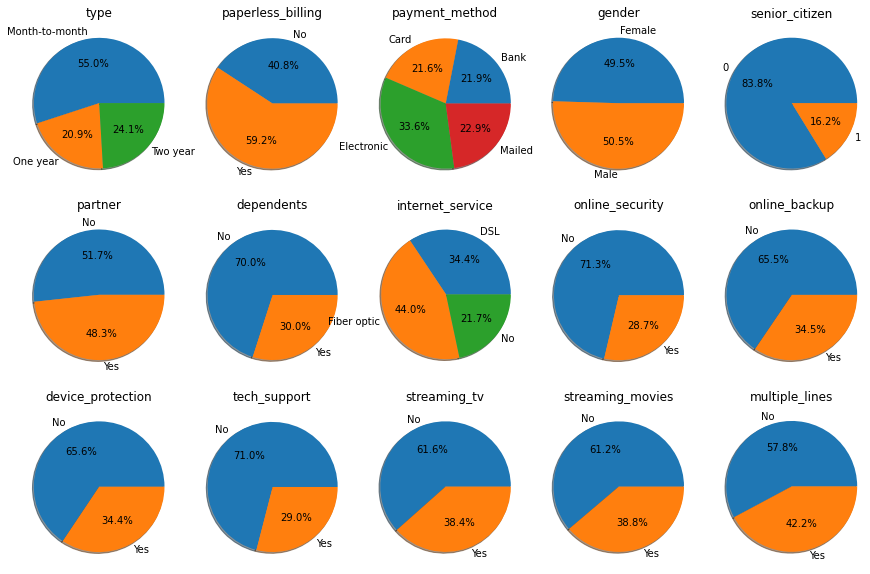

In [80]:
#comment
base64_data = 'iVBORw0KGgoAAAANSUhEUgAAA2YAAAI+CAYAAADXfxnQAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOydd3wVVfqHn3duzU0vtNBCCQFEiooRK/aCYnd1de29764luz9dy7q7uPa1u3bXrquisa6AKCgWqgihhpJAAgnJTbt1zu+PGTBAgPS5N5nn87lw78ycme/knnvmvO95z3tEKYWNjY2NjY2NjY2NjY2NdWhWC7CxsbGxsbGxsbGxsenu2IaZjY2NjY2NjY2NjY2NxdiGmY2NjY2NjY2NjY2NjcXYhpmNjY2NjY2NjY2NjY3F2IaZjY2NjY2NjY2NjY2NxdiGmY2NjY2NjY2NjY2NjcXYhpmNTTdHRGaIyKWdfM2JIrJ+N/ufEpHbmzpWRIpF5Cjz/Z9F5NmOV2xj0zb2VOdbeK4cEVEi4myP89nEL2Y9GGq1Dhsbm/bBNsw6kMYdSBsbm+ajlLpSKfXXZhz3d6VUpxqVNvGFVe2w3WG2sbGJJzrb0Ski54rI57vZf4iIFHWWnljB9rbZ2HRTREQAsVqHjY2NjU3nIiJOpVTEah02sYNS6u+dfL1XgVe3fhYRBeQqpVaY+78G8jpTUyxgj5h1ECLyCjAA+FBEakWkQUSu2+GYhSJyivleicj1IrJKRDaLyH0iojU69mIRWSIiW0TkMxEZ2Kk3ZNPumJ78P4nIL+b3+oKIeEUkXUQ+EpFN5vaPRKRfo3IzROQfIvK9iFSLyAciktFo/wEiMltEqkRkgYhM3KHs30RkFlAPDG5CV5N1TQweEpFy87oLRWSUue8E8z5qRKRERG5q5t/gz2Z9LxaRcxttf1FE7mlG+TtF5D/m+63hXReIyFrzvP/X6NgEEXnJvK8lInJLe4WWdWVaU09F5EwR+WmH8/xRRN43378oIk+IyCdm+zhLRHqLyMPmuZaKyLhGZbNF5F3zWqtF5PpG++4UkbdE5GWz/i0Wkf3MfTu2w7fs5j631p+LRGSdqeNKERlv1vUqEXlshzK7+q3MNA9ZYF73Nzv8HcpFZIOIXNRoe6p5D5tEZI2I3CbmM0BEHCJyv1mnVwGTWvQl2nQ6IrKPiMwz6+TbIvLm1jZNRE4UkflmnZotIqMblSsWkZvMOldtlvM22n+zWXdKReTiHa7pMevJWhEpEyMkPMHcN1FE1ovIrSKyEXihk/4UNl0csUOq2xellP3qoBdQDBxlvj8LmNNo3xigAnCbnxUwHcjA6EgsAy41950CrABGYIxy3gbMtvr+7Fe71I+fgf7m9z4LuAfIBE4HfEAy8DbwfqNyM4ASYBSQCLwL/Mfc19esVydgOF6ONj/3aFR2LbCXWZdc5rY91jXgWOAnIA1jpG0E0MfctwE4xHyfDuyzh3ufCESABwEPcBhQB+SZ+18E7ml07Pod/m5bf1d3Nrr3HPN39G8gwfyNBYER5v4pwFemvn7AwsbntV/tV0/N77Ry69/e3DYPOL3R97sZ2BfwAtOA1cD5gMM8/3TzWM2sd38B3BjOhFXAsY3qQMCs8w7gH8B3TdWXPdzn1vrzlKnpGPO87wM9MX5b5cBhe/qtmPsVMLSJOn83xu/uBAznSLq5/2XgA/NvmYPxDLjE3HclsLTRdzDdPL/T6vphv5qsS25gDXCD+V2fBoTMer2PWY/yzfp6gVlHPY3q6/dAtvldLwGuNPcdB5Txa9v/WuN6BjwMTDXLJQMfAv/Yof7di/H7TLD672S/2lzPbsXoC9QARcCRZntZAKzEePa/BWSYx29t4y7A6AdsBv6v0fnuxHyemp8nA4uBKox+QuP2vNi8/kKM5+wu2yKz3fovsMnU9Ji5/ULgG/P9TFNbHVAL/IZGz37zc22jVxCYYe7zAPeb91SG0YYnmPsmAuuBP5q/uw3ARVZ/d7v9Xq0W0JVfbN+B3NpRyTU/3w880ehYBRzX6PPVwJfm+08wH9DmZw3jgT7Q6nu0X22uH1c2+nwCsLKJ48YCWxp9ngFMafR5JMZD32E2lK/sUP4z4IJGZe/eYf8MfjXMdlnXgCMwOosHANoO51gLXAGkNPPeJ2J0EhIbbXsLuN18/yKtN8z6NTr2e+Bs8/22zrz5+VJsw6wj6+mTwN/M93sBW/i18/ki8O9Gx14HLGn0eW+gynyfD6zd4Vp/Al5oVAf+12jfSKChqfqyh/vcWn/6NtpWAfym0ed3gRvN97ttl2naMGugUQcGo6NwAMZvNwiMbLTvCn7teEzb4Ts4Btswi9kXcChGh1kabfsGwzB7EvjrDscX8avBXwyc12jfP4GnzPfPs33bP2xrPcNwltUBQxrtnwCsblT/QoDX6r+P/WqXOpYHrAOyzc85wBDgRuA7DOejB3gaeL3RMbtzXt7Jr8/TYWZ9OhrDuXALhiNq62BCMTAfw+japZFvtm0LgIcwnAle4GBz34WYhpn5uak2c6dnNJCC4bC4wvz8MHt2SDTpEIvFlx3K2EkopYIYHc/zzPCUc4BXdjhsXaP3azA8ZmB0ih8xwx6qMAw8wfDg2sQ3O33nIuITkafNcCY/hicpTUQcuynnArIw6sqZW+uKWV8OBvrsouyO7LKuKaWmAY8BjwNlIvKMiKSY5U7HaPDWiMhXIjKhGfe+RSlVt+P9N6PcntjY6H09kGS+z2b7e9/d38Fme1pTT18CfisiAvwOeMtsB7dS1uh9QxOft35vA83rNa7TfwZ6NTp+x+/c24bwmpboamm7XKG2n9eztX5m8esoy1bWNDrXjnW38XE2sUc2UKLMnqHJ1u9vIPDHHepzf7Zv+5rbhjWuBz0wRq9/anTeT83tW9mklAq07pZsYowohuE1UkRcSqlipdRKDIfO/yml1pvt7Z3AGTu0h3cppRqUUgswjKYxTZz/N0ChUuoLpVQYYzAhATiw0TH/UkqtU0o17Ebn/hj19malVJ1SKqCU+qaV94zZf34Nw2n1tPl8uQz4vVKqUilVA/wdOLtRsTCGQzqslPoYY8QtZueu2YZZx6J2+PwScC7GcHO9UurbHfb3b/R+AFBqvl+H4RlIa/RKUErN7hDVNp1JU9/5HzEajXylVAqG9xW2T9SxY7kwRljCOowRs8Z1JVEpNaXR8TvWy8bstq4ppf6llNoXYwRkGHCzuf0HpdTJGCFf72M4IfZEuogkNnH/HcUGDC/iVvrv6kCbnWhxPVVKfYfhoT8E+C07O6KayzoMr3/jOpmslDqhmeV3V9/bQnu2y5sxfsMDG20bgDHqAkbd3fE7sIldNgB9zU7jVrZ+f+swRpIb1xufUur1Zp53V/VgM4bjYK9G501VSiU1Oqajfgs2nYwyEmTciGF4lYvIGyKSjdGGvNfIOF+CYcTtzpHVuI5sJZtGhr9SSseou40dT81xbvYH1qj2SzTzN4xRsa3zjJvjkNiVQywmsQ2zjqWMRskVTENMBx6g6U7KzWJMqO+PEZv+prn9KeBPIrIXbJskfmaHKrfpLK4RkX5iJO/4M8Z3nozxgK0yt9/RRLnzRGSkiPgwhujfUUpFgf8AJ4nIsWbCAK856btfE+doil3WNTGSIOSLiAsjxCEAREXELUba21TTs+bHeBA0h7vM8ocAJ2LMU+oo3sK4t3QR6Qtc24HX6mq0tp6+jDHKGmmDl/R7wG8mLUgw6/UoERnfzPLbtcPtyJ7a5WZf1/ztvgX8TUSSxUgi8geM3zPmvuvN7yAdYw6JTezyLUYbeK2IOEXkZIyRAzDCyK4021IRkUQRmSQiyc0471vAhY3a/m2/ObPj/G/gIRHpCSAifUXk2Pa8MZvYQSn1mlLqYAxjTGHMH1wHHL+D4e9VSpXs9mQ7U0ojR5HpZOjPr84iaJ6hvw4Y0B4JQkTkbIxoszPMvgY0zyERV9iGWcfyD+A204rfmqXuZYz5E/9p4vgPMCa5zwcKgecAlFLvYfzg3jBDhn4Gju9Y6TadxGvA5xjzn1ZhzEF4GCNkYDNGrPinTZR7BWOezkaMmO3rAZRS64CTMTrPmzAaxZtp5m99D3UtBePBvwXDk1aBEd4ARqhasVnmSuC8Zlxuo3muUoyUuVcqpZY2R2cruRtjEvBq4H/AOxjx9TZ7pi31dBStHy3barSchDGHbbV5vWeB1Gaeoql2uM00o12+E3jJvO5ZzTjldRgOj1UY85Few5hTBMbv7jOMsKO5GBPpbWIUpVQII+HHJRiJE84DPgKCSqkfMUKvHsNo/1ZgzLVpznk/wfjdTTPLTdvhkFvN7d+ZdfJ/xHDIlk3rEZE8ETlCRDwYTtIGDGfAUxgOnoHmcT1Mx0BLeQuYJCJHms7YP2I8L1saEfA9xkjvFNMJ4RWRg3Zx7C6dWWJk6X0UOEUptWnr9i7pkOioyWv2q+kXRtaxb5rYvt2kR/vV9V80MylBE+VmYCbrsF9t+vtfBXxltY5Yf7W2npplEzAyhuVafR/2y35Z+QLmEOPZ4OxX/LyA0RhGTw3G/NaPMMIPNYzR9iJz30rg72aZHHZIGsT2yb/uZPusjKcCvwDVGBmN92q0r9nPBYyQ2/cxnLmbMeamwc7JP67EMOKqMDKZT+TXrIx3YiTxaJyZ8RNznxdjXtkqjIidJcD15r5t52iNditeYoq06QTM0INpGNkYX95hn6LRwno2XR8RKcZoEP/XwnIzMBrPZztCV1dFRPpgeOO+BXIxRqUfU0o9bKWuWKe19dQs+wfgRKXUEe0uzMYmhhGRwzA6x5sx5pY/BQxWSm2wVJiNjU1MY4cydhLmsOomjKHa1yyWY2PT4YixeHRtE69PLJLkxkgdXIPhIPkAeMIiLV0e06C7ASMEJiYw50I2VScXW63NpsuRhxF6Wo3xGzjDNspsbGz2hD1iZmNjY2NjY2NjY2PTYkRkAEbIY1OMVEqt7Uw98Y5tmNnY2NjY2NjY2NjY2FiMHcpoY2NjY2NjY2NjY2NjMbZhZmNjY2NjY2NjY2NjYzG2YWZjY2NjY2NjY2NjY2MxtmFmY2NjY2NjY2NjY2NjMbZhZmNjY2NjY2MTB4hIVETmN3rldOC1ikUkq6POb2NjszN7NMxERInIK40+O0Vkk4h81JoLikiaiFzd6PPE5pxLRHJE5LetuWZHICKniMjIRp9niMh+VmqysbGxsbGx6dI0KKXGNnoVWy3Ixsam/WjOiFkdMEpEEszPRwMlbbhmGnD1ng5qghwgZgwz4BRg5J4OsrGxsbGxsbHpKERkXxH5SkR+EpHPRKSPuX2GiDwkIjNFZImIjBeR/4rIchG5p1H5982yi0Xk8l1c4zwR+d4cpXtaRByddX82Nt2J5oYyfgJMMt+fA7y+dYeIZJg/6oUi8p2IjDa33ykiz5sNwyoRud4sMgUYYv647zO3JYnIOyKyVEReFRFpQsMU4BCz3O9FxCsiL4jIIhGZJyKHNyVcRF4UkSdFZLqp4zBT1xIRebHRceeY5/pZRO5ttL1WRP4mIgvM++slIgcCk4H7TD1DzMPPNBuuZSJySDP/tjY2NjY2NjY2zSGhURjjeyLiAh4FzlBK7Qs8D/yt0fEhpdShwFPAB8A1wCjgQhHJNI+52Cy7H3B9o+0AiMgI4DfAQUqpsUAUOLfjbtHGpvvSXMPsDeBsEfECo4E5jfbdBcxTSo0G/gy83GjfcOBYYH/gDrMBKQBWmkPwN5vHjQNuxBiBGgwc1ISGAuBrs9xDGI0LSqm9MYzFl0x9TZEOHAH8HvgQeAjYC9hbRMaKSDZwr3nMWGC8iJxilk0EvlNKjQFmApcppWYDU4GbTT0rzWOdSqn9zXu5YxdabGxs9oAZQv1Ao883icidFkqysbGxiQUahzKeCuRhGFpfiMh84DagX6Pjp5r/LwIWK6U2KKWCwCqgv7nvehFZAHxnbsvd4ZpHAvsCP5jXOBKjr2ZjY9POOJtzkFJqoTnB9Bzg4x12Hwycbh43TUQyRSTV3FdoNgBBESkHeu3iEt8rpdYDmD/6HOCbPcg6GMNLhFJqqYisAYYBC5s49kOllBKRRUCZUmqRea3F5rUGAjOUUpvM7a8ChwLvAyFg6xy4nzBCOXfFfxsdl7MH/TY2NrsmCJwmIv9QSm22WoyNjY1NjCIYBteEXewPmv/rjd5v/ewUkYnAUcAEpVS9iMwAdnRyC/CSUupP7SXaxsamaVqSlXEqcD+NwhhNmgo7VOb/jRuBKLs2BHc6TkTyGw3XT26iTFPXxQw7nG8aeDuev8mGaVfnMgkrpbbez+7uofF19nScjY3N7okAz2CMcm+HiAwUkS/N8OkvRWRA58uzsbGxiQmKgB4iMgFARFwislcLyqcCW0yjbDhwQBPHfAmcISI9zWtkiMjAtgq3sbHZmZYYZs8Dd28dbWrETMxYY9Pzslkp5d/NeWqA5D1dTCk1p9Fw/dQmyjW+7jBgAFCklPq/reWadVcGc4DDRCTLnNB6DvDVHso06z5sbGxazePAuY1G4LfyGPCyGT79KvCvTldmY2NjEwMopULAGcC9ZjjifODAFpziUwxn+ELgrxjhjDte4xeMEMnPzeO+APq0UbqNjU0TNHtUxww1fKSJXXcCL5g/1nrggj2cp0JEZonIzxhJRQqbKWEhEDEbnheBJ4CnzPDECHChGTbZYpRSG0TkT8B0jNGzj5VSH+yh2BvAv82kJme05ro2Nja7RinlF5GXgeuBhka7JgCnme9fAf7Z2dpsbGxsrEApldTEtvkY0y923D6x0fsZwIym9gHH7+JaOY3evwm82VK9NjY2LUN+jdKzsbGxiQ1EpFYplSQiGcBc4AWM9upOEdkM9FFKhc2EQqVKqR6WCu5iiEhv4GFgPEaIdjFwo1JqWSvOdSdQq5S6vx0l2tjY2NjYdDlaEspoY2Nj06kopSqBt4BLGm2eDZxtvj+XPScKsmkB5nIl72EkRBqilBqJkXF3V8mbtisrIvZzxcbGxsbGphXYCSosJqeg0IcxVy0JSMBY0LsaqC6eMilqpTYbmxjhAeDaRp+vB54XkZuBTcBFlqjquhyOkfToqa0blFLzRSRJRL7EWH7EBdymlPrAzNj7CUYo+ATgFBE5DzgfWIfxHf3UyfdgYxOX5BQUeoEe5isNw4EuGEnVgkAAI7R7Y/GUSXbGWhtLySko1IAsIBMjkUwKRp3VzVfUfNUCZUBZ8ZRJEWvUxgd2KGMHklNQ2BPYGxihlBoKahhGGv00kCTAZyYbaRKlVB1QLSJ+oBIj+9Lira/iKZPWdfAt2HRTcgoKMzDWqemHsa5NP/OVCniVUl7AA3hFRMdodGsxkuLUAhXA6sav4imTGna8jk3sYc6bHaSU+v0O252Az5z7l4WRJCAXY7mRVcCBSqnvRGRfjHnA+RjOv7nAU50Wynhnal9TVzZGx7bxKxGjkxACwub/QWALUAKs3/a6s7q+U/TadDtyCgr7AWOAMUYSIzUYRU+MBGSJzT2PUqpBRNZjOEC2vpYCc4qnTFrRIeJtuh2m8TUYGAEMV0ofiVIjERkMktGSKAkzy3mliJRhtLWLMdbY+xmjX9vt213bMGsncgoKBRirdP0YVPRYRBsjmiOjI69pdpCWAAswJvVOK54yqawjr2nT9cgpKMwG9lNK7YMeyTfrbkdk3FoP/Ah8j5EJ9YfiKZNqOuA6Nm1gN4aZC3gII8mAjrGw7SCMNY+mK6UGmcfdCGQopf5ifn4QYx5g+xpmd6amYGSfmxDV1V66YoRDY5AmktBOV9iM0WlYcGrwrjnzVO4CYEnxlEl6O53fphuQU1DoBg5WSj8OXT8Q0UaJpu2YabYjqOTXtvZ7YHbxlElVnXBdmzgnp6DQCeyn9Ojh6NGj0Jz7i6btlHSmvVFK6SKyEpiFkRl9WvGUSWs7+rqxhm2YtYGcgsJspevHqmjoJHE4J4rmTLdaE4bn4VOMdee+tcMhbXYkp6AwAThUDwdPFtGOFadrsBU6zEb4F4zUy58CXxVPmdSqzKo27YeIHAncoZQ6dIftF2JkbzvPTLxSDEw0d3+klBplHncjkK6UusP83D6G2Z2p6cAxwYg6AjjM7SC3M+az6Qp9ZOD5YEC8CRgjwjMxQjc/Lp4yaXVHX98m/sgpKByo9OgkFQ2fJg73gaJp7eUsaDVKqYiIfIUxf/T94imTSqzWZBM75BQUZqho5HSlR38rDtcBomk7LjJuFcuAz4B3gZnFUyZ1eaPFNsxaSE5BYaoerLsUzXmJ5vKMsFrPHqgA3geeKZ4y6XuLtdhYSE5BYYqKhM5SSj9fnO58Ec1ttaYmqMEw0P6L0XEIWKynW2Im//gOeFYp9W9z23jgBCBLKXWdiBwOTMMYMYPtDbN92DmU8elWGWZ3pvZsCKszo4rzfC7Ga7sJ/e4o1tR76g/TXvDtYvdSDCPtA7pJp8GmaXIKCjP0YN2V4nBdKE53rtV6dodSSonIDxhG2lvFUyatslqTTeeTU1CYoYeDZ6H034nLky+idXr72kLWYyzZ8FrxlElzrRbTUdiGWTMZ8Id3Jqpo5A+ax3esaI5Y7NTuifnA08CrdvhY9yCnoFDTw4HjiUavE3fCEaJpLqs1tYAqjMWjnyueMmmexVq6HSKSjZEuf1+MZAPFGGtW/gsj8cd84CB+Xf9om2Fmlv8/jOQfazAepr802zC7M9VbG1IXAJf6XOyjWZzl8cvq/qWXeO7NbsahqzAM0hft+b/dg5yCQtGD9ccoFf295k48UjQt7hKqmZELnwCPAp/bzoWuz4Ab3zpUKf0WzZN4bDzWWZMijD7ts12tT2sbZrshp6AwOdrg/6M43ZdqLm9fq/W0E7XA68BTXdnj0J0Z8Pu3EvVw8GbNk3i15vJ0hfW95mE0wC/aoY5dF/+fUgYHIur/0rxyttshuxqh6nQeqJq45lHv5QObe7zZ0f0f8G/gPTucvOvR/4Y3ElDRAnElXKG5PHtcRiKOKAIew2hra60WY9N+5BQUuiK1lZdqLu8fNY9viNV62hE/8CzwSFeZj2YbZk2QfdGjPvEk/M2ZlHW5OF0x00HoAD4G/lQ8ZdJCq4XYtJ3+17/WS0UjdzsSUn4nTpflcxo6gA3A/RhOhW6fuamrUH5z8tEO4c70BJmgGWGUMcU51dds/NZzUO9WFl8O/AN4xU4RHf/0veLZBETudCSmX625PB2eDMFC/MDjwJTiKZP8VouxaT29z7tPcySm3+xISr9Fc3k7NCGdxUQw5qHdWTxl0lKrxbQF2zBrRL+rX3SpaPh2R1LGjZrLm2y1ns7A9O6+DtxuT2SPT7Ivebyn5k16xJGYfoZojngNS2gJmzDC7B7taiEM3Yml1yYdn5kg/+yRqI3a89HWoCvYu/6pYJ0jxdPGUxUD9wIv2KO+8Ue/a19xq0jwDkdi+nXdpW9gshn4K/Bk8ZRJYavF2LSMvpc9daUjMeNOzZvYlUZ190QUeA64o3jKpI1Wi2kNtmGG6VHwpf7RkZT+J83ti4XMilYQAp4B/lo8ZVK51WJs9kyvc/7ucSZl3OtM7XWFON2xkkGpM9kIFAAv2/Mi4od5VyTl906Sx/ska/tarWVPbAi46ibwUrPXlWoG64GbiqdMerMdz2nTQfhy8yXt0AtucKb2ulNzezsjxX2sshL4c/GUSW9ZLcRmz2Rf9K+THSk9HnEkpDQ7BLsLUgs8ANxXPGVSndViWkK3N8x6nX3P0e6eg591+FIHWK0lRqgFbseI1+3elSNG8eXmS9rB513lTOv1V82T2JVDE5rLd8B1xVMm/Wi1EJtd88YZvh77ZTueG5QmJzq02AtZbIqZ/j4bznc/0BFr+k3DqLO/dMC5bdqBnqffvo+71+BXnCk9R1qtJYb4DrjErrexSdbkm/t5eue+7EzPPjwGo8KtohS4pnjKpPetFtJcuq1hlnHU5aneAaOfd2UNOEU0h6VZv2KUGcBFxVMmFVusw6YRWSf+YaS3/6hXnam9xlqtJZYw0z8/B/zRnhMRW0zOc8kfJ7ivHdvb8bdUr8RVGNi/thxU/GDCNTkddPoIRpbLO+2Q3Ngh7eBz3QlDxz/i7pFziThc8ZTJtrMIYjhvH7AXW48NfLn5Wkr+GTe5ew76i+ZOaM8R/q7Eu8DV8RAR1u0MM19uviTtfdTJnn57PePwpXaFjHUdSQ3wh+Ipk561Wkh3x5eb70gZf+rt7j65t2oub3cMW2wuxcD5xVMmfW21EBt44wxf7n7Z2qtDMxzjrdbSGi6ovmLjV57DWpv4o7msBc6z66z19DzjjqM9fXJfcCSmd5UszB3JLOCC4imTVlotpDuTedy1ud6cce+40nqPtlpLHLAJuLJ4yqT/Wi1kd3Qrwyxp7yMTksee8Jy7T+5v7FGyFvExcGnxlEkbrBbSHck87ro878DRb7nSs+2Gt3nowH3AX4qnTApZLaY7MjnP5bhqP9fvD8tx3u1zSdxmCB1T+3hDtTO9M/RHMbI33mVnb+x8fLn53uRxJ9zrHTj2anE4u0MCpfaiDrileMqkJ6wW0t3w5eaLb8Shl/sGj79P8ybGVSRCDPA0cH2s9g+6jWGWesAZI5NGH/OeK6PvMKu1xCmVwNnFUyZ9YbWQ7oIvN198uRMu8g2b8JDmTUqxWk8cMg84o3jKpFVWC+lOnD3KlXZ9vvvNA/o5jo7F9PfNZVPQ2TBevdzZRuW3wLl2htzOI3ncCX2SRh/zrqdP7gSrtcQxrwMXF0+ZFLBaSHfAl5ufmLzfyf/29h9lDzK0njkY/YP1VgvZkS5vmPly88XTd8TkpFFHPudIysi0Wk+cE8WYw/OI1UK6Or7c/ISk0cc+kjB434tsD26bqADOLJ4yabrVQroD9x/j3f/0Ea63BqVrcZ8NbLa/18bfuh/q6DDGpvAD5xRPmfSxBdfuVmQceelhvryDX3Om9Mi2WksX4HvgFDuypmNJPfA3wxL3Ovw9d2Z/OylN2ykHflM8ZdIMq4U0pksbZr7cfEfC0P3/kDjisLs0d0LchtPEIM8CV9khNx1D0phjeiePPf49T59hB1itpYsQwQhbeNJqIV2VyXku7dThzstPG+G6P9UrXWLy+VNV+WumeG+wysCMAjcUT5n0eGsKi0gUWASIea5rlVKzW3muGcBNSqkuk/XUl5vv8OUddINv2IS/am6fz2o9XYj1wOTiKZPmWS2kq+HLzRd376EnJI057kVnUkaW1Xq6EFGMDLkx0z/osoaZLzffl7jXEf/y5R5wgT3i0CF8gjESEVfrQ8Q6yWOPH5uy/6nvuTL65litpQvyJEYDHLVaSFdicp7Le3Kec8p5o11Xe5zSZbLYXVZ1UekX3qOtHkl5BCMBU4uy34lIrVIqyXx/LPBnpdRhrRHQ1QwzX26+zzfsoAcSRx52qd036BDqMRIwvWu1kK6CLzdf8/Tb68qkMcfe6/AmJVmtp4vyl+Ipk/5qtQiALhmb6svNz0re58T3fXkHXWI3vB3G8cBXOQWFPa0W0lVI3vekI1MPOPNj2yjrMK4CXs8pKLTbhHZicp4r+exRzmcvGOu6tisZZQBznWPSrNYA3AC8l1NQ2JZRyBRgC4CIJInIlyIyV0QWicjJ5vYcEVkiIv8WkcUi8rnI9klbREQTkZdE5J42aLEUX25+auLIiS8m7nX45XbfoMPwAW/nFBReZrWQroAvN9/lHTD6juR9Jj1gG2Udyt05BYUP5xQUWj4vusuNmPly8/sljT7mP77cA1rlHbRpMYuAw4qnTNpitZB4xZebL86Mvqem7HfK087kTDtEoeP5ADgrVjMyxQuT81wZl4xz/eekPOdx8Zzkoym2hByBcforsbQsxUzg+OIpk+qbc3CjUEYv0Ac4Qin1k4g4AZ9Syi8iWRgLBucCA4EVwH5Kqfki8hYwVSn1H3PErADDSPxZKfW39r65zsCXm5+ZuNcRL/ryDpokXay+xigKuNbO2Nh6fLn5Xu/AMX9LHnv8deJ0dynHVwzzMsYi6pZN1elSI2a+3Pw+iXsd/mLC0HzbKOs89gY+ySkotD05rcAwyvqdm5p/xnO2UdZpnAy8n1NQGEsd77hicp6rz5X7ud49ebjr+K5mlAEsD6ZXW61hBw4FPswpKGzuXOkGpdRYpdRw4DjgZdMYEeDvIrIQ+B/QF+hlllmtlJpvvv8JyGl0vqeJb6OsR+Jeh//HNso6FQEezykovMpqIfGILzff6+6T97ekscdfYxtlncr5wItWjpx1GcPMl5vf0zf8kOd8eQcfYbe7nU4+MNXu6LYMX26+aIlpF6SMP+Vhhy81zWo93YzjMeqs22oh8cbkPFf2b/d2vXz8UOdEq7V0FIuiObGY9vsIDIeCpyWFlFLfAllAD+Bc8/99lVJjgTKMUTWAYKNiUaBxqN9s4HARibs23peb39OXd9BzvryDj7WNMkt4PKeg8HyrRcQTvtx8l6vnoP9L2e/kqzSnu0W/d5t24VzgQasu3iVirH25+Zm+YROeSRx5WKc2vOufvBjNnQCahmgO+lzwMFXfvErtgs/QfKkApB96PglDxu9UtmHVT1R++QzoOkljjiH1gDMB2DLjBRpW/YS75yCyTvwjALU/T0MP1JCy38mddWut4XCMuPLTiqdMClstJtbx5eaLuBNOST3grH847WUcrOJo4Dngd1YLiRcm57myTs5zPnnWXs4ju3If9ydGxOqz8RjgvzkFhac2NxRXRIYDDoylI1KBcqVUWEQOxwhhbA7PYYzavS0ipyql4iIjry83P83Tb+RDiSMnnhBLRpnSo2x46fc4kzPpecYdhMpXUfHZ46hQAGdqT7JOuhnNs3OyyKb6HBDz/QYBns8pKKwpnjLpPavFxDq+3HynK7P/Tan7n3aj5vba2cSt48acgsLy4imT/tHZF477ETNfbn6aN2fco4l7HXGSiNbp99PrnL+TfdGj2xpIgOT9TiH7okfJvujRJo0ypUep/OJJep55F9mXPkHdL18R2rwWPVhHsGQJ2Rc/hlI6oU3F6OEgdT//j+RxkzrxrlrNicDLOQWFcV+vOhzNcVjqAWc95ErrbcU6STa/cl5OQWFchmd1NpPzXKlHDnI8csFY16SuGL7YmHnO0bG8oPsJGEuW7I4EEZkvIvOBN4ELlFJR4FVgPxH5EcMrvLS5F1VKPQjMBV4RkZhv4325+V5XZv+/JO9z4qmiORxW62lMzY9TcWX23/a54pNHST/sQrIveRzfsAn45+w6oeGOfY446Tc4gFdyCgpHWy0klvHl5muaL/XSlP1Pu0XzJNrTQ6zn7zkFhZd09kVjvnHdHb7cfJ8zrc9dSaOPOTWeVj8PbViGM60PrrTeiMNF4ohDaVj+HSCoaASlFCoSQjQH/u//S/K+kxFHrDpwd+Js4C9Wi4hlfLn5+6aMP/UJd4+BcbsIr9KjlL5wPeXv3AVAtKGGsjduo+SZyyh74zaigdomy/l/eJ/SZ6+m9Lmr2TT1n6iI4fTfMuMFSp+/ls0fPbDt2Nqfp+H/8YOOvxn4c05B4eWdcaF4ZXKeK3Fcb+2eK/dzn+nUJKY6ue2NP6SFNjj7JlutYw/8Lqeg8LZd7VRKOcw5ZmOVUmOUUoXm9s1KqQlKqf2UUpcqpUYopYrN16hG5e9XSt1pvp+4NVW+UuoOpdQ5SqkWpe/vbHy5+Q5HYvo1KfmnX6S5YmvUIeLfTMOqH0gac8y2beHK9Xj6G39+b8446pe1ZMm5uOk3JAIf5BQU2hEiu0LklJT9T/uTPbUhpng6p6Dw8M68YNwYMzviy83XxOG6KGX/087WXB5r4t5FKH/rL2x48QZq5n+6bXPN3I+MTubHDzfZQY3UVOBM6bHtsyM5i2htBZrHhy/vQDa8eD3O1F6IJ5HQhmX4cuNuneHbcwoKj7JaRCziy80f6hs24X5vv5EjrNbSFnb0+Pq/extvzhj6Xv5vvDlj8H/39k5lIjWb8f/0Ib0veIjsS54AXaduycxY8fg+kVNQeHRnXSyemJzncmYkyI3X57t/19VS4jfFimBqrCX+aBKl1N05BYWnWa0j1vDl5os4PWemHHDWTY6ElDSr9ezIli+fIW3ixTQedHZnDaRhxRwA6pd+Q6Rmc9OFm+hzxFm/IQd4y16yZGd8ufn7Jo89/nZ3Zv8BVmux2Q4H8GZOQWH/PR7ZTsStYQYcmTz+lGudyZmWraPV+9x/0ufCR+h55l3UzP2IwLqfSR53An2v+Dd9LvoXjqQMtkzbU8TJVoxGOjX/DLIvepSMIy6l+uv/kHbIedQs+IxN70+havYbHXcz7YsGvJpTUGj14qwxhS83P83VY9AdiSMPP8hqLW2hKY9v/Yo5JI46EoDEUUdSv/y7pgvrUVQkhNKjqEgQR1IGMeLxdQCv5RQU9uusC8YRJ998oPuyTJ+WarWQzmBxdECzUtJbjTln6qWcgsKRVmuJMQ5NHnfCba60XjEXJl6/4nu0xDQ8vYdutz3zhBuomVvIhhdvQA81IFrT7V5TfQ6Iu37DEcD9VovoCETkOBEpEpEVIlLQ3HK+3Px+3kH7/M07aN8xHanPptX0AN7prGRhcWmY+XLzc33DDvw/b98Rw63U4Uw2RuQdiWn4hk0gWLoMR2I6ojkQ0UgecyyhDcuaLBfxb9r2OVqz2eyg/kqobKVxbHpf6n6eRo9TCghvWkO4sqQD76hd6Qm8kVNQ2KXDnpqLLzffqXmTr0sZf8pJ4nDG9ahDUx7faF0VTrMOO5My0OuqdirnTM4iZf9TKXnyItY/9jvE4yNh0D6x5PHNwvCM2d5ck8l5rrGX7uMq2Kuno13CbtdV6xz+Uh0jHq9lrydqeeQ7IxHg24vD7PVELdpdfn4sje6yfFVAccZb9Qx/rJYRj9fy7TojB8WtXwQY/WQt57/XsO3YVxaEtp2/JfzE8Hhqs5IwkoHsnCmiG+LLzR/k6TeqwNN/VEwaq8GSX2hYPof1T17Mpqn/JLBmIZs/vB9XZn96/eav9LnwERJHHoYzvWmbsqk+R2PiqN9wQ05B4blWi2hPRMQBPI6R8XckcI6I7LEe+nLzk5xpfW5LHn3sxFhKUGOzE/sD/+yMC8WdYWaMOuT8JXHkxAOt1KGHAujB+m3vA6vn4e4xkEht5bZj6pd9iytr5/6Mu88wIltKCVdtREXD1C2ZScLQ/O2Oqfr6P6QefC7oEdgazi8aKtLyjoaFHALYiRUMTk7Z/7SLHQnJcT3qsCuPb3OIBmqpXz6Hvlc+R79rXkaFg9Qung7ElMf3QOCOzrxgrDI5z9XnkAGOu04c5tynvc7p1OCBY7wsuSaJ7y5J5PEfwvyyKcqonhr/PSuBQwfu3ia64dMAxw11svTaJBZcmciIHg6qA4rZ66MsvCqJqFIsKovSEFa8uCDM1eNb7uD8yTE61ueX7UgendRhiGV8ufkJWkLyDcnjjj84Vju46YddSL9rXqLfVc/TY/IteAeOJuukm4iajiyldKpnv0Hy2ON3KrurPkdj4qzf8FgXi6rZH1ihlFqllAoBb2CsmblLfLn5GsglKftNPkmcLjstfuxzQ05B4QkdfZG4Msx8uflONOeVKftOPt7qUYdofRUbX72F0uevZePLfyBhyHgSBu9L1YwXKH3uGkqfv5bA2oWkH3kZYMwrK3vb6O+J5iDj6Cspf+svlD57FYnDD9muga1f9i3u3rk4kzPRvEl4sodT+tw1IODuOdiS+20Dt+QUFB5rtQgr8eXmj/HlTrjB3WNgjtVa2squPL6OxLRtTolIbSVaYtpOZQPF83Gm9sLhS0UcTsPjW7Jku2NixOP755yCwkM684KxxuQ8lzfJzY2X7es+TGvHDHx9kjX26WMYX8keYUQPjRK/YkQPB3lZuzfK/EHFzDURLhlnNP1uh5DmFTSBUFShlKIhDC4H3Dc7xPX7u3E5WtY/r4tIeJ1rUNw5T5RSV9tzJDk9Zb9TT9LcCXGXza5uyVeUPHM5pf++EkdSJol7G19l437DrvocW4nDfkMa8JTVItqRvsC6Rp/Xm9t2x4TEvQ4/x5naqysZqF2dp3MKCjvUeSdKqY48f7viy80/IWns8Xf7hozfd89H28QQq4C9iqdMisVFWzsUX25+at9k/SGZ+IczQ+6UuOsw7I7A2oX4v3+PnmfcwZbpz6MlJJN6wJlUf/c2ekMN6YdfvN3xwdIiKj5+hN4XPIg4PVR8/BDu3rmk7HvStmPK37mLjGOvRXN5KH/nLnqfdx+bpt5H6gGnd3bnoggY3dy1oroak/NcZ95ykPuOgwc49+qoaxRX6Rz6Qh0/X51EiscwoCa+WMf9x3jZL3tnI23+xiiXf9jAyB4OFpRF2bePg0eO85LoFv45K8hri8IcOcjJTQe6ufyjAB+e0/LovkW1qZtPcj6Z1eabs4b1wN7FUyZVWS2ks/Hl5u/tGzbh8aS9j+7WDpU45dziKZNes1pEWxGRM4FjlVKXmp9/B+yvlLquqeN9uflZzrQ+/0qfeNEZVg802LSYp4qnTLqqo04eNyNmvtz8Ps70PhcmDNrHnhwZfwwGbrVaRGczOc8lPdly44v5aw//xnN9JD/4bZnVmjqKlAPOIFA8j5JnLiNQPI8Uc8H0xh5fT3YevryD2PDijWx4/hpQiuQxx207R4x5fPOAP3X2RWOByXmuwfv3dVxwYH9Hh83TqQ0pTn+rnoeP824zyvZERIe5G3Su2s/FvCuSSHQJU74xQrRuOcjD/CuTeOBYL7dPD3L3RA/Pzg1x1tv13DOz+WFciyP961p1Q7FBP+BRq0V0Nr7c/DTNl3p94ojDdl401CYe+FdOQWEvq0W0A+uBxpn7+gGlTR1ohjBemDL+lIm2URaXXJFTUHhoR508LkbMjErMTelHXn6tK613p6WstGlXAsDI4imTVlstpLOYnOcac8AAz0t/PsgxBkAp+MA/bM2fnDf1aXAkdUp2H5s2EQTGFE+ZVGS1kM5icp7L7XFw11Mnei/P9GkZey7RcsJRxYmv13PsECd/mLD9tIrdjZhtrNU54Nk6im80oki+XhNhyqwQhb/9dWRs3oYoj/8Q4pHjvBz/aj0zL0rk7Hfq+evhHnIz95zT4+aq09e97T093p8xRxZPmTTNahGdgS83X4ArUiecda0ne3iHje7adDjvFE+ZdKbVItqCiDiBZcCRQAnwA/BbpdTiHY/15eYf5ss7+J6kUUcc3MkybdqP5RhRNe0eCRYvI2b7Jwze91jbKItrvMAjVovoLCbnuXxJbi69dj9t0NZtInBK6rKBs1xXByYGZmywUp9Ns/DQteZANIdjLxrnOqajjDKlFJdMDTAiy7GTUbYneidp9E/VKNpsZG38cnWEkVnbP8Junx7k7sM9hHWImj5HTaA+3LxrzNXiLvFHUzyYU1AYL8/2tjLUldn/WHefYXG9LqQNZ+QUFB5mtYi2oJSKANcCnwFLgLd2YZSlijvhd768A8d2skSb9iUXaDJMta3EfOPty81PFIfrd4kjJ7ZbZjAbyzgpp6Cw01YMtpiTzhvtOiDFIyk77shwR1JeTHumz1Oh/1ubHK3qdvPu4oyJ3WUR38l5rj5ZPjn7qMEdN69s1roorywMM211hLFP1TL2qVo+Xh7mvSVh+j1Yw7fro0x6rZ5j/2NEFJbW6Jzw6q/Lij16vJdz/9vA6Cdrmb9R58+H/Grcvb80zPhsB9nJGmleYUI/B3s/WYsIjOm959GyhohEV7oGx13ijyYYA1y8x6PiHF9uvgM4N2nsceNEtJjvy9jskX9YLaCtKKU+VkoNU0oNUUrtKiP1yUmjj9lXc3m71JzzbsqfcgoK09r7pDEfyujLzT89ae+jb/YNm5C/56Nt4oBVwPDiKZOa6cOOPybnuXonufnn8ycnnO51ym4zEFSHHXUFdedWfeI9bk/Zm2ys4xeMpAq61UI6ksl5rmsKDnZfcWB/595Wa7GCJbXJlcc7n+6QkUILKANyi6dMqrFaSEfhy83P9w4c89eU/U7u7tkouxKTi6dM+tBqER2FLze/vyMx/f6MY64+VTSHPbesa3Bv8ZRJzV5MvDnEtJfJl5ufheaY5M0Za4cpdB0GAxdYLaKDOeG80a68PRllAKmuaOKTaS/3fTl887r0yOb6PR1vYwkjgS61GOqOTM5zDR6YKhPz+3Zcwo9Y55do31qrNbQjvejCyWt8ufkJiPw2ca/Dx1mtxaZd+VtXDcM150OemTTm2L1so6xLcX1OQWG7OtZj/QdwlC/voCGaO2GncDCbuKYgp6Bwz7FFccjkPFfvRBeHH57jHNWScocml/T/2nsjpwfeW99R2mzaxJ05BYVd8mE6Oc8lwFmX7uMe5dCkS/4um8NPKq9Zx0X8m9j4+p8o+feVlD57Nf4fPwCgbuk3lD57NWvuPYnghuW7LO//8QNKn7vaKPvDB9u2b5nxAqXPX8vmjx7Ytq3252nbzt8KruuIMJsY4ciEwfuNciSkxOvSBjZNszdwjtUiOohhmi9tf3evIc1raGzihQTg9vY8YcwaZr7c/FREjvQN3s/OtNT1GAKcbbWIDuKE341xDUtw7Xm0bEeSnLrvgbS3+70VubGkR2RjPKft7ooMBi6yWkQHMXJohjZ+715at+4wzHWMat6cD81B+uGX0Peyp+j9u/upmVtIaPNa3FkD6XHqn/H03/UjK7SpmNoFn9H7/Afpc/GjNKz8nnBlCXqwjmDJErIvfgyldEKbitHDQep+/h/J41o9LTcJuLq1hWMVX26+DzgxYej+uVZrsekQ7upqo2bmaNnkpL0OHyKaw2m1Hpt254KcgsJ2cxLFcuU/LGHI+EGaNynTaiE2HcIfrRbQ3kzOc/VqzWjZjuyfVN53ZsIfnb8LvLa2vbTZtAs3Wi2gvdk6WvbbvV1DNZHmLSjWBQlG0Yucw9Obc6wzKQNP76EAaB4frsz+RGsqcGX1x5XZb7dlwxXr8WQPR3N5Ec2Bp/8o6pd/CwgqGkEphYqEEM2B//v/krzvZKRt/bjrcgoKW5b+MvYZ7+49NNuZlGlnae6aDAGO2+NR8UV/cXn2tpd06LJ4gSva62QxaZiZHrETfEMP6LbzHboB4+I9PW4TnHDuaNfQ1oyW7UiCQ3n+mvbRgA+i127IDq/1t4c4mzYzIqeg8CirRbQzuQ6fNnRQT8cQq4VYyZpAol+Jo8WGaaS6jFDZKjzZzRtsdGcNJLDuZ6INfvRwgIZVPxL1b0bz+PDlHciGF6/HmdoL8SQS2rAMX+4BLb6XHegN/K6tJ4kVfLn5TmCyb/ghQ63WYtOhXGW1gHbmmMThhw4WpyvBaiE2HcbV7TXdISYNM+BAT7+9BjgS0/pYLcSmQ7nRagHtxeQ8Vy/gkIMHONs1vGZMYmWf6b4/ea8IvLBGqS6dFDBeuNZqAe1Jpaadu+HArNzDB/VzXuRNX/OL7qi2WpMVLI30aXH2Qj3UwKb3/k7GkZeheZrni3Fl9Scl/wzK37yd8rfuwN1zEGjGtL7U/DPIvuhRMo64lOqv/0PaIedRs+AzNr0/harZb7RUXmNuyiko7CqjoXs5krP6uTL6duuw266OUuqEnILCgVbraA98uflZwIHegWPsgYauTTbQLoukx5xh5svNdwEnJwzax04f3sVRSp2UU1DY02od7cSE8dlaZppX2j301uNQ7j+lfTHwU3VNWU54ZVV7n9+m+SilTuwqHYaUcSk9l7ld4/3Dkscop+b5sU/ywN8Mzk45JqVHyX+VZ6PV+jqTeWpYi9aNUdEIm977O4kjJ+LLO7BF10oecwx9LnyE3ufei+ZNxpWevd3+UNlKAJzpfan7eRo9TikgvGkN4cqSFl2nEXlA3EcnmPN0Tkoccehge92yro2IaMDlVutoJw7z9BvZQ/P4mhUqvRX/D+9T+uzVlD53NZum/hMVCVE18xVKn7+W0heuo+zN24nUVDS7LHRIgiGb7WmXBadjsXEbhuZIcmX0G2a1EJuORUQcwOlW62grk/NcDuDwE3JdHepMGOGr7vV54u1Jvw88WSwqGtsLEHZRzDp7mdU62okDHCOScaS53Nu2iMiGzIS+dwzu1Xv/nn0q/64lralRdNk1B7fyk+zd7PBjpRQVnzyCK7M/Kfuf2uJrReuqAIj4y6lf9i2+kdvbTFVf/4fUg88FPQJbR8lFQ0WCLb5WI85rS+EYYSAwxN1riB3G2D24JN4z4Zqht4cnDNpn95NPdyBSsxn/Tx/S+4KHyL7kCdB16pbMJCX/dLIvfozsix4lYch4qme/3uyyHZRgyGZ7DsgpKGxz+xSLhtmBCTnjeonT5bVaiE2ncJbVAtqBIU6N1JE9tOEdfSG3hvOGtK9zvuTKzXmhX5p2l9l0NHFfZ1PGpbiAY5LHJu9y9K8h0ZXx+sCMgQf37xe9xJO+Zpmudcm5jhEd9YtrRLO92cGSX6hbPJ3A2oWUvnAdpS9cR8PKH6hfNpv1j19AsHQp5e/cRdmbRgblSE0FZW/fsa38pvf/TumzV1H+zt1kHH0lDu+vySDrl32Lu3cuzuRMNG8SnuzhlD53DQi4ew5uy22e0QWSgIx398lN09wJaVYLsekUegEnWi2ijQzD4Ux2ZfRved9Aj6IiIZQeRUWCOJIytguZVuEAsIsI5SbKdmCCIZvtafOapzH1bfhy873AeO+A0Xa2pW6CUurQnILCXsVTJpVZraUNHHjUYGfPBJckdtYFByfU9Sj03BN93r//mns9V/ePijsWnSxdldycgsIxxVMmLbBaSBsYhYMkdw/3Hr17ukvzfp+dPPB0laT6VgZKrq6udkyWUO/OENkZrA0k+COaO7W5x3v77cXAWz9qcp9v2M5hjc7kTHqdede2z73P/ecuz+0bNgHfsAnbPqcfcQnpXNJcabsjFTgJeKc9TtbZ+HLzHcAhCTnj7Hnn3YvJwHtWi2gDByUM2rfFAw3O5CxS9j+VkicvQpxuvIPGkTBoHwC2zHyZup+noXl89DrnHy0quzXBkHfgmG0JhtIO6qrLxlnG2cBdezxqN8RaZ264OD0eZ1pvO4yxm2DGkp9htY7WMjnP5QUmHDnI0enzjpwajsvTvh84Q67aMjo4f3NnX7+b0y6TfC0kPzE3MU2c4t7zoSYiUpKZ0Pf/Bvfund+jT8W9WuLaWkWkAzV2CkvDvVuc+CNOiedwxhwg2ZU10E760b2YFK9rmvly8xOA/b39Rw1oadlooJb65XPoe+Vz9LvmZVQ4SO3i6QCkH3o+/a5+kcSRE6n5aWcH0e7KdmCCIZtfGZ5TUNimRC+xVuEPThi8T29xOJvfWbDpCvzGagFtYESym4QhGZplzoT+3obM91P+mXlP4N41br0h7jvKcULcGmYp41KcwFjfUF+P1p6jPsmV+Z+BmQMO6t8vfLknbc0KXYtb42a+yo1araGTOC6noLDNS3lYxL7u3rnpdhhjt6MHkG+1iFYyEtFcztSeg1paMFA8H2dqLxy+VMThxDdsAsGSJdsdkzhyIvXLZrWqbAckGLLZntPaUjhmDDNfbn4iMM7dZ7gdqtDNUEodlFNQGK+hUYcePMCZ7tTE0rBgTZDz0hYMnOm4umZ8cE48h4XGC8NyCgpHWC2ilQwAXO7e7javXaa7tIRvs1MGnjq4b9IJyT3WFyp33NW9n2RUvBorLcUDHGy1iJZihjEe7M0Z28tqLTaWcJLVAlrJfp4+w5LE0fJ8Cc6UHoRKi9DDAZRSBNYswJXZfzvDqX7FHFwZO+cU2VXZxnRQgiGbXzmyLYVjxjADhgHiTM5sUfYam/jHDGc81GodLWVynssDjB7bW0uzWstWenuC6W+mPNLzgeBf13j12i6fTc9iJlotoJUMd6Y5E5xJzvbr6IrIuqyEfgWDe/c6oEefzQ9oiWsbdBXzI1FRhfrZtVeL0ljHOfG4QHoOkORK620vodM9iTvDzHQmjPH0HZHVmvKe7Dx8eQex4cUb2fD8NaAUyWOOo+qrlyh97mpKn7+WwOq5pB9lrCjQOMHQrspupQMTDNn8ygFtSbYUS8k/hjmSMlwtXevBpstwAPCW1SJaSD+AnDStxTHkHYkmyOmpSwYeFrrG/4eGizfP9Bxmj0J3DIcBT1otohXkJ41Myuiok9clubJeTMrk5VB6/YGbastvDvizBmt60p5Ldj6lAU9tUEtItlpHJxKPhtlgHC5NS0jN3vOhNl2QUTkFhX2Lp0yKpzi7voDXmdE3p7UnSDvkXNIO2T7BX49T/9zksTsmGGqq7FY6MMGQza94gQnAjNYUjqURs7092cNTrBZhYxkHWC2gFeS4HTh6JEpMdhiy3OGUl1Of7vNk8La1iVG/HaPQ/sTdor0p41JSgf7eAd4Oj0zQ3Zrvm74pOScP6us7MTlr3efKVd7R12wpRaGeXXIJgF2hlBqbU1CYabWOFjLG0yfXJ5rmsFqIjWWMt1pACxkqLq/TkZhmZxjvvkxsbcGYMMx8ufk+INuVNbDVk9Ft4hul1LicgsJ4S/oyev++Dp/V88v2xPGpqwbMcl8bPibweanVWroYvXMKCuMtg+wQBFyZrs6LWdFEW5Pl6//HwX16Tsjqvelh8a0LxEiY43x9aLdKliMiQhw5FMyQsFx3r6EdNsJrExfsY7WAFrKvu/fQBBEtJvrYNpYwsbUFY6XS9AeUM6VHTIWE2XQeIuIFxlqto7lMznM5gLx9+zjiwvuc5ookPZP2YvYLoVvXpUUqGqzW04XYeeGq2Gacp7fHq7m0BCsuXpvs7vFcTlb/A/r3C17jTl2zRtfqrNCxlR+0US2emN8FGGu1gBbQG3A67fll3Z19rRbQXExnwjB31kA7Aqwbo5Qa29qysWKY5YjT7dB8KfZcmO5NPIUz9gZcQzK0uEpWc3jKuv5fe29UpwQ+WG+1li7CKKsFtJC93b3dlo/wRt0O38y+qQNPHNQ34eSkrHXTLAhz1BUsdO7dHec07221gBbQHxBHYrodEta9iRvDDCPFvzhSevS0WoiNdYhIak5BYascSrFimI12ZQ1028O+3Z54iiMfAGg9Y3R+2e5IdkZ9D6e92e/18B/WZ0XKLB2x6ALETcr8lHEpXiDVlemKHU+uJtqqHr7+Nwzu0/PArN6bHjXCHPXOuPTGgLuuwZEUb+HT7UE8GWZ7ad4kpbk8iVYLsbGUXq3t5FpAH0Bz+FJtw8xmr9YUstwQ8uXmCzDUmda7Oz4gbbanxQsxWsiIRBcRn0tiMttcc5iQvLHfTO8fHb8NvLnWai1xzEirBbSADCDqTHHG5HydmmR3j2dysvof0K9fww2u1OL1utR35PWWhbOqO/L8sYpSalAcLTQ9yJmebfkIr01MMM5qAc2kH6A0b6KdM8EmPg0zIAlwOZIyUq0WYmM58RQW2D83U3NZLaKt+Jy69+9pHwx4L3JdaZ9wSY3VeuINpdTAOOrkZgLiTIxNw2wrUY8jcVq/1JzjB/XznJqYte4r3bm5I66zQB8S6ojzxjrmupGt6jB0JqbTtoczpWe8/L5sOpZ4yUEwyJGUqURzxn3/wKbNtMpxGwuGWQagOxJSumOsv00jlFLZOQWFYrWOPTE5zyVAr0Fp1iRQ6AjGJVVkT/fd4rm04aW1qnMiyboEZpa7eMnMmAGIlqjFRcIaNHGs6Onrf+2Q7KyDMnuXPykJ60PtWDl/kr1avQBoF2CI1QKaQSLgdCRlxE7orY2VxEsOgv6O5Cx7lNcGWhkFFguGWTogmsfXnRb5tGkCEXEBvazW0QwSAG+vpPgNY2wKr0O5b0v/bMAn+jUbB4RXd8swr1bS22oBzaS/OCSiebS4i07wp7h7PpHTo19+3371f3ClFG9QbQ9znO/olok/thIP7Ww6oGynrY1JzBtm5ihvuiMp3Z6aYwNGIpgWEwuGWTKgiSvBNsxsID7CGdMAPd0rXbLOjkys7v2/xNt81weeXoOKKqv1xAFZVgtoJv3dvd1uc5QvLol4HElf9EvLOWZgP/fpiZlrZ7UyzLE84Kz3O9O7Y6r8rcRDYoI0AM2blGatDJsYIR4SbSUAmiMhpUs5bW1ah1Iqbg2zLCAiLk+X7OTatJh4MMySAJI9XWvErDFuTbn+kPbVwP+pqzYNDRVtsVpPjBMvk7z7uLPcXSN8zyHOZT0TB1w5JDvrkIzeZc9IwvqwUs12IiwLZfo7Ul4cEA+GWTrgEDsjo41BzI+YYQw0KM2bbPdnbaCVTttYMcxC4nB0jQ6DTVuJh8Y3CZAkt3T5DsNQX23PT5PuSrk18K9iTYXtyWdNE/OGmZkqP1lccTtYtkuqUt29Hs3p0W//7H61NzlTijfqsscF1Bfqg4OdoS2GiQfDrAcQFs1p9w1sUErFS99AaW6vnbDGBhFx5RQUtjgUOxYMs1QgDPEbXmPTrsRDeFESoDmEbjHB16nhuCrtu5zpXFW5V2hRh2TIi3PiIZTRDegIXbadjXgdyZ/1T8s5Oqef6yxf5trvlLNiV8f+xMjuPgckHgyzRCCKw9Hdvysbg3iYG5sECJrDYbUQm5ihxVmQY6FjqQHKNsxsTOIhxawXUOar2zAwoT5rqvcf+n+qxxXf476+f1jz2A8fg3jIzqkBiCax4IzrWBziXNIrccBlJJJeHSy7sNIf+Z2qz3Y1mls3zzU6Hjp5HUk8jEIlANF31M2VzojUhJRDBZVLD+JUQeVSAVwElYsAbgK4VBC3BHDTgEeM9x4tgIegeLQAHi2I2xEQrxYQjxYSjyMoHkcAjzOkeZwRcXf930X8Ewv91T3hAgTpBu2sTXNpcZ82Fiq6YZh1YU+uTYuIhTppswscgnZB2rycowNXbrk2eE1krme/mA/j6wTiwUAV899u1c5uSfX0eii1B48Fov6jN9VU3his6eeJaJFKR49uHWqklIr5dnaYrBvuJXTkXgnh/omujo3u0RUqoohGdIlGlBaNKImGlCMaVlo0rDQ9qJx6SDn0kHLoQeVSxmcnAVwqoFwEfzUOCRgGogTxSAMeCZiGYoN4tCAexzZD0TQOg3gcQc3jDIrHgTi61e+zhcRDO2vUU9Fsw8xmKy1ua2OhcTYbou45YubR68PHhf5Xdqo2Uyvo41b+FCMTVbdDoYmDkDjcYZhktZpm0a2Gy3Yg2xtMf8fzoJpVm73Oryd0yz+FDpqASkxKLo2DOivQTUbMmiDsdaR83D8t5eNwihq70LH+inn/tlqSZUQU3nSv7xc40Wopu6Ufm0oVfOXWEoZAx9ZbTRC34HRryglRc2ukIy/ZJBEdPaIkGlESCeuGgRg2DES9WzayJhElzixvtBzKrJayJ4zIBHvEjIRobehT7YaaZEc4Hkbn252oEi3JqdfWaMkK1rSobCwYZhqg4jmFc0vxRWtCk0Kfl0+Wr73jk8szvD4jE6EW7dXg8HriISyqo0iAQDx4xWwwOjOHJJf2t1pHDBAP65jZkQkALk02p0R6n7KpKB7msnYYSjHSag17QjPq6h4TuXQlnBqaE6WBcsHWXEthSzXFCkoRD5kONUA62pEQDzQ4ktwv+vdPuKPnV905OsGXQFWLPTyxYph1eVIiWwInhj/bfJI2y7dvUkW6O3HntPDJLn1zDXT3jm48PIXUDv/bdG/ioc4KRiBj9zbMgPJ+4rJ/uqrzh4NajgYQ1gm6HHEx99imQ4mfOqv0aDw8EzqcF5Iv811YP6d8oC8QD8mGOopQSwvEimGmlB6NiOaIBT3tRnpkc/3J4U8qTnR8lzQ2aUuaU9v9Gl2JUd1ORw71VgtoJt2+g2uzjXh4CBuRCd00lLExoQTN0aAidQmidfnlLnZDPCwXEAC0YIQGn4suu2akTbNpcQfXAnRAqXCwW4307hLRuC58g+N9NUXXum94Z4v7B7FgCOmAqEioVtwJaVaLaStZkbK608IfV57g+D5l76TqVIdGs4dxk6PdOox8KxutFtBcIroFkxBsYpEaqwU0AwHQw3o8GJEdTpVL1SZE6LaGmYhsslpDM6gBXIGIarD9YDa6ojwO5jk0AEpFggGrhcQKC91jMj/yD1szOXX5QKu1WERtSwvEgmFWCfRU4UANcWqY9QmX1JwaKaw6wflT6sikmhRNWvfAT1H2gBnxYZjpgFQHlN9qITYxwTqrBTQDBUi0Jtrih0RXZJNPhfp0719vPLSz1YAzEOle88xsdkmp1QKaQQBQeihg19lGFLhuyj48dGVNslvFwzzBdkNXqka7y1/V0nKxYJhtBtx6qKHGkdjiBbIto394dfXpkY/9x7nmpQ1Lqk/WpO0TU9Oiuu0WhA1WC2gGNYBe2aCqrRZiExOstVpAM6gFiFRF4mF0r8PZkCb66O5tmMV8ejsMw8zVEFF2J9cGTSixWkMzaABQ4QZ7xKwR9Vqy6676M8rud7/dzQwz1rQmfjMWDLNNGIZZzHtyB4VXbDkj/HHdcZ4FaUOSG1Jp55Xo05XeXWNwGxMvnly9vM42zGyA+DDM6gEVqgjFfDvbGZRkocXFt9ZxxINhVgdQF7JHzGxAROJlxAy9wW+3szvwjvfUfhfUfl6yd1J1X6u1dBaasKI15WLBMKsBlArUxaQnNy/0S8UZkU8Cx3h+ThuYHEwHOmxYL0OPxkEIdcehdOX/+aKf48HTVA1QWqPbhpkNxIFh5p/nVynjUqr1Bl1URAXFKd1ybZmtlPTWuvX9Ex+GWQOgVzToVfGxtrBNBxMPhlk9oIWryrZYLSQWuVbdmvw//c9hl9Y9sqxqIqtaUy5WDDM9GqiNGcNs79CCzadHPg0e5V2S0S8llNlZ181Uend/+qy3WkAzqQIca6r1SquF2FiLrlRQu8tfbrWOZlIBZEUbopXOZGcfq8VYSUm2ltjNU+bHvDMBY8RMrdqi4iFRiU3HEw/THGqBaGRLaY3S9ahoWnfv023HGldOyiv+/dZcnPZjd0kEsro1hWLFMCPqL6uwSoBSOvuG5m46Xf8sfKS3KKN3SiTLCh2Z6N3Ci7BLFAusltBMgkBgTZVqiOoq6tDEbny7KbqiJI7ij0uB/tG6aEV3N8wqMyUxovSIUyQWnoGdilJKicjPVutoBpsA+bk8Gi+OD5uOZYnVAvZE/fI5ui83vxyle/VQfaXDm9TDak2xxt891/Q/KXBZZQ9vJMNqLZ1AqwyzWOhTVAOO4IZlG5XqxHW8VFTlB78tu7fh7g0/ygXB/6Y+2OPc9MXZvRMi3k7TsANZ3dwwE4f8YLWG5jC1KKyATQq8dWG6dwqBbo7AGqs1tIB1gDdSE7FHejWNGk3FTJRGZxKFtSOWLqmzWkczqALC6/0qGIioeFnf0qYD0JUKAfHgTAAj8idBb/DbI71NEBGPdlPwkrBS3SJiIT4Ns/rlc2qBShUOOvVAbYd6xkRF1cGBrzc+2PCXjXO1C8Jvpj7a6zfpS/v08EZjYr5BptJjQoeFzLNaQAsoAzzldXo8hFfYdBCaMMdqDS1gM6BHqiKWRSfEEpUevVt29hXMt1pDczAdYGsBX2WDskfNujERnSXcWR0vazCuBhKitVvsOrsLvvIc1uubmux4CKduNUqpKFDcmrKWG2YmRUBKtKai3dOhOlRIPyIwrfSxhj+XzXdcEPlP2pO9T0tf0TvDo7vb+1ptJU2UW3UTN8IumG+1gBawBkhYUanH04iJTTsjIl9braEFVACqfmW9XWeBsuTuuUC8E36yWkMLWA0kltfZ88y6M5rwvdUaWsBGgPDmNfGwvqVl3KgVZDV04TUKQ1F+5s7qVjn/YsUwWwJ4I1Ub28Uwc+nB6HGBz0qfCtxavsB5kf582rPZJ6YX90p1x3aooEMEoipktQ4rUFG1ftEFi6qs1tECVgIyd4Pepb0+NrtGKaUDs6zW0QLKAUIbQzXRhmi3zxpWmtk9l40UkYVWa2gBawBXcZUdmdCdcWoST5EJJYAESpas79TpOXFGhbOH75Hao5rtcLn4gwZ63lfDqCe2X4ng0Tkh8h6rZa8narnli52Teq+r1jn8pTpGPG4c88h3wW37bv0iwOgnazn/vV/tw1cWhLY7pg180dqCsWKYlQAqtGl1qw0zj94QOanho5LnAjdtWuC+mKfSXso+Lm1dzySXiqvJ3VqkmxpmSsXF/LJGrAW070uiZaGoapdfsU18EYqynDur42bJBP88fwgjOiE1XBFuVex7V6KkZ/dM/AF8a7WOFlAOqG/WRluVdtqmyxBPo7ybgToVrENvqImHZSks4ynPhQPW1Hub9Te6cKyLT8/zbbdt+uoIHxSFWXhlIouvTuKmA3cOhHNq8MAxXpZck8R3lyTy+A9hftkUpTqgmL0+ysKrkogqxaKyKA1hxYsLwlw9vu0BdR6nfNrasrFimJUCEipbuUlFI802TBKitaHTGt5b/1Lg95sXuC/RHk1/re+RaaU9fE4Vt1nynN10xEwc8qHVGlrC1KJwHVCiKxI31Cg7ZKF78pXVAlrBXCA5UBLo9obZumwtwWoNnU1IqaIRS5fE09yXdYBaVqHXVAeUPTeyGxLVVS3xk/iD+uVzFLAYSI34N9kRNbtDNK6J/N6pG9Enu+XQgU4yEraPcnjyxxAFB3vwOI3tPRN3Nmn6JGvs08cwCZI9wogeGiV+hSYQiiqUUjSEweWA+2aHuH5/Ny5H26IpdKXCtCGaJiYMs/rlcwJAKUr5orUVxbs7NilaHTw78Nb6V4M3VCzwXu58MP3tfoellWV5nbFxL23FFdW73bwHM33zx1braAULgNRVW+x5Zt0Rj1OmWa2hFawEVH1Rfbc3zDb20VK625ReBXHVzk4tCgeBpUDaqi36Sqv12HQ+gQgzuLM63vpFi4CEcMU6u2+wB35275051Z/XKgN2WYXO12si5D9by2Ev1vFDSXS3xxdX6czbECW/n4Nkj3D6CBfjnq5jUJpGqkf4oTTKycPbPuMpGOEn7qzeOa6ymcSSMbMISA2VFxftuCMtUtHwu4ZX170VvHbLvISr3FPS3u93UOqmTLcjpvS3C56oircGqM2osFqy6IJF8TjkvwxwLCiL2o1v9+QbqwW0gvVAJFwZDkbrot06oULIqzkbRMVD2vh2w6tpcRWZYPIjkLSgLGobZt0Ql4M3rNbQCtYCBIrnrVS6vntrwYY/u/7Y1x+SFi9fEtFhSwC+uySR+472ctY79ezK2VYbUpz+Vj0PH+clxWOMiN1ykIf5VybxwLFebp8e5O6JHp6dG+Kst+u5Z2brZ6g4ND5pdWFiY4HprSwEjm0onrssYej+ZOqb608NFVZMcnyfPDqpKtWp0d9qgZ1BQlTXu+Gs/A+sFtBK1gLMXhctvWo/FfA4xbI18Gw6l0BELffe42/3LLIdjX+eP5IyLmUxkBvaHFqdkJjQ6gVQ9ZDO6n+sRkUUKqpIGZ9Cr1N7UfZuGf55fkQER4qDfpf2w5W+sxcyWhel5IUSAusDiAh9L+mLb6iPjW9tpGZhDQkDEuh3eT8AtszaQrQuStYxWa2+96aocqo6X4TEdj1pjBJVqsEhMttqHa1gOcCXqyLFvxvt0h2adDmHrE3T6EpF3Q4ptFpHKygF6vVArURrNq10pvYaZrWgWKZeS3bdWX9m+YPut5JbUq5finDaCCciwv59HWgCm+sVPRK3D0UMRw2j7Ny9XZw2Yudn0bwNhu08LFPjhk8DzLwokbPfqWd5RZTczJbPjHI7pNWJPyC2RsxWAmHNX6o9VPX79T/6bvDdnv55/31SqtKcGt0mfVZitPtl8dHc2ntWa2glVcDmQATPyi36UqvF2HQeoSivWK2hDcwDEgPrAm1KqCAuIefWHIb+dShD7x5K7aJa6lfUk3VCFrn35DL0r0NJGZtC+QdNT2na8NoGkvZOYtiUYQz56xA8fTxE66PUr6gn955clK4IrAugh3Sqvqki84jMtshtks2+7pO4J6TU7BFLl8TjHOYNQF11EDbWKnvOTjeiIcxP3FldZbWOllK/fE4UI8lOZnDjyl+s1hMP/Nd7St+FtWktcnaeMtzFtNVGkNmyiiihKGT5tjcXlFJcMjXAiCwHf5jQ9FLBt08PcvfhHsI6RM0BN02gvhUr50WMOZFtSmYXM4ZZ/fI5oX5sKh8lxcf7N5cFtW5jim1PclTvVpMe9Ii+CSNUJe4wF0D9GsictTYaN5OTbdqGUkqleOQ5q3W0gVUAtYtqV+phvdVx8CKCw2t4E1XUGDVDwJHwq4dRD+qI7NyYRxui1BXVkX5oOgCaU8OR6ADBGIFTChVWiEPY/MlmMo/ORJzt/1DYkCYtcoRtCIe5cO1aTly9ipNWr+KVLZUA3FdezqTVqzhl9WquK1mPP9p09NIrWyqZbJZ9ubJy2/YHNpVzyurVFGwo3bZtanX1tvO3Bw7h+XY7WScytSisYyStyZi7wW5nuxMOjbes1tAGfgKcDat+KLLT5jePa9QtyeEoTZpD57xbz4Tn6iiq0On3YA3PzQ1x8TgXq7YoRj1Ry9nvNPDSKQmICKU1Oie8aiwhNmtdlFcWhpm2OsLYp2oZ+1QtHy//9RLvLw0zPttBdrJGmleY0M/B3k/WIgJjerd8tKw2xH/bOicylkIZyZX1/9VQ/eeul4rzR3l/rzX1RO/ipOw5Oc1OhCpClPy7hEh1BATSJ6ZvF/Kz+ZPNbHxzI8MfHY4zeeevfP1z66mZX4MzxUnu33K3be+MkCI9oL+6+JrF8WyMzgNO/XRFZPXvxrjqvU7x7bGETVxTE+KHlH9Ul+75yJhlA1CtB3V3sCS4ICEnIb+1J1K6YuUdKwmVh8g4MgPfEKP6l71TxpbZW3AkOBh066CdyoXKQziTnZQ8W0JgXYCEnAT6nNsHR4KDlP1SWPmXlSSOTETzaTSsaqDnyT1bfbO7o6QHGi0Yg3GKcEvPnoz0eqnTo5xRXMwEXyIHJiby+x49cIrwwKZy/l1ZwR97bK95eTDI21VVvDkwB5cIl69fx6FJSWQ6HMxraOD9QYO4ubSUZcEAA1xu3vNX80y/9ongDytV7xbt3XY5mTX8CBz63tLI4uNzncc5te631EF3QymlvE5522odbWAlENLrq6PRmorVzpQeQ6wWFOusc+WkvFQzfs2laT8M3HHf66c33bX6z2k7J9fNTtb4+Fzj+IMHOFF3pOzymqcMd3HK8F8/33+Ml/tbKrwRbgcPtKE4EEMjZgAOUUtECBdXqYZ11WqF1XqsIC2qt9gYFYfQ++ze5P4jl8G3D6byy0oCJYYjPFQRonZxLa7MXWeaST84nZw/5my3rTNCipRSyuF1PNguJ7OOEqA8rONbXK7H08KtNq1E4N9Wa2gL/nl+HfgMyPLP9bdptFo0Yehfh5L3YB4NqxoIrDfanV5n9GL4g8NJm5BGxZdNZDnXoWFNAxlHZDD07qFoHo1NHxm5SHqc0IOhfx1Kn3P6UP7fcnqe1pPKrypZ+/hayqe2b6b39b21Fi1Y08PpZKTXmEqaqDkY7PFQHolwUGIiTtOPOMabwMbwzg7TlaEgYxISSNA0nCKMT/DxZU0NmkBYGaOEQaXjRHi+spLz0tJxtZNvsl7XPxixdEk8h20uBRo21yt99RZ9pwRhNl2PmhDfc2d13Iau1i+fEwa+A7KCJb/Ms1pPvPAPz7X9ywPO9gsV6ET8QbXE9zd/m/uBMWWYTS0KBzDicnt8sSryvdV6rCBd6S3+TlxpLhJyDK+BI8GBJ9tDZIvRMdj4+kZ6ndVrt+UT8xKNMKLGdEJIkd6gf/fzJT/H9RpgZjjjl0D6R8vCc63WY9OxRHQVTPbI61braAfmAATWBirDVeE2ZxV1JDpIHJ5I7aLa7banHpCK/0f/Tsc705240l3bRthS9kuhYU3Ddsds/ezp7aFqVhUDrhlAcH2Q4Mb2sy9Ks7Wk1pYtCYdYEggw2rt9zp//VldxSOLO+URy3R5+rK+nKhqlQdeZWVfLhkiYRM3BMUnJnLammL4uF8kOBz8HGjgyuUXz4HeLV+Rf7XYyC5haFA4DM4GsaaujdjvbDYjoxHWdNZkDuOuKZi3Rw8HaPR5tQ1Rc2k3By8LxuJRJOKoea4/zxJRhZjIDcH9YFFnhD6q4tJrbQoYebdPi2KFNIQJrAiQMScA/z48r3UXCgJavo9o4pMiV5doWUpSyz66HhFvBI+15Mgv5EZCfNugV5XV63GXqs2k+tSE+587quE+x7p/n34JRb3vUFdW1atQs4o8QrTPmUukhndpfanH3cW9nONXMq8HTZ+cJ1640F65MF8ENxrG1v9Tizd7ewCn/bzk9T+2JiijYGuGtGddqLyqzHIkR1fIlSup0nRtKSvhTz14kOX5tsp+q2IxDhJNSdm4nh3g8XJqRySXr1nL5+nXkebzbRtkuyczkvZxB3NqzF//avIlrs3rwTlUVvy8t4amKzW24Q2jQ9bVjlxV916aTxAbfAa6Pl0dW+YOqGyYv7j4EIqoqI0HieX7ZVoqAzUQjvlDZyp+sFhMvzPQc0uvrmr5xNVoaiqqGTJ/2QnucKxYNs9XAOgWpc9ZH4zIpRFvIVHqrDbNoIMrax9bS+7e9EU3Y9OEmep7a+rkZHRlSpIf1KofPEc9zHrYxtSi8BWOx6cyv10TblI3HJrZxacR76G1jpgFe/4/+JXpIr29p4Uh1hNX3rmb5bctZeddKkvZKImVsCmVvl7H8/5az/Lbl1P5cS59z+wAQ3hKm+MHibeX7nNuHdU+vY/ltywmsDdDjpF8z9/t/8pMwKAFXugtHooOEoQksv205QKscTbujRlMtWj8nrBQ3lpRwYkoqRzca1Xq/upqvamv5Z5/sJhOeAJyelsa7OYN4ZcBAUh0OBrq2j6T8JWCEgua43Xzgr+ah7L4sDwYpDrU+mWJA159sdeHYYg2wVkHqDyXdr2/QnagKqBficFHpnahfPkcHPgEy6pd+/ZOdBKT53Kjd2qMhQsOej4wN/EH1LndWt4vemJtAO7UorCbnuT4Crnr95/C8iTmOw10OaftS3Duwrlrn/Pcb2Fir0AQu38fFDQd4qGxQ/OadeoqrFDlpwltn+EhP2Pkh+8h3Qf49N4wCLtvHxY0HGF7hW78I8MmKCGN7O3j5VKMD8cqCEJUNihsOaDpVZ2My0Vt1ryqiWPfYOtImpJG6XyqBdQFCm0KsuN2YqhfeEmblHSsZ/JfBuNJadonGIUUbXt3A4D8PZt0T6whuDOLpved7aopoXfSZxTcsjvuGtxHTgLGvLgovPHqI89AUj2RYLcimfdnSoJam3+ufYbWOdmQZUKnCyhtYH5jvG+w7sCWFvf29DL176E7bB1w3oMnjXekucv6Qs+1zwsAEht65c3mAlH1TSNn311GnPmf3aYm0FlHp0evTA1p6c45VSnH7xg0M9ri5MOPXn/jXdbU8W1nBy/0HkKDt2t9ZEYmQ6XRSGg7zv9oaXhuw/Rz3Rzdv4q7evYkoxdb8vBpCoJX9uYCu16Q7nQ+3qnCMYfYNPgMue3lB6MeDBzgO9jilfa10G8uJ6CqS5pW/W62jHfkeOCdSXdYQqdq41JWePdJqQfFApbNHwkO1x6z9c9rnTT9QYgyfS/7ZXueKxREzMEYfGjbXKzVvo94hIxBODR44xsuSa5L47pJEHv8hzC+bokz5JsiRg5wsvy6JIwc5mfLNzvMZfi6P8u+5Yb6/LJEFVyby0bIIyyuiVAcUs9dHWXhVElGlWFQWpSGseHFBmKvHN2+OeVYrDDOlFCXPl+Dp4yHrOCNbore/lxGPjiDvgTzyHsjDle5iyF1DWmyUQfuHFOkhvU7zaHe3qnDs8guwMaKT8sXKyEyrxdi0P9VBdZfVGtoTMwnIx0Cm/0f/j/EY098ebEyh2Q6iuQ0NTPX7mVNXz6nFqzm1eDVf1dZyT1kZ9brOJevXcWrxau7cuBGA8kiYK9b/Oo32htISTly9imtK1nNbz16kNgqD/F9NDaO8CfR0ukhxOBiTkMDJq1cDMNzburXrK6PRp0csXdLqJRFikLlA3ZYAjm/XR7+1WoxN+1NRr6Z67/G3LX43hqhfPqcWY1mdXvVFs76xWk888Yzn/AGr6xPKrNaxJ6oCar7vb/5F7XW+mDTMphaFgxjDv72enRv6JhRt/0VA+yRr7NPHeCgme4QRPTRK/IoPiiJcMMYwXi4Y4+L9op2f2Us26RzQz4HPJTg14bCBTt5bGkETCEWNhBkNYXA54L7ZIa7f343L0byEGZlKb/EQVP3yeqpmV1G7pJYVt69gxe0rqFmw6+icHUOK1j25jlX3rCK4McjS3y+l8qtfp/Z1REhRpCry5C9X/hL383QaM7UoHAXeBtJfXRReWB1QTaSis4lXqgJqTc7DNW9YraMD+BFQwdKgP7ghuMBqMVZQmtH8ZEb7+nz8kjec9wcN4r0c43VYUhKfDR7CtCFDt227s3dvAHo6XTzdKOX9fwYM5KNBg3kvZxATdkgQclRyMtdk/boMyS09e/LBoEHcl53dqvsK6nqDS6RLOcDMBGHvAz1fmBeaE4iouAl1stkz4aiKBCL8wWodHcA0wBksWbIxUl22zGoxcYNoXBv5vSuqt2IdqU6kol7d3J7ni0nDzGQ6ENpYq/TvSzrWM1ZcpTNvQ5T8fg7KanX6JBt/lj7JGuV1O9eHUT01Zq6JUlGvUx9WfLwiwrpqnWSPcPoIF+OermNQmkaqR/ihNMrJw5s/SpUmyq1a6LpOHJbIqBdHkXtPLkP/OpShfx1K8pjtM3rlPZC3bQ2zHUOK+l/Vn+GPDGfUc6MY/tBwMg77NUQnZd8Uep7y6zy1Pmf3IfeeXPpf2br1dfSgXqtQf2lV4dhnAVAa0Un5fGXkK6vF2LQfm+r0263W0BH45/mrgW+A3pXTKr9UUdXk4p5dmZJe7R8qHwtURqMvHLpieYvmz8UJ32COmn23PjrbajE27cc6v3pr4MM1bc4SG2vUL5+zHiOksXftLzOmd9fohNaw2D0qY2rN8JhNBLKhRv9xyL9q/tfUPhF5XkTKReTnlpwzZg2zqUXhWgzPWK9//xT6tqM8Y7Uhxelv1fPwcV5SPM3znI7o4eDWg9wc/Uo9x/2nnjG9NJyaUfaWgzzMvzKJB471cvv0IHdP9PDs3BBnvV3PPTP3PPDnEIGoav1M7xgnXB1+dNnNy7qkl7PRqFnGq4vCP1cFVJcJx+jObKrTV+Q+WvuK1To6kA8AwpvDwfoV9bOsFtPZrO+jdbl5SkFdb9CgSzoTzFGz94Cez80NfR+IqBYnrrGJPQIRFagOqBus1tGBfAi4Q6VF5ZEtpS3qqHd3/uy6qa8/pO287orF6EqpTfXqut0c8iJwXEvPG7OGmclXQP2WAI6v10S/bu+Th6OGUXbu3i5OG2E4TXslaWyoMUbJNtTo9Exs+k90yT5u5l6RxMyLEslIEHIztz9u3gYjjfSwTI2XF4R560wfP5dHWV4R3aMuLdL+oZuxQDQQ3UKULhVa0wQLgXW6IvWzFfaoWVegrE7dZLWGjsQ/z1+J4QTrUzmtcpYe1GPuAdiRbOyjJXc1D/bacPihiStXdOXlZmYBddVBHF+vidrzdroAa6v1p8Y9XdtlnZnmqNksoHftws+nKV3fc2fQBoAGLdH1l/qzYm70f221+nz0k7W7XIpEKTUTaHE7HNOG2dSicAPwX6DXUz+G5lQ2qLblaG+EUopLpgYYkeXgDxN+ndY1eZiTlxYY0TwvLQhzcl7TiSu3hjiurdb575II54zaPhrm9ulB7j7cQ1iH6NbsWgL1zQgUcnTRcKJgSfCWZQXLutJE9J0wR83eAdJe/zm8uKxWX2+VlpyHa9j7yVrGPlXLfs8Ya1su2BhlwnN17P1kLSe9Xo8/uHOHdF21zuEv1THi8Vr2eqKWR7771U9w6xcBRj9Zy/nv/Tro+cqC0HbHdCXWVuvfjXqi9gOrdXQCXwLVelD31ixoOiyjqxLyas4GUV1mzmtlJFL6Q339HVbr6EgajZr1eurH0JyKej3mEwTY7JqaoKraVKf+ZLWOTmAq4AhXrKsJlixp98GGrsz73sl9F9amxcw6sYGICq7aol/eEeeOacPM5BugLKyT8vy80FS9nVybs9ZFeWVhmGmrI4x9yui8frw8TMHBbr5YFSH30Vq+WBWh4GDDaCut0Tnh1V8jJk5/q4GRjxud28dP8G6XUv/9pWHGZzvITtZI8woT+jnY+8laRGBM7z0vU+aO6l0pjTwAwfLgj5s+3PSc1To6iYVAsa7IfOKH0AdRXVnmGZt+gY/5Vybx4+VJAFz6YQNTjvSw6KokTh3u5L5ZOxtUu8pY2h5ZR+OJupBq+G599HdW6+gM/PP8AeA1oEfV7KpFEX8kZh6AnUGVU9VaraE90JVSq0Ohq/9atrHLPUOa4Gu29Q3C7dY36EiacpZVNiiOfqWO3EdrOfqVOrY0NH0bTZWFruEsW7VF/8tBz9d1aactQP3yOeVAIdC35qep3+iBui47QtgRXK0KUsJRYmLgYkWl/uQRL9V1yNy3mDfMphaFQ8DzQPrMNdENC8v0dllY8uABTtQdKSy8Kon5VxqvE3JdZPo0vjw/keXXJfHl+UaYIkB2ssbH5/q2lf/6okR+uSaJBVcmceTg7UfVThnu4o6Jv47C3X+Ml0VXJfHqaT6agyequtRDVQ/pwcCawHn+ef6Yf3C2B1OLwjrwApA4b6NeNXNNdIbFkrZRtFnn0IGGc+DowU7eXbJzVdtVxtL2yDoaT8zdEP3nWW/Xr7BaRyfyI7ACyKqaXfWp1WI6k02JXSN8fH04PPO8tWu6wwjv1r7Bc0D612ujG+dv1L+3WlNz2NFZ1pwlenZVtis4y5ZXROfePj34mNU6OpGPgQoVDSfVLp72URz4E2KG9a4ByS/U7G+503Bzvb5xUZl+S0edP+YNM4CpReEijCyN2Q9/F/qyPqxiLta0PUmIdq3V4QPrAg+tfWxtkdU6OpOpReE1GEkV+j36fWjWpjq9tLM1iMAxr9Sz7zO1PPOTkU9mVE8HU80lIN7+Jcw6/+6rWuOMpe2RdTReWLVF//m+2aG/Wq2jMzHXNXsNSK5bWlcaKAnMt1hSp7Exjbhvc+t1vb44FLrIah2dydSi8DKMVOR9H/o2OK02pKqt1tRSmrNEz66Id2dZbUjVf7Umes7UonC3sU7ql88JYDhuMwPF89aGK9bOs1pTPHGv55oB5QGnZcsRhaIqMmtt9MJz3m3OxKTWEReGmcm7QKCyQTlfXRj+oCt7GRK7kGEWrgyv2PThptus1mERH2Okz09/8sfOD2mcdXEic69I4pNzfTz+Q4iZayI8f7KXx38Ise8ztdQEwb2bh3dTGUvbmnU0HmgIq+Cc9dHfmvMFuxX+ef6VGBPU+2wq3PRJtCHalRNIbKMkS/YcYx7DKKX4qaH+L1esX7faai0W8C5QXx3E9dbicKHVYnZHU86y5izRs6uy8e4s+2599O5LpzZ0x3W9fsFoZ7P937/3uR5qqLJYT9wQFZf2++AVEatsgJlros+f/Eb9Z805VkReB74F8kRkvYhc0pxycWOYTS0K1wAvAb0+XBZZPaek62ZiStL1LmF1RgPR+tpfas/yz/N3uw4ubAu1eRZI+bFUr5y1LjqzM6+fbT7seyZqnDrcyfclUYZnOfj8d4n8dHkS5+ztZEh604ZZUxlLG9OWrKOxzryN0UfOebd+kdU6LORNoEGv1z2V0yrfVTG+uGd7sL63Fh9xX7tgSTA44/Wqqoet1mEF5tI6LwI9318aWTF/Y/QHiyXtkqacZW0tG6/OsqWbo9//a07oPqt1WEH98jkKo50N6w1+Z828j99Rqus45DuaWZ6Den1V06/T1zb7ZVN04b/mhK5v7vFKqXOUUn2UUi6lVD+lVLPyLMSNYWbyIzAD6PfPWaFpG2r0mF10ri2kROP/96l0pdfMq7lj/b/Xd+th+qlF4VUY65f0feS70DfldXqnxEfXhRQ1ZsbFupDi85VRRvV0bPPG6kpxz8wQV+63c390VxlLG9OWrKOxzMpKffGUb0L/19ryIhIVkfmNXgXm9hkisl8rzjdWRE5orZ4mzpctIu/s7hhz0emngKz65fVldUvrvmyv68cqpdlaktUaWsumSKS80O//zfSamvj3irSeucAPQN97ZgY/tTIb7u5oylnW3CV6mirbmHhyllUFlP+r4uhvzPnY3ZL65XOqMNrZnsH1izcG1izoVtlw28rvtYIeDRE6bU3cyga9+r9LIqdNLQp3uLcjrgwzMw75dWBjRCdzyjfBd7ri4pLpuh5X30tT1C2te796TvVDVuuIET7CyB6WfvdXwTdqQ6rD14kqq1Mc/EIdY56qZf9n65iU6+S4oU5eXxRm2KO1DH+sjuxk4aKxxmhY46yju8pYupW2Zh2NVTbU6JtfWhA6ZWpRuC3JdxqUUmMbvaa0UdZYoEnDTESaXstjNyilSpVSZ+zpOP88/y8YqZ37V3xeMTtUHlra0mvFE5VZjsSIir9lSkJKhWfX1V34fGVFuy0lE4+YfYMXgcpQlPS/fx18qyEcW0sg7MpZ1pwlenZVtjHx4iwLRlT4vSXhq6/4qKHYai1WU798zkIMx23/mp8+/DZcVdat5uK3hS3OzIQHao/tlKyW4aiKfroicv1t0wIrO+N6Eo9ztSbnufoCdwGbT8h1Zl++r+tcTSTujZmtPKglrnthYGZ/q3W0lmBpcOnGtzbu75/n79JJWlrC5DxXf+B2oDq/ryPploPcF7scEtfhU12JmqBqePLH0Dm3fBFoU0Y7EalVSu00+iIiM4CblFI/isgxGO2XB1gJXKSUqhWR8cAjQCIQBI4GFgEJQAnwD2AEkA3kAJuBP2Fkre0BbDLPtVZEXgT8wH5Ab+AWpdQ7IpIDfKSUGiUiDuBe4FhAAf9WSj26VXPKuBQXcCvQT/NpldnnZV/m8Dmy2vL3iWWenhKsTFeODKt1NBelFF/V1T141fp1f7RaS6wwOc81APgLsPnYIc7eV413na+JxEQWjFVbdE5903B+RXT47SgX/3eoh4p6nbPeaWBttWJAqvD2mT4yEoTSGp1Lpwb4+FzfLstu5f2lYRZs1Ldlg77p8wCfrYwwupfW7GzQnYGulHprceTR1xaFf9+dR8sa48vN39rO9tV8qdUZR1x2mebxxU07ZDXT9EvKBvsaenXkNaavjvznoe9C53dWkpq4NMwAJue5DgSuBNZcONY16rQRrlMsltRuvIi39IFBPbOt1tEaIv7Ilor/VRxY/kF5l/awt4bJea7RwB+B9aePcA7+3RjXb2Kl09CdCUdV5IX54f/7aFnkvrY2vCISxTCmtvIPpdSbWw0zoBj4L3C8UqpORG7FMNCmAEuB3yilfhCRFKAeOA/YTyl1rXn+O4GTgIOVUg0i8iHwjlLqJRG5GJislDrFNMwSgd8Aw4GpSqmhOxhmVwFHmdeMiEiGUmq7ZB8p41IyMIzIsHeA191zcs9LxSlNx7fGOX9/OFAytMHZ12odzeW7+rovX96yZdL0mprYnUhkAZPzXBOAq4DiG/LdBxw52Hm01ZpsDL5cFfn0kTmhUzojHCye8OXm9wDuBupdmQOcaQf/9lJxumPHoo5hRoZ+rvww6W9pDq1jBmd+Lo8u+vOXwQOmFoU7LTovnkeZvsUIERvw4vzwwplrItOtFtReZCo9LuPBovXR2i0zt1xkG2VNM7UovBB4Fej/7pLI8umro3ZMucUopZhaFHn5o2WRB9rJG7ZjKOObO+w/ABgJzBKR+cAFwEAgD9iglPrB1OVXapfrGU5VSm2NrZ+AkeIe4BXg4EbHva+U0pVSvwBNeRSPAp7aep0djTIA/zx/JfAokB5YG/Bv+WbL28rCBdM7krJk4mb9yCWBwOKXt2w5uymjTESUiLzS6LNTRDaJyEe7O6eI7Cci/zLfXygiLVpbSkSKRSQWRlS/Az4FBjwyJzT75/LoXKsF2cCCjdHFj8wJ/dY2ynamfvmcTcC/gIxwxdoG/08fvqb0aIwFocYmv7hHZbzvH9Eh+SYWl0dX/3NWcHJnGmUQx4aZ2Yl6F5gNDLh/dmjmorLoTxbLahcy0eMj120j9KAeqJxeeVv9ivqpW7eJSGajJAgbRaSk0efuGsb3BfAlZqdhcXm0WydHsZqZa6IzXloQvq4TU+ML8EUjw22kUuoSc3tzDcPdzZ1pfI7GHaCmRmabdU3/PP8yDKOvX838mjVbvt7yRlc0zkoz4mPwenUotPaFLZUnT6+p2dX8ijpglIgkmJ+PxgiF3S1KqR+VUs3OOBarmH2Dd4AiIPsv04MfrazUl1gsq1tTXKVveOan0ClTi8JbrNYSq9Qvn7MEeBroE1y/uLxu8bR3VLyGtHUy/+e+qV91SGvXuftFm6Pr/jkreObLC8LF7Xne5hC3hhmA2Zl6AVgC9LtjRrBwRaX+i8Wy2kxWnBlmekgPVk6rvLd+ef1j/nn+bQ2JUqpiawcUI/vQQ406pCHLBDdBaxIptAaz0/Aaxjomfe+YEfyouErvjuu4WM6c9ZEFD3wbOrOTvWHfAQeJyFAAEfGJyDCMMMZsc54ZIpJs1skaIHk355sNnG2+PxdoyTIinwNXbq37IrK7eQ3TMTq7A2rm1RRXfVP1Zlczzkp6Scy3u6XhcNl/tlSe8WF19Z4moX8CTDLfn4ORNAsAEdlfRGaLyDzz/zxz+8SmRtVEpIeIvCsiP5ivg8ztmSLyuXmep2na+LcEc6mSx4DyiE6vP38ZeHddtd4pE/dttmdttV7+4LfBMx//IbTCai2xTv3yOd9hpNHvX7/s2xUNK+Z8aNtmeyag+Zy3159d217nW1mpb/jnrNDZLy0IWzLYE9eGGWxrgJ/AyNTY65YvAu8s2RRdaLWutpCp9LiZw6GH9VDltMrH6orq/taM9co0EfkJQETGmCE3A8zPK81O6kAR+VJEFpr/D2h8AhHRRGS5iPRo9HmFiGTtpgOxq47IhSLytjlP5/P2/tvsiqlF4TDwJFARipJ10+eBN1dt0e3wz05k2urI/L99HTp9alG4vbM6JeyQLn+7rIxKqU3AhcDrIrIQw1AbbjoqfgM8KiILMEZWvRgG0UjzXL9p4nrXAxeZ5/odcEMLtD4LrAUWmtf87a4ONB0uH2LMjxvgn+tfVTWr6q2uZJyt76Ml7Pko61gXCm14uqLivNe2bGnOOl1vAGeLiBcYDcxptG8pcKhSahxGooy/7+Fcj2A41cYDp2PUG4A7gG/M80wFBuyivCWYa58+CNQ2RMi49X+BN9b79e64ALdlrPfrm/7xdfDSf80JzbJaSxzxCfAZkFO78PP5DSvmTLWNsz0z1Xti9vza9DYvR7S2Wi+7b3bwvOfmhWa3h67WELfJP3Zkcp4rHWNyfZbAhr8e4TlxdC/Hvlbrag1RpRgzaICSGE8MoQf0horpFU/VF9X/yT/Pv9u4cTNpQS1wEca8mPMx5tc8jOHlf0MpNWFXyQx2ONcdQLVS6mEzw90VSqnTReQ14Aml1DemQfeZUmrE1kQKZoKDo4CrzOMvBO4BRjc1v6ajmZznygRuAVJdGuVTjvKclpvp2KuzdXQ3Pl4envPUj+HzpxaF7ZHKFpIyLkWAU4BTgTUp+6UMTTsw7SzpoInXnYkrqEf+80DUGYvN7qpgcN0zlRVXflBd/fGejt2aGVREfgQeB3IxHE83KaVOFJH+GPNZcjFCWV1KqeEiMrHRMRdiJp0RkXKgtNElemAklPkaOE0ptcq8biUwTCnVKSmsm8vkPFdPjOylriQ3Vf882vvbfinaIKt1dXWKq/SyKd8EryitUVM7K5tdV8GXm+/A6B9NBIoTRx25t2/YgSfHep/QavpG1tXMSLjV43LQqqkyJX598z++CV7w2PehPbazHUncP0y3YsYu3wtsVNDvtmnBj34qjX5nta7W4BCBaGyF+u1IpCZSXf5B+cP1RfV/3pNRtgOzgYOAQzE8tYcCh2A85GH3yQy28jyGYQdwMUY4KxjJDB4zkypMBVJEJBlIBd4WkZ+Bh4DGxs8XVhhlAFOLwhUYdXZLWKfXrf8LvttV5knGIrpS6t1fwjOf+jF8jm2UtQ5z5Ox98zXQ/6N/RdW3VW8rXcV96uuwR3M2iGq3cJj2YlkwsPrxis0XNMco24GpwP00CmM0+SswXSk1CiPDp3cP59GACY3C0PsqpbYuhRLzHe6pReFyjKyn4doQaX/4LPBqvEfVxDrLK6Ild80IXmkbZa2jfvmcKPASMA0YWPfzl4vqFk97U+l6l4lQ6AhKnP2Tn6/J39CassVVetn9s0NXra1Wn7S3rpbSZQwzgKlFYT9wH7Aa6H/XV8HP/rcq8rkeh8OCWkTFbOai0OZQWdk7ZXcGNwTv8s/zB1pY/GsMQ2wg8AEwBsP4mrmL43f67pRS64AyETkCyMcY+odddyB21xGxdBHSqUXhSgzjrDyi0/f/pgU/mrU2squ/hU0riepKf31R+IuXFoTPnVoUtsOZ2oBpnL2H8fsd6P/Bv7zqm6o3VAy3Wc2lyhlbixIvCjQse3zz5nM/9vtbk3X4eeBupdSiHban8msykAubcZ7PgWu3fhCRsebbmRjzGhGR44H0VmjsFKYWhcsw2tlAIEKvW/8XfO/rNZEZFsvqknxfEl1+x4zgRRUN6gPbKGs9pnH2CmZYY33RrJU1cz96WUVCnZohMN74p+fq/hsDroqWlPl2XWTpLV8Erly5RX83FupslzLMAKYWhWsxRkWWADn/mhOa8+zc8KvBiGqpAWEpjqiKyVSpgXWB1WXvlP0+Uh15tIUjZVuZibE203KllA5UAicAW2PQm5vM4FngP8BbSm2b57KrDkRLOyKdytSicBVGp2E5MODeWaEZU4vCH0a70PwdKwlGVOj5eeEP3lwcOX9qUXi91Xq6AqZx9l+MUZmB/rn+tWXvlT0TqY2UWSytTWxKjA3jUldK/6zG/+2TFRVnf15T821rzqGUWq+UeqSJXf8E/iEis4DmLM1yPbCfOe/3F4z1Q8FY3+5QEZkLHIMxXzFmmVoU3ojhpFsDDLhvdmjm24vD/7Xb2fYhqiv9rcXhb++ZGbz4tUXhL2KhgxvvmMbZ65hzewNr5pdvmfnyM9EG/0aLpcUsUXFpfwheEW3OeExUV9HXF4W/+cc3oasCEWLGkdBl5pjtyOQ8lws4CzgWKBnZQ/PdepDnnPQEI2lErJOf2busPsXdoauZtwSlK712Ue38yhmVN6GY0Tj7YnPYOsdMKXW/iKwF7lFKPSMifwbOVkqNNo/LwfD0ZgGbgIuUUjs98EXEBVQA+yullprbsjDmVIwAnMBMpdSVIjIBIyxgE0ZowO+UUjmN51G0+A/SAUzOc3mASzDWulo7oZ8j6+rx7jNTvbvNlmezGzbV6ZX3zw69vWSz/n9m6KhNO2LOOTsMYz5EtebRanuc3ONEb7Z3jMXSWsUlrwWKj13jzLFSQ72u17+6Zctn8wIN/ze9psZO897OmO3shcCBwNojBzn6XrGf+2yvU2I6+UssUxdSDU/8EPr067XRP08tCtuJrNoZX26+YPQLLgVqxJ1Ql3bQb092ZfS156TvghdCt6w9PGX9LhMS1YZU/WPfhwpnr4veFmtTG7qsYQYwOc8lGGFzFwFVqR4a/nKYZ3I8JFg4NK1XyZZ0T1+rdQBE66PVFf+rmNGwquEO/zz/Aqv1gLEYKkamsEOs1tKeTM5zOTHSXJ8GVKR7CfzfoZ6ThmU6RlksLe6YtyG68sFvg09XB3nKzNBm00GkjEsZDFwHJAKl6Yel75s8Jvl40aQ5IzIxw7FfBNde8qPDsuyCG8Ph8mcrK/5TGolMmV5Ts8kqHV2dyXkuDSOJzSlAydAMzfPHCe5T+6ZoOVbqikc21Oib750VfGXVFvWPqUVhu852IL7c/EEYmXcTgA3J+518kHfA3keIaF0u+q2tpEUrA996rtUTnPh23Ffi1zf9c1bw5dVVakoHZGZuM13aMNvK5DzXUIzK7AY2XDDGNeakPOfxbofEbFr6Y5N7rCvNSuhvtY6GtQ0rN3+6+R29Xv+Xf56/dM8lOh4RKQCuAs5VSrVk3aa4YXKeawRwNeABSi8Z5xo3aZjzeKcW+2stWU0oqkKvLwrPeXdJ5D7g405cPLpbkzIuJQW4DCM9+zpfrq9HxpEZZzm8jjRrlTWfvRaFy+/4SHp29nV1pdSPDfWLX6+qeiyo1EvTa2riKvQ+HjEdtwdiJJBqENh87f7uCUcMchzpiDOHghXoSqlv1kaXPP1j6ImaEM9NLQrbdbYT8OXmp2P0DXKBdZ6+I3omjT3+VIc3KS6iwTqTSwIvr7097dPtHG1z1keWPfxd6OG6MC/Eap1ttWEmIv0wwsZGYsxV+wi4OdYWDt7K5DxXBsbI2WigJDdDS7jxAPdJ/VO1IRZLa5LTfJlrlvdKHGjV9fWIHqz+rvp7/4/+x4H3/PP8Mfm9dmUm57nSMEIbRwPr9+2jpV2f7zkzXsJxrWC9Xy978NvQZysq9fumFoV/tlpPdyNlXIoDOBFjxHeTM8UZzZqUdaKnl2ekxdKaRdrmaP0z/1Y7eVg7ki3RSMVrW6pmLw4GHgGmTa+p6fre0hhicp6rL3A5RkKq9eOztYxr9neflpGgxcxUglhjc71e8cQPoW9/LNWfAD6bWhSO+6ys8YQvN9+NsWTJCUClON21KfufdoS7d+4EO6X+9nypX7pxiK++d3VAVT87NzTnqzXRB4D/xXKdbZVhZn7xc4AnlVIviIgDeAaoVErd3M4a2wURcZ40zKkDhwPnACGg/OJxrnHHDXUe5XVKpz6M98T53vTieX2Sczr7ukopAmsDRZXTKr+JVEce9s/z251bC5mc53JgzJM8E6hKcFJ71Xj3hIP6Ow5xOaRVa3V0RerDqu6DpZEFby0OvxNVvGAmVLGxiJRxKaOAazCcdhuTRiflpOWnHedIdHT6aFRLee3v4bBTOn5kWldK/66+ftFb1VWFIaX+Pb2mprijr2nTNJPzXG4Mh8LJwJYEJzV/PNBzxH7Z2gGaxP8afe1FVFf69OLooqd/DH0SjPKMneHWWny5+XkYToU0oMQ7cEy/pFFHnaR5E7OsVRY7jAgtrvzTlrtKnvwhNK0uzJNTi8JFVmvaE601zI4E7lBKHdpoWwpmmnqMpBuTAR8wBHhPKXWLedwxGNmcPMBKjOQOtY3OMwR4Wym1j/k5F2Px4X1FZF/gQSAJ2AxcqJTaICKXYVRON7ACI7lDvYi8iJH1bxwwVyn1R4DJea4+GOELw4CNmQmiXzXefei+fbT8WAlhuNaVWvxVv9SczrxmuCq8ccuMLT81FDd8Arzqn+ev6szr2+yayXmuXOAKIBPYMDBV3FeNdx85Iksb250dZFFdRWeviy5+5qfQ3OogrwAzYtkT1p1IGZeShZFhdTywBY3qjIkZ4xNHJB6uubQ9rZ1lGU9PCVamK0eHJtzZGA6Xvlld9UNRMPgs8Nn0mpqYzMLb3TDb2SsxUv+XjOmlpV08zn30oHQtz2JplrOhRi9/4ofQtwvK9GeBz6cWhe0omhjAl5vvw3DcHgFUojlqksccN947YPRh4nR164Q27sqV9dk/v/BlSsXPrwAfxmro4o601jC7HhiklPr9DtvnYWTn2gf4C4ZBFASKMNaqasBI+3m8UqpORG4FPEqpu3c4z3Tg90qp+SLyd2AD8BTwFXCyUmqTiPwGOFYpdbGIZCqlKsyy9wBlSqlHTcMsyyyz3TwTcyTiIOA3GBMpS0f20JIv28d99JAMbUSL/yjtzG3O5DUf9E/vlFBGPajX+X/yz6v+vvob4GVgaUuzLtp0PGY2scMxwsQE2HDwAEfv88e4juudpFk+H7GzWVEZLX7yh/Dc5ZX6h8AH5iLzNjGEmbVxOMaC8H2Ajc5Up2QcmXGEt79331gMu/n7w4GSoQ3ODkm8VBWNbir0+xfOqq/7Bnhuek3Nuo64jk3rmZznSsRwLB+D0X8pO26oc+BZezmPzfJpva1V1/lUNqjN7/wSXvTRsshM4LmpRWG7zsYYZtbGkRjtbE+gTPOlSfI+kw5z9xw0vrslB4k21GyuXzZ7cdKKT5fmSsmD/1tWF1NZF/dEaw2zG4CBSqk/7LB9PvA7YF/gIKXUZeb2T4C/YQy3vghsXUvIDXyrlLpkh/OcC+wP/AFYZr7vg7HG1SrzMAewQSl1jIgcBtxjnj8J+MxMk/4ixsLCL+3qXibnuZKA44DjgQiwcWKOo++pw10H56RJnlX9hge0xHUvDszs0M52tCFaVbu49pfqOdVLVFi9Bnztn+e3Pbcxjjlf8hTgUIwFsjedu7dr1Am5ziOTPZJmpbbOYHO9vunVheEFX66OzgBes8NpYp+UcSkuDOfcbzCWstiQMDghK/2Q9ONc6a4cS8XtwPXPBdYcXO5sV6dYna5X/6+mZuEXtTULdXgLmD29pibSntewaV8m57myMUYi9gGqNWHL+WNco48d4jwi0S0pFsvrcPxBVfXB0vDCd5dEftEV7wBfTS0K23U2hvHl5rswMpGfBbiAUlePQWlJex1+qDOj796x6AhrT/RAbUX98u9+rl/+7RKUegOYVb98TtzV2dYaZkcBf9lDKOO29aFE5CPgfiAZ+K1S6pw9nN8LLARuxsi8d5aI7A08o5Sa0MTxq4FTlFILzLWpJiqlLjQNs4+UUu/s6Z4m57l6AWdghN0EgbJxvbWMs/ZyHTQ8S9u7s0McX5CEkgdzenSI1zZSGymrmV/zi3+uvxidGcBUO2wx/pic5xoE/BYjJLdSE/ynDncOO2qw84CulvZZV0qt2qJWvL80vHLmmugyjMXFf7LDFuMLM3PjZOAojAiK8sThiX2TxyVPcPd0j4iFjsOZ7wfXnLnE0S6GWVU0Wv5tXd3yz2prloSUeg+YPr2mpqE9zm3T8ZiZG/OAc4EBwCavk4ZzRrn2npjjPLArJmKqCarqT1dEFr/xc/iXsM4HwPSpReE6q3XZNB9fbn4KRmKQY4AosNGV2T8lceTEA11ZA8aK5nBaq7B9iTbUbGpY9cMv9UWzl6H0qcCM+uVzavdYMEZpS/KPH4B/KaVeNpN/PAX4lVJ/3HHh3kaG2WLgJ+AIpdQKEfEB/ZRSOw0zisijwOnAJUqpT0TEDfyCMX/sW3OB4WFKqcUishljGHcL8DFQ0lLDbCuT81wDMJItTMCo0GWD0iTh7FGu8Xv3coxOcktqi/9greAD3GW3DerdblmhlK708ObwypoFNatrF9euBT4Dpvvn+e1Fd+MYcz2ecRjhjdlAANi0X7aWdepwV/6IHtpopyZx2wgHIyowd0P0lzd+Dq9aXaU2Yvy+Z0wtCtud2zgmZVzKAAxH2N5AGCh393Ynpuan5nv7ecdqLs2yuRETZodKf/+Vlt3a8rpSal04vOzL2pqVPzY0bAC+AD6dXlNT3X4qbToTc+rD/hh1NgPwC2w5Kc859KjBzvEDUiVXiwGnQmtRSrHOr1Z9vDyy6tMVkTW64hPgi6lFYb/V2mxajy83vxdGf/Ywc1OZIzHdkThy4n7uXkPGaR5fuoXy2oTS9Wi4smRpw4rvioMlS0qBQmBa/fI5cb9maVvS5fcHnsCYP6BhdJhuUkoFd2WYKaVmiMgRwL0YyT8AblNKTW3i/AcA7wIDts4PE5GxwL+AVIxwmIeVUv8WkauAW4A1wCIgubWG2VYm57l6YEymPAojbLJKwH/sUGfOxBzHmKEZ2kh3B2bFm6WcFVcOzs5syzmUUkSqI2vrV9avrJlXsyFaG60CPgRm+ef5477y2vyK6dnNBY7GCCXWgfJeieI4Z2/XPvtlO/ZJ8UiHJjRoTzbX6xtmromueHtxeE1dmJUYy3EstCecdy1SxqX0xWhnD8N4jlSISwIp+6YMTxyWuI8z3Tm4s/u7A4ojW+5/nRZ3WGqi0YqlweDKT2v8xRsikXLgE4yQxf9n777D4yjOB45/Z6/q1JtV3OQiyw0XwBa9dxHTW0hCSUJJQkIa8S+VAAElAUISSAgklNBCB4PovZvmXmS5yFW2bHXpdG13fn/syha2bKuctFfm8zx6LN3d7r2y13vzzrwz0xz1IBVbzClzOTE7E87AXF4/BNSX5WrpZ01yzpyc75ic5RVxsyJee0i2flmnr3h2RXjjmibZALyFuZR4o92xKdHjKy3PxbzHnoTZ9m4Bmr2jp4/0jp4+w5UzfIpwuGJ2X9/u9M62+lBddU3Hyg83GJ0tDZiDDO/5a+YnTCdCzG4wLYT4GZAppfyNnXHMKXNlADMwE7SRmKNoO9Ld6KeVOkunFzrGj8nSxkW75nylobWdN25Eel+Pk4bUI62RTcHNwY2tC1vrwtvD7ZiLr7wNLG5d0BoXq9Io/Wd1KhyBeRP2Aq1A86xiLf/YMc5Jk/K0Sbm+2NqjJ2LIyKZWuW5Bnb7+9bWRhk2t0g98ArwBrJtXHY7NG5USFRkzMzKBcsxrNheznHy7u9CdljYprdRT5BnrzHGO0ZyDv5qjK2hEHr5Nd/YmIWzW9W2rgsGaDzvat9WEQu2YKw2/BCxWKy0mLqsjbAxmp8IhmJ0KbUDzgUVa3nFjnJOm5GuTcmNwsZDGTlm/qkFf+/56fceHG/UdhmQL5jX7papESGzWCo4zMduzJZgduDuEyxNOGV8+wV0wboIzY9g4zeVJszPO7qSU0vA3bwrVr1vbue6L+khTXTuwEjMhW+6vmZ9w99mYTMyEEM9iLrN/nJRyh93xwM4bcRHmHLTjMBcZEZg9D60zC7Xcw0c5x0/I1cYMSxXFPpcY0IW9QxI8duyo/fZgSEMakbbI5lB9aH3nus7t/tX+NhmSBrAZeBNY1LqgVfV+JaE5ZS4v5sT1ozDnoQH4gaZx2SL16BLnuCn52riRmdoYO/bx6wjJtrVNxupPNulb3lwXafCH0TGv24+A+arXNvlkzMzQgPHAMZj3Wg2QQDMaHb5SX7FvrG+cu8A91pnhHCm0wdlj6oFbQu0+tD3u4X7DaKmPRDbWhkLb5vs7GteHw+2YJfTvAwuADWqD6OQyp8yViTmKdjjmfDQwF2VqmpyvZR4/xjlxbLY2sjBNjEh1iz53tg5UWJehTa1y3aJt+oY31kYaN7RIP2bHx7vAx8AG1fGVXKxVHAsw77HHY67/AGZ7ts1dXFbgKZ44zpUzYrwjNXO40JyDvq9jd0bQ3xhp27EhvL12W2D9oka9oykAbAc+AD7z18zfOpTxDLWYTMxinVVvPhKzdGw2ZhIJZu9DO9A+IkN4ZhY6CsfnaEUjMkRhhkdkprpFhs9FWm82rNSlZPqYUbJrMrw0pG50Gg2R9sgOvU1vCDeGG4Jbg4Hg5mDYCBphzJG8amAhZm/CFrXkfeKxrof3gT9IKV+2HjsfuFxKecrejrMaDxMxe3enYJbnSszRtI4xWcJ3QIGjYEyWNqw4XQzLTxUFWV6RF435abohjbYQjQ1+uX1Lm7Ft5Q6j8cs63b+5TXZdt8swN6yvVsmY0iVjZoYXs1d3EnAwZscYmOVjTVqKZqROSi3xFHiKHGmObIfPkeVIcWQLj8gY6CIif/lzcGt2SKS06nrDDj2ybU0wtH1hoLNtWyTSVUq7HfP/4SJgk0rGFNhZYTMJOAyYitl5a2COprWPyRK+2cMdI0pzHSNGZojhWV6R53WSGq1yXX9Ytm3vkFvr2o1taxqN7UvqDf/KHUbIkOb2KphVCMuA9WqFRQXAV1ru4Kv32dGYbYMw0IoQflf+mFx33qhCZ2ZBoSMtt0hLScsXTk/aQO+zMhLyG0F/oxFob9T9zY3hho2NwbpVHYa/JYz5f2c9ZjK2HNjqr5mfFPdZlZhFgbXvyVjMnt4JmCUOXT0MGmZDIggENUFwZIbwjszUMjI9wuty4HBpOFwO4XBqODSB+LRDTA87tWWPpaTuCLfrEb1VNyJtEQ2JA/MmLzCX9l8LfIlZPrNRLXWfHIQQU4EnMUsSHJjJ+ClSyjW9OX5OmcuNefOdBEzH7GToStQcmKvldTg1OqcO03KK0rT0dA/eVJfw+FzC43PhTXEJj9eJ1+3AFdIJdYYJdkZkwB8m6A/LQHtIBlsCMrK5TUZWNRjhiLHz/ALYinmjXQisjpdNHxV7ZczMyMK8z07DHAlOw7wfOjAbEQGgU7hE2F3gznDnubOdWc5sZ5ozA8E+O8NkWAYjbZGWlNWBsdkb9aaULeEaItLFrvttHbAUc/uWjcB2lYwp+9KtXTAGc3GycZjtAYHZJggAwRQnkTHZWtrIDC2zIE1k5PtEZoZHpLkcuFwazu6dYxJkICKD7SHZ0RakozkgOxo7ZWd9hxGpbZbGdr+0XobA7CReBXwO1MyrDquFvpT9slZ0HIc5CjyBXR1iArMj1Q8EcLjCrqzCdEdaTrrmy0zTPKmpwuF0Cs3hQHM4hHA40DSHNHRdRkIBGQ4EZTgQMIKdYb2zJRJp3BIwAm0O67xd99LNmPfZamC9v2Z+8xD+6jFDJWaDwFopLwcoxBwuLgDyMTe7zsWc9wO7Lsau7wXAWpdz3Cans84Qogmzp20bUIt50TYAO4AWNSKWvIQQf8Isl0m1/hyNeSN1AtdLKZ8XQkwB7sfcL1ADzpFS1ux+Lut6zWbXtToOszHRfX5E92tNdPsydnu++3OtmI3Y9Zh7F9YBW1UipgyUtXF1Aeb9NBuz8TAc85rNY9eH/f56dLtft1qaXzpGb6fBG+ZLzGt3K7Dx7bY2tVy4MiDWwiGFmNfpeMxVdPMx2woau+6lXZ0IYrc/pfWa7vfiruO2AqsxO2m3Wl/tqkRRGShfabkb815bhDmyNhJzE+tcdpWa9+Y662oXRDDbtJsx77HbMNu1W/w184NRDj8uqcTMBtaIhQuzp7f7lwRCTZoWXuT1BFoXtOo2hqnEMCFEKuZoaQhzxcJlUsqHhRBZwKeYo2mVwCdSykes7SYcUspeT+62GhJezFWcPD1878Ds9Q1gjgh3/zMwrzqsRnCVIWfNU8vATNj2N3dSYvYAtwKtrQtaVXmX0i9CCAk8LKX8pvWzE7Mzar6U8vS9HacJcSzwi9MnOL+DueJ0CmYHm5Nd7QLYda12WF9d3wdVAqYMNWueWgpm5UIKe7ZnHXQbGe72Z2eylCT2l0rMFCVOCSFuwCxXOR8zUepqVOZg7l0yE/gV8F/gmZ5GyxRFUZSBE0K0AzXAYVLKTiHEqcAtwKZ9JWZCiGMwtxra62sURUkeg7KilaIoQ8Jg1xyYc6SUM6yvUVLKFVLKR4E5mHPGXrX2EFQURVEGx8tAhfX9RcBjXU8IIWYLIT4SQiyw/izb/WAhRKoQ4j4hxGfW684YorgVRYkRKjFTlPj3KnBN1wpJQoiZ1p9jgbVSyr8B8zAXTVAURVEGx/+AC4UQXsz77fxuz60EjpJSzgR+C9zcw/G/At6SUs4CjgX+bJWtK4qSJAa8FLaiKLa7EbgDWGwlZ7XA6cAFwDeEEGHMyeA32BWgoihKopNSLhZClGCOlr2029OZwINCiFLM+WI97Q11EjBHCPEz62cvMApYMTgRK4oSa1RipihxSkp5fbcfr+zh+Vsw5zgoiqIoQ2MecCvmJum53R6/EXhbSnmWlby908OxXWXp1YMco6IoMUqVMiqKoiiKokTHfcANUsoluz2eiblEOMClezm2x7J0RVGSh0rMFEVRFEVRokBKuUlK+dcenvoTcIsQ4kPMpcR7ciNmieNiIcRS62dFUZKIWi5fURRFURRFURTFZmrETFEURVEURVEUxWYqMVMURVEURVEURbGZSswURVEURVEURVFsphIzRVEURVEURVEUm6nETFEURVEURVEUxWYqMVMURVEURVEURbGZSswURVEURVEURVFsphIzRVEURVEURVEUm6nETFEURVEURVEUxWYqMVMURVEURVEURbGZSswURVEURVEURVFsphIzRVEURVEURVEUm6nETFEURVEURVEUxWYqMVMURVEURVEURbGZSswURVEURVEURVFsphIzRVEURVEURVEUm6nETFEURVEURVEUxWYqMVMURVEURVEURbGZSswURVEURVEURVFsphIzRVEURVEURVEUm6nETFESgBDiASHETXbH0Z0QQgohxtsdh6IoSrR0v68JIe4WQvzG7pgGkxDiYiHEa3bHoQzcUF67QohjhBCbBuG8MdfWiTaVmMUAIcQ7Qojv2B2HosSiZLgRxxshxDIhxDF2xxFvVCM3sUgpr5JS3mh3HINJSvmIlPKkrp9Vh1tiSIZrN16pxMxGwjSo/wZCCOdgnl9RlOQjpZwipXxnf68TQtQKIU4YgpD29v4x1YjcvZGrKLFMtR8UZeipxKyfrAbH/wkhlgshmoQQ9wshvEKIbCHEi0KI7dbjLwohRnQ77h0hxB+EEB8CfuAh4EjgTiFEuxDiTut1UghxlRCixjrPXUII0e08lwshVljPvSqEGN3tOSmE+L4QogaoGbK/FGXICCFmCiG+FEK0CSEeB7zdnjtdCLFQCNEshPhICDGt23M9Xrd9OPZnQojFQogWIcTjux37cyFEnRBiixDi8t3i9QghbhVCbBBCbLPKKFKs544RQmwSQvxUCFFvneMy67krgIuB66z/Hy9Yj/9CCLHZ+v2rhRDHR/0vWbHVUHRcRZtqyMYPIcQk6/O42RoBnmM9/oD1eVtl3V/mCyHG7eUcO0fz93Ufs57f6z1wHzHmWW2IZiFEoxDi/a7/E0KIYiHE01ZbY50Q4ofdjnMIIX4phFhj/Q5fCCFGCiFKrPaBs9trd1bsCCEuFUJ8KIT4ixCiEbjeeuwD6/n3rMMWWffjC4QQS4UQX+t2PpcQYocQYkaf/kGUXouHa7fbsb+0rodaIcTF3R6vEEIsEEK0CiE2CiGu3+24I4TZBmm2nr+0h3OnCyHeFkL8TQgxppfX9t+F2X5ZGavthrj60ItBFwMnA+OACcCvMf9O7wdGA6OATuDO3Y77JnAFkA5cCrwP/EBKmSal/EG3150OzAKmA+db74UQ4kzgl8DZQL51/GO7vceZQDkweaC/pBJbhBBu4DnMpD4HeBI4x3ruQOA+4EogF/gXME8I4el2ip6u294eez5wCjAGmIZ5/SKEOAX4GXAiUArsPkryR+u9ZgDjgeHAb7s9XwhkWo9/G7hLCJEtpbwHeAT4k/X/42tCiDLgB8AsKWW69bvU9u5vT4kG60P2BCHE9UKIJ4QQ/7UaAsuEEAdbr3kI8x74gtWIu856/JBuH7iLRLeSSLFnx9VY0c9Oqp4akfv4ffrbAL5eCPGUEOJhIUQr8EshRKcQIqfba2ZaDROX6NbItZ6bIoR43XrPbUKIX1qPa0KIucJsWDdYf8c5KFEhhHABLwCvAcOAa4BHrHsLwEXA74FsYDXwh16eusf7mPXc/u6BPfkpsAnzc74A83NfWtfmC8Ai6zzHA9cKIU62jvuJ9TucBmQAl2P+f+qNcmAt5t/LV35vKeVR1rfTrfvx48B/gW90e9lpQJ2UcmEv30/pgzi6drvOmWe9/hLgnm5xdgDfArKACuBqq22LEGIU8DLwd8xrfwawsPuJhRC5wJvAh1LKHwKyF/F0Xdt5wO+AZ2LyviqlVF/9+MJsCF7V7efTgDU9vG4G0NTt53eAG3Z7zTvAd3Z7TAJHdPv5CWCu9f3LwLe7Padh3nRHdzv2OLv/jtTXoF17RwFbANHtsY+Am4B/Ajfu9vpq4Gjr+71et7089hvdnvsTcLf1/X1AZbfnJljX4XhAYN6Ex3V7/lBgnfX9MZgdGM5uz9cDh1jfPwDc1O258dbzJwAuu/89kvHLuhZOAK4HAtZ15ABuAT7Z/XXdfh4ONFiv1zAT+QYg33r+HWADMAVwAi7rOnoR8wN8FLAdOMV6/ZmYjY9J1ut/DXzU7f0kML4Xv88twN3W+7kwqxiEFeMXmI0QNzAW84P9ZOu464GwFYcGpABvAd/tdu4/d/t/cinwgfV9OlCH2fj2Wj+XW89dC3wCjAA8mJ0kj9n9754oX9a/71ZA6/bYY9a/5wPAv7s9fhqwsqdrqvu9iX3cx9jPPXAfcd4APL/7NYzZwNyw22P/B9xvfV8NnNHD+Uqs+LvH+A5W+8O6Pnc/785rdvff3/q5GGgDMqyfnwKus/vfOFG/4ujaPQaIAKndHnsC+M1eXn8H8Bfr+/8Dnt3L6x7AbG8sBX7e7fHeXNu7t5s+Bb5p97/p7l9qxGxgNnb7fj1QLITwCSH+JYRYb/WgvgdkCSEcezluX7Z2+94PpFnfjwb+avXuNgONmP95hvfjPZT4UwxsltadxbLe+nM08NOua8O6PkZax3TZ47rtw7F7uyaLezhvl3zAB3zR7byvWI93aZBSRvZy7q+QUq7GbLheD9QLIf4nhCju6bXKkPhASvmSlFLHHMWdvo/XfgN4yXq9IaV8HfgcswHR5QEp5TIpZURKGbYeq5RSNkspNwBvY3Z4gTm6e4uUcoV1/dwMzBDdSrt7KQwUYXZuhaWU71v/v2ZhJo03SClDUsq1wL3Ahd2O/VhK+Zz1+3QCj2L2WmON7F1oPba704GtUsrbpJQBKWWblHJ+t9/rV1LKTVLKIOa1fq5QpZLRUgxslFIa3R5bz67P0L3d5/Znb/ex3twDe/JnzI6H14QQa4UQc63HR2O2N7rfq3+JOaoG5n17TS9j3l2f2g5Syi3Ah8A5Qogs4FTMKgdlcMTLtQvmoETHbnEWAwghyoVZhrhdCNECXIU5kgX7v34rMDvB7u5FDN311G6KubaDSswGZmS370dhZuM/Bcowez4zMEc3wEycuuw+5NqbIdjuNgJXSimzun2lSCk/GsA5lfhRBwzvXs6Fef2BeW38Ybdrwyel7F7q2tN129tj9xXT7uftsgOzN25Kt/NmSil7+4Gxx7UspXxUSnkEZgNFYpZaKPbYvSHg3UcCMRo4b7cG5RGYSVGXnhqGA+mk6o3+NoB7ivcp4FCrs+AozOvz/R7ec1+Nj9HAs93ecwWg7/a+Sv9tAUaKr85hHAVsHqT369c90ErWfyqlHAt8DfiJMOfFbMQcseh+r06XUnZ1cGzELFXfXVcj2dftscLd37avvxzwIGany3mYHRWD9feoxMm1a8kWQqR2+7l7e+NRYB4wUkqZiZlkdbVp9nb9drkXMzl8qdv5e3Nt99Ru2kKMUYnZwHxfCDHCqlH9JfA4ZjlKJ9BsPf67XpxnG2aJTG/dDfyfEGIKgBAiUwhxXt9CV+LYx5glAj8UQjiFEGcDs63n7gWusnqjhBAiVZiTbNO7Hd/TddvbY/fmCeBSIcRkIYSPbte91bN3L/AXIcQwACHE8G7zIfbnK/8/hBBlQojjhDn3LYD5/03v5bmUobV7I28j8NBuDcpUKWXlPo7Zl950Uu0/yP43gPeIV0rZjDn/43zg65gliD39TvtqfGwETt3tfb2qwRs18zEbctdZc/+Owfx3/99gvFl/74HCXIxpvNWYbMW8z+mYJVitwlwEKUWYi31MFULMsg79N3CjEKLUupdPE0LkSim3Yzbgv2Edczn7bgD3pKf2ynPAgcCPMOecKYMnLq7dbn4vhHALIY7ErBJ40no8HWiUUgaEELMx75VdHgFOEEKcb7VxcsWei8n8ALNk90UhREovr+1hmO0ml9VmngS81MvfY8ioxGxgHsX8AF5rfd2EWSebgtnL8AlmVr8/f8UsU2kSQvxtfy+WUj6LOULwP2GWSy7FLB9QkoCUMoS58MulQBNwAfCM9dznwHcxF5xpwhwFuHS3U/R03fb22L3F9DLmtf+Wddxbu73kF9bjn1jX7BuYI8u98R9gsjV68BzmnJtKzP9jWzFvtr/s5bmUobV7I+5h4GtCiJOtD0+vMFcEG7GX4/dnf51Uver0GkADeG8exZzYfg49lzGCOW+uUAhxrTBXPUsXQpR3+73+IHYtZJIvhDhjf7+H0jvWPXQO5ufmDuAfwLeklCsH8W37cw8stV7Xjtkh9w8p5TtW2fDXMEt612H+Dv/GXLwB4HbMzrLXMK/n/2C2S8C8x/8cc27nFMz5yX1xPfCgdT8+H8Aq4X0ac1GoZ/p4PqUP4ujaBfPzuQlzVOoRzPntXXF+D7hBCNGGOYf3ia6DrJL10zAr0BoxF/74Som81dl1BWYn1vPCXCF6f9f2fMz/UzswF0U5V0rZ0IvfY0iJnjvylP0RQtRiTip8w+5YFKW31HWrREPXdYRZhjheSvkN6/ESzIaiS0oZsZKJv2OuDHeTlPJWK/n4E3AAu5Kfq6WUG4QQ7wAPSyn/3e29JFAqzbmFCCEeADZJKbtWE/0mcB1m+V8L8LqU8nLruaswR29TgCuklDs//Hf7fX6M2dufj9mQ+Je0Nl8VZknibcCxmJ0C1cCvpZRvCHOJ552/f7fzpWBOnt8gpZzS7fFLMf//HWH9PBWzY+5AIAjcIaWsFGaZ0rWYc82KrXM9LqVUHRBKTBJC/BaYsPv/BUWJBbvfe2OZSsz6STVwlXikrltFURQlmqyy+AWYK9y9t7/XK8pQi6fETJUyKoqiKIqi2ECYG/C29/D1st2x9YYQ4ruY5WQvq6QsucT7tRur1IiZoiiKkvCEuXlzT6WA70sp1RxdRVEUxXYqMVMURVEURVEURbGZKmVUFEVRFEVRFEWxmUrMFEVRFEVRFEVRbKYSM0VRFEVRFEVRFJupxExRFEVRFEVRFMVmKjGLIiGEFELc1u3nn1kbkCqKoiiKoiiKouyVSsyiKwicLYTIszsQRVEURVEURVHih0rMoisC3AP8ePcnhBCjhRBvCiEWW3+OGvrwFEVRFEVRFEWJRSoxi767gIuFEJm7PX4n8F8p5TTgEeBvQx6ZoiiKoiiKoigxSW0wHUVCiHYpZZoQ4gYgDHQCaVLK64UQO4AiKWVYCOEC6qSUquRRURRFURRFURQ1YjZI7gC+DaTu4zUqI1YURVEURVEUBVCJ2aCQUjYCT2AmZ10+Ai60vr8Y+GCo41IURVEURVEUJTapxGzw3AZ0L1X8IXCZEGIx8E3gR7ZEpSiKoiiKoihKzFFzzBRFURRFURQlBgkhJHC7lPKn1s8/w1q/wNbAlEGhRswURVEUxSZCCF0IsVAIsUwIsUgI8RMhhGY95xNCPCKEWCKEWCqE+EAIkWY9125v5IqiDBG1R24SUYmZoiiKotinU0o5Q0o5BTgROA34nfXcj4BtUsoDpJRTMecth22KU1EUe6g9cpOI0+4AkknJ3KoMYByQD+QA2UAakGJ9SaDd+mrr9mcrsK62sqLOhrAV5StK5lYJIN36MoCW2soKv71RKcouJXOrnEAu5n02F/Nemwp4un0ZwA6gHthm/dlQW1lhW32/lLJeCHEF8JkQ4nqgCFjf7flqu2JTFMVWdwGLhRB/2u3xrj1yHxRCXI65R+6ZQxVUydyqXKC421ce5qCPgdmm1QE/X23brsds0xpDFWc8UXPMBkHJ3Kp8YCYwUUo5EUOfihBlQnMMG8h5pZStQogaoNr6WgUsrK2sWDnwqBXFVDK3qhA4BJgEDJdSFiPlCARFIDKB1K5Sqy5SygjQArQIIVq6vre+VgFfAl/UVlbUD+XvoiS+krlVw4AZUsoZGPrBCDEToY0RQjj6ei4ppQ7sEEJ0JWsrgI+Bj2orK9bv8+B+6tr/crfHmoCJmInZa8Aa4E3gQSllzd6OU+JLydwqD1CC2WE7BhgODJNSFgAFQCYQFkIEgO5fwW7ft2G2B5YCS2orK5qH9rdQBpvde+SWzK3yYbYJjpBSTkHKUUAxQhQIITz9OaeUMmi1Z1cAK62vFUB1snf0qsQsCkrmVqUDR8lI6FQQJ+JwlgohxBCGUAe8A7wFvFVbWbF2CN9biWMlc6tcwEwp5SHo4aMR2iHC4SwexLfcBHyBlahhJmtbB/H9lARiXa/HSymPxojMRmjThOYYqnkXWzCTtI8xtz/5srayIjjQk+4lMWsGyqSU26w5ZScBJwBfBw6VUq5QiVn8KZlbVSqlcRyGfhJCOwShFe7eyRUFWzCTtK981VZWdEb5fZQh0i0xy8H87Lwfs/3eU2K2RUqZP5D3szq7jpB65BikPAaHc3J/Orr6Q0ophRDLgJeAKsxOschQvHesUIlZP5XMrSqVkfAlEnmacLimDdVF20vrMXtXnwTeSLaLOhbF0qpKJXOryqUeOR9pHI3DeYAQmnuoY9jNRuBZ4H+1lRUf2xyLEmNK5la5pR45WUaClwqX5yShOWMiGbF6fOcDjwCP11ZWtPTnPLsnWEKIscBnQJ7c7QNaCHEnsE5KeZtKzGJfydyqUVLK42QkdJrQHEcLh3NAVTMDEATeAJ4Bnq+trGiwKQ6lH7r/X7dKGS8E7rMSs3nAk1LKh4QQlwJnSCnP6ut7jL5u3kypR64QmuNU4XCOjuovMDDNwKuYSdrLtZUVO+wNZ/CpxKwPSuZWZRjBjksR2nc1d8pUu+Pppe2Ym10/UFtZ8bndwSQrqxSlDpglpdwx1InZ6J8/P8IIdX5PON3f1FyeEUPxnv1UCzwOPFZbWbHI5lgUm5TMrfJIPXyqjIQvMZMxh8/umPYjADwPPAi8VltZoff2wN0aXfmYid7HUsrfCSEOB5ZLKZuEEG7gFeAfUsqnVGIWm0Zf98JBUg9/X2jaScLhGm53PLuTUupCiPcxk7RnaisrNtsdk7Jvu90jCoB1wJ+sxKwEuA9zbtd24DIp5YbenLdkblW+Hmi/UmjOyzS3d+wghR81UkpDCPEZ8D/gvtrKila7YxoMKjHbj5K5VcIIB05Bj1wj3CknCM3hsjumAVgM/Bu4v7ayQi21PISspa3/gJmM/ap7YiaEGI15Y82njzfWfSmZW5VqBDu+DuIK4U45aIjLa6NhBbuStFV2B6MMvlE/fmISUt4o3CmnCc2RYnc8/VSHmVw9WFtZsXR/LxZC6MASwIW5+tpDmKPrhhDiW8DPAIE5ob4K+IVV7mNglq11uV1KeXt0f5X4YHdFQsncqhTd3/Jd4XD9QPP4SofiPaPBuo4+w0zSHqmtrNhkd0zK4CqZW+UyQp3nYBhXC0/K4UJosVTt1RdtmCWdf6utrFhjdzDRpBKzvSiZW+WItNZfrXnTf665UxJt+dFG4A7MC7pf5TdK31iJWTFmcjwd+C67ErMXgKe6rao0R0p5Zn/fa9RPnj5YGpFfae6UU4Xm6NfE3Bj0NvCH2sqKN+0ORIm+4Vf952DhdN/qSM0+Kg47EPblM+CW2sqKZ+0OJJHZVZEw6idPT5SR4P9pHt+5wuGK9VHd/QljdoTdqqoVEs/IHz6ahZQ3aN7US4XDlW53PNFidWC9CNxRW1nxtt3xRINKzHZT/O27HMLl/anDl3md5k7JtTueQdaCubTqHbWVFY12B5PIhmJVpeLL/z5D82Xe6UjNOTyx2rZfMR9z5PFFO5c1V6Jj+FX/Plxzef+s+bIOTeBrFmABcH1tZcU8uwNJRENZkVAyt0rT/a1fF5r2E+FJnZmg1+3rmB0KCdHQTWYjvnd/FpJKR2r2pcLpSpSO2r1ZhDno8HA8r62gEjOLr7RcZB97+TWO1Jxfax7fgFa0iUNtmHtk3JKoNbt2G8xVlYou/WuJIyX9Tkd6/qlC05Jl0/jPgV/UVla8ZXcgSt8Nv/Le4zW3r9KRmnWw3bEMsc+An9ZWVrxvdyCJZKgqEoq+dfs5rpzht2vetESrotmbd4Df1FZWfGB3IErfFH7jz15HatbNzvT8q4XT5bU7niG2AvhJbWXFK3YH0h8qMQMKzr/hSPewsf9xpGXHTW34INkC/Ki2suIpuwNJNIOxqlLRpXfkat60O5zp+RcIhzOe5z4OxGvA3NrKigV2B6LsX8EFN01x5Y++35mWM8vuWGz2DHBdos2NsMtgVyQUXHTzJFdW4f3OzILyQQg/HryKeZ9daHcgyr75SstF1lHfutaZMey3mseXZXc8NnsZ+HFtZUW13YH0RVInZjknXpXmHTn1HlfeqPOF5ojXCZCD4SXg+7WVFbV2B5IoormqUsFFN3uc6Xm3ODPyrxZOd7L1hO3BmsD+D+Dnaq+e2JR1xMXulHGz7nDnl3xHOF3J2omwuxBwK2aJY9juYOLZYFUk5J/9qzRXzoi/urKLv5nEnV9dIkAlcIO6XmPTsLN/PdszfOIjjtTs8XbHEkNCwB8x56gPeN/JoZCUiZmvtFxkzDrzYlf+mDscKemJPo+sv/zAjcBt6iYcO4ad85uveYZPusfhyyy0O5YYVA18Q20LEVvuurDkhAeyv//P7ZmTVWOhZ58BF6nRs/6LdkWCr7RcZB7+9e+5sotu1Dyp2YP+C8SXxcClqkohdvhKy13pB59R6R0++QfC6bJ7X9JYVQ1cWVtZ8a7dgexP0iVmmYeel5c65djHXbmjjkvQSbvR9iVwbm1lxTq7A0lmaQccn5I+47R73UWlF6rR3X2KADcAN/dlLykl+i6b4faeNS3t0ZNH63MWdAzbcaH7jgK7Y4phbZhVCg/ZHUg8imZFQv5Zv5zmKS57zJmeN3kIQo9XYeBmzFEI1XFro5zjv1uaMu7gp1w5I6bZHUuss6prbsecnx6z7YOkSsxyTrjyBF/Z4Q8503PVaEPfNAHfrK2sqLI7kGSUe8o15SljD3rCmZGfLBPOo+ETzGt2td2BJKObj/dOv3Cq6+mx2dq4rsf+r/nMjY95zx9pZ1xx4GHge7WVFW12B5JsfKXljtQDTpibMubAX2sub9KXiPfSAszRs8V2B5JsfKXlIm3aSd/zjjqgUvOkqo3m++Yt4ILayooddgfSk6RIzHyl5c7UyUfPTRlX/ivNrW64/SSBWzBXaDLsDiYZ+ErLHalTjv15ythZv9Xc3njdbNdOHZgTf++1O5BkMafMJSpKnZeeN8V5R06KltH9OX9ECxwduFXf7ixMtSu+OLEG+HptZcWndgeSLNKmnZidPuOUx91FZSck2D56QyHMrioF1TYYAhmzz8pJnXzMo+6CsScJoanrtX82AGfVVlZ8aXcgu0v4xMxXWp6RMeushz0jppwuNHUBR8EbmI2G7XYHkshSJx+VmX7g6Y94hk86Td14B+xx4Fu1lRUhuwNJZHPKXJ5LZ7hurSh1Xulxih4XSvi8PX/zuc6/Dh/q2OJQGHPVxjvsDiTRZR31zYNTJx/7tCurQFUkDMzTwMXxssBCvMooP+fgjANPf8aZOUxVHwxcALiqtrLiQbsD6S6hE7O0GSeXZhx81gvuvJFldseSYDYAJ9dWVqy0O5BElHbA8WUZ5ec+584bNdHuWBLIa8DZtZUVHXYHkojmlLlyf36Y+8kjRjmO3d+Aw/81n7HhMe8FqhHcOzfXVlb8yu4gEpGvtFx4R8+4JHXKMX91pGRk7P8IpRfeA86oraxotjuQROMrLReu3JFnph885x5nWm6ftntQ9usuzOqamJgvmbCJWdqMkw/PnH3OY66c4apXYXA0AKepcpvoSpt2wuyM8nOfcOeOHG13LAloPuY122h3IInk7EmucXOPcD8ze7izV5PPO3URPLrz1nC9s0jNi+idv2I2GhLzw9oGvtJyt2/iETf4yo74seZ0q1XsomspcGptZcUmuwNJFL7ScuEuHH95+oGn3+ZIyci0O54E9S5wem1lRbvdgWh2BzAY0g887cTMQ85/UiVlgyoXeKtkbtXxdgeSKNKmnXhk5iHnP62SskFTDrxfMrdKldJFyflTXJN/fZTnpd4mZQApDun5J7e0DGZcCeZHwL0lc6sS8vN6qPlKyzN9k476T+qkY65TSdmgmAp8XDK3Sq1qGQW+0nKHZ8SUn2YcfOZfVVI2qI4GXiyZW+WzO5CEGjHzlZYLZ2ZBRcbss//jzMgfZnc8SaITOLO2suI1uwOJZ+kzTz0ho/zc/7qyCovsjiUJrAdOrK2sqLE7kHj2jWmumb843PPUAQWOsf05/pdNczY8mnKhKmnsvf9hrjQasTuQeOUrLc9KGTvr7rTpJ50nNIdKdAdXEzCntrLiA7sDiVe+0nK3t2TG9WnTTv6J5vJ47I4nSbwBfK22siJgVwAJk5j5SsuFM7v4vIzZZ//DmZajNo0eWkHM1W1etjuQeJR+0OmnZZafc78zY5jqTBg69cApapPU/rlgimv274/1PDkxz9HvxKpTF8FjOv8c3uYsViWNvTcPOF8tsNB3vtLydO/oGXemH1jxdaE5nHbHkyQCmIuFPWt3IPHGV1qekjJu9p/TDjj+SuFwqet1aL2MOeBgy4JhCdFj5CstF1pKxnkZs866SyVltvAAT5bMrTrI7kDiia+0XGTMOuPszEPOf1AlZUNuGPBOydwqtSlnH80pc5X/7DDPQwNJyqCrpLGyNVpxJYk5wLySuVU9rnqp9MxXWu7zjJjy5/SZp16kkrIh5QUeL5lbdbTdgcQTX2l5mrtgXGXa1OO/q5IyW5yK2aa15T6bECNmvolHVGQf+c27XbkjRtgZx6Z/Xo7mTgFNQ2gOii65g46VH9DywaOEGzZS+K3b8RSV7nFcuGET2+f9cefPkeatZB3xDTJmnUHTO/fTufYL3MPGkHf6TwFoX/oWRqCNjIPPGLLfrZfqgPLayoqNdgcS63yl5ULzpp2VddQl9zjTc1Vngn1qgVmxutFkrJlT5pr0vVmuh08Z7zowWuf8dfPXNjzsvUiVNPbNXbWVFT+wO4h44Cst97qLy27JmHXW1ZrTrcrB7NEAHFJbWbHa7kBina+03OlIz/1l9lGX/EzzpqXbHU+Sewq4sLayQh/KN437ETNfafnszFln3WZ3Utal4KKbKb7s7xRdcgcA7rzR5J/1Szwjp+z1GFfuCIov+/vO44TLg2/CoRjBDoKbV1B8+Z1IaRDaXosRDtKx9A3SZ1YM0W/UJ0VAVcncKnUz2b9T0g8+408qKbNdCfCUGoHYvzllrpEXTHHeFc2kDOBX6S8WFEY2t0XznEng+yVzqy6zO4hY5ystd7uHjf1NxsFnXKmSMlvlYi6skGV3ILHMV1ouhMvz9cxDzv+eSspiwrnAPUP9pnGdmPlKyyekTjnuL57hE2N2nzJX3khcub3PGQPrF+HKKsKZOQwQSD2ClBIZCSE0B62fPkP6QXMQsVuNcQDmEHDMBmg3X2n5lNQpx/3WUzBunN2xKIC5GtPf7Q4ils0pc+UeP8Zx+4VTXVEvSbJKGlVi1nf/LJlbNdvuIGKVr7Tc6coZ8bOM2Wf/SHN5U+yOR6EMsxNMtQ327tiM2ef81pmRX2B3IMpOlw91J1jcJma+0vJh3lEH/NE34bBD7I5lJyGof+K31D3wI9oWvtKvU3SseA/fpKMA0Dw+fGWHUffAD3FmFiA8qYTqVuErjZ1feS9ORjV0e+QrLR/mKZ54g2/CYbPsjkX5iitL5lZ93+4gYtGcMpdvZIb41XcPclc4NDEonxkz0xqKvxV4dMNgnDuBeYCnS+ZWqUbcbnyl5Rqa47L0g772I83jS7U7HmWn44E77Q4iFvlKy6ekTT/lj57C8arDNvbcWTK3au9lb1EWl3PMfKXlPkdq9o3Zx3/36ljqCYu0NeBMz0XvaGbb478m58Sr8I6cCsDWR+eSfey3e5xj1kXqYTbddQnF374LR2r2Hs83vPw30g+sILh1NYF1C3ANKyHrsAsH7feJgvNrKyuetDuIWOErLfc60vNuyj7msqs0d4pqLMSeCHBybWXFW3YHEivmlLmEQ/Dd20/2/m5MtlY8mO/VqYvgsZ1/Cm11Dh/SEh4ZCbH10V8gI2EwDHxlh5N15MU7n2+Z/wzN79zHiGseweHreRshaejUPfhjnOm5DDv3dwBDOT/4feD42sqKcDRPGs98peXHps+suD1l7EEz7I5F6dFPaisr/mJ3ELHCV1penDJu1n1p0085SQghonFOI9BOw8t/I7TD7O/KO+1HdK77kvZFr6JZ97Hso75Fyrg9+4h7Wi8BhvSeFouWY85H9w/2G8XdiJmvtFwAX0+fdeY5sZSUATjTzelCjtQsfBMOJbhlVZ+O71z7Be6CcT0mZaFta8z3yB5Ox9K3yD9zLuHt6wk3bh544IPn7pK5VYPamIsXvtJygcP1jcxDzr1YJWUxy4lZhtuvfbkS1GFXHOS6erCTMrCxpNHhouDCmym+/E6KLvsbneu+ILh5JQCR1u0EahfgyMjf5ynaPp+HK3fkzp+HeH7wkYBq5Fp8peUj3MVlP/aOmalWXI1dt5bMrYrJifJDzVdanuHMLv5t2gEnHhetpAyg8c178I49iOHfvZviy/++8/6UfvCZO9c06Ckp67L7eglxuOZBtE0G/jEUbxR3iRkww1d2xKXu3JGj7Q6kOyMUwAj6d34fWLcAd37fQuxY/i6pVhnj7prff5jMIy4GIwLSMB8UGjIS09vZ5AD3l8ytitrNJo4dnXHwnJ84M4YV2h2Isk85mOVhST8PYk6Za/jhIx1zTx7vnD5U7zkzraH4ks5HhrSkUQhh9g4D0oiAoYPVPmp6816yj70M2PstLNK6g861n5E2/aTuZx3q+cHfL5lbFdPlE0PBV1ru0bxp12QcePrRQmjx2L5JFhrwQMncqn33eCQ4X2m5BuI7GQfN+ZpwOKO2AJUR9BPYuIy0aeY9SThcaN6BbhcZl2seRNslJXOrLh3sN4mrv01faXmWI2PYtamTjjzY7lh2p/ub2f7MTeYPhkHq5KNJGXsQ/lUf0fj6v9A7W6h/6ve4h42h4IIbibQ10PDK3yg47/fmIeEAgdqF5J6y5wrI/lUf4y4s3Tki5ymeyJb/fB/XsBLcw2K+c/8k4Ack8ZwzX2n5OO+YA3/lHTFl0kDOs7dtFVKnHseO5/9IpHUbzowC8s6ci6OHm3Dn2i9ofPMeMAzSpp9E5iHnAUlfntCTGcDPgVtsjsM2c8pc3jQ3P7zqYPfRWhR7cXvj/zJeKnjNf0xbnWvoShrNUsRriTTVkX5gBZ7iMvw183Gk5+73Htv05j1kHXM5MrSrwqX7/GDv6Ok75wdnHX7RYP4afyuZW/VabWVF42C+SYw7K2PWWedontQMuwNR9isPc77ZBXYHYqPDU6cee4Ezc1hUKxIizVtx+DJoeOkOQvXr8BSOJ/v4KwBo+/JFOpa9hbtwPNnHfafHtkLXegkAaTNOJX3GKXbd02LRXSVzqz6traxYPlhvEDdzzKyehWtyTrjiOmdmgSqPiy+dwEG1lRUr7A5kqPlKy1OFw31L7qnXfEvzpPY8QaUfpKGz6R+XUPTN22n78kW0lHQyDzmPlk+exAi0k33MZXu8fsu9VzLsgptwpudS9+CPyZtzHc70XOqf+j2FF/+J7S/8mcxDzsOZVcT2p3/PsPNuSKaesN0FgOm1lRV9q0dOEHPKXBf85FD3L48pcdpSDraoI6fuDMedRUP9vkagnfpn/0DO8VfQ8MrfKbjgRjRPKpv+eTlFl/xljzlm/tWf0rn2c3JP+h6BDYtp/fTZnXPMuhvC+cH311ZWXD4YJ451vtLyqb4Jh/0j7YATjrQ7FqVPzqmtrHjG7iCGmq+0PN+ZVfi37GMuPyeao2UAwboatj70Uwq/8Wc8xWU0vvEvNLeP9INOR0vJACFofv9h9PZG8k67do/j97VeQpc4XPMgmr7EnG9mDMbJ42mo/7DUKcdepJKyuJQC/NvuIGxyatq0Ew+PZlIGX91Wwb96PqlTjwcgderx+Gs+2eP1obpVOLOKcGUVIhwuUicdRWfNJ6jyhL3yAv9OxjLcOWWu0ZPztQuPHOWYuv9XD47pqY1Fl3Y+vH6o31fzpuEdeQD+mk+ItGxjy33XsOmfl6O37aDugWvR25u+8vrg5uV01sxn0z8vZ/u8PxFYv5gdL9z6ldcM8fzgy0rmVh07GCeOZb7S8ixnVtHPUicfXT6Q84QbNrHl/mt2fm34y3m0fvY8HSs/YMu/v8f6P36NYF1Nj8fKSIi6//6YLff9gC3//h7N7z+y87mmd+5ny30/YMeLt+18rH3pW7R+/vxAwk0U/yiZW7XnxPoEZg408K30A792WLSTMgBneh6O9Dw8xeZOUr6ywwltW4MjNRuhORBCI336yYTqeu533N96CXG65kE0HQhcMVgnj4vEzFdanqd5Ur/tGz9bTeaNX4eVzK06z+4ghpKvtLzIkZ53rnf09AOife7u2yroHc0403IAcKblYHQ07/H6SFsDzm4LGDjS89DbG+J5S4ahcCRwid1BDKU5ZS4H8K3vz3LPHqyl8XtrbsbLhUXhwd94Wve3YATaATDCQQLrF+IuGMfIax5hxNX3MeLq+3Ck51F06R040r7afsw++lJGfP9BRlx9H/lzrsM7ehp5X/vZV15jw/zgu5JpjqTVyL0k/cCKY4XD5R7IuVy5I3YujFB0yR0IlwffhENx540m/6xf4hm5jxWz97KIjFo0Yb8KgD/YHcQQOzhl3KyvubKLRg3GyR1p2Tgz8gg3bAKsjty8UUTad1U5+1d9jCtvz3UQerNeQpyueRBtfyiZW5U7GCeOl5v3mWnTT54pnO6YWoVR6bNbSuZWPV9bWRGyO5DBZq0eemH6zIqDot0jJvUwnas/JfvogeYM5mBQZvm5ZJafC5jlCVlHfoO2Ra8mY3lCT24pmVv1dG1lRbJsgHzYeZOdJ43MHPxVGPfH65Ceu7VbGs/gzkGda6a3N7Kj6i9mA0Ma+CYeiW/83vdt3n1+8L7YND94EnA1yTOv92BP8cSTXdnFUW3kdq9K6A0hBKLHRWRUVUIvXFkyt+re2sqKBXYHMth8peVpwp1yWerkYw4czPfJOeEqdrx4K1KP4MwqJPe0a2l641+Etq0FIXBmDiPnZHNNg+73tL2tl9Alztc8iKYc4CbMe21UxfxdwVdaPtqRkX+SZ/ikIdvcTRk044DvkxxLO0/1DJ90kjt/9Phon3j3bRUcqVlE2htxpuUQaW9ES83a4xhnei6R1u07f9bbduCwRtm6dC9PaHzjHgov/iPbn/8j4cbNuHKGR/vXiBeFwG+A6+wOZLDNKXNluh1846xJriFbhXF/pqc2Fl3W/NCG+73fHJSeZQD3sDEUX/a3fb5mxNX37fzemZ7bY1LmHTUN76ivFnX4JhyKb8KhO3/OPu7bZPPtAUbcK9eXzK16uLayomn/L41fvtJyF3BB6tTjBrUqobd6WkQGUIsm7J+GuYnvEbWVFfGx8EH/fS3tgBPLNXfKoHY4uQvG7lzqvkvX4l67635Pc2UVUnz53vcAt/GeFou+WzK36q+1lRUro3nSmC5ltEYdzk+ffso0oamupQTxm0SvJ/eVlrsR4ltp004alB6x3bdV8I0vp2Ppm+ZzS9/EN37PaRbuoglEmrYQbt6K1MN0rHiPlN1ep8oT9upHJXOr9r4zfOI49aKprqlpbjGkGzzvzy/SXyksDm9stTuOOJMD7LkKSeI5xDt6+gHO9LwR0TxpV1VC6sQj+nSc0BwUX/Z3RnzvAYJ1qwhtrwXMqoTiy/5OznHfoeX9h3dWJWx/rpLmj/4XzdDj2WHA1+0OYjD5SstHCHfKqQNdoVmJGQ7g5mifNKYTM2CKK3/MEa78kgl2B6JETTbmCEQiOzZ18jGHO3y9rIHpg65tFXxlh+18LOOQcwnULmDzPd8lULuADGsZ/EhbA9ueNNtmQnOQc+JV1D/xW7b8+2pSJx75lbrx7uUJmjdtZ3kCgmQrT+iJG5hrdxCDaU6ZK8fj4OSTxzttW/Bjb7wO6b5bq+ywO444dGXJ3Ko8u4MYLL7Sci9wXuqko6M+WrZ7VUJfdS0i07n2y688rhZN2K9f2B3AIDs1ddLRpcLp8todiBI1Z5XMrYrqpPyYTcx8peVO4OtpBxw/NZq7oSsx4Xslc6uinrTEAl9peQ6a89yUcbOi3lgA0FxeRv7oMTRP6s7HHCkZFFx4M8OvuJeCC2/GYVVI7F5ylTJuFsOvuIfhV/6bzMO+unWMb8KhZB2xq7My+7hvU/ztu8j/2s8H49eIR19P5EYucNJFB7gmpLlFTO7/NC21qejywENDvkpjnPMyiCuHxYAjUsbNmuJIzSqM9ol3r0rojZ4WkXHlfnUgT1Ul7NcBJXOrTrQ7iMHgKy0fhsN5uHf0NDUtJ/HcGM2TxWxiBsx0ZhZOcGYVjbE7ECXqPJhzzRLRqb7SQ8Zrrp52bVTimBe4yu4gBsOcMleux8HJJ49zDkpnQrRcl/5KUXF4gypp7JurE3GFRl9puQ8hzvKVHRH1lZp7qkrwr/qITXddQnDLSuqf+j3bHjeLPrpXJejtjWx97Jdsue8HbP3vj/GWzPzKIjKqKqHXep4IFf9OTC07Ypzm8sZUqbgSFSeUzK0qi9bJYnKDaWtu2e8zDzn/NM/wiQft9wAlHu0ARtVWVnTaHUi0+ErL04Hbc0/90ekOX2bUe3EV29UBo2srK8J2BxJNc8pcF5072XnFt6a7j7E7lv1Z0pFd9zXHXUO+8XScO7+2suJJu4OIJl9peYWv7PDr0qYe37dhLSVeTK2trFhmdxDR4istz0aIP+dV/OQszZOas/8jlDh0R21lxY+jcaJYHTEbK1yeEnfBODXkm7jySLyJvod4hk8uVklZwioCLtjvq+LInDJXOnD8CWOdcdFlf0BqU9G3O/+rShr75hq7A4gmX2l5BjAnZfzsyXbHogyaqDRwY8jRKePLx6ikLKFdUjK3KipzB2M1MTveN+Gw0WqCZMKL+v4PdrGWbT7dN+GQuGjgKv12rd0BRNmBZbladnG6NmjL0UfbdRmvFg1XJY19cWTJ3KoZdgcRRUe5i8uKHN70RJ7zmey+kSjz0H2l5WnAKb7x5aojIbFlE6WO25hLzHyl5dlAuXf0jIl2x6IMuoNK5lYdbHcQUTJVS8nId2YVJ8Oy6snsoJK5VX1bQztGzSlzCeCUcyY74yYpA/A4pPtfWqVfdi2eoPRGQoya+UrLHcCJvnGz4+qaVfoskeahH+bKH1OgKmmSQlTmocdcYgYc6imeOMyRkp4QvSXKfl1idwBRcoJvwqEjhKY57A5EGXTX2h1AlIxxOyieUeiIu57cqanNhVcEVUljH3y9ZG5Vrt1BRMEE4fJku3JHqo7bxHd1tErD7OIrLdeAU1LGzMy3OxZlSBxSMrdq+kBPElOJmbVE/inekhmqZyF5nGF3AAPlKy3PAyZ5hk9W++0lASnlGSVzq2JyWfk+Ouqkcc4Cr1P47A6kP36W/roqaew9LwlwrwWOThk7q0g4nB67A1EGXT5wgt1BDNBIIMuVP1pV0iSPAY+axVRiBowF0ly5I9VFnDxGJkA542xXfkmWIyW9wO5AlMEnhHAS5w2GOWUuL3D44SMdcbvCocch3feoksa+ONnuAAbCmqszyzNi8ki7Y1GGzKl2BzBA05w5w9MdXlUBlkQuLJlbNaDKqVhLzGa6C0uzNXdKpt2BKEPqTLsD6C9ra4cTvCOmZNkdizKkTrE7gAGa4BA4x+docd0JNiW1ufDK4IOqpLF3TiiZWxVrn/l9MUm4U1zOjPxxdgeiDJm4TcystsGRKWMOUklZcskCBjTYEDM3aWtS7xHeUQeolZaSz1l2BzAABUCWK3fkCLsDUYZUvCdmBx060pHtcYoUuwMZqJ+mv1E8IrxelTTuXw4wy+4gBuCIlDEHFgjNkXAbZit7NaZkbtUku4PopyIgzz1szHi7A1GG3PEDOThmEjNgBOBz5Y5Uy40nn8klc6vited+DJpDONJyRtsdiDKkRpbMrYrLfRbnlLkcwKwjRjkSohPM45AuVdLYa3FZzmiVMU71DJ+kyhiTT7yOmh3gyBiW6vBlFtsdiDLkBjTVIZYSs0laapZXS8lQF3FyOt3uAPpphqdoQrpwON12B6IMuXgdNRsFeEpztDF2BxItk1NbCq8KqJLGXojLxAyYCGjO9DzVAZZ8TrM7gL7aWcY49iC1GmMSklIeVjK3qt/VKLGUmB3iKSpLFULYHYdij9l2B9BXVvntNE9xWUKMPCh9Fq+J2QSPAy0nRSTU6rc/yXijeGR4XYvdccQyKWV5ydyqLLvj6IdpzswCp3C643IFUaX/pJRHlsytSrM7jj7KB4pdOcPVgmBJSAjhAQ7v7/ExkZj5SstTgFGu3JFZdsei2CYe5z4UA25n9nC12WkSshoM8dhQPODAIkeKQxMxcf+PFrOk8U+dqqRx74QQDgY4/8EmZe6CcfHWOFeiQAjhJv6u2TEADl9WQnV+KX3S73LGWPlgLgIMZ3qeKmNMXuNK5lZl2x1EH40VTrfTkZql5j0kIatX7Gi74+iLOWUuDRg/vVDLsjuWwTAptaXw6sD9qqRx3+LqmvWVlvuAfFfuCFWZkLzirQS3RLhTEO6UHLsDUWzT786EWErMNE1Nkkx28baf2YGe4ZMy1CphSW2y3QH0UR7gGpOlJWxP7o8z3lIljfsWbwstFQHSkaY6bpNYvC20VOoeNjZFTc1JXlLKA/s7zyxWErMJjvQ8p+bypNodiGKruCln9JWWO4FJrtyR6ppNbvG2FPJwQBSla8PtDmSwqJLG/Yq3fcCKAeHwZcbtZujKgMXNfdZXWq5hTs1R+/EmMSGEBpT059hYSczK3IXjVQNXiacRs0LMUd4MuwNRbBU3DQbLGIdAZnjItTuQwTQptaXwe0FV0tgTKeXoONtoeqIzu9gtnK6433NP6R8pZVEczefNAxzOzGFqY2mlXysf235zthb+GObKKlS9C0o8ldhkAkLzpKrrNrnF2+jD+FGZAi0Jamx+nPFW8ShV0rgHazGFeJoXO0Et/JHchHm/ipdOsEJQC38oQLwmZkABYGie1HS7A1HsJaWMpzkEZmLmTlGJWRKTUo4qmVvlsjuOPhhWkqV57A5iKLg16fqX408BVdLYo7joUPCVlqcCea7sYrXwhxIviVkxQggtJV2NmClj+3NQLCRmGYAQbp9KzJKcECKnZG5VvDQa8wBDJWbJzVp+vMTuOHrDWpExe0SGFi8lQQM2yddS8P3gfaqkcU9xkZhhzi8zNI9qHyhxk5hNcKTnITRHPHXYKYMjbkfM0gChubyqVEEB84M4HhQJpzusNjxViJ8GQwZAfqpIqs6EazPeLh4dXttsdxwxJl4SsyxA4HDHS4edMnji5T472uHLsjsGJTbEbWKWDUjh8qjETIH4ScyGOTMLVWNBgfhpMGQCMssrkmr0wSppDKqSxq+Il8TMCwjhdHntDkSxXczfZ32l5QLIcPgy1BY6ClLKuE3M8oCQcHmSqrGg7FW8JGb5jox81VhQAEbbHUAvZQLC48BtdyBDbaKvteCawH9USeMu8TJnKxWQwuFU91qlX/N1hpgLcGqeNLWCqIIQIrNkblVWX4+LhcQsR/OkojbpVSwFdgewP77ScheQ7kzLUWWMCkC8fAh7AJwaSXmv/WHm28NLwmua7Y4jRsRLcp4BRIRDjZglOyllPFRV+QBDuFPU9ap06fNWYLGQmOUKp1u3OwglZsRDeWAmYOBwqsm9CsRPI9cFCKcmkjIxc2s473H8KYjUpd2xxIB4uWZTgYhwOOPhc0EZXPFwzaZgjvCqtoHSpc/XbSwkZilAxO4glJgRD43GFEBi6KpDQYH4aDCA+X9LJOuIGcAEX1vBNcF/b7A7jhgQLw3HNCCCphIzJS6uWReA0JxJe49V9tDn9kFMXDxSyqTuwXQZQb1Q39KeYzSHhEjOvwppSKfD4eiU7tSQ3bH0gg4gDUMlZlKXLhlJ7lUVNC0WOrh6wwXg1OKigTNorsl4d/h9nuDakMOIic+/IafjcWZ7V0GF3ZH0RprmSdVEEmyIruxXPHSAmfcUh0rMnEZIL9K3dNgdh22k1BxOV5vsx7UQCxePBJmwN90MvSlQpNd1DDe2BkdSFxnOdmO41qAVas2uPIc/JccZTEn3Gh7M8rhklw2kwLV2x7E/ZkKmRsz4Y+CmrRdkVxfZHYfNHNBidwy94QEMCcnZ+2NxazjTXLWF/oLk3epCSllmdwy9lKp50xx2B2G3gsiW9qecvwnaHYddIgbOXK+xHertDmV/rBEzLemv2T8Fbmw4O2dNsm+ybc2L/HafDoqNxCweR8ykLofp9R3FRl3nCKMuOEJu1UeIHRRrjdowR6snz9GZku0K+zxe6cVc8lfpnXgoazUApNSTe6QIOC6lJl5WdxtMYbsD6CUHIEM6SdvA61IWDjYvIHkTM7o6l2JfqoyEkv56PdL/lnPksM54WPxi0EjZ90UUbOAEMMLBgN2B2On4tqrOM/NWD4OEHXPpiz5XgcVCYgYxlpe5jc5Iob61Y7ixpXOk3BoewTZjuNhBkdbsyHe0p+Q6AymZzkiKQyONnRmxEiXxkJjpgECPxEvjZlAc3PlxW362oba5iI9rFsAPOIIRqRq6kYBcQFJfun67A+gt3d/cKaWUyVzOeKJn+TbiZ1uOQSLjoQMsDCBDnXHz/yvaMsINxm0Zj0otef+77i4uEzND6uEha+BmRpoCRcYW/3Bja2CE3BoZIeqN4aJRFDqa3XmOjpQcZ8iX5jXcmKWFqrxw6DXbHUAvWHPMkruU8QJea4Hkbt1a4qHBABAACKoRM04yAtl/szsIe8V8TZilDSlT0MMBnO542ZYi6qZ7NqsO4PjoAOsEMIL+TrsDscutoT+0ZqXLLLvjiCFxmZhJGQ7o0tDDQnP0e1K6kLocpm/rKDbq/COMuvAItkVGsF0Wa42OYY42T66jMyXHFfK5vajSwthWZ3cAvaDmmAHH+1arxoJpm90B9FIQkIFI3z8oEs1oIX0ioLdKryPD7ljsIISIl8SsFciQkXCHSNLELCPSGBmWGspJ9rIwQ9IQBxO3/IAwAu1JOWJW0fa0/6T8rVl2xxFj2vp6QCwkZu1AtoyEOoQ7JaunF3iMzkihXtc+3KgLjjTqQiPENn24aBBFWpMz39HuzXEGfJku3esQqrQwAWy1O4BeMAAhk7iUcUpgQUdOlp5ldxwxIl6WXw8C0h+WST3/oUt+R7i1PkkTM+JnxKwJGCsjQX8/9mlNCEeEPm7W0kTSz+WVsMnuGHqhExBGoC3pRsyyw9v0ysxnkrv3YDe6IRsdN7S29/W4WEjMmoCCQ/zvbppi7GgdTr0xXDRqhY4WV66jIyXXFfSlOqUbyLI5TmVoxMuImdA7mvrcE5IoLpSvNJGsLaU9xVVitr1DNtsdSCyY1hnQ30je4ol4SsxcRiToj4PRkkFxjLagA0j6xMwhqLU7hl4IAOj+lqRLzP4W+UNbuiph/ApDsrY/9y3bE7NUOoPpdE77ofFowRFZkXy741HsI6U0hBDb7Y6jF8KAHm7a3Jqsk9JPSlmZlGVFe7He7gB6qR1gfYvRaHcgseDocND7ht1B2Cdeym+bAacMB5OyNAzgYPe6pO096E4IsdHuGPbHXzPf8JWWd+j+5niZdxwV57Q+0nHksB1ZdscRaxwaq/pznO0bo04RtY3jxWYRCIZUYyHJGZIdXN8S8+WB/pr5BrAdPeKW4UBcbGAVTWODKzsLvOFcu+OIIfEyYtYIOFY1qMQM4FgZzJHxuFVLdFTbHUAvdWDOQ0/KxMxlBOQob6e615piPjGztKFHHFIPJ8UiS/mhzZEbs6tsH+SJRZoQq/t1XLQD6asM0VnrFeGaYFjv1y+gJA4J6+yOoQ+2AClGsCPpGrkX6C812R1DrNAN2cD1LXExZ2tedTgAtG1tl3owouaZZQpcbr+edP9/pZQ6sNLuOHrJD0gj2NlhdyB2ODj4WYtTs7+yKUbES2LWCriMoL/B7kCGwj+Mm9p9Ljx2xxGj1vTnINsTM6zl0dc0GfFS864MEgFf2h1DH2wGvEZna1LcfLs7LWWJaihYZPw0FrrUASmtQdnvhEQ3JDP/1c7pj351EOPWj4KI37eyw9/zvuuvrI5Qdmc74//WRuUHuzqTf/F6gGn/bOdbz+6alvHQohB//WTwO5xHdISSr8FvsG7JJUviZWVOPyAjbduT7j4LcCyfJ+085h7Ey722HvDq7Q2b7Q5ksH2z9b72WVktWXbHEcPiNjFrAMSnm/U6I3nLShTAoYnP7Y6hD+oAR6R1e7zM1YiK4aF1gRHewDC744gVmoibkrAum4CU+g7Z746wv84PMSnvqx8dG1sMXl8bYVRmz9MtdUPy/Zc6efliH8u/n8ZjS8Ms367TEpB8tEln8dVp6FKyZJtOZ1jywKIw35vl7m+IvXZwICkHDpfYHUAftABaaOvqLXYHYodDXDWx0EaznTXKGy9VVasAT6R5W0Jfs8XBdZFf5bwx+Dfp+Ba3iVkr0NYaRGsJsMPuYBRbLbA7gD6oB4xw4+Z4WN4/as6LvNSUhGud7JUmxAd2x9BHGwHPmiajX73Pm1oNqmoifOfAr34e//jVAH86wbvXnZY+3awzPkdjbLaG2yG4cIqL51dG0ASEdImUks4wuBzw549C/HC2G5dj8K+z4yKB5NteRYur+2wjENLbdgSNcCC5Ro+kQam3OcfuMGJBSGcl17fEy+j2FkCGtq9L6MTsbnFLh9eJSsz2wpCyk+tb+tU+tD0xm1cdlpg9DOl17UZCX8jK3hlShoGldsfRB1sBLbRtTX0yLSAwx7vA9ntGjHnf7gD6aCNgfFmn9ysxu/YVMwHTuuVM86rDDE/XmF6494WBN7dJRmbsunRGZAg2txmkewTnTHIx818djMnSyPQIPtuic8ZEV3/C67NDCGdLXcZLWV9UCCE+szuG3rIWWloDpOkdLUnVPpgYWtaR4kStfmuKp/vsFkCEtq3dIY1IQq7OeEXrP9qmZbRn2h1HLIsYLO7vsbHSyFoJ+NY3q8QsWUUMVnF9S9zcxPw18zuAFhnqdMgkmeSbF94aLknpUGWMFt2Q7cRXWRiYcyNZUGfs6OsCIC+uCjMsVXBQ8a4EzB+W/OH9IDccu++53z11XXTldtcd7mHhVWncdrKX37wd5IZjPPz7yxDnP+nnpvcGd56ZUwiR2hFOmgVApJQR4quRC2b7IE1vrU/4OTvdHWvMb7Y7hljhcYp37Y6ht/w18wNAHdJIMfyt8bAva5+UBKrDP8v9QG3hsH8v9/fAWEnMNgFy2XYjqW68yi4i/hoLYPXkhlu29quOON6cE3qhUVN1jDuFdD7l+paeV7qIUdbKjBskpNe1yz6Nmn24QWdedYSSO9q48KlO3loX4ZvPdrKuSTL97nZK7mhjU6vkwH91sLX9q38tIzIEG1t3PbapVVKc/tWPnwV15k4ZE3I1/rsozBPn+Vhar1PTMLg7aIzvCCXFstYAMiwXLrlkSbyUhHXZAIhQ/bp42S8wKo5wLI/5rWOG0Id2B9BH1UB6pL0hoQYbhIxwt+NPfreDoSlpiGNuh6jq77GxkphtAbSPN+p1ahnn5ORyiHl2x9APSwFfaEt1vC0A0S9nej5XDYVuXA7idX/iJUD62iajTw3dW07wsukn6dRem87/zk3huDFOnj7fR/3Pzcdqr01nRIbgyytTKUz76kfLrOEOahoM1jUZhHTJ/5aFmVP21cU9f/O2OfIWNkC3Rtg0Af5BHkc/NBjYew1motF41e4Q+mEDoAU3LdssDT1idzBDZYq3XpWKAWFdbuX6lnhZkbHLKsAdad6aUInZNW1/b5uY3qmuy/0I67KFAawyHhOJ2bzqcBtQHzZIWd9ixMvKO0qU6IYMAm/bHUc/rADorF2wXurhhO5QyIg0Rib4WgvtjiOWOLX4Ka/ZzWrA8d76yKrBfJMtbQanPWIuqe/UBHee5uXkh/1Muqud8ye7mDJsVz703Mows4odFKdrZHkFh45wcMA/2xGCfc5di4YTjUDSNDQ0pxaPiVkzsEPqYbfe0RxvDfR+KQxvDGS5jaS5LvdFl3xsdwz9sAUwAhuXrUuUOegTOheHf5j3mc/uOOJBSOedgVTTxNJ+RB8Cc76sM1ZOyHVMtTsYZegEInyUenN8bNK7m3pgO4aeEmmpX+3KGZ6w1+2ZwapGR5pQ88sshpRBTcTV9g7drQXkl3VGQ3NA7sjyiry+nuCYEifHlOz58VF7bfrO74vTNV66eNfn+GmlLk4r7bkC5syJLs6cuOvnW0/ycmtfg+qnMmGkEzI6cGupQ/SWtpC67BAO8YndcfSVv2a+9JWWLwSOijTX1TrTc8fYHdNgOzr8UTOgOsIAt4OX7I6hH7YCht5aH9A7mjY403JG2x3QQGhGhLtdf+l0amTYHUs88Dp5biDHx8SImWUpIF5ZHVmtGzKu5m0oA+Ny8LTdMfSHv2a+xOxQyA5tW5PQ5Yxnuz+Jm4VZhoI/zJtc3xKXq/nNqw63Y472Zq/Yrq+wO55YkNseau7ta0MNIdZVrqPm/2qo+WUNO14zd3lp+bSFml/WsPSypXSu6+zx2GBdkNW/Wb3za/lVy9nxqnn81ie2UvPrGjbds2nn65s+bNp5/oEygsZLSy5ZEq//j1cArs7ahcvtDmQoHO1YkjTzHvdFN2REE+IZu+PoK3/N/BDwGZAb2ro6nlab7tHP229rHZsWVElZLzk0MaDKhFhKzNYDgcZOKbe0yVq7g1GGjjs+55d1WQqIznVf1EhpJGSHQoreZkxNbSqwO45YognusTuGAfoASHt3vUrMACZ3Bns9d0k4BIUXFlJ6SyljfzOWxjcbCWwO4BnhYdQ1o/BN2Hu1j6fIw/gbxzP+xvGM+/04NLdGxkEZ6H4d/2o/pTeVIg1JYGMAI2TQ/EEzucflRuV3FC5xb1ROZI/VAOH6tY16R/Om/b043s1wb0ro0dve6gjzIde3xOuqqR8Dns41ny6P57bBVP/noSvyFqrrsZcCEVnD9S0DWo0zZhKzedVhHZgP5C6p11faHY8yNDpCcmkcTuztbj3QaXS2Sb29sdbuYAZDReDlRqcWU2XPtgpGZIvP1f8Vl2LECkB+tFHf2haUzXYHY7cjQ4Feb5TqynKRUmJuL+VIceAp9hBpiuAt9uIp2ve2Ad21L2/HPcyNO88NAmTE3GhbhiXCIdjx8g5yT8xFOAe+EKoRNho1l/bmgE9kE3/N/FZgAZAXrFu10OZwBlWq3qIXeoPRycbjnEPwH7tjGIBVQEhvbwzrbQ3r7A6mP5xGUN7t/XvQoYnkWSBpgKTkxYGeI2YSM8sCwPXcysjSiCGTZvWlZBbUudvuGAbCXzN/Z4dCeHttQpYznuf+MB7n/0WN44ZWZtzdvvPrk036a+L3re8BCCGOEUIM+EbcX0KIGUKI07r9PEcIMXd/x82rDrdgjkJkLd6m93sjzERxogzm9GeOfmh7iMD6ACnj+r4PcMv8FjIPMdd3cKQ4yDg4gzW/XYMrz4Xm0+hc20nGgdGpHpIh+cySS5bEba+95R3A61/14dJEXp3x8NDHzWpbEogYMpjqFnE5zQF2ljN+DOSHttbEZTnjbzr+2DrCF07f/ysVAENKmeISdw70PLGWmNUAoa3tUq9pMJKiljyZhXTZmZMi7rc7jihYALj8az5bLg0joZaUdxkBOdO3Pd/uOOyU4oSFV6Xt/Dp0pOMWKeVh0Ti3EAPuiZwB7EzMpJTzpJSVvTz2XSDj6RWRL4wEWTmsv/IEHmen3tSXY/SAzoY7N1D49UIcKX37ZzQiBm0L2sictWvhvfzT8hl/43iKLiqi/pl6hp09jMZ3G9lw1wbq59X36fy701K0fwzoBLFhJWZ1ApHmrQlbVXOM+LLd7hhiQXuI17m+xW93HAM0H3D5V89fEW9tg4M6Pgh+M2+FmlfWB02d8mOub1k70PPEVGJmbX76JjDspZrIZ3bHowyu1qB8PgFuvGCOPET01u3BcOPGhBp9OCnwWpPbQe/rsxJcR0iuc9/YukAI0b3xlCGEeFYIsVwIcbcQQgMQQpwkhPhYCPGlEOJJIUSa9XitEOK3QogPgPO6n18IMVoI8aYQYrH15yjr8Qesc78vhFglhDhdCOEGbgAuEEIsFEJcIIS4VAizx04IUWDFtcj62j2ZXAhEVjca/vXNclCXzo8HxR2hXjeIZUSy8c6NZB2aRebBfV/VvH1xO97RXpyZe1YId643Fw7xFHpo/rCZUd8fRXBTkODW/q0Hofv1JUsvW7qgXwfHEH/N/DDmtir5gQ1LFtoczqCZ7Vqn7reAx0E8z4nsshprqkOktT5utoLy6B3yLt+/wmrktm8Myc3ROE9MJWaWDwDHu+v1zTv8xla7g1EGj9cp/mR3DNHgr5kfAF4HCjpWvP9RIg0+nOd4r8PuGOzWGWFnGeMh/+noqXU8G/gpcAAwDjhbCJEH/Bo4QUp5IPA58JNuxwSklEdIKf+327nuBP4rpZwGPAL8rdtzJcDRQAVwN+b9+7fA41LKGVLKx3c719+Ad6WU04EDgWXdn5xXHe4A3geGvbw6Mr83fxeJbEYg2KtSPyklm+/bjKfIQ94pfd5pAICWT1rIOiSrx+fqn6ln2FnDkBEJXRFpYIT6V4loBI0/9uvA2DQfcHSu/WytEQ602h1MtDmMkByd0pH088sCEdmQ4hLxuEz+V/hr5keA94D8wPpFcbO9yg2dla2FKXqa3XHEk/aQ3JT/57aozD2PucRsXnW4DnNies5HG3U1apagWoOyOu3m1rjvxe3mbUAL169tjLRsS4i5ZpoMU566pX8tzwTSVcr42XdTQ0uuTjuih5d8KqVcK6XUgceAI4BDgMnAh0KIhcAlQPe9bHZPorocCjxqff+Qda4uT0gpDSllDeZeZBN3P3g3xwH/BJBS6lLKlh5e8w7gfmV1ZF1jp7FtP+dLaMdFAr1aecxf46f5o2baV7TvXPa+bVEbrV+0svLHK+lc00ntX2qpvbUWgHBTmNrba3cebwQN2pe1k3HQnlVCrV+0kjImBVe2C0eqg5TxKdT8ugaAlFF9n8emB/StrmzXo/t/ZdzYBGxCyvRwfe0iu4OJtoNCn7e6NHre7K8XNrYYHPtgB5PuamfKP9r56ydmP9LCrTqH/LuDGXe3c/A97Xy6ec+quuod+lfm0mbc0sod1vG/eD3AtH+2861nd20D8dCi0M7zR1tjp/wX17ckyjzCzwBn5+r5q/XO1pi/xx7W8VbgvNzVqoSxj9qCcsBzy7rE6kprrwLXPr40vOTkcc4TPE7R908kJaa1h+RNifQ/318zf4evtPxDoLyz5uMPXLPOKrM7poE6pvOt5pQUsgZyjkBEctT9HQR1iBhw7iQnvz/WS2On5IKn/NQ2S0qyBE+c6yM7Zc+qiVdWR/jRKwF0Q/KdA93MPcKs8vnF6wFeXh1hRqGD/55l3h4eWhSisVPyo0MGpxKovkM+Mfz21oYentp9iFQCAnhdSnnRXk7X25FIuZfve/q5PzYC1UDx62v0Dy6Yqp0ThXPGpSNkKEcaMiI0sc/PxdQJqUx9oOe95HtKtlzZLkp+UrLzZ82jMemuSXs9vvs5ii4s6k3oe2X4jb8uv3J5wgzhW5tNvwFc0rHqoy/dxRMOF0KLuQ7m/jpGft4K9L021uLU4LaTvBxY5KAtKDnong5OHOfkutcD/O5oN6eWunipJsx1rwd459Kv9kOU5TlYeJU5SKIbkuG3t3PWRBctAclHm3QWX53Gxc/4WbJNZ3yOxgOLwrxy8d63huivYEQG0tzilqif2D5rra/8QO2iD1InHRmz99iUSKvxt9T7dFXC2DchXXYWpWt/j9b5YvWGtgxoawvh/GCD/oHdwSjR1dgpNxTf1vaw3XEMglcBV2DDks16e+MGu4MZqAu0t9sGeg6PA966JJVFV6Wx8MpUXlkT4ZNNESo/CHL8GCc116Rx/BgnlR/s2fOqG5Lvv9TJyxf7WP79NB5bGmb5dv0rDQVdSpZs0+kMSx5YFOZ7s3q96nmfRAypG5L/28vTs4UQY6y5ZRdglmN/AhwuhBgPIITwCSEm9OKtPgIutL6/2DpXl/OEEJoQYhwwFjOhagP2tmrWm8DV1vs7hBB7ZA3zqsMSeBFIf3RJeGmDP3lHzbxCaCkdkXjdM2kPRshoEy5xh91xDIIFgBFp3NQeql8XN+VhvXGYq3pAbbKidI0Di8yFaNI9gkn5GptbJUJAq3WLbQlAcfq+291vrtMZl6MxOktDExDSza0cOsPgcsCfPwrxw9luXI7ot993+OUjGbe0JswCKP6a+RJ4DsjoWPHuMiPo79MiQ0Ppj4E/tOZ5DbVnWR81dcrHo7leQkwmZvOqwxHMC3nYfxaEPu0IyQE3EJXYsb3D+JXdMQwGf838TcBiIL9z3Rcf2h3PgEidw1M3Zg/0NEII0tzmh3fYgLBuDiU9Xx3hkulmxc4l0108V71n1cqnm82e2bHZGm6H4MIpLp5fGRnyhgLA1nb53Mi/tO1tY9uPgUrMzcbXAc9KKbcDlwKPCSEWYyZq+ys9BPghcJl1zDeBH3V7rhpzJcWXgauklAHMEtrJXYt/7HauHwHHCiGWAF8AU/bynsuAdRJynq+OxO1eV9Ewxh/s3P+r4kO4KXzbih+sSLitLqw9zV4FitoXvvyu1CODU09ngwnepgHfc7vUNhssqNMpH+HgjpO9/Pz1ACP/0sbPXg9wy/HefR77v6VhLppq3p/TPYJzJrmY+a8OxmRpZHoEn23ROWNivysu9yqky5BDY7/bfcShZcAWpJEeWL/wPbuD6clxbVWdX8vdkGV3HPHGkNJIcYkbo3nOmEzMLB8Cze0hPG+ti7xrdzBKdDT4jTVld7Yn4mhZlyrA51/18So90L7d7mD667DAh61pLhmVyb+6IZlxdzvD/tzGiWOdlI9wsq3doCjdvP0UpWvUd+y5sMHmNsnIjF23qBEZgs1txpA2FAAaf5EebgvKa7s/JqX5dyOlfEdKeZyU8gIp5WQp5VVSSsN67i0p5Swp5TTra571eImUckdP7yWlrLXON01KebyUsvvI64dSyiOllBOklC9ar2+03mOGlPJxKeUDUsofWM9tk1KeIaU8wHr+457ec1512MCc85b53MpITV2bEfejvf1VHgjG8mdir+kd+rZQfegPdscxiF4Bwnp7ox7cvCK+O8EspcEVHT4nUakNbA9JznnCzx2neMnwCP75eZi/nOxl44/T+cvJXr49b+/9DyFdMq86wnmTd1X0Xne4h4VXpXHbyV5+83aQG47x8O8vQ5z/pJ+b3oteXrylTT5SeGtbj/fGeOavmW8AzwDZ7UvfWmQEOmLqd0wPNxm3ZzwqB7OCMRCRzL63nel3m/Mff/f2V/uMbv0oiPh9Kzv8PS9yVHJHGwf8s33nPMkuQz3/cXebW+VzGbe0DniJ/O5i9kNoXnU4CDwB5D+wMLygJSATpsQkmW33y0TsDeuua2GGnM61n79jcyz9dr54I2ornjk0wcKr0tj0k3Q+3aKztL5327n0tLhl18fGUDUUADa2yMcm3dW+t9GyRFGNOeI37Ill4aQdNTtBDyTE1NfQjtD/1d5amyiLJ+zBXzO/DXgaKGxb+PLHRjgQ91U1x+gf97Q4T5+FdTMpu/gAF2dPMjurHlwU4uxJZqJ13mRnj4t/dHm5JsKBRRoFaXs2DxfUmcdNyNX476IwT5znY2m9Tk3DwLfoCkZk0JD8fMAnil0LgDqkkelf+9nbdgfT3W3hG1uzPDL6Ewa72du0BjAXrXl9bYRRmftODN++xMfCq9L4/Aqzz9iOaQ3dBSIyUNts/DDa543ZxMzyGbAtbJD+yupITF3ISt9tbTeWTLyz/Sm74xhMVj3580Cmf8V7yyMt2+Jyf6hjfWuj3kDN8gqOGe3kldURCtI06trMnrG6NoNhqXveikZkCDa27uo929QqKU7/6usGs6EA0BmWnf6w/HFUTjYAUspLpZSD9n/Hmmv2FOB7c52+saZBX7a/YxLRdKFnEjbiupwx3Bxevvq3q++3O44h8B7QLMMBb2DdgrhvHxzpXD7gRFpKybfnBZiU5+Anh+5aBKk4XePd9eY98a11OqW5e2/6PdatjHF3v3k7yA3HeggboFsdZ5oAf3igkcOaJuP2sX9t62lxpYTgr5mvA/8Dsvwr3luu+1u22B0TQEXb0/6TcrZmDfb77G1aA8CPXw3wpxO89HW8zo5pDd2tbTLuPvL+js3RPm9MJ2bWXLP/AdmPLgkv3dJm1NocktJPIV1GltUbl9kdxxBZgjnXrLD18+er4m0OxMzAp+2ZbiMqidn2DoPmgPkJ3hmWvLEuwsQ8jTkTnDy4yPw0f3BRmDPK9lwIb9ZwBzUNBuuaDEK65H/LwszZ7XWD2VAAqG4wbj7gn+1JMVo/rzq8DvgUKLrjk9DLwYiM6wSlvzI7wjE7OX9/pCGN8I7wVXbHMRT8NfODmO2D/Palby7UA231dsc0EFM92wZ8z/1wo85Di8O8tS6yc9n7l2rC3Ps1Lz99LcD0u9v55VsB7jndXMl2S5vBaY/sWrPAH5a8vlbfOdLW3XMrw8wqdlCcrpHlFRw6wsEB/2xHCJhe6BhQ3HVtxsZ7vwj/dkAniQ9LMStqctsWvjxPSqN/mxNGSVZom16Z+cyQrcDY07SGedVhhqdr+72GhICTHvJz0D3t3PNFCBja+Y+7a+qU29c2Gb8YjHOLWN8Md06ZSwN+BRRNztfCNx3nudqpicH/W48S3ZAcfG8Hw9M1Xvy6j4Vbda56MUAgInFq8I+KFGYP/+oFubclxsGeZcKj4cs6/b4D/9X+bbvjGCq+0vJhwM3A9rQZp07zjZt1mt0x9dYtnTdtuih7+YhonGvxNp1LnutEN8CQcP4UF7892kOD3+D8pzrZ0CIZlSl48jwfOSmCLW0G35kX4CVrGeaXasJc+0oQXUoun+HmV0ftusafWxlm0VaD3x1jPvaz1wK8uibCtAKNR84eeFXGuiZj5Y9eCUydVx2OzvBbHJhT5soBbgGaLpvhmnjWJNcZdsc01L7jyVo/vzhj9P5fGXs613c+uvq3qy+2O46h4istdwDXAxkppYfmpU878es2h9Qv+eG64GfpP43dD/BBFDGk8cbayKmnPOx/ze5YhoKvtHwc8FtgQ8bssw/3jpx6rF2xPNT5w+Yjs3dkDfX7NgckZz3u56+nePnuC5289o1UMr2Ckjva+PyKVPJ8e44ZbWkzKLbmo5/4kJ+/n+rlqNFf7aj9zrxOvj/LzRd1Oq+tiTCtwMGvj4r+fyspJR9s0L9+5P0dj0X95MT4iBnsnJh+P+Bdvt1of3ud/pbdMfXFX+eHmJS366+5az+RhVelccOxHq57fc9Fs/ZWi2t3PW1/1XcYW6tWRX5gdxxDyV8zvx6zN7eofeHLn8XT8vkn+qqjtlzutAIHC65MY/HVaSz9Xhq/Pdq8Seb6NN78Vio116Tx5rdSybH2MCtO13YmZQCnlbpYdU0aa36Y/pWkDODMia6dSRnArSd5WXJ1WlSSss6wDH6ySb8wmZIygHnV4UbgYaDo/oXhhRtbjKhOao4HRwQDcdPx1124JVzXMr/lSrvjGEpWedhjQFZnzcc18Vo6fnTkw2a7Y7DLiu3Gc8mSlAH4a+avAV4Ahrd+/vwHur+1zo44zml9pMOOpAx2TWt4fmWEdU2S6Xe3U3JHG5taJQf+q4Ot7XsOJHZNYxiWqnHWxD3nSQ72tIbuVjUY7/35o9D/on5iS8wnZgDzqsObMCf6Dr/rs9D8be1GXEzE39RqUFUT4TsH7kqaerOfyN5qce2up+0P3ZByQZ1x5W/eDiRjWdQ7WBtLti546QVpGDHfyC8LLPHnefSoLdkcrz7fot9x0dP+RXbHYZMPgRVAwd8/Db0Q1mWUCkPjw0lGMO6uf6lL3V/jv3x71faE2f+pD1ZglY63fPzEc0Y4ELWFi4bK0dqihNvWoDeaOmXThxv1pKmk6eYFoB5Dz2xbUPXcULcN8kObIzdmV+05f2AQ9TStYWaRRv3P06m91vwakSH48spUCndbeKYjJGkLyp3fv7ZGZ+qwr1aaDfa0hi7tIen/ok7/pjUve1DERWJmeQ3YaEhy//FZ6HndkDHfyL32FXNCo9YtZ+rtfiI91eLaWU/bX8u2Gy+c/HDHPLvjsIO/Zn4Ec7TXF65f2xzcvDwm9y/p7gLj5bidXxMt65qMFX/+KPRru+Owi1Wl8ADgWrnD8D+7MvKCzSENqWJNpmgBPSor5A2VztrORzf8fcMrdsdhB2vBpf8CUu9o0toXvfqU3XN3+mqme9OgrogXqxZv03921YudzXbHMdSs+ZH3ApmhrTWNwU3LhnRLqLuMP7T7XAxp6Wxdu+TYBzuY9s92Zt3bwYljnZw+Ye9t1+7zH7d1SI64v4Ppd7cz+98dVJQ6OWX8rrxyMOc/diel5Ist+u++/nTnoFZAxfwcs+7mlLlGA78HNl19sOvAU0tdp9od0968uCrMSzUR/lGRwju1EW79KMSLX/fxw5cDHD3awTmTXTyxLMw9X4R441t7rxzrqsX9+6nePXoIhqqetr82tBib/vJxaMpfPgnGXQ9mNPlKy88EzsDh3Jh78jVXOFLSC+yOaW8+kpfuKE4J5dkdh106wzL4zIrw7Iuf6Vxsdyx2m1PmOhFzk+t1NxzrOXVGoWOW3TENlRPT8zduzUsZaXccvRGqD62pn1c/ten9pqQcdeniKy2fDvwUWJ8x66zDvKMOOM7umHojRW/Tl/muEJoQ8dRRPmAL6vRXf/dO8NTBHHmIdb7S8nOA09EcG3NP/sF3HL7MosF+z2+03td+07A3orJHabL5aGPktcoPQqdanZeDJq5uBPOqw+uB54CR//w8/Ony7XrMlhp9uEFnXnWEkjvauPCpTt5aF+Ebz3T2aT8R+OoS490NZT1tf7QGpf+JZeELkz0ps7wM1KNHMls/e/ZJqYdjsgE1OlQTSOakzJBSvr9Bv1klZTu9CXwCDL/5/eCr9R1G1JcFjlXTO4NxMeKid+htzfObz9k9KRNCSCHEbd1+/pkQ4vohD3AI+WvmLwJeAka0fvbs+5HW7Wvsjqk3Dg190pxsSdmaRmPDHZ+ELk7mpMzyIrAVQ89q+7LqWWnog1o2XhxcF/l1zhuxuyBBDFvVoK/56yehiwY7KYM4S8wsL2IuR158w7vBF7d3GDGxF8TubjnBy6afmHWz/zs3hePGOHn47JRe7SeytyXGuxuqetr+iBjSmFcd/vXPXgt8aHcsscAqW7gHyAhvr21vX/rW0zIGh6rPj1QlxbLwe/P2Ov2VOz8N3Wx3HLHC+gB6EGgIRMiu/CD0RCAi/fs7LhEcGw6k2B3D/hgRI9zyecuPtj21racOyiBwthAi2TpangFqgYKWT5541ggHY37O3bHiyw67YxhKjZ2y7dEloXMfXBRK2D3LestqG/wbSA9tW93cseztQW0b/JNbOrxOVGLWR9s7jOb/Lgqf/fiy8JC0keIuMbP2NrsHaPOHybj5/eDjnWEZNze23uwnsr9a3KGqp+2vd2r1p55YFvmr3XHEEmslpgeA4Z2r568NrF/0us0h7eF07+IhnQwcS76s0xf/dX7oG9b9RbHMqw53AH8HvKsbjfC9X4SeiBgy4f+OjiaYIw0Zs6NmUkrZ+kXr3W0L2h7Yy0u6Pif32BxdCDFaCPGmEGKx9eeowYx1KPlr5oeAuwFNb2uQ7UveiMlOsO5mu9bE7iTxKAvpMvLU8vBPfvN28DO7Y4kVVtvgCWCkf9VHNYF1XwzKXNErWv/ZNj2zPXMwzp3IAhEZemJZ+Ps3vRccskqauJpj1p013+y3wI4TxzqGfW+W+1sOLbnKAWLRoq364t+8HTx8XnU45nsqh5qvtFwAXwdOBGqzjr5kjjtv9EybwwKgMLQx9HH6dW4hYnN1z8G0tsnYdNN7waPvWxBKuqXhe2tOmasc+D6w4ZxJznHfnO66QEvwi+Wg/KIdoTRXTI44tS1uq2p8q/Hc1gWtPZZFCyHagWLM1QqnA98F0qSU1wshXgCeklI+KIS4HJgjpTxzqGIfCr7S8oOBHwK1GbPOOjxW55tpMiJXur8VdjuSYxTj2RXhu+9fGP6eKmH8Kqtt8A3gBGBd5mEXneQpKj00WucfHagOv57+e9wOkqYTIBoMKeWTyyK3PbIkfN1QXrNxm8hY883uAYpeX6tvemp55FkjXrPMBFG9Q19/28fBOSop65m1etgTwHJgePP7D78YaamvsTksAM4JVzUmeDu7R9s7jOZ7vwidr5Ky/foUeBwY9fSKyOrnV0bmJfrtdpQ/FJOVGG1L2j5ofKvxm3tLyrpIKVsxVyv84W5PHQo8an3/EHBE9KO03ReYKzmPbP3s2fdD29Z8andAPZkR/LI1WZKyjzZG3rt/YfjHKinbk9U2eAxYAIxs+eix18JNW5ZH5eTS4F+OP/lVUtZ376/XX3tkSfhXQ33Nxm1iZvkUmAeMemRJePlzKyPPJ3pjIVbVNhtbb/0odO5/F4XX2x1LLPPXzA8D/8DcwyS/6b0Hn9Q7mm3fl+9M7xd2hzDkOkIycP/C8Pdv+SD4sd2xxDrrg+klzDm+o+5fGF705jo9oTeFnRUIxtznY/vy9s8a32y8sHVBa2+3tbgD+Dawr03jE+5D02roPom5x9nI5g8eeTm0Y0PMLRZ2rPy0ze4YhsJHGyMLKz8InTuvOjYXvooF1vY69wCbgMLm9x96Vu9o2jjQ8/6w7W9tE9M7VQljH32+RV9828ehi+ZVh0ND/d4x98HTF1Zj4RngdWD0AwvDi19cFXnR5rCSzsYWo/62j4LfuPfL0Od2xxIP/DXz24HbgYAMdWY0v//Qo3qgfbtd8WSF6yPjfO3D7Hp/O7SHZOe9X4Z+/8EG/TG7Y4kX1v32KeBdoORv80Mfv7c+8rbNYQ2a4yOBmFpSumNVx8KG1xrObV3Q2uvVMaWUjZij9N038f0IuND6/mLgg+hFGTushRXuxFwMZHjze/99PtxUt8LeqL7qcGe13SEMuvfXRxZXfhA6b1512LbPuHjhr5nvx+xM8ctwMLP5g0f+ZwQ7+r3gRGnnkvAP8z5Nyj3yBuLd2sjiG94NnjWvOmzLvq5xnZjBzpXDHsNqLNz7ZfjLV1ZHknKjTTtsbjV2VH4Q/O7fPw29aXcs8cRfM78BuBVw6h1N7qa3/3Of3t44qJsW7s05oRcbk2m55qZO2Vb5QfDWt9bpt6qymr6x7rf/BT4HRt/6Uej9l2rCLyViGfkswtkyIoN2xwHQsbJj4Y6XdpzduqC1P/eI24Duc+V+CFwmhFiMuU/dj6IRYyzq1tDdijQKmt69/6molYhFQZm3MdvuGAbTe+sji//8UejcedXh1XbHEi/8NfObMDtu3Xp7o6PpvYfu1ztbt/b1PJoR4V+u2zudGvavCBdHXlkd+fy2j0MXzKsO2za9ISEaY/OqwzpmY+FDYPQ/Pgt9+tqayKsJ2FaIKTUN+uYb3wtesbFVvmB3LPHIXzN/M/BnwGP4W1Ib37znv3Y0Gs7yfJbwq+x1qe8wmm58L3jT4m3GTWoFxv6x/t7+hVlKXnL35+EvHl8aeVo3ZGxsohglmhCkdwzN8sh7I6WULZ+1fLjjlR3nty5oXdeH49K6fb9NSumTUl5v/VwrpTxOSjlNSnm8lNKWDqGh4q+Z34bZ0G1Cjwxrevu+p8INm2zfq3BsqNqf6pL7KjGNa++tjyy69aPQOfOqwzExjzqe+Gvmb8K8ZjP01npn01v/vj/SuqNPicLPO25rHZsWzBicCBOPlJLnV4Y/+MdnoQvmVYdX2hlLQiRmsLOxcB9mY2H0nZ+G5j++LPJUojUWYsWnm/WaX78VvHpLm3xOjTr0n79m/lrgRiAoI6FhTW/9+8ngaFqxUwAAjUhJREFU1tWfDNX7p0Wa9Um+5oKhej87bWwxtv/u7eD/rW40brOjbjyRWH9/92CWkZc8tjRcfe+X4UfDukyov9cJ/qBtv4+MyHDj240vNn/Y/M3WBa2qcTsA1ijEH4EdSKOo6d37nwttr/3SzpiOiXzSbOf7D6Z3ayMLblUjZQPir5lfDdwMOIxAe2bjW/c8EmrY2Kt5klP9n4euyF2YsEl/tBlSyieWRd78z4Lw1+0cKeuSMIkZ7EzO7gXeB8Y8uiRc/Y/PQg8FIrLT5tAShpSSl2rCX970XvDSx5eFX1BJ2cD5a+bXATcBW4CRLR8++mrnui9fHYr9d74WfKnRoYmEL3VY3ahv+e3bwR9tbpP3WiPsygBZf4+PYM7zHfVSTWRT5QfB/7QEZMJsVH5oMGDL3n5G0Ojc8cqOR9sXt3+nLyNlyt75a+Y3A38CNiNlcfN7/30hsGHJW3btc3aUc2nCjdjrhjSeWh5+/7aPQ+erpGzg/DXz12G2DdrRIwXN79z/XHDzyvf3dYzTCMq7vX8PJsPnejTohjQeWhR+6ZEl4W/Oqw4PeLGVaIjbfcz2ZU6ZSwPmAGcDWyblaSlzj/BclJ0i8m0OLa5FDKk/sjj8ztMrItfMqw7H1CTqROArLU8BrgRmABt8k46amDrxqLOFpg3aDfbp8DWbD0pvGD5Y548Fn2yKrPrb/NC17SFeUR0J0TenzCWAY4BLgMacFBH8zVGeM8blaJPsjWzg1hpaxxnjRgxpz3Noe6hux6s7HgjvCFe2LmhtHcr3Tga+0vI0zHl2pcBG75gDR6UdcOI5msszpIu9fCG+2ZTr0RNmjllnWAb+8VnolXfX6z+bVx1eY3c8icRXWp4JXAOMBTamTT/loJRxs04TPexxc33bjS2X5q9QqzD2QkdI+u9bEHrh9bX6NbG0OE1CJmaws7FwGPAdoDnbS+dvj/aemQiNBTs0dcqWf34eqvpkk/6LedVh25d3T1S+0nIn5kppxwMbvKNnFKdNP/m8wWg0ePQOY6n3u7orQfc3Ceky/Mji8MfProz8al51OCFXnoslc8pcZcAPADdQd81s9yHHjXGc6NDie2GZacXD26XHMeiNdimlbF/Svqjxnca7MXigdUFrTCw8koh8peVu4FzgFGCrIyNfyzzk/HOc6bklQ/H+uZFtoS/Sfpww+5fVtRk7bvs49NiqBuPGrgaulTS8D/xBSvmy9dj5wOVSylNsDDcu+UrLvZgbxR8MrPdNOHR86qRjzhJOl7frNQd1fBB8MucuVzIt5tVfqxr0jbd/HHpqS5u80a7VF/cmYROzLnPKXOMxV51yA3WXznBNP32C81S3Q3hsDi1ufLFFr/nLJ8EnWoPcPq/a3snwycBXWq4BFcB5wFbNl2lkzj77VFfuyGnRfJ+z/E83/CXn6dxonjNW1HcYDX/5OPTysu3GjfOqw6vsjidZzClzZQNXAJOAjceWOIq/faD7zAyPyLE5tH47LmPYpu253hGD+R56QG9vfLPxHX+N/4/Ah60LWhP7gzkG+ErLBXAQ5vUaRmg7MsvPPdZdXHZkDwMRUXWm/9n6O3KeTIgtSj7ZFKn+6yehuzvC3DOvOuzv/pwQYirmfnIzAQewEDhFSqlG1PrB6ri9CDgR2OzMKvRkzD7nLGd6bolH75Dvald1FKboMbXNR6yJGDLy/MrIlw8uCv8L+N/u12wsSPjEDGBOmSsXuByYCmwuy9V8PznUfVZRujbK5tBiWjAigw8tDn8yrzpyJzBPLZgwtHyl5QdjXrdOoM434bBS38Qjvxat0bNHQj/eeHjGtpHROFesMKSU76/Xl9/1WeihQIR/zasON3c9p3pwh8acMpcTOAOznLzB58J/7SHuo2cPdxwWjz25P3Rnrn97eObowTi3lJJAbWBVw9sNL+qt+u192aNMiQ5faXkR8D1gOLApZXz52LQpx54tnO6UwXrPO4K/W39mZs2gXFNDxR+W/keXhD+dVx2pBF63ttLYgxDiT0AH5ibnHcBo4ADMz7XrpZTPCyGmAPdjdqBrwDlSSrXgTQ+sDoWjgW8AQYTYUTjlkK//ofjdvIvy12bZG11s2+E3Gv/ycejNJfXGn4HPY3VqQ1IkZgBzylwO4FjM3oZOTdDww3L3YUePdhyrJknuqbbZ2HL7x8FXapvlrWo+mX18peVZmKWN5cA2zZepZ8w++xR37sjpAzmv0wjIZZ7LQx4HCTNy3BKQrfd8Efrw/Q36XcArPS3yoXpwh86cMtcUzI6FbGBz+XBH3hUHuebkp2rFNofWJ0/j2Xr9mILCaJ830hbZ0fhO42edazr/BzzRuqA1EO33UHrHKhO7CLONsMWZXezJmHXWmYNV2vi+vLx+ZEogLkfMpJR8UWesvOvT0LsNnfL2/VUkCCFSgS+BEPAisExK+bAQIgtzFe2ZQCXwiZTyESGEG3BIqRZt2xdfaXkxcGUa/ullYuO4Y4s6P/3BbPfJw1K1hJ4z3l+fbIqs/Osnocc6wvwzluaT9SRpErMuc8pcIzAXWBgBbJpZqGVfPtN90ugsrdTm0GJCa1C2PLYkvLCqJvIU8N951WE1+dxmVg/ZwcBlgAvYklJ66PjUSUd+TXN50/tzzpP9LzX9K+fhhJh4HtJl8PU1kSUPLgq/E4hw17zqcO2+Xq96cIfOnDJXCnA6Zmlum1Oj8cqD3LOPKXEc7XGKQRuRiKZmSfiIMSOdPU207w8ZkaG2xW2Lmj5seged+1oXtNq6Z45isu6zh2HeZ8PANl/ZERN9pYecqHl8USvF9eodxrKU78h47BDe4Tca7vki/Oknm/SngafmVYdbenOcEOIGoB04H/ACXStS5gAnYyZnv8Lcj/YZda/tHV9puXs0dVeUiG3HuIRRpwkavz/LXX7sGMdxTk0k5NzxvmoOyJaHF4c+f22N/lfg5XjYvzTpEjOAOWUuN2aZTQUQAOpPn+Ace95k18nJunJjWJfht2v1Jf/5MvRpZ4SHgY/3Vpqg2GOP0bOUDD3j4DOOd+WNntnXlRv/E7xu4/GZm+K6jNGQUn6xxVjxry9CC+s75HPAC/Oqw/sddVA9uENvTplrDObo2UhgW55PyKsOdh1xYJGj3KkJW5ak74uZBcWNEZ9zQI1zqcuIf61/efMHzUsiLZFHgTdaF7Sq8vAY4ystH4F5n50MNOJwtqVPP2WWd+QBRwuna8CdCUd3vtn4YPZ/4mrOZcSQkdfWRBbdtyD8dkjnP33dgFcIcT1mYnYR8HUpZXUPrxmH2Sa7FviOlPKtgUeeHKz763cwy3E3T8zTUr8903Vcaa42VRvsCZMxKhiRgVdWRxY/vDj8UVDnH/G00XlSJmZd5pS5hgMXANOBJqdGy+UzXQedMNZ5rNcpfDaHNyQMKeXy7cbquz8PLdjQIp8GXppXHW63Oy6lZ90mrF+G2fO41ZlZ6E2detzh7mFjDhSaY7+9ZEJGWOb6lt/nJG6v8TWNxvp7vwwtXL7deB14el51eGtfjlc9uENvTpnLBRyBuRpeCrB1VKZwXzbDffj0Qu3gWE7QTk/L27A+39evOclSl5HOdZ3Lm95vWhlpiXwEPNa6oLU+yiEqUWTdZw/ATNAKMMvIZfrM0452Dxs3ayBbmFwf+POGS7MWxMX8dt2Q+uJtxqoHFoaWrGuWDwGv9WeuebfELAfIAK6RUkohxEwp5QIhxFhgnfXYHUCtlPKO6P0mic+6v56EuU2UAWydVqBlXXyA66iyPO2AZEnQIoaMfLpZX3HvF+FFDZ3yOcxpDR12x9UXSZ2Ywc5l9SdjTqQsArblpAjjG9NcBx4ywlGe5hYJuR9ExJCRxduMFQ8vDq9e3Wh8gLk6zRa741J6x9rX5ETMJEIDtjnScp1pB5xwqLtg3CzhcO517thR/jdb/pvzn7i8rje1GhufXBZe+Xat/hHwKFDTnwm8qgfXPnPKXD7gOOBrmOWj20ZmCNcFU10HHVTkOCjVLTLsjXBPv3Okb3hmVHafGtNG2OjsrO2sbv6weVWkOfIp8CywTq24GD98peVdnQnnYXbgbHHljkpPm37yia7son5tvfOyfuWWSaltMT3PMmLI8Bdb9BX/XRSu3tgqPwMenlcdruvv+brdb+8C7sAsGRWYCdjpQoj/w2yDhYGtmPdktQJ0P8wpcxVgbgNxNKADW6cO0zK/Mc111MQ8bVqiJmgRQ0Y+36KveGBheMWWNvkW8Oy86nB9PC76lfSJWRdrJbHDMHvQU4FGl0bH+VNck48b4zg03ias700wIgOfbNKXPbw4vHpbh6wGngaWxOrqNMq++UrLMzA39z0N8GCWOJJ2wInlnqIJ5T2V3twV+NXGiqx1cVPGGNJlaPE2Y/lTy8Prlm83NmImZJ/3tLhHb6keXPvNKXOlYy620HXtNjk12s6a6Cw7doxz9ogMbYy9Ee7yrnQ1/GBsUa+2lgg3hTe0L29f3bagbbOMyEXAc8BalZDFL2tT6lOAUzFH17e6iyYMSxk360B37qhp3feS2hchI6x0fysYq4suhXQZ/HijvuyhxeFV9R1yMfA8sEK1D+LPnDLXMMxr9hjMEbS6yflaxjenuY6alK9Ni8cVcnsSiEj/gjq95r+Lwqs2t8nPgGd23+A83hb9UonZbuaUuTyYpWJzgELMxlvDCWMdI08d75w9Jlsri+WSm55IKdnWITd+uEFf/8yKcG1biEWYc2uq1Q03MVgNhyMwr9sUoF54UvW0ycfMdBeOn+bwZZodC1JnieNbbelu2a9FQ4ZSY6esf6c2Uv308vD6thCbgZeAT3szj2x/VA9u7LAWCDkQM0Erxpz7Vz+9QMs6aZxz6uR8bWKuT4v6qoh9EZZSzhw9KiIcPU+o1zv1xsCmwJrWL1s3hOpCzcCHwLuoEbKE4istL8AsFZsFSKBBuDwhX+lhEz0jJh/oSMsZs68BiWmBL9vmZd0ac/feHX6j7pNNeu3jS8PrWoJ8DrwArFHtg/g3p8yVz1cTtK0T87T0OWXOGVOHOaZkeUWerQH2g25IfV2zrHlrXWT9q6sj28IGSzErEvZ6zcbTol8qMduLOWUuDXOT1NOBiZi9ZDsyPBhfm+AqmzXcMWV0piiN5ZWVGjtl/Rdb9OoXVoXraptlOzAfs952g92xKYPDV1qegplknAmkAX6gwZU3OiuveMTpB+WFfE8UPVRgZ4z70haUzasbjXWvr41s+WCDXg98BrwJrFaL0SQ2q6x8HGaZYznmB6MfaJyYp6WfONY5aeowbWJBmhhpRzlOeW7hNn+GuwBASikjrZFNwY3Bte3L27cHtwTbgTrgFeDL1gWtap5uAvOVludiJmcnYW4HEQS2u3JHZqSUHjLTPWzMjJ5WzP1R5z83/Tj7/UHdrLy3mgNyx4I6fdVLNZEt1Q1GV/vgJdU+SExzylx5mFMfjsUcNWoDmmYVa/knjHVOnZzvmJLpFTG9KM22dmPTRxv11fOqI1saOqUf+AizTHG/nQjxtOiXSsz2w2osjAQOAY7EzLZ1YEdOiuD0Cc6yGYVaWXG6NsrnErbuuB7WZXhru9xY02hsfnNtZMeSeqMF2AS8BSyaVx1WPf5Jwlda7sGcO3kEMEMgHQeItbNzaH11RoFwHFvinDA5XysrShej7CxpiBgyUtcm1y+t19e/Xas3rNxhtGP2Zr2CuTKoumaTkFXmOBHzvjsdM0kLAU3ZXuRhI50jJudrI0dnaSML08QIt0MMamlYUJf65SJzySeauzOwMdDgr/G36m16CNiB2ThYhBodSzq+0nIHMB5zPk9XZ0ITQmtLGTdrnKdwfKkzs2Cs5k3LA3gi/KONs9O321ZG3hyQDcu366tfqolsWbzNaAbqgXeAL+dVh9WCNElgTpkrE7NtcBRQZj3cBjQfMsJRcNwYx5TJ+Y4pGR5h+3Y6uiH1hk65deUOY8O86siWVQ1GK7ACeBtYNq863KekKV4W/VKJWR9Ym1SPxSx1PALwYZYztAJtU/K1rNnDHaMm5GqjRmRoozK9oldzEvorGJGB+g65eXWjsfGzLfqO+Zv09rCBBJowL9wvgTpVjpDcfKXlaQ70A6aJtRfmirY0zJK9MNCU7kY/qNhRMClPKx6VqRUVpomiLK/Id2iDk6wFItK/wy+31bXJbZ9v0be/uz7S7A8TARoxe62WYi7oER6M91fij1XqOAFzhGIa5kiwtL5aNEH79AItd2y2llucruXkp4rsnBSRk+UV2SlO0pwa7t4MsEUMGWkP0dwalM3NAdnS4JfNde1G+zvbZN6L7U5Hu9CWY/7fWYtZqrgC2KaSMQXAV1qejlmSexLmQmJgdjK15KY6Zw4rLBpz+8h3mqdmB8dkp4iCwR711Q1pNHbKbZvb5KYl2/StH2zQ2+raZQjzXvsOsADYrNoHyWtOmSsLmILZsTDeergVaJleoOVMHeYoGpOtFRWni8I8nyjyDvLek+0h2VLXZmxa2yS3LNiqN32xRfcHdSSwDXgDWDCQztp4WfRLJWb9ZC0WMhazx2E60DVRXWD+w7fnpAhRlqtlj8oUOV0NhmyvyEn3iEyXhtup4XJouPZ2gw7pMhTS6QxEZGdrkOb6DmNHXZtsXNtktK/YYQTqO2TXcSFgOeaExnWYN1tV9qXswVoRbzxm58I0IBOz7lwDOoH2FCehg4sdBRPztKI8n8hMcwufzyV8KS58XqdI8TrxeRz4upI33ZB6xCAUMQhHDMJhQ4YjBmF/mI4Gv2zc2m40rW8x2pfVG4HNbdJgV6N6OWYyVgPUqwaCsj9WBUMOZhXDOMw5Al2rJXZdxxLzWg4DugA904sj0yO0DI9wpbqFJ6RL/GH0jpA0/GGM9pAUQR035gbuXdeoBrSHoHaV2123w+n4HNjUuqBV7Wen7JW11H4x5vU5E5g8kvqJJaIu5BH6KqAt3Y0+e7ijaFSmlpOfKjKzvSIz0ysy090iK9VNRm/nsYd0GfSHaWsLyta2kGxtDsjW7R2ybdl2o21BnR6wGrVgVs4sxEzG1qv2gbK7OWWubGAq5kjaWOthgTmq1A50lOZoadMKtMJxOVrR8HStMMNDltcpfF4nvt5M6wnpMhiI4O8My47OCP6OkOxoDcr26gajcf4mvW1zmwxj3nvDwCpgGbAS2BCN9kG8LPqlErMosRYNGQGUYDZ4S4B0zA95MGt6w5hJlG49rgN6qgst3SMcPheeQATZHpJGRwh0iROzoeDsdh6JWX6wAfOirQW2DGSFOiV5WSVjRZgNiQlAKZDLrutNY9fNOWx9RQA9zY2nM4zUJRrm9d31p8M6xrD+FJg9XquBNZhzcWrnVYeDQ/E7KonNqmTIwvywzcbcd2o45gdvCmZlg9f63smu+3AIc25QCLPKYCvmtdnc7atNdRgoA+ErLXcOZ/uEMrExXxNMxCzR7eoQE5j3TR0IYF6PgeHpwpudIrwC0AQIgej6HnAGdRwbW4xwSxCNPTsTgpj32pWYHbXr420fJ8Vec8pcbsz7aCHmoEMZZgdYV3tAYt43u9oE4UwPWq5PuHwu4Uxx4vA6hdPtwN0SlEZ9hwxta5eRoI4D83p1sKuNITDvu8sxk7GNmB21Ue88iJdFv1RiNoisZC0bs8GQg9kAzsFsIHitL4/1p4NdDYUAZs1vG2aDoQ5osL6aVRKmDKY5Za5UzJtyKmajNgXzOs7EbABnYK5a1HWtdjUoOq3vOzGv1SbMspkmVZqoxII5ZS6hEi3FTtaobxrm/bTrKx+zfVCA2THmYlenVldlTFejuOv+ugOzk7YeaGFXe6FRjYgp0WZ1gHVdp8Mxr9Ou67erE8zFrmsXzASnDbM8sgnzOm20/uywHt88rzrsH7JfJA6oxCyGxePGeIqiKIqiKErysToeNOsrojrC+k4lZjEu3jbGUxRFURRFURSl71RiFgfiaWM8RVEURVEURVH6TiVmcSCeNsZTFEVRFEVRFKXvVGIWJ+JlYzxFURRFURRFUfquV3tlKDHBYNfyuuf0sDHeCiHEfMyN8V4VQtiyMZ6iKIqiKIqiKH2n2R2A0mevAtdYKzYihJhp/TkWWCul/BswD3MvNUVRFEVRFEVR4oBKzOLPjZj7RCwWQiy1fga4AFgqhFiIuYHlf+0JT1EURVEURVGUvlJzzBRFURRFURRFUWymRswURVEURVEURVFsphIzRVEURVEURVEUm6nETFEURVEURVEUxWYqMVMURVEURVEURbGZSswURVEURVEURVFsphIzRVEURVEU5f/bu+/wJo70D+DfWVXLcrfBGAymCAcIJTQFEtIrTkjv7dJ+6bn08+VydySX4vTee720SyFxcrkUAklITIDQwZhiMDYY466+0s7vj12DMTa4SBqt9H6eRw+2Je2+QqPVlHdmCCGCUcOMEEIIIYQQQgSjhhkhhBBCCCGECEYNM0IIIYQQQggRjBpmhBBCCCGEECIYNcwIIYQQQgghRDBqmBFCCCGEEEKIYNQwI4QQQgghhBDBqGFGCCGEEEIIIYJRw4wQQgghhBBCBKOGGSGEEEIIIYQIRg0zQgghhBBCCBGMGmaEEEIIIYQQIhg1zAghhBBCCCFEMGqYEUIIIYQQQohgcdUwY4y9wRi7t4/H+Joxdkm4YtIrxtidjLFXRMdBwocxdgRjbKvoOAiJFYyxCxhj/xMdB0ks8VTuGGMvMMb+LjoO0juMsdmMsXf2cX+3yypj7E+MsZ/7GM+uejxjbAZjrLwvx9OjuGqYhQPn/ETO+Zui4+gOxlglY+yYMBxnrwo75/x+zvkVfT02CY9wvdfxijFWwBjjjDGj6FhI1/ZXCYg2zvm7nPPjInkOxtiPjDG6lgqUiOUuWjjnV3PO/yU6DtJ3nX2PiiyrnPOfOOeFIs4tEjXMYhRVMAnpHvqsxA+mou8lElVU7gghsULXFyLG2EGMsSWMsVbG2AcArO3uO4kxtpQx1sQYW8AYG6f9vZgx9nGH4zzJGHtK+3mP3k3G2JWMsTXaOVYzxiZqf89jjP2HMVbHGNvEGLuxG/HOZox9zBj7QDveEsbY+Hb3VzLG/sIYWw7AzRgzMsZmMcZWaa/jR8bYKO2xbwMYDOALxpiLMXaH9veDtdfbxBhbxhg7ot3xMxljrzPGahhjjYyxzxhjyQC+BpCnHcelvbY9ehi7iqNd3LcxxpYzxpq117frvSB909l73dP3ucPxbmWM7WCMbWOMXdqN88/Uyn4rY6yaMXab9ve90ha03rYR2s9vMDXN5VvtufMYY0M6PPZGxthGxthOxtjDbZUjxpjEGLuLMbZZi/Utxliadl9br97ljLEtAH4AMF87bJP2fzStp//PJLy0a1m19t6XM8aKANwJ4BztPVqmPe5Hxth9jLFfAHgADGOMHaCVmwbtuWe3O24RY+wPxlgLY6yKMTa73X1tZeNS7b5GxtjVjLEp2vWpiTH2TLvH71GGtedezRir0J77LGOMafcZGGOPamV1E2PserafUVrG2H0AZgB4RnvNz2ifiUc6PO5zxtgtffwvJ6By1+6YPzLG7mXq94SLMfYFYyyLMfau9hp+Z4wVtHv8dO1vzdq/07W/n8sYW9Th2DczxuZoP+8xhYR1Uffq4r05unvvKumIqfWu27Xy5WaMvcoY68/U6TitjLHvGGMZrJOMKNZ1Bs5e36NdlNVOv7c7ibHLz1M3X+MesbP91DXjpuxxznV5A2AGsBnAzQBMAM4EIAO4F8BEADsAOAEYAFwCoBKABcAQqBfhVO04BgDbABys/f4jgCu0n88CUA1gCgAGYIT2fAnAYgD/0OIYBmAjgOP3E/NsLcYztZhvA7AJgEm7vxLAUgD5AJIAjATgBnCs9vg7AKwHYG73+GPaHX8ggHoAM7UYj9V+z9HuLwXwAYAM7XiHa38/AsDWTmJ9R/u5O3EsBJAHIBPAGgBXiy4j8XRr/1738X0OArhH+/tM7bOQsZ9zbwMwQ/s5A8BE7ec/Afi5w2M5gBHaz28AaAVwGNTP3pPtH689dq5WZgYDWIfdn73LtDI2DIAdwCcA3tbuK9Ce+xaAZO2z0vY3o+j3im4cAAoBVAHIa/eeDW9/XWn32B8BbAEwBoARQJr23Eu13ycC2AlgTLtyPFYr++MA1AI4tUPZeAFqR91xAHwAPgPQT/vs7Gj3mdijDGvP/RJAulYm6wCcoN13NYDVAAZpn4PvulPm0O47Rfv9MO31sXafKW/b/xXdqNyFsdyt115/mnaMdQCO0V7fWwBe1x6bCaARwEXafedpv2cBsEG9jjvaHft3AOdqP78B4F7t533VvTp9b0SXGb3etP/X3wD0b1e+lgA4SPv//gHAP9F5/a4Su+sTuz4b6OR7tIuy2tX39q7HQv1u7vLztI/X1b487RE79lHXjKeyp+cRs4OhVi6f4JzLnPOPoV4sAOBKAC9yzss45yGuzhnzQ218bYZaeE/VHnsUAA/n/LdOznEFgIc4579z1Xrt+VOgVoLv4ZwHOOcbAbwM4NxuxL2Yc/4x51wG8BjUi/jB7e5/inNexTn3AjgHQCnn/Fvt8Y9ArYRO7+LYFwL4inP+Fedc4Zx/C2ARgJmMsQEAToRaiBu1/7N53YgX3YzjKc55Dee8AcAXACZ089ik5/ryPssA7tH+/hUAF9SL1r7IAEYzxlK1Yy7pQaylnPP5nHM/gL8BmMYYy293/4Oc8wbO+RYAT0CtEADABQAe45xv5Jy7APwVwLkdeolnc87d2meFxJYQ1C/E0YwxE+e8knO+YR+Pf4NzvopzHgRwAoBKzvnrnPOgVt7+A7VDC5zzHznnK7SyvxzAvwEc3uF4/+Kc+zjn/4PaqfRvzvkOznk1gJ+gVl66UsI5b9LK5FzsvpadDeBJzvlWznkjgJIe/H+09xPUys0M7fczAfzKOa/p5fHIblTu9vQ653wD57wZambMBs75d9rr/ahdPEUAKjjnb2uv/d8A1gI4mXPuAfA5tGszY8wB4AAAczo5X5d1L/T8vSH79zTnvLZd+SrjnP+hfd9+in2Xt77o6nu7vZOwj89TH3RV14ybsqfnhlkegGrO1eavZrP27xAAt2rDmU2MsSaoo1B52v3vYXdBOl/7vTP5ADp784ZATf1rf/w7ofZc7E9V2w+ccwXA1nZx7XG/9vfNHR5fBbV3pDNDAJzVIa5DAQzQXkuDdmHvqe7Esb3dzx6ooxwkMvryPtdrX8ptuvNenQF1dG0zU9MRe5Im2L68uwA0oOvyvrndfXuUOe1nI/b8jLV/LokhnPP1AG6C2hu7gzH2PmMsbx9Paf9eDgHg7FC+LwCQCwCMMSdjbC5T08iboY4oZHc4Xm27n72d/L6vMt/VtSyvQ5y9Kn/ad9b72PM76N3eHIvsicrdXrobT8frLbTf277jO9aZPtMabB11WffqxXtD9q8v5a0vuvrebm+fn6c+6OpzEjdlT88Ns20ABjKm5mFrBmv/VgG4j3Oe3u5m03qBALWn6AjG2CAAp6HrhlkV1DSAzv6+qcPxUzjnM7sR967RAi0vdxCA9j2l7RuaNVALW9vjmfb86k4e2xbX2x3iSuacl2j3ZTLG0juJqeNxOtpfHCTy2r9HvX2fe3didcT4FKgpOZ8B+FC7yw01zQUAwBjr7ILbvrzboaYf1HR2P9TPb9t9e5Q57b4g9vzi4V38TGIA5/w9zvmhUN9HDuBBdP0+dSzf8zqUbzvn/Brt/veg9tbnc87ToKaPMUTeNqjX6zb5XT2wg85e878BnMnUOZdOqD3JJAyo3PVKx+stoF5z277j/wcgmzE2AWoDbV91pi7rXl28NySyOn5PGwDkdPHY7n6PdvW93d7+Pk/hFjdlT88Ns1+hVtRuZOoiGacDmKrd9zKAq7UeLsYYS2bqxN0UAOCc10HNv34dagNrTRfneAXAbYyxSdpxRmhfpAsBtGiTCZOYOjn3QMbYlG7EPYkxdrqWknUT1KHWztIoAbUCXMQYO5oxZgJwq/b4Bdr9tVDn4LR5B8DJjLHjtZis2uTJQZzzbVBTGZ5j6oRQE2PssHbHyWLa4gq9iINEXvv3urfvc48xxsxM3cckjatprC1Q0wIAYBmAMYyxCUydgDu7k0PMZIwdyhgzA/gX1FSL9r1tt2tx5gP4M9S5cYBacb2ZMTZUa9DdD+CDDqN97dUBULDn54EIwhgrZIwdxRizQJ1r44VabmoBFLB9r4D3JYCRjLGLtPJrYuoiCm0LDqVAHRX2McamQu3Bj4YPAfyZMTZQ6/j4Szef1/E6Dc75H1DL7CsAvuGcN4UxzoRF5a7XvoL62s/X6lPnABgN9f8E2nX3YwAPQ+1c+7aL43RZ99rHe0Miax0Aq/Y+mADcBTWtrzPd/R7t6nu7vf19nsItbsqebhtmnPMAgNOhTjZshDoP6hPtvkVQ802f0e5brz2uvfegToLtqucHnPOPANynPaYV6mhBJuc8BOBkqLmtm6BOaHwF6gTb/flci7Vtou3pWoW3s/OXQ51P9LR2jpOh5nwHtIc8AOAupg7b3qZVeE+BmlZZB7UH4Xbsfp8vgjpfaC3USZI3aedZC7UivFE71h5DvN2Ig0Tervcaavnp8fvcBxcBqGSMtUBN37kQADjn66AuJPIdgAoAnW0s+R7UCcgNACZBTWVo73OoC+kshbpoyava318D8DbUVaI2Qb2Y3tBVgFpazX0AftHK8MFdPZZEhQXqXJidUFNP+kEtrx9p99czxjqdq8g5b4W6eMK5UHtit0Pt3WyrTFwL4B7GWCvUBZg+7Ow4EfAy1JGD5QD+gFqZDWL/X/BPQh0da2Ta6r+af2M/30Gkx6jc9QLnvB7qnKBboS4kdQeAkzjnO9s9rK3O9FFXHWT7qXt19d6QCOLq/MJrodZRq6GOoG3t4rHd/R7t6nu7/bH293kKq3gqe22rQpEoYOryuiM45xeKjoWQSGOMvQF1RaW7urifQ13pa31UAyMkDBhjJwJ4gXPeMQWMkIihckdEou/tyNPtiBkhhBASLVra+kwt1Wsg1JHgT0XHReIblTtCEgs1zMKMqZv7uTq5xeywKSFM3Ty8s3LbMfWQkETFANwNNU3mD6h76PwDALr47LgYYzP2cTxCuoPKHYkrVN/YN0plJIQQQgghhBDBaMSMEEIIIYQQQgSjhhkhhBBCCCGECEYNM0IIIYQQQggRjBpmhBBCCCGEECIYNcwIIYQQQgghRDBqmBFCCCGEEEKIYNQwI4QQQgghhBDBqGFGCCGEEEJIHGKMccbYo+1+v40xNltgSGQfqGFGCCGEEEJIfPIDOJ0xli06ELJ/1DAjhBBCCNHQCAOJM0EALwG4ueMdjLEhjLHvGWPLtX8HRz880h41zAghhEQEVXCJTtEIA4k3zwK4gDGW1uHvzwB4i3M+DsC7AJ6KemRkD9QwI4QQEilUwSV6RCMMJK5wzlsAvAXgxg53TQPwnvbz2wAOjWZcZG/UMCOEEBIpVMElekUjDCTePAHgcgDJ+3gMj04opCtx2TCj9BlCCIkZVMElukMjDCTecM4bAHwItXHWZgGAc7WfLwDwc7TjInuKy4YZKH2GEEJiAlVwiY49ARphIPHlUQDt68Y3AriUMbYcwEUA/iwkKrJLvDbMKH2GEEJixxOgCi7RGRphIPGAc25v93Mt59zGOZ+t/V7JOT+Kcz6Oc34053xLOM9dUFxqKiguNYTzmPHOKDqACHoWwHLG2EMd/t6WPvMmY+wyqOkzp0Y6mILiUgYgB8DAdrc8ALkA2got124+AK0AXNq/2wCsBVBRWVIUiHSshOxLQXGpBCANgAzAU1lSpAgOicQ4znkDY6ytgvua9ue2Cu7bCGMFt6C4NBvAEO1WAGAQAPM+nhIEUAv1OlsDYCuAjZUlRb5wxEN071EA17f7/UYArzHGbgdQB+DSvp6goLjUCLVOkA+1vOYD6AeAAVC6uLmxu7xuBVBF9QMSSQXFpakAhrXdOOfDwPkIMAwFWCoAk3YzADAxxowAwDlXhvzly3rG2DYA27Vb28/VAFYBKK8sKQpF/1XFHsZ5/HVSMsZcnHM7Y+weqJVHLwA753w2Y2wngAGcc5kxZgKwjXMe1pTHguLSgQBmcM5ngCuTADYIjPXTztdrnPMQY6wSaiNtLYBy7d8VlSVFTX2NmxAAKCguHQHAAbVSW8A5LwD4IHDkgCEbYGmMsV2j7ZzzAACPdvMyxtp+bgWwDsBy7baisqTIFd1XQ0RquxZrP/cHsAnAQ9q1uABqIy0bWgW3J721BcWlmVCvs4eB8zEAHwomDWKM2foaN+ecM8aqAayHWmmYD2BeZUlRbV+PTRKX1qk1DsChnCuHgHOHVj/IaX9N7Q2tfrAZ6jW3HMBiAHMrS4q29j1ykmgKikstAKZwRTkUPHQEmGEyk6SsSJ2Pc+5hjK0AsAhqp93PlSVFYR2904t4b5hlAlgC4HWor7WzhlkN5zynL+crKC49gHM+AyH5GDDpUGYw5oXhZXSbdkH+DcBXAL6qLClaGs3zE/3SRnLHcK4cwYPyccxgnM4kQ0QuvlpltxK7G2rLASyuLCnaFInzkfiijYQdxoPycQCOhMHoYIyxKIdRDmBe262ypKg6yucnOlJQXGoFMJUrocOghI6GZJzMJMm+3yeGVwWAuW036lwgXSkoLh3LQ8ETuRI6iRlNUxmTLIJD2gq1XvsR1LKbECNqcd0w035+CGq6zGtaw2wOgI84528zxv4E4BTO+Wk9PceQ2z8/jCvBa5jBdAKTDOnhjD8MqgF8DbVAf0ujFKRNW48tV5QjeGhXQ6zjannRthLAxwA+riwpWiU4FhJDCopLD1Bk/+WMSafCYBwuoCG2PxsAfArg9cqSotWigyHiFRSXpimy/2wAFzKjeVpfM2UiYA2A7wC8U1lStFB0MESsguLS3JDPdTUzmi6WjJahouPZhzoAn0BtpP0Yz420RGiYhS19Zsjtn+crAe91zGi+WDJZBkQo/LDinAcYY98CeLqypOgb0fEkGsYYB/AY5/xW7ffboKXVRjOOIbd/PlgJeG+VzEnnM4MxllcrXQvgP1AbaUsFx0IEKCguzVL87qvBDJdIZqtDdDw9sBBqdsb7lFqeWAqKSw2K7DsFinItM1kPZ5Kkl/n7K6DWh96uLCmqFx0MiY6C4lKz4vecCfBrmdk2ra9ptALsgNpIezEe6wlx2TALp4LiUqvid58L4Fpmtk2OwR7bnlgDdbGTtypLijyig0kEjDEf1EmuUzjnO6PZMCsoLjWEfK4zGXATsyQ7dVh2N0BtpL1RWVK0RnQwJLIG3/zR0VwJ3SZZko/RUcW2Mz5oo2gAvqfFceLXkNs/L1ACnjskk/VcZjRniI6nDwIAPgfwKtQsGyqzcWjwrf8ZwoPyPZI56QxmMO5rhVw9+R+ABytLin4QHUi4UMOsC4OufzuLgd0rJaVczAzGPk8mjzENAF4G8GxlSVGV6GDiGWPMBeA+qI2xv7VvmDHGhkDtrcxBLxY/6MqQ2z8frPjdd0jmpAuY0Zze1+OJps1N+xLAQ5UlRbQ0dZwZeNUrFxhsaf+SLLZYTqPprXUA/gngg8qSIvqyjRMDr3yxkFlsjxmS009gTNLbaMP+bAHwEICXKkuKZNHBkL4b+H8vDmVG6xMGe2YRk6R4Xbr+dwAPAvhU7x0L1DDrYOBVL2cyyVhisGdczAwm0RMfIy0IdTj43sqSohWig4lHWsMsD+pCF+MBXIndDbMvAHzcbuuGWZzzU3t7rkHXvDaVWZIflyzJ03Q4OtZdCwDcX1lSVCo6ENI3eZc/d4ohOf0Rgy1thOhYomAZgLsqS4q+FB0I6b28K14YLpmtj6sVXEO8Ncg62gjgHwDeo04FfRp45Yv5zGR+zGDPOo1JhnhtkHW0DmrHwut6baBRw0zT/7z7LcbUnAeMKTnXMKPJKjqeKAtBTWG4q7KkqE50MPEkGls35J73QIEhrd8rxrR+RzEmxWuDrKNfAfytsqRoruhASM/kXf7c4Yak1CcN9ozxomMRYAGAOytLiuaJDoR038D/e2kwM5ofN9gzT0mgCm6bZVCvtdQZphN5VzzfXzJZHzPYM89mBqOe08L7YgmAqytLin4XHUhPJXzDzOZwsvQZF11nTOt3t2RJzhQdj2AtAO4F8ASlMIRHJLdu6H/Ov5IMKdmPmdIHXMaMpn1toBvPvgdwe2VJ0R+iAyH7NuBPT44zJGc8Z7BnHhK/A7rd9i3UcrtMdCCkazmz7kg25xU+Z0zJPj+BK7htfgJQXFlStEB0IKRzNofTkDbtnGJTTsHfJJMlSXQ8MUAB8CLUzrAmwbF0W0I3zHJm3THekn/gv40pWaNExxJjVgD4v8qSot9EB6J3kdi6weZwsrRDL7jOlJ57j2RJ1vOE83AJAngAwL+oQyH22BxOS9q0cx419x9+FVVu9xCEOifinsqSooDoYMhuNoeT2cefcLZl4AHPGJJSY3kVWxFeBnBrZUlRq+hAyG45s+4YY84rfN+Unnug6Fhi0A4At1WWFL0tOpDuSMiGmc3hNKYcNPPvlvyxd0gmS6KlLXaXAuAFAH+tLClqER2MXoV764bcix45wpTW/0WDPXNkhEPXoz8AXELzJWNHdtHNk62Dx/7bmNY/EeaR9dYqAJfqMeUmHqXPuDDdNmLqW6acoScxKWFSw3tqC4ArKkuKvhUdSKKzOZyGVOcZd5v7j7iV6rP7NQ/AZZUlRRtFB7IvCdcwSz/8kkG2Ec6PzTlDnKJj0YkNAE6jyq5YNoczOW3aOc+ac0dclACTzvsiAGA21BUc43YDylhncziNKZNPuduSd8CtkskS74sohUMQwN1QF7bR5YT1eNDvjH+cZhl4wIsGW1q3U8oT3DNQRyL8ogNJRDmz7hhrziv8tyk9d4zoWHSkGcDllSVF/xEdSFcSpmFmczhZ8pijzrcOGfe0ISmV0r96xg21d+x90YEkosyjr5yQ5HB+bEofMFx0LDpSBnX0rFx0IIkm67hrR1gLxn9kyhw0QXQsOjQPwIWVJUVbRQeSSFImnpRsH3fMm+Z+w09jUtwtfx9pywGcU1lStFZ0IInC5nAakkcfeUPSiCn3SyYrzSXrnWegpuTGXBp5QjTM7AceZbMfNPN1y4CRZ9JoQ588DuCOypKioOhAEoHN4ZSSxxx5XdLQSQ9IFlu8bAYZTV6oqbhPig4kEdgcTsnmmHahrXD6s5Il2S46Hh1rAHBqZUnRT6IDSQSpU08bnzJh5n9MmXnU8dV7HgBXVpYUvSc6kHhnczjtKQfNfMVacNBZVJ/ts18AnFFZUlQrOpD24r5hZh9/fGHa1NM+N2XlF4qOJU78COBsWlY/stSLb9GL1oIJ59LFt89eAnAtpTZGjs3htCQ5Dn7APvqI65jRnKgrhIaTH+rI2ceiA4lXNoeTmXNHnGwff/yrRnsWLfDRdxzqqo0PiQ4kXiWPPnxQ6pTTPrMMcEwSHUsc2Qp1us4i0YG0ieuGWcrEokNTp5z2viljwEDRscSZKqi9DDRZPQLsE07IT5lw4meW3BETRccSRz4HcG5lSZFPdCDxxuZwpiSPOfJF28jp51AnQlgpUFNtnhAdSLyxOZySdciE6+wHHn2/ZKXR3TB7CsDNNFcyvFInnzI5ZeLMj02Zg4aIjiUO+aA2zv4rOhAgThtmNoeTGTPyilInn/qaMTWbJvFGhh9qQf5adCDxJHXKqc7UybP+Y0zrT50J4fczgFmVJUWNogOJFzaHMztl4knvWwsOOpr2JouYx6E20OLvy1oAm8NpsY2cfn/yqMOup9HdiPkIwEW0KEjf2RxOZsopOCnloKLXjCk0shtBfgBnVpYUfSk6kLhrmGmF+PzUSbOeNiSn0yIfkeUDcHJlSdF3ogOJB/bxx81Mn37uq8a0/rmiY4ljqwAcX1lSVC06EL2zFR4yOM15xmeWvMKDRMeSAD4EcDFVdPvG5nCm2scd+2rScOfptMhHxP0Ida5ks+hA9MrmcDJDar/z06ef87QhOYPqs5EXgLqQzWcig4irhpnN4ZTMA0ZekzLxpAcMVnuK6HgShBfAzMqSoh9FB6Jn9rFHH582/bzXTBkD8kTHkgC2ADihsqRojehA9Cp59OFj0qad85k5ZwjtTxY9PwI4kdJxe8fmcPZPPvDo120jp59Io7tRsxLAsZUlRdtFB6I3NoeTSba0s9MPveBpYwplfkWRDOA8kcvpx02Pkc3hNFoGjv5L6uRTHqJGWVQlAfiyoLj0ENGB6FXymCOOTJt2zivUKIuawQB+LiguPVh0IHpkczgnpU497RNqlEXdEQDeKygujZvv7WixOZz9bIWHvGobOf0EapRF1YEASguKS2keXw9JluSitGnnPEGNsqgzAXi/oLj0bFEBxMUF3uZwmgyp/W5JOejEv0nmJJvoeBJQMoCvCopLadPuHkoeffiMtGnnvmHKHDhIdCwJJhNqhcEhOhA9sTmco1OnnPa6JdcxUnQsCeo0ALT9Qw/YHM7MpBFTn0sefeSJjFplIkwE8GFBcalRdCB6kTzqsKPTpp3znCk9l6Y1iGGE2gl2ioiT6z6V0eZwMmay/CnjiMtKjKk5/UTHk+CaABxTWVK0WHQgepA8asbBadPP/bc5p6BAdCwJrBzAwZUlRU2iA4l1NodzmH3cce/aHAfTSKN4d1SWFD0sOohYZ3M4Uy0DRz2ZOuW0C5nBSA0DsV6pLCm6UnQQsc5WeMi09EPOe9fcb+jQSJ9r6/OXQTInAZIEJhkw4JInUPf5g5Ab1P3tFZ8bkjUZeZc+vddzW37/DK5l/wMYYMopQPbMm8CMZjT++Dq8GxfD3G8osk+6FQDgWvkDFF8rUicLaef0hQvAtMqSopXRPGk8jJgdlTr1jL9RoywmpAP4b0Fxab7oQGKdbeS0SWkHn/0ONcqEKwTwEfXm7pvN4RyQNHzK00kjnDQqHhseLCguPU90ELHM5nBaTFn5f0+ZdPI51CiLCVcUFJf+XXQQsczmcE5InXTyS9FolLXpf979yLv0aQy45AkAQM4pf0HepU8j79KnYSucDtvI6Xs9J9i6Ey2Lv0DuJY8j7/LnAEWBe818KH43/NVrkHfZM+BcQaCuEorsh3vld0g5qChaLymc7AA+KygujerCK7q+WNkczjH28Sc8aMkdMVx0LGSXbKj5uYdXlhQFRQcTi2wO5/iUg2a+ZO4/jMptbDgG6t4714oOJBbZHM5Uc67jfvvYY4+NVCqY4nOh/uunENi5BQCQPfPPCLbWo/nn9yDXVyH34sdgGdB51mlnz7UMHBVvPbcdMQBvFBSX1laWFP0gOphYY3M4DZIt/dpU5xlXSiZrUiTO0dsyG2ypw87SxxByNYIxCfYJx+8qj3FeZgHgnoLi0i2VJUVvig4k1tgczqHWoRMfsuQfeKDoWACAcw7P2p/R/9z7On+AEgIPBsANRvCgHwZ7JgAGHgqCcw4eDIBJBrQs/AQpk2aBGXTb3BgO4IOC4tITK0uKQtE4oW5HzGwOZ17SsMmPJA2fQpvwxp7pAO4XHUQssjmcAy0DR91jHTpxguhYyB6uKSguvV50ELHG5nCaDckZt6ROPuUsZjCaInWehu9fgnXYJAy88gXkXfY0TFn5MGcPQc5pd8KSP6bHz43DntvOmAF8UlBcGrXedT2wOZwMwOmpk2fdaEhKTYvUeXpdZiUDMo68HAOvfAG5Fz2C1iWlCOzckihlFgBeLiguPVx0ELHE5nDajWn9i+3jjpsR1WmQjGHHh//Atjf+jNale+6t7N+6CobkdJgy995S1ZiSjdSpp6H6+Uux9ZmLwCw2JA2dCMlig61wOra9cSOMaf3BLMkIbFsHm0P32e/HAngoWifTZRPW5nCmmPsPv9c+7tijw9mD21kPmHfTEriWfQPJpl7fMw67GEnDp3TruQnQa7svtxUUl86rLCkqFR1IrLA5nBbJlnZzykFFRzJGe+jEoCcKikvLK0uKvhUdSCzQKrjnpUyadYlksSVH6jyK3wNf1SpkzbwZAMAMJjCDCZJ1/wu5dfVcxe+Jx57bzqQBeEvLUFBEBxMjxtoKD70xkmnifSmzRnsmjPZMAIBkscGUlY9Qaz2MKdmJUmZNAN4uKC4dS3ucqds8wWC8LNV5xqmS0WyN5rlzL3gIxpQshNxNqP3gLpiyBsGarw7YuVfPQ/Kowzp9XsjngqeiDAOvfhWSJRl1n5fAtWou7GOORJrzTKQ5zwQA1H/9FNJnXIjWZd/At+kPmPoVIH36uVF7fWF2S0Fx6dLKkqK3I30i3VUObQ6niZltN6ROPuUMZjCFtQe3sx4wAEiZfOqunNvOGmVdPTeBesA6w6BWGGi+GXZVcs9KnXL6mZLFRts5xCYD1PlmhaIDiRHjbI5pl5tzhhRE8iTBpu0w2FJR/9UTqHn9RtR//RSUQPe26urquXHcc9uZQwHcJjqIWGBzODOMGXm3J486bGokz9OXMrvHcZprEajdCEteYaKV2XzQ6qJtjkydNOsqY0p21NdJMKZkAQAMyemwjZwGf806AABXQvCs+xW2AzpvmPkql8KY1h8GWxqYwag+t3rPbUEDtRvUc2QMhHvlD8g5tRhy3WbIDdURfEUR92JBcWnEt4nRXcMMwKkpE4sulKz21HAetK0HzD7uOADodu/Xvp8bl/m2PZEJNTc3IV7sfkxIHnPU9ebs/CGiAyH71DYCYRAdiEg2hzPNkJpzU/LowzvviQojroQQ2L4BKQfNRN6lT4GZLGj57aM+PzfNeSbyLn0amUddgeaf3tnVc1v3WQmaFrwfyZckwr8KikvHiQ5CJJvDKUEyXJo65dRjmcFojuS5+lJm2ygBL+o+vR+ZR18JyaLu8pNgZfaSguLSU0UHIZLN4RyaNHTSXy2DxoyO9rmVgA+K37PrZ9+mP2DOUasnvsqlMGUNgjE1u9PnGlNzEKgphyL7wDmHb/OyXQMZbZp+egdph14AKEGAa4P5TAIP+iP3oiIvCcCLkT6JrhpmNodzhGXQ6MsseQeMCvex99UD1rrkS9S8dj12fvUEQj5Xt5+bYD1gXZkG4AHRQYhkczhzTP2GFdtGTpskOhbSLVMB3CI6CFG00d0LU6ecdgyLQmqNMSUbhpRsWPLUgUpb4SG7elvD8dw47bntyAw1PSyiDZIYd0TKhBMvNqZk94/0ifpSZgGAh4Ko+/R+JI8+ArbCvVe9S5AyCwAvFRSXJuQGyjaH0y5ZU25NHnvMdBHb64U8Tdj+7h2oee16bH/rFiQNn4KkYWoVxb1m/l5pjMHWetR+9E8AgCWvELbCQ7DtjZuw7bXrAM6RMv6EXY/1rPsV5lwHjClZkKx2WPIOQM2r1wEMMPcbFr0XGRlHFRSXXhbJE+hmJMPmcFqZyXpNyvgTDo5EIW7rAcs85mpY8grR8N2LaPntI6RMOglp088FGEPTT++g8YdXkD3zpm49N/2wi+I537Ynbi0oLv2osqRooehAos3mcJqYxXZd6uRTjmNS74dJ5fqtqJvz4K7fg03bkX7ohTCkZHVr5TrvxsVo+P4lQFFgH38c0g4+C0BCrALWW/cUFJd+XllStE50IAIcnDzmqItM6blR2fTcYM+AMTUbcv1WmLIGqb2v2YPD9tymn95B5vHXx1vPbWfGAfgXgL+IDiTabA7nIEveATdbCyZEZdSwL2WWc476r5+EKSsfqVNP6/QxCVRmc6COQJwuOhABzrFPOOFIyWSJyKqh+2NKz0XeZc90el920c17/c2YkoX+Z9296/f0GRcgfcYFnT7fNnIabCOn7fo946jLkYHL+xhxTHmkoLi0tLKkqDYSB9fTiNnJ9vHHHy1Z7emROHhXPWCG5AwwyQDGJKSMPx6BbXvX06jXdr8YgGcKikuj3y0k3kkp4088y5CUkt6Xg5iyBu2a5zjgkifATBbYRk7r1ipgXAmh4dvn0e+su5F3xXNwr56XaKuA9YYVwCuJVmZtDme2MWPgjbaR06K62m3mMVdj55ePoOa16xHYsQmp086GZ90CbH32Evhr1mLHx3ej9gN1C6T2PbddPbdNnPfcdua2guLSQ0UHEU02h9MCJl1tn3DCdMakqH1ee1tm/dWr4V41F74ty1Hz+g2oef0GeDf8vuu4CVhmTysoLr1YdBDRZHM4R5iyh5xsySs8QHQspFcyEME5kroYMbM5nIONmQPPteaPjdj+Dl31gAVdDbtWUPKs+xWm7L2nCFGvbbdMAXA5gFdEBxItNodzmDGt/wWWgaPCupiEb/MymNIHwJjWvbnCgW3rYEwfAFN6LgAgedRh8Fb8hpSJJyX6HMj9mQHgQgARX4UpFtgcTgnApSkTTjiYSYaILY3fGXP/Ybs2ON0Vz8jONzft2HPb2XN3HyPue247kqB2gk1MoFUaj00eNeNIQ1JqZjRP2tsyax00BkP+8mWXx03AMgsAj2kZCnG/SqPN4TQAuDBlwomTaHVmXTunoLj0ncqSoq4/zL0U84VCqyxclDrxpKlMkiI6Ib+zHrCmH19HzavXoea16+HbshwZR18JgHpte+mBguLSiO0rE0u0eTpn28cff2C4y617zXzYuljGtjPB1noYU3en8RtSshFy1dMcyO55qKC4NFFW0ZxoHjDyCFPmwALRgZA+GQ8gIUYgbA5nBjNZTk8a4UzohU/iQBaAv4oOIkqmJY1wHmFM6xeVVHESUc8WFJdawn1QPXSLO61DJx1lTOsf8ULcWQ9Y27ybjqjXtleyoc5/uFN0IFEwxpRTMM2UPWRkOA/KQzK86xci4/BL+ngkNeOH5kDuVy6AfyLOlyO3OZwmAOfaDzw6YlkJJKruLSgu/aCypMgrOpAIK7IfeMw4ydTNJZRJLPtzQXHps5UlRVWiA4kUm8NpZ0bLhcmjDjtIdCwkLAYD+D8AT4fzoDE9YmZzOG0ALkgeOZ3ycOPHnwuKS/NEBxFJWqrCufZxx40L5wbogLqIh7n/cBiSM7r9HGNKFoItdbt+D7XuhMG+Z9ZPgs+B3J8bo7F3iWBOy+CxY42pOd1bwYDEuoEAbhQdRCTZHM4Bki3tROuQ8dSZEB+sAO4RHUSEnWQfd+xkyZwU1u2eiFB3FhSXhnUBl5humAGYZhk0ZpjBnhHXFfkEYwMwW3QQETbZMmjMZFN6bkG4D+xePW+vZWz3xzxgJIKNNZCbtoOHZLjXzEfSCOcej4nTPUfCxQRg72Wq4oTN4bQAOMs++oixomMhYXVbQXFpsuggIuj0lHHHj2UGY9hTiYgwFxUUlw4XHUQk2BzOgcxkLbLmj436nmUkonIBXBvOA8Zsw8zmcJoBzEo+4NCwLpxAYsJlBcWlcdkzr1Vyz7UfeNT4cB9bkX3wVS7dY9+b7qwCxiQDMo+9Gjs+/AdqXrkGyQfM2LWRpHoMmgPZDX8qKC6N6uICUXRo0rDJYwzJGQNEB0LCKhvA9aKDiASbwzncmJZ7pHnASKrkxhcDgL+JDiJCTkweddhwZjQJWR6fRNSt4Zxrxjjn4TpWWNkczoNNOQV/zTjs4lmiYyERcV9lSdFdooMIN5vDeXTSCOffUsYff6ToWEjY/bWypKhEdBDhpKWLP5w186azDEmpCbnRa5zbCaCgsqTILTqQcNEWVrozbdq551jyRtIob/wJAiisLCnaKDqQcLE5nDmQDA9lF91ymmROSogF0BLQlZUlRWFZdTwmR8y0OTqnJY8+IqwLJ5CYcnlBcakeFp/pNpvDaQdwpm3ktK43FSN6dn1BcWlUl5GPgiOtg8cNp0ZZ3MoGcPZ+H6UvDmY0F5r7D3WIDoREhBHAdaKDCLOjbSOmDqZGWVy7vaC4NCxtqphsmAEYY0zrP9yUlU9pjPErF8CpooMIsxnmASMHGZJSu7fBGNGbgYijSq6WLl5kHTaJlm2Ob5eKDiDMjkhyHDyIGUxW0YGQiLkwXjputQ7bo61DJ1FHQnwbCeDocBwo5hpmWprCqcljjnSEe0U7EnOuFh1AuNgcTiOA422Og+Ny7hzZJZ4WARktWZJTTRl51AEW32bEy6qiNoczFcBU6+BxcfF6SJf6AZgpOogwmWzKKcgx2jPzRQdCIu6CcBwk5hpmABwwGEeY+w2jykKc45wfVVBcGi+9SIXMnJRlyho0SnQgJKImFRSXHi46iDA5Islx8EAmGeKiZ5rs059EBxAmk01Z+RlUyU0Iuh/ptTmcEoAi28hp1GGbGE4Px9L5sdgwO9KaPy6LlsCNf9qIaLyMmh1lc0wbxCRjvM1BInu7SXQAfWVzODMAjLMOGkMjD4nhknDNfxBFq+QeZxs5fch+H0ziQVFBcWm26CD6aCSAbFNWflxuAUD2kgLg5L4eJKYu1NpS45Os+WNo2ebEcUlBcamu5wpoldyDLANHDRUdC4k8zvnMONgfaqIpKz/NkJxO88sSwyAAx4gOoo+GwWAaYO43lJbITwwmhCk1TKCJ5gGOdMlkpQ2lE0efy2xMNcwAjABjRmNGHq3GmDiyoP8KwziDPTPJYM+kdIUEwBgzAzhKdBy9pc3jPTZphJMaZYlF76lhhyUNnZjLjGbaBypx6LbMaquLT7MOHk+LgSWWEwqKSzP6coBYa5hNsgwclSWZLHrvjSY9E5aVbAQ6PGn41FxarCah6Hli+lAA/c39htI83sRySjg3QY0mbb+9aZa8QqrkJpbxBcWlep23PRhAsil7cLzMoyfdYwZwVl8OEDMNM21Vu4Otg8flio6FRJ1uR8xsDmcOgKGWAQ7KIU8sJ4oOoA+mmjIHJdOeOgknCcBU0UH00nAABmN6Ll1nE88RogPopbHGjIEpBqud9ohMPH2aZxYzDTOovbhWU1Y+pTEmngMLikv7iw6il8Yxk0WSbGkDRQdComqIHntytTTGKZb8A9NFx0KE0OuKomNNOQUpksmaIjoQEnW6K7PadfbQpKEHUaMsMU0vKC7tdQZVLDXMJpj6DU2XzEnpogMhQuh1zs5k84CRNsakWPoskejQYzpjNoAMU/ZgWm48Mem1kjvVOmhMn+ZtEN06THQAvZALINuUPYRWEE1MmQAO6O2TY6IyqS2De4glbxStXJO4dJfOqE3uHW7OGUoVhsSkx3TGYQBgtGdRhSExTS8oLtXblh79AaQaMwdSVkJiGqDD/U5HAYDBlpYnOhAizCG9fWJMNMzQduFNy8kUHQgRRo8LgOQCMBjT+tPFNwFxzmcUFJfaRcfRQ+NMWYOtzGiile0Skw3AFNFB9NAQADDSqreJTG8jvaOMmYNMzGA0iw6ECBMXDTMYbOm08EfiGlJQXKq3id2DADCDPYOWHU9A2rL5M0TH0V1aStho8wAHZSYkNr1Vcg80ZQ+xMaPZJjoQIozeyuwIc7+heuu0I+F1aG+fGCsNs3wwiUu0ek2iO1h0AD1UaEjNMdGE9ITW6zxyAdIBpJkyBw4QHQgRSjeVXK0zYawpZ4hVdCxEKD2V2RQAaaaMvGzRsRChRhQUl/Zqe49YaZiNMGUNMjPJYBQdCBFqmOgAemiUZcBIapQlthGiA+iBfADcYEujDrDENlp0AD2QCiDVaM+i62xiyy8oLtXLSH8uAG6wZ1IHGJnUmycJb5hpPWJDTdlDaFNpMlR0AN1lcziTAfQ3ZQ2mDU8Tm54aZgMBgNHKtwmNc55XUFyql07QDACKZEuj+edELwsWDQDAJFsaTc0hvZoXK7xhBsAOwG5KH0DDvkQ3DTOolVzFkJJFC38kNj01zPIgGWVmtNDchwTGGDNAnR+rB5kAmGS108q3RC8NM4fBniVJRjMNNhDdNsz6A+AGe4ZeNxgm4aOnVMbBACTJRJXcRMY5H6Kj5cf7G9P6GRljvd74ksQNvVRyswEwyWKjETOilzI70piaQ9dYAqjTB3osVhpmTLLas0QHQsTinA/SUyUXQIAZaKWwRKaNPhSIjqObcoxp/WiZfALop8wOYkaLzIwWmmNGYr5hpk3NyZZsaQbRsZCYoNuGWQGogksAMMYk9HLoV4B0MCbDYKTVwkjMpzPaHE4jgHSDPZuuswTQQSVXM9CYmWehQV4CfZRZKwAmWZKpA4wAOm6YZQIIUAWXaPSSzpgm2dIMlBZGoIOGGYA0AIrBlpomOhASE2K+kquNPuQa0/pTJZcAOiizUDdwVySLjTrASFsWWI/riLHQMEuVklKpgkva6GXELNWQlKaXtEsSWXqoMKQB4JI1hRpmBNDHdTYJQJJkssRCPYUIxjnXQ5m1AQAzJ1HDjIAxZoE6T7ZHYuGClyIlpVI+Lmmjl97RFMmWSg0zAuijzKYBYEwyUJklgFaBjHFWAAqYIRbqKUQ8PaxymAQAksmqh88XiY4el4VYuOAlSyYLjZaRNjFfcbQ5nBIAm8GaYhEdC4kJZtEBdIMVAF1nSZuYv86irX7CpFiopxDx9FBmbQAYM1moYUba9LjcxsImkxZGnbhkNz1UcpMAcJrgSzR6KLNtuOgASEzQw5euBABMkiijhgD6KLM2ABKTDLFQtyaxocf1A6GFR5vca2RGkyIyjlhxiO/n7UYWEh2GEFxRDAaj0QOL3Q8UiQ5nf2wAFGay0oI1PMSNCCVmZZ9DHYNiVHHUk2n+X7YP51sCouMQJRTi1rTU5AodXGfVzxWNmGFEoLxxirLcJToOUUKKYk5PNm8GThIdyv5YATDOeULXaa2KS74u8Ga1Q6pJ2M9uUIElJ4lX1xgHoqfXWtGtegmABMmY8Ck257vebrg/++tc0XHEgCTgLtEx7I8NAHhIlkUHItpd3se2X5H5xwDRcQhmAJpFx0C64ZrWZxpvz16QKyX4Nw7nGAm8JDqM/WkbMUvYyh0AHOf6ovnJ9PdTk4w8Q3QsInGOfsArosPYH7VBxpWEbJgZeEC51P1m/XUp8zIy0pUC0fHEgP5AZY+fJLphZgSgcNmX0BXcAf5NwbvSv04VHUeM0ENPtgIAXPb6RAci2nTj2nTRMcQAHV2/EnRwkyu4v/Wf7gv6bUjoyu1u3C86gm5I+Dlm17U86bo157c0iRatBsD1kE7U1jDTQ6xhw7mCMzz/qbst6Yu0vOxgjuh4YkyPy4LohlkIAAt5mj2C4xDqeZS4bUbQMtYqPTTMfACYEkjshpkt1BoqtHsstKaEnhpmiceo+JUXvLf7jum3Uw+rukWLHq6zbQ2yhOtNkLjMH3Hd5Tm9X5Wdrq+76OH7VgGg8FAoYb4TjvR+t/NO43t2R5aPGmSdc/f0CUIbZp6KsqDN4fSFXA16+MBFxKUtL7sm9GulRtlueqgwqA0zvydhyy0AHO6f32RIZlmi44gBeiizAIBEm/tgDzbK7wTvCE3IctMqae0wxnQzYqb43D2u2OiZPdgkvyH/JTQ5p5U6EtpROBp0MJlXBgAeDOjh89UnE3yLGv7BXrZMzGjt8T5dCaaup08QPWIGAK1c9jGuhORE22NnoG+DXJw1V08rukVDk+gAukFtmPlcCd0wO0763QWAGmZAregAuosHPAmzgEBuoMr/vnQXCtJlWqRnb17RAXSDDwBCnqZW0YFEy6DARt97htnS4Iwgldm97RQdQDf4AfB4bpgNDaxr/kfwWXZkZl2m6FhincJ5q3R3S4/LQiw0zFoAZPJgwMPMSQk1cvQce9BtMSBddBwxZqPoALohCCCoeFvj9uLbHU5LJfXoqraIDqAbvAB4yNPSJDqQaCj0LvO+m/SwMduqJFRnXw/o4TrbAkAKuRoSomE2xf2T+xX7C5Y0C4+FelnMkVjPRx4EUBtmslcPHR890i+4zX2n/yn5pIzN6caEnfXZM5z3rjMhFi4ATQD682DAgwRqmF3W8qJrfD9Xuug4YtAG0QHsj6eijNscTk/I2xIUHYso6fJOOdfuz6L5DwCAKtEBdEMzAB5yN8b98pHT3T+4X059xZpsgg4yn4QpFx1AN3gAKMHm2rgf5T2j5V3XA1mlNrMBVOXtAmNMLyNmCLbWN4gOJFxSQk2+W73PuM/LWJ1psdMXfg/t6M2TYqVhZuLBQMIsADLIv0H+S9Y8i+g4Yo3CeYt0d4teLmguhGQTV0LBRNxM8ih5XpPEGE32VemhYdYEgAVb6poExxFRp7a+73o4c47NRBXc/Yn5hpnWAdbIZZ/EQ7KPGUxxmd73l5YH3FflLLfTyov7VS06gG5oBsCCjTX1ogPpK7PiDV7jeanxirSFWSnJPC4/e5EmMWzrzfNioULZBMDEZX/CTPClFMbOKRybdFSbcgHI4SHZwyRDwm11cJxhccJ0pHSDHlIZWwCwYNO2uB0xu675Sfet/X6jCm73xHzDTFMPoL8i+1sNcdYwMyk+5RnPX33H96tNpsyDblkrOoBuaALA5YatzVxRQkySdDdqz3iIX+R5Z+eNyd9mZGcr1PnaB4yxXpXZWKgHNwOQQt6WRtGBRMOVLS+0jkulFMbOMGC96Bh6wAXAqHhdekivCLtJ1q0J1xjtjMJ5E2bH/nYfnoqyEIBGHvAa4i07gXMF97X83X17/7JkapTtn8K5F/oYfQDUBR/MPOCLq3lmGcEdgU/l6wLHZ9fSaqHdF/OdCdp1thacJykBj16yf3Y5yf153XzlssA9Wd/kZFuVWBi40btVvXlSLDTMWgEowcbqGtGBRFq+v0K+LWt+XPX6hZNBYhWiY+iBGgBJIXejblbkC5d+crU/xxKkjXoBKBxbRcfQA7UArErA2yQ6kHAxKn7lVc9Nngv6baCFaLoppGADZjfrZW+wHQAsiq81bjpuR/hWeb6WbmUHpnmpLtAzehgxA9TU9iTF26qbTttDvPPrvw5c7n0m64Oc/GSZptmEj24bZtsAwL9tnV568HqHK3iePeSxGECrhHUt5hf+aGcLAEOwZcd20YFE27HyvLipJPUVA1aKjqEHtgGwKD6X7npyO2MPNsofB64PHJO1k0YdekBiWC06hh6oByAFm2vjouP2MNc37s+T77Pk2kJUD+iBkMIbMbtZL9etzQCSFG9zzM8zG+Nf1vih71rXuxkvZI1K9SaJjieeaHuG6jaVsQ6AHGqt9ysBb9zOf/i/1hdaD0x1J8yqk72kp4ZZLQBFrt+acCNmxxj/0M2GypFmkNh80TH0wDYAlmDzDt13guUGqvxf4iZlQrqbRh16yCCxNaJj6IHtAHigbrPuy+wlLS+7Xs9800arhfZciGOZ6Bh6oBYAgq0NMTtili9van3Zc0vzF6kPZkxNb7KLjiceBRVUYXZzr7ZNEN4w81SUKVDnFqWE3I26v/h2ZrC/Qr4t62eqQOwD5zwEYLHoOHqgFoAU2LFhJ1dCCbVs/kHWbdTBsNsvogPogRoAPFC3SQ+rSHap0LvM+6X5r1KBnVJuekkvKWGAWmalQO36Ot1eZ3mI39v6D/fd/ebaDRKt8tEbBoZ5omPogXoAPFC7PubS3LODOzwPu+9qnJv8t5RjM7enSVQaI4YDv/b2ucIbZprVAJLjoSd3L1zBC+xBj5lSGPfJF8RSzG5uER1Hd3kqyvwAahEKWkOe5vgrt10YEljvTTcr1DADEFK4C/pKZawCwPw1a7fptZI73f2D+xP7g2baOLpPlooOoLs8FWVeANuhhJL0eJ21hNyht703+i7MWU9zIPtAZ5kJOwAwua6yIVaywGyh1sDfXA/W/2S9yXpW1sYM2iA68owS/tfb58bK27MZAJPrq3R34d2fa1qfax2d6qGK7H5IDF+IjqEXVgFIDTXv0MNy6WFxbHB+k+gYYoWsYBFmNyui4+guT0VZK4A6hIKWkLsp5npz9+fU1vddb6a/kkSpYL3nD/ItmN2spxEzAFgDIDXYtH2z6EB6on9gq69UuS44I7OR5u70gZZNUyY6ju7SOhM2AkgLNu8QOj3DpPhC17qeq/vVdLXhyuxlWUnGmKnzxz2Jsbm9fm44A+mDagCSv6a8hnOul9Wi9qvAVy7fnLWAUhi7wWJkpaJj6IW1AEyB+i26Tg3riaNNy3U50hIJJgm9vvAKtApAWrCxZqPoQHriuuYn3Y9lf26njaP7RlYwR3QMvbAagEmu21QpOpDuGutd5PnK/BfjiJQApdv2USCENZjdrLd9bhcCSJXrKsVcZ3mIn+t+r+4XdqVyR/bPOWlmTp1ZURQI8RrMbq7s7fNj5UuuGUALD3gkxdMcF6svgSt43vAwpTB2gxzizQCWiI6jF6oAcP/W1VWcK7oZOemLsdY6WiZfo7P0mjYrAZj929bpomFGe5SFV5IR74uOoRcqAcBXtaqKK0pIcCz7dWLrp+6PUh6zZlk57QMVHnrMpqkAwH1blm+M9mDDCZ6vds4NXR4oyfoyp18Srf4pQkjp25zImGiYeSrKONR0hbTAjk16mrPRpWtbn2kdlUIpjN0RCOFHPaWEtbMDgE/xtiihlp16WlGyVwp9Kz12E6cVnACEFO6FjtJr2tkIAP7q1TU8KPtEB7MvtEdZeAVCvNEgsV5PSBeoHkAzl33GUGtdTF9nr295wvVs9ofJVkoZCxuLkX0kOoZe2ApADrkbZcXbEpUtdab4fq3/InCl54XMd7KH2mmkViSLEZ/05fmxdPFYCCDJu2HhKr2nMw71rQncnPUb5ZV3k9WIz0TH0Btah8JvALL828pXiI4n0o5Tfm4SHUOscAXwv94uhSuSp6KsCcA2cJ4cbN6+TnQ8XaE9ysLPH8R/9dgBpl1nFwPI9NesXS46ns5IXOaPt/7Fc1u/hXYa2Q0ff5Bvx+zmP0TH0VOeirIggOUAMoJN2yPamTAysLrpXe/1rR+lP501NtVN10vBggr3SaxvU3NiqWG2BkAw2FzrDbkadDXJdw9cwQuGR7wmAyiNoZsMEvtGdAx9UAbA5Kn4bS0PBeN6f68jTSt1V6mLFLMBL4mOoQ8WAkj3bl4ekxUe2qMsMpJM+LfoGPpAu86WlcfaddYebJI/8l3nPy2niirFYRYI6TKNsc0fAJJ8W5ZHZEP3AfKW1ufctzf9N+Xe9EMyGlIicQ7Sc+4Avu1rp23MNMy0lWx+B5Ad2L5et6MPN7Q+3VKY4qUUxm7yyHwVZjdvEx1HH2wA0MoDXkOwabveVjvrPq5gVFJDlugwYoE/yJuTTLruTFgEwODbtLhSCXibRAfTHu1RFhlBhfuMEvtWdBx9sAFqOqNJbqyJmQ2y8/3rfV+zG/mkDBd1IkSAzYS3RcfQBxUA4K9esz3kaQlbHSc9WO+93zW7YZ6t2D4zqzqd9iKLLVYjXunrMWKmYaZZAMDiWf/baj1M8u1ouHeVfGNWGfWa9YAviGdFx9AXnoqyEIC5ALJ9W1fGZJpNOEzwLW5NMoLScwF4ZHyK2c26uz61UwN1i5K0QO3GpYJj2YX2KIscr4x5mN0c03MK98VTUaYA+AFAlr8qNq6zU9w/uUuT/mnMTw6aRccSjzwyrzbc0/KT6Dh6y1NRthNqJliWv2bt4r4ezxpyybe7Ht35i+UGy/nZ6zLNBtqsPNbIIe62GNnXfT1OrDXMygH4FE+zEuuTfDtiPIjnjY96KIWx+/xB7spMYq+JjiMMFgGQvBsWbVRkv96W9e2W4/FLTGyUGQuSzXhedAx9oc3Z+RZAuqfi16WxMKeX9iiLLLMB74qOIQwWA5C8mxZvUmRfq8hAzmp5x/Ve+vO2VDOtvBgp7gCPh7rBtwCSPeU/r+BKUO7NAQw8oFzherlugfEqdl324uxkU8zV24nGFcCnmN3cq/e5vZh6gz0VZTKAXwBk+2v0tZjCja1Pt4xM8VEKYw80+vg7mN3sFx1HGFQD2Aau2OWGrXGxqmhHh5vWxtS1QhSvzGvM/2pZKDqOMFgGIBRsrHGFXPWbRAZyLe1RFlFemTdYjEyPy+R3VAOgBpzb5Z1Vwq6zf2253/1wv6/sJhqxiJiQwoMpFvaU6DjCYDUAt+JzMbmhukdllnMFp7s/qvuJXxG8K3tuTqaFOgFiGeccJgPuC8exYvGLcCHaFlMIBjyig+mOEd6V8vXZv1MKYw8onCt2MwtLIRZNG4H4AUCGr3JpTKTZhJNBCfARSS3ZouOIBd4gf110DOHgqShzQV1QIce/dY2QRUDa9ii7g/Yoi6gdbv5sOHpxRWt/nfWuL1sS7YFek+JTXnbd5L2q30raviHCmv34wXpvy07RcfSVp6IsAOB7AP28Gxd3O53xKO+3O78LXuF7LOvTnDwbpcrqQYOXl9nvbwnLOgOx2DBrm+Rr9m9bF/P7BKkpjI95TRKlMPZEg5f/aL+/ZavoOMJoGQDm37pqW8jdGE+vC1P9Zc1mA3r95VDVrODIN90Y9awLY55z4cnf1EHSZdtDmPaqG2Ofd+Hkf3vQ4u+8ovXf9UEUPuPCiKdaUfLz7gHWv3zrw7jnXbj4090LIL29LLDr+OEWCHG/xcAejsjBxZgPwOKpWBD1TjDaoyw6vDJ3JZtxv+g4wmgpAAR2bGwINm2LyGp3nckM1vo/k6+Tj83eQfNso4LHRaet5lcAkr9qZU3I21q7rwce5Pu94VP/Ve7XMl7PdqT4aEEZHQkquDdcx4q5hpm2mMIXAHJcK75bGGtL43b059anWhwpvlTRcegNQ/gKcSzQJvquBpDtLl/wveh4wul4/NrSl+cbJeDR46xYc50dv12ejGd/l7G6LoQrvvCi5GgLVlxjx2kHGPHwL3s3qEIKx3VfefH1BTasvs6Of69Un9vs41iwNYTl19gR4hwrakPwyhxvLJNx7ZTIdDDWufn7yfe3xNNcu/UAmrjsN/uqVkVtkj3tURY9O9z8+eyHWnW76EdHnoqyBgA/A8h1r/rxx2jMj3T4Vnq+NtwqjUnz0kqhUbDTo6zIfLB1vug4wsVTUbYd6voJGb7Ny37p7DHDAuua3/D+ueXT9MczD0prpc4qnWn186r+j7R+Ga7jxVzDTLMAgE/xtvBA7YbfRQfTFYd3hXx99iL6EPVQi59vzHqoda7oOCLgUwB236bFm4OtO4XO2wmnQ8wVfWrpDEiRMHGAuqZDioVhVI6E6haO8p0KDhui/v3YYUb8Z01wr+curA5hRKaEYRkSzAaGc8eY8PnaICQGBEIcnHN4ZcBkAB5eEMCNU80wGcKfFhdUeMgo4a6wH1ggrRPscwA5ruXf/K4EfH1qgHcH7VEWPb4g9xgl3CM6jgj4CoAxULu+PtKjZoe7vnF/nny/pX8SrRQaLc0+/FV0DBHwXwBp7tVzVyo+164UzX7Bbe4n3H9t+p99dtoRGXXUwa9TTT7+QDiPF5MNM21Psy8B9Het+G5BLI6aSTyIF0yPeY1SZFYR8wU5pr7swvgX1PSvf87ds9PzkQV+sLtbsNPT9Z6/IYXjoBddOOm93VlK0U7/6ow7wB+J2smiawPUTSX7uVfPi4tRM7PiVYYmucM2v6yyScEf20JwDjLgwH4GzClXG2MfrZZR1bJ3Wa5u5chP3X2ZGpTKUN2qIMXCcMYoEw560Y2h6RLSLAy/14RwygGRqT9ta+Wf9n+kNa5SVDULADTyYCDJt3npj5E8Ee1RFl073PzVgY+1ukTHEW7aCETbqNm8SI2a/anlJddrmW/abLRSaNTUe5Q1w59qLRUdRwSsAFAFztO8Gxf/mBJq8s123Vv/U9KttlOzNqcbY7ImTrqjwcu35qdJL4TzmLFcHOYDkEOu+qB/27rfRAfT0c2uJ1qG2/0R6+GwGIAfLknGsqvtWHpVMv67IYjftqqV2KpmBd9uDGJw2r5HBp4sC2BU9u63WET6V0cNXqVqQEp4C3Gs0Canfwogyb911Ta5aXu56Jj66hD/L83GMM2fdAU4zvjQgydOsCLVwvDaKVY8+3sAk15yodUPmDsZ6eqsytX2qDsOsWDp1XY8erwVf5/rxz1HWPDKkgDO/siDe+eHr6NBDnHZI/NbwnbAGKJNTv8AQLZrxXdLFZ+7PhLnoT3Kossf5D6rEX8XHUcEfQXAFJFRMx7i97X83T273492g0QrL0ZTY3yOlrVlJ3zEwDNsaz4zvOO9QflT9uosC63sqXvVLcpfMLs5rJ1DMdsw81SUtQKYAyDXteybBTwY8O7vOdFS6F0WuCZrcURTGBljsJvVz6ysAHJod4X05m98eOgY6z4/0VtbFJRWBHHFxN0Nrminf3VmQwO/NdyFOJZ4Kso2Q53s29+96ocfYmGPqL44npWFZb8gOaQ2yi4Ya8Lpo9S6+QHZBvzvomQs/j87zhtrxPCMvcvgoFS2x0ja1haOvJQ9L1t/bFP3eh6ZJeGtZTI+PMuGlTtCqKgPzx7Q1a38o8JnXFVhOVhsWgR1u4dUz8bffwj3wWNpj7KuMhGWbg/h4FfcmPCCC5NfcmFhdddlJ1YzEdrb4eZv93u4NZ7mQ+5BGzX7CWEeNbOGWoPvem/wxdKiNH0ts4//6seY51w48DkXzvuPB76g+l8Va2W2ukVZPOKp1s+FnDw6VgxFjTKMbRv0XYXvO9HBkL7b7lJWj33e9V64jxuzDTPNXABexdcq+bZGb3L6vkhKEC+YnvAZJRbxSkZI4Zjwggv9Hm7FscOMcA4yYk65jIEpEsbn7vv0N/1XbbxJ7eq60U7/6qiqWVk05WXXR1E5mVhzAJgD29fXB3u4d0msmW7e0Oe5QJxzXD7Hh1HZBtwybXcW2w632uBSOMe98wO4evLeo7ZTBhpQUa9gU6OCQIjj/VUyZhXuOYD397l+3HOkBbIChLTqmcQATxgWCHcFuKvWpdzQ9yPFLq039wMAGZ4181eHPC3bwnXsWNujrKtMhDu+9eGfh5ux9Go77jnSgju+7Xq9jFjMRGjPH+Q+kwF3Rv3E0bdr1Eyur1rW14PlBqp8pcoNoUMym2Jq5cW+lNnqFgVPLQxg0ZXJWHmtHSEFeH+lHHNlVg7x0PoG5cqonziKPBVlyjCp9sEU5lszr1JeWtmkVIiOKdw6dlrd/j8fDnjGhXHPu3DaBx40+fbuP+lq1WYg9joP2uOcY7uLR6RuEBNfll3xVJR5AHwMoF/rH1+VhbPC0Fu3uh5vGRrBFMb2DBLD0qvt2HpLChbWhLC8NoT7flIrofvy5ToZ/ZIZJuXt3XiLVvpXR3KIB7c0K1dE7AQxxFNRtg3AjwByXSu+m8u50vVEwBiWHGwODUry9nl+2S9VIby9XMYPm4KY8IILE15w4asKGf9eIWPk0y4c8IwbeSkMl05QOwhqWhXMfFe9sBslhmdmWnH8Ox6MetaFs0ebMKbf7nL92VoZU/IMyEuRkG5lmDbIgLHPu8AY9tt50R1Lt4dmO19xN/T5QLFvOYBNADI95T9929eDxeoeZV1lIjAGtGiXv2YfkJfSecyxmonQ3tqdyoO5j7Tqfg+o/Wk3ajagZeEn3yiyr9ej++O8v3u+Mhcbh6cEYm7+Y1/LbFABvEEgqHB4ZCAvRYq5Mru+Qfng8DfcQvZTjLJyqFs+9H9mYaBUDvGYWz+hLzp2Wh073IiV1yZj+TV2jMyU8MBPe9cxu1q1OdY6Dzra0Mi/mfCCK+wZJkCMN8w0vwCohRJKb/3jy8+4ooQnP6kXRnmWBK7KXhL1FId0K8MRQ4z4fG0Qmxo5xr/gQsETrdjawjHxRTe2u/as9/+yJYQ55UEUPNGKcz/24odNQVz4yZ6ZoJFO/+pozU7lrUNec/e5V1NHSgFIcv2WVn9N+c+ig+mNIwLzGyXG+nyNOHSwEfyfqVh+jR1Lr1ZvMx0m/PlgC9bdYMe6G+woOcYKplXg81IkfHXB7pXUZzpMWHeDHRtuTMHfDtuz3nTqASb884jdf3vkOCtWXGPHu6f3fSX2jY3Ksod+CTze5wPpgKeiTAHwIYA078bFlYEdmxb19lixvkdZZ5kITxxvxe3f+pD/eCtu+9aHB47ufKA4FjMR2tvSrKz/+1x/XG1Fsh+fAJAVb4vkWftzr5arntn6ievDlMetmVYes3uR9rbMDkyVcNs0MwY/3ooBj7qQZgWOG26MqTLb4ucta3Yq10T9xALMKZc5gPcBmNbVK57vN4UiUrEXobNOq+OGG2HULpYHDzJga+vefdRdrdoca50H7bX4eeuCquClkTp+zDfMtMnpLwFIDWxf3+CvWvmjiDgkJYjnLE9HJYURAOrcyq5hX6/M8d2mIA4aIGHH7SmovEm9DUplWHJVMnLte76NDxxjxdZb1Me8f2YSjhpqxDun75mdEcn0r05ey47vNwbjOh2sI21fs28A5LUs/GReyN2kuxX9jpMWRXXT4Vjilbl/UU3o/Dnlsi5HO3tpLdRVGgc2l338P8Xf85FCPexR1jETYeWOEJ5fJOPx462oujkFjx9vxeVz9p7SHIuZCO35g1xeWB26YE65vPe+E3HKU1HWBOANALmedQsq5PqtK3ry/BtbHnc9k/2R3WqM7bpQb8tso5fj8/IgNv3Zjppb7HAHgHeWq4M0sVBmAWB5beiO0z/wRHyrjlgxp1zeBjUTLO+FRYGF211KXMxf7qzTqr3Xlso4ccS++z7ar9ocS50HHS2uCd158afeiGXwxfTFqI2nomwj1Hk7A1sWz/lFRCX3dvejzUOTo5PCCADbXBxHvunGuOddmPKyG8cOM+KkkV0XyPbpX/sT6fSv9hTO+fJa5dqbv/ElYiV/DoDtUEKZLb9/+kksbvuwL1OtlTFbuY60FTtCT5/9kSeieyTFGm1V0fcAuHnAa21d9s0nPVlUQW97lLVlIvx3fRBvLgvg9FFqpeGs0cZOF1KIxUyE9pZuD7185oeehRE/Uez5XbsNaF74ydeK7Hfv7wkSl/mTrbd7bun3uz2WUm33p6dl9ruNQQxNl5CTLMFkYDh9lBELqvZ8nMgyu7ou9MtDvwReiviJYs93AKoUjqznfw/MCSlcWCZYOOyr0woA7pvvh1ECLhjbdR2246rNQOx0HrRXvjP02+O/BZ6N5Dl00TDTfAmgBlzJbFk85zOuhKLWKzjasyTwf1lL7dE6HwCM62/AH1fZsfwaO1Zea8c/Dt879b3yphRk29S3sGP6V5sjCoz48vw9/x7J9K+O/timfH70W+7/hP3AOuCpKPMBeAGATa6vcnvWl+lmf5YMeYfc3xLIEh2HCFtblE33zg/E5bLN+6OthvsSgGx/1crt/uo13Vp0SS97lHWWiXBAtoS8FAnzNqt1ox82heDI2vurMdYyEdrb2KhU3PdT4ObIniU2aR0K7wAIKZ4meNYt2Od1NiXYIH/ku85/Sk61Ljqe+lJmB6cx/FYdgkdWU8K+3xTCqOw9K8+iymyDlzd9vzF4rpbel1DmlMsygNcAJP+xXWn6YVNI16s07qvT6s2lAXxZEcS7pyftmq7QUWerNrcnsvOgvRY/dy2oCp0X6TKrm4ZZu5RGu1xX2eLbvCwqG/galACetzzlM0QphTGerKsPbXxkgf8S0XGI5Kko2wLgXQCD3Cu/Xy7rZJXGo+T5jVJXV9E45pG577etofMTKR2sI09F2SqoabiDWn7/dF7I07zPlA097VHWVSbCyydbcev/fBj/ggt3/uDDSyepDa5YzURor9XPPV9VyGfNKZd1NSIfTp6KskYAbwIY4Fn701q5oXpVZ48b7F/v+5rdxCdluHQxqgv0rcw6Bxlx5igjJr7oxtjn3VA48H+Tdn9MRZXZoMKVHzYF/3zD1z7dpfiHy5xyuRLqgMOgpxcGftvQoKwRHFKvddVp9d/1QTz4SwBzzk2CzdR5daKrVZvbE9V50F5I4cp3G4O3Xvq5tzLS52J622bJ5nCeBOBMAJWZx113iTElqyCS5/tr6wMtV+WsiFoKY7zY6VGany4LHH73PH8iLfjRKZvDKQH4M4BRUlJKfeYxV18tmZPSBYe1Ty/6/7rl+LTNg0XHEU0hhSsfrJL/ef5/vIm0eEKnbA6nFcDdAJLM/YZJaYecdxWTDHtNEDi19X3Xw5lzbLGyHH6iUTjnc8qDt5/6vudR0bGIZnM4Gdqus9aUhsyj/+8KyZq8a1XZqe557ldSXrKkmmN3kY9E8cOm4DtP/Ba4OBFHy9qbVWgyAbgDQH5mEmt88gTrlWlWputMlR8rg3hkQQBfnm/DiKda4Q8BWUm7FwB54aQk1LQquGKOD19dYMPPW4KY8boHY/tJu+an3X+0BTMdagfCZ2tlLNuu7Mryuu1/PnyzIYhx/aWIZHl1ZV5l8JNHfw2cFY1553psmJkA/A1AjsGe6c444tLLJUtyZiTONcazKDAn/VEDjZb1jC/I5df/kC+7ptT7juhYYoXN4cwA8C8APuuQ8Rkpk2ZdymJ4RGoRu6gx2xLKEB1HNH2zPvjJs78Hzknk0bL2bA7nMAB/B1CdPObIUckHzDi9/f3XNj/pvq3fbzG1HH6iWVgd/Obe+YGZCbZITZdsDmcW1A6FgCl7iDH90POvZAaT9eyWt133ZX2dbDKACqtgS7aFls7+0X/onHJ5v3MBE8GsQlNbmfVPzpOS7pxhucIosZjPPkgkq+tCa4q/80+dUy67onE+3fVyeirKZKgpjYaQq8HQ/OtH7/BgIOwLS6gpjE9TCmMPcc7x5brgM1+vD74rOpZYoqXavAggx7d5WY2/akXMLpObK1f5E61RtnR7aNmzvwf+RI2y3bRFlz4GkO9eNXelb+uqH4HY3aMs0fyxLbTq3vmBc6lRtpunoqwewFMAMuSdm93+pV9+W9x8v+uhfl/bqVEm3uYmpeblxYHTqFG225xyuR7AswCyF9Uojf9ZHZyjtwGTeLbdpdS/sVQ+LVqNMkCHDTMA8FSU1QB4AkCmXL/F27L4i/e4Egprtmmx+5HmwckypTD20C9Voe/fWiYXJ3qKQmc8FWUroM7dyW/5/bOfAzs2/i46ps4cK89rEh1DNG1pVra9uChw6pxyudcb1Maxr6HuJZnfUvafecbtKzfE8h5liWLljtDGB372nzGnXG4SHUus8VSUrQPwhh2eUUM3fzo8pW7ZOtExEaDJx13vrpDPf35RoFJ0LLFmTrm8Buo+kvnvrpBXfbcx9D/RMRGgwctbX10iX/TQL/7yaJ5Xlw0zAPBUlK2FOgKR59+6aod71dyPe7K0876M9Sz0X5a1IiUcx0ok6+pDG54uC5ydyJPQu+FjACsBDGr6+d2v5caamFuS/RjjUjHr0ArQ7OPu96iy0CVt4+k3AazPQvO0/N8e8A2VdvR4fzMSPhX1oa2PLAic+eEqOaqVBZ2ZP5jt+DkdrnUfrPB/sbA6tEB0QInMFeDeV5cEbr7ze9880bHEsK8B/ARgyNMLA78urA7+IjqgRNbq595nFwb+UlYd+m+0z63bhhkAeCrKfoO6i3q+Z92C9d4Nv/d5OXKj4uPPWZ/1GySm6/+baFvfoFS/sEg+5YNVMlXa9kFbXfR5ANXgPLdp3pufBFvrN4mOq70J1u3pomOIhmYfd7+0OHBT8Xe+H0XHEss8FWV+AM8OYbVNSYpnyT9+8L0VL5ui6s3mJqX20V8D572xNPCH6FhimaeijOexhidMTPkBQP698/3fLt0eiskMhXjnkbn/ud8DD87bHHpNdCyxTEtJfgPAUgCD750f+G7VjhB9zgXwyjzw4uLAvb/XhF4Ukf0VD42Pr6Gmhw1xLfvvEn/12m7tu9OVv7ofbcm3UQpjT6yuC225Z57vosd+9Xe6RDHZk6eizA3gcQDNPCRnNv74+r+DrobNouMCgIJAhTfNrMR9+W/ycdcjC/z3/rSFKgvd4akoa85krhuMjDe0BpB65/f+9+o9Sq3ouBJJTatS/+iv/kteWBT4WXQseqDNF30FwEYAg/451//V8trQIsFhJRRfkAdeXBR44uctoftpLuT+afubvQi1zOb9fa7/i/UNSsxl1cSzQIgHX/tDfnL+5tBDosqs7htm2uaSHwBYBCC/+bcPf+ht42y85zf/n7JWUgpjDyzdHto4+0f/xW8tk+eKjkVPPBVlTQAeBSDzgCetce5r78ZC4+y44PxG0TFEWoOXtz74s/+eZbXKI1RZ6L455fIOAA8DkHZ6uPXvc/1vN3p5nei4EkGdW2l6/NfA1U+VBb4RHYuezCmXvVDno1dyYNDff/CXrqgNLRYcVkLwBXnglSWB5+dWhv6hNThIN2hl9kkAO4MK+t/xre/jlTRyFhUemfueXRh49psNwb+LXAhM9w0zAPBUlAUBvAxgPYDBzb99ONezvuzLnsw5Myo+/qz1+QClMHbfwupg+d0/+s/9cJVMeeO94KkoqwVQAiDIA55UrXG2RWRMR5lWhESeP9J2epTmB3/2/31VnfIYrcDYc3PK5WoAjwBI2trCjTd/43t1c5NSITqueNbo5a1PlQVuKa9X/iM6Fj3SVgB8HMBmDgy66wf/l0u2hcpExxXPWv3c/ciCwLP/2xAqpjnnPactRPUI1MZZ3p3f++fQPMnIavFz90O/+J+fWxm6c065LHSeve72MdsXbVPUKwBMAbA5yXHwcPuYo85kBqN5f8/9Z+u/mi/NWZMW8SDjxE+bgysfXhC4cE65nPAbSPeVzeEcAOAvAAzMZG1OP+T8WaasQWNFxLLKcIE72cTjcsW9OrfS9OAvgbvW1SvP00hZ38wqNA0HcDMAg8Sw428zLMdOGWiYJjqueLOhQdn2VJn/n5ua+Cu00m3fzCo02QHcAmAIgKrrppidxw43HC/F8H6SeqR2fgWeKq9XSuaUy2HfyiiRzCo0pUDdNH0ogKqbDzYfeuRQ49GCw4o7Wpl9tLxeeXhOuewTHU9cNcwAwOZwGgCcA+AEAFWWgaOyUybNOl8yWexdPWeC+1f/J5lPmSRGo2Xd8e2G4JKnFwYu1JZ4JWGgNc5uB5AMYFvKxJMOthZMOJYxKWpl8gD/Cvd/0x6Iy0bZhgZl2xO/+f+xuZm/Ro2y8JhVaMoBcCOAPABbL51gGj+r0HgS7f3Yd5xzzK0MrXy6LPBQiONdKrPhMavQlAzg/wCMB7DljFFGxwXjTGfQhr7hsaVZ2VHys//+rS38OUpfDI9ZhaYkANcCOBDAlovGmQ48bZRxllFiRsGhxYXKJqX2kQX++7Y08+djJYsm7hpmAGBzOBmAYwFcAGC7MWOgOX36ORdKVnt2x8eaFB+fh/9z5dmCNLdsP/xBHvhglfzzx6uDV80pl9eLjife2BzONABXARgNoMpacNAg+/jjz5KM5qg0lm70Pl99S8ZPA6Nxrmiavzm4+qmywD2BED6iCm54zSo02QBcDmAygC1HDzUMvGqy+RyrkdkEh6Zb/iAPvLFUnl9aEZwNYAGNlIXXrEKTEcD5AI4BUDVjsCHn2inmc5LNLO4XPYqkBVXBtU+VBe72yPiQrrPhNavQZIZ6nT0YQJVzoCHrBqf5nFQLyxAcmq7Nqwyuenph4F+xVjeIy4ZZG5vDORlqT0OTlJQaSJ9x4VnGlOxh7R9zd+s9zZfkrKUUxv2oaVV2PLIg8PX6BmX2nHK5UnQ88crmcJoAnA6gCMA2Y3quKW3aOecYbGl5kT73Z/J11RNSGuOmYRYIcfm9FfKCT9YE/waq4EbMrEKTAcCpAE4BUDMyS7LcOcNyfmYS6yc2Mv3Z6VEaH1kQ+Gx1nXIPXWcjZ1ahiUHNqjkXwI5cO1PunGE5tSBdGik4NN2RQ1x+Z7m84NO1wXsAzKXrbGTMKjRJAGYCOAtAXb9kFvz7YZYzhqRLIwSHpjv+IA+8uUz++ct1wXsAzI+1MhvXDTMAsDmcDqhzIQBgR8qkk6dZB48/mkmSYaL7F//Hmc9QCuM+KJzzHytDK5/7PfBmIIRX55TLTaJjinfaiO8UqCk3HmY0N6dNP6/InDPkoEidk/Eg1pgu9lmNsEbqHNFU61LqH/s18OWanco9c8rljW1/Z+p8kp8A3Mc5/1r729kALuOcnyAoXN3TKrpOqGW2Jc0Czz1HWk8fmiEVCg5NN1buCFU+9Iv/xSYfnptTLreIjicRzCo0TYCapQAAtTdMNU87aqjhGFoErHt2epTGx38NfLFih/IvyqKJjlmFpgMBXAeASwx1t0wzzzgk33A4ldnu2eFWGh5dEPhszU7l3jnlckztIdsm7htmAGBzOHMBXA2gAMBWS+7wnNwDp1/0Q+o/gwOSKIWxK64Ad7+wKDB//ubQYwB+iKWh3kRgczjzoc7hSQdQbR9//KSkoZOO685iNj010bew9ZP0J3T/WVA452VbQ+VPlQXedMt4obOOBMbYgQA+AnAQAAPUDT1P4JxviGqwcUhbFOTPAMwAtl84zjT2pJHG42wm1uUc30SncK58UR5c8uof8n0AvphTLsf1yqixRpsreRWAEVBTG/tfOcl8WrqV7TX1gagUzvm8ytCqFxcH3vPIeJ46bKNrVqGpH9TG2WAAW50DDdlXTTadkm2TBggOLWaFFB76bmNoxStLAu/6Q3gplju/EqJhBuxKESsCcNpA1A0ZaqiT/jFdUaYNMhxKk9X3tnZnaPMjCwKf7XDzx+eUy8L310pUNoczBepKoxMAVBvTci0pE2cea8oM76qNxd4ntl6dsXBQOI8ZbbUuZceLiwMLF9UoLwD4774quIyxhwC4oS624oa6UttYAEYAsznnnzPGxgB4HWojQwJwBueclobfj1mFpiyoI2cHAKjNTGKhG6aajzhogDSVshP2tL5B2fzKkkDZ6jrlflrhVpxZhSYTgFnarcFqhOuGqeZDp+cbZlD9YE91bqX+2d8DC5ZsU14FUBorCyYkmlmFJivU9PETATSbJDTf4DQfMmOw4XAqs3va1qrUPlUWWLCqTnkV+6kbxIKEaZi1sTmcjvFs/QNZaPFJDJUTB0gZV082n5xrl/JFxxYLXAHu+mSNvOzj1cGXAXyobXZIBNJWGj0GwJnan2qsQ8bnJ4858kRDUmpuOM7xVfDqmtH2lojPY4sEf5D75pQHl767Qp6rcLzWnZQaxlgygCUAAgC+BLCKc/4OYywdwEKoo2klAH7jnL/LGDMDMHDO6fPQDdp8iKkALgSQBKBmSp6UdcVEc9GAFGmw2OjEq/coO99aJv8xtzL0M4CX5pTL20XHRIBZhaZRAC4DkAWgZnx/Ke2aKeaT8lKkArGRiSeHuPzDptDKl5cEvg6oIw7UYRsDZhWaRgC4EkA/ANWTBkgZV0w0zxyYSmU2EOL+ryuCy19fKn+pcLyq7cMZ8xKuYQbs6mk4CeoImpsBOy+faJp41FDjYXYzS8iFQOQQl3+sDK147Y/AYreMFwEsibUJkYnO5nBmATgDwCEAmsFYo338CZOShkw4ihlNSb09rkEJ8LWWP8kmA8KeIhlJnHMsq1XWPbswUFbr5m8BmNeTJZoZY/cAcAE4G4AVQFvPbyaA46E2zv4G4C0An9BoWc9pe0edDOA4AB4AdRePN40rchiPSzKxuNyaYV+8Mvd8sS647N8r5EUhjncALKIU8dii1Q9mQq0j+ADsOH+sacyJI4xHpVlZptjook/hnC/drqx9aXFgWU0rfwfA/2gp/Ngyq9BkgVpeT4Z6nd1xSqHRcdoo0zGJuAhTSOGhsurQ6leXyMvqPPwNAD/G+ihZewnZMGszq9A0BGrvWAGAnWYD3BePN004osB4aKIsQxpSuLJ0u7L2lSWBFdWt/AsAX84pl5tFx0W6ZnM4RwK4CEA+gFrJlo7USScfZcopmMR6sVnqdO/8pvcyXkgPd5yRVNWsVL27Ql61oCr0OYCP5pTL9T09BmNsNtSG2XkAzuecl3fymOFQO3BuAnAF5/yHPgWeoLRr7cVQ5/HUZiWx0I1O81Hjc6UpibDBb0jhoV+qQitfXhxY2uzHRwC+j4WNTEnXZhWa8qGWWQeARpOE1ksmmCYcPdR4RLKZ6X4+bndsaFAqX1kSWLaqTpkHNYNGFyMOiUq7zp4Ndc+zRomh+U8TTBOOHWY8MhHKrMI5X7VDqXhlSWDFpib+I9S6Qa3ouHoqoRtmwK49TSZDHYnIAdBgkuC6YJxp7NFDjTPSrCxLbISRoXCuLNuurH19aWBNZRNfAOCDtosurVwX+2wOpxHqyNk5ACwAasy5I7JsIw9xmrIGjWWSodsbpt7tfajqkoylMZ/Kq3DO19Ur6z5YKa9bvE1ZC+ANAGt6O7LbrmGWCSAVwA2cc84YO4hz/gdjbBiATdrfngBQyTl/IhyvJRFpy+ofDHUPKSuAGkemZD9ztHHShFzDxHgcQVM452t3KhteWhxYtrGRfwXgsznlcoPouEj3aCm546Auq58LoM5mgv/yg8yTp+UbDo7HDJu26+z7K+WKJduUPwC8B6CcMmj0QVshdzTU6+xAAHV2M/wXjDVNmDHEOD0eBx1CCg+trlPWvb9SXrdih7IQwAcANuq1zCZ8w6yN1kA7COo8nv5QextazjvQNOa44cbDMpJYjtgIw8Mrc/fS7aGKD1bJGzY28j8A/AedXHRp5Tp9sDmcqVDTF44GwAHskJJSWfKow8ZbBhROkazJ++1Y+C50xfYRyZ6wzFWLhKDCg0u3K6vfXR5Yt6GRbwbwOYCyOeVyoC/HbdcwexbAEwCmA2BQG2AnMcb+CnWOlAxgO9RRNapU99GsQlMK1DJ7JNRrS73ZAO9Zo02jDxtimDwgRRoiNsK+88jctbA6tPrj1fKWLc18MYD3aV8y/WrXgXsO1FVyG40SWs8YZTzgqKHGg+Nh3mRQ4fKSbcrq91YEKjaq19mPoKba6iYFjOymdYRNgdqpkAagSWJoOXO08YCjhhqdeXFwnfXK3P3r1tCq91fKG7e7+CYA/wawUq8NsjbUMOtAK8zjoY6gDQTQzIDG00YZR07PN4wdmi6NNBmYrubihBQe2tCorPtuY2jzdxuDtUEFGwB8DGDtvgowrVynHzaHMwfqCNqxAGwAWgA0Jg2bPNRacNAUY3ruAZ2lOVpCbmV10hU8FldxavLxnYtqQpv+vULeUOfh5QA+A7CCKgrxQWugTYE6nycLgBfAzkkDpKxTDjBNGZ0jjTfr6FqrcM63tvBN324IbiytCFYHFWwEMAfAMr1XFIhqVqHJDLWBdhKAPGjzJqfnG3JnOowTR2ZJo61GZhMaZA/VupTqn7aENswpl6uafKiA2vFF19k4oa04OgHAaQAGQJs3OSVPyjl+hGn86BzpQLuZpYqMsScUzpWtLXzT/M3Bqs/WBrcEQlgN4CsAq+OlzFLDrAtaCsNYAKdD3SsiBKDeZoI802Ec4RxoGD00QxppNjCL0ED3odalbP2lKrR+TnmwpsHLWwEs0G4bulNRoJXr9MfmcJqhpt6cCGAY1NGeHca03CTbAYdOMucMGStZkndNYD/G87+GVzLfiJkJ7Y1eXre8NlTxzYbgtpU7lFYAywGUAqigym180jrDRkJdeXQiAAVAXZoFyjkHmsZNHWiYkG1jebE6F63WpWxdWB1a/8W64PbtLt4KYL52q6IyG5+0+sFIqIvaHAQ1W6HBJMFzosM47JB8w4HDM6UDYrV+0ODlO1bUhjZ8sS5Ys65eaYGaEfM1gPVUZuOTVmYd2F1mAaCJAS1HDTUMPrzAeOAB2dKYWOxYUDjn21r55rLq0MbSdcHaOg/3QL3G/jCnXN4qOr5wo4bZfmiFeQjUgjwD6pCwAqA+yYjATIdxxNSBhtHDM6VC0Rdhf5D7at28ekODsv3r9cHta3cqLQBWAfgRwKreTDanlev0yeZwMgCDAByu3YwAWgE0mbLy06z5Y0ampdgOvTflP3VnZ5QPFRWnwjlv8PLa5bXK+m/WB2vXqGW2EcA8AItpsnlimVVoygYwDeq1xQ51RKKxXzIzHDXUMGxsP8PwoRnScFFzexTOebMPO2tala3r6pWd8zcHmzc0cheA9VCvs0vnlMtugObqJgpts9+JUFNz+0GtH+xMMiJw5FDjkEkDDMOHZbDhmUmsv6i+hUCI+6ua+cZltaGq7zcGG6pauBfADgDfQ73ONlB5TRzaXpPjABwBdRExDjU9131IvmHgpDzD0BGZ0tBcO8s3SswoIkZ3gLduaVY2LatVts3dFGza5uJeABVQ6wYrYnmD6L6ihlkPaI20wVCHhQ+DmmuuQN2Q0j9xgKHfAdlS7pA0KTfXznKzbKx/pBprnHM0+7GzukWpKq9Xti2qCTWv2qH4tHdzB4BvAfzR14nmtHKd/tkczmSoDWgngFEAmB2ezFFsS36O0fPVwYMMAw7KNQwZliENzklmuTYTUiM1OuGVubvOw7dvaVaql9cq9b9tDbqbfJAB1EPtAVsKYCv12iY2LWVsDNQyOx5qqjSDmqLbMjJLSpmcZxjkyJQGDUplg7JtbEAk0nG9Mndvd/GtlU1K9YodoYbfq0OeZj+CWizbAPwANVVxZ2fPp7m6iUNbdGEQ1EbaYQAyoJYTN4Dm/snMeOhgw+DhmdKAvBSpf46N5drNSA/3pTak8FCDl9duc/GajY3KjqXbQ67ltYonqIADqAFQhi6us1ReE4tWZvtDrdMerv0MqJk2TUlGBGYMMQwak2PIz0th/bJtLCfNyrLD3VjzyLy1wcvrdrh53foGZeevVcGWDY28bSChErsbYwkxx5saZr2kNdLyoVYaDoG6oiOHeiGWAbgY4D4gW0o7sJ/Uf1iGlJtrl/rZTEi2GlmS1Qib2YAkg8Skzo4fCHG/Lwi3R+Zujwy3O8DdrQHubvZxT2UT95ZVh1wNXi5r53MBWA1gJYAtCGMKDa1cF19sDqcVwLB0tB46hm2enMQCbRdYBerohDfJCLkwW0ofmi5lDkyVMnNsLCPLxjJTzCzNIMEoMRgMDAaJwWCQYJAYjBJjLBDifq8Mt0fmLo8Md2uAu1wB7m7ycXdVM/cu3R5yb3Nxrp0LADZBTZVdDqCaGmOkM1qq4yCoS+1P0f5l2s0PoNVqRKAgXbL3T2b2bBtLzkhiyelWZk8xs+QUC+zJJpacZGLJViOSFY5gIAS/P8h9viB8/pD6r0fmPo+s/lvv4cEl20KuTU08CLW8cqjldTWAjQCqAdR3MyWc5uomGK3C2w9qWZ0Adfny9vMl3QBcmUmMjesv5QywS2nZNpaSbmWpaVak2M3MbpRgMjAYDBIzGhiMjIEFFchyiAcCIQRkBQGvzL0NXt6808ObtrZw16YmRd7UqCiysqsu4oV6fV0CNU2xcX+xU3lNXLMKTRlQt48aA7VxnoHd9VofALdRgnd0jpThyJSys2zMnmphySlmlmw3IznZzJINDEYAYAwM6hNZiCPkleFxy9zjDnBPawDuJh/3bGxUPCt3hHxNPkhQr7MMaiftcqj12Y1frAu2IMFGcqlhFiazCk1JUJfTzYU6t8cBtTLB2t1kqKmAbf+GLAawJBMkq5ExqxEmzmGqdfOQLwgJuy96bRUDaMfZArXQrgdQBaAxUpVaWrkuvs0qNKVCHQUeDvWCnAcgW7ubQy1/HOo8w7ZyqHT4GQwwcbW8mts9t32Z3Q61vLaV2Zq+rqpIEpM2mT0X6vV1FIBCqBUIE9S5wG0k7L7utl1zDVArmEbtZ449y2rb8+oArNVuWwFs7+2mujRXl2gduf212yCo9YOhUNN128ofg1r2Qth9jW27Majlte3GsPsa3Pa8FqjX1tVQ6wjbADT0tG5A5ZUAuzoXMqEuGNIfar12KHaPqrWVq7brbBB7XkfbGNB5PVaBOoK7GWqn1w6oo7h77aObaCO51DCLIG2J3RyolYhsqPPT0qCOPKVCrUiYoVYSTFALdpN2awTQoP3sbnfbOadc9kfvVZBEo41QpEO9KGdCvRC3VXxN2F1e224Majlt0G7N0HqEtX8bqBFGIkmrRJihVnST2/2bgt3lOBnqqLALaiW2FWovsF/7t+3WOqdcdoUzPpqrSzrSymwS1DKaqv2bAvXaa+5w41DLblv59Wk/N2m35t52HHSGyivpilavTYd6PW1/S8fuTgNg94CEF2oZ9WDPMtw4p1xW0E2JNJJLDTNCCCEkgmiuLtETKq8k1iTSSG6n85sIIYQQEnbfALihbU9BxthB2r/DAGzknD8Fde+zceJCJGQXKq8kJnDO3QA+APA21P1aixljS6GuhmuFOiXjVwB3Msb+AmCIHhtlADXMCCGEkGj5F9T03+WMsZXa7wBwDoCVWkXjAKgpYoSIRuWVxJL2cy7P4JxP0G6DOedrOOfvAZgFNX3yG8bYUSKD7S1KZSSEEEIIIYTErERZJZxGzAghhBBCCCF6ENcjuTRiRgghhBBCCCGC0YgZIYQQQgghhAhGDTNCCCGEEEIIEYwaZoQQQgghhBAiGDXMCCGEEEIIIUQwapgRQgghhBBCiGDUMCOEEEIIIYQQwahhRgghhBBCCCGCUcOMEEIIIYQQQgSjhhkhhBBCCCGECEYNM0IIIYQQQggRjBpmhBBCCCGEECIYNcwIIYQQQgghRDBqmBFCCCGEEEKIYNQwI4QQQgghhBDB/h/BOQj9K+qKKgAAAABJRU5ErkJggg=='
display.Image(b64decode(base64_data))

В распределении числовых признаков аномалии и выбросы отсутствуют, хотя распределения и не являются нормальными.

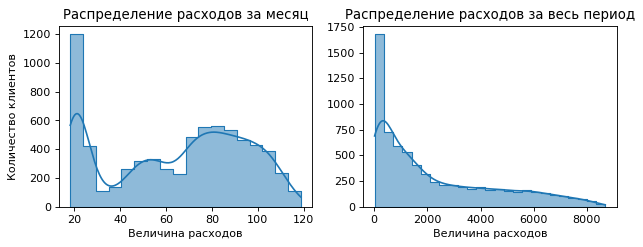

In [81]:
#comment
base64_data = 'iVBORw0KGgoAAAANSUhEUgAAAoMAAAD3CAYAAABmQl5wAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAxOAAAMTgF/d4wjAABS1ElEQVR4nO3dd3gc5bX48e9ZrXqzLUtucu/GNgZswGA6hB46BC4Eh4RygTRCSC7kBsIlCQnEyY+SAAkEAgkQWugdDDbN4G7j3uUi27JsWbL6nt8fM2uP16vVqO5KOp/n2UfaeaecmZ19952Zt4iqYowxxhhjuqZAvAMwxhhjjDHxY4VBY4wxxpguzAqDxhhjjDFdmBUGjTHGGGO6MCsMGmOMMcZ0YVYYNMYYY4zpwqwwaIwxxhjThVlh0BhjjDGmC+vyhUERmS4i6r7KRWSWiJwa77iMMZ2H5TPGmETW5QuDrj8BfYBDgDnAyyIyLK4RGWM6mz9h+YwxJhGpapd+AdOBuzzvg0AFcJ37/rvAPHfaOuD/gGDEOn4ArASqgdXA99zpxwPawGuYO89UoAi4AtgAlAN/BVI8688AHgS2ATuB14BBETGcHGUbMyPmOdTd30pgLfCrKPsyPcp6To7YzlfuOpYDN3jSBnn3zTN97zo8xyTovk8ClnqnudO/BXztbmcRcGEjn6MCVwMzgCo3xnGe9KOAD93jtw14GugZsY5TgC/c5YuBP7vTzwD2ACM9874EvOV5fzjwmXsObABuiRLjU1GO7fcizr3fA1vd/X4XGO5Jv8OzXLV7XM6KcUyuBta4+1ME/MKTNgp4A9juHpM3gME+jvEuIMMz7SJ3+lNNPF+jfmfctAuBJUCNZ3+nRjt/Yp13ifTC8hnLZyyf2Yn/fCb8KgH+wf55zhDgVZxzeBPwQER6pjtti7t/c4AjPPs2M9b2I2KZGuVYhl++ziPPuXgGzrlcCbwIdIuRP1zuLuOdNhx4x11+K3APB36v7ooS511+9tXuDEZQ1TqgFkh2JwWAm4GxwHXA94BrwvOLyNU4H8CvgTE4mXpZxGoLce4I9MH5MkfKc5c7CzgPOBO41ZP+EM6JcDpwBM6J8KqIJEVZV3g7f/BOFJE8nC/9G8A4nJP8MuAnEcsL++5g9IlYx0ick/gvwEHATcDtInJJlDj8mgr0i9jOicD9wO3udn4D/ENEjmxkXXcC9+H8GK0BXvIcoyw37ok4x7E/8GfPNscArwPv4dy5OR2nQIKqvgH8040hSUS+DZyAcy4gItk4x3UxMAG4Bee4XBYlxn+z79gWRaTdAlwJfAeYhPOlfyXic57lLjsemAk8EeN4zAMuBUbgnF8/EZHjPcfjeWCK+6oBnomxrrBy4ALP++/gZMheMc/XWN8ZEekBPIlznIa5+7rZR1wdiuUzls9g+UwsFwN93fWe4a4XEUkB3gZWAIcB57j74D0PH8G5mPg2zvfp17TsKehm9h3LPuyf/zXlPPoVznE/AaeQ/KdoGxORZHfecs+0JOBlnML54e56vo3zWUb6zBPrZ773sjWuejvyC0+JHCdj/jlQD0xoYP6fAx943q8Dbm5g3uNp5C4G+648Rnnm+R6w3TN/NdDdk56McwdhimfamUCt5/0deK6AgF8Cz0fEdxmwMmLap8Dtnvfeq+3HgHsj5r8VeC/avjWwjr3HBEgF1uNkrt6r+A+AGyPW8QjwtxifowJ3e97nusco6hUtcCTOj3GS+/4J4LUY68/GyfjvB0qBKz1p1wEbIz7nu4EvI9bxHPBXz/u17H/FvgW43vO+B86dgjMjP1OczO2XwCqf5/lAN8aTGkjv7R7DAY0c49/hnv84mfU6nMLbU37PV2J/Zw53t5PtmVZEJ7oziOUzYPmM5TOxj3H4c+yHe0fbff9t4KuI+Y9yz90knLuGCkxsYN37na8+9mcqUBTr+9bYeeSZ/zRP+snuedHNfT+dffnDDcDHEdNOwym094g4H7ZFbPce4F3P+73raOxldwYdt4hIOc4X4qfAf6vqPAAROUpE3hGRje48d+Bc7YWv1AbgHPCW2K2qSz3vZwF57lX2QTiZ8ga34nk5TiaRjnPih3UDdsfYxjjgm+F1uOt5FBgkIt7zIBsnc2toHTdGrOOXEXEAzI+YpyE34Dy6+SDKdu6JWMfUKNuJNCv8j6ruApYBIwFEpFBEnhSR1SKyG3gf54eit7vIWGJ8jqq6G+dxyI3Ap6rqvVIeCcxW525P2GfhbXt0o4HPSERygV7A555t7vDug2uyezyqcO6YfK+hmN31/peIVOD8wDyqqu+HtyciD4rIChEpw3n8CO65HcP7wBARGYSTMf8Lp1ATFvN89fGdKXLXd6GISCOxdDSWz+xj+UwUls/s9aq7/SLgS5w7puB8ZgdHfGbvAik4BceDgApV/SrGuie7y+4UkXki8l+NxNIYv+fRrIj/g8BQ7wwikgH8AvifiGVHAivczyrsM6Cn+zQlrBuxv58NCjZnoU7or8AfgXJV3RKe6GbCr+Pccv8lsAPnKndqeJZW2r7GSMvCuSKYECVtq+f/gThXgLHW8wzO1fH+G1cNed7GeiyXBUzDuXL3qot4fzbOlXjYiijrysG5+3GGu97I7dyM8zjAq7KBuMJiHcfHcTKMa3AymME4j1zCj+n8fJZH4xRU+otIiqrWNGFZcD6jV33O25C5OPVTgjjH7gURGa2qxQ3M/wpOZjoaJ8N6W1U/wXmsciTwI5wMPAjMZ9/xaEgI507gVDeOc9g/42rsfI15rFR1k4j8COcRyl9EpA6nLltnYPnMPpbPNMzyGbgW5+5xL5y7pP8H3IbzmX3spkfajHP+xvp8IvftTJxHurMjLpSawu95pA387/UjnDufn0RcCzfls1/kc979WGHQUaqqK6NMH4lT0v6Zqu4EEJG9VzSqWiYi63FuA8e6EmlMjoiMVNVl7vtJQImqlojIfJwfw3RVXRhjHZOBT2Kkz8e59R5tPwEQkYE49YrmxVjHyFjrcK33ztPADZ6fAB+p6lee+iXe7QzxsZ1Ih+NUuEZEcnDqsISP6ZHA5ar6nps+KWLZhTif473RViwih+AUes7GqS90O07mBM5dh4tEJOi5ap/sTg8vn49zFRj1M1LVXSJS7MY5x12mB8456M2kqjzHZamI/C9wDE69nGjr3Y1zpbjcPc7fcmM4Eucxxuvuto6JtnwDHsfJUBeq6rKIz7fR89XHd+ZvOD+mT+DUk5nRhNgSmeUzWD6D5TN+bHK3v1JEnsC5W3obzmf2TZxHt1WRC4nIIiBLRCbGuDsYuW+/wLlj29zCoN/z6HD2FRgPx7m4WeVJ7w78N875EWkpMFxEenjuDk7GeUy8A0BEgjh1VR9uzk40uw5MZ3kR45k6UIBT4fVWnFu+1+G0blrrmedqnIrcU915jgEu0ih1C9xpgziwLk8lziOMg4GTcK4of+VZ5gWcSsOn4lxpHotztZSHU0/iZDfO03EeR/TGyWy+wK1jgHNbvhTn7sTBOF/+i3FbfuF8GT7CeQzRUP2Nw3DqZtyFU4n9IDf+66PtWwPrCB+Tnbit5iKPE86XvQr4MU5GezDOY5NLYnyOitOQ4UKcq9Nncb5o4XXOd4/jcJz6F0vcZQa56WPcY/hrnMq9B+PWA8G50l8A/NF9H66jMtF9n43TWu6v7rKX4jwCu8xNz8KpRL7c8/n0xmkNeBPODzA4PwLFOFfiB+FcbS9hX32jO9zPtDdOY4Hv4dypO7iBY3I5TiX1gTg/LluAq920l3Eqho/Bqdj9uXs8jm/kGIc/x2uAo93/H2f/1sQNnq+NfWfc9EeAFz3vo9UZzATS3NdId9qYeOcnls9YPoPlM62Rz1zkbn8czh3CFz3HYI273kk4jczOxlPHFOeR8lKcVttDgHOBIz379glOvpEFXIJzF/agBmKZSuN1BmOeR575Z+E0zDoC5+7dExH5QznwZLQ8A6fu5tfuZzUW5ztYDNzqpqe7n2up+zmEP/tPcZ5GZDWaR8U7k4z3i0YqWLKvS4YKnBZuP8WTSbvz/Ng9Qatx6kRcFe2kcacNInqXD1NxKt5W4NSxSfUsk4Zzu30j+7qVeMg9AcLra+g13bOeccBb7klX5p6c33bTXsTJxAqjfDG9XT4ci3OnptI98T4Czoi2b9HW4Tkm3grO0Y7TeThXrtU4XTS8hfuFbuBzUpwCyqfuMnPwZF44Gcd8nC/tlzgtwvZm0u48pwKz3eW3APe703+Dc+Wf7pn3HpwfzlT3/eE4GV21+3ne4pn3jkY+o6nufJFdPrxHw10+1OI8FrsmxjGZhvPDFT5n7gDETRuGkylW4mQy36AJhcGI6Y+zf2GwwfPVx3fmWziP/rwVpaMVBqO+4p2fWD5j+QyWz9xBy/OZ8GsnTgGo0JM+EKeRzE6c83g+8BNPeiZOi+7tOPVzZwOHx9i3qxv7XkZMa9J55Jn/bJzvbRXwH/ZvrDUd5yJhcMS0yK5l3iVK1zLE7gJHgTsay6PCH5iJExGZivOBFzZz+UE4GfGgKGlT3HUf34IQOwQRUeAUdR/PJBIRuQNAVe+IkvY3nNZtj7dvVJ2PiKxUVevEOQrLZ1qH5TOmqdzH5h8Cybp/45/W3MZUnAL21Chpv8ApNN4Rax1WZ7Djq8e5EommBqcyuomvWC0dd9F4hXXjT3W8A+jELJ9JfJbPdF2VOJ9xNOX4KOvZncE4a+kVu3Ek8hW7MfFm+UzrsHzGNFV73BlsDVYYNMYYY4zpwqzTaWOMaYCI3Ccia0VERWSsZ/qnboe180RkkZs+3k17XESKPOn3eJYLiMj9IrJKRFaKyPXx2C9jjPGyOoPGGNOw53FaXs70TlTVo8L/i8iFOEOrLfDMcreqPhBlfZfjdLMxAmcoszki8oE2v8NbY4xpMbszaIwxDVDVj1W1qJHZrsLppsWPS4CHVLVenc5i/43TnY4xxsRNl7ozmJqaqvn5+fEOwxjTTjZu3FijqqlttX4R6YfTj9i3I5JuEpFrcPpM/IW6YxDjjDG8zjPfWpxRAxpl+ZcxXU9b52FhXaowmJ+fT1FRYxf5xpjOQkQa6g6ltUwFXlPV7Z5ptwGbVTUkIucBb4rIcFUNd/3hbbXX4JijInITzsgRAOTm5lr+ZUwX0w55GGCPiY0xplnEGQz3O0Q8IlbVjaoacv9/CWcUjpFu8nqcETTCBrrTDqCq01S1MPzKyspq5T0wxhiHFQaNMaZ5jsMZT/Zd70QRKfT8fyTO2L7hQeyfA64VkSQR6YFTh/DZ9gnXGGOia/PCYIyuGR4TkWVu1wsfi8gET1qGiDztdr2wXETO96RZ1wzGmHYhIg+KSBFQCLwnIis9yd8F/h6+C+jxuIgsFJF5OIPEX6Sq4dEBnsQZf3Y5zti196jqkjbdCWOMaUR71BmM2jUDzkDN16hqnYichdOqboSbdjNQrarDRGQw8JmIfKiqpVjXDMaYdqKqNwA3NJB2RQPTT46xvvqG1meMMfHS5ncGG+qaQVVf8QzN8jkwUETC8VwCPOjOtwb4GDjHk2ZdMxhjjDHGtIJEaU38Q+ANz+OWaN0vDIiR5qtrhqaoqq2ntj7y6U9syUkB0pKTWjsUY4xpMj95mOVZxhhIgMKgiFwOXAwcE5EUq/uFZnfN4EdVbT3jf/UONXVNKwymBAMsuP0blrkaY+LKbx5meZYxBuJcGBSRS4DbgZNUdasnKdz9Qrh/nYHAGxFpX3rSGuyaAZgWfl9YWKjR5otUWx+ipi7EVUcPIiXo70l6TV2Ixz5ZS219yDJWY0xc+cnDLM8yxoTFrTAoIhcDdwEnq2pkYe45nErWU90GJMcB13nSrhWRF3EakFwCnNYWMaYEA6QGLZM0xnRMlocZY/xoj65lGuqa4Z9AGvCy273MPBHJc9PuAdLded8GbnAbi4B1zWCMMcYY02ra/M5gQ10zqGpyjGUqcO74RUuzrhmMMcYYY1qJjUBijDHGGNOFWWHQGGOMMaYLs8KgMcYYY0wXZoVBY4wxxpguzAqDxhhjjDFdmBUGjTHGGGO6MCsMGmOMMcZ0YVYYNMYYY4zpwqwwaIwxxhjThVlh0BhjjDGmC7PCoDHGNEBE7hORtSKiIjLWM326iKz2jKv+Y09ahog8LSIrRWS5iJzvSQuIyP0isspNv76998kYYyK1+djExhjTgT0P/B6YGSXtB6r6WpTpNwPVqjpMRAYDn4nIh6paClwOjAFGALnAHBH5QFWXtlH8xhjTKLszaIwxDVDVj1W1qImLXQI86C6/BvgYOMeT9pCq1qvqDuDfwLdaK15jjGkOKwwaY0zz3CMiC0XkWREZ4pk+AFjneb/WndZYmjHGxIUVBo0xpumuUNXRwHhgBhD5uFg9/0sT0vYliNwkIkXhV3l5eYsCNsaYhjS5MCgifUVkTFsEY4wxHYGqbnD/qqo+AAwRkTw3eT0wyDP7QHdaY2mR25imqoXhV1ZWVivugTHG7OOrMCgid4rINhH5PvAV8K6I3Nm2oRljTOIRkaCI9PK8vwAoVtUSd9JzwA1u2mDgOOAVT9q1IpIkIj1w6hA+227BG2NMFH5bE18OnIrzOGQgUIlTKPxlG8VljDFxJyIP4jT+6A28JyLlwMHA6yKSCoSA7cA3PYvdAzwmIivd9BvcxiIATwKTgOXheVV1SdvviTHGNMxvYXCXqs4RkZWquh1ARCrbMC5jjIk7Vb0B9y5fhIkxlqnAueMXLa2+gfUZY0zc+C0M9nQ7R+3h/hWgZ9uFZYwxxhhj2oPfBiTv4TzaCP+dCLzvZ8EYPfgXiMhbIrJCRBaJyBRPmvXgb4wxxhjTDnzdGVTV77RgGw314H838LmqniYik4DnRWSoqtZhPfgbY4wxxrQLv62JgyLyExF5U0TeEJEfi4jfgmRDPfhfzL5e+r8EioHw3UHrwd8YY4wxph34rTM4DRgKPOy+/y4wGPhBczbq9scVUNVtnslr8ddLf7S0BitzG2OMMcaYhvktDB4PTFDVEICIvAbMaeG2NeJ9U3rp992DP3BT+H1ubm5T4jPGGGOM6fT8NiCRiHmFGIWwxoQ7ZxWRfM9kv730Ww/+xhhjjDGtxG9h8G3gbRG5TEQuxRmH880WbtvbS/8knE5dZ0ZJsx78jTHGGGPaiN/HxLcA1wDn49wRfAl4xM+C0XrwV9VhwM+AJ0VkBVCDM/B7nbuY9eBvjDHGGNMO/BYGT1LVh4CHmrqBhnrwV9Vi4BsNLGM9+BtjjDHGtAO/j4l/16ZRGGOMMcaYuPBbGDTGGGOMMZ2Q38fE40Rkq+e9AKqqBW0QkzHGGGOMaSd+C4PLgTPaMhBjjDHGGNP+/BYGa1R1XeOzGWOMMcaYjsRvncEn2jQKY4wxxhgTF34Lgy+KyIDIV5tGZowxcSYi94nIWhFRERnrmf6YiCwTkXki8rGITPCkPS4iRW7aPBG5x5MWEJH7RWSViKwUkevbeZeMMeYAfh8Tz3b/5gI7cRuQANaAxBjTmT0P/J59oyOF/Qe4RlXrROQs4N/ACE/63ar6QJT1XQ6McefNBeaIyAequrTVIzfGGJ983RlU1XxVzQcWq2qB+94KgsaYTk1VP1bVoijTX/GMmPQ5MFBE/OSnlwAPqWq9O6rSv4FvtV7ExhjTdE3tZ1DbJApjjOm4fgi8oaohz7SbRGSBiLzmfYQMDAC8jfHWutOMMSZu/D4mNsYYE0FELgcuBo7xTL4N2KyqIRE5D3hTRIararmb7r2olhjrvgm4Kfw+Nze39QI3xhgPX3cGRWSb2+n0OBHZ6nlvjDFdkohcAtwOnKKqe/NDVd0Yvkuoqi8BZcBIN3k9MMizmoHutAOo6jRVLQy/srKy2mAvjDHG/53BiW0ahTHGdCAicjFwF3Cyqq6PSCsM1zMUkSOBPGClm/wccK2IvIjTgOQS4LR2C9wYY6LwVRhU1XUiUgCMVNUZIhLExjU2xnRyIvIgcA7QG3hPRMpVdRjwT2AL8LLI3ie9J6lqCfC4iPQC6oFK4CJV3eXO8yQwCWdUJ4B7VHVJ++yNMcZE56swKCLnA9Pct4OAg4DfYkPUGWM6MVW9AbghyvTkGMucHCOtPtr6jDEmnvze3bsVOAwoBVDV+Th1XYwxxhhjTAfmtzAYch9/eNW0djDGGGOMMaZ9+S0M7nbrwCiAiJyAe5fQGGOMMcZ0XH5bE/8MeAMYLCLTgeHA2W0VlDHGGGOMaR9+WxN/JSInAkfhdJL6qarubMvAjDHGGGNM2/PdPYyq7lLVN1X1jdYqCIrIqSIyW0TmisgiEbnSnV4gIm+JyAp3+hTPMhki8rSIrBSR5W5LZ2OMMcYY0wx+u5YJceAQSqqqSc3dsDidc/0LOEFVF4jIIGCp2xnr3cDnqnqaiEwCnheRoe7A8DcD1ao6TEQGA5+JyIeqanUYjTHGGGOayO+dwaeBOcDRQA6Q7f5tDd3cvzlACVCNM9bngwCq+iVQDITvDl7iSVsDfIzTKawxxhhjjGkiv3UG/0tEjgEeAGYAv1TV3S3ZsKqqO6TTiyJSAXQHzscpaAZUdZtn9rXAAPf/AcC6BtKMMcYYY0wTNKXO4AzgcGAV8IWIXNGSDbtD2v0PcI6qDgROAp4Iby5y9shwYqR5t3GTiBSFX+Xl5S0J2RhjjDGm0/FVGBSRL0VkFvA5cCWQCjzewm1PAPqq6iew93HwJmC8u818z7wDgfBg8OtxhsSLlrYfVZ2mqoXhV1ZWVgtDNsYYY4zpXPz2M3hzG2x7A1AoIiNVdZmIDAOG4gzg/hzO+J13uA1IegMz3eXCaVPdBiTHAde1QXzGGGOMMZ2e3zqDH7X2hlW1WESuxWkpHMJ53Hu9qm4UkZ8BT4rICpxh765wWxID3AM8JiIrgRBwg6ruaO34jDHGGGO6Ar9dy6yONl1Vh7Rk46r6NE5L5cjpxcA3GlimAqdFsTHGGGOMaSG/j4mrgQvbMhBjjDHGGNP+/BYGK1V1cZtGYowxxhhj2p3fwuBIEfkcqASKgA+Ax1U1sgsYY4wxxhjTgfjtZ/AM4FZgGvAZ8B3g3rYKyhhjEoGI3Ccia0VERWSsZ3qzxk8XkYCI3C8iq9z069t7n4wxJlKzWhOLyKPA9LYIyBhjEsjzwO/Z17VVWHPHT78cGAOMAHKBOSLygaoubbc9MsaYCL5HIPFS1WqcEUOMMabTUtWPVbUoSlJzx0+/BHhIVevdLrH+DXyr7fbAGGMa53cEklsi3h8OfNUmERljTAITkTyaP366ja1ujEk4fu8MniAiPxXH/+IMRTe1zaIyxpjE1pLx021sdWNMQvFbGDwP57HwUmAwMElVZ7VZVMYYk6BUtQSaPX66ja1ujEk4vgqDqlqFU+dlLbDUHQXEGGO6qvAY6cQYPx3P+OmveNKuFZEkEemBU4fw2XaM2xhjDuB3OLptOI82koFTROSngKpqQVsGZ4wx8SQiD+JcCPcG3hORclUdBjR3/PQngUnA8vC8qrqknXbHGGOi8tvp9MQ2jcIYYxKQqt6Ae5cvYnqzxk9X1fpo6zPGmHjy28/gusbnMsYYY4wxHU2z+hk0xhhjjDGdgxUGjTHGGGO6MCsMNlFFdR1llbXxDsMYY4wxplX4bU0cBH4InIzTqvg94D5P67lOr6K6jjcXbWHjzkoACrunc+pBvclK9dsGxxhjjDEm8fi9MzgNOBF4GHgEOMGd1iVU19bz3OwiNu6sZERBFiN6ZVFUWskLs4uoqO4y5WFjjDHGdEJ+b2sdD0xQ1RCAiLwGzGmroBLNh8u3sauylmOH9+SQAd0B6NttJ9OXbePDZVs5c1yfOEdojDHGGNM8fu8MSsS8QowxNTuTjaWVLNuym8E9M5nQv9ve6QcXdmN4QRartlWwapsNyGKMMcaYjslvYfBt4G0RuUxELgVeA95s6cZFJFVEHhCRFSKyWESecqcXiMhb7vRFIjLFs0yGiDwtIitFZLmInN/SOGL5fE0JInDs8J6I7F/+PW5EPslJwmerS1CNHLfeGGOMMSbx+X1MfAtwLXA+zh3Bl3DqDrbU3TjDNY1QVRWRPp7pn6vqae64n8+LyFC3wcrNQLWqDnPH/fxMRD5U1dJWiGc/xWVVFJVWMrpPNt0yUg5Iz0wNcnBhN75aV8rq7XZ30BhjjDEdj98RSELAX9xXqxCRTOA7QKG6t9VUdbObfDEw2J32pYgUA1OA6TjDPE1109aIyMc4Y4c+3lqxhX29uQyAQ916gtEcMqAb8zbsZP6GXa29eWOMaRN19SHqQ/Y0wxjj8PWYWETOE5HnRGSyiHwtIltb4fHsUKAE+IWIfCUiM0TkJBHJAwKqus0z71pggPv/AGBdA2mRcd8kIkXhV3l5eZMCXLW1gt45afTMSm1wnoyUICN6ZbN1d3WT1m2MMe2torqONxdu5qGPVvPXGWsA+GJ1SZyjMsbEm986g78FPsWpK3gjcDrwqxZuOxkYAnytqhPd9T6Dc7cy8pI1srGKxkjbN5PqNFUtDL+ysrKaFGBdSDmob06j843rl9uk9RpjTHvbuaeGZ7/awPKt5fTJTWNwzwwArv7HbP42Y3WcozPGxJPfwmCNqv4R2K6qH6jqbKClHeytw6kv+E8AVZ0PrAFGA4hIvmfegcB69//1wKAG0lpVQGB4r8YLkL1yUsnLdOoUVtfWt0UoxhjTbHWhEG8s2kJ5VR2njO7FBYcVcupBvQEY3DOTu15fwr++aJNs1BjTAfgtDAZFZAxQLyKj3f8bfnbqg6puB94HTgUQkYE49QSXAc8BN7jTJwG9gZnuot60wcBxwCstiSXSzj01ABR2zyA1mNTo/CKyt9A4c+X21gzFGGNabNaaHWzbXc2kQT0YE/G047GpExnQI4P/fXkRs9bsiFOExph48lsYzABeB9KBN9z/01ph+9cBt4jIQuBl4Bq3EcnPgKNEZAVOw5ArPEPf3QOki8hKnC5vblDVVs3BPlzmVFcckp/pe5lhBU5h8PWFW1ozFGOMaZGK6jrmrt9JXmYKRwzucUB6XlYqj02dSEpSgB89M5dde2zsdWO6Gr+tiQe1xcZVdTXO6CaR04uBbzSwTAVOi+I2E746HpSX4XuZ8BjFHy3bRkV1HZk2ZnGXU1VbT219qEnLJCcFSEtu/O6zMc315dod1IWUo4bmEQhEr2I9rCCbX549hv95cSF3v7WU354/rp2jNMbEk68Si4i8oKoXtHUwieLX547ltQWbm/UjXVMfYsaK7Zw2tncbRGbaS1MLdtV1IY66+wNq6ppWGEwJBlhw+zesQNgBiUg3nO6uwjJwGsUVAC/i9HJQ5qY94da7RkQygEeBSTj1pn+uqi+2RYzVdfUs3lRGQXYqg3vGftLxrUn9eXneRp6etZ6LJhbG7FLLGNO5+L19NbhNo0gwDV09+/XekmIrDHZgVbX1jP/VO00u2AUDwtXHDCbJ5/lTUxfisU/WUlsfssJgB6SqO4EJ4fcicjNwnKrucEcr+oGqvhZl0XbrOH/ZlnLqQsrB/bsdMIJSJBHhrnPHcvr/m8FtLy3i1RuPJpjktyaRMaYj81sYzBeR6yMnquqfWzmeDm94QRYfLN1KfUh9FwpMYqmtD1FTF+KqoweREvT/Y5gkYj+eXdt3gNt8zNd+HedvKiMtGGBEgb9utYYVZHP1MUP48/RV/OOzdVw1pUvdBzCmy2pKA5JJEa+JbRVUR3bCqAJ2VNQwZ32rX+SbdpYSDJAaTPL9am5BsLy6jt1Vtb5fVdZ9UcIRkclAHk5frGH3iMhCEXlWRIZ4pvvuOL+ldlbWMrJ3dpPOze+fOJx+3dL543vLKSm3zvSN6Qr83hlcp6rfadNIOokTRubzyMeree/rYiYNOrDlnjFhSSIEA8Lk337QpOWsnmFCugr4h6fXgytUdYM4z2ZvwCkkjvHM32jH+SJyE3BT+H1ubvM6tx/ZO7tJ86enJHHrGaO54V9zmPbucn59njUmMaaz81sYtOedPo3pk0NBdirvLinmf84YHe9wTBsKhZTtFdVs311DWVUtu6vqqK0PUVsfQkRIDggpwQBZqUGy05LJTgvSPTOFzJQkxH2kfO2xQ6hX/2PEWj3DxOOOs34JcHh4mqpucP8q8ICI3Csieapawr6O88NDbg7E6bJrP6o6DZgWfl9YWOj7RAm54w5npwXpnRO7F7Dy6gPHDzhmeB6HDujG07PWc/HE/hzcv5vfTRtjOiC/hcHJbRpFJxIICCeN7sXTs9azals5Q/ObNgSeSWwV1XWs3lbBym3lbNpZSV3owN/npICA0mAhLy05QM+sVAqyU+mTm06f3DTriqhjuwhYoKpLAUQkCOS5XWQhIhcAxW5BEPZ1nD/V03H+da0Z0KJNuwAYmp/ZYMMRv3emz/3zJ3z9q1NJT7Fz1JjOyu+3+0URuSKcmYlIT+BxVT2r7ULruE4ZU8DTs9bz4dKtVhjsJLbsqmLuhlJWbC1H1RmqsG83pyBXkJ1GbnoyOWlBUoKBvT++oZBSXRfaWyewrKqOkopqSsprKC6roqi0EtgJQG56Mn1y0+ibm07fbmn0yExptPWnSRjfxekqJiwVeF1EUnG6jtkOfNOTfg/wmNtxfog26Dh/uttx/qC8hruT8XNn+v0lW1mxtZy3Fxdz7iH9WjNEY0wC8VsY7Ou5qkVVt4tI3zaKqcObPKQnKcEA05dt43vHDGl8AZOwSsqrmbFyO+tK9gDQv3s6Y/rmMLhnZqNDFQYCQnpKEukpSeRn7z96o6qyo6KGzbuq2LSrks07q1i6ZTdLt+wGICMlif7dMyjskc6A7hnkpCe3zQ6aFlPVYyLeVxCjgV17dJwfHkWpICf2qKHBpEDMH4HJQ3uwYms5f3hnGaeP6+1reE5jTMfjtzAYEJFguHK0iKTQwrGJO7P0lCSOGNyDL1bvsNFIOrCZK7ezeGMZilMJf+LA7vTMap3TXkTIy0olLyuVsf2chgF7aurYvMu5Y7ihdA/LinezrNgpHOakBenfI4Peua0xCqTpzDbs2MPKreUABFp4dznDfTS8obSSv3+yluuOG9ri+IwxicdvKeUt4BkR+ZP7/kc44xObBhw3Ip8ZK7bz2aoSTh7TK97hdHlNGVHkC3c4wkUby+iTm8axI/IbrYTfGjJSggzNz9pbtWBPTZ1TMNyxhw2llSzeVMbiTc6AFuf9+VNOHt2Lk0YXcOiA7tanpdmrdE8NBxfmMr9oV6uts7B7Og98sJILDi084C63Mabj81sYvA24lX0t214BftcmEXUSx48s4K7XlzB9+VYrDMZZc0cUOWpIHocN6t7iuyvNlZESZESvbEb0croGKausZU1JBdOXbaO0ooaHPlrFQx+toltGMieMLODEUQUcNzKfnDR7pNyVjS/sxlPfO4Jxd7zTauu8+Rsj+NGz87n37WX87sLxrbZeY0xi8FUYVNVa4Ffuy/gwND+Twu7pTF+2DVW1xgBx5GdEkZAqn64qYdHGMnLSgpw+tje9c9PbOdLYctKTGdU7m+nLtvHBT45jbcke3l+6lfeXFPPS3I28NHcjKcEAJ44s4JwJfTlhVIF1P2NaxYmjCpg8JI9/z97AFZMH7q3aYIzpHHwVBkWkH/Ag0F9VDxORCcDxqvqnNoytQxMRjh+Zz1Ofr2f19gprVZwAwiOKRKoLhXhnYTGrt1dQ2C2dM8b3IT3BC1F7ausZkp/JkPzBXH3MYIrLqvho+TbeWVzM24u38NbiLWSlBjlpdAHnH9KPwwf3sK5BTLOJCL88ewxn3jeDO1/9mmevPdIucI3pRPz+OjwMPAP81H2/CHgS+FMbxNRpHD+igKc+X8/0ZdusMJigautDvLZgM+t37GFkr2xOGdMroevfNWXUkvLqOl6et4mX521CgDu+eRAXTSzc2yjAmKYY3SeHbx0+gH99sZ7XF27mrPHWoYQxnYXfX4XeqvqUiPwEQFXrROTAbuvNfo4alkdKUoDpy7byXRvwPeHU1Yd4Zf4mikorGds3hxNGFcStfqBfTR21ZEdFDQs37mLJ5t3c/spipr27nO9OGczUowdZ3ULTZD85ZQSvzd/Er179minDetItIyXeIRljWoHf0cvrxPNMQES6N2HZLisjJcjhg3vwxZodVNbUxzsc41EfUt5YtIWi0krGF+ZyYgcoCIYFk5zH3X5efXLTOW5EPgC/OHM0uenJTHt3OUff/QF/fHc5ZVW1cd4b05HkZaXyv2eNYdvuau587et4h2OMaSV+C3TPAQ8B2SIyFXib/XvcNw04fmQ+NXUhPlu9Pd6hGJeq8u6SYtZsr2B072yOH5HfJeo/XTKpP+//5Djuvehg8jJT+H/vr+CEe6bzzKz11EcZVs+YaC48rJDjR+bz4pyNfLh0a7zDMca0Al+FQVX9AzAdmA2cAdynqve1YVydxvEjnbsy4eGhTPx9uqqEZVt2M6RnJieP7tUlCoLg1CGsqq3n1IN68dL1R3HnNw8C4OcvLuSbD8xk9rod7K6qZXdVLVW1difbRCci/Pb8cWSnBvn5iwvYUVET75CMMS3kuya5qj4NPN0WQYjI7cAdwDhVXSQiBcA/gKFANXCdqs50583AuSs5CWdcz5+r6ottEVdzlFfvX5WyIDuVvrlpfLh0K7tPPfCRXHJSwLr/aEeLNu7iq3Wl9M5J4/SxvQkkcGOR1uKn0cniTWVc8JfP9r5PCQZYcPs37Nw0wIH5WlZqkJ+fPorb/rOIm56dx18uP9RaqxvTgfntWubvwAHPkVT1qpYGICKHAkcC6z2T7wY+V9XTRGQS8LyIDHWHw7sZqFbVYSIyGPhMRD5U1dKWxtISfn5wo3UCaz+67aeodA8fLNtKTlqQsw/uQzCpa1R79dPoZOvuaqYv28qOilp656Sypaya2vqQnZddnJ98bfrybYy94x0W/+pUO1+M6aD8Xsp95fn/Z7TS6CMikorTf+FlwIeepIuBwQCq+qWIFANTcB5VXwJMddPWiMjHwDnA460RU3PF+sFds72CtxcXc/TQPMYV7uustaYuxGOfrLUf3XbyzuJikpMCnDOhX5frXiWYFIj5Ze/fPYNLDx/AzBXb9w5j9uXaHZw4ykbP6coau5CoqQvx/OwiyqrqmLu+lMlDe7ZzhMaY1uC3zuCD4Rew3fN/S90JPKWqa8ITRCQPCKiqt5LdWmCA+/8AYF0DaXHVUCvPIT2zCAgU7azcb3pDo2GY1lVSXg1AXUg5c1wfemRadxjRBAMBjh9ZwDfGFABwzT9m8+KcojhHZeItVuv17LRkTnGH2/zhM/PYWlYV52iNMc3RpNKIiAwFWuWXVEQm49T7+3OU5MjL0MiKXRojzbuNm0SkKPwqLy9vXrAtlBIM0LdbOkWlldTVN218XNMyVbX1/OjZ+QAcM7wnA3pkxDmixDfE7SC9Z1YqN/17Pve9vwL12a+h6Xrys1MBp6rBdU/NprrOGh8Z09H4KgyKyDYR2QbMp5UeEQPHAaOANSKyFijE6bLmcHeb+Z55B7KvTuF6YFADaftR1WmqWhh+ZWXFbxSQQXmZ1IeUotLKuMXQ1agqP3thAfM27AScERSMf3+98jBG98lm2rvLuev1JZRV1uxtbRztZS2Qu7bvHD2IOet3cttLi+ziwZgOxm/FqYk4LXeLVbVV+hFQ1btxGooA4BYIz3JbEz8H3ADc4TYg6Q3MdGcNp011G5AcB1zXGjG1pUF5GcxcCWtLKhjUMzPe4XQJ93+wkpfnbeKEkfl8aF37+BZuNHD2/Z/snfbozDU8OnNNjKW6ZmMoN9+qcl8Av1XVZztyjwjN9d0pg1m5tZznZxcxuGcm35488IB5rPcEYxKTr8Kgqq5rfK5W9TPgSRFZAdQAV7gtiQHuAR4TkZU4GekNqrqjneNrsh6ZKWSlBllbsifeoXQJr87fxLR3lzOmTw53nz+OI3yM5WsckY0GaupCvLloC5t3VXHYwG5MGtTjgGW6eGOoC1V1UcS0DtcjQnOFLx6m/G5fG8B73l7GPW8vO2DernjBYExH4LdrmRAH1tNTVW21b7SqDvL8Xwx8o4H5KnBaFHcoIsKgvAwWbSpj554aG9OzDc1as4OfPDefguxUHp06kYzUrtVyuDV4Wx+nBpM4d0I/XphTxOx1O8lOTebg/t3iGV5H0OF6RGiuyIuHsqpa/jN3E9W1Ic4c35u+3dKBLn/BYExC89uA5GlgDnA0kANku39NE4QfD6+zu4NtZtHGXXz38S9JDgiPXjmJPrnp8Q6pU0gJBjhnQl+6ZyQzffk2VmzdHe+QEsk/RWShiPxNRPI7co8IzeVtcZyflcY5E/oSCMDbi4spr6qz3hOMSXB+u5b5L+Am4AHgLpyMrqItA+uM+nfPICBOvUHT+lZtK2fq32dRXR/ir1dO3K9PR9NyGSlBzp3Qj4yUJN5ZXMzW3daNCHCsqh4MHAqUAE+401vcI0Ki9IbQHAXZaZw5rg+19SH+M28T5VV1jS9kjIkb35dqqjoDp6XvKuALEbmizaLqpFKCAfrmWhczbWHJ5jIuefgzSvfUcv+lh3CUdX7bJnLSkzl7fF8UeHX+Ziqqu/aPvKqud//WAn8CjlHVEmh5jwiJ1BtCcwzMc8b+Lq+u4z/zN1qXM8YkML9dy3wpIrOAz4ErgVQ6aP2WeBvYM4O6kLJxp3Ux01rmrC/lkoc/o6yyjgcvO5RTD+od75A6td65aZw8qoDy6jpeX7iZ+lDX7EZERDJFpJtn0qXAXPf/cK8HxOgRAU+PCK+0Q8jtbnSfHI4emkdJeQ1vLSqOdzjGmAb4rVl/c5tG0YUMysvkk5UlrC3ZQ+/ctHiH06qqauuprQ9RUxdiT00dKUkBUoKBmGMAt6SrCVXlmS83cPsri0kS4dGpEzlmeH7jC5oWG9Unh+Ld1czbsJPPVpcwaVD3eIcUD72AF0QkCedR72rg225ap+sRobkOG9idipr6vf192lMRYxKP365lPmrrQLqKvL1dzFRw5JADu+joaKrr6vl4+XZmrtzGPz5dd0BFqcY0t6uJ0ooa/u+1r3lx7kb6dUvnL5cfyvjCbk3cummJKcN6snlXJbPXlVLgjkLRlajqauCQBtI6XY8IzSUiHDu8J3tq6lheXM7tr3zNny6ZQCDQ4OBRxph25rdrmdXRpqvqkNYNp/MTEQbmZbB4UxlllbXxDqdB4bt8DdmwYw///GI9ry3YzC7PfvTOSSUzNUhKMEB9SKmtD7G7qo5dlbXU1u8rKuamJ9M7J5VlxeVs2VXJoJ7+6kNV1dbz1OfruO/9FZRV1XHiqAKmXXywddUTB0kB4YyxffjXrPV8uHRrvMMxCUxEOG5EPsuLy3ll/ibys1P5xZmjEbECoTGJwO9j4mrgwrYMpCsZlJfJ4k1lCdvFTFVtPeN/9Q41dU17nJMkcMGhhVEfC6sqpXtq2bSzko3ua1mx0zry+Hs/YmSvbCYPzeOwgd0Z3DOTft3S93ZFUVRayYqtu/lsVQlvLNxM6Z5a+nVL567zxnH2+D72gxJHOenJnDKmF68t2AzYI0DTsCT3TuChA7rx6Mw19MhM4YYThsU5KmMM+C8MVqrq4jaNpAsZmJdBMCCs2paYXUWE6/1ddfSgvQUyVWV5cTmfrCyhpj5Er5xUDh/cg765aXsLY0kiDdYPFBF6ZKbQIzOFsf1yUVW2l1fzr1kbOGNcb75aW8rjn67l8U/XxoxtaH4m3z9xOJcdMcA6rk0QQ/OzGNcvh4Uby/jbzDX89NRR8Q7JJLD7Lz2E7/1jNve8vYzuGSlcdkSH7mLRmE7Bb2FwpIh8DlQCRcAHwONqo5E3S3JSgCH5mSwvTszCYFhK0OlItqq2nne/3srq7RVkpiRxypg+DM3PbNEdOREhJz0ZgN9dMJ6s1CCrtlWweNMu1pXsYdPOSupCSkiVPrlpDC/IZlxhLkPzO1b3Gl3FEUN6sHBjGQ9/tJrTDupjfTyaBuWkJ/PEVZO46KHPuO0/C+mWkcwZ4/rEOyxjujS/hcEzgCQgE+gPfAcYC/ykjeLq9Eb0yk74wiDA9vJqXp2/ibKqOkb0yuKEkQVtckdORBhWkMWwAivsdUTBwL47wj/+9zxe+/4Uu3NroiqvriMrNchDlx/Ktx/9kh88PZekgHDU0DygZT0MGGOap1mtiUXkUZwxNk0zDczLICUpQE0C17Fau72C95dupT6knDiywO72mEbdcMJQ/t/7K7nn7WX871lj4h2OSSBJIgQDwuTffnBA2rVPzt77f3N7GDDGNJ/fO4P7UdVqYHIrx9KlBAMBBvfMYFlxOetKKhjbr1u8QzrA24uLSUtO4pwJfejXzcb4NY2betQgZqzYzqMz13DS6AIbCcbsFUwKcO2xQ6iPqF20ZVcVry3Y7LROH9ebl+ZuorY+ZIVBY9qR3xFI+ojIayKyR0QqROQVEbFKHi0UfiSaaD3zP+E24shKC3LRxEIrCBrfgkkBpl08gfTkJG55fgHlXXy4OrO/YJJTD9n7GpiXuXcc47cXJ1ZeaExX4Xds4keAT4G+QD/3/0faKqiuoq9byHpl/iZCbTikV1VtPburan29Hpq+knvfWQ7AuRP60r0d+u8rr67zHd/uqlqqam2M00Q2qGcmPz99FEWllfz2jSXxDsd0AIN6ZnLa2N5U1jjf7XUlFXGOyJiuxe9j4v6qerbn/d0iMq8N4ulSwv1urd+xh09WbW+TodRa0mdgTlpyq8ez/zYarkMUi9UpSnxXHDmQNxdt5p9frOeMcX04epg9LjaxDS/IpmZ0iPeWbOWqx7/iuesmMzAvM95hGdMl+C0MBkSkt6puARCRApyxOE0rEOCpz9e1SWEwWp+B0azYWs77S7aSnRbknAl9yU1LjjmmcGtoqA5RLDV1IR77ZK3VKUpwgYBwz4UHc+qfPuaW5xfw1o+OIbuNLy5MxzesIIv3lmxle3k133rkc5763hHWnZQx7cDvr/09wFwReUREHgZmu9NMKzhqWB7vLdnK5l2VbbaNcJ+B0V5FpZV8sHQrWalBLji0kLzM1DYvCIZFq0MU6xWrQGsSS/8eGfzP6aPYuLOS37yxNN7hmA7kN+eNY+vuai566DMWFO2MdzjGdHq+fllV9UngZGABsAg4VVWfasvAupJLJvanPqQ8PWtDu297XUkFby7cQlowifMP6Uduut29Mc0XWf/zmwf35YjBPXh61nreXrzF6n8aX84c34dHrjiMiuo6Ln3kc2au2B7vkIzp1GI+JhaRAaq6HsAdjm6xJ+18VX2xjePrEo4dkU/f3DSembWeG08Y1m53vzaWVvLags0Ek4TzDulH98y2byzSWprSStVatLY9P/U/vX3JhVn9TxNNeXUdhw/uwSNXHMaNT89l6t9ncde5YzlzvNOJhXVMbUzraqzO4IcickK4QAggIrnAn4GDgWYXBkUkDXgGGAPsAbYA16nqWrdO4j+AoUC1O32mu1wG8CgwCQgBP+/ohdKkgHDF5EH87q2lvDS3iEsmtf1YnVt2VfHy/I0ERDj3kH7kZ6e2+TZbQ3MbnQQDQlILhs8zsTVW/3PxpjJmrNjO6D7ZHDfCqRtr9T9NpFjf75+/uJCfv7gQsIsIY1pbY4XB3wPTReREt5B2Ok6XMs8CV7XC9h8B3lRVFZEb3fffAO4GPlfV00RkEvC8iAxV1TrgZqBaVYeJyGDgMxH5UFVLWyGeuLn8yAE89NEq/jx9FRccWtimdfa27a7mP/M2ogrnTOhL75y0NttWa2tOoxNwf2TaqR5kVxVMCjSYoRzSvxtrSypYsnk3I3tlWytRE1VD3++K6jreXlzM1t3VFHZPp6i00i4ijGlFMX8dVfVh4Lc4dwj/DtwPXKaqN7ujkDSbqlap6huqe7/1nwND3P8vBh505/sSKAamuGmXeNLWAB8D57QklkSQnZbMd44exLqSPTw3u6jNtlNSXs1LczdSV6+cNb4P/bp3vA6lm9roJDWYZAXBOBMRTh7Vi5SkAO8t2Up1ndUVNNFF+373yEzlosMKGdMnh6JSp6HdZ6tK4hypMZ1Ho7+QqvpX4NfAZcAFqjqjjWL5AfCqiOQBAVXd5klbC4SfnQ4A1jWQ1qF975gh9MxKYdq7y6log3puJeXVvDBnI9V19ZwxrrfdnTHtKic9mSnDe1JeXceMTtAgQETSROQ/IrJcROaJyFsiMshNmy4iq93p80Tkx57lMkTkaRFZ6S57ftx2ogMJJgU4ZUwvThzlVDO45snZ3PrSQnZV1sY5MmM6vpiFQREZIyJjcEYceQCnsHaUZ3qrEJFbgeHAbe6kyGeAkZW9NEaad703iUhR+FVeXt7yYNtQVmqQH548gm27q7nv/RWtuu4dFTV7C4JnjuvDEOu7y8TB2L45DOiRweJNZawv2RPvcFrDI8BIVZ0AvMb+IzP9QFUnuK8/eqbvreoCnAr8WUS6t1vEHdyIXtkATBrUnX99sZ5Tpn3Ef+ZubNNRnIzp7Bq7M/i653U+UA/8033/WmsEICI3u+s+XVX3qGqJO93bA/NAINyIZT0wqIG0/ajqNFUtDL+yshK/AHTppP6ML8zlbzPXsGjjrlZb7yvzN1lB0MSdiHDS6AJSkgJ8tHxb4wsksEaqusTSKau6tLdHr5zI7y8YT3VdiB89O4+zH5jJR8u3oU2sT2yMabzO4OAYLz+ZXkwichNwKXCKqu70JD0H3ODOMwnoDcyMkjYYOA54paWxJIpgUoC7zx+PAD94Zm6Lu0X5dKXzOK6mLmQFQZMQctKSOWZ4TypqOl29wR8Ar3re3yMiC0XkWRHx5pedtqpLexIRLp7Un49+ejxXHzOYFcXlXPnYLM5+YCavzt/U5CE4jenK4larXkQKgT8A3XAaqMwTkS/c5J8BR4nICuBx4Aq3JTE4I5+ki8hK4G3gBlXd0a7Bt7ExfXP4+emjWL2tgpv/PZ/6Zjz+UFX+9cV6bvjXXADOGm8FQZM4DuqbQ3+38dLHHfwOIUSt6nKFqo4GxgMzOPBJSqNVXTpaNZf2Fu7gPCkg/OCk4bz6/aO59PD+rCwu5/tPz+WI37zHna9+zZLNZfEO1ZiE53ds4lanqkU0kAmqajFOFzPR0ipwHrN0at+dMph5G3by2oLN/OI/C7nr3HEkBfz1k7erspZbX1rI6ws2069bGht3VtG3W8drNWw6LxHhuJH5PPX5en716tdMGZZPbkbHHP3GU9XlZFXdA6CqG9y/CjwgIveKSJ5bDSZc1SVcCh4IvBG5XlWdBkwLvy8sLLTnn/jva7R0Ty2PfbKGxz5Zw/CCLE4cXcDJo3txSP9u1ruAMRHiVhg0sYkIf7j4YHZV1vL0rA2UlNfw+wvH0y2j4VFCQiHllfmb+P1bS9m0q4rTx/bmtjNHM+V3H7Zj5Mb4k5XqZD9bd1dz52tf84eLD45zRE3nqepycriqi4gEgTz3ohYRuQAoDteHZl9Vl6meqi7XtXfsHZWfvkbDHZo/edXhvLFoM+9+vZWHP1rNwx+tJictyGEDuzNxUA8mDuzO2H65ZKbaT6Hp2uwbkMBSg0n87cqJ3PL8Al6et4m5f/yYG08YxrkT+u13F6Wsqpb3vi7m0ZlrWLypjJy0IL85bxyXHt7fhmIzCW/KsJ68MKeIk0cXcPq4PvEOxzdPVZfVOFVdwBkx6UTgdRFJxRklaTvwTc+i9wCPuVVdQnTCqi5tLVYH517DemVx64DR/Py0UXy9uYyPl2/j01UlzFixnQ+XOTdmBejfI4MRvbIY0Sub4QVZDMzLoLB7BukpTqfWNvyd6eysMJjgUoNJ/OmSCUwZ1pPfvbWU219ZzJ2vfc2QnpnkpCezc08Na7ZXEFJniKZrjh3C9ccPjXkH0ZhE8qtvjuHihz/nlucXcFDfXAbkZcQ7JF9iVXUBJsZYrktUdYmnpgxbqcD6HXtYv2MP7y3ZGnWegMAPThrOgB4Z9MlNp09uGr1z06yAaDoNKwx2ACLCRRP7c9b4vrwyfyPvfl3M8uJy1m6vIDstyAkjC5g8NI/TDuq9947h7iqnI1a7M2gSXUFOGn+8ZAJX/n0WNz49h+eum0xq0H5kTfM1Z9jKuvoQpXtq2VFRw67KWsoqa9lVVceuPTXU1Ct/eu/Avl+7ZyTTOyeN/OxU8rJSKchOpUdmCj0yU8jLSqFHZio9MlLolplMdmqQ6roQtfWxWznbXUgTD1YY7EDSU5I4Z0I//vflxXu7TSipqGFtyR7eX7qVu15fEnW5YEBIEn+NT4yJh2NH5HP98UN58MNV3P3mUm4/+6B4h2Q6OL+PksNSg0lkpiZT2H3/O9O1dfU8/PFq6qOUK0v31FK6p5YlW3Y3uv6kgPjqGSIYEP519REUZKfRLSOZ7LRk340HjWkuKwx2MLX1IWrqQlx19CBSgv5axCWJWOs5k/B+fPIIvlxTyt8/WcsRg3tw2tiOU3/QdF7JwSSuO25ozLuM1bX1/P3TdTx33ZFU14Yo3VNDaUUtO/bUsHNPDWWVdZRU1PDR8m10z0imui5EdW0o6jrrQsrFD3++972I0zdnt4xkuqUnk5uRQveMZLJSg2SnBclNT977yvH+nxYkPSVodxmNL1YY7KBSggF7lGY6lWBSgPsuPYQz7pvBzc8tYGh+FsPdoceMiafG7jKG6yhe9NDnMeZy7vpddviAvRfndfUhqmpDVNXVU1VbT3l1HW8vLuaGE4ZSWVO/73F1ZS27KusoLqtmeXE5lbX+O2wv7J5O94wUumU4hcRuGcnOo+uMFLpnJtM9I4XuGSlkpgZJS3YeUacnJ5GWnLT3jmRVbb093u7krDCYAJpSr8/qAJrOxntOZ6Ymce+F47nmydlc9fiXPH31kQf0P2g/OibR+K2jGPmUJpgUICspQJb7U1xXH+L9wFYe/HBVo9tMEjj3kH5OgbIu5N5trHf+r61nT009a0v2kJGSREl5Nau3lTd51J/kJCE1mOTrdycpIDx0+aEMzc+iX/d0u1nRwVhhMI6a0uLNy+oAms6gsfN/Q2klU35/YB+ZKcEAC27/hhUITUJpah3Fhtbht+FLY9V/6upDPPzxapYXxx65Jikg/PdxQ6muq48oUIaoqq2noqaOL9eW0iMzhfqQUhcKUVev1NaH8FaBrA8pV/9jNuA0sc/PTqWwezqF3dPp3yODwT0zGdIzk2EF2eSkd8wO5jszKwzGUXNavIHVATSdQ2Pn/8crtvP1pjJG9MrihJH5iMjezoRr60NWGDSdUmsUKsPraez3pT6k/P2TtTzw4crY6woIl07qv9/vjqpSW6/sqamjvKqOl+Zt3Fs4VJzO5LfurmbO+p0HrK+wezpD8zMZ3DPTLSRmMbhn5t6nAHb3v/1ZYTDOWuuLb0xHFOv8P2lkAZU19SwvLic7LZkpw3q2a2zGdHR+fl+a83gbnC7PUoJCStCpf/jfDTSyqakLsauyltI9NeyoqGH+hl0UlVZSVFrJR8u3R91eQOCW00Yxqnc2w3tl0zc3DbGnYW3KyiHGmIQUCAinj+3Ni3M2MntdKanBAOMLc+MdljGdSmveiYy2ntRgEtlp+7rsOXpoT+pVCalSVlnLTrd7np17atz/nX4d735z6d51pCcnMSTfecw8JD+LofmZjOidzfCCbOt2p5VYYdAYk7CSkwJ8c0JfXphTxKerSnz102aMSVzeQmN6cpBeOen7pUfr17Gytp7Fm8pYvKlsv3lTkgIMzMtgaH6WU1jMz2RofhYDe2SQHAzY4+YmsMKgMSahpScnccEhhbw4t4gv1tgQvsZ0ZrH6dayuq6e0opaSihpmrthOTX2IFVvLWbE1eiMZEbjmmCGM7pPDsIIshuZn7R1v2uzPCoPGmISXnpLE+YcU8sKcIkoqatAmNroyxnQcsR4556SlMDAvk/H9cvcWGGvrQ3sfMZdW7KufWFZVx8Mfr967vAB9u6W7dxCdhitD8jMZ2Tub/Oy09tm5BGWFQWNMh5CeksS5h/Tl0ZlrrTK5MV2ct8CYGkwiK2Iowbr6EA99tGq/x80KbNxZycadlcxYsX/jlb65aYzuk8OoPtmM6p3NqN459MpJ3ZvXdPZHzlYYNMZ0GMnWpZIxxodgUqDBx81O45W6vXcQv1pbyqZdVWzaVcX7S7dGX19A+PzWk+iZldrWoceFFQaNMcYY0+nEaintNF5xHg0fPqgH9arU1YcoqaihpLyG7eXVbC+voaSixu1sWzn81+8xolc2E/p349AB3ThsYHcKcvY9Xu7Idw+tMGiMMcaYLitcaEwNJpGZmsyAHpl70+pDypZdlbw41+lUe+mW3SzdsptnvtxwwHqSk4SFd5zaIQuEVhg0xhhjjIkiKSD0656xt1NtVaWsqo4tu6rYtKuSzTurKKtyxm6urVdOuHc6k4fkccSQHhw+OI9BeRkdoo5zhy0Mishw4AmgJ7ATmKqqX8c1KGOM8cHyL2M6Fu8j57TkIAXZaYwv7AbA7qpa1pXs4f2lW0kJBnhx7kZenLsRgPysVCYO6s5hA7szcWB3RvbOJj0l8YpeiReRfw8Dj6jq4yJyIfAoMDnOMRljjB+WfxnTSWSnJTOqdzYfLd/GupI9+6VtK6/mzUVbeHPRlr3TPvnZCfTztHxOBB2yMCgiBcChwDfcSS8AD4jIIFVdG7fAjDGmEZZ/GdP5BJMCDY7zXFVbz+ZdVRSVVrJ4UxnZaYlX9Eq8iPzpD2xS1ToAVVURWQ8MANa21kZq6kKttSpjTCvoJN/Jdsm/oNMcL2M6tLTkJAb3zKRft3QWbypLyDqEHbUwCE7/kV4HHF0RuQm4yTOpXkS2RM4XTVJWXr87H9z3PlRbSSA5veEFEpTF3b4s7vaR87uSje6/WUD0sagc+e0QTnO0af4FZCVl5eV687COrqOdo351xv2yfYrNk3/50S55mHTEYZ3cxywrgDxVrROnmL0ZOLKtHrOISJGqFrbFutuSxd2+LO721RHjbo/8qyMel8Z0xn2Czrlftk8dT4fszl9VtwJzgcvdSRcAa62+jTEm0Vn+ZYxJNB35MfG1wOMicitQBlwZ53iMMcYvy7+MMQmjwxYGVXUZ7dsVw7R23FZrsrjbl8Xdvjpk3O2Qf3XI49KIzrhP0Dn3y/apg+mQdQaNMcYYY0zr6JB1Bo0xxhhjTOuwwqAxxhhjTBdmhcEIIpImIv8RkeUiMk9E3hKRQW5agft+hYgsEpEpcQ43KhG5XURURMa67xM6bhFJFZEH3PgWi8hT7vREj/tUEZktInPd+K50pydM3CJyn4is9Z4PjcUoIhki8rSIrHS/B+cnUNyPicgy97v5sYhMSKS4401EhovIp+7+zxKRMfGOKZrm5rOxPmMRCYjI/SKyyk2/Pg67Fo7Fdx6c6PvUnPy5A+xTk/PuRN+nFlNVe3leQBpwBvvqU94IvOP+/xhwh/v/JGAdEIx3zBHxHwq86cY2tiPEDfwRuM9zzPsketw4nQSXAOPd94OAKiA7keIGjgUKcUa2GOuZ3mCMwC+Bx93/BwNbgO4JEvc3PXGeBSz3pMU97ni/gA+Aqe7/FwKfxTumBuJsVj4b6zMGvg28DyQBPdxzZ1Qc9q1JeXCi7xPNyJ8TeZ9oZt6dyPvUKscl3gEk+guYCKx0/y8H8j1ps4Dj4x2jJ55U4DP3RF3ryYgSNm4gE9gJZEVJS+S4wxnKse778cBGICUR4+bAQlWDMQKLgUmetH/jFjDiHXdEWk+gGggkWtxxOlYF7ncp/OMl7g/WoHjH5iN2X/lsrM8YeB24yJP2+/APezvuR5Pz4ETep+bmzwm+T83KuxN5n1rjZY+JG/cD4FURycP50dnmSVuLM55oorgTeEpV14QndIC4h+J8MX8hIl+JyAwROSnR41bnG38x8KKIrANm4vQVl00Cxw2+zokBOFfE0dISyQ+BN1Q1PABvR4m7rRww5jEQHvM40fnNZ2N9xonw+TcnD07kfWpu/pyw+9SCvDth96k1WGEwBnE6hB0O3OZOanQ80XgRkck4t7X/HCU5YeMGkoEhwNeqOhHncdEzOH1gJmzcIhIE/gc4R1UHAicBT7jJCRu3R2Mxaoy0uBORy3Ey9GsjkhI67nbQEc69/TQjn431Gcft829hHpyQ+0TL8ueE3KcW5t0JuU+twQqDDRCRm4HzgdNVdY+qlrjTvYNGD8S58k4ExwGjgDUishanvtXbwOGQ0HGvA0LAPwFUdT6wBhgNCR33BKCvqn4CoKpfAptwHjkkctz4OJfX49SjiZYWdyJyCXA7cIo6Q7uFJXTc7WADUOj+2CEignO3MGGPQTPy2Vifcbw//+bmwYm8T83NnxN5nybQvLw7kfep5eL9nDoRX8BNwGwiKp8Dj7N/5dL1JEiDhij7sJZ99VUSOm7gHeAM9/+BwDagTyLHDfTCGUZspPt+GLAD6JeIcXNgncEGYwTuYP+K0sVAjwSJ+2JgBTAwyrwJE3ccP+fp7N+A5PN4xxQj1ibns7E+Y2Aq8B77KvGvA0bHcf985cGJvk/NyZ8TeZ9oZt6dyPvUKscl3gEk2gvnak6BVcA89/WF5yR6B+fHaDFwXLzjjbEf3owooePGeQwxHVjoHu/zOkjcl7oxzwcWAN9KtLiBB4EioA6nMcHKxmLEqTT+LLASWA5cmEBx1+LcAZvneeUlStzxfgEjcRowLAe+Ag6Kd0wNxNmsfDbWZ+z+ED/ornMVcGOc99FXHpzo+9Sc/LkD7FOT8+5E36eWvmw4OmOMMcaYLszqDBpjjDHGdGFWGDTGGGOM6cKsMGiMMcYY04VZYdAYY4wxpguzwqAxxhhjTBcWjHcAJv7cDlKr3FcqMBe4WlUr4hmXMcb4YXmYMS1jdwZN2IWqOgEYA+TgdKJpjDEdheVhxjSTFQZNpFSczjVLwxNE5GYRmSUic0TkDRHp70mbKiI7RWSeiKwWkeme6c975pvhXr0jIseLyFeetHtF5A73/ztE5F73/1QRWelZZ+RyWSKinvdPuYOpLxCR10SkINoOish0EfmT+3eFiNzjDt2FiNwkIl+KyFx3n4/wLDfZ3Y/57jbOEZECEVkrIke681zoLpvmvr9FRBaLyEIR+aeI5HrWd5aIlLvHbmn4+Lhpw0TkPXc780TkXE+autO/FpFFIjIl1gdqTBdjeZjlYaaJrDBowp4XkXk4Q+wo8G8AEbkMGAFMVtVDgaeBBzzLJQHvuFfkP4i2YhG5AsjwTArhbyDvW4BdTdiHH6nqRFUdD8wEfhlj3jHAKcDBwAnARe70J1V1kqoegrM/j7r70AN4CfiZqh6MM77lDHXGxr0C+KeITAL+CFysqlUicjrwHeBoVR0HVAC/8cSQhDPqwgScocO8/gn8292Xi4BHvT9gwFGqOgb4ADjP3+ExplOzPMxheZhpMqszaMIuVNVF4gxy/zDwO+AnwLnARGC2e+GZBNR7lssEKhtaqYhkA7cBNwJ/cyevB4aKSJ66A9NHWW4AzpBBdwDXe5LGuBk+HHgx819upp0KpOMMY9aQJ1S1FqgVkaeAk3F+PA4RkduAPJyh0MaISAowGfhaVT8FUNUQzniWqOoMEXkUZxiwK1R1hbuNk4F/qupO9/1fgGc8MeQCB+y/e8wm4GbiqrpCRGYCU3B+yAA+dedLBY6LsZ/GdBWWh1keZprJCoNmP6paJyIvAPfgZKQC3KWqjzWwSH+cMWQbcgdOxrw3U1PVtSJyNzBDRGqAvsCfI5b7I04GXBsx/WtVnQjOIxZgt/v/FJzM+ihV3SYi3yT2VXUkdTPMF4DjVXW2iOTgXNWn+Fj+EJwB3Ad4pgnOHYr9tuP5fwTOgOaRJMq8ke+PUtVyEfkucB9wuo8Yjen0LA+zPMw0nT0mNtGcCCxz/38FuN59xICIJIvIIe7/ucA5OLf5oxnhruv+yARVvVtVx7iPF/4RkXwCkKmqLzUh5u5AGbDDzRCvbWT+K0QkKCLpwGXAe0AakAxscOf5vmf+T4HRInIUgIgEPMfkRnf7BwPXicjR7jLvAt9yr34BrnG3g4gkAxfgZNz7UdUynAHhr3TnHQocDXwSZT92AvmN7KsxXY3lYQ7Lw4wvdmfQhD0vIlU4Gcla4DoAVX1SRPKA6eJUdA7i1P1YDHwJPK6q7zewznHACe6VelNiGesu2xRvApcDS3Gu8j8FTo0x/xycTK0f8B/geVVVEfklMEtE1uP8iACgqqUich7wBzdjVOB/RaQIuBk4QlW3uo94nhKRSar6poiMAz5zj90C9j0umgGMBB5yj00a0FdE7lTVXwL/BTwsIj9yt/U9VQ1n8OA8Ygm5//+wicfKmM7I8jDLw0wziWrkXVxjOjdxWvbdq6qvxTMGVT0+Ytog4A5VnRqPmIwxHYPlYaa12WNiY+LjzijTtuFU0DbGmERneVgnYncGjTHGGGO6MLszaIwxxhjThVlh0BhjjDGmC7PCoDHGGGNMF2aFQWOMMcaYLswKg8YYY4wxXZgVBo0xxhhjujArDBpjjDHGdGH/H94Se5eqs++xAAAAAElFTkSuQmCC'
display.Image(b64decode(base64_data))

Из 19 признаков в исходном датасете 2 являются числовыми, 2 имеют тип дата, 15 являются категориальными признаками, причем 12 из этих пятнадцати - дихотомические (имеют всего два значения).

#### Способ решения

Для решения поставленной задачи мы решали задачу бинарной классификации. Целевой признак - факт окончания договора, положительны класс - договор окончен, отрицательный класс - договор действует.

После обработки и подготовки признаков мы разбили выборку на обучающую и тестовую.

Выбор наилучшей модели выполнялся с использованием кроссвалидации из следующих моделей:
- логистичекая регрессия (LogisticRegression из Sklearn)
- случайный лес (RandomForestClassifier из Sklearn)
- градиентный бустинг (CatBoostClassifier из catboost)

Подбор гиперпараметров моделей выплнялся с помощью RandomizedSearchCV из библиотеки sklearn.

После этого выбранная модель была проверена на тестовой выборке.

На протяжении всего исследования параметр random_state был зафиксирован и равен 190922.

### Построение и тестирование модели

#### Анализ данных и подготовка признаков

Все дихотомические признаки были переведены в числовой формат с заменой Yes/No на 1/0. Вместо ***gender*** (Male/Female) был введен признак ***male*** (1/0). Признак ***internet_service*** (DSL/Fiber optic/No) мы заменили на ***DSL*** (1/0). Были добавлены признаки ***internet*** (1/0) и ***phone*** (1/0), отражающие факт использования услуг Интернета и телефонии соответственно. Вместо дат начала и окончания договора были добавлены призаки ***ended***, ***duration*** и ***begin_month***. Вместо ***total_charges*** мы использовали ***diff***, отражающий разницу между расходами за последний месяц и среднемесячными расходами за весь период действия договора. Итоговый состав признаков выглядит следующим образом:

№ | Признак | Тип признака | Значение | Описание 
:---|:---|:---:|:---|:---
1 | **`duration`** | числовой | 1, ..., 77 | продолжительность договора в месяцах (для действующих договоров - <br>продолжительность договора на дату выгрузки 01.02.2020)
2 | **`monthly_charges`** | числовой | 18.25 ... 118.75 | раходы клиента за последнй месяц
3 | **`diff`** | числовой | -6.45 ... 51.23| разница между расходами клиента за последний месяц и среднемесячными расходами <br>за весь период действия договора
4 | **`begin_month`** | категориальный | 1, ..., 12 | номер месяца даты начала договора
5 | **`type`** | категориальный | Month-to-month<br>One year<br>Two year | тип контракта: оплата ежемесячно, за 1 год, за 2 года
6 | **`payment_method`** | категориальный | Electronic check<br>Mailed check<br>Bank transfer (automatic)<br>Credit card (automatic)  | способ оплаты услуг клиентом
7 | **`paperless_billing`** | категориальный | 0, 1 | расчеты с клиентом осуществляются в электронном виде
8 | **`male`** | категориальный | 1, 0 | признак мужского пола клиента
9 | **`senior_citizen`** | категориальный | 0, 1 | признак того, является ли клиент пенсионером
10 | **`partner`** | категориальный | 0, 1 | признак того, состоит ли клиент в браке
11 | **`dependents`** | категориальный | 0, 1 | наличие у клиента иждевенцев
12 | **`DSL`** | категориальный | 0, 1 | тип подкличения клиента сети Интернет
13 | **`online_security`** | категориальный | 0, 1 | признак того, что клиент пользуется услугой блокировки небезопасных сайтов
14 | **`online_backup`** | категориальный | 0, 1 | признак того, что клиент пользуется услугой облачного хранилища для <br>резервного копирования данных 
15 | **`device_protection`** | категориальный | 0, 1 | признак того, что клиент пользуется услугой антивируса
16 | **`tech_support`** | категориальный | 0, 1 | признак того, что клиент пользуется услугами выделенной линии техподдержки
17 | **`streaming_tv`** | категориальный | 0, 1 | признак того, что клиент пользуется онлайн телевидением
18 | **`streaming_movies`** | категориальный | 0, 1 | признак того, что клиент пользуется услугами онлайн кинотеатра
19 | **`multiple_lines`** | категориальный | 0, 1 | признак того, что клиент пользуется услугой многоканальной телефонной связи
20 | **`internet`** | категориальный | 0, 1 | признак того, что клиент пользуется услугами доступа в Интернет
21 | **`phone`** | категориальный | 0, 1 | признак того, что клиент пользуется услугами телефонии

Для моделей логистической регрессии и случайного леса дополнительно признаки ***type*** и ***payment_method*** были преобразованы в дихотомические с помощью OHE, а все числовые признаки были отнормированы с использованием MinMaxScaler. Для модели CatBoost дополнительное преобразование признаков не выполнялось.

С использованием $\varphi$-коэффициента был проведен анализ мультиколлинеарности признаков и выялена сильная корреляция между некоторыми признаками. Для устранения мультиколлинеарности в логистической регрессии не использовался признак ***monthly_charges***.

#### Обучение моделей и выбор наилучшей

Вся выборка была разбита на обучающую и тестовую в соотношении 3:1. Обучение и валидация моделей проводилась с использованием кроссвалидации с числом подвыборок, равным 5. Подбор основных гиперпараметров всез моделей выполнялся случайным поиском.

Лучшие результаты всех моделей и гиперпараметры, при которых достигаются эти результаты, приведены в таблице (остальные значения гиперпараметров были приняты равными значениям по умолчанию).

Модель | ROC-AUC | Значения гиперпараметров
:---|:---:|:---
LogesticRegression | 0.8500 | C=2.5, class_weight=None, max_iter=249, solver=lbfgs
RandomForestClassifier | 0.9097 | bootstrap=True, class_weight='balanced', criterion='gini', max_depth=None, <br>max_features=22, min_samples_leaf=7, min_samples_split=3, n_estimators=84 
CatBoostClassifier | 0.9644 | depth=9, iterations=163, l2_leaf_reg=20, learning_rate=0.6361938784799448

Лучшей моделью ожидаемо оказалась модель градентного бустинга. 

#### Тестирование лучшей модели

На тестовой выборке модеь градиентного бустинга показала следующийр результат: $$ROC-AUC=0.9674$$ что полностью удовлетворяет заданным критериям качества. График ROC-кривой приведен ниже.

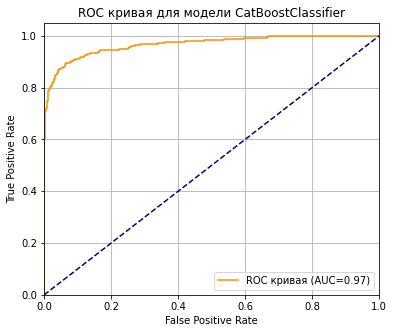

In [82]:
#comment
base64_data = 'iVBORw0KGgoAAAANSUhEUgAAAYoAAAFNCAYAAAAekygcAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAABEOklEQVR4nO3dd3gU5fbA8e8BAoQWukoHBUSQjoo1NBFpIkUQUIpgufZyrz8LomJFvRb0AnotCFIEKSKKUgKIFymKVEFEShCRDgkt5fz+mElYQsqSZDOb3fN5nn2ys9POvNmdM+/7ThFVxRhjjMlIAa8DMMYYE9wsURhjjMmUJQpjjDGZskRhjDEmU5YojDHGZMoShTHGmExZojDG5Asisk1E2gZo2deIyCaf4boi8rOIHBWR+0VktIg8HYh15weWKHLA/eIeF5E4EflLRD4WkRJpprlSRBa4X7jDIvKliFySZppSIvKmiOxwl7XFHS6ft1tk8gMRaS8ii93v1F4RWSQiXfyc94ydrYjUEBF1v3dxIrJHRN4TkYjAbQG467wozWee/Q5UdYmq1vX56J9AjKqWVNW3VfUuVX0+0HEEK0sUOddZVUsAjYEmwP+ljBCRlsC3wEygElAT+AVYKiK13GkKA/OB+sANQCngSmA/cFmebYXJF0SkB/A5MA6oApwHDAM653DRpd3v8aVAS+AfOVzeOQnC30F1YH1OFyIihXIhFu+pqr2y+QK2AW19hl8FvvIZXgK8l858XwPj3Pd3AHuAEuewXgUuct93AXYCtdzhj4HRwHfAUWARUD2DeasBx4Hx7nANd3yc+1oHRPvM+5a7riPAKuAan3HFgCnAAXfeU8DHmWzDRWnWlQTckc52xrvjE4AR7ucFgPeAve64EzhHf+mtJ9pdzls+n13ifjbe57MuODuGQ0AMUC/Ncsa72xTnllmsz7giwGvADvd/ORqI9BmftlxTtxUYniaO93z/R2liEHcdj2VSrhcCC3B2sPuACThJAOBTINmNPw7nqDkltkJpvsdjfYbruWVyyC2jLj7jonCS1l5gO/AUUMDnf7wIOOzGMtn9fHGa/+0t+PE7wOf3hpM8/ufGtBsYBRT2Kad/A3+7614DNHDH3QhswPlt7AIe9fmexLrvF7j/oxNufHVwflcjfGLpBKx21/8D0DBNnP9y13vSt2zz68tqFLlERKoAHYAt7nAxnCOiz9OZfArQzn3fFvhGVeOysc7rcHZKN6rqVp9RfYHngfI4X+YJGSzieZwdSlqlgZJunK/5fL4Cp+ZUFvgM+FxEirrjbgPqAjXVOTJ9NYvwCwCoagl3+iVpti3lu9nQHe+7DdcD3XzG3ZvFuvYCHUSkiDt8B7DRZ111gInAg0AFYA7wpXuUmzoZ8IK7vg5plv8Kzs6kMc7OsTLOUf4Z2wpEpbetPnHUTmfZvuoCVYGpmUwjwEs4Ndh67vTDAVS1P06i6eyW+1n/IxGpBLQHlrnDEcCXODXjisB9wAQRSWmmeQcnWdQCrsP5Hgx0xz3vzlcGp/bzjhvHte74Rm4ckzn330ES8BDOd7wl0Aa4xx13PXAtzv+kNE4iSvme/xe4U1VLAg1wksIZVLU1zv/oXje+zWnKqCnwIXAnUA4YA8zy+X4B9AE64iTpRD+3KWhZosi5GSJyFOdI+2/gGffzsjjluzudeXbjfMHB+aKlN01WmgCzgL6qujbNuK9UdbGqngSeBFqKSFXfCUSkIc4P7JMMli9AQXwSiaqOV9X9qpqoqq/jHEnX9Zk+ZR5/FMU5Qs9Iyk46vWnOdV2ncHb+N7s7/w7ADJ/xt+CU2XeqmoCTHCNxEn2KyPRiEREBhgAPqeoBVT0KvAj0TrMtyaqalEWcL+HsXDNSzv2b4fdFVbe423FSVfcCb+DswLOyT0QO4Rxlx3M6GV0BlABeVtVTqroAmA30EZGCOGX3f6p6VFW3Aa8D/d15E3CacCqp6glV/T6LbfP7d6Cqq1R1mftd3Iazs07ZzgScA52LAVHVjaq622fcJSJSSlUPqupP/q7TxxBgjKr+qKpJqvoJTs3hCp9p3lbVnap6PBvLDzqWKHLuJvfoJBrni5mSAA7iVPMvSGeeC3Cq4uDsiNObJisfAL9xumbia2fKG/cI7QDOEaavV4CncX44ae3DqXI/6E4HgIg8IiIb3U75QzhHkinb+wlOjWOviBwGHs0i/vNxjvQzUtb9ezCdcXNxmlF+E5EjwNtZrAuc8hoM3AR8w5k7/Uo4zSYAqGoyThlW9iPeCjjNbqtE5JBbLt+4n/tuS3rbkUpELsf5/mSUuOF00s7w+yIiFUVkkojscstmPKf/R5kpr6qlcbZlKc42gFM2O90ySbEdp2zK4yTB7emMA6dpS4DlIrJeRAZlsW1+/w5EpI6IzHZPIjmCk5zLA7jJbBTwLrBHRMaKSCl31u44zU/b3ZMAWvq7Th/VgUdS/t/u/7wqZ/7GdqY7Zz5liSKXqOoinHbM19zheJw21J7pTN4Lp+MOYB7QXkSKn+MqH8RpJx3sVoV9pdYe3LOwygJ/+oxvjfOjmpLBssurajGgKzBNRCJF5BqcdtdeQBl3p3IYZ0eAqh7DOdJch3N0+Fp6C/bRBKdjPyN1gN3pNUW4O63JODvuqsD9WawLVV2HsxN8Cidp+PoT58cPpNYSquIcXac0vzTIIN59OG3+9VW1tPtKaWLy3ZbN6czr61Xg8SxqHZtwdkDdM5nmJZz2/4aqWgroh/s/cmV6u2j3CPhjnFpoeZyyqerTFAhO39YunG1PqTWkHYeq/qWqQ1S1Ek4zzXtpz3Tyca6/g/8AvwK13e18Ap/tVOdMpWY4neN1gMfcz1eoalecZrQZZPwbyMxOnGbI0j6vYqo60WeakLottyWK3PUm0E5EGrvDjwO3u+dhlxSRMiIyAqfJ51l3mk9xvnjTRORiESkgIuVE5AkRuTGTdS1R1b9wjtw/SnM6440icrXbzPI88KOq+h7hDMfpEM3qy5yEU2sojFOVT8TZORcSkWE4Z6YAICJROEf2Q7Jqk3WP7gbg9AukN748TtnNyGB8IZyd/UOqejiLbfD1IjBPVdOezTIF6CgibdxyfASnKeEHd/xA4C9gZdoFuknrfeDfIlLRja+yiLR331cFHshoW1ytnUXp7MyCd/9fDwNPi8hA93TSAu7/eqw7WUmc2uAhEamMu4P0sQenPyFdbjt7f3d79wM/4jRF/VNEIkQkGucMq0luUpsCvOB+v6u78Y13l9XT7bsDp0alON+p9OI4199BSZyTKuJE5GLgbp9taCEil7v/y3icTukkESksIn1FJMptYjziE8+5eB+4y12HiEhxEekoIiWzsax8wRJFLnLbhMfhNOngtsm2B27GaX/djnMkfbWq/uZOcxKnI+9XnDOVjgDLcY74f/RjnSk/sCd8Pv4Mp6/kANAMp3Pb18+qGpPJYg+JSJy7LXe6O+O5OGdrbXa34wRnVq9HAl+o6vKsYsbZ4V4MjBH3/H3gGmCUiFQDJuHsSB7PYP5/AttVdZof60qlqrNV9eF0Pt+Ec+T9Ds5RcmecDt9TItIXp/27JnDUjfVroJKIjHYX8S+ckxiWuc0g8zjddzMX54yhf2cS2gXuNvmzDVNx+gUG4Rzt7wFG4JyCDc4BSFOc2t5XwBdpFvES8JTbZOLbPJjyP9+DcyDTRR2ncM4I6+CWzXvAbar6qzvffTg7463A9zjfvQ/dcS2AH93lzgIeUNU/3HHDgU/cOHpl43fwKHArztlL7+PUMFOUcj87iPNd3c/pGm5/YJv7f7oL5/9+TlR1JU4/xSh3HVtwDnxClmR9UGnyExH5GOc0v6e8jiUjIrJNVWuk8/kHOKcgbsvzoDIgIgOAGqo6PM3nVXBiHeBBWMbkKatRGC9kdHbLAZzmrWASj3N0m1YiTrzGhDyrUYSY/FCjMMbkL5YojDHGZMqanowxxmTKEoUxxphM5bs7G5YuXVovuiija3bCS3x8PMWLn+t1eqHJyuI0K4vTrCxOW7Vq1T5VrZD1lGfLd4nivPPOY+XKs657CksxMTFER0d7HUZQsLI4zcriNCuL00Rke9ZTpc+anowxxmTKEoUxxphMWaIwxhiTKUsUxhhjMmWJwhhjTKYsURhjjMmUJQpjjDGZCliiEJEPReRvEVmXwXgRkbdFZIuIrEnnKW3GGGOCQCBrFB8DN2QyvgNQ230NxXm0oTHGmCATsEShqovJ/H79XYFx7lO0lgGlRcTvh6sbY4zJG17ewqMyZz5KM9b9LKOH2hhjvLRmLGz8zOsozknjQ4dgT2mvw/DUsZMFGLf4/Bwtw8tEIel8lu7DMURkKE7zFBUqVCAmJiaAYeUfcXFxVhYuK4vTAlEWF+z9kro73gDgUIlGubrsQEpKSuLQoUNeh+Gp28dcxperK+VoGQF9cJGI1ABmq2qDdMaNAWJUdaI7vAmIVtVMaxR169bVTZs2BSLcfMdueHaalQWpR/yHDh2idOnSubvs2EXO33ZjoOHQ3F12AIXz90JVERHWrNnDrl1HuPHGOqtUtXl2luVljWIWcK+ITAIuBw5nlSSMCSm53ZSTsjMPxBF/leug3q35KkmEq8TEZJ5+egH79x9n7NjONGx4Hg0bnpejZQYsUYjIRCAaKC8iscAzQASAqo4G5gA3AluAY8DAQMViTK4I1I69ynW5szx3Z776QJ2wPYoOd3v2xNGnzzQWLtzG0KFNSUpKpmDBnJ+zFLBEoap9shivwD8CtX5jgNzduQdox57rR+nWVxOWli7dQc+en3Pw4Ak++qgrAwY0zrVl57sHF5kQl80de4Znt+Tmzt2aX0yQios7RZcukyhTpihff92XRo1ydpZTWpYoTN7LLBnkl6N2Y4LAsWMJREYWokSJwsyc2ZsGDSpSunTRXF+PJQrjv9xqxsksGWRzx746jM9uMeFpw4a93HzzZO699zLuvfcyrr66WsDWZYnCpC+9pJBbR/t2lG9MjkycuJYhQ76kePHC1K9fIeDrs0RhHGkTQ3pJwXbwxnjq1KkkHn30W955ZzlXXVWVKVN6UqlSyYCv1xJFuEtJEGkTgyUFY4LOjz/GMmrUch566ApeeaUtEREF82S9lijC2Zqx8N2dzntLDMYErdjYI1SpUoprrqnOunX3cMklgW9u8mWJIlT50/GcT2/LYEy4SE5WXn75e4YPj2H+/Nu45prqeZ4kwBJFcDnHs4oyvTOmPx3PVoswJmgdPHic226bwezZm+nTpwFNmnj3FAZLFMEibTNQTlkSMCbf+vnn3XTvPoXY2CO8804H/vGPFoikd8PtvGGJIhj4JolzaAayaweMCU3z5m3l1KkkFi0aQMuWVb0OxxJFnsiqScn6CowJe8ePJ/Drr/to0uQCHn30Su64oyllykR6HRZgiSJwfJNDVv0F1kxkTFjbuvUgPXpMYfv2w/zxxwOUKlUkaJIEWKLIfeldl2CJwBiTgdmzN9O//3RE4NNPu1GqVBGvQzqLJYrcZNclGGP8lJysDBu2kBdeWELTphcwdWpPatYs43VY6bJEkRMZ3fbC+hqMMVkQgT/+OMSQIU15++0OFC0avLvj4I0sP9j4GexdDRUaO8NWizDGZOF//9tJmTKRXHxxeT755CYKFcr5E+gCzRKFv9I7cyklSdwS40FAxpj8RFV5553lPPLIt3TocBGzZvXJF0kCLFFkLaOb5oGTJOrd6klYxpj8Iy7uFHfcMYvJk9fTpUtdPvnkJq9DOieWKDKSXoKwZiVjzDnaufMw7duPZ9Om/bz8chsee+wqChTw7irr7LBEkR47e8kYk0sqVChOzZplGDXqRlq3rul1ONliiQLs7CVjTK46dSqJV175nvvuu5zSpYvy1Vf5u4naEkV6N+OzWoQxJpt27TpCr15T+eGHnVStGsWAAY29DinHLFGk1CSs9mCMyaEFC/6gd++pHDuWwOTJPejVq77XIeWK/HFuVqBVuc6ShDEmRz77bC3t2n1K+fLFWLFiSMgkCQjnRLFmLEyOdq6FMMaYHIqOrsGddzZj+fIh1KuX90+hC6TwSxQpCeK7O51Oa7sWwhiTTatX/8XQoV+SlJRMpUolee+9jpQoUdjrsHJd+PRR2HURxphc9PHHq7n77q8oWzaSnTuPUKNGaa9DCpjwSBR2XYQxJpecOJHI/fd/zfvv/0Tr1jWZOLE7FSsW9zqsgAqPRGFnNhljcknv3lOZOXMTTzxxNc8914qCBUO/BT88EgXYmU3GmBxRVUSExx+/msGDm9C5c12vQ8ozoZ8o1ox1+iUyegypMcZkIikpmeHDYzhxIpGRI6/niiuqeB1Sngv9OlNKs5Od2WSMOUd798Zzww0TGDFiCQcOHCc5Wb0OyROhW6NIOctp72prdjLGnLNly2Lp2fNz9u6N54MPOjN4cFOvQ/JM6CYK36fPWW3CGHMODh06Qfv24ylXLpIffhhM06YXeB2Sp0I3UYA9fc4Yc05OnUqicOGClC5dlKlTe9K8eSXKlIn0OizPhX4fhTHG+GHTpn00bTqGceN+AaBduwstSbhCM1GknOlkjDF+mDp1A82bv8+ePfFUqlTS63CCTmgmCjvTyRjjh4SEJB55ZC49e35OgwYV+emnobRtW8vrsIJOaCYKsDOdjDFZWrhwG2+8sYz77ruMRYsGULVqlNchBaXQ68y2C+yMMVn4++94KlYszvXXX8iqVUPD/qymrIRWjcL35n/W7GSMSUNVGTlyKTVrvsWqVX8CWJLwQ2jVKOzmf8aYDBw+fIIBA2YyY8av9Ox5CXXqlPM6pHwjoDUKEblBRDaJyBYReTyd8VEi8qWI/CIi60VkYI5Xan0Txpg01qzZQ/Pm7zN79mb+/e/2TJ7cg5Ili3gdVr4RsBqFiBQE3gXaAbHAChGZpaobfCb7B7BBVTuLSAVgk4hMUNVT57xC65swxmRg2rQNxMefYuHC27n66mpeh5PvBLJGcRmwRVW3ujv+SUDXNNMoUFJEBCgBHAASz3lN1jdhjEnj5MlEtm+PB2DYsOv45Ze7LElkUyATRWVgp89wrPuZr1FAPeBPYC3wgKomn/OarG/CGONj+/ZDXH31RzzyyBri409RsGABKlQI7afQBVIgO7Mlnc/S3qO3PbAaaA1cCHwnIktU9cgZCxIZCgwFqFChAjExManjLtj7JXVjF3GoRCNWH6gDPuNCXVxc3BllEc6sLE4L97JYvvwAL7ywkaQk5cEHa7BixQ9eh5TvBTJRxAJVfYar4NQcfA0EXlZVBbaIyB/AxcBy34lUdSwwFqBu3boaHR19euTk4QCUbnkP0Q2jCScxMTGcURZhzMritHAti+Rk5fnnF/Hss2u59NLzmDatF7Gxa8KyLHJbIJueVgC1RaSmiBQGegOz0kyzA2gDICLnAXWBrX6vwbcD25qcjAl7q1bt5rbbGvG//w3moovKeh1OyAhYjUJVE0XkXmAuUBD4UFXXi8hd7vjRwPPAxyKyFqep6l+qus/vldg9nYwJe8uX7+K884pTvXppPv+8J4ULF8Q5P8bkloBecKeqc4A5aT4b7fP+T+D6HK3EahPGhCVVZfTolTzwwDd06VKXqVN7UaRIaF1DHCysVI0x+U58/Cnuuusrxo9fQ4cOFzF2bGevQwppliiMMfnKjh2H6djxM9av/5vnnovmySevpUABa2oKJEsUxph8pWzZSMqWjeSbb/px/fUXeh1OWAitu8caY0JSYmIyr732A/HxpyhRojAxMbdbkshDVqMwxgS13buP0rv3NBYv3s555xWnf/9GdlZTHrNEYYwJWosXb+eWW6Zy+PAJPv20G/36NfQ6pLBkTU/GmKA0YcIaWrf+hJIlC/Pjj3dYkvBQ/k0UKVdlG2NCUsuWVenfvxErVw7l0kvP8zqcsJZ/E4VdlW1MyFm37m8eeWQuqkqtWmX46KOulCplDxjyWv5NFGBXZRsTQiZMWMPll3/AZ5+tY+fOI1nPYPJM/k4Uxph87+TJRO655yv69ZtOs2YX8NNPQ6lWLcrrsIwPO+vJGOOpHj0+Z/bszTz6aEtefLENEREFvQ7JpGGJwhjjqYceuoKBAxtz8831vA7FZMAShTEmTyUnKyNGLKZAAeGpp66ldeuaXodkspA/+yjs1Fhj8qX9+4/RqdNnPPNMDL/9dgDn4ZYm2OXPGoWdGmtMvrNy5Z/06DGF3bvjeO+9G7nrruZ2K458In8mCrBTY43JR/bvP0arVp9QtmwkS5YM5LLLKnsdkjkH+S5RRCQehtjNTqIwxgS1xMRkChUqQLlyxRg/vhtXXVWN8uWLeR2WOUf5ro8iItG9EMeanYwJalu2HKB587FMn74RgK5dL7YkkU/lu0QBWLOTMUFu5sxfadZsLDt3HqFYsQivwzE5lD8ThTEmKCUmJvP44/O46abJ1K5dllWrhtK+/UVeh2VyyBKFMSbXzJnzG6+8spQ772zG998PokaN0l6HZHKB353ZIlJcVeMDGYwxJn86dOgEpUsXpUuXuixZMpCrr67mdUgmF2VZoxCRK0VkA7DRHW4kIu8FPDJjTNBTVd58cxk1arzJ+vV/A1iSCEH+ND39G2gP7AdQ1V+AawMZlDEm+B09epJbbpnKQw/NpVWrmlSpUsrrkEyA+NX0pKo701xBmRSYcIwx+cGGDXu5+ebJ/PbbAV59tS2PPnqlXWUdwvxJFDtF5EpARaQwcD9uM5QxJjz9978/cejQCebPv43o6Bpeh2MCzJ+mp7uAfwCVgVigMXBPAGMyxgShU6eS2Lr1IAAvvdSWn3++05JEmPCnRlFXVfv6fiAiVwFLAxOSMSbYxMYeoWfPz/nrrzg2bLiHyMgILrigpNdhmTziT43iHT8/M8aEoPnzt9KkyRjWr/+bkSPbERlpV1qHmwxrFCLSErgSqCAiD/uMKgXYswqNCXHJycpLLy1h2LAYLrmkAtOm9aJOnXJeh2U8kFnTU2GghDuNbx3zCNAjkEEZY7yXnKzMn/8Hffo0YMyYThQvXtjrkIxHMkwUqroIWCQiH6vq9jyMyRjjoZ9+2k2lSiU5//wSzJ59K5GRhezU1zDnTx/FMREZKSJzRGRByivgkRlj8twHH/zElVf+l0ce+RaAYsUiLEkYvxLFBOBXoCbwLLANWBHAmIwxeez48QQGDZrJkCFfcu211XnrrRu8DskEEX8SRTlV/S+QoKqLVHUQcEWA4zLG5JEdOw5z5ZUf8tFHqxk27Fq+/rqvPWDInMGf6ygS3L+7RaQj8CdQJXAhGWPyUokShSlQQPjqq1u58cbaXodjgpA/iWKEiEQBj+BcP1EKeDCQQRljAisxMZkxY1YyZEgzypaNZOXKIdYXYTKUZaJQ1dnu28NAK0i9MtsYkw/9/Xc8ffpMY8GCPyhXrhi9ezewJGEyldkFdwWBXjj3ePpGVdeJSCfgCSASaJI3IRpjcssPP+ykZ8/POXDgOB991JXevRt4HZLJBzKrUfwXqAosB94Wke1AS+BxVZ2RB7EZY3LR+PFrGDhwJtWrR/G//w2mcePzvQ7J5BOZJYrmQENVTRaRosA+4CJV/StvQjPG5KYmTc6nR49L+M9/OlK6dFGvwzH5SGanx55S1WQAVT0BbLYkYUz+snHjXoYPj0FVqV+/IhMndrckYc5ZZoniYhFZ477W+gyvFZE1/ixcRG4QkU0iskVEHs9gmmgRWS0i60VkUXY2whhztsmT19Gixfu8994Kdu+O8zock49l1vRULycLdjvD3wXa4TzwaIWIzFLVDT7TlAbeA25Q1R0iUjEn6zTGQEJCMg888DVvv72cK6+sypQpPahUyZ4dYbIvs5sC5vRGgJcBW1R1K4CITAK6Aht8prkV+EJVd7jr/DurhRZMPp7DsIwJbU8/vZ4ffzzAgw9ezquvtiMiwp4KYHLGnwvusqsysNNnOBa4PM00dYAIEYnBuZX5W6o6Lu2CRGQoMBSgWRXYVKAZu2NiAhFzvhIXF0eMlQNgZeGrXbsytG9/Hq1aFWXp0iVeh+Mp+17kjkAmivSu4NF01t8MaINzbcb/RGSZqm4+YybVscBYgCbVi2ndnq9TNwAB5zcxMTFER0d7HUZQCOeySE5WXnnle4oXL8z9918OhG9ZpBXO34vc5M9NARGRSBE5131zLM51GCmq4NwnKu0036hqvKruAxYDjc5xPcaErYMHj3PTTZN44okFrFz5J6ppj8WMybksE4WIdAZWA9+4w41FZJYfy14B1BaRmiJSGOgNpJ1vJnCNiBQSkWI4TVMbzyF+Y8LW6tV/0bz5+3z99RbefvsGPvnkJrsVhwkIf5qehuN0TMcAqOpqEamR1Uyqmigi9wJzcZ6x/aGqrheRu9zxo1V1o4h8A6wBkoEPVHVddjbEmHCyZ08cV131IWXKFGXx4gG0bFk165mMySZ/EkWiqh7OzpGKqs4B5qT5bHSa4ZHAyHNeuDFhKDlZKVBAOO+8Erz/fmfatq1FxYrFvQ7LhDh/+ijWicitQEERqS0i7wA/BDguY0waf/xxkCuu+IB587YCcOutl1qSMHnCn0RxH1AfOAl8hnO78QcDGJMxJo2vvtpM06Zj2bx5P6dOJXkdjgkz/jQ91VXVJ4EnAx2MMeZMSUnJDB8ew4gRS2jc+HymTetFrVplvA7LhBl/ahRviMivIvK8iNQPeETGmFTTpm1kxIglDBrUmB9+GGRJwnjCnyfctRKR83EeYjRWREoBk1V1RMCjMyZMxcWdokSJwvTseQllyvSjXbsLvQ7JhDG/LrhT1b9U9W3gLpxrKoYFMihjwpWq8u67y7nwwrf5/fcDiIglCeM5fy64qyciw0VkHTAK54ynKgGPzJgwEx9/in79pnPvvV/TokUlypaN9DokYwD/OrM/AiYC16tq2ltwGGNywaZN++jefQobN+7jhRda8/jjV1OggF1lbYKDP30UV+RFIMaEs3//exl79sQzd24/2rat5XU4xpwhw0QhIlNUtZf7dDvfO40JoKraMODRGRPCEhKS+PvveCpXLsUbb7TnqaeupUqVUl6HZcxZMqtRPOD+7ZQXgRgTTv788yi33DKVffuOsXr1nRQrFkGxYhFeh2VMujLszFbV3e7be1R1u+8LuCdvwjMm9MTEbKNp0zH89NNuhg27liJFAvlYGGNyzp/TY9ul81mH3A7EmFCnqrz66lLatBlH6dJFWb78Dvr0udTrsIzJUmZ9FHfj1Bxqicgan1ElgaWBDsyYUJOQkMy0aRvp3r0e//1vF0qWLOJ1SMb4JbM672fA18BLwOM+nx9V1QMBjcqYELJ27R6qVClFmTKRfPttP0qVKmIPGDL5SmZNT6qq24B/AEd9XohI2cCHZkz+N27cL1x++Qc88si3AERFFbUkYfKdrGoUnYBVOKfH+n67FbCTvY3JwIkTiTz44DeMGbOKVq1q8NJLbbwOyZhsyzBRqGon92/NvAvHmPxv587D3HzzFFau/JPHH7+K559vTaFCft1WzZiglOV5eSJyFbBaVeNFpB/QFHhTVXcEPDpj8qGIiILExZ1ixoxb6Nr1Yq/DMSbH/DnM+Q9wTEQaAf8EtgOfBjQqY/KZpKRkPvzwZ5KSkjn//BKsW3e3JQkTMvxJFImqqkBX4C1VfQvnFFljDLBv3zFuvPEzBg+exfTpvwJQsKA1NZnQ4c8loUdF5P+A/sA1IlIQsHsNGAMsX76LHj2msGdPPGPHdqJ793peh2RMrvPnsOcW4CQwSFX/AioDIwMalTH5wPjxa7j66g8pUEBYunQQQ4Y0s1NfTUjKMlG4yWECECUinYATqjou4JEZE+Tq1i1Hx451+OmnO2nevJLX4RgTMP484a4XsBzoifPc7B9FpEegAzMmGG3evJ/XX/8BgBYtKjN9+i32JDoT8vzpo3gSaKGqfwOISAVgHjA1kIEZE2y++GIjAwbMoHDhgvTv34iKFYt7HZIxecKfPooCKUnCtd/P+YwJCQkJSTz66Ld07z6FevUq8NNPd1qSMGHFnxrFNyIyF+e52eB0bs8JXEjGBA9VpUuXSXzzzRbuuac5b7zR3p4fYcKOP8/MfkxEbgauxrnf01hVnR7wyIwJAiLCbbc1pF+/S+nb157+a8JTZs+jqA28BlwIrAUeVdVdeRWYMV5RVV5//X+UKxfJwIFN7OFCJuxl1tfwITAb6I5zB9l38iQiYzx0+PAJevT4nMce+4758//wOhxjgkJmTU8lVfV99/0mEfkpLwIyxitr1+6he/cpbN16kNdfv56HHrrC65CMCQqZJYqiItKE08+hiPQdVlVLHCZk7Np1hCuu+C+lShVh4cLbueaa6l6HZEzQyCxR7Abe8Bn+y2dYgdaBCsqYvKKqiAiVK5fizTfb07lzXc4/v4TXYRkTVDJ7cFGrvAzEmLy2Y8dhbr11GiNHtqNly6oMGdLM65CMCUp2QrgJS3PnbqFv3y9ISEjmwIHjXodjTFCzK6xNWElOVp57bhEdOkygUqWSrFw5hI4d63gdljFBzRKFCSsTJqzhmWdi6NevIcuW3UHt2uW8DsmYoOfPM7MF6AvUUtXnRKQacL6qLg94dMbkkhMnEilatBC33nopUVFF6dy5jj07whg/+VOjeA9oCfRxh48C7wYsImNykaoyZsxK6tR5h127jlCwYAG6dKlrScKYc+BPorhcVf8BnABQ1YNA4YBGZUwuOHYsgQEDZnLXXV9xySUVKFrUzt0wJjv8+eUkuM/JVkh9HkVyQKMyJod++20/PXp8ztq1exg+/DqeeupaCha0LjljssOfX87bwHSgooi8AHwPvOjPwkXkBhHZJCJbROTxTKZrISJJ9uQ8k1uef34xsbFHmDOnL888E21Jwpgc8Oc24xNEZBXQBuf2HTep6sas5nNrIe8C7YBYYIWIzFLVDelM9wowNxvxG5MqMdG5JqJixeK8804Hnn++FdWrl/Y6LGPyPX/OeqoGHAO+9P1MVXdkMetlwBZV3erOMwnoCmxIM919wDSgxTnEbcwZDhw4Rbt2n3LkyEmWLRtMVFRRoqKKeh2WMSHBnz6Kr3D6JwQoCtQENgH1s5ivMrDTZzgWuNx3AhGpDHTDuW+UJQqTLd9/v4OhQ1dx7Fgyo0d3IiKioNchGRNS/Gl6OuOpLSLSFLjTj2Wnd/6hphl+E/iXqiZldrqiiAwFhgI0qBRBTEyMH6sPfXFxcWFdFqrK1Km7GD36d847rwivvNKIatUOhnWZgH0vfFlZ5A5RTbvv9mMmkZ9UtWkW07QEhqtqe3f4/wBU9SWfaf7gdEIpj9PENVRVZ2S03CbVi+nP24+dc8yhKCYmhujoaK/D8Mzx4wm0aPE+deqUY9CgcnTq1NbrkIJCuH8vfFlZnCYiq1S1eXbm9aeP4mGfwQJAU2CvH8teAdQWkZrALqA3cKvvBKpa02c9HwOzM0sSxgBs3LiXqlWjKFGiMDExAyhXLpJFixZ5HZYxIcufcwZL+ryK4PRZdM1qJlVNBO7FOZtpIzBFVdeLyF0iclf2Qzbh7LPP1tK8+fs8/vg8AMqXL2ZXWRsTYJnWKNxTV0uo6mPZWbiqzgHmpPlsdAbTDsjOOkx4OHUqiUcemcuoUSu45ppqPPnkNV6HZEzYyDBRiEghVU10O6+N8Uxs7BF69JjCjz/u4tFHW/Lii23szCZj8lBmNYrlOP0Rq0VkFvA5EJ8yUlW/CHBsxgDOhXR79sQzdWpPune/xOtwjAk7/lxHURbYj3OtQ8r1FApYojABk5ysTJmynl696lOjRmk2b77XahHGeCSzRFHRPeNpHacTRIpzP6fWGD8dOHCc/v2nM2fObxQrFkGXLnUtSRjjocwSRUGgBP5dOGdMrli16k969PicXbuO8N57N9K5sz2m1BivZZYodqvqc3kWiQl7EyasYfDgWVSsWJwlSwZy+eVVvA7JGEPmicJOTjd5qkqVUrRuXZNx47pRvnwxr8Mxxrgyu+CuTZ5FYcLW778fYMyYlQBcd10N5szpa0nCmCCTYY1CVQ/kZSAm/Myc+Su33z6DQoUK0LNnfcqWjfQ6JGNMOuyxXybPJSYm83//N4+bbprMRReVZeXKoZYkjAli9rR5k6dUlc6dJ/LNN1sYOrQpb73VgaJF7WtoTDCzX6jJUyJCt24Xc8st9RkwoLHX4Rhj/GCJwgScqvL22z9SuXIpevS4hKFDm3kdkjHmHFgfhQmoo0dP0rv3NB58cC4zZ27yOhxjTDZYjcIEzIYNe+nefQqbN+/n5Zfb8NhjV3kdkjEmGyxRmIDYvv0Ql132PsWLF2bevP60alUz65mMMUHJEoUJiOrVS/Pcc6245Zb6VK5cyutwjDE5YH0UJtfExh6hbdtx/PLLXwA8/HBLSxLGhABLFCZXzJ+/laZNx/Djj7vYufOI1+EYY3KRJQqTI8nJyksvLeH668dTvnwxli+/g06d7NbgxoQSSxQmRz766GeeeGIBvXrVZ/nyIdSrV8HrkIwxucw6s022JCQkERFRkNtua0Tx4oW55Zb6iNid6Y0JRVajMOfso49+pkGD/7Bv3zEiIgrSu3cDSxLGhDBLFMZvJ04kMmTILAYNmkWVKqVQtSfiGhMOrOnJ+GXr1oP06DGFn3/+iyeeuJrnnmtFwYJ2nGFMOLBEYfzyr3/NY+vWg8ya1ZvOnet6HY4xJg9ZojAZSkpK5siRk5QpE8l7793I0aOnqFWrjNdhGWPymCUKk669e+O59dYvOHEikZiY26lQoTgVKhT3OixjjAeskdmcZdmyWJo2HcuSJdsZMKCR9UUYE+ZsD2BSqSqjRi3n2ms/IiKiAD/8MJjBg5t6HZYxxmPW9GRSxccn8Oaby2jf/iLGjbuJMmUivQ7JGBMELFEYtmw5QNWqpShRojBLlgzkvPNKUKCAXUBnjHFY01OY+/zz9TRpMoYnn1wAwAUXlLQkYYw5gyWKMJWQkMTDD8+lV6+pXHppRR588AqvQzLGBClregpDf/55lF69Pmfp0p3cf/9ljBx5PYULF/Q6LGNMkLJEEYaOHDnJ778fZOLE7vTu3cDrcIwxQc4SRZhQVb78cjOdO9fh4ovLs3Xr/URGRngdljEmH7A+ijBw6NAJunWbTNeuk5g793cASxLGGL9ZjSLE/fLLX3TvPoXt2w/z5pvtad/+Qq9DMsbkM5YoQtjEiWsZNGgWZctGEhNzO1ddVc3rkIwx+ZAlihBWsmQRrrqqKhMm3Mx555XwOhxjTD5lfRQhZtu2Q0yYsAaATp3q8N13/S1JGGNyxGoUIWTOnN/o1+8LChQQOnWqQ1RUUXuWtTEmxwJaoxCRG0Rkk4hsEZHH0xnfV0TWuK8fRKRRIOMJVUlJyQwbtpCOHT+jWrUofvzxDqKiinodljEmRASsRiEiBYF3gXZALLBCRGap6gafyf4ArlPVgyLSARgLXB6omEJRcrLSufNEvv56CwMGNOa99260U1+NMbkqkE1PlwFbVHUrgIhMAroCqYlCVX/wmX4ZUCWA8YSkAgWENm1qcvPN9Rg8uIk1NRljcl0gE0VlYKfPcCyZ1xYGA18HMJ6Qoar85z8riYs7QHQ0PPLIlV6HZIwJYYFMFOkd2mq6E4q0wkkUV2cwfigwFKBBpQhiYmJyKcT85/jxJN54YzPz5v1Nq1ZlueyyGK9DCgpxcXFh/b3wZWVxmpVF7ghkoogFqvoMVwH+TDuRiDQEPgA6qOr+9BakqmNx+i9oUr2YRkdH53qw+cHmzfu5+ebJbNiwlxEjWtGyZRLhWhZpxcTEWFm4rCxOs7LIHYE862kFUFtEaopIYaA3MMt3AhGpBnwB9FfVzQGMJd/7/fcDNG8+lj174pk7tx9PPnmtPWDIGJMnAlajUNVEEbkXmAsUBD5U1fUicpc7fjQwDCgHvOd2wiaqavNAxZSf1apVhkcfvZKBAxtTtWqU1+EYY8JIQC+4U9U5wJw0n432eX8HcEcgY8jPdu8+ypAhX/Lvf7endu1yDBt2ndchGWPCkN3CI0gtWrSNJk3GsHDhNjZtSrfrxhhj8oQliiCjqowcuZQ2bcYRFVWU5cvvoFOnOl6HZYwJY5Yogsx//rOSf/5zHt261WPFiiHUr1/R65CMMWHObgoYJJKSkilYsAADBzamWLEIbr+9kV1lbYwJClajCAKffvoLzZu/z5EjJ4mMjGDAgMaWJIwxQcMShYdOnkzk7rtnc9ttM4iKKsKJE4leh2SMMWexpiePbN9+iJ49P2fFij/55z+v5IUX2lCokOVtY0zwsUThkX/8Yw6bNu3niy960a1bPa/DMcaYDFmiyEPJycqxYwmUKFGY0aM7cfx4ArVrl/M6LGOMyZQlijyyf/8x+vWbjgjMnn0rVaqU8jokY4zxizWK54EVK3bRtOlYFiz4g65d62InNBlj8hNLFAGkqowZs5Krr/4IEVi6dBB33tncTn01xuQr1vQUQEeOnOS55xbTunVNxo/vRrlyxbwOyRhjzpkligDYtu0QVaqUIiqqKEuXDqJatSh7doQxJt+ypqdcNmPGrzRqNJrnn18EQI0apS1JGGPyNUsUuSQxMZl//es7unWbTN265Rg0qInXIRljTK6wpqdc8NdfcfTuPZVFi7Zz993N+fe/21OkiBWtMSY02N4sF/z551HWrNnDuHE30b9/I6/DMcaYXGWJIptUlYULt9G6dU2aNr2A7dsfpGTJIl6HZYwxuc76KLLhyJGT9Oo1lTZtxrFw4R8AliSMMSHLahTnaP36v+nefQpbthxg5Mh2REfX8DokY4wJKEsU52Dy5HUMGjSLUqWKsGDB7Vx7bXWvQzLGmICzRHEOkpOV5s0rMWlSdy64oKTX4RhjTJ6wPoos7NhxmBkzfgWgT59LWbjwdksSxpiwYjWKTHz77e/ceus0ChQQ2ratRYkShe0qa+OXhIQEYmNjOXHiRJ6vOyoqio0bN+b5eoNROJZF0aJFqVKlChEREbm2TEsU6UhOVl54YTHPPBND/foVmTatFyVKFPY6LJOPxMbGUrJkSWrUqJHndws+evQoJUtarRfCryxUlf379xMbG0vNmjVzbbmWKNJISkqma9dJfPXVb/Tr15DRoztSvLglCXNuTpw44UmSMOFNRChXrhx79+7N1eVaokijYMECNGt2AR071uauu+zZESb77LtjvBCI7511ZuNU195/fxXff78DgGefbcXdd7ewH7rJ1woWLEjjxo1p0KABnTt35tChQ6nj1q9fT+vWralTpw61a9fm+eefR1VTx3/99dc0b96cevXqcfHFF/Poo496sAU59+677zJu3LjU4cTERMqXL8///d//nTFdjRo12LdvX+pwTEwMnTp1Sh3OSXl88skn1K5dm9q1a/PJJ5+kO8327dtp06YNDRs2JDo6mtjYWAAWLlxI48aNU19FixZlxowZAPTu3ZvffvvN7zhyRFXz1atxtUjNTfHxp3TAgBkKw/W226bn6rIDbeHChV6HEDSCrSw2bNjg2bqPHDmiqqrFixdP/ey2227TESNGqKrqsWPHtFatWjp37lxVVY2Pj9cbbrhBR40apaqqa9eu1Vq1aunGjRtVVTUhIUHffffdvNyEXJGQkKD169fXhISE1M+++uorvfLKK7VWrVqanJyc+nn16tV17969qcMLFy7Ujh07qmrOymP//v1as2ZN3b9/vx44cEBr1qypBw4cOGu6Hj166Mcff6yqqvPnz9d+/fqlu6wyZcpofHy8qqrGxMToHXfcke560/v+ASs1m/vdsK5RbNlygCuv/C8ff7yaYcOu5cMPu3gdkjEB0bJlS3bt2gXAZ599xlVXXcX1118PQLFixRg1ahQvv/wyAK+++ipPPvkkF198MQCFChXinnvuOWuZw4cP57XXXgPg5ZdfZuDAgamf9+/fn9atW1O7dm3ef/994Myj9AMHDhAVFZU6f3R0NHXr1uWSSy7hiiuu4M8//wTgueeeo0WLFjRo0IChQ4em1nqWL19Oo0aNaNy4MZUrV2b48OFnxbdgwQIaNWpEoUKnW9gnTpzIAw88QLVq1Vi2bJlfZedveaRn7ty5tGvXjrJly1KmTBnatWvHN998c9Z0GzZsoE2bNgC0atWKmTNnnjXN1KlT6dChA8WKOU/KvOaaa5g3bx6JiYl+xZITYdtH8euv+7jiig8oUED46qtbufHG2l6HZELVwgfh79W5u8yKjaHVm35NmpSUxPz58xk8eDDgNDs1a9bsjGkuvPBC4uLiOHLkCOvWreORRx7xO5Rx48axZMmSM3Zua9asYdmyZcTHx9OkSRM6dux4xjwvvfQS1aufeWeDCRMm0KxZM7p06cLKlSvp0qUL9957L8OGDQOgf//+zJ49m86dO/PKK6/w9NNP06NHD1577TXi4uLOimvp0qU0btw4dfj48ePMnz+fMWPGcOjQISZOnEjLli2z3L7MymPChAmMHDnyrM8vuugipk6dyq5du6hatWrq51WqVElN2L4aNWrEtGnTeOCBB5g+fTpHjx5l//79lCtXLnWaSZMm8fDDD6cOFyhQgIsuuohffvnlrP9nbgvbGkWdOuUYOrQZP/10pyUJE5KOHz9O48aNKVeuHAcOHKBdu3aA09ycUf/bufbLzZs3jzvuuIMRI0acceTetWtXIiMjKV++PK1atWL58uWp43bt2sWyZcvo1q3bGcvq27cvNWvWZPv27bRt2xZw2ugvv/xyLr30UhYsWMD69esBp//l6NGjmca2e/duypcvnzo8e/ZsWrVqRbFixejevTvTp08nKSkpw+32pyz69u3L6tWrz3pNnToV4Ix+n8yW+9prr7Fo0SKaNGnCokWLqFy58hnluXv3btauXUv79u3PmK9ixYqpta9ACqsaxZ49cdx779e88cb1VK0axauvtvM6JBMO/Dzyz22RkZGsXr2aw4cP06lTJ959913uv/9+6tevz+LFi8+YduvWrZQoUYKSJUtSv359Vq1aRaNGWT9bZevWrYwfP56HH36YBQsWpO4E0+4MfYefffZZnn76aX744YczppkwYQLNmzfnqaee4s033+Thhx/mnnvuYeXKlVStWpXhw4enXsA4fPhwevbsyQsvvMDx48cZMmRIutt/8uTJ1OGJEyeydOlSatSoAcD+/ftZuHAhbdu2pVy5chw8eDA1sRw4cCD1fWblkVWNokqVKsTExKR+HhsbS3R09FnTV6pUiS+++AKAuLg4pk2bRlRUVOr4KVOm0K1bt7Muojtx4gSRkZFnLS+3hU2NYunSHTRtOpbZszfzyy97vA7HmDwTFRXF22+/zWuvvUZCQgJ9+/bl+++/Z968eYBT87j//vv55z//CcBjjz3Giy++yObNmwFITk7mjTfeSHfZQ4cOpVevXtSsWTO1LwJg5syZnDhxgv379xMTE0OLFi0A+P3339m2bVtq/0h6SpUqxb59+1KTQvny5YmLi0s9Sgc4//zzKVGiBIsXL+ahhx5Kdzn16tXj999/B+DIkSN8//337Nixg23btrFt2zbeffddJk6cCDh9JJ9++ingNNWNHz+eVq1aZVkeWdUo2rdvz7fffsvBgwc5ePAg33777Vm1AoB9+/aRnJwMOM1ygwYNOmP8xIkT6dOnz1nzbd68mfr162dYlrkl5BOFqvLWW8uIjv6EyMhCLFs2mE6d6ngdljF5qkmTJjRq1IhJkyYRGRnJzJkzGTFiBHXr1uXSSy+lRYsW3HvvvQA0bNiQN998kz59+lCvXj0aNGjA7t27M13+66+/zhtvvJE63WWXXUbHjh254oorePrpp6lUqRIAv/76K88991y6y+jbty+NGzdm+vTp3HfffZQuXZohQ4Zw6aWXctNNN6UmG1VlwIABvPjii6nLTU+HDh1Say1ffPEFrVu3pkiR08+N6dq1K7NmzeLkyZM8/fTTbNmyhUaNGtGkSRMuuugi+vXrl+3ySFG2bFmefvppWrRoQYsWLRg2bBhly5YFYNiwYcyaNQtwOvrr1q1LnTp12LNnD08++WTqMrZt28bOnTu57rrrzlj2nj17iIyM5IILLvArlhzJ7ulSXr3O9fTYt95apjBcu3SZqAcPHj+neYNdsJ0S6qVgK4tgOD3WK88884yOHDnS0xhSdOrUSTdv3ux1GAHxxhtv6AcffJDuuNw+PTZk+yjU7bAbOLAxEREFuPPO5nZDP2PCzLPPPsvu3bupXTv0TlgpXbo0/fv3z5N1hWSimDRpHaNGLee77/pTsmQR7r67hdchGRM20rumwSu1a9cO2ZsCply3khdCqo/i1Kkk7r//a/r0mYYqHD16yuuQjDEm3wuZGkVs7BF69vycZctiefDBy3n11XZERBT0OiwTxlKaP43JS5rOtRs5FTKJYuDAmaxb9zeTJ/egV6/Any5mTGaKFi2aemWtJQuTV1Sd51EULVo0V5ebrxNFcrJy8mQikZERjB7dkYSEZC6+uHzWMxoTYFWqVCE2NjbXnwvgjxMnTuT6jiK/CseySHnCXW4KaKIQkRuAt4CCwAeq+nKa8eKOvxE4BgxQ1Z/8WfbBg8e57bYZREYWYvLkHlx4Ydlcjt6Y7IuIiMjVJ4ydi5iYGJo0aeLJuoONlUXuCFhntogUBN4FOgCXAH1E5JI0k3UAaruvocB//Fn2zz/vplmzscydu4VrrqmWi1EbY4xJK5A1isuALaq6FUBEJgFdgQ0+03QFxrkXgywTkdIicoGqZnjZ4/64wrRs+V/Kly/GokUDaNmyakaTGmOMyQWBPD22MrDTZzjW/excpznDn4ciufrqavz8852WJIwxJg8EskaR3qkeac/b8mcaRGQoTtMUwMn5829fV7Hi7TkMLySUB/ZlOVV4sLI4zcriNCuL0+pmd8ZAJopYwPeQvwqQ9sbp/kyDqo4FxgKIyEpVbZ67oeZPVhanWVmcZmVxmpXFaSKyMrvzBrLpaQVQW0RqikhhoDcwK800s4DbxHEFcDiz/gljjDF5L2A1ClVNFJF7gbk4p8d+qKrrReQud/xoYA7OqbFbcE6PzbublxhjjPFLQK+jUNU5OMnA97PRPu8V+Mc5LnZsLoQWKqwsTrOyOM3K4jQri9OyXRYSiPuCGGOMCR0hdfdYY4wxuS9oE4WI3CAim0Rki4g8ns54EZG33fFrRKSpF3HmBT/Koq9bBmtE5AcROfsp8CEiq7Lwma6FiCSJSI+8jC8v+VMWIhItIqtFZL2ILMrrGPOKH7+RKBH5UkR+ccsiJPtDReRDEflbRNZlMD57+83sPhovkC+czu/fgVpAYeAX4JI009wIfI1zLcYVwI9ex+1hWVwJlHHfdwjnsvCZbgFO/1gPr+P28HtRGudOCNXc4Ypex+1hWTwBvOK+rwAcAAp7HXsAyuJaoCmwLoPx2dpvBmuNIvX2H6p6Cki5/Yev1Nt/qOoyoLSI5MFTxvNclmWhqj+o6kF3cBnO9SihyJ/vBcB9wDTg77wMLo/5Uxa3Al+o6g4AVQ3V8vCnLBQo6d6ItAROokjM2zADT1UX42xbRrK13wzWRBGQ23/kU+e6nYNxjhhCUZZlISKVgW7AaEKbP9+LOkAZEYkRkVUiclueRZe3/CmLUUA9nAt61wIPqGpy3oQXVLK13wzW51Hk2u0/QoDf2ykirXASxdUBjcg7/pTFm8C/VDUpxB8Y5E9ZFAKaAW2ASOB/IrJMVTcHOrg85k9ZtAdWA62BC4HvRGSJqh4JcGzBJlv7zWBNFLl2+48Q4Nd2ikhD4AOgg6ruz6PY8po/ZdEcmOQmifLAjSKSqKoz8iTCvOPvb2SfqsYD8SKyGGgEhFqi8KcsBgIvq9NQv0VE/gAuBpbnTYhBI1v7zWBterLbf5yWZVmISDXgC6B/CB4t+sqyLFS1pqrWUNUawFTgnhBMEuDfb2QmcI2IFBKRYsDlwMY8jjMv+FMWO3BqVojIeTg3yNuap1EGh2ztN4OyRqF2+49UfpbFMKAc8J57JJ2oIXgjND/LIiz4UxaqulFEvgHWAMk4T5lM97TJ/MzP78XzwMcishan+eVfqhpyd5UVkYlANFBeRGKBZ4AIyNl+067MNsYYk6lgbXoyxhgTJCxRGGOMyZQlCmOMMZmyRGGMMSZTliiMMcZkyhKFCUrunV9X+7xqZDJtXC6s72MR+cNd108i0jIby/hARC5x3z+RZtwPOY3RXU5Kuaxz74ZaOovpG4vIjbmxbhO+7PRYE5REJE5VS+T2tJks42NgtqpOFZHrgddUtWEOlpfjmLJaroh8AmxW1RcymX4A0FxV783tWEz4sBqFyRdEpISIzHeP9teKyFl3jRWRC0Rksc8R9zXu59eLyP/ceT8Xkax24IuBi9x5H3aXtU5EHnQ/Ky4iX7nPNlgnIre4n8eISHMReRmIdOOY4I6Lc/9O9j3Cd2sy3UWkoIiMFJEV4jwn4E4/iuV/uDd0E5HLxHkWyc/u37ruVcrPAbe4sdzixv6hu56f0ytHY87i9f3T7WWv9F5AEs5N3FYD03HuIlDKHVce58rSlBpxnPv3EeBJ931BoKQ77WKguPv5v4Bh6azvY9xnVwA9gR9xbqi3FiiOc2vq9UAToDvwvs+8Ue7fGJyj99SYfKZJibEb8In7vjDOnTwjgaHAU+7nRYCVQM104ozz2b7PgRvc4VJAIfd9W2Ca+34AMMpn/heBfu770jj3fSru9f/bXsH9CspbeBgDHFfVxikDIhIBvCgi1+LcjqIycB7wl888K4AP3WlnqOpqEbkOuARY6t7epDDOkXh6RorIU8BenLvwtgGmq3NTPUTkC+Aa4BvgNRF5Bae5ask5bNfXwNsiUgS4AVisqsfd5q6GcvqJfFFAbeCPNPNHishqoAawCvjOZ/pPRKQ2zt1AIzJY//VAFxF51B0uClQjNO8BZXKJJQqTX/TFeTJZM1VNEJFtODu5VKq62E0kHYFPRWQkcBD4TlX7+LGOx1R1asqAiLRNbyJV3SwizXDumfOSiHyrqs/5sxGqekJEYnBue30LMDFldcB9qjo3i0UcV9XGIhIFzAb+AbyNcy+jharaze34j8lgfgG6q+omf+I1BqyPwuQfUcDfbpJoBVRPO4GIVHeneR/4L84jIZcBV4lISp9DMRGp4+c6FwM3ufMUx2k2WiIilYBjqjoeeM1dT1oJbs0mPZNwbsZ2Dc6N7HD/3p0yj4jUcdeZLlU9DNwPPOrOEwXsckcP8Jn0KE4TXIq5wH3iVq9EpElG6zAmhSUKk19MAJqLyEqc2sWv6UwTDawWkZ9x+hHeUtW9ODvOiSKyBidxXOzPClX1J5y+i+U4fRYfqOrPwKXAcrcJ6ElgRDqzjwXWpHRmp/EtzrON56nz6E5wniWyAfhJRNYBY8iixu/G8gvObbVfxandLMXpv0ixELgkpTMbp+YR4ca2zh02JlN2eqwxxphMWY3CGGNMpixRGGOMyZQlCmOMMZmyRGGMMSZTliiMMcZkyhKFMcaYTFmiMMYYkylLFMYYYzL1/zlEqDWQ45MXAAAAAElFTkSuQmCC'
display.Image(b64decode(base64_data))

### Анализ результатов и выводы

Анализ влияния признаков на точность модели показал, что добавленные признаки ***internet*** и ***phone*** на качество предсказаний влияют слабо. Пятерка наиболее важных с точки зрения модели признаков выглядит так: продолжительность контракта и номер месяца начала контракта, затем с большим отставанием расходы за последний месяц, разница между расходавми за последний месяц и среднемесячными расходами за весь период и тип контракта. Данная информация должна быть отдельно и подробно исследована для дальнейшего использования в маркетинге. 

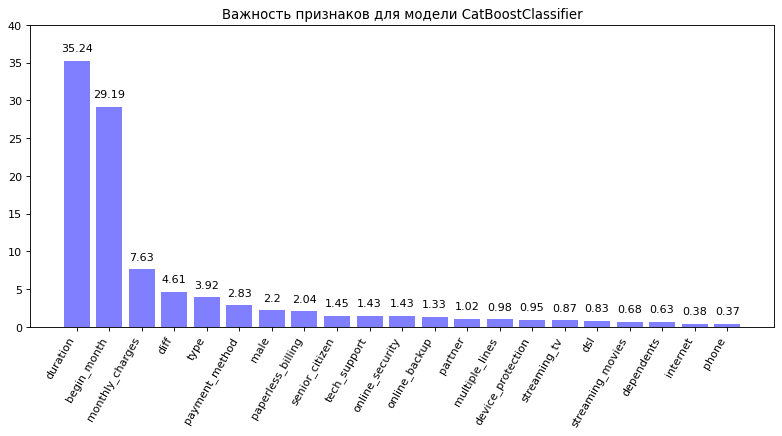

In [83]:
#comment
base64_data = 'iVBORw0KGgoAAAANSUhEUgAAAw4AAAG0CAYAAACbjHB3AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAxOAAAMTgF/d4wjAACb8ElEQVR4nOzdd5xU1fnH8c9DV1FQwIKAiF0REEUlohExVkDsGhW7UTHG3nuLxpbYu6jRWLHX2CX2KAIqsSKiP3vFAgLP74/nzO5lWJhF5s6sy/f9es1rd+/cnXPmzp17z3OquTsiIiIiIiKz06TaGRARERERkYZPgYOIiIiIiJSkwEFEREREREpS4CAiIiIiIiUpcBARERERkZIUOIiIiIiISEkKHEREREREpCQFDiIiIjLXzGy4mf2zAum4mW2Y+Xt3M/vQzKab2W6VyofIvEiBg0iVmNmT6QboZjbNzCaa2T/MrGW18yYipZnZemb2oJl9bWaTzGyUmR1mZvPX8///aWbDi7btlrkueHrtf5tZz1zexMx5Wjal27WO53qY2e1m9rmZ/Whmr5vZaWa2SCXylrEE8HTKUwvgEuAsYEngFuAvwLAK50lknqDAQaS6/k7cBLsAuwFbAcdXMT8iUg9mtj3wKDAW6A+sDBwNbJQec+P/iOvCEkA/4Evgvrl8zbliZusCzwPfA5sDKxKF82WBXSqZF3f/xN2npD87Aq2A+939/9z9J3f/1t2//bWvr8obkdlwdz300KMKD+BJ4LSibX8nboCFvwdTe7P+mKhZWyDz/F+BV4HW6e/dgImZ53cEPgG6pr9PAkYWpVn8P82AvwGfAT8B/waWK/qfHYAxwGRgInBc2u6zetSVVj2O0fqzec1ls69JFF4+BCYBVwItMq8zHtgr8/dx6TX2Sn/3IQqAPwBfATdmjmnXbHqZ13Bgw/T7YsDt6Vh/T9SG9srsO8NrAB2At4AzM/ssBzySjvlnwNlAs6L3UHjv3wL3AouWOH571XHc/lm0T9c69smeD22Bm4nCa+H58bNJ86S0z3FF28cWH0dgKPBOOo/GAJvW8XoTZ/XZp+fnBy4GPge+IQrYXes4x2d5HLKfZfr7quJtRa+3IPA18LdZPN8m/dwTGJXOqw+AUwufaeY4lfyOAL3SPh0y2zal9jv4DjC06H/WBJ5Lz38IHJF5zohrx0fAz8B7wJ9m8R0+iahkfAu4dRbvt236ObzouB4NvAn8CLwNHFj0fzsC41IePgGuyDx3EPA+tdeYk4o/L+q+PnStIx+zPUfS/jcCZwJfAPfW9xqlhx7z2kMtDiINhJl1Jm6GL2U2twJOB3oShfX+wImZ548hCg3/MrMZvs9m9jsi0Bji7uPnICtHALsCuxMF6p+Ae8ysaXrdjYDrgWuB7sC2RA0p1NaSrln09xJzkH5dOtXx2lntiELaQGBLokb0mLpeKHWrOCS9r4JPiYJKd+IzWB44bA7yNx8RLPwBWB14gzhmrepIfwHgfqJQd3Ta1hS4mygkrUkc/6HEZ5F1KHEMNgdWAI6sR94mUnvsbq3jeUs/+6Z9Dip6/hjiPNg0PX9oPdL8P2BXMzMAM1sTWHiGROP8vAa4AOgB3AncVVcXmZSnWX32lxFB16bAWkTQdW/hfC0kx4y1+HUdh0K+VgC2KfH+/kAEVOfW9aTX1nY3Ic6j7sC+RCC3T3ruHOCOlJdZfkfSOfRHohD9ZdrWFbgrPXoQFQ7XmNk66fkFgQeA14mg4wjgRDP7Y3rZbdNrbkecR3sS3wGI8wDiWC+R8tmLOMazer/f1LWdOJ/3BlYBjgXOMLPNUh6XIK4hJ6Y8DAT+m57rA5xMHLPlUj7fqeP1n60jvx/WsV99zpEtiO/xOsT1QUTq0KzaGRCZxx1hZgcBTYkg4d9EoACAu2cLOO+Z2cnAGaQCpbu7mQ0lWi/OBV4DMLOliYLYvu7+/Bzm6UDgZHe/P73WbkThcxOiwHssUTN4Xtr/baIQjLt/kv6nVfbvMvjU3admX7tIK+K9jkv7nEDUHp5Ux75HEzWO6xU2uPsEYEL638+JWsemdfxvnVJgdkHhbzMbRrQKrEnqi500I1omvgT2dHdP2/8ALA30c/evgDFmdiJRQ31G5v+/c/dPzGwyUYv9TYmstQR+znwuPzHzdb95+vl/6bWLu3h0B+5y9xfTa3xXIk2IGmwD1iXe/+5EsHlUZp8DgRHuXjhuJ6SgdBhweNF7+CLlbYbPPhWgtwcWd/ev07Y/EcelLzAy8x4nlzgOBacRn+XsugwuB3zr7p/OZh/c/crMn++b2T+IoOQSd59kZj8DU+v4nnQ0s0np9/mJ83Ezd5+etu0LvObuhTz+z8z6EQHWf4CdiEL7vul782YaI3EwcBPQmfjePpvOwQ8yaX+Rfn6eOV7LFdKZ3fut4/2fl/nzfTPbIL3/B4guRpOJFtZJKQ8vp327EC0Qj6X8TyCChOLXn2JmdeW3Zp85OEc+BQ7OHGMRqYNaHESq60qiNq8nUTDvRNQeAmBmK5vZnWY2wcy+J2roOmdfwN1/Al4hCg17EIXo+4CFmLH1oqBvGsg5KRVOLsuk14bodlMTbKSC7P+IWkGIguSTv/YNkwpFZvatmb1pZgfPxWsVfF8IGpIXgXZm1i67k5ktSdSAnlD8AmbWJR2P74DpROCR9VrRccv+b3MzOyO9n2+IoGF+ij4r4FLic36qEAglKwBvp2Nd8BzQvmjg6UUp7S+JFpM6a4Az2hJdp2ZnwfTzh1k8/wGwQfGxrIdrgd1TYX8LYtBq1gpkzrPkOWrPs4I2zPo9rEIEBR9mPpeviZrjbpn9FmTW76+Gma1OdH85p9S+9WFmvzOzR8zso5S3k5j5nKjLp8R1oRfR2nMXcKeZFVptSh27FYD/Fp1j2efvIMZkvGlm55vZ7+fgbdWbmW1uZiPN7NP0/veg9v2/BowmKkSGm9l2aaAzxNgRB941s8vS69jMKdRLfc+R1xQ0iJSmwEGkur5293fc/S13f5honv+Tmc2Xnr+HuIHuBKxB1NLOUFNqZmuk5wcBqxHddl4FLgcurCPNV6ktlPSijkJ0zgqFoj5EP+u/pZrmueGldwGiW8QNs+i69XHK13pEQXPvoucHMeNxyzqS6F50HDGYtRdRo9m8aL9ORDeR481smcz2+haKTqb22BXGcszOUsTYiNlZAphC6gZTh1NTWp+nQtdF9czrLcBmxNiTJ5m5daTkezazjsQxHD+LXVoTAVSvosfyRGG7YAlqu9PNzl+JcSelWlXeAdqY2WKz2iF1F7qf6GK0NdCbCEaLz4m6TEvXhXfc/b9EC8PCxLkDpY/dbJ9P5/9yxPnamui2U9e1oqDQTag4qJt1Bsy6ASOAx4mudasRrU7NUx6mEkHa9sQ14W/As2bWInX16gHsR5yb1xBd+X6N+p4jP/7K1xeZpyhwEGlYphJdZFqYWXtgGeAUd3/G3f8HLJ7dOY1ruBQ43d3vI7pXfEX0WT4BWM3MtixK4+dMoeQdor8vUNM3+1Ng7UwaixAFhkKN/ljihv9rTcsES9en1+sxF68HsFDqm17QB/jS3bOF4eWIgtdpdb2Au09N+RpJ1OTvWbTLhKLjlrU2cJu73+HuY4kuGAszsz+6++3EQMwrMtvHAcsVtS70JbpfZFshPs8UJi8mavJnpy/RdWV2VgdGZ7pNzcDdPyZapd4ljuvJJV6v8H/fAw8D5xGtD8XGkTnPMvkdV/T3t0Rf/bq8RrTszJf9bNIjW/hfnRikPDv9gZWI41rKIylfdfaFTy13KxAtPke6+/Pu/hYztzb8Qv26xDnRClboqlXq2I0DVjezZrN4Hnf/wd1vd/e9ibEXhfP9l/Qzm69XieBhdu+3WG/gJ3c/wd1fdve3ie54tW/KfZq7P+HuRxLd+lYnBeXuPsXdH3D3A4mgfZCZLVpX+iXU9xwRkXpQ4CBSXQuY2eJmtkQa2HgcMevRt0Rz+tfA3mbWzWL6xz8V/f++wAJE4QyiVvcnd5+cboqHAv+wGJBbX/8gBlJuZmarEDOOfEAUAiHGYOxjZgeb2XJmtqaZ7T4nb9rMWpnZ/KnP8wrEYOK58TNwqZn1NLMBROG2uAA4DLiorn7pZraRxZz8S5lZX2IMyeg5SP9dYBMz621mvYHrUp6KfZ1+Hg6sZGZ7pL8fIWqmh5tZdzPbNL2Hvxf9/0LpfFmBGDfwVl2ZMbMWZrYzMWXmY+l/Fie6Z7QyszZm1tTMtiMG714/qzdmZssTff53dPc3iZlp6utM4BTgsTqeuwDYyswOMLPlzewUolb6kpTuEsRxugvokPLfIf1vezNrmrqnjQBuNrONzWzp9DleaGbtzGwhi/Eu6xHB2uz8hZi5p67PbQYpKNofONTMLkpdkpZK59FDRBAygSiE75++v/sCQ4pe6gMiuO+aKgoKmhQ+s/RZn0eM9Xg0PX8p0NPMTknH7gBi7MDf0/M3pv0vNbMVzWxH4M+F581sV4v1IlZKn+8QascvfELU8m9kZh3MbP7UhWdvYLCZ3WJm66f3u56Z3UjMBFXsXeJ83c1ibYjjiMCTlIe1zOzI9J1ZipgMYDLwgZkNNLNhZrZqarnYnhh7MatWsVkqdY7M6euJzPOKp1nSQw89KvMgum8UphCcTnSl+CfQMbPPpsQgxp+IJv89qJ22cVGidWGDzP67MfNUjo8BZ6XfT2LOp2N9lJmnY92JmGZxCjGLydFFz3ct5LOOtArveRpRuDp+Nsdo/bRvs+LXZubpWHcjppf8AbgaaJn5n/FEoWOhom2F6Vh3Sce5MC3kdUC7utLL/H/NdJ1EgfZBorvD+8QMWBOB3Wb1GsSaHV8Bi6W/lyMGx9dnOtbv0/mwSonjNqvHcGKxrA+IWZOsrvOBqOEeBRyeeX4vSk/HOrKO7XUdg8J0rFMomo6VGb8fdT26ZvJ4bvrsJxMDsy8jgqQdiNryIUV5Gc7M07GOA5rW9fmWOD8fJgL2SelYHQrMX3Ru/kAUXg/PHrv0GTydzhvP/E/2fX5PjGfYpCjtwnSsU9Ix3LXo+TXT/xWmM81OxzqEGAf0fcr7Q8AKmecPJK5H05lxGtRe6X18QZynbxBd2RaexXE9mjiXvyOmuD0beDI9txIRMH+R3v9/iQHgEN39ns4c12eAtWbx3Vs2ez7MIh+zPEfq2l8PPfSY9cPc69s1WESk4bGY9ek0d+9U7bw0FGa2PlHgW7+O53YmCl27VTZXc8bMniTew5N1PPcO8R7GVzhbIiLzNHVVEhFpfKYQrRl1+Ynon9/QfUW8j7p8TrRYiYhIBanFQUR+09TiICIiUhlz1OJgZieamZtZ9/T3omb2kJm9bWZjLRagERGpGHcfrqBBREQkf/UOHNJMIWuTVldNzgSed/fliBk+biya/k1ERERERBqBegUOZtaSmNpwf2ZcaGm7tB13f4mY/12tDiIiIiIijUx9WwdOIaYqe9/Squ9p/uMm7p6d03s80KWuFzCzQ8gsHtO0adMlF1988bp2FRERERGRCvvoo4+muHvLWT1fMnBIiyH1AY6q4+nikdWzXObe3c+jdpEqOnXq5BMnTiyVvIiIiIiIVICZzXaRz/p0Vfo9sfro+2Y2HuhELHizZkqgQ2bfpZhxDISIiIiIiDQCJQMHdz/T3Tu6e1d370qsQLmxuz8I3AYMAzCzPsDiwMgc8ysiIiIiIlUwtzMgHQncYGZvEwv17OLuU+c+WyIiIiIi0pDMceCQWh0Kv38KbFTODImIiIiISMMzRwvAiYiIiIjIvEmBg4iIiIiIlKTAQURERERESlLgICIiIiIiJSlwEBERERGRkhQ4iIiIiIhISQocRERERESkJAUOIiIiIiJSkgIHEREREREpSYGDiIiIiIiUpMBBRERERERKUuAgIiIiIiIlKXAQEREREZGS5unAYaONNqJHjx706tWLddddl1GjRgGw/vrr061bN3r16kWvXr04//zz6/z/MWPGsN5667Hiiiuy6qqrss8++zB58uSZ9ttjjz0wMyZNmpTn2xERERERyU2zamegmm699Vbatm0LwF133cUee+zBK6+8AsAFF1zAwIEDZ/v/rVq14qKLLqJHjx5MmzaNP/7xj5x77rkcc8wxNfvce++9mFlu70FEREREpBLm6RaHQtAA8O2339KkyZwdjuWWW44ePXoA0LRpU/r06cN7771X8/yXX37JySefzHnnnVeW/IqIiIiIVMs8HTgADB06lM6dO3Pcccdx3XXX1Ww//PDDWXXVVdl+++1nCAZm5YcffuCqq65i0KBBNduGDRvGSSedRJs2bXLJu4iIiIhIpczzgcP111/Phx9+yGmnncbhhx8OwA033MCbb77J6NGjWXfddUt2Wfrll1/Yfvvt2Wijjdhiiy0AuO2222jRokXJ/xURERER+S0wd69Kwp06dfKJEydWJe1ZmW+++Zg4cSLt2rWbYXurVq346KOPZtoOETRst912tG/fniuuuKJmPMP+++/PPffcQ7NmMYzkgw8+oEuXLtx3332suuqq+b8ZEREREZE5YGYfuXunWT0/z7Y4fPfdd3z88cc1f9955520a9eOhRZaiE8//bRm+x133MFiiy1WZ9AwdepUdthhBxZZZJEZggaASy65hIkTJzJ+/HjGjx8PwOuvv66gQURERER+k+bZWZW+/fZbtt56a3766SeaNGlChw4duO+++5gyZQqbb745kydPpkmTJrRv35577rmn5v9OOOEEOnbsyL777sstt9zCiBEj6NGjB6utthoA66yzDhdffHG13paIiIiISC7UVUlERERERNRVSURERERE5p4CBxERERERKUmBg4iIiIiIlKTAQURERERESlLgICIiIiIiJSlwEBERERGRkuq9joOZPQIsDkwHvgf+7O6jzOxJoAvwXdr1Onc/v9wZFRERERGR6pmTBeC2c/dvAMxsCHAN0Ds9d6C731ferImIiIiISENR78ChEDQkbYiWh9+8k05qXOmIiIiIiORhjsY4mNn1ZvYhcBqwa+aps81sjJndYmbdyppDERERERGpujkKHNx9qLt3Bo4Dzk6bd3H3lYAewDNAnV2WzOwQM5tYeEyaNGlu8i0iIiIiIhX0q2ZVcvfrgP5m1s7dP0zb3N0vArqZWbs6/uc8d+9UeLRu3Xruci4iIiIiIhVTr8DBzBYys46Zv7cEvgS+M7PFMtu3Bj519y/LnlMREREREama+g6ObgPcYWbzEYOiPwcGAi2A+82sZdr+BTA4j4yKiIiIiEj11CtwSN2R1pzF02uULzsiIiIiItIQaeVoEREREREpSYGDiIiIiIiUpMBBRERERERKUuAgIiIiIiIlKXAQEREREZGSFDiIiIiIiEhJChxERERERKQkBQ4iIiIiIlKSAgcRERERESlJgYOIiIiIiJSkwEFEREREREpS4CAiIiIiIiUpcBARERERkZIUOIiIiIiISEkKHEREREREpCQFDiIiIiIiUpICBxERERERKUmBg4iIiIiIlKTAQURERERESlLgICIiIiIiJSlwEBERERGRkhQ4iIiIiIhISQocquTnn39myJAhLL/88vTq1YtNNtmE8ePHA/DSSy+xzjrr0KNHD3r16sXjjz9e52tMmjSJjTfemPbt29O+ffuZnr/hhhvo2bMn3bt3Z8CAAUyYMCHPtyQiIiIijZgChyraZ599+N///seoUaMYOHAg++yzD+7OlltuyWmnncbo0aO5+eab2XXXXfnpp59m+v/mzZtzxBFH8Oijj8703Lhx4zjyyCN55JFHGDt2LEOHDmW//farxNsSERERkUZIgUOVtGrVis022wwzA2Dttdfmvffe48svv+Srr76if//+AKy44oq0bduWBx98cKbXaNmyJQMGDKBt27YzPTd27Fh69erFYostBsDAgQN58MEH+fLLL/N7UyIiIiLSaClwaCAuuOACBg0aRPv27VlsscW44447AHjhhRd46623arox1VevXr3473//yzvvvAPA9ddfj7vzwQcflDvrIiIiIjIPUODQAJxxxhm8/fbbnH766QDcfffdXHXVVfTu3ZtLLrmEfv360bx58zl6zWWXXZZLL72UXXbZhTXXXJPvv/+eNm3azPHriIiIiIgANKt2BuZ155xzDiNGjODRRx9l/vnnB6BHjx4zdE1aaaWVWHnllef4tbfaaiu22morAD755BPOOOMMlllmmfJkXERERETmKWpxqKLzzjuPf/3rX/z73/+eYZzCJ598UvP7lVdeyQILLMAGG2wwx6//f//3fwBMmzaNI488kmHDhtUEJyIiIiIic6LegYOZPWJmo81slJk9Y2a90vZFzewhM3vbzMaaWb/cctuITJw4kUMPPZRvvvmG/v3706tXL9Zaay0ALr/8cpZffnmWW2457r33Xu68886aQdQnnHACl112Wc3r9O7dm759+/L111/TqVMndtlll5rndt99d1ZeeWVWWGEF2rRpwxlnnFHZNykiIiIijYa5e/12NGvr7t+k34cAJ7h7bzO7Bpjg7ieZWR/gdmAZd586u9fr1KmTT5w4ca4yXw4nndS40hERERER+TXM7CN37zSr5+s9xqEQNCRtgOnp9+2ApdM+L5nZp0A/4Mk5zayIiIiIiDRMczQ42syuB/qnPzcxs3ZAE3f/PLPbeKBLHf97CHBI4e82bdrMcWZFRERERKQ65mhwtLsPdffOwHHA2YXNRbvZLP73PHfvVHi0bt16znMrIiIiIiJV8atmVXL366htecDMOmSeXgqYMJf5EhERERGRBqRegYOZLWRmHTN/bwl8CXwF3AYMS9v7AIsDI8ufVRERERERqZb6jnFoA9xhZvMRg6I/Bwa6u5vZkcANZvY2MAXYpdSMSiIiIiIi8ttSr8DB3T8E1pzFc58CG5UzUyIiIiIi0rBo5WgRERERESlpjqZjlfLTAnQiIiIi8lugFgcRERERESlJgYOIiIiIiJSkwEFEREREREpS4CAiIiIiIiUpcBARERERkZIUOIiIiIiISEkKHEREREREpCQFDiIiIiIiUpICBxERERERKUmBg4iIiIiIlKTAQURERERESlLgICIiIiIiJSlwEBERERGRkhQ4iIiIiIhISQocRERERESkJAUOIiIiIiJSkgIHEREREREpSYGDiIiIiIiUpMBBRERERERKUuAgIiIiIiIlKXAQEREREZGSFDiIiIiIiEhJChxERERERKQkBQ4iIiIiIlKSAgcRERERESlJgYOIiIiIiJSkwEFEREREREqqV+BgZq3M7C4ze8vMRpnZQ2bWNT33pJm9l7aPMrODc82xiIiIiIhUXLM52PcK4EF3dzM7IP29UXruQHe/r+y5ExERERGRBqFeLQ7u/rO7P+DunjY9D3TLL1siIiIiItKQ/NoxDgcC92b+PtvMxpjZLWZWZ0BhZoeY2cTCY9KkSb8yaRERERERqbQ5DhzM7BhgOeDYtGkXd18J6AE8A9TZZcndz3P3ToVH69atf22eRURERESkwuYocDCzw4CtgE3d/UcAd/8w/XR3vwjoZmbtyp5TERERERGpmnoHDmZ2CLAj8Ad3/yZta2Zmi2X22Rr41N2/LHdGRURERESkeuo1q5KZdQLOBd4DnjAzgMnABsD9ZtYSmA58AQzOJ6siIiIiIlIt9Qoc3H0iYLN4eo3yZUdERERERBoirRwtIiIiIiIlKXAQEREREZGSFDiIiIiIiEhJChxERERERKQkBQ4iIiIiIlKSAgcRERERESlJgYOIiIiIiJSkwEFEREREREpS4CAiIiIiIiUpcBARERERkZIUOIiIiIiISEkKHEREREREpCQFDiIiIiIiUpICBxERERERKUmBg4iIiIiIlKTAQURERERESlLgICIiIiIiJSlwEBERERGRkhQ4iIiIiIhISQocRERERESkJAUOIiIiIiJSkgIHEREREREpSYGDiIiIiIiUpMBBRERERERKUuAgIiIiIiIlKXAQEREREZGSFDiIiIiIiEhJChxERERERKQkBQ4iIiIiIlJSvQIHM2tlZneZ2VtmNsrMHjKzrum5RdPfb5vZWDPrl2uORURERESk4uakxeEKYAV37wXcl/4GOBN43t2XA3YHbjSzZmXNpYiIiIiIVFW9Agd3/9ndH3B3T5ueB7ql37cDLk77vQR8CqjVQURERESkEfm1YxwOBO41s3ZAE3f/PPPceKBL8T+Y2SFmNrHwmDRp0q9MWkREREREKm2OAwczOwZYDjg2bfLiXer6P3c/z907FR6tW7ee06RFRERERKRK5ihwMLPDgK2ATd39R3f/Mm3vkNltKWBC+bIoIiIiIiLVVu/AwcwOAXYE/uDu32Seug0YlvbpAywOjCxjHkVEREREpMrqNfuRmXUCzgXeA54wM4DJ7r4WcCRwg5m9DUwBdnH3qTnlV0REREREqqBegYO7T2TWYxc+BTYqZ6ZERERERKRh0crRIiIiIiJSkgIHEREREREpSYGDiIiIiIiUpMBBRERERERKUuAgIiIiIiIlKXAQEREREZGSFDiIiIiIiEhJChxERERERKQkBQ4iIiIiIlKSAgcRERERESlJgYOIiIiIiJSkwEFEREREREpS4CAiIiIiIiUpcBARERERkZIUOIiIiIiISEkKHEREREREpCQFDiIiIiIiUpICBxERERERKUmBg4iIiIiIlKTAQURERERESlLgICIiIiIiJSlwEBERERGRkhQ4iIiIiIhISQocRERERESkJAUOIiIiIiJSkgIHEREREREpSYGDiIiIiIiUpMBBRERERERKqlfgYGYXmNl4M3Mz657Z/qSZvWdmo9Lj4PyyKiIiIiIi1dKsnvvdDvwNGFnHcwe6+33ly5KIiIiIiDQ09Qoc3P1pADPLNzciIiIiItIglWOMw9lmNsbMbjGzbmV4PRERERERaWDmNnDYxd1XAnoAzwCz7LJkZoeY2cTCY9KkSXOZtIiIiIiIVMpcBQ7u/mH66e5+EdDNzNrNYt/z3L1T4dG6deu5SVpERERERCroVwcOZtbMzBbL/L018Km7f1mWnImIiIiISINRr8HRZnYxsAWwOPComU0CegL3m1lLYDrwBTA4r4yKiIiIiEj11HdWpWHAsDqeWqO82RERERERkYZIK0eLiIiIiEhJChxERERERKQkBQ4iIiIiIlKSAgcRERERESlJgYOIiIiIiJSkwEFEREREREpS4CAiIiIiIiUpcBARERERkZIUOIiIiIiISEkKHEREREREpCQFDiIiIiIiUpICBxERERERKUmBg4iIiIiIlKTAQURERERESlLgICIiIiIiJSlwEBERERGRkhQ4iIiIiIhISQocRERERESkJAUOIiIiIiJSkgIHEREREREpSYGDiIiIiIiUpMBBRERERERKUuAgIiIiIiIlKXAQEREREZGSFDiIiIiIiEhJChxERERERKQkBQ4iIiIiIlKSAgcRERERESlJgYOIiIiIiJRUr8DBzC4ws/Fm5mbWPbN9UTN7yMzeNrOxZtYvv6yKiIiIiEi11LfF4XagH/BB0fYzgefdfTlgd+BGM2tWxvyJiIiIiEgDUK9Cvrs/DWBmxU9tByyd9nnJzD4lAowny5dFERERERGptl89xsHM2gFN3P3zzObxQJdZ7H+ImU0sPCZNmvRrkxYRERERkQqb28HRXvT3TE0SNTu6n+funQqP1q1bz2XSIiIiIiJSKb86cHD3LwHMrENm81LAhLnNlFTeN998Q69evWoeyy+/PM2aNeOrr76aad8xY8aw/vrrs9JKK7HCCiswYsQIAN5//31WX311evXqxaqrrsq2227L119/Xem3IiIiIiI5mNuBzLcBw4CTzKwPsDgwcq5zJRXXtm1bRo0aVfP3Oeecw1NPPcUiiywyw34//vgjQ4YM4brrrqNfv35MnTq1Jjjo2LEjI0eOZL755gPgoIMO4tRTT+W8886r2PsQERERkXzUdzrWi81sItAJeNTM3klPHQn8zszeBoYDu7j71FxyKhV17bXXsueee860/aabbqJv37706xcz7zZr1owOHaLRqWXLljVBw7Rp05g0aRJNmmipEBEREZHGoL6zKg0jWhaKt38KbFTuTEl1Pffcc3z55ZcMHDhwpufeeOMNWrVqxcCBA5k4cSI9evTg3HPPrQkepkyZwpprrskHH3xAz549ueeeeyqdfRERERHJgaqDZSbXXHMNQ4cOpVmzmePKX375hYcffpjLL7+cV199lc6dOzNsWG1M2aJFC0aNGsWnn37KCiuswGWXXVbJrIuIiIhIThQ4yAx++OEHbrnlFvbYY486n19qqaXo378/Sy65JGbGTjvtxIsvvjjTfi1atGD33XfnhhtuyDvLIiIiIlIBChxkBrfddhs9evRgxRVXrPP57bbbjpdeeonvvvsOgIceeoiePXsCMGHCBH744QcApk+fzq233kqPHj0qk3ERERERydXczqokjczVV18906Dovfbai8GDBzN48GC6dOnC0UcfTd++fWnWrBlLLrkkV1xxBQBjx47lqKOOAiJw6N27NxdccEHF34OIiIiIlJ+5F6/hVhmdOnXyiRMnViXtrJNOqm461U5fRERERATAzD5y906zel5dlUREREREpCQFDiIiIiIiUpICBxERERERKUmBg4iIiIiIlKTAQURERERESlLgICIiIiIiJSlwEBERERGRkrQAnGgtCREREREpSS0OIiIiIiJSkgIHEREREREpSYGDiIiIiIiUpMBBRERERERKUuAgIiIiIiIlKXCQBufkk0/GzBg7dmydz48ZM4b111+flVZaiRVWWIERI0YAMGnSJDbeeGPat29P+/btK5llERERkUZP07FKg/LKK6/w/PPP06VLlzqf//HHHxkyZAjXXXcd/fr1Y+rUqXz99dcANG/enCOOOIJ27dqx4YYbVjLbIiIiIo2eWhykwZg8eTLDhg3jkksuwczq3Oemm26ib9++9OvXD4BmzZrRoUMHAFq2bMmAAQNo27ZtpbIsIiIiMs9Q4CANxgknnMDOO+/M0ksvPct93njjDVq1asXAgQPp1asXQ4cO5fPPP69gLkVERETmTQocpEF47rnneOmll9h///1nu98vv/zCww8/zOWXX86rr75K586dGTZsWIVyKSIiIjLvUuAgDcJTTz3FuHHjWHrppenatSsTJ05k44035sEHH5xhv6WWWor+/fuz5JJLYmbstNNOvPjii1XKtYiIiMi8Q4GDNAhHHXUUH3/8MePHj2f8+PF06tSJhx9+mE033XSG/bbbbjteeuklvvvuOwAeeughevbsWbZ8bLTRRvTo0YNevXqx7rrrMmrUqJn2mT59Oocddhjdu3dnxRVXZM8992TKlClAzPi03nrrseKKK7Lqqquyzz77MHny5LLlT0RERKRaFDhIg7fXXntxzz33ANClSxeOPvpo+vbtS8+ePXn00Ue5+OKLa/bt3bs3ffv25euvv6ZTp07ssssuc5TWrbfeyujRoxk1ahSHHnooe+yxx0z7XH311YwePZpXXnmFN998E4B//OMfALRq1YqLLrqIcePGMWrUKL799lvOPffcX/vWRURERBoMTccqDdL48eNrfr/qqqtmeG7o0KEMHTq0zv975ZVX5ird7IxM3377LU2azBxbv/baa2y44Ya0aNECgM0224yTTz6Zww8/nOWWW65mv6ZNm9KnTx/GjRs3V3kSERERaQjU4iBSZOjQoXTu3JnjjjuO6667bqbn+/Tpw913383333/PlClTuPnmm2cIdAp++OEHrrrqKgYNGlSBXIuIiIjkS4GDSJHrr7+eDz/8kNNOO43DDz98pueHDh3KxhtvzHrrrccGG2zAKqusQvPmzWfY55dffmH77bdno402YosttqhU1kVERERyU5bAwczGm9k4MxuVHtuX43VFqmnXXXfliSee4Msvv5xhu5lxwgkn8OqrrzJy5EhWXHFFVl555Zrnf/nlF7bbbjuWWGKJmrEPIiIiIr915RzjsI27jy3j64lU1HfffcekSZPo2LEjAHfeeSft2rVjkUUWmWG/n3/+mZ9//pm2bdvyxRdfcOaZZ3LqqacCMHXqVHbYYQcWWWQRrrjiilmugC0iIiLyW6PB0SLJt99+y9Zbb81PP/1EkyZN6NChA/fddx9mxl577cXgwYMZPHgw3377Lb///e9p2rQp06ZN46CDDqoZx3DLLbcwYsQIevTowWqrrQbAOuusM8PMTyIiIiK/ReUMHG40sybAC8DR7v559kkzOwQ4pPB3mzZtypi0yNzr3LnzLBeTy87stNhii81ypqSddtqJnXba6Vfn4eeff2aHHXbgjTfeYP7552fxxRfnsssuo2vXrjPs5+4cccQRPPDAAzRt2pR27dpx5ZVXsuyyy/L++++zzTbbMG3aNKZNm8aKK67IFVdcwcILL/yr8yUiIiJSrsHR67l7T6A38CUw01Q07n6eu3cqPFq3bl2mpEUal3322Yf//e9/jBo1ioEDB7LPPvvMtM8999zD008/zahRoxg9ejQDBgzgmGOOAaBjx46MHDmSUaNGMWbMGJZccsmarlQiIiIiv1ZZAgd3n5B+/gL8HVi3HK8rMq9p1aoVm222Wc3YiLXXXpv33nuvzn0nT57Mzz//jLvz3Xff0alTJwBatmzJfPPNB8C0adOYNGlSnetRiIiIiMyJue6qZGYLAM3d/Zu0aUfg1bl9XZl3nHRS40qnnC644II614EYNGgQTz75JIsvvjgLLrggSy65JE899VTN81OmTGHNNdfkgw8+oGfPnjUrb4uIiIj8WuWohlwMeMLMRpvZGOD3QN3L+opIvZ1xxhm8/fbbnH766TM998orrzBu3Dg++ugjPv74YwYMGMABBxxQ83yLFi0YNWoUn376KSussAKXXXZZJbMuIiIijdBcBw7u/p67r+buPdx9VXffwt3HlyFvIvOsc845hxEjRvDggw8y//zzz/T88OHD6d+/P23btqVJkyY1a04Ua9GiBbvvvjs33HDDr8rHzz//zJAhQ1h++eXp1asXm2yySZ2rZD/++OOstdZarLzyynTv3p1jjz0Wd/9VaYqIiEjDpI7PIg3Meeedx7/+9S/+/e9/07Zt2zr36datG4899hi//PILAPfeey/du3cHYMKECfzwww8ATJ8+nVtvvZUePXr86vzUZ7D2wgsvzL/+9S/eeOMNXn75ZZ566in+9a9//ar06husAFx99dUst9xyLLPMMuyzzz5MnTp1hufdnQEDBtC+fftflRcRERGppcBBpAGZOHEihx56KN988w39+/enV69erLXWWgDstddeNWMVhg0bRpcuXVh11VXp0aMHTzzxRM1aEWPHjqVv37706NGDHj168MUXX3DBBRf8qvzUd7D2aqutRrdu3Wr+p1evXrMc1F0f9QlW3n//fY4//nhGjhzJO++8wyeffMLVV189wz4XXXTRTFPZioiIyK+jBeBEaDgDtDt16jTLLj7ZtSRatmzJlVdeWed+m222GZttttmvzeJszWqwdtYnn3zC7bffzgMPPPCr0igEKwVrr702f//732fa7/bbb2fLLbdkscUWA2Dfffflb3/7G3/6058AePvtt7n55psZPnw4d99996/Ki4iIiNRS4CAi9VIYrD27gdbfffcdgwYN4ogjjqB3795lSXdWwcqECRNYaqmlav7u2rUrEyZMAKKL1t57783FF19M8+bNy5IPERGReZ26KolISaUGawN8//33bLLJJgwePJhDDjmkzn3m1OxmlgJqulABM7TUnHPOOay33nr06tXrV6V74IEH0rVrV8yMsWPHznbfn3/+mZVXXpk11lijZtv48eNp1qwZvXr1qnm8++67FUv//fffZ/XVV6dXr16suuqqbLvttnz99df1Tr+h5EFERBoWBQ4iMlv1Gaw9adIkNtlkEzbeeGOOP/74sqRbKljp0qXLDIOmP/jgA7p06QLA008/zfDhw+natSv9+vXj66+/pmvXrvUuuG6zzTaMHDlyhhaNWTn22GPp27fvTNvbtm3LqFGjah7LLLNMvdIuR/rlWD282nmoT+Dy3HPP1QRmq6yyCn/605+YPHkyoMBFRCQPChxEZJbqO1j7H//4By+++CJ33nlnTUFuVq0E9VGfYGXrrbfmzjvv5NNPP8Xdueyyy9hhhx0AuO+++5gwYQLjx49n5MiRLLzwwowfP56FF164Xumvt956NStxz84zzzzD22+/zS677FLv91aJ9Muxeni181CfwKVnz5689NJLNcHJ559/zuWXXw6UJ3gSEZEZaYyDiMxSfQdrH3vssRx77LFlSbMQrHTr1o3+/fsDUQh94YUX2GuvvRg8eDCDBw+mW7dunHzyyayzzjpMnz6dDTbYgD333LMseaiPH374gYMOOoh77rmHt99+e6bnv/vuO/r06cO0adMYMmQIxx57LE2bNq1Y+pVYPTzPPKy33nol98m2RE2ZMoWffvqpJjhp2bJlzXOFwGVWQeisHHjggdxzzz188MEHjBkzpmbK42JXX301Z555JtOnT2fAgAFccsklNGvWjDFjxjBs2DA+++wzmjdvTt++fbnwwgtnyJuIyG+JWhxEpEEpBCvvvvtuTTefF154AYhgZfDgwTX77r333rzzzju89957XHXVVXUOhO7atStffPFF2fN5+OGHM2zYMJZccsmZnltiiSWYOHEiL730Eo8++ijPPPMM5557bsXSh8qsHt4Q8jB+/Hh69epF+/btWWihhWaYunfKlCk1z73zzjuccMIJc/Ta9Wn1mN20wK1ateKiiy5i3LhxjBo1im+//XaOz4O3336b3/3udyy//PKsueaavPHGGzPtM336dA477DC6d+/OiiuuyJ577smUKVNqnj/nnHPo3r07vXr1Yu211+all16qWPpzO95HRBoWBQ4iIr/CyJEjOeWUU+jatSs77LADY8aMYZVVVgGitnvRRRcFYJFFFmGPPfbgmWeeqVj6WXO7enhDz0PXrl0ZNWoUn3zyCZMnT2bEiBEzpDs3gUt9umtlpwU2M/bdd9+axQ+XW265msUXmzZtSp8+feZ4fZM//elP7LPPPrz11lscccQRdbaqXX311YwePZpXXnmFN998E4jugwCvvfYaF154Ic8//zyjRo3igAMOYNiwYRVLH+ZuvA/UL3hxdw4//HBWWWUVevToQf/+/XnnnXcAePTRR2cIXDp27DhHs77NbfoabyONiboqiTQADWUdCam/0aNH1/z+5JNPcthhh/Hyyy8D8Nlnn7HwwgvTvHnzmsLsaqutVrH0J0yYQLt27VhggQXKsnp4Q85DQevWrdlhhx248cYba8a6FBQCl7333psjjjiirOnOblrgrB9++IGrrrqKs846q96v/dlnn/HKK6/wyCOPADGu54ADDmD8+PEzLGz42muvseGGG9KiRQsg1nI5+eSTOfzwwwH45Zdf+OGHH2jdujXffPNNvcaulDP9uVUIXnbbbTduv/129txzT5577rkZ9rnnnnt4+umnGTVqFM2bN+e0007jmGOO4dZbb2XDDTdk1KhRNfsOHDiwphtkJdIvjLcpjPk56KCDOPXUUznvvPPqnYe3336bXXfdlS+++IK2bdsyfPhwVl555Zn2GzNmDH/+85/59NNPmT59On/961/ZaqutgGh5Gj58OM2aNaNVq1ZceOGF9OnTpyLpv//++2yzzTZMmzaNadOmseKKK3LFFVfUe9yZNBxqcRARKTJs2DA6derExIkT2XDDDVl22WWBGQeEz87IkSNZbbXV6NmzJ71792bxxRefozEgc5t+OVYPbwh5KOXdd9/ll19+AaJb0ogRI2qCkwkTJvDDDz8A5B64zGpa4IJffvmF7bffno022ogtttii3q/74Ycf0rFjR5o1a1aTTpcuXWYKTPr06cPdd9/N999/z5QpU7j55ptrZhzr2bMnhxxyCEsvvTSdOnXi/PPP58ILL6xY+lA73qd3796ccsopTJs2rd7HoBC87LzzzkAEL++///4Mr18wefJkfv75Z9yd7777rs4A6eOPP+bxxx+v94QG5Ui/HJMV1Kfl58cff2TIkCGcdtppvPnmm7z++uusu+66QGVanmaXviYraDzU4iAiUuTiiy/m4osvnml7dkB41vrrr19T0w6w1VZb1dTyVSP9cqweXu08DBs2jLvvvptPPvmEDTfckNatW/POO+/MMED+ySef5Pzzz6dp06ZMnTqVDTbYoGY64LFjx3LUUUcBETj07t277IELzH5aYIigYbvttmOJJZaYoftOfWWDEqg7MBk6dCgffPAB6623HgsssAAbbrghjz/+eE1+7rnnHt59912WWGIJLrroInbaaSeefPLJiqRfGO+z6KKL8tVXX7H99ttz7rnn1rvlZ3bBS7bVY9CgQTz55JMsvvjiLLjggiy55JI89dRTM73eddddx6abblrTlbBS6c/NRAH1bfm56aab6Nu3L/369QOgWbNmdOjQoeb5vFueZpd+OSYrqE+rx3PPPcd+++1X83779evHBRdcUJP+3LS6lCMPjz76KIcddljNvp999hmLL744r7zyyhwdi2pSi4OIiDQ4F198MRMnTmTq1Kl88sknNf3FswPk99xzT8aOHctrr73G66+/zoUXXkirVq2ACFxGjx7N6NGjGTt2LNdffz3t2rUrez5nNy3w1KlT2WGHHVhkkUW44oorZiqEl9K5c+eaYwBRaP/www9nCEwgCrMnnHACr776KiNHjmTFFVesKczcdtttdO/enSWWWAKA3Xffnaeffrpetf7lSL8c433qE7y88sorjBs3jo8++oiPP/6YAQMGcMABB8y037XXXjvHs6+VI/25GW9T35afN954g1atWjFw4EB69erF0KFD+fzzz4HKtDzNLn2Y+8kK6tPqMbspmue21aUceSh0mys8evfuzU477TRHeag2BQ4iIiJ1qE93rey0wMssswyLLrpoTWHilltuYcSIEbz88susttpq9OrVa44KKosuuiirrbYa//znPwG444476Nq16wy1vBArd3/zzTcAfPHFF5x55pk1NfrdunVj5MiRTJo0CYB7772XlVZaqV5TA5cj/c8++6ymO9mvGe9T3+Bl+PDh9O/fn7Zt29KkSRN23XVXnnjiiRn2efrpp/nxxx/ZeOONq5I+/PqJAuoTvPzyyy88/PDDXH755bz66qt07ty55nzLtjxNnDiRgw8+eI4KrHObPsxd8FTfLmPzzz9/zex6xVM0F/JY6MI4J60u5cxDwZx2m2so1FVJRAAN0BYpVt/uWnvvvTd77733TPvttNNOc12bePnll7PbbrtxxhlnsNBCC3HdddcBzNBl69tvv+X3v/89TZs2Zdq0aRx00EEMGjQIgC233JKXXnqJNdZYg5YtW7LgggvWBAKVSH/kyJGccMIJM3Qnm5PxPtngZbfddptl8NKtWzcefvhhDj74YJo3b869994707ob11xzDbvtttscradSjvTndqKAbPDSrFmzWQYvSy21FP3796+ZHnmnnXaq6S5YV8vTgQceyLRp00oej3Kkn/VrJiuob5cxiCmAhwwZwjvvvMPmm29eM0VzttVlkUUWoWXLljz99NP1Sr9cecia025zDYUCBxFpEBS4iMxshRVWmGkGH5gxeFlsscUYN25cnf9vZvz1r3/lr3/9a1XSn9vxPlC/4GXYsGG8+eabrLrqqrRo0YIllliipnsIwPfff88dd9zBa6+9VvH053a8TX2Dl+22246rr76a7777joUWWoiHHnqInj17AhHYXH/99UyaNInWrVv/6panX5t+OWZZq0+rB9RO0Txp0iR23nlnRowYwQ477DDX433KkYesa6+9lr///e/1TruhUOAgIiIiDVZ9gpeWLVty5ZVXzvI1FlxwQb7//vuqpF+OyQrqE7x06dKFo48+mr59+9KsWTOWXHJJrrjiCqAyLU+zS39ug6f6tnpkFU/RPDetLuXKQ8Gv6TbXUChwEBEREWnA6hO8QMxwNXTo0Jn2q0TL0+zSn9vgqb6tHu+++y5dunShefPmM03RPDetLuXKQ8Gv6TbXUChwEBEREZEGrT6tHrObonluW13KkQeYu25zDYECBxERERFp0OrT6rHnnnvOcrrduW11KUceYO66zTUEChxERJKGMEC72nmodvoiItJwKXAQEZEGRcGLiEjDpAXgRERERESkJLU4iIiIZDSEFo+GkAcRkWIKHERERGQGDSFwaQh5EJEZKXAQERERKaLARWRmChxEREREGqBqBy/VTl8aHg2OFhERERGRksrS4mBmywHXAe2Bb4Dd3P2Ncry2iIiIiMybqt3qUe30G5pytThcDlzh7ssDfwOuLtPrioiIiIhIAzDXgYOZLQr0Bv6ZNt0BLG1mXef2tUVEREREpGEwd5+7FzBbHbjB3VfObHsROMzdn85sOwQ4JPOviwOfzFXi1dMamDQPp98Q8lDt9BtCHqqdfkPIQ7XTVx4aRvoNIQ/VTr8h5KHa6TeEPFQ7/YaQh2qn3xDyUO3050YHd285qyfLNatScfRhM+3gfh5wXpnSqyozm+junebV9BtCHqqdfkPIQ7XTbwh5qHb6ykPDSL8h5KHa6TeEPFQ7/YaQh2qn3xDyUO30G0Ieqp1+nsoxxuFDoJOZNQMwMwM6AxPK8NoiIiIiItIAzHXg4O6fAa8CO6dNWwPj3X383L62iIiIiIg0DOXqqvQnYLiZHQN8B+xaptdtqKrd5ara6UP181Dt9KH6eah2+lD9PFQ7fVAeGkL6UP08VDt9qH4eqp0+VD8P1U4fqp+HaqcP1c9DtdPPzVwPjhYRERERkcZPK0eLiIiIiEhJChxERERERKQkBQ4iIiIiIlKSAgdpUMxsMTNbw8x0boqISIOie5PM6/QFmIW0HoVU3g3AAsAsVy2sJJ0H1aXj3zAUPod58fPIvPf1zaxDtfMj1WFm2wO4+/T0d9W+C/Pi97BAgVv16QNIir+Inqabmpe+oIUvpJnNn26SzSv5/s2sC7AgsfL482a2aNpeyTxY9nev0rRjZrZ34f1XIe2m6WdLM+tkZh2rlQegXaXTbggy38WmZrZMtfMBLAq118V5ReEaYGbLAycCX1U7T9VWjYJb5vvQJLOtkveFlYAjzex+M9sQ4rtQyWORfb9VvC8VPocW1UgfZgjcDjWzNvNSGa2hUOBA3JzTRaCTme1nZheb2R+g5uLQtNRrlCkfhS9lKzPrUoUvROFi9HdgLXf/BWhiZs0rlP4vwN3ARcCXwBSobBCXSetA4DYzu9DMli48X4k8mFlLYDPgdTM7Ku/0itI2d5+WzsV/AQcDr5pZn0rmw92npV8vMbO3CzfrSjOz5cxscTNbuMJJd0k/zwHWT3mp+A2ycJMGDjez3SuZj0wA28rMljKz9TLPVSQPmQLa1sDw9N1oWeFCa+E4rJLOx4rcjzLpZwvrzTIFt4rlI3MenmNml6VtlSw8vw38EXgOON3MrjGzZTLHIteyVKaMsrSZHWxm82Weq0g5zsyauPv01Op2jZlVvFLHzNY2s33NbCCwg7t/m3muUtelQgtkz1TBt341jkU1KXBghkLKZcAGwDfAP8zs9nRxmDbLfy5vPqabWQ/gEeBc4A4zG1SJtDM1a6sDPdz9LDNbAjgfGGlmG+Sc/r5AD+BO4vh/DRxrZtub2eKQ/40iE7jtD6wJ3ApsC3xpZs0qkYeUxmR33xI4EjjEzF4zs23zTjcpXHxPA/4H/BuYALxsZp3NbNncM1BbUNogpf05cJ2ZPWBmXSuY/n7EOfA4cKiZbWhmbSuQ/uLAXmZ2ExFAPgAzBLUV7caXzv13gH3MbNVKFdgy191riOvQTWb2qpltUMlCo5ktB+wH/MXMlkzfz4pVKGWOw3XEtXmamS1QiWA23RcKhePjgFvN7Ixsvioc0F4OdCjcFytUkdPU3ae6+zh3Pw34M/ATcIuZHW9mrTKBTS4y58AFwM/u/pOZdTSzlfNOO5uN9PM04GN3/9LMljezIWa2VoXy8AGwOTACeB5muCcvkHfimQBuHeKz6A3cAyyUd9oNyTwfOGQKCT2Bj9x9W+B4YDDwf8BoM/tjznmY38xWSH8eRhRULgCeAf5sZsPNbLU885D58m0J3JNq9w4hzpEbiC9ILsxsAeKYv0PU7B1BFJoBtgD2N7ON875JpMCtJbAHUdO+GnCJu38H7GJmB+WZPswQvCwCrAdcDDwBnGlm95nZKnmmn47BwsAa7n40sBNwWTo/NgB2yTP9lIfCTfJK4A5gI6BX2vaymZ2YVy1bKihNM7P5gf2J78PewCLp57B0rciNu38CDAdWIQK5LYq+/7un/FVEKjRdBjwKHF2oXcvz+5i5Lq9FdJPaxd07Edei28xsQF5p1+H/gN2IQss9ZnYwzHCe5iZzPTgMGOvud6TKnYeAv1p078ydmR1JFNhuAjYys6/MbBeoeM3/u8CTwIlm1rdCFTmFAGm4mXVx9xeJe9RJwBrAI3kG85ka7oHAfO5+abo/Xwn8N1V05S4VmFcG+rj7EWa2KdE74USivFSJPPwf8A/gWWBdMxuVuRZcUzgnc0y/8J0/Pj3+Ddzv7u+bWV8z65dn+g3FPB84FJ0IhX680939HaLgvCmpxi9HQ4CrzOz0lP5J7v4MUcN0EtFl5w8556HgUaAfUWB9wd0PADoCnXJMcz6igHgwUUB41t3fcffDgeuBFYCuFbpBtQQeBFYC+rr7KWn7zkTNd64ytUeFWp2T3f0gYCCwHDAm74IrUbP0gpldDizm7len7QcQwWzu0nt8192fc/dJ7v45cDpwC9Af2CHnLPweeMzdx7v7f9x9f6KWaz1yHLifqcVemAgeDiRaHU40sx3N7Hbixv1jXnlI+SgUWBc2s25p8zlAU2BXyLfAmLku7wX8y91/SLV95wFnUhtI5iLz/psB7d39caJC4Sygv5mNtgqMPUmBfBPienSdmQ0hrkUPAM2J+1MuLLqmuEW3mPmJriG3u/sawF+Aq83swbzSL+Qh/VzMzNqkIPZC4BLgiLxbINPnXwjc5nf3Cel49CEKr/sBB7n75LzykPmedQZeMbPjiQq2G4hywUp5VaTUYTIw3czOBXYkrslbAgMsxzF52UoKd3/U3dd3917E/eB2M3sO6OTuN+SVh0xelgTeJz7/o4nACeJcqFQ5rbrcfZ5/AG2Aw4EPgfuJ/v2VTH9FYHciev+YuBBln18CaJZ+tzKnPdPrETWdq2Z+fw1YMI/0M2luQ4xreJC4KK6ceW4+oGWFPoumRJe1KcAJadu+wIMVPB+aAKcAZxRtPwTYPqc0BwGbZv7eGXgzpfl74K/AzRU8Bm2JpugLiaARosXjIqL293KgeU5pdwBeTu9/K2DhzHMLVOj93wv0T783JQKIm4gC08KF8yTnPHQE/gvcCIxN58IrROFhu7RPLteD9Norps/gE2C9zPabgJNyTNfSz8WIrmojgXFAx7S9C7Bnhc6DJunnruma9B+iNbBwjmxZgc/hb+kzWLeO51au0Ll4AtHacCVwDHAc0epySQU+g4XT+d+cCOCuAH5O52HTSpwHKR9LERVpjwA907YrgOPyPgfS6/8+HYu9iLGI3dP2k4F/5JmHou/BRURF41pp2yLAUGCVCn0OzYCbieDhlLStd7o2zleJz6Laj8IFcp6TuiR40bZliVqlDYgLxdEeNZ2VyM8KxI1qPWB14AvgOncfmXO6hQFPewNdiQFgB7r7vWbWmigwjnX3y1ONX1mb582sv7s/kaL4fYmxDWsBE4na7Zfc/aO6Pq+8pG4gBxBN84sS58JZ7v5yHsdgFnnoC5wH3E60Ao0FRgOD3f3dch6P1FXsDKKw/j9inMn/gGHAOsTMRi8AF7r7p+VIs575WpX4HNoSN+1liFquzYnapb/kkGZhrM+KwJ7EDeEh4GGiBeSHcqdZR9pbAEPdfeui5+cDprv75ML3Nqd8NPXorrU+0W/4v0BPIpD4BtiY6Ma3nbt/UOa0ZzivLSYmOICoyfsEeApYtPDZ53FdyHwOVxHv/V3gZHfva2adgc/d/ee0by6fQ+a63Mzdp5rZQkQAuYC7T0zdJjdy983KnXYdeVmVCB5+RxyH8/JOsyj9LYnKvf8StduTiFbx7sCV7n52TufBP4gW/+lEQfE14h79lLsPN7NHgX09eieUXeYcaErch5oCPwJT3H2SxTiPk9x99bR/HsegPdHCex/wIrCPuz+XeX4DIphb1d1/zCkPhePQk2iF3Z2o7R+QzUslWXQZPocIIt4gKjnucPcrKlVGqKpqRy7VelAbwa5PtDacCSyZtq1LdEsYkHMe2qZHZ6KA2BJoDWwInEr0nzu8AsdgSeBVokvQ68CuafuCQOsc0+8IXA20AlbKbP8d8aW8G/hLhc6D1dMxv5+4MG1A1Dz3A1qkffKs1WuS+X3+9HN7YlDoW8S4l7OK9y1j+p3T+76UGIw6NJ2PFWvpST87pWO/ayZfm6fv6JpErdsrwEI5pb84EaD0SX9vRgRSzwC/q8BxaE7Urn5D3CSXqsTxz6S/EhEU7AI8P5v9LgMOyzEff0mfeaFyax2ie8444G8VOA5dgUfS74+RWuOIrkrHVvDzOItodfs3sAkx5qVN+o4WWh4qUuudvocvEq1Ag3NOa3GiC+8axBivReraJ/N72a7N6RgvlN7rt0QFwk5E1+Ht0z47Fc6PHI9B4dy/KJ0D04Gj0rb5iIB6/TzPAaLS6GKitevpzPYm6dEZWLMS5yFwF1FpsTlwZ9rWm7hHtsox3cK9Yf6U3rrp7yWJ++S5QO8833tDe1Q9A1V507UnQg9gDNFP7RGiRmvv9NzCFcjHoHRBeAy4tOi5TunmvUr6O89C6wVES8OamZtlW6JQ3z7HdI9JN8E100XxFqBN5vkdK/WFJAKmA4g+m8OJrjC5BU1FaVvm96OJ7gjDiQJ0ZyLAWpraICe3bgFEwfFQov/sBUS3sdwuynWk/3w6D54iahgHFT0/kNRNJqfjf0/67F8Htsps34fUXS/v8wBon26OVxNBy/5UrotUf6KF63PgmLStefrZCuiQfr+eqG3NIw/NiCD2nvTYLPPclkQL0FN5npfp+ncpUZt6bdq2YLpfrFB83pQ57cL3fGuipvf3RKtHt3RsulJbuVD2PFB7f1yTmKTiUWC79P6bEF1TTs/5PFyWGHf4MfBA8fGp1DWJaImdSnRLGZi2zZ8+j545plu4FqwBjEy/PwtsmH7vXon3n9JqS9Sqv0lUMBaC6M2JVuhK5MGI8kIv4v64Ytp+DkVlpxzzcAfRPfBzoiJp2Vl9bo39UfUMVPXNRw3Wnpm/BwKjyNRkVCAP5wDfE30V16O2H+1awNoVSL8JMahn33Qz7pu2Hw7cmlOahRqd/xI1OoOJ2v0biZqN4yt07LM3yL9ltnckarlOqFA+CgWF44DbUn7OTccnt1rdorQ7ErV87dPfaxDjLO4BelXoc9iQ6J4HUdO1b7pRvUJqDcz5GByZjvtKRAFx/nSe9sjsm2dBbSGiRWWTzN97E61gR1fgPGyZfu5AdE17hCi8rZa2n0ltwSXXcWBEF6lViQkTniZqXQuVKMuQajlzzsP+pG5KRLeYq4Gzs+dMzunfQ7QC7wdclLb1IboNNcspzWwQ/Uo6Bqelz+BfpD7cmX3yrMTYgBh3eBPwT2DrtH1b4Mgc0y18H7cnKk92SN+DH4kyw1bAxjl/9oXA4SwimB9CdIWB6C71LBUop2Ty0Tb9PIGoYH0UeInaYCr3AnM6FycB96a/+6RztG0FzoVViDJBi3RfuIQY53I3UYaaJwKGmuNS7QxU9M3WfgmM6BJwObUDbAonyG3AFhXM0wpEwfksouB+IrVTwS5XoTysRgwGfZio4V6KKDgtk57P8+ZwBtHa8GLKRy+iP/+3lLk7yizSXxD4NF0AFshs3wy4pYLnQdt0zLtktv0hXaza5JRmocC8Qroh3kM0B/+FqPVuAaxTofffNH0Ge2W2WToXTySnglImrflS+ksSNc2HpO3bAzdU6BjcSNRqjU43583S9r6krhp53aCIQtqZ6SZYqLz4HdFl8z5iCsT3cnzvhXNxGTLdUoiBjycSLUC5B08pzRbUdk/cn2j9G020BhaCqzxbgC09DiUGgz5H7eQUtwNHVCAPh5CZDCFdn54gtchX6kG0vK9M1DaPIO7P75C6tuZ8DF4i0z2RuDd9TBRe58sr3aI8bEUEbGOpbe07l9pAMq/rQaE81JW4D+1NbfmpA1HJNTTn917XxC0HEOWUCcS4k1xaPetI9+/A7tl8Ea1iTxLj7XLPQ0N6VD0DFX2zRbWWRE3SW9TOTNGFqOFsk3M+Cl/KNmS6AhEFhJuJ/quFvox59Gcv3KTXo3b2pD8SBZdRRPeIv+SYfnGNzvbps/iZaHlpT+pjXqHz4iSi1eeudJNahSjA7ZLXMagjD83TDWKdou0vkRn/kVPadxLd5o4kanBuK7z/PG/MRXlYluiy982sbgZ5fQ6Z83EY0V/2nsxzT5EqEnL6LhRuQrumG+JC6e9diO4BleyS0J5Y3Op+Zmxl2YXo511oechlNqv02n8lApXtM9uWIQKXVtljVuZ0C9fEQ4iWhZHAbpnnFyjetwKfx/7AV8QkCQulz+CF4nMnp/NxG4rGkhATh1SkW0gd+WoHDCBm9Mn9ukx0CRsO7Fe0/Yg8701E5dlOmb9bp2vxE8RsctsTFUyt8z4G6fVfIsokj6Z0d6ljnzzLKG3TZ34ltTNJzU+MTc29YjGl15WYrOVLYIPZ5XdeeVQ9AxV9s3HzWRNYOrPtAKLf2gSiAHVwznnINgXfBYxPN+pNMttbZ34v6wmZuTE0IQKU8cBRRP/lBYmpX9vXld8cjkVdNTpfEoX43AonmfS6EHOTQ0wzdxfR+vEGmf7tlXoQrS/jiZrGDkSz8L9yTnMAUWBvQnRP6U4suvcGmYJTTmlvTgSshXOyFVE4eowoPG6Wc/qFgGGx9HMI0dJ3GzE//qXAXRX67M8Cdky/F2q1z6UCNWrUjmFoRwRw1xG1un8l1XJW6HPoSnTLOISYBvWq9DncRuqyl/P1qCPRNWlbYtDjC0TgOLBC50BdNaw7p2vCo0RBdr3sMSvnZ8CM98XeRKvXpUQrXGuib/nG6flGX1AiWv5fJLpq9SCCqRdyTnMdoqvkIFLrKxE4H0MED38jFV7LfQ5kz4X0cyNqx/csnK7N/yUCiM6VOAfSdWBEOg+nEJWbuY41m0U+WlHbTetWcuw6+1t4VD0DFf7wmxBNwG8QgzALc1AvlL4kuTc5UVtIOo4YYLgg0UXgv0Rz2Jp5fiGpjeSPJ2ZLuJZo/n6OnNYImEU+ZlWjczgV6L+c0toeeA/ol9m2GhHQ/B911K7klI/5M79vQRScxxG1LEtnP7cc0u5CTLW5CamQTPQvvyvvCzQxjqI1cBAx1meJTJ6OJwbj5d5djygQnZ5+X5GoSLiRCOAKM63lPWPInkShNXsu3kXOwVtRHh6hduDjWtTWMu5Hzi1PqWDyONFlrDXRPeJ0oub/2gq9/4NI3S/S9WlRohXuUzLryuSUdqGwthJRoXMVUXBtmvLSOef0tyS6hHUgta6k78L1xBTZt1Gl1oaifBbWM2pXofQGEK3inxITRmxYoXT3p7a2P7umUaVau5oTlTd7Z7YZETAck+f1MPNd6EzM3lYoM3UkupNOJ9Mqk1MeCuWkBYnJCdqn9981fSemk/PYv4b8qHoGKv6GoytKR6I273Oi8Fyp2XMKJ2MbInDoVZSvu4EbK5CPLmT6KxOtDMOJblvD875JZdKteI1OHXk4jKhhXbho+37E+hV5pVvoQ70lUUh9ExiSeb5j5vdKDDwrFJj3JRbhy20a4Ex6hRvELkRBaQRRgC7UgHfL6/1n0t6W6Lf8aKUKI7PJ0wnpenQHUbM4y+lQy5hm4ZrUE7i+juf3AU7NMf0Wmd/vJrX+ZPOXOR/yLKwsRbQ630emtTOlv0QFz4Gn0/XwsvR9OJcovBYmLcg7gPtrKhQdVHRsOma+M1VvbSB6B7SpYHqtyXlqamoLyIUugcun68DLRKViJc/DZYmKhG+AP89in7y7Sd0LjKhje38yrWM5pJsd+/cYUck8jpiuvdAa3KtSn0VDfFQ9AxV5kzHAagmiNvnGzPZV0wVoKrBtBfNzFvBDuii0LHquXfqZZ6vDGsR0Ym0y23oAZxNTYW5ZwWNRlRqdojzcD5xXwfTmy/w+ngigCiuX30eOM9ZkLorzEWtU7EZtrfqxxBiTmQqQZc7Douk8O43afqtdiDEGNxNjPTaq0GfxfLoOXEbtjEErAHvknG6hkLASUbu4NjEYeVtizM3e1LY25T5PP1G7P4HZ1OSV+5pEBM0XkrorpnOvUGhaihhvMaRC58GqRAvkM0T3pLJO+Vsi7UKBvPj+1CcdnycrcV3MfBc3S9eid8h59qBM2oXvQ3dm0U01c5z2A06s1OdTyQfRLewLUmGdqPFejyinnFuJzyDzdxOiy95DRGXSkAq8/2xrw2HpWDxGqkSq8GdxOymATt/Nx9N3MXv/nqdmUyo8Gv3K0WnVxY2IvrIbAVe7+9lF+2wMvOnuEyqYrwOJ2Wv+QxTY3/BYrTWXFZIzq8EuTwz0uZTojnOnu79gZkcQg47GA/3dfddy56FE/loDv7j75BzTKKxAeSQxc8ok4G1iTMWNxGwlN5lZYXq1XFZ/NLMxRBeMm4kpd89K21sQXXYOIApTz+eQdmFV3GuIGq0JRB/a69z9knKnN4s8tCRal9YkBr+9TEw1+LGZrUYsrvSyu9+ccz4OJhbR2snMTiMC6T+b2V3Aw+5+aU7pFs7DDYnB2G8QA/KfJBb5+zCPdOvIR+FcMKKwOIhoDR1NDBB/Pef0tyMW21yQ6JaxAlFIGpl+vkFMifxWTum3c/cvzWx7okb/YjNbipiWexui4LQT8FEe1+Q68nM9EVQfDYxx96lp+2DgIXefkkOaixDn3liia9w+7v6/9NwRRDfa+9x9cLnTzuSh8H3oQdwPHwJOcfcxdezTmijArZvnvaKa0ort+xPdJ19LZZgOwPfu/kOeq8an9FcnBh+PIipWliC+D7sQE0XkslJ2Jv2mRE+EQUSl7mnp97uAA/K6LxfloSNRJtjM3X/K5OtmIpj4KO88NGjVjlwq8SAG/V1NDLy9gIiiC1Ob7UlmBpEK5KUNtc1dbYgC/ATiy1GJwUZjiUGpaxB96G8iCm7/IWqhbwD+VO3PLIf3Xeju0Jros/tPYlD4SGKcxxjgA9JqrDnnZbV0vKcTzcHFc6MvlXP6XYiWjdbE2g1bElOxjiKtRJpj2iuQZo4iuj/sR/TpvpyobZ+fGbuKlLVGh6jZ751+70DtTD39iJvCHsCTFTon/04ahJ+uBdcDr1Gh2UJSugsQUz4uQBTghxJzlN9Emjgg5/SXSNfgS9N3cRRRydM0s08eXdWap8/6ZGJsyZqZ55oRg4MPzSPtonx0yOTn5HRduJDoV92uaN88jsMK6d7zNkULrWXyVZiyPO+uKX8lZpB6ihiEeha1ExcUxjacQ4VaoSr1KP5cifvwicQUxKtUKA+Fmv6BxCrl5xOzHGYnSlmqrvyW+zgQ62acVfTcGkQ5ZecKHY8mRCvL2ZltnYkuS1Xt0toQHo2+xaHAzFYimr9XIgpunxGBxDZE7W6eNd2F2v6tU3q9iOa3R9z9HjPbgFiF8Iqc0i/U1qxNLHi3d9q+JHFMJhP9vFcj5q/fMI98VJOZ7UZcFAH+7e6XZ2pcF3X3z8zsUKJv5zDPsUYnk6c/EEHLN8TsOSPzTjOl2yWld0z6uyXRRL4l0QL1Xo5pnwksR9QaPuju76WaxsFp+2TgWHf/PKf0DyXGU/QjWppe8toapZuJmvdN3P3Zwvc2p3xsTxTS/+KZGjwzu4+YQWhcHunWkY8tiVWaxxCfx0gzW4aY7epedx+VQ5o1rapmtoG7P25mvYGNiZvzdKIQ+0BeLbAp7QFEkNSE6B72euH9ptaQJ9z987xqeM1sc2IWnROIQtMvZrYs0W2xGzGr0z/zPBcyLfK3E7P2vEesX/Of1BK/VF73pZR+4Rq8H9E9rH/avjZRmfEhMTX5v82sKzHuY/W8zolqSa3cexOtLZM8WsIOIcaCHeHu31QoH/8hKnP6EVNB729mmxGtHc9UIP02xGKPyxATFeTaulEiL32IQLUZMd6iH/Csu5+R573ht6BRBw6ZAnNbwIFfiCh6XeJiuRTRJeGGHPNQuDC2JGrTdiVq9roTM9mc4u7PFe+fQz5aEH2I+xGDfO5w90lF+/QGJnvOXRSqJRXKNiEGQ++VKbysR/Rt7k30ve/u7j/nkH5Hj+44axKz5eyftp9C9Od8Bdjc3b/NIe3Cd2FHYEfi/H+EOA6fpX1a5hlApzQWJGqUNiAK7k8SN8tvU566ufvFOeehFVG7/yPRReZZd3/VzHYlatk3zTP9lIe/EDelZ4lA5af0/bsVWNFTN5UK5KMZESz1J7qNjQXuzvOGnTkXjycWPCxUZLQgukhsCdzu7o/llH7hmjwfMd3pgkRlzndEhU4P4hqwbR7pF+VlAWJ17J2ISpsH0/Y/EC2iB7v76JzSLhyH9kSrfFuiYmt5ohVmQ2LWu//kkX5RXv5MzC53lpk1c/epKbj+I3Fd3sjd3zSztpUqRFeSmfUjJkxZgbgmrEx0Kd4cGODuT+SYdhOifLQ0cCAx1u0pYoa1z83sduApd78wrzxk8rIUsB0xq9q7KR/3FZdVcki3cE1qTox3muzur5vZosDWREv1He5+T9o/twqN34JGGzhkToTORNPvdCJoeJyoUfm+wvnZkygUbpX+NmJwdFOiRiG3gkLmWGxJ1Oq1JmqznsmjRrGhSn03VyUGBK9OLOYzgugesiZx0V7C3a/PIe0WRJeQjVLaR7r7Q5mbd1viPD3C3f+vzGlna3ifImbuGUv0pR5A1GoeUc4068hDG2Brd78m/d2JCKJ7EeNq/k0EEVPTuZpbP16LsQWvEoWk3xOLbD1LBI3T0+eRe41Sqtn/K9F/9yWim8ot7j7KzFp4Dn3ai9Jv7+5fFH4nvheHEJ/FX/IsoKU+xI8Qrb3fZQqLzUi173mlncnDcKJV5Q4zW5EovHcmuvId4+7P59jasBNRIPo2/X0S0Yf8BeAMdx9b7jSL0i+0gm9MjLUblP5eihiUvRrwk7ufVolCUmr9uQM42d3PT9vuIlqCdgFedPdb8sxDpRVdl7P3gUWJ6T8HAD+4+3k55mEBd/8h/b4g0X15XeASdz/dojfEGe6+dnGey5iHmb5j6dq4M/F9/CXlZ0xd/1/mvFxFTLm6PjEg/QR3f7Non3k6aAAa/xgHot/yTsTcw2OI+aivS9sqNq0cUYs1Alg0s20IUbOWV5pNsj/T762IAsINxOCfisya0dAeRNeYj4jC2rEVSK8p0f3gSWKmiLNIs5ik5wdS2483r0X/tiKtSJ55bn3gf+S/2FsPomZ7eWLg38Jpex9iyslHyHGhLeIm3D1975/IbF+W6CryOBHY5/b5p5+tif6621Pbv30A0eI1gQrN7kZ0kTmPqFVeKLP9KuCP2fMmp/S3AW5Ov8+XfrZK16TcFlfKfBf6EOMqWhQ93wVom+f7T9eCJ4kC0TGZ7UsQLWETiEHJlZiGeSQlxgzkcZ+s670RlVqPEN2Tbia6hxgxWL/is+pU6pHuRRcQZZStyKyfQx338DKn/Qox/rMwPXgvYvzbjelcfJw0wxj5r2VzTroXvETtooMDibFgi+SYbmFBvYWIrquF368lygiXU4VF5xryo+oZyPXNReT8bPr9GWK6w52IgWD7VDgvi1A7AHUborvIi8TsELldGNJrH0jUJJxE7cqjHdPfuc2H/Ft4EAXHmtW0K5DetkQN2lnEvPWHEV0znsk53SbpRjydooXt8r4hFKW1S7pZDSe6jRUK1INJC0+VOb3CZ7shMX7iO6J2FVKgln7vXVdhJof83EN0R3qbWDtil8JnQAzW/ZEKTE5AtLBdn26Ofyaa4nsRBdrCgPE8A4clicGH2cWtDgRuqNB5eHL6LuS2RkU98jAAeJ8oKG+R2b5hhc6BAWQGRGe+i0emz6cS34dBpLUq0t/zEd1z+hIFx+OA86v1GeX4vgvHejOioHwC0eJ8BSlwr1A+Vie6ir5P7eKHKxJdxE4CVs05/UJgNIwIVjYnuii1JyZsaFa4HuWUfjOi9f0rogfIAXUcn5eA5at9zjSkR9UzkOubi/UbVksX4nvTtubEtF4L55x24cLQLj0KEf0BRC3P+cQg3Fxu0Jn0tyFqcXYl+pTfnS4IFZtJal5/UFt4nY/oKmXpnNiZKECPIdU0k3+tTg+iFuVBon95Jd5/k6K/F043ypFEALVW5rk8C6t/IgL3acS6DYXv5F3kuDJw5rvYE7g/s/2PxAQNf8xsWzivY5C5SQ9I6bQigpXriGb50aQCa/FnlkNeClMPf0kUHM8nZk3JdaX0wmsTtfv7EF3UHiQVXCvxIIJEy/x9MBEwPgmsVLRvnt+H5YCHiYCxcG70IedFODPXwyFEa+dFRCvsXdn7EjH2ZOu8z8VqPohC+ybp91bpGvUWOc+sV5SH3YixBF8QlZm5rSM0i/RbEBW7zdI14bi0fQuiS28l8rArsZbUt6RZ/+rYp9Geh3N8vKqdgRxOgMIFcDdi4CfETEp3E7WdtwHHVzA/9xEFwxtTnuYrvhnkfJN8gahB+AvR5Dc03aRmaqbXI5fjXzgfuxM1/ncRUw22SQWIluQcxNaRJyNa3qYUviN5ppV+tk7fv78Qg6NbE2NKRpDjgnNEl6DTyCy0SAwCfIEIpK+hAis0p3SvI63ITW3Q8keiD3GlzsPOhWtC5rkliKAmt+4g1AZPixHd1dqmv9cialp3p3YhuEq0/LXJHI/jiDUjzs473aI8ZFu8mhKtwtMLx6ES5wRRwz2cCCa3IWZW2in7mZU5zWzAdDJpoUdiGubLiYLb34vvkY3tka7BrdKx36rouTtJPQPy/OzTz52IwHlpYrKY44na9weIwfKV+C4uQnTNOxB4LrP9CYpax3NIu1nR32cQFUv/pIIrk//WHo1qcHRmgFEz4st3gLt/YGYLEwNB2xEn6dZemek29ydmK/kzUbPXk1h07QWiBSTvmQK6EbU6VxO1Wb3T8bkBuNXd79VAn8ows3uIguNCRJ/iLcxsVeBrd59YpTy1Ivpu5jL1aUqjMAjzWqL5+UeiZqsVUYj+KjPbVNkHoqYZQ5oRLRsbEitCv5Se24Kodb3D3d/Pc0B0GnT6KFFI39nd70rbbwAmuPuxFRqEeg2x2OXZZtbcYwrQ5kQg80NOaRauy62IQLE5USi5m+ia9EEe6c4iD0cT38FViNr2K919ipn1JQYDj6r0NbEwMDz93sVzWog0M0nG/MQx6EJ0GzyPKDh+Boz1NDg55zwMI/rzn+CZWZssFoDs7u435DlBQkNhscje1sBexDpCvwP+5u49KpT+5cSYr5vTBB4tiVr/pYFt3P27nNLNzmw2mVjL5XAikL2SOCY7uvsf8kg/5aFwLrYnKldfd/evzawDca/ehFjf5eW88vBb1azaGcjJzsRUZpZO0K/TDaM1MUdynqsuZi92rwFvufsnwBlpVp/dgX7u/q+88pDxAdElox2xcMnv0mwmbdz9XgAFDfkzs+7E9G53mNkLRHM0xMVyHPEZVZzHlLNln3a2wMwGAT+b2RdEt6gBafuqRG3jMGJq4E9SfsoeNKTXnGJmpxMtLPeZ2cPAn9397uz+5Q4aMjcmS4Xj5VJB4dqUnyeIgtpZ5Ux3NvlpSwRvj6RNrYgBuvsTq6hfnVfSxHSPpxBdEh4kgobVgUFmdgsw3N2/yiXx2kJKb6Ii5ShiXNGCwJZmdoW731rYv9LXRI/ZpAqr1U9IeW7uZZ5ZKvP9upy4P+5FTAxxoJktlC0k5hTEt85Uln1BdCMebmbbufurKY+vEjOeQZwzjUpxUOruf7OYqv1RIogzota/ptIl5yyNBY43s3dSAXmKmU0FTvKY7azseTAzI7pKfgWcTkzUcj8xzmxNokV6HDHWJhfpc5husZbVTUQZ6VuLWQfPdPfNzKyvgoZZqGTzRt4P4kvXjJjW7Wui72zbCueh0AR4KNEtZSwxACy7EuoS2X3LfQzSzxbEl6GwSvUlxJfzv6RZNPJIX486P5PFiVqUB4G/p23LpXOjXfZzaywPohvEBcQ4houAfwGLZ55fOx2P3GerIAK0hdLvqxCLXX0NHF2hY3EaUZNW6J60aPr7C6LAXMnP5e/ABZm/FwTeJP9VYZcg+k/PR7QGF6aFHkMUUirx3kcQLcBbpN+XT9/BN6jQeJ9MXma69mbuHe2JaXrL9llkXnvrdF/qRBTQV0n3inWIlqA8x1Q8RKzWnr0XngdMJaZC7lDJz6DSD2q76y1DTErw93QuGtEC1JsqdI8hBgVflvJ0MvBGzun1JIL3s4BXip5blWgJa5lnHjLpnUnqug6sR0xc8TjQOrNPo7o3l+PRhEbEw1R3L6zQvB5wv5ltnZrJc5WpYVyFWAXyCaKL0GDgWItFXiCnGtb0mp5aNh4h5us/18zWJWp3jwIGe+omkUf6MjOPFqfCFHPjU0382cB1HiuENvV0hWos3H26ux9I1Bq1JQZd7m5mK6cats2B8e7+faqBKiuLFXELC63VNLm7++vuvg1R25pbF60ijxF96UeZ2d7u/pm770MUnruY2YTUZF92dRzbS4E/mNmbZnYqEdDd6tGls0mO5+FkYmKIJYnuoo951D6/ThQaC93KcmFm7YjB368ABwGHuvtbRHelQ9x9Qh7n4azM4tpbOPanAf8p52eRSW8zotvuFimN14lKjIOIgm2e16G9iBauL83s4JSvQ4hzoitxLjZaXltzfwnwDdHitwNxL+hDXA+/zfM8LLy2mXUys/XNbCGiJfBJYnzJFGJcWM01NAdjiXP9z8BEM+uZav6hdmB4bguRZo7BKikfdwK4+9Puvh3RCr9UYf/Gdm8uh8Y2xmFDYqDbsHRBLBQcTiWaZHNf+TCleTrwX3cfYbHQ1QbEIMA2wEGeFl0qc5qtgY7u/pbFwjnPElOsrUQMzH2LKCDksgqp1MoEkE2JQX/zu/unZnYg0ZdyGWCEu1+e9m9040yKuzpYrAK7F9Ei2BR4HjjRY8XkvBbZKix0OMjd37O0qJqlMRWZ/SoxtmBBYk7yY4CPgdPc/Zn03EpetMhQmdLMjvkaRLRAfuTuD5pZoRD/KPB42q+sx6Gu10vfiRuIls/VgB9TEFURKWi9nggiCvPV9/UcFwS12nE+mxC1qRsT3SFeyuxTWABvdWKK2M1yyssuRKvL6kCf9H24lbhfnZXXd7EoD7sRM0lBjHN6JG1fwN1/qFAXnYrKfBfbEmMY9knb1yVagVYELnT3+3PMQ+G+9DuiBfwdotXtAne/NK90Z5GXRYj7QSeileExohXwPOAed7+kAnnYkzgON7j7rmlbc6LctK67v593Hn6rGlvg0JqYJWUdYvakEzz66S1ErAib62DklIeViJqTD4mBmJ+n7T2B9u7+WB4FFTPbm5gZ4xViSrud0/YliW4hg4An3X14OdOVmWVuEhcSXTTaE83053nRasCVuFFXU7YQkL6fexCtX/u4+1N5vn8zW564SQ8p2v5vYpq/V3JKt/D59wC+KAQpqUb9j8SK5Q+4+1F5pJ/JR6GgcDbRp7gjMM3dB80qz2VMO7sq7mBiGuAf3f08i0Hp2xJTsZ7u7p/lcR5k3n87Ygavd4naxN8Rra/zAde4+2V5FVYz50IbogvE6UQN8+nufo2Zze/uP2b2v59YtfudMqVfCFpaEoW0tkT3jInENakLMRX0mtn8liPtTB5qPlurHZDfFDiWKDxOJO5P33oaJN6YFH0XNiG6To7wNM4x1YBvQ1wTcpmgoCg/1xIVKjcRvTKOJLosnubut+dVkVJUoWZeOyFAf2K2vV+ILkKbljvt2eRpYaLFsxvRS2MCMWHJ5ZaZtEBm9JsPHOq64VjMzHAJcVE8090vrFStrpktTRTgBxMzyNzv7jdUIN21iZqkbsDviZvTcE8D7MxsBeCddBNpdDXcDY3FgOjhRHNse2Iq0sWB2yp5PjYURYWHpbwyM+m0JMY7vQZcnVoddiVmVRtcgfTPJ2bmuIIY2+Lp+rAv0a92St6BY0rvZndfKxVKh7v7bWa2FdGXeVxeaaf0DyKCpQeJgckLEt3U3s4UHPIMHjsSFTntiO4hjxFTLX4FNPfoRpg7MzuPaPV9BrjU3ddLFVr7ETM7fWVmmxFz+h9YxnSXJwKmy4iuScPNbGOii0xLotb5Tnd/NY/gqajQfDLR2jre3Y9L25YCTiRa4nOZwafaMgXmo4npT78gCqjjgPs80wsgx0J7IYDdiJjidJfCdqJSYV+icvXMcqedyUPhOBxOXAO+Ja6LT6TnlwK+cfdv88rDbPLWk5iw4UdgM3cfX+k8/Jb85gMHqJktpKu7j8psM2Iw8GLuvnqF89OUqGFbn5gloCVwoOc87Waq0VyLqL1oD4wnajFeyDNdmZlFt7llUs3F/ETB5Q/ErFp/dPcPq5rBKkjfSTIFicWIGvncuiWY2frE2iXNiKB6CtG/Pa+CUjZAag1sSqzfsgBRYN0SeNqjW0glukjtTJx7E4nF3TaymHbxZWJa2LJ3XUyVGIOIWZrOI7qOfpSeOwno7O57ljvdWeTlTOAHdz/VzNYjAvn5iVr2H2f/32VJvzBf/zHEmLdDgMs9psLeH/iDu2+Z9u1PrCnyU5nSXpyoye1OjGNYPxsomVk7d/+yHGnNJg/ZaXAHEmt27ENM93miu1+f2bfRtb5m3v9CREXSUOJ8GEJ01WtLVC7eVKH8HEcMgL6KmFluSjaf6fc8Wv8Kx2E1ojJne+JeuAYxvuImYEye94L65BHYkfic9nf3q6qVlwbPG8AI7V/7AP5BfPH6Ewvn3EiaPSU9fyYxJ3S18rcQsBFRm5JXGoXZMpYEjki/tyNqNv5OzBKQ6yIqetR8FoVZM9Ylxtq8B6yaeX4BYNHs5zavPWCGBeEuJ+eVslNaqxFB22ak2XMK+ShzOoXvYgdixpAWxEw1nYmBwY8R/dcrebwXJQrwr1O7KvNxRAtMXsdhC6IgcAtRKFgk81wnYnal3Baby6S1CjE7Ufei7Q8Cq+ScdisyMzURLU8vEP23Icb5vAL0qsDn/wqxQvMRQN+UdhNi3vxWFfgcmhPjDAvnX1OiAP0J0QKba/oN4UFMefwcmcU+iVmUTgJ6VjAfLYmg/k7gP8CuFT4OuwJ7Fh2DO4iKjHbV/pxSnlrRyGf4mtvHb7LFIUWGCxID+1YguoE8RxSUtwbOJwomK7n7hlXKZg0zm8/LVIs0mzSuB95195Mz25YhbuIPeg6DL6VuZvYhUaOzHDEQ8lbgsLzPgYbCzNZ29+frqlHPNFefDzzr7rflmI9KL+RVqFW7kugne4SZLUpUZryT9in08a7EINSliVbHo4m54a8lrovdiJmmPsmpdrEZsDIRQP+ZaO04090ftRjvsLfXMc6i3MxsL6KbWMUHP5rZ7sSCg/cRLd9TidlrVgQsPcamcySPcQVGBIXTzWwdYp2Ow4mg9g5i8bV33X1YOdMtzkP6PqxGFJyfd/erM88vTBTQ3mqMrQ0FFjM67kmM7/qMaHG6Kz2Xd1fFwvW2FTFTUEciYOhA3JsOIK7DB+SUfrYlYyNiYbUHiFm8JmWeW83TWh7S8P0mA4csMzuDGOj2MrGw1nTiAjmO6NtblkFmvzJvNV0z0s20v7v/O4d0+gAXufta6e9C4WQZd3+33OnJzKx2EOI6RKHkzLR9NaJpeHOidnFMNfOZl8z73xvYyusY4Ga1M8esTHRZ2LDCBftC+ot4fouNrQ5c5u590rlwHDGr2nHufnYeaRalX/gc9iUKZaem7d2A7Yh+9v9z99crUGiZn+gmsynR4rMEsXbAMamwmPvsOValwY8Ws+X0J6YZ/RK43d1fSNvnJybPeCudj2X9HIoKaysRY6s+dfc3zGxL4lr0OXCKx6xmuQQu6b63HtH1YzQx7u9CohKlrIvbNXSp4L4SUVhfg9o1XJ6vUPo3Eefc4cDJhQpGizEwU9x9fE6VCMsAE1J5xIiWpx2ISt9/ENeiRhkwNma/ycAhc3PcnphB6T9EDdeRxFR/p3uFB7dYjC/w2dSwnkFMeXdHDmlvQvSj3pFoev7Jov/4v4i+vLn2Y5WQapc/JOaG3zJbKDKzDd390aplLkeZQkJLYr2KLYlVy48H+hGF5ucy+48gBge/Xqb0C9+x1sQCSh+V2P8xYHvPZ1rkrYluGM8QhdUHicLqiUSXwdxmTSnqTz2SWLNlvJkNJSaKuNjdv84r/dnka1Giu9juwCMeswlVujWo4oMf0/m4PjFZxmLAKOCOvCtzMt+HY4igdQFigPQnRCUbxL0/95YvMzsLeNXdb05BzLVEMHmUu1+UV7oNlcUMX6sTLT7/dfcrc0yrcD3YkOjGvJGZ/YdYt+QFM9vA3R/PK/2Uhz2IbnLfuvvYtG1pYtG57sRihKf4PNIa31j8JheAyxTIDiNaFW5x9xOJaUe3BMamQkxurHaBqVapBnP6bIKGZYhm+ztzys6rRF/WbTJfwBOJpuEvLceFlaSWu39GdM3oA/wnFVYKzz0Kta1QjUnmvN8OeBv4P6KmfRFisZ99zWwBqBk4+225goaUfqHgcw4xpmgmme/rbsCLeQQNyf1E7ep2RBeZe4nukx95zFGf2+ef+RwOJ6b+/MLMDiX6Fa+c8lRxHgvePUycE7nPMDeLPLxGDMg9DXgrdWMqu8K1NlVuTSI+h8OIOeq7Aaeb2U55pF2Q7jkdiS68GxMtPpcSc/bv7rFI6i+FffPKh5kNJGZRmpTuhW+6+9rETFKL5ZVuQ+buX3qsW3EGMfYoz7QK14P1iQVodyNmVnzBYgajM1Mgk2cernH3/wDnmdlEM9vI3d93922BQ4lxLwoafmN+swXK1PXndWL5cgA8ZlU6C9jAc155MLV4NCH60D5vZvdarERYI3NRPpWYmzuXi7S7f0pchC41syfM7DaiP+PxhV3ySFdm5u5XuPsSxADQF8zsHsusWl7JWtYqeIo41z4g5ss/mFhPpX2mpv1TouBQFpmC2rJEa9u16e9mmX0K39cWKe1TypV+UV7M3X8mvu+/c/fnUnel7YiBqRB92/P2EnFtf5gYDLkDMUh57QqkPUvu/k6q5W5bje+Bh5uISSvuziuZ9PNIMyv05z6PaHk6lQikK7EI51qk6bfd/ZtUeLsO+H0hiK+A9ikfhwO9LMaX4O43uPvxUPv9nde4+4QU4LWvQHIvEeWiY4nu3BBB/L8rVbHo7hsRs2pda2b/tpiS+wF33yHvtKX8frNfWo++qSOA3c3sNDPrYWbbELXuL1YoGycQiwj1JwY9PWFmfzOzDoUdUq3LdM9psakCd7+RqMW5iigY7Z4KS80aeWG1QSkUWD3mYl+WGMS/aFUzVQEWffu/IGYJ2cZjjEcLYsKCv6Z9LNU2/VyudDPB+PbAxhaDb/HoO26phr9QWD+JmDc8lxquwvfM3aek9BckZjg71KP7YNM8a3gzXiLWLLjG3c/wWIRyT+ACyLewVmhRKW5ZKfr7MouxB1Xh7j+nY1JWqVbdLcacbUMEJycTLW+3A98R3WhzGeeUCaLbA8+m3zcuFNiJAbHmFVhkDMBjsdGViEDpDqKGe9mifea5/u1F34UrLRYHzNO9xNim94AjzOxgortURSsWU8VuJ2LMy9tm9qfZ/oM0WL/JMQ5ZZjaAmDloe2Lw23WeY19yqx1fsTDRZ/cud38vPdeT6MP5ibtvlradBZzvOS80ZFrlsMFIN4YmPuMYh0Y3a0jmuzCQWKW9sPpsU6Jf9RBgbXffP88+7alFZwOiZr8LMb7gKs+slWExp/3NRGtkxT4HM2vhRauFV1LqsnkaMJ+7H5Dn55DSKwTOU4u2F86VPYDl3P3ovPJQbRYzhj3j7iPS8ViECNqGu/tDFUj/AaLb3mrEeJuniAqunsTYnvfzuB5luubOT0yF28HdH0jPrUx0l/rai1Zyb0wK3y+LBUD/53UMAs98F/YjjlFZW0Azn8PCxDkwhqjE6kUsDvsy0drwmlVggoJZ5LEVsGAeAbzk7zcfOBRYDET7Jc8uSkXpXUMMSD7U3c8veq5DNb8QmQvTisQqnWWr4ZX6y16UzWwlb6RT4prZC8DR7v64xUrBawEPETVdP7r7z+UuqBQXgDM3y62JOfM7Abe6+7WZm/nCXuHBwZl8bQmM9grMclZ8rC0WwXvR3X/M4XMoXGtWBnYm1tX5EPiHpwXWMse/BRHUrZ9Xq0+1pZa3S4lxPvu6+/+l7TcTg2FzmVkr8zn0BPZz933T9rWI9UvGAR+4+7N5V2JYdJWdQEz1+QJxLtyRnmuXusdUpcCap8x3vQcxYctDxMDfMXXs05oY/7JuOcssmddfGbgmbV6I6KZ2qTfS1bmlsn6zXZWKufukvIMGMxtSaGZ09z2IBebONrMbi5rev0j7Ny1z+oWm6Plm9frpwjHNYtDTGcA8Ne1dpWQ+i06W6U8/i323IVaMbXTMrC/Rwva4xarA3YGPiJlkphWC1hwKKoUuMX9MrXrPmtlhqYByHDHd34TsP1QiaMh2Q8jcxBck+hjnunJ8QfGxdvcnU9DQttyfQ6bwdwnwGvH5L5rSWyJdowrH5ERy7CpWLWbW2WJaS4juSHcR3fQON7MDLGa1WZTarmJlH+eSrvnNiZaGjma2dCqcv+DuJ7r7v9z92bRv2YOGzPVwALHI2aHAf4E3gevM7EEz6+pphr/GFjTADMd1R+BK4jP/t5mdZTHLIdSWuU4Czih3mSWTh32AWzwGo+9MDJK/N7UGicyVRhM45C01+Q+IX21bAHc/huga0R740sxOSNsLfZ3LenHMXBSOSYWAul6/UAt7GnBlY7xAV5uZLZoKhMsSXdPqCuAsc+wPoHYaxMZmItDVzD4jVtzcj7hpLuvu3+aRYKZA3pUYdPwOcC6wq5k9C0wjatceg3wHpJtZ9/Tolk0rFQ4L6Z5CtEzmOmFD9mfx9iSXsQUpMP7Q3W8husT8Iz21L7By+qw6E11Kbyl3+g3AUGByauH9yd3PIK6/U4C/EIODbyl8/nmcj6ngPpUI3lYh+q8vm0eQUpfMvWkb4HiLdUTGufufgLOJNTwabct35vu3H9E98xB3/z3RXXN34AEz+4PH2KeuRNfKsg7Qz+ShH7HQ4y0A7v6Ku28AfM08MN5O8qfAoZ7cfbK7/5m4AF5pZi9bzM3/sbtvTMwYkOugMwsLAGsC/zSzxdK2wgWjaeoSsDrQ1d0fzDM/87CNzOxhYmrJx919ch2tP4XP5BDgbm9Ea2lkCyMe4wj6EuuFHEUswHgxtbWrZW11S2kWCimHAP9y9yvd/TZ3X5UYANiz0E0mTxaD+24latsPNrPdzWyJlEdP38VViVr4+3LOTlOreyKEQk3wHsD7ObW6/AiMMLPziHUaxqcuM9sQ0/MWzpP18+wiU0UXE61spwFHmdnmwCtEC8tfiNn/+prZ4VY7ULksMi3g09MpdxjwO+Jzvws4xczaljPN2eSlBTG73+vEImeFILEVsW7LJ9ZIZ1HKfO+aEV2UCuMOn6d29fRrLLqsjifGWpU1gMy83mbEKtWnF54zs07EZzKpnGnKvGm2XSwkWKZPqLt/ZLGg0TFE4b2woMoDxNR7uQ2ETReGH8xsCLEC53ruflvm+UIN9+nAsHKnL8Hd/2mxIvTewP+Z2ZrE4k7TUu3rOHcfm7qLDSXWdWgUrLYv9fJE60JL4CeiFcyAQcD37n4z5N4lYTyxPkHWd8SaKY/lkaDFmiwdiZlidife74LEXPn9gNXM7D6Pudohan4PKnchwWYxtsDMiscWFKah/RMxn3se3idmuOvo7m0s+m+fClzoMb6lmcfaAXmtnVFV7v5NalH5G7FmR+E7/1B6vAlsS4wxKGvX0UwL105Ei/j7xIJru5nZBkQAfysxy1bZpXOsZjYxMxudfr4L/M1iivIdialA54VZlN4A7jCzKV479nFH0gKQQA/gTXf/Jq8MuPsxZvYk0Y16IjHW7P+IKeG/MLPm5T4PZd7SaAZH56lwcTSzU4EW7n5k2t6VqGX6I7C6u7+aU/ozBSJm1p+YJWZfd78z031jDWBndz8oj7zM6zLnQg9gfqKgsA1Ru/cYaWVUd//UzHYH3nX3p6uW4ZykFpdbiJa2r9x9r/R9+JIoz0yyMg+ANLMuwPJeu5jeSsBFwBPEIMz/ETOrbeTuE7KFmjLm4UxiIbFRQDd33zvz3EbE+XCtuz+fKhg2cffry5mHovw8SQzGHUYMvj04tXp8RnwO083sdGBMIZgrQ5ozHdfUwjCcCGBeJWbP2bMc6TVUZraCu/8vtfBe5O590/aBREC5JHCJ184sVNbzMXMtGkTch24kWsQXAp7Knnd5fBfS6xbuO3sSXXbXJo7FY2Z2DlGp8Ii7P1Pu60FDMIvvwsbE4mYrEYOkFwAGE93IhniahbGMeSh8Bs2I2ZNaE8HqL0R3wcOB74GtvZFO0CEV5u56zOYBNE0/OxBN0pOIAsrQzD6rVyAfSxEzY5xDLCi0HdFF4lFi4avCfgsAzap93BrjI3MuLAR0ymxfmeiveiOwZ2b7QtXOc5nff6GiYSPg9vT780Q/dohByWvnmP6mwHrEHOT90rbfE+MbXidqvfdP25vklId2REvLren7eDCwVOb5Beo6ZjnlZRtidWqItRu6pt9PBlZNv3cmFh0r2/HInAc7EIHbEGK6V4hua0sUrkmF70xjexBdEfcmCmTvEAVCCtdeohVqN6BdXulnfj8D6J9+b0l0U3kLWCnPc7BwThEF5JfSefAWEbhX/TOq8PkwKF2HBqS/5wM2T9+H1unaeH6e50IqD1xMjHX5a+b5DkRr2HRgj2ofKz1++w+1ONSTmd1PrMQ6mijEn0pE9Ue4+2tpn3LXKLUlmrhvJgbg9iNqFL4FtiJmjdmYuHFt4+7qv5iTTO1eG2Ixp2WJQsORnsaSmFkbTwOC8+qu1hBYzJyyDFFgaOLuf7EYGHoXsJbnNyi6mcfgwuOJVr67iZlJvku1bW08jSXJqbWhULNnRHel3YjxC+8DI4EXvIJjWcxsM6KguC4xKPfYVPN/E1GZ8XPar72XqZtQ5nuwMXA+UXHxeyJwuwoY6dFVJdf1IhqK1Ap9AFGh9Bd3H5G2H0IE17m0fGXS340IZK8HLve0fobFWg5/99ouc7kxs+HAv4ixLke4+yAz60gEMOd7hRacq7TMd2EIMWvav4lgeiSxrs3otN+CRGXLneW+J2S6LK5GdA3sZ2ZPA6e5+yNm1s/dR6Z9exDTs2tKVpk71Y5cfgsPYFXg5aJtuxHdI8YCm+aU7lpE38QHqaMWh9oan+uBNap9nOaFB7EK8sXp9+OAT4DbSLXujfVBFJAXTL93IG6SnxKLWy2SjsEh6flca5mJ2rzfEwXkF4EDKvD+C61NGwJnZrb3J/qRPwhsXuHPZCWi8uLb9Hdr4B6i+yLk2PJI1HJvmn5vR8yc8xpR69q8kseh0g9iRpzHiLVCFiSCt32J4OEpYpXuj8mp1asoLxul78BookWuF/AH4LUKHYsmRP/9gel+uFra/jfg6mp/Vjm+72yLz8mF+zPRffVyonLv7+TY4liUn5OJSsStiUVpIWZQeg3oUu3jpUfjejTKGQ5y8B3Q3MyGZrY9SdwkbiVW5Cw7jzm4lyAuyJeZ2T/NbBVLM9V4be3FOkQriOTAauco70JMaXc2gLufRhSoW5GZwaKxMbPfEQsI7Wlm3T0WNzyUWOjr30Tf9q/d/Two/4DowvluZvObWQeiS85TRPB+PrCzmV1UzjSLZd7TGcT3vrD9CaK70qVArmNZUktHNk9vEjWc75nZ+0QFwufufll6vqwryWe+B9sRBdS2qRXmS3c/nCgwv+SNf+Dl/4CviAL7wR4z7l3m7q2J7mvrA7t4bb/z3Lj7Ix4rtl9PTJhxH1GI3w3ymdWsSGFl4tOAV9z9VYuJEzYFjk55aIzljMKsecOIngA/ALj7jx5T0K5PjDnyvN6/mZ1iMTEHRMvfgcTnsHvadiixgvmERvoZSJWoq1I9paChPzGTy3+JBVZuJQZ//dHdty5zekbUWBVWHu5ELDi3NlGIu5pojWgG7OTuw8uZvszMzK4mLspnufvRRc/N5+4/NcYBgFAzV/+uwGSii9BtHjPmrEl8J75P7z+3LlpmdgtRw9sMeBc4193fSYOB3dN0jzmmvyOwg7tvkQqE04m1GoYAD6bjkWe3lELXiB2IwsqjwMPpuPclPoevUz7KPTB9AU9dTizWsTmFqFA5Anjei9aoaKxdlbLvy2KCitOIQdCnuPs1aXsrT93EKpCf7Or0bYlZvIYQ3SkvdPeyLzqYOQ8PIFrjDyRaYtcjWmANuM/dL22MXTbNrLWnbsFmtj1RafAlsJ3XMUFKjgPTLyXKIVcRszweRKyVcnPKz37EzIvfNcbPQapHgUMdimYpWI5ofvyO6B6xAlF4/zdRy/wM0a9zZBnTL/RbbEXMvTzN3Z9Lz/UjapY+cPch5UpT6sfMdiaO/5vAPu4+tspZypWlqfvS2I4ViALrYGK9hBuJGubvcrw5Fr6L6xOFogOI8QWDiKkNXwBOKi645sHM1gV291g1PrvtWHffJOe0qzq2wGLa6e2IVcILBdXTibEmjwH/cPcx5U63oTKzZd39nfT73kQA9RXRXe8/Fc5LcSVTb+KcuNTdryx3Wuk8bEnUaD/k7q+k59YkWl/Huftn2f3LmYdqM7OHiKlVv8oc8/OIAOoOouvk5xXKyyBiPaHpwD+Bx4nxj28BT7r7yMZamSVVVM5+T43lwYyzFFxErER7bPE+wPZErWde+biRGJA9mQhU1sw81yn9bNT9iRvCeZB+X5pMX1EieJhOrM5d9bxW4FjcDwxMv3ci+rKPJFrBWlYg/cuAQen35ikP26TvSJtKnAfEKvHjiBv1IsQYgyeJmkaoTJ/2io4tyLz3xYipVqcDR2We70ysX3N7pc/Jaj2AFYk+7JcBbdO21kTf9ouqmK8m2XMAWDTHtE4harX/SkxRXud50xgf6drTllgb4+DM9sWIioxH8/6c088uROvCjsQ6LW8SYy7Xq/Yx0qNxP6qegYb2yNwoVyNq8SD6Lm+Sfl83s28LMlOhlin9QuFoYeA/6fdmwD+IAXc3p4tWo70wN5RH5gJ9CNE97ENippLC892IFZMb5Y0y811YF7iujud/T2Za4hzzsRrRPXAs0DezvSWwSPazyunzb0HMatYmFdbvT9/FfwJnV+D9F/KxXSqk75h9v0Sr5A45pb0AMVNW4e/tiS5R44HNMtsLA+cb5fSrRcekKbAmMZPQO8RsSsWfVSWCyFkea2I9mVwmbCC6C7YgKg3eJwZCL1Xtz6UK58FuRND+GpnJS0hTMuf9XSAmZchO1NCMWDdiOposRY8cHxowU8TdC82qg4FTzWwroknyIYsFnS5Mg2Rx9ylexr6saSDbCWb2A3FRvjWlM9Xd/0IMuOpAFJYaVfNvQ5Oa2Kenz3wXd98VeJtY+Asz6+Xu73lm5e7GJnOO/QHY1sxONbPmmedrFpkqHrhbZh8AfyEC+CPM7EQz6+IxKPWrlJc8VmovvOZZxE36bmKa082JGc/2BgqLQeY1AHKBTD6caPk6CFg3dRfB3V/2tLhbDp/DRsBzZjbcYlrXW9y9KzHG6lYzey0NWP8x5aVRdonIfr7uPs3dXySmGz0SOMTM3rZYVdzTPuWedrNJ5vclC/ko2qcwiUA/Yv2IN8qYfvM0zg7gGqJgehTRp7478KCZHZzzdaCqij6D5h7jCnsT3ZOuMrNnzawd0UOgEt+FN4DFC394TIZwNbGmyMs5py3zMAUOs/YfYjXW4lkKRnqam7vcCaYbUh+iC0Z/4K8Wq9EWnn/L3Qe4+3uaJSFfmULznsDlZrY20Q1geCo8X2Bm3evYv9GwhOiacwSx0N21FusHzKDc77/w/bKYA30ZosXhKKLFrSMw3GKl6lxY7QxCOwBdiS5RnYC3zGy+tNvkQgExj8AlecTMlkz9lG9z95WI8Q3DgYvNbNXszuX+HNz9TqJL1vzA62Z2Utp+KlGJ8Xr6u1EGDAWpEqG1mV1uZsulbT8BdxIzGt3j7u/mcR3IjPNZ1GKChivM7L9mtkjRPoXP4Hji3lVOSwEnmdkTRBeoZwHcfbS7b0YMzm3ZGK+DUFuRlH4/mbgOnpbu2acQrbLjgF+8zLOZzcZDwLJmdqWZbWpmSxFThNesK1WhfMg8RoXPWXucmLVoGrCPmf2JmCf5mPR8Wb+UmYKKAV+4+/JEq8P9ZnanxYI6NXIsqMiMHidummcTs1RA1DR/7o10YHQmKG0OtAdau/tFRM37WKKG9agc02/q7m6xqNEtRK3uR8R37laiP/8/3H18XnnIfL92AQ4nuqbcl9LsRXRfy+3GnLnpb0VM9fhL4Zi7+7HEDDYdiTn0c+Xu/3P37YiuGQPN7C0z287df3L3P7r75/NIRUYHopvODanVq2U6T7oT3ZbyankqFMbPIL5/NwFT3f0rM1vKYhanQqF2H+BVd/+wzHl4l+j+tAqwqJkNM7P5U5pLE7N5nZn+brTngpkdTazlch/wOzN738yGuvsH7r6HpxmMKpGXdC3ai+hCezGxbsSl7v5BCiQbZRAn1adZlRKrncmoHbA80Xe1W3rsTLRAPOnuz+YxS0FqXv6emC2mrbsflrYvRDQ/bg38zt2fL2e6Mntm1p4oFPQBhhKF6eOB7d39f415xgozuwb4AjiMWCH77HQ+rkvMnPJuqonLa/rRB4gJChYnxhhtY2a9gI89x1lbMteCpsR0h9OIqWgHeEx1eifwtLufn9f7N7MFgO7u/kL6e3sicAPY390fSNsXdPfvy30eZmq5mwALAfO5+/+l5w4kFpx6xN23L1eaDVHx55vOic2IIGotoiWstbsPyDkfywFXuHt/M3uMmBL6ETM7gZjp6or0WQ0nFgD8sYxpF86FYcR7Hk50l2tDzPD1R+A5dz+/XGk2RKml+QTgGnd/P50LOxFjPJ5x922rlK/C57Ogu3+ftjW62ayk4VDgkGFmnYkBj+2IGSMeAa7PofamON35ifELhxHdQf7o7o8X7bOUu3+QZz5khkLjQsD8HmsDtCa6LO1FdBN53t1vsUY4N3bmJvQHonvSlsR7Psjdnzez1d39vxXIR09i9p4dzexFYhrU183sYmCMp0XOcki3tbtPsph+9iKi2f8YYnD8GcQA5Z3c/Xd5pJ/Jx5ZE3+nrgcPc/Yu0/XiiBeZdouazZkrIMqdfmHbzPGL2luWIaVeP9Vg3ogPQ0d1fa4zfg2Jmtg6xXsPbHouctSBaoBcm1tL4NM9KhNQt7xBi4Gs7d98lXaOeA7Z097csxrws7O6flDHdwvVgSeJ83DVVmGwGLEF8H35w963KlWZDk/kurAbsT1z/r848vzDQIX0Gjf67INJomxTry8yamNmy6c/9iKnUuhM1C72Ivozz55mHVDv0NLEq8UfAn8zs+EIfVjP7J2nAleQn3SCmpZq7a4Dnzex+YnaSf7j7qu5+sLvfkv6l0UXdmZveIKKAuhXRuvB8KryclgrVZVfUJ/cN4AeLPtVPp6BhZaKLzk117F8uQ83sDuBKYLS7n0N0VRpMjHPoTox1ynVVXq/i2IJCNwczWwEYQHTT+wvR+vqSmR3qMU/96JSHRllQstruozsS43w2Ai41swuB9u5+r7tf7+6fQi4rpmcHZI8n7g0Dgactuq6eTSw8WCiwTi5n0JDSLXy2pwPDU9CwE1HBNpC4PuyU8pv3KtUVlwka1iMCpw7AlWb2j9QCgbt/7e5vpd8b5XdBJGueDxyIObnHmNlwos/ynVAzY8y2wBRiJpNcFAo/HitR7knUYo0gbtLXmtnDpFVx88qDhEzT7jHAz8QCYx8At5jZ382s2yz2b4xeJAKHo4E/p23HEf2nv82pH29hQPSuQE9iccXWwKdmtgvRJeBqj37ETfM4/u5+CTHN61bEtQF3v9rdlyFaHQ72tBhj3l3UvEpjCzKFnx2B01N3qZFEl80zgN3NrFsjP/+zx2Eg0U3xAKLWvxXwsJkdllfaqcA6PVVsHZpaOO4A7iG6Cj5ErCVxXCG7OeZlIaIVfnLqGtUD+B1xjdzIY5B4oxwgnznHNweO8Vh0dRWiy9bXFqtni8xT1FWJmr6LRxH9dm90913S9hbECrnruvv7OeehH3FD+sTdx1oMOOtHjLe4OHWZUTNoTor6dA8CJha65FjMXHMJ8KXPI6t1W0xDewUwFbiXmLf9AGC1dJzK2oc2c/yXIBY73D61MlxJrBmwIvC4u19brjRnk5feROFoN2KNhGOIGtZxQJ88uwxaAxlbkFobHiSNu3L3CWm7EX36v2/M16PM59AaOJiobf8w1aq3J7qJfefu9+ac/knASoXPO92rClN+fldoIc37c7CYlvxgYv2SfYjpd18hukm9k2fa1WZmA4lrwXDgAa8diL4LsLy7H1+93IlUngKHjNQ16Gaitv8hYALwo7tflMfFOXNz+BNRk/UGUYvzBulGldlXg50qwMz2JRa5+gI4FvjA3Sen59q7+xd59mWulsy52ApYgegK05sYlL8SMAa4N3VZyrMv93DgWY/BnlsTs4U8T4wr+CGb1zzSryM/g4FLieDlAXc/Pc/0M10jKj62IHuNSQXm1YFtiRml7iQG5DbKQCEr8xksSUxM0Y1YXOuPnianMLMW7j4l5/SXID77Pu7+g8XsST+bWWfPedxdHXlqShwDd/cp6Xv6ubsf3pgDSAAz2w04lahEPJgYY/VL0T6N+hiIZClwqIOZ9SAGhH5ArJqaRw1r4ebQglgNdm+idrdfeixJzA1+TbnSlLplCs0bEgt9XU90T3ibKDCN8rR2R2MM3jLvfwWikNySWLvgNHe/tIL5WIgYRzAC6ExMfXk1MeXorR79/qvCYhzUu+k7m9dMStnP4VaiZnc+YgabZYFr3f3cCqS/E7Fa9xCi1eE5Yl2ZdYDBjb2GucDMzia+C38F9iWu0SOJ7mofVSD9NYCTgG08LTSaWhyeJQYpl22BtznIkxGB1K7E9WFKY70uZqVA+q/EfWEEMe3pPPE9ECmmwGEWChdIjykn85h+tRA4bEvUZG2Zea4nMdbhGU/9qSV/ZnYu0Q3kYYtpWA8kuiS8CByRVw1jQ2FmVwDj3f2M1HXuauBVYuXsX2b/32XLw2y7RMwjhZSTgDfc/VYza0Z0YRxMdJka7O7v5ZBmtpb7EaLAOjmluTDRTW1JTyuFN1aZ47AK0dp2lbt/nJ5bmqhY+M7dd8op/RXc/X/p9+ZEC/gTwAh3/9jMDgZ6eaxkXzWFFpfGWNOeCaDnJ8YzdPDa6Y9XJipXvvZ5pNuqSDEFDlWUajFOA7YgBr1d7e6j03MtC11kJH9mNoAoLL1G1KR9krb3Brq6/397dx5s53zHcfz90VgnaUYz9j1pTS2lFFUM02rRaCu11F6VGMQ2FCW1lkyJ6ZRWiSCWLmoNhja2sZWx1NBRFZTWUjVlQttYIsinf3x/Rx5X5Gp7n/Nc5/m+/olzz8nk555znue3fBdP68VJa2Wi9HliobRHJVxlWSJUaD+XcqBdGE9rQyKg+dwCSZOI5mLHVH52LlG95+rOWHrte9CXpH2IHJ/Jtg/s81wnZGige2csBYy3fZKkNWzPkLQ1sZB+iQhdewsY53lNvnr6+9AkSVcQ4coHAfcRTSevKs+NsD2zF8NWU+pPVlVqSLn5vkosHA4jQhIOkTRe0oq5aKhfmYx1/Bl4gKigtaekzSUtYftB29OaGWH9KhPA0ZQqOpWnFyHi3Ls2ObH9TvnsvyVpFHHj7kxie3Ky2udz+DywN1FR6kpJE8oE0S7NnWqeLP6JmKBWvUyUwaX8+z35PlTZPp9Igl5dUc3qS5XnZpc/B3rCOAe4WFGMYZKiC/RdxOfhV0QFpbG5aKiP5pXg3ZLoiXE40eRvBvHeTJe0qu2Z0JuVpFLqT544dJnmNRhbBliaiF2+gajXvjvRCO5q279obpTtImkC8Ijt6xQderchJssziFCFfzY5vrqVm+WyRPzuWGJX8wZiMfuE7Z9LWrhb4Up9xtazIREdgym3QNIqxCR1BpHf8xhRVWu7EirWs+/DB1F0K7+J6CeyY03/xru/15LrM47oGTKH+P3f7gHsBp0WTNJkItdtXWAj22MlnUA0xNzGWR49tVguHBoi6RqgE5bxKeBY25eWna17bb/ehpCAwaCEJWxke9/yeEmiS/Qw28c3Oria9P1sSRru6M+wEnE0/x2iutdY11yKuM0GY25BCZf6FrHTfR9R5erMNi4aOsqp0Ki682xKqNgLts8oeUZbEoUKZgM/yAlr/RQFS9YBngB+DFxR8t5OIb4L17X5u5BSLhy6qDJJOBJY3/auJQHry0R8+dhOTHPqHkkrEp1hXyXih18sP1/U9pu9eJOofBYnEP0C1gJuBM4rO/wbArsQ5TgP7eVwrcFgsOUWVBNEOzvduZFRvxIisy/RbOwpScOIMMJlbP+02dH1rvlspHROOicQ18GLiXv0yF67F6T038ochy4qE7WFiB2kzkSscxT9PLBVQ0NrlUoc68KShtj+G/PKr65TeekcqD2mvOs6MfMl8XsMsdO9OrAj8FtJO9v+PdEleDxRmjjVa1DlFnQ+89XwmFw0dMX9RA+ZyyWtaXuW7cuISj7vXrvSgOt0rR8n6SjgMklb2j6FaEi5JFFdbm4p4JBSa+VFqMvKDfkh4HBJGwNzyw15JWLx0DdZMg2wykLgeOACSROJRduGwIWStm1scF1Q+f8/luiYPpwIS9qPyHU4QdFkaqbt39j+d0NDbZM7gNUknSdptKSRRAfzsyAnjL2qsokxtOxyz3JUcZoG7KeovEcnv6jXNjEGg8rp2hpEv47HiRPYjwHYPsL2cbZ/Vx5nQnRqtSFND6AN5nPEfzHRjffbxALiNeAN29Mhd/bqVm7Ww4jQpGuIeu1zgL8SlXvGSLrFPVzZStII4GGiR8I1lFwGSTcAt9h+rhdDtAarUilnHJFb8DMit+CctiYkt0XlfT0GWE/SI0RFLRGT14OJxmOpJpX34ChiM+V14HHbN0lanigYcbpL5/qU2i5zHLpI0iZEOMIfibCY0eXxTOBm2y8q60LXZj5xrNX47cVtv6Fo8nQecJ3tnzQ11m6RtChRPeRh4HrgEmBjl9Kfqbsyt6BdyunyYsD2wCvAzkSI2iiiutsPbZ/Y2ABbomwmHUeUXj0O2N/2Q5JOA0bYHtfoAFMaRHLhULPKRKBTI/9W4DPAncAkd6mxVnpfQvBwYE3gduBsl9rs5XWnAMNtH9DMSOtR+SyOIHIa/kJUa9kEmEBMYC6wfU4uYFOqT+W7OARYjoihf9T225KG2n5V0ijbT5XX5+KxRpI+B6xChK/eY3u8pNWBq4Aty6ZenvylRIYq1a5yofkaEZr0ALA+cfx5m6SLbf+oqfG1ReVG3UkIPrr8ORTYVtJU25dIWozYfb+pscHWoEw85kpagThVGEHscN4K/JL4XSzSKfeYi4aUatVZBHQqJe1LlP78nqMxKJ1FQ/nvXDQMsMpG0kHEZt4hwGbA5pKuJ8LFzs5FQ0rvlQuHGlUmq0OJRkrP2J4t6T7gKaIMayaedsECEoKPJnaVjpF0d4k1v6zXbhKVicfBRA7DyZI2L4/PAHay/XJT40upLTSvCeh6wDq2N5O0NlG9B0mb2r672VH2tsqiYVGiHPWUktP2XUkbEaevj7mU5qZHu9an9L/IhUNN+uzwTgVGAntL2s32vcA/JF1he06zI22PBSQE30hMpp/pxZ2lyk1yLeIGeDWA7TuBOyVNB1YjSoKmlGpUOc0bA5wsaQfgZds3S1oaOEvSN5w9fWpT2Ug5BjgQGCbpEdtzbN/feV3n2pknPinNkyX+alK50BxKdKDcgmgyNk3S5ZJWyEVDd5XyoicScf0vArtJWhf4KnB3eU1PLRrgPZ/FjYnKIUd2npO0MHFM//p8/mpKaQBJOqnsaEP0RzkEmEh06QY4HLjL9rNZlrteiuZ6E4liGLsAEyWtUn1NLhhSer9cONSgc8EvO7yzgFNtv2D7BGBTYHHgtAaH2BqVOukjJH1B0jLEMfRFwNbETeNM27PU4419bE8lchuWk/SkpLOJicrJ5eQlTyBTqtdSwD2SphChkg8CbwHjJe1HXJO+X16bC4cBpmj6uWJ5eAGwge2jge2AtYHpkg7LRVtKHyyrKtVI0j7AucBkR1Of6nOLlXyHrF5Tk0qIzgclBM+kkhDcJuWk5VripGG07aebHVFK7SDp68Tp81ziOnQrUY71CeB223flfaEekj5J5LWNAhayvUWf58cAn7Z9agPDS+kjIRcONZP0CeAyotTb/rZvbXhIrSPpVOC1PgnBSxAJwa0N0Sm7arsSpy8H2D6/2RGl1JsqhTJWJk6bryWScg8F3iG+f3c2OMRWKNe8TYg8r5lEs8ULbb9eevisbPuO8tqey3dLaSBkqFLNbL9s+ytER9hLJV3Z9JjaoE+42HsSgm3vRHz2V2tuhM0rOX+XEBOYa5seT0q9qjIBPQJ42vavbU8h8ov+BdwuaYPGBtgCZSFg4LPADURS9NZEeNIYYBJRKh3ozXy3lAZCxjR3ie0/lPj6UZANfeo2n4Tg5YG9IBOC+yrN72b3+8KU0v/rUeKaBEBp+DaVaAb6QHPD6m2VE58VgD2BvWw/Xvr2LAeMJ06lT290oCl9BGSoUup5kpYkwsVGEo3dngVesT1F0hDbbzc6wJRSK0halchrmAFMIxYStwFfLOWgc0OpRpIuAu61fY6k3YEzgTuAPYC5tt/I/JKUFixDlVLPs/2K7a2AHYDRRAfvG8tzuWhIKXVFKUKwD/AccBbRfHFypYdMLhpqIunjRIGMNyUdD6xD5DvMBray/Qa8p89GSmk+8sQhtUomBKeUmlYJnRlme1b5WZ421EzS9sBhwN+BfYlw1QeBb9p+ssmxpfRRkQuH1EoltnWY7ZeaHktKKaX6lV49Q4g0uDkldOkl20dmFaWUPpxMjk6tlAnBKaXULiUM6R2FUUS+28TO082NLKWPjjxxSCmllFLrSFqknDzkaUNKH1IuHFJKKaWUUkr9yqpKKaWUUkoppX7lwiGllFJKKaXUr1w4pJRSSimllPqVC4eUUkoppZRSv3LhkFJKKaWUUupXLhxSSimllFJK/foPq/YXeecvgxsAAAAASUVORK5CYII='
display.Image(b64decode(base64_data))

Для адаптации результатов исследования к бизнес-задачам перейдем от метрики ROC-AUC, использовавшейся для оптимизации модели, к метрикам точности и полноты. Зачение этих метрик будут зависеть от пороговой вероятности, использующейся для разделения классов в предсказаниях модели. 
Значения точности и полноты в зависимости от значения пороговой вероятности приведено на графике ниже.

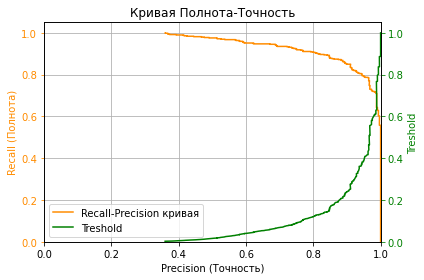

In [84]:
#comment
base64_data = 'iVBORw0KGgoAAAANSUhEUgAAAagAAAEYCAYAAAAJeGK1AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAsTAAALEwEAmpwYAABC50lEQVR4nO3dd3xUVdrA8d+TSUiISSChSAlIEUFEikixR5EVO9iwrLvg+iL2MnZdx3F1m44dYdG1NxYb2AsYUZC6BqQtvYRmCCUJpOe8f9ybZNInyUxmJnm+fuYzM7fNc496npx7zz1HjDEopZRSoSYi2AEopZRS1dEEpZRSKiRpglJKKRWSNEEppZQKSZqglFJKhSRNUEoppUKSJiillFIhSROUKiMiW0TkbK/vXUVkk4j8M5hx1YeIpIhIiYjkVHoVi8j1wY7PH0TkNK/zOiQiptK5dg92jEr5Q2SwA1ChSUQ6AN8BXxlj7g12PPW00xiT7L1ARFKDFIvfGWN+BOIARKQHsBloa4wpCmZcSvmbtqBUFSLSFvgGWAzc7LX8URH5QERmiEi2iPxXRAZ5rS9rgYlInIjsEZGfvNYb+y/+HBHZKCKXe627316WLSKrRWSc17oIEXlJRDLsffMam3BE5P9EZIOI7BOR2SLSpdL6LSKSa/9egYi8bS9PEZH0Stv+JCITvGJ9WES2ishvIvKmiLSx1y23j5dbqZX3oL3+ORHZLiJZIrJMRE5rxPl1sc9rn32e/+e1LtW7Nen9XUQmeP87s5eli0iK/TlaRJ4VkZ3261kRifba9mIRSbPPYaOIjBGRe73OtcSrXFfZ+7wuIo839FxV86UJSlUWB3yJ1bq+zlQdC+tiYCaQBLwLfCIiUdUc5x6gsJrlg4wxccBjwFSv5RuB04A2gBt4W0Q62+t+B4wDBtr73tKQEyslImcBfwOuADoDW4H3K20WAVxg/95f63H4CfbrTKAXVnm+CGCMKT33c7FaeXH2q/T4S4DBlJftTBGJqe/52d4D0oEuwGXAX0VklL2uhIb/v/8QMNKOcxAwHHgYQESGA29i/btvC5wObDHG/LP0XIFtwIX29+MaGINqITRBqcqmAjlAMnBKNeuXGWM+MMYUAk8DMVgVVhkRORL4k72+JpFAZukXY8xMY8xOY0yJMWYGsB6r8gMQ++Vo2ClVcQ3wqjHmv8aYfOAB4CT7clmpVkBBA4/9tDFmkzEmxz72lSJS5+V0Y8zbxphMY0yRMcYDRAN96xuAiHQDTgXuM8bkGWPSgFeAa+1NtgFn+RJTNa4BHjPG/GaMycD6Y6L0uH/CKtdv7X+PO4wxaxvwG0oBmqBUVWuBC4F7gX+LSOtK67eXfjDGlFD+V7q3R4EXgH3VHP+/IpIDTMFqRQEgIn+wLw0dEJEDwACgvb36a+AtYL2IZAHPN+zUynTBajWVnkcOVrLsasciWC2A/TXtXxqnHat3gq5wbPtzJHBkXUGJiFNE1ojIQfu4bbDLQOrXCaILsM8Yk10pjq725yeAnsA++3dOrbT/yErn5/3vt7rzK13fDasl3BB327+3R0Q+EpF2DTyOakY0QanKnrD/6n4Z6y/tv1Ra3630g4hEYLW0dnqtPwY4h5qTyAn2pZ4hwEsi0l1EjgJexrp0184Y0xZYidVqKk2EM4AM+/dva9QZWvEe5XUeRwDtgB32oqOwksqmmvY3xrQtfQELazo20B0oAvbUFpB9v+k+rMuOifZxD1JeBnFer20+nF+SiMRXimOHfaz1xpgRxpgE+3d+qrT/wkrn5/3vt7rzK12/HehdR2w1ecr+rV5ALNZlQtXCaYJStfk/YJJ9b6HUUBG5xL48dAeQT8UK+mGsS0C5dRy7GOsyWlvgCMBgJSBEZCJWCwr7eyTWJao7jTEHG3NCtneBiSIy2L7B/1dgkTFmi12pu4BvjDGHG3Ds94A7RaSniJTev5rhQw+7eKxElgFEisgjQEIDfh9jzHZgAfA3EYkRkYFYl9/eacjxKnkPeFhEOohIe+AR4G173b+xynWU3Vmkq4j0q+fx84DDaN2k0P8IVC2MMZuwKqDXRKSVvXgWMB7r8te1wCX2/ahSmVg3ymuy3L7Elwr81RizwhizGvAAP2O1NI4H5nvtcy+w1RjzYePPCowxc4A/Ax8Cu7D+6r/SXv0CVieFhj4z9SrW5ch5WN2/84Bbfdjva6zOKeuwLpvl4XU5tQGuAnpgtW4+BlzGmG8bcbxSjwNLgRXAr8B/7WUYYxYDE4FnsFp/P1CxtVWb28TqHbkN677mU36IVYU50QkLla9E5FHgaGPM74Mdi1Kq+dMWlFJKqZCkCUoppVRI0kt8SimlQpK2oJRSSoWksBssNiIiwrRuXfnZ0ZappKSEiAj9G6OUlkc5LYtyWhYVHT582BhjwqJAwi5BtWrVikOHDgU7jJCQmppKSkpKsMMIGVoe5bQsymlZVCQidT2jGDLCIosqpZRqeTRBKaWUCkmaoJRSSoUkTVBKKaVCkiYopZRSIUkTlFJKqZAUuG7mHnkVuAD4DacZUM16AZ4DzsMaXn8CTvPfgMWjlFKqTuIur7uNq2rdLe6qdbdxBabuDmQL6nVgTC3rzwX62K9JWFONq5auuBB0+C2lgul1QqTuDlyCcpp5VD/ld6mLgTdxGoPTLATa4pHOAYtHhYcV0+HpCEi9CxY+AZlrgx2RUs3Cpv2b6P5M9zq3My7f6m7jMsa4rLpb3IGpu4M5kkRXKk7Ilm4v21VlS49MwsrUiIkkNTW1CcILfTk5Oc2uLLrtXmHNGb7sGWvB/IfZ2+Zkdrc/l/yo9lW2L4xMIC+6C9A8y6OhtCzKaVlYth/ezvas7RBLpLhlqdeq6cZlptfjUL7X3Y0UzAQl1Syr/tqO00wHpgOYh2KMDltiaZ5DuKRA8YuAgZmjYMdPtD+4gPYHF9S8S5ueENuRrKwsEhLsWdLzs6CkAM56AXqcA9Ky+gM1z/82GkbLwrIucx0sAQ5TZFzmxEYcyve6u5GCmaDSgW5e35OxpqdWLZ0jynq/8kfrftSO+VBwsOp2GStg7btwRGeQCIocJRDd1lq3a5H1/tF5FfcZ+XDV4xQXQt/xEN+1hnhiIDqhQaeiVDPUZHV3MBPUbOAWPPI+MAI4iNP4vYmowpwIJJ9a/bpe58OIB8q+rvD+S7mkCHb8BGvegcjW8MsL1vJFf614DFNivS/5R+1xdDwB4ruBKYZh91ZcF59steKUahlmA7eIu7zuNq7A1N2B7Gb+HpACtMcj6YALsP40dpppwBdY3RQ3YHVVnBiwWFTLExEJ3VKsF8BZz1e/nSmB9R/B4d+qX5+xAlb8C3L3wm92T9pNn1Xdrv3xVjKt7OBm6P9HGPVCfc9AqaAQd3ndLe6KdbdxNW3dHbgE5TRX1bHeADcH7PeV8oVEwDGX1b7N6GnWe+Fh2PlzxXU7foSt30Fsh+r3zVgBaS/Cry9b34vzrfcT77bei/Kse2Qdjq871qh4aJ1U93ZKNYJx1V53G1fT1d1hNx+UUkETFQtHjaq47KhRcPKjNe+zYwGsmwmOaOt72hQozIG0l6zvRYetBOaro8fCoButz60SoPOI6ltuSjUDmqCUCqSuJ1uvUqf/veL67anWZcC67F4Cy6fChk+sV6njJlj3x0Tg6HE1d/RQKgxpglIqmLzvk9VmwEQY+efyZPbry7Dq9fIXwNxb4YpU6HZGICJVqslpglIqXMR1tl5gtcpSni7vhfiS/RDzf1IgKo6BMX0hI7Gag5RYXffPfBY6DGyCoJVqOE1QSoWrGK8EdFcJrH4LfnoAWnfAcTjPur9V2U77gec3B1nd5hsiezskHgPHX18pnnYwYEKLeyhaBY4mKKWaAxE47g/WC/ilptETDu2BhX+BgmwQR8N+a9VrsH8dzLu36roFj8B16yGqdcOOrZQXTVBKtSRHHAmj6tFrsDq/m17eXb7UrkXW0FQ5O+D5WDj//bqP07YXdBrWuFhUs6YJSilVPxGR1stb97PgxgyYaj8P9vmVvh9PHHDSI9bngTdYSVQpNEEppfwltj3cUQAHNtS97Z5lsG2O1QPRFMMCl7V8gQt6nmd1mW8/AJL6VrzXploUTVBKKf9xREG7Y+vert2x0P/3cM6rgLEG7P3sCtg4GzZ/Yb1Kadf5FksTlFIqeEQAgchoGDvLWvbbcji0C356yBr/0O46T0mhde+rw0DoPhoG/p/VwlLNliYopVRo6TgIGATJZ8DSpyB/PyBQlGuNppGxwnot88Dlc2s+TvsBNY+RqMKCJiilVGiKag0n/bnisrPtMQw99viDM8+q/RgJPTgtexe0fQaOHAqdh/s/ThUwmqCUUuHnhh2wf33N69e8bU2RsuETHABzbipfN/QuOOE2iO+uA+2GOE1QSqnwE9fFetXEq1PF/G8/5pQeArPHWQuWPW29AHqMsZJVqbZHQ2KfAASsGkITlFKqWSuMSoQ+KeA0kJ9l9RT8wWlNUrnlK+vlrU0vKDwEh/dY4x3GHgn9rtLWVhBoglJKtRzRCVb39v6/h8Jc2LuifF36j7B7EThirEuEAKl3We89zw3r57GMMazPrOWSaIjSBKWUapmiWlsTPpby/nzeW1Zr68s/wMZZsGM+9L6g6WP0k8/WfcZF718U7DDqTYcdVkqp6kQnQK/zrc+fXAiL/gpbvoaCHCgpCm5s9ZSVnwXArCtnBTmS+tEWlFJK1aQ0QYH14LC3/n+w7ksZY70PudVaHpcccuMJOiKskev7JIVXBxBNUEopVZO4LnBXsTUU055lsHM+rP8YMpZD+g/WNllbrfdVb5Tvd9470O3M8gkmgyzCnqPLYIIcSf1oglJKqdpIhDUUU9eTrdeweyquLzwE21Ot2Y3n3GxN6PjFNVYL66wXrEuFQVaaoEpKZ2AOE3oPSimlGiPqCOtSYO8L4fpN8MeV1vLVb8KLbWDrnODGhyYopZRSEZHQ/ji4eBb0tnvNfXC2NaFjMMMK0wSll/iUUsrfjr7I6pb+QoJ1CfDdkZDUD3pdaK2PjIETbofW7ZokHE1QSimlykkE3JQJmz+H2ZfCvrVWhwpTDMUF1uC1R1/cNKFgjYKhCUoppZQlMhr6XGINs1Rq7fvw+VXWkEpNJFxbUHoPSimlmtK+tdZ79rYm+bmftv3EtR9f2yS/5W+aoJRSqinFd7feP74Afnww4D+3JmMN+/P2c98p9zG40+CA/54/aYJSSqmmdPx1cJ49GG36D9bzUwFUOorEjSfeSCtHq4D+lr9pglJKqaZ27DXWkEg7F8DTDlj5mjWNfXGB33/KIVaCKjbFfj92oGmCUkqpYBg9Ddofb33++jp4cxA8Gw1Z2/36M6UtqOKS8EtQge3F55ExwHOAA3gFp/l7pfVtgLeB7nYsT+E0rwU0JqWUCgW9zrdeGSvgwAaYfRlgYP5DMOJhSDrGLz9T3xaUuCvW28ZVsd4Wd9V627gCU28HrgXlEQcwBTgX6A9chUf6V9rqZmA1TjMISAE8eCS8LpIqpVRjdBhodUW/eiE4omH1W/BaX/j6T9YIFPsbN9FgaQuqyIcpQsRdtd4Wd/X1tnGV19viDky9HchLfMOBDTjNJpymAHgfqPxUmgHi8YgAccA+ILwmWlFKKX/oPBxuOwS97IkRV75qjUDx6jHw1cQGH7asBeXbJb7hwAbjMpuMq/Z6W9yBr7cDeYmvK+B9MTUdGFFpmxeB2cBOIB4YjzPMniRTSil/iXDAuE+tSRF3/AQHN8OcmyB9HuQfhOg29Trc/tz9PLngSQDio+N92aVB9bZxBabeDmSCkmqWVZ6M5BwgDTgL6A18i0d+xGmyKmzlkUnAJAAxkaSmpvo71rCUk5OjZeFFy6OclkW58C2LGOBYBsUNJvFgGrzYlt1Jo1nb0/dnp77Z8w2Ldizizj53sm35NraxDWKJFLcs9dpsunGZ6fbnBtXb4pYfjatSve0HgUxQ6UA3r+/JWBnX20Tg7ziNATbgkc1AP2Bxha2cZjowHcA8FGNSUlICFHJ4SU1NRcuinJZHOS2LcmFfFse9AWvfg8V/p9O+b+kUm291Uwc4chgcOaTGXbcv3w5r4aYxN3F00tHWwsMUGZc5sYZdfK63jcuqt8VdQ73tB4FMUEuAPnikJ7ADuBK4utI224BRwI945EigL7ApgDEppVR46TDQevU8F2acYV3uS59Xvv6sF2DILdXu2oAu5kuAPuL2rd4Wd2Dr7cAlKKcpwiO3AF9jdVd8FadZhUcm2+unAX8BXscjv2I1Le/DafYGLCallApXyafDHfmQa1eRuxbD7HFwsObcUN8u5sZlisRdsd42LrNK3Fa9bVzl9ba4y+tt4wpMvR3Y56Cc5gvgi0rLpnl93gn8LqAxKKVUc+FoBXFdrM+9zrPeoxNr3rwBD+kaV9V6205MpZ+brN7WkSSUUiocFeRY7wseqXb0CWMM6zOtZ6jCcZgj0ASllFLhqXUSHDXa+lxQtQPdVxu+4sG5DyIIneI6NXFw/qEJSimlwlWfS6z3mKqX+XKLcgFYdP0iTVBKKaWaWN5+672a+1ClHSRK70OFI01QSikVrvL2We+Hd1dZFRlh9YHzZQy+UKUJSimlwlVkjPU+p+pzUOE8zUYpTVBKKRWuTnoUIltb3c8rKW1BhWsPPtAEpZRS4SvCATFJtd6D0kt8SimlgiNvP+xdAQufgMLcssVlLagwvsQX2JEklFJKBVZSP8hYDnuWQWxHGPh/QP0mKgxVmqCUUiqcXbsMts2FmaPg20nWvFHdzmgW96B8S1AeiQAGAV2AXGAVTrMngHEppZTyVbczYehdsOxpmHcPAJF2Xmq+LSiP9AbuA84G1gMZWLNoHYNHDgP/At7QWXCVUiqIRCDFAyMehN1L4LPxOHKt4Y+KS8fsC0N1taAeB6YCN9iTCpbzSEeseUKuBd4ISHRKKaV817od9BwDtx4k8uU+kLuBog0fw/GVp3QKD7UnKKe5qpZ1vwHP+jccpZRS/uAY8wa8egrFxYXBDqXBfO8k4ZEBQH+sS3wWp3nT/yEppZRqrMjW7QAokvDtC+drJwkXkIKVoL4AzgV+AjRBKaVUCHLYvfeKpfkPFnsZ1hz0u3GaiVg9+qIDFpVSSqlGibQTVFFE+I7H4GvkuXZPvSI8kgD8BvQKXFhKKaUao7wFFb4JyteLk0vxSFvgZWAZkAMsDlRQSimlGqesBRXGI9r5lqCc5ib70zQ88hWQgNOsCFhUSimlGsVRbD2gG84tKN8i98hnZZ+dZosmJ6WUCm2RxkpQRUiQI2k4X1Nrl4BGoZRSyq8cprQFFb69+Hy9B9ULj8yustRpLvJvOEoppfwhsuwSX/i2oHxNUBmAJ5CBKKWU8h9HM7jE52uCysFpfghoJEoppfzGUWINcVQcxgnK13tQfwtoFEoppfwqoqQQAYqytkGlsb7Dha8tqE/wyG3A6fb3H4BpOE34jkKolFLNWdQRRALFW76G/esgqW+wI6o3XxPUS0CU/Q7WFBtTgesDEZRSSqlGOmo0johIiiiCMJ200NcENQynGeT1fS4eWR6IgJRSSjXeR2s/Jq+kiKRIYPv30K6/NbFhGPH1HlSxPbuuxSO9gPCd6F4ppZq5B+Y8wODEXtweBcy9Ffb9L9gh1ZuvLah7gO/xyCZAgKOAiQGLSimlVKPkFeVxcs+ziOkyGebdCyXh12XA17H45uCRPkBfrAS1FqfJD2RgSimlGs4hDopLiiG+m7UgIvwmLvR1wsI/VFoyCI/UPaOuR8YAzwEO4BWc5u/VbJOCNXV8FLAXpznDp5iUUkpV619L/8XmA5sZmTyyvINERJRP+4q7Yr1tXFXrbXFLCl71tnEFpt72vZOE5QrgP/ZnQ20z6nrEAUwBRgPpwBI8MhunWe21TVusnoFjcJpteKRjfYJXSilV0QerP2Dy55MBuGrAVVC411rhQwtK3FXrbXHLbOMqr7fFXV5vG5fZJu7q621xy121/ZZxmafrisfXS3y3AuCRU8s+1204sAGn2WTv+z5wMbDaa5urgY9wmm327/zm47GVUkpVYozh8XmPA/DuJe9yYd8LYcXL1spPL4dLvqzrEMOBDcZl1dvirrneNi6r3jauGuvtePu9L1Yjp3Q81wuBeb6cT30vStbnceSuwHav7+nAiErbHANE4ZFUrJN5rtrLhh6ZBEwCEBNJampqPcJovnJycrQsvGh5lNOyKNeSyuL7375n+Z7l3HPMPXTO7Exqaiox+XH0jR9C4p6lLPv+PxBLpLhlqddu043LTLc/+1xvi7u83jauqvW2cRk3gLjlG+AE4zLZ9vdHgZm+nI+v96BewEpOyXjk+bLlTnNbLXtV1+G+coKLBIYCo4DWwM94ZCFOs67CVk4zHZgOYB6KMSkpKT6F3dylpqaiZVFOy6OclkW5llIWeUV5TJwykYFHDuRv4/+GI8Jrmo2N8fDJhQwdOgwOU2Rc5sQaDtOgelvcstC4KtXb5boDBV7fC4AedZ9RfaZ8tyzzcXuwMm83r+/JwM5qttmL0xwCDuGRecAgoKYTVUopVY13f32XLQe28M3vv6mYnABMifVe99xQPtfbxmXV2+Kus95+C1gsbvkYK9mNo7b+C158vQf1hk/bVbQE6INHegI7gCuxrl16mwW8iEcigVZYTclnGvBbSinVYhlj+GL9FwCMSK58RQ4w9rgKdU//vgToI+66621x+1ZvG5d5QtzyJXCavWiicZlf6goEfL/El03FZp4ABqdJqHEfpynCI7cAX2N1V3wVp1mFRybb66fhNGvwyFfACqAEqyv6Sp9iUkopBcCczXP4cM2HAERW11vPxxaUcZkicVest43LrBK3VW8bl5lmXGaNuCvW28ZVtd4WtyR5fd1iv8rWGZfZV9d5+XqJbwNOM8THbcs5zRfAF5WWTav0/UngyXofWymlFAC5hbkAfHTFR8RGxVbdoLQFVfnSXzWMq2q9bVwV623j8qneXobVsKnpvlavumLxNUHF4JFBQD6wC6c56ON+SimlAqy01dQ5vnP1G5S2oHwefrXxjMv0bOwxfE1Qu4EXsHpsdMEj+4CJOM3S2ndTSikVaFEOa5SIwuIaxtsrTVA+tKACQdxyEeXzCaYal/nMl/187SRxZoXvHjkVmAbU1FVRKaVUE9iRtYMpS6YAENcqrvqNSi/xrZhe/foAErf8HetB3XfsRbeLW04xLvNAXfs2bPRAp/mprLODUkqpoBn8r8EcyDvAk6OfZHCnwdVvlNATHNGw9Kkmjc12HjDYuKxmnLjlDeAXwE8JyiNtgEexmmgGa8r3xxoWq1JKKX85kHeAu0bexd0n313zRsmnwh9WwGtBm/a9LVDaa6+Nrzv52oJ6FVgJXG5/vxZ4DbjE1x9SSinlf60crSg2IT1/7N+AX8Qt32P16DsdH1pP4HuC6o3TXOr13Y1H0uoVolJKKb+LdkSTXxS60/MZl3nPHrdvGFaCus+4zG5f9vW1z2Gu3THC4pFTgNx6xqmUUsrPoiOjKSguqHvD4IoA9gL7gWPELafXsT3gewvqRuAN+16UYF1LnNCAIJVSSvlRK0cr8otDtwUlbvkHMB5YhTXyBFh9GeqccsPXbuZpWLPoJtjfsxoQp1JKKT+LdkSHdIICxgJ9jcvUO8jaE5SnhhkRPfbIFc66Z0RUSikVOGFwiW8T1tTwfk5QcA8wlerHUlJKKRVkrRytQrKThLjL5hE8DKSJW+bglaSMq9b5BIG6E9RunEafd1JKqRC0P3c//931X87udXawQ6mO9zyCs2vbsCZ1Jaj6TPGulFKqCf1l3l+AWoY4CiLjqjqPoLglEehmXGaFL8do2FBHSimlgq50cNh3Lnmnji2Dx34G6iKsfJMGZIhbfjAuU30fBy91Jah+eKS6TFc6YeHAesaqlFLKT6IcUcS1iqt+DqjQ0ca4TJa45XrgNeMyLnFXm1eqqCtBHdv42JRSSgVCK0erUO/BBxApbukMXAE8VK8d61i/Daep/T6UR6TObZRSSvldtMPqYm6MQSRkO1s/hjWF/HzjMkvELb2A9b7sWFeC+h6PfAjMwmm2lS31SCvgVOCPwPfA6w0IWimlVCO0jmoNQF5RXtnnUGNcZiYw0+v7JuDSmvcoV1eCGgNcB7yHR3oCB4AYwAF8AzxjjzKhlFKqiZXeezpceDhkE5S45Ris52mPNC4zQNwyELjIuMzjde1be4JymjzgJeAlPBIFtAdycZoDjY5aKaVUo3gnqHa0C3I0NXoZa9CHfwEYl1khbnkXaGSC8uY0hcCuBgaolFLKz7wTVAiLNS6zWNwV7pEV+bKjr9NtKKWUCiG5hblc89E1ABSWFAY5mlrtFbf0xh74QdxyGT42dvRBXaWUCkM5BTkA9Gvfj77tgjaVuy9uBqYD/cQtO4DNwDW+7KgJSimlwlDp5b3rBl9HlCMqyNFUT9ziAG40LnO2uOUIIMK4TLav+9c13UY21Y/HVzqSREJ9glVKKeUfpb32cotCc3JzcUukcZkicctQAOMyh+p7jLp68cU3MDallFIBFCERtHK0IrcwNBMUsBg4AfhF3DIb61mosiRlXOajug5QVwsqqdb1TrPPlyiVUkr5V1FJEQ5xkFeUF+xQ6pIEZAJnYV2RE/u9kQnKmsej9ICVGaBXvcJUSinlFx+u/pDcolzO6HFGsEOpSUdxy13ASqrmEZ+Gx6vrEl/PBoemlFIqYGasmkG3hG5c1PeiYIdSEwcQR80NnDr53ovPI4lAH6yhjixOM8/n/ZVSSvlNUUkR7WLbESEh+zjrLuNq3IzsviUoj1wP3A4kY004NRL4GeuaolJKqSaWX5xPcUlxsMOoTaOHV/c19d4ODAO24jRnAkOAjMb+uFJKqfopMSXc+dWdfLPxGyIjQvpR1lGNPYCvCSrPHjgWPBKN06wF6n502SNj8Mj/8MgGPHJ/LdsNwyPFeOQyH+NRSqkWJ213Gld9eBXPLnqWPw76I1PPn+r33xC3jBG3/E/cskHcNdfb4pZh4pZie+iiKoyr8b28fU2/6XikLfAJ8C0e2Q/srHUPjziAKcBoIB1Ygkdm4zSrq9nuH1gTWimllKpGiSnh3HfOZXfObh5LeYyHT3/Y75MU2iM/VKi3xS2zjativW1vF/B627cE5TTj7E+P4pHvgTbAV3XsNRzYgNNsAsAj7wMXA6srbXcr8CHWJUSllFLVWL57ObtzdjPt/GnccOINgfqZ4cAGe1JBxB3cetvXThIjgVU4TTZO8wMeice6D7Wolr26Atu9vqcDIyodtyswDquzRc0n6pFJwCQAMZGkpqb6FHZzl5OTo2XhRcujnJZFueZSFu9tew+A9pntG3Q+rfO2WxVwLJHilqVeq6Ybl5luf66z3ha3j/W2H/h6iW8q1pAVpQ5Vs6wyX/q+Pwvch9MU46mlqeo007FGw8U8FGNSUlLqDLglSE1NRcuinJZHOS2Lcs2hLIwxPPef50hqncSl5/g0W3pV+9bBKuAwRcZlTqxhK5/rbeMyxZXmePI7XztJCE5THqTTlFB3cksHunl9T6bqfasTgffxyBbgMqyZe8f6GJNSSrUIC9MX8snaT7jwmAsD/VM+19viLq+3xR2YetvXFtQmPHIbVqsJ4CZgUx37LAH64JGewA7gSuDqClt4j1ThkdeBz3CaT3yMSSmlmr33V77PI98/AsANQwN276nUEqCPuGuut42rvN4Wt1VvG1dg6m1fW1CTgZOxAi69Jjmp1j2cpgi4BauXxxrgPzjNKjwyGY9MbnDESinVgryw+AXW71uPO8XNsK6B7UtmXFXrbeMyq8Qtk8Xd9PW2r734fsPKpPXjNF8AX1RaNq2GbSfU+/hKKdWM7czeyYLtCxjSaQiPnPFIk/ymcVWtt42r+nrbuAJbb/vWgvLIMXhkDh5ZaX8fiEceDmRgSinV0s3dPBeAQZ0GBTmS4PD1Et/LwANAIQBOs4KGtKiUUkrVaWf2Tp7++WmeWfgMAA+e+mCQIwoOXxNULE6zuNKyIn8Ho5RSCp7++Wmc3zhZn7mee06+h6OTjg52SEHhay++vXikN6X94a0x83YFKiillGrpYqNiOXj/Qb8PZxROfE1QN2M9KNsPj+wANgPXBCwqpZRqwQqKCzDGtOjkBL734tsEnI1HjsC6LJgLjAe2Bi40pZRqmb7d9C0ndzs52GEEXe0JyiMJWK2nrsAs4Dv7+93AcuCdAMenlFItSuqWVNbuXctNJ94U7FCCrq4W1FvAfqzZc/8PuBdoBYzFadICG5pSSrU84z8YT4+2PbhygHaUritB9cJpjgfAI68Ae4HuOE12oANTSqmWZs6mOfx26DduG34bHY7oEOxwgq6ubuaFZZ+cphjYrMlJKaX879uN33L2W2cDtNhu5ZXV1YIahEey7M8CtLa/C2BwmoSARqeUUi3E4cLDACy4bgEndTspyNGEhtoTlNM4migOpZRq0fbn7Qcgvzg/yJGEDl9HklBKKRUgJaaEO7++E4Au8V2CHE3o0ASllFJB9sKiFziQd4CXL3yZY9odE+xwQoYmKKWUCqLMw5k8Nu8xRvcazZ+G/CnY4YQUTVBKKRUkxhhO+vdJHMw7yD/O/keLH9qoMk1QSikVBPty93Haa6exft96Jg6eyJDOQ4IdUsjxdbBYpZRSfnTaa6exOmM15/c5n3+M/kewwwlJmqCUUqqJ5RflszpjNQM6DuCzqz8LdjghSy/xKaVUE1qfuZ4BUwcAcGKXE4McTWjTBKWUUk1oypIpbNi3geuHXM/U86cGO5yQppf4lFKqCSXGJALw0vkvEeWICnI0oU1bUEop1YSOjDsSgIzDGUGOJPRpglJKqSbU8YiOAOzJ2RPkSEKfJiillGoixhhW/rYSgN05u4McTejTBKWUUk3kyQVP4kp10TW+q4655wPtJKGUUgGWW5jL1KVTue+7+xjRdQTfXvst8dHxwQ4r5GmCUkqpAFqXuY6+L/YFoF/7fjx/7vOanHykl/iUUipAPlv3Gf1e7AfAU6OfYs3NaxjedXiQowof2oJSSqkAuefbezAY5v5hLmf2PDPY4YQdbUEppVQApO1OY+3etZzW/TRNTg2kCUoppfwsKz+Lp39+GoBLj700yNGEL73Ep5RSflRUUsRJ/z6J1Rmr6ZXYi0uOvSTYIYWtwCYoj4wBngMcwCs4zd8rrb8GuM/+lgPciNMsD2hMSikVIJv2b2LGyhmszljN73r/js+v/pzIiPBqB4i7Yr1tXBXrbXFXrbeNKzD1duAu8XnEAUwBzgX6A1fhkf6VttoMnIHTDAT+AkwPWDxKKRVAG/dtpPfzvXlw7oN0b9OdPw76Yzgmpyr1trirr7eNK/D1diBLbziwAafZBIBH3gcuBlaXbeE0C7y2XwgkBzAepZQKiHlb53HhexeSGJPItAumccVxVwQ7pIYaDmwwLqveFnfVetu4mq7eDmSC6gps9/qeDoyoZfs/AV9Wu8Yjk4BJAGIiSU1N9U+EYS4nJ0fLwouWRzkti3KBLouNORu5a/ldJEQl8Phxj9Mxo2NIln3rvO1WBRxLpLhlqdeq6cZlSltB/qu3/SCQCUqqWWaq3dIjZ2Kd6KnVrnea6djNSPNQjElJSfFLgOEuNTUVLYtyWh7ltCzKBaosFqUvYt7WebiWu8gtymXxDYvp276v33/Hb/atg1XAYYqMy9Q0la/P9ba466i3/SCQCSod6Ob1PRnYWWUrjwwEXgHOxWkyAxiPUkr5xd3f3I3nZw8AneI6Mem4SaGdnHznU70t7vJ627gCV28HMkEtAfrgkZ7ADuBK4OoKW3ikO/ARcC1Osy6AsSillF+8s+IdPD97mDx0Mo+f9TjtYtsFOyR/WgL0EXfN9ba4y+tt4wpsvR24BOU0RXjkFuBrrO6Kr+I0q/DIZHv9NOARoB3wEh4BKMJZY9OzRoWFhaSnp5OXl+e38MNBmzZtWLNmTbDDCBmBLI+YmBiSk5OJitIpulsiYwwfrfmIv/30N5btWkZ8q3heOO+FsOulVxfjMkXirlhvG5dZJW6r3jauivW2uK16u5ZLho0ixlR/WyhUxcTEmMqJaPPmzcTHx9OuXTtEqruE2jxlZ2cTH6+jIpcKVHkYY8jMzCQ7O5uePXv6/fiBoPegyjW2LEpMCRe8ewFfbrD6Alw54Er+fPqf6d+hcu/rELdvHbzWF7mbw8aYI4Idji+aRfrPy8ujR48eLSo5qaYjIrRr146MjIxgh6KC4LmFz/Hlhi+ZPHQyT/7uSeJaxQU7pBajWSQoQJOTCij976tlyjycyV3f3MXQzkOZcv4UIkSHL21KWtpKKVWDuZvnAjC863BNTkGgJe4nDoeDwYMHM2DAAC688EIOHDjg1+P36NGDvXv3AhAXV/0lhkcffZSuXbuWxTF79uxG/+7OnTu57LLLat3m5JNPbvTvKBWKPl33KQBn9tDpMoJBE5SftG7dmrS0NFauXElSUhJTpkwJShx33nknaWlpzJw5k+uuu46SkpIK64uKiup1vC5duvDBBx/Uus2CBQtqXa9UONq8fzNvrXgLgFO7B+xZVFWLZnMPqsz3d8Bvaf49ZsfBcOazPm9+0kknsWLFCgA2btzIzTffTEZGBrGxsbz88sv069ePPXv2MHnyZDZtsoYqnDp1KieffDJjx45l+/bt5OXlcfvttzNp0qQGhXzssccSGRnJ3r17ueKKKzj55JOZP38+F110ESkpKdx1113k5OTQvn17Xn/9dTp37syGDRuYPHkyGRkZOBwOZs6cicPh4IILLmDlypWsWrWKiRMnUlBQQElJCR9++CF9+vQhLi6OnJwcjDHce++9fPnll4gIDz/8MOPHjyc1NZVHH32U9u3bs3LlSoYOHcrbb79d5b5OSkoKTz31FEOGDGHcuHGMGzeOiRMnkpKSwuDBg1m8eDFZWVm8+uqrDB8+nEcffZS4uDjuvvtu5syZw9lnn82SJUs48cQTcTgcHH/88eTk5DBs2DDeffddRKTG8v33v//Nk08+SUxMDJs3b2bWrFnaC66FySnI4fF5j7Pt4DbeW/keABESwdh+Y5vbs05ho/klqCArLi5mzpw5/OlPfwJg0qRJTJs2jT59+rBo0SJuuukm5s6dy2233cYZZ5zBxx9/THFxMTk5OQC8+uqrJCUlkZuby7Bhw7j00ktp167+/3MsWrSIiIgIOnToAMCBAwf44YcfKCws5IwzzmDWrFl06NCBGTNm8NBDD/Hqq69yzTXXcP/99zNu3Djy8vIoKSnht99+KzvmtGnTuP3227nmmmsoKCiguLi4wm9+9NFHpKWlsXz5cvbu3cuwYcM4/fTTAfjll19YtWoVXbp04ZRTTmH+/Pmcemr1f5XecMMNjBw5kokTJ5YtO3ToEAsWLGDevHlcd911rFy5ssI+brebXr16lX0vbdHm5ubSs2dPDhw4QGJiYo3le//997Nq1So6duzIBRdcUO/yVuHrQN4B0nancdYbZ2Ew9E7sDcDI5JF8cPkHdE3oGuQIW67ml6Dq0dLxp9zcXAYPHsyWLVsYOnQoo0ePJicnhwULFnD55ZeXbZefnw/A3LlzefPNNwHr/lWbNm0AeP755/n4448B2L59O+vXr69XgnrmmWd4++23iY+PZ8aMGWWtlPHjxwPwv//9j5UrVzJ69GjASqidO3cmOzubHTt2MG7cOMB6MLWyk046iSeeeIL09HQuueQS+vTpU2H9Tz/9xFVXXYXD4eDII4/kjDPOYMmSJSQkJDB8+HCSk61Bj0vLqboE9eijj7J48WK2b99eYflVV10FwOmnn05WVlaFe3wffvghw4YNw/uZvtJ/H+np6YwdO5bExESg5vKNiIggOzubjh07+ljSKpztyNrBz+k/869l/+K7Td8BEBsVy90n3Y37THeQo1Olml+CCpLSv9gPHjzIBRdcwJQpU5gwYQJt27YlLS3Np2Okpqby3Xff8fPPPxMbG0tKSkqto2M89thjfPvttwBlv3HnnXdy9913V9n2iCOs5/KMMRx33HH8/PPPFdZnZWXVGd/VV1/NiBEj+PzzzznnnHN45ZVXOOuss8rW1/bQd3R0dNlnh8NR472w6OhobrjhBp544gkee+yxsuWVLweWfi8uLuaf//wnn3/+eVlyhfJ/H0VFRYwePZoFCxZQUFBQY/mWXmLt0KED27dvr7YMVfgqKC7Anerm203fsn7feg7kHShbd/dJd3NK91M4u9fZ+oxTiNFOEn7Wpk0bnn/+eZ566ilat25Nz549mTlzJmBV4MuXWxNPjho1iqlTpwJWJZuVlcXBgwdJTEwkNjaWtWvXsnDhwlp/65FHHiEtLc3nBAjQt29fMjIyyhJUYWEhq1atIiEhgeTkZD755BPAaukdPny4wr6bNm2iV69e3HbbbVx00UVl99lKnX766cyYMYPi4mIyMjKYN28ew4cP9zk2gAceeIA///nPzJ49m1WrVpUtnzFjBmC10tq0aVPW4nz77bc5//zzad++fbXHi4yMJDY2lr1799Zavl26dGHQoEEsX76c0047rV4xq9BVXFLM/L3ziX48mr/+9FeW7FzC+OPGc36f83lz7JtsuX0LT/7uScb2G6vJKQRpCyoAhgwZwqBBg3j//fd55513uPHGG3n88ccpLCzkyiuvZNCgQTz33HNMmjSJf//73zgcDqZOncqYMWOYNm0aAwcOpG/fvowcOdLvsbVq1YoPPviA2267jYMHD1JUVMQdd9zBcccdx1tvvcUNN9zAI488QlRUFDNnziQiovxvmBkzZvD2228TFRVFp06deOSRRyoce9y4cfz8888MGjQIEeGf//wnnTp1Yu3atfWOccqUKUyaNIkff/wRgMTERE4++eSyThKl9uzZw5133lnlGKWX+AoLCznuuOMYM2YMxphqyzczM5PbbruN2bNn43A46hWrCj15RXnM2zqPL9d/ybOLngUgqXUSfxz0R/5y5l84olVYjPKjaCZj8a1Zs4Zjjz02SBEFT0sZi6+0d9+JJ9Y+HmWgyyOc/jtrSWPxFZcUsz1rO8t3L+ftX9/m83Wfk1uUS7QjmkGdBtE/sj//uvZftHK0CnaowaVj8SmlVOAZY0jdksoHqz/gzRVvklNg9YJtH9ueiYMncv4x55PSI4XYqFhSU1M1OYUpTVAq5IXi9NkqePKL8ol5wuplGiERXHHcFZzV4yx6J/XmtO6nEeXQKVGaC01QSqmwsWD7AibOKn8+LvuBbGKjYoMYkQokTVBKqZCVX5TPL7t/YWH6Qj5b9xlzNs8B4NOrPuX8PufrKPPNnCYopVTIyS/K58E5D/L0wqfLlvVJ6sNp3U/jydFPMiJ5RBCjU01FE5RSKiTkF+Uz63+zeGjuQ2w9sJXCkkIArh9yPfefej+9Entpi6mF0QTlB5mZmYwaNQqA3bt343A4ysbAW7x4Ma1a1a8H0euvv87SpUt58cUXfd6nR48eLF26tMoDq94DqioVKowx7Dm0h9d+eY1dObvYlbOLD1aXj5of1yqOdy56h9G9R9M2pm3wAlVBpQnKD9q1a1c2mkN1CaGoqIjISC1q1bJlHMrgvZXvMX/7fL7d+C378/aXrSvtBj6q5yjeGPuGDtCqgGaYoO746g7Sdqf59ZiDOw3m2THP1mufCRMmkJSUxC+//MIJJ5zATTfdVO20GzNnzsTtdpcNGDtv3jzAmihwzJgxbNy4kXHjxvHPf/4TgPfee4+//vWvGGMYPXo0zzzzTJXffuKJJ3jzzTfp1q0bHTp0YOjQoY0uA6V8ZYxhy4EtbD6wmV/3/Mrew3tZvXc132z8hpyCHNq1bselx17KwCMHcmyHYxnedTgJ0QnBDluFoGaXoELJunXr+O6773A4HIwaNaraaTcee+wxvv76a7p27VphhO60tDR++eUXoqOj6du3L7feeisOh4P77ruPZcuWkZiYyKhRo/jkk08YO3Zs2X7Lli3j/fff55dffqGoqIgTTjhBE5QKqKKSIhbvWMyby99kZ/ZOFqYvJONwRtn6CImge5vuXNH/Cq4/4XpGJo/Ue0nKJ80uQdW3pRNIl19+OQ6Ho9ZpN0455RQmTJjAFVdcwSWXXFK2ftSoUWUDovbv35+tW7eSmZlJSkpK2f2tK664gnnz5lVIUD/++CPjxo0jNtZ6NuSiiy4K9GmqFqS4pJhZ/5vF+sz1rNm7hrTdaazZu4aC4gIAOsR24Lw+5zEyeSR92/Xl6KSjSU5I1oSkGqTZJahQUjrFRUlJSY3TbkybNo1Fixbx+eefM3jw4LJtqpuewtdxE7UyUI2RW5jLwfyDHMg7wOqM1SzZsYRtWdvYemAr6zLXlbWOOh7RkaGdh3JO73Po36E/Q7sMZUDHAUGOXjUnmqCaQEJCQtm0G5dffjnGGFasWMGgQYPYuHEjI0aMYMSIEXz66adVJurzNmLECG6//Xb27t1LYmIiH3zwAXfccUeFbU4//XQmTJjA/fffT1FREZ9++ik33HBDgM9QhaODeQfZsG8Dy/csZ8WeFWzcv5GN+zaydu9aDOV/DEVGRJKckEz3Nt055+hz6JPUh3H9xjGg4wD9Y0gFlCaoJlLTtBv33HMP69evxxjDqFGjGDRoUI3zO3Xu3Jm//e1vnHnmmRhjOPvss7n44osrbHPCCScwfvx4Bg8ezFFHHaVzGynA6riw9/Beftr2E7d8eQu5hbkVetHFRsVydNLRHNPuGC7vfzmd4jqREJ1Aj7Y9GNZ1mA62qoJCp9sIYy1lug1ftfTpNvKL8pm7eS7ZBdnMT5tPVIcoNu3fxMb9G9m0f1PZiN+l/nLmXzi2/bEMPHIgvZN6EyHNc/7SljT1SK10ug2lVFPILczlP6v+Q3pWOsv3LGflbytZs3dNhW1itsTQK7EXvRJ7kXJUCr2TetMrsRd9kvrQt33fIEWulO80QSkVwg4VHGJ71nZ2ZO1g6c6lLN+znA37NrBk55KybXq27cmgToMY128cew/v5cZhN7J5xWYuHn1xs20VqZah2SQoY4zesFUBE6hL4cYYNu3fxLrMdezI3sHO7J2kZ6WTnpXOxv0bWZe5rsL2Pdr2oE9SH2468Sb2HNrDyxe+TGLrxCrHPbD2gCYnFfaaRYKKiYkhMzOTdu3aaZJSfmeMITMzk5iYmAYfo7ikmF05u1iUvogtB7aw9eBWth7cyvLdy9l6cGuFbY884ki6JnSlf4f+/P7439MrsRed4zszoOMAOh7RsbGno1TYaBYJKjk5mfT0dDIyMureuBnJy8trVKXZ3ASyPGJiYkhOTq6yvLikmIzDGezO2c3unN3syt5V9nl/3n7eWvEWAA5xUGyKy/ZLiE7gqDZHcWKXE7n3lHsZ3GkwyQnJdIrrpD3mlLI1iwQVFRVFz549gx1Gk0tNTWXIkCHBDiNk+KM8CooL2J+7n325+8jKz2Lv4b1k5mZyIOsA+7fuZ8+hPWWX4HZm7yTjcAYlpqTKceJbxdMuth0AR0Qdwe0jbqdLfBdO6HwCx3Y4VkfoVsoHgU1QHhkDPAc4gFdwmr9XWi/2+vOAw8AEnOa/AY1JNTvGGA4XHiYzP5P1mevJKcghKz+LrPws9uftJ+NQBtkF2WTnZ5NdkM3B/INk5WeRU5BDTkEO2fnZ1ntBNocLD9f6W+1atyM5IZnkhGSGdh5K5/jOdIrrRKe4TnSOsz4fGXekTkOuwpa4K9bbxlWx3hZ31XrbuAJTbwcuQXnEAUwBRgPpwBI8MhunWe211blAH/s1Aphqv6sW6sPVH5K2O4384nzyi/Ktd6/PhwoOkV2QXSEJHcw7WH75bGHNx46NiiW+VTxtYtrQJroNca3i6JbQjbhWccS3iieuVRyJrRNJap1EYkwibWLakNQ6ifax7cu+R0Y0i4sOSlVL3FXrbXHLbOMKTr0dyP/bhgMbcJpNAHjkfeBiwPtELwbexGkMsBCPtMUjnXGaXQGMS4WwD9d8yPsr3yc6MppoR3SV99ioWOKj4+kQ24H46HjaRFvJJiE6gd3bdjN0wFCOiDqCNjHWsrYxbekQ24G4VnE4IhzBPj2lQt1wYINxWfW2uGuut43LqrfFLW3FLZ2Ny//1diATVFfAe2C5dKpm2eq26QpUPFGPTAImAeTng4jUfh2m5YgEioIdRCDk2f/UU7MtjwbQsiinZeHNQay4ZanXkunGZabbn/1Xb/tBIBNUdf29Kz9M4ss24DTTAasA75alxpgTGxtccyCiZeFNy6OclkU5LYuKRGSpcdVYHv6rt/0gkE/ypQPdvL4nAzsbsI1SSqmmEVL1diBbUEuAPnikJ7ADuBK4utI2s4Fb7PtTI4CDev9JKaWCZgnQR9x119v2/akRwMFA3H+CQLagnKYIuAX4GlgD/AenWYVHJuORyfZWXwCbgA3Ay8BNPhx5et2btBhaFhVpeZTTsiinZVFRjeVhXFXrbeMyq8Qtk8XdqHq7QcJuug2llFItg44mqZRSKiRpglJKKRWSQjZBicgYEfmfiGwQkfurWS8i8ry9foWInBCMOJuCD2VxjV0GK0RkgYgMCkacTaGusvDabpiIFIvIZU0ZX1PzpTxEJEVE0kRklYj80NQxNhUf/j9pIyKfishyuywmBiPOpiAir4rIbyKysob14VF/GmNC7oU1BtRGoBfQClgO9K+0zXnAl1h98kcCi4IddxDL4mQg0f58bksuC6/t5mLdzL0s2HEH+b+NtlijAHS3v3cMdtxBLIsHgX/YnzsA+4BWwY49QOVxOnACsLKG9WFRf4ZqC8oabsOYTcaYAqB0uA1v1nAbloVAWxHp3NSBNoE6y8IYs8AYs9/+uhDruYTmyJf/LgBuBT4EfmvK4ILAl/K4GvjIGLMNwBjTXMvEl7IwQLxYk8bFYSWoZjnChDFmHtb51SQs6s9QTVA1DaVR322ag/qe55+w/jJqjuosCxHpCowDpjVhXMHiy38bxwCJIpIqIstE5A9NFl3T8qUsXgSOxXqo9FfgdmOqmSulZQiL+jNUh2YOqeE2gszn8xSRM7ES1KkBjSh4fCmLZ4H7jDHFLWB2ZV/KIxIYCowCWgM/i8hCY8y6KnuGN1/K4hwgDTgL6A18KyI/GmOyAhxbKAqL+jNUE1RIDbcRZD6dp4gMBF4BzjXGZDZRbE3Nl7I4EXjfTk7tgfNEpMgY80mTRNi0fP3/ZK8x5hBwSETmAYOA5pagfCmLicDfjXUTZoOIbAb6AYubJsSQEhb1Z6he4rOG2xDpKSKtsIbbmF1pm9nAH+zeKCOBg8Y0y2GS6iwLEekOfARc2wz/MvZWZ1kYY3oaY3oYY3oAHwA3NdPkBL79fzILOE1EIkUkFmtomjVNHGdT8KUstmG1JBGRI4G+WCMitERhUX+GZAvKGFMkIqXDbTiAV40xq0SsoTaMMdOwemidhzXcxmGsv46aHR/L4hGgHfCS3XIoMs1w9GYfy6LF8KU8jDFrROQrYAVQArxijKm263E48/G/jb8Ar4vIr1iXuO4zxuwNWtABJCLvASlAexFJB1xAFIRX/alDHSmllApJoXqJTymlVAunCUoppVRI0gSllFIqJGmCUkopFZI0QSmllApJmqBUSLBHHk8TkZUiMtN+Zqexx3xMRM6uZf1kfw39IyKdReQzETnHPo80EcmxR9dOE5E3/fE7TUFEbmnOI32r8KHdzFVIEJEcY0yc/fkdYJkx5mmv9Q5jTHHQAqyDiDwJ/GSMmeW1LBW42xizNGiBNYD9x8F8Y8yQYMeiWjZtQalQ9CNwtD2P0fci8i7wq4g4RORJEVliz2FzQ+kOInKviPxqz/Xzd3vZ62LPByUifxeR1fZ+T9nLHhWRu+3Pg0Vkob3+YxFJtJenisg/RGSxiKwTkdNqiPlS4KvaTkpEYkTkNTvOX+yxEyvH0UPsOXxEZIKIvOi1/4siMsH+PMo+xq9izf0TbS8fJtacYMvtmOPtMqzcorvI+3e9GWMOA1tEZHhd/6KUCqSQHElCtVwiEok1p1VpZT8cGGCM2Swik7CGZBlmV8jzReQbrPHUxgIjjDGHRSSp0jGTsEY472eMMSLStpqffhO41Rjzg4g8hvXk/R32ukhjzHAROc9eXuGyoYj0BPYbY/LrOL2bAYwxx4tIP+AbETkGa4QHn0e2FZEY4HVglDFmnX358EYReQmYAYw3xiwRkQQg1xhTmghT8WrRSe2T1C0FTqNljlOnQoS2oFSoaC0iaVgV4zbg3/byxcaYzfbn32GNH5YGLMIa3qkPVsJ4zf7LH2NM5XlwsoA84BURuQRraJcyItIGaGuMKZ1t9g2sCd9KfWS/LwN6VBN7ZyDDh3M8FXjLjnEtsBVrOox0oKbLaeNL72kB4+1lfYHNXuMulsbbF9hljFli/0aWMaau+Y7utI8/X6wx2Ur9BnTx4ZyUChhtQalQkWuMGey9QKxxBQ95L8Jq5Xxdabsx1DJVgD1O23CsgUKvBG7BmnLBV6Uto2Kq/38mF4jx4Tg1tZJmABfal/YisFpUZeuMMbeAdYmvjuMI9Z8y4RljzFN2Z5KnsWZnBut8cut5LKX8SltQKpx8jXUpKwpARI4RkSOAb4DrSnv+VXOJLw5oY4z5Auuy3WDv9caYg8B+r/tL1wI/4Lt1VN+yqmwecE1p7EB34H/GmEPGmHHGmAFYA3jWZS3QQ0SOrhTvWqCLiAyzfyPevmTqi0ysqdJLHQM0u0FlVXjRFpQKJ69gJYL/itW8ygDGGmO+EpHBwFIRKcAaqflBr/3igVn2vRsB7qzm2H8EptlJbhP1GN3ZGHNIRDaKyNHGmA21bPqS/Ru/Yk01PsGH+1bV/V6e3Q18pp2AlgDTjDEFIjIeeEFEWmO1gM4Gcmo53M0iMhaIBR7wWn4K4K5vbEr5k3YzV8oPRGQcMNQY83CwY2ksERkC3GWMuTbYsaiWTVtQSvmBMeZjEWkX7Dj8pD3w52AHoZS2oJRSSoUk7SShlFIqJGmCUkopFZI0QSmllApJmqCUUkqFJE1QSimlQtL/A5kCHSLD5XPcAAAAAElFTkSuQmCC'
display.Image(b64decode(base64_data))

С уменьшением пороговой вероятности полнота возрастает (число непредсказанных уходов уменьшается), но при этом уменьшаеся точность (т.е увеличивается количество ошибочно предсказанных уходов). Выбор конкретного значения пороговой вероятности должен производиться с участием представителей маркетинга и определяется стоимостью мероприятий, планируемых для удержания клиента и стоимостью ухода клиента. 

Мы для примера приведем значение метриу для пороговой вероятности, равной 0.1:
Recall (полнота) = 0.9168356997971603
Precision (точность) = 0.7648054145516074
Accuracy = 0.8977853492333902

Для иллюстрации стоимости выбора того или иного порога принятия решения стоит воспользоваться матрицей ошибок, показывающей количество ложноположительных и ложноотрицательных предсказаний модели. При выбранном пороге доля ложных предсказаний составляет около 10%, из которых всего 2% - это ложноотрицательные предсказания. Т.е. лишь в 2% случаев модель не предскажет уход клиента, но при этом сгенерирует 8% ложноположительных предсказаний, которые внесут свой вклад в расходы на удержание клиентов.

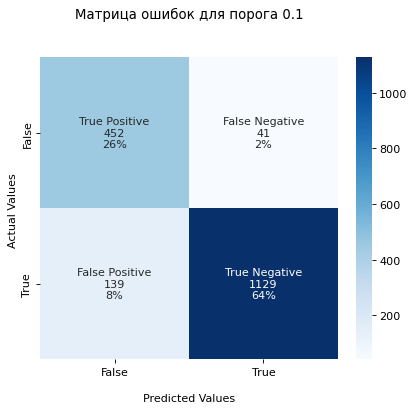

In [85]:
#comment
base64_data = 'iVBORw0KGgoAAAANSUhEUgAAAZ8AAAGbCAYAAAAbc52CAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAAxOAAAMTgF/d4wjAABIwklEQVR4nO3dd3gUVRfH8e9JoyO9V6WoNJFqBVGRJnYsFAsWFAsiggVBFLuioiigooKIvliwoFgAUVCkCEqT3ptIERIg9b5/7CQsIQmBZDcb9vfxmYfduTNzz2TXPXvv3L1jzjlERESCKSKvAxARkfCj5CMiIkGn5CMiIkGn5CMiIkGn5CMiIkGn5CMiIkGn5CP5mplF53UMInLslHwkXzGzSmY23MyWmNlOINbMSuV1XCJybJR8jpGZ/WRmzsxuSbe+kJn955XVyqv4TmRmVhGYBxQDegItgFrOuV15Gphkm5m1MLN5ZnbQzP42s05H2f58M/vGzHbo/60Ti5LP8dkEdE+37gpgbx7EEk6eAT51zt3snJvtnFvlnNuY10FJ9phZaeBbYDZwJvA+8KmZnZrFbkXwfeF4JPARSjAp+Ryfz4BmZlbNb92NwAf+G5lZeTP7xMy2mdk+M/vZzM7wK3eZLV75TWa2ycy6m9lGM4s1s7fMLMbvGOvM7Fa/5wO9Y9zqPa+R0TdGb91Ffs9fMbM1Zrbf69K6Nqs/gJlFmdnzZvaPmR0wsx/MrLZf+eNmNtPveWuvzqiMYkhfbmaR3jdj/306AClmtsL75rzAzC5MF1d7M1tkZvFmtsrMeviVHfa3MLOy3rGePcq53prBa5T+ta6RwTab/MpLmNlHZrbTr3xdFnU+nsl7w/+Y2XoNzOxBb5vdZva0mZnfNrXN7Htv/3/M7IV0r9G6DGK42ivraWYLzSzOzNab2ZP++2agK7AfuMc5t9Q59wzwO9Arsx2cc9865wYBP2RxXMmHlHyOzz7gS6Ab+K5DAOcCH6fbrhDwM3Ax0ARYCnxpZgW98ore0jzd84p+xyiNr4upE77WVUcy+RZovmsffYEDx3FOO4HrgPrAa8A4M2uQxfb98SXcm4FmXp1fmlnkcdSdkZuAyunWlQFuA54CGuH7QPrazKqALwEAk7ylIfAKMMbMzkl/cDMrAkwGfgMezkY8mzj02vwvg/LUD/SzvG36pCt/BN/fqb1X/kA26pzD4e+J9MfMzmvQyIvpAnx/u7u9ffC2+wKIx/cevBHo4R3X3wPp4vjKWx8B9MP3nukF3ArcnsX5NAemu8MnlJyKr/tUwo1zTssxLMBPwFCgHbDMW9cfmAjUABy+6xAZ7RsJxALnp1tfw/dSHLH9Td7xTvVbdyvwr9/zdcCt3uMXgLHp1mUYk7fuoizOcwowKIvybcBdfs9L4ftW29F7/jgw06+8tVdnVEYx+JcDBYANwBP++3iPX0wXxx/A097jZ4E56co/Aiam+1uciq/751v/eLI4197ASr/n7wEfpNumjnfs6n6v3Sa/8m+Al9K9juuyqPOwv18mx8zOa7AfKOm3zVBgnve4Hb6EVcqvvBewI6P3Vzb+Tg8B07Io/97/b+CtuwtYnY1jZ/g+1pJ/F7V8jt8PQAkza4bv+s/Y9BuYWbTXzbHMzPYA/wGFgarHUM8+59zffs/nAKXN13/uX1dlfN9sBx3baaTtf6P5LgT/a2axwIWZxWlmJwHl8fXdA+B8F/2XA3WPp/50egN/A9MyKPs13fNZ+JIJXt2z05X/lkFMb+L74J3hnEvKRjwl8LV2s1LM+zcuk/L1QJv0r9vxOobXYJVzbrff8zl+5XXxJVX/ARu/AWUsGyMIzexsr8tus/eeeZys39uWRZmEGSWf4+ScSwY+BF7C9yEwJYPNBuDryhiIr1vuDGAPcCy/TcnuPS8GA+Occ+uO4dgAmNl5wFvAOHxdhGcAP3JsceaW4vi+QWfUtbgng3WWyeOsVAGuAR4zs1OysX11fC2ArFQEEvB1X2bkSXyt3h3eB/Xr2Qs1x7J6/xx3MjCzYvi6LdcCV+EbQPAsWb9ntgPl0q0rC/xzvHFI/qXkkzPvA+cBHznnEjMob4mvy+dT59xifH3rJY+xjuJm5v9Nthmw0znn/yFXG9+H6dBjPHaqFsBS59yrzrkFwBog0w9l59x/+D5IWqau874p18XXYsmJB/C1SOZlULYCODvdurOBZd7jv/1j8pyVQUw3OOc+AcYDo7MR01n4WlhZaQL85ZzL8MPeObcFGAmsxvcaDslGvZk6htegtpmV8HveDF/rCG+72ulaOWfh63Y72vD1uvhahAOcb+ThCo7eop8DtPYf8AC0wTfoQMJMViNT5Cicc3+ZWRl832gzshpoZ2Znes9fBA4eYzUHgTfN7H58F9yHACPSbdMbeNk5tz2L48T4DXRIFe19EKwG6prvNxcrgXuBCkeJ61VgsDdiaz2+YdDrge/8tjG/OlNH6BU4yoio3mR+Afo1YLSZ/YXvA6sncBrQ2St/E7jfzJ7AN/KwLXA1cH6646R2Qz0ILDOzW5xzY9JXZr5RhV3wdetNNbPUv0khINLr+orF982/H1kMBzazOsBw4BLn3LKMBkEch+y8BsnA22Y2yDuPezk0cOF7fC2X98zsEXzJYwi+gRpHswFIBO4ys4/w/a0vJ+vuyfH4uuZeNbM38b1uLYE7Ujcws7HAZufcw97zokAtoJK3yWneug3ZSJASyvL6olN+W/AGHGRSVgO/i6L4uhS+xXfRdy2+0WSbgJsy2i+D492Uuj2wGd/1hHeAAn7brMPX1VM83br0Aw4yW2rg634Zju9DeSe+7pPxwHtZ/B2igOfxdZkcwNdNV9uv/PGj1Ju6pB9w8JbfMVLX+Q9SGABsxNfF9QfQJl1c7YFFXvkq4MbMXh9v3ZXALqB8BueYWn9my3v4RuStx5d4LP1r5z0uCCwEHvQrz40BB9l5DWbi68b8F1+35bPp4qyN7/rlAe84L6T7e68jkwEHHHp/xuH7+cGDWZ2Tt09LfL/bicfX8ro0g/+/3vN7ntlrcFNW9WgJ/cW8F1hCkJndhC/RVQnQ8X/E98GyLhDHz+/MrDXwuHOudQZl3fAlzpuCG1X2mdnj+GI8N69jEUlP13zCWwLZH9AQjhLwtYoycgDf6EUROQ665hPGnHMd8jqGUOac+xVft1xGZZ8CnwY3IpETh7rdREQk6NTtJiIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQafkIyIiQReV1wEczZi5G1xexyAnlhsaV8vrEOQEUzAKy43jFGp8d44+7w4seD1X4giGkE8+IiJhw8KnMyp8zlREREKGWj4iIqHC8k2vWY4p+YiIhIow6nZT8hERCRVq+YiISNCp5SMiIkGnlo+IiARdGLV8wudMRUQkZKjlIyISKtTtJiIiQRdG3W5KPiIioUItHxERCTq1fEREJOjCqOUTPmlWRERChlo+IiKhQt1uIiISdEo+IiISdBHhc81HyUdEJFSo5SMiIkEXRqPdlHxEREJFGLV8wudMRUQkZKjlIyISKtTtJiIiQRdG3W5KPiIioUItHxERCTq1fEREJOjU8hERkaALo5ZP+JypiIiEDLV8RERChbrdREQk6MKo203JR0QkVIRR8gmfMxURCXVmOVuOengbbmbrzMyZWX2/9eXMbIqZrTSzxWZ2rl9ZYTObYGarzGyFmV3pVxZhZq+Z2Wqv/K7snqqSj4hIqLCInC1H9wlwLrA+3fpngdnOudrAzcB4M0vtGesHxDvnagGXAG+YWUmvrBtwOlAHaA70N7NTsxOIko+ISJhwzv3snNuUQVEXYIS3zVxgO74kBXCtX9la4GfgMr+ykc65ZOfcLuB/wHXZiUXJR0QkVOSw283M+prZJr+l79GrtNJAhHNuh9/qdUA173E1Dm8pZbcsSxpwICISKnI44MA5NwwYdjy7po8ki/JjKcuUWj4iIqEiwAMOMuKc2+mr2sr6ra4ObPAebwBqHEdZlpR8RERChPm6zo57yYGJQG8vhmZABWBmBmU1gVbAl35ld5hZpJmVwncN6OPsVKhuNxGREJHDBJKd44/AN1igAvCjmcV6o9gGAOPMbCWQAHR3ziV5u70AjDGzVUAK0NsbXAAwDmgGrEjd1jm3LDuxKPmIiISKAM+u45zrjdeKSbd+O9A2k33i8LVoMipLzuh42aFuNxERCTq1fEREQkSgu91CiZKPiEiIUPIREZGgU/IREZGgU/IREZHgC5/co9FuIiISfGr5iIiECHW7iYhI0Cn5iIhI0Cn5iIhI0Cn5iIhI8IVP7lHyEREJFeHU8tFQaxERCTq1fEREQkQ4tXyUfEREQoSSj4iIBF/45B4lHxGRUKGWj2TLu4/cAUByUhK7tm2ibJUaAJSqWJXL7hmY6/VNHvU86xYvoHCx4iQlJVK1bkMuvvFuIqOO/WWc+MIjXNTjbkqWr8Sin7+jcu16lKpYBYCV839l0/LFXHDD7bl9CpJO+4vbEFMghgIxBQBo0KgRjw1+Isvth78xktq16+S47jdHvMbIN17n3bHjObNJUwAmjP+ApUsW8+TTz+b4+BmZNvVHypYtR4OGDQFYsngRH4x9j2eefykg9eU3Sj6SLTc/PQqA/3Zs4/3Heqc995eSnExEZGSu1dny0mtp0vZykhISmPB0PxZO+5ombS8/5uNc8+DTaY8X/fw9hYqdlJZ8ajc5m9pNzs6tkOUoXnx5eK4kk+NRqXJlXhn2ImPHfxSU+qZP/ZHT69VPSz716jdQ4glTSj4B8GafbjS6oD3rFy+gaMnSNGrdgekTRnHjk28AsGPjWj556THufOUDANb8NZdfJ40nKSGBiMhILrj+Nqqe2jDLOqJiYqhStwG7tm4kJSWZnz56m7V/zQOg2mmNaNP1DiKjovlz+jfM/fZTIqOiSElJof2tfalU6zTe7NONqx94ki2rlrFt7Qp+HDuCXya+y/ldbmH/3j2sWvA7V9w3iI+e6U/jCy+lbvPzAFi/dCHTx4/ipqfeJP7AfqaNH8mODWtISkygcu3TuajH8bXE5JBvvv6K8R+MJTExEZzjnj59Oe/8VkdsN3rkG3wz+StiomMAeOX1N6hUqTKLF/3FK8NeJC4ulpQUx2239+KitpdkWNeFF7Vl7pzfmfrjD1x40cVHlH/15SQ++nA8SUlJFClShIcHDqJ27TokJiTwzFNPMnfuHEqVLEmduqeya9cuXnplOCtXLOepJ4dw4MABEuLj6dT5Mnredge//DyDn6ZPY/bsX/n804lcd0M3qlarxrAXn2PC/z7j8UGPUvPkU7jxplsA2LRxIz26Xsd3U38CYMRrrzLn99kkJSZS4+STGThoCMWLF8+lv3poUMtHcmzvvzu47pEXMDM2LP0z0+32/LOVWZ9/QJcHn6ZA4SLs3raZD596gF4vf5Dlh/jBuH2sXTSPppdcwZ/TvmH72pXc+OQIIiIi+XTYY8yb8jktOnVh2oejuPX5dyhWsgzJSUkkJyUedpxGF3RgyaypNO94DbUatwRg0c/fpZU3bNWORT9/l5Z8Fv38HQ1a+T7Ipn84iqqnNqD9rX1xzjHl7WH88cMXNGt/1XH/3cJRv/vvTet2u+Ouuzn73HNp37ETZsbmzZu4set1fPvDdKKjo9P22fvff4x9bww//jSTggULcuDAASIiIti7dy9PDhnM62+OomzZcuzevYvrr7mKMxqfSZmyZY+o28y47/4HeP7Zp2h9QZvDyhb8MZ/vvv2Gd8eOJyYmhj/mz+OR/v2Y+PmXTJz4MVu3buHzLyeTnJxMz5u6U758BcDXmhr9znvExMRw8OBBenS9jpZnnc1557ei9QVtOL1efa7v2g2AuXN+T6vv8iuu4skhg9OSzxeTPqNDp0uJjo7m7dEjKVy4MB9+/AkAo94cwZsjhjPg4dzv3s5LSj6SYw1atc3WG2nNn3PZs30LHw7te9j6fbt2UKJcxSO2n/3Vx/w1YwqGUbfZuTQ4/xImDX+Chq3aEeV9A27UugMLpn1Ni05dqH56YyaPfJ5ajVtycqPmaV1r2VWn6bn8OHYEsXt2EV2gIKsX/M6FXe8EfNeGtqxaxtxvfB8ISQkJREZFZ3U4yUD6brclixfxcP9+bN++najISHbv3sPWLVuoVr162jZFihalWrXqPDLgQc465xzOP7815StUYM7vs9m8aSO977gtbVvnHOvWrc0w+QCcfc65lCtXnkmffXrY+p+mTWX58r/pdt01aet2795FYkICc+f8TqfOlxEVFUVUVBTtO3Tkj/nzATh4MJ6nnhzC8r//JsKMbdu2sfzvv6lXv0GWf4czGp9JUlIiSxYv4vR69fn6yy8Y/sZIwHetKC4ulh+/930xSkxMpErVatn58+Yv4ZN7lHwCJaZAobTHEZGRpKSkpD1PSkzw29JRs2FTOvUakK3jpl7zOYxzkC7RmfcuvqLPYLatXcGGZX8x8YVHOe+amzj9rAuyfR5RMTHUbX4eS2ZNpWCRolSv15hCxYp71TquvH9IhklSjt+Afn3p++AA2lx4EQDnndWc+IT4w7aJjIxk3IT/8efCBcyd8zvdbujCcy8MwzlH7Tp1eXfs+GOqs0/fftx3z13c0LV72jqH4/IrrqL3Pfcdsb1zLu09lt5rrw6jdOkyfPzJ50RFRXH/fXcTHx+f4bbpdb7sSr6Y9DmxsbGULFXqUFJ2jkcGDqZFy7OO6bzym3Bq+QRteh0zK2dm53mPo8wsJlh157WTylbgvx3bOLBvLwBLZv6YVlajQRPW/jWPHRvXpq3bsvrvYzp+jfpNWPTL9yQnJZKSnMxfM6ZQvf6ZpCQns2f7FiqeXJcWHa+hbvPz2Lp6+RH7FyhUmPj9cZkev0Grdiz+5fvDutwAap15FrO/+oiU5GTA1xW4e9vmY4pdjrR3714qVaoMwNdffcHevf8dsU1cXCw7d/7LmU2acsedvWl8ZhOWLVvKGWc0ZsP69fw++7e0bf9etozEhIQjjuHv9Hr1aXxmE/738YS0da1at+HrL79g29atAKSkpLBk8SIAmjVvweSvvyQpKYn4+Hi+m/Ltofj/20v58uWJiopi3do1zP51VlpZkaJFiY3dl2kcnS+/nB++n8LEjydw+RVXHorlgjaMG/seBw4cAODAgQOsWrUyy3PKj8wsR0t+EpSWj5ldCQzzntYA6gHPAB2CUX9eK1aqDM07XMP7g3pzUpnyVDn1UPdDqQpV6HTnAL59exhJiQkkJyVSoUZtKt31cLaP36hNB3b/s4X3Bt4FQLXTGtL0kstJSUnmm9EvcnB/LBERERQqXoIOt/XLYP+OTB8/ijmT/8f5XW45orzSKacCvlF9NRs0SVt/Ybc7mfHR27z7aC/MjIjIKFpfdyslK1TOduxypP4PP8L99/WmXLnyNDrjDCpWrHTENrH7Ynng/ns5cOAAZlCtWg06X3YFxYoVY/iINxn24vO8+NwzJCUlUaFiRV557Y2j1nvPvfdz+aWH/pds0rQZ99x3P/fdcxcpyckkJSVxXqtW1KvfgC5drmPF8r+58rKOlC9fgVNPO534+IMA3NbrTh59qD/ffP0VlSpXpnmLlmnH7HRpZx579GF++G5K2oADf2XLlqNevfr8POMnBg0Zmrb+lltvZ9Qbr9Pt+i5pjfybe95GrVq1j+lvG+ryWwLJCXPOBb4Ss3nAJcCPzrnG3rolzrl6R9t3zNwNgQ9QwsoNjU/AawV5IC4uliJFipKQkMC9ve+k7SXtuPLqa46+4wmoYFTuXK2p2vuLHH3ebRxxWb7JXsG65pPinNuZLqtn3Q8gIiHt9p43k5iQQHxCPC1ank3ny6/I65Dyv3yTOnIuWMlnn5mVBxyAmV0A7A5S3SISAOM/mpjXIZxwwqnbLVjJZwDwDVDTzH4CagOXBqluEZF8Qcknlznn5plZG+BsfA3LX51ze4JR94lk5mfjmPXZWG55ZjRlq9bkw6EPsHfnPxQoVBiA+ue1TfuB54yP32HF/FlERkUTFRVNq2t7Ur1e47wMX/KBkW+8zpsjXuOTSV9Ru3Yd3h49ki+/+JwN69fz6utv0qp19ofpy7FT8sllZlYV2O6c+9bMzgG6mdn7zrnMx1zKYbatXcmWVcsoXrrcYesv6tE7bWYCf1VObcDZV3QjOqYA/6xfzYdP9ePu1z8mKiZsRrjLMVq2dAl//bnwsNF1zVuexSXtOvD4oEfzMLLwEU7JJ1i/8/kCiDCzysBHwDnAmCDVne8lJSbww/uv0fame474MWlmTmnUnGhvypayVWviUlLYv+/I34uIACQkJPD00Cd45LHBh30ANmzY6Ijh0BJAlsMlHwnaDAfOuYNm1hEY5ZwbamaZT3gmh5n56fvUO+fCDGcSmD5hNDM+focylavT6tqeGW7z18/fUaJ8RYqXznh6FZERr71Kx06dqVKlal6HImEiWC2fAmZWALgYmJ7VhmbW18w2pS7fjX8rOBGGqM0rl7J1zQoaX9T5iLJOdw7gtufHcMszo6lStz6fvHjkJIvrFv/BrM/H0bm3uk0kY38uXMCSxYu49vob8jqUsBdOMxwEK/lMALYB1YBfzawisD+jDZ1zw5xzVVKXS7reltFmYWPjsr/YtWUDI+/vzpt9urFv1w7+9/zDrP5zTtr1HzOjSdvL2bNja9oUPgAblv3JN2+9yNV9n6R0JX2jlYzNmzuXdWvX0KHthbS/uA3bt2/jztt7MvOXGXkdWtgJp+QTrNFuQ83sdWCvc86Z2T7g6mDUnd+17HwdLTtfl/Y89T48pStVI+6/3RQ5qSQAy+f8QpHiJdMm/dz49198PfI5rrr/CcpVPyVPYpf8oedtt9PztkN3rc3Nu6XKscln+SNHApp8zOz0dKsqpcvOmoXyOCUlJvDJi4+SlJiIRURQuGhxrup76PbL3771EsmJiXwz+oW0dZ3ufIiyVWvmRbiST73z1ig+mjCe3bt2MejRh4gpUICPP5lEqVKl8jq0E1J+a73kREDndjOztVkUO+fcyUc7huZ2k9ymud0kt+XW3G51+k/J0efdiufb5ZvsFdCWj3NOX7NFROQIQRtqbWaRQHWgYOo659zSYNUvIhLqwqnbLVgzHLQH3gZKA3FACWADoJZRFpISEvhyxFP8u3k90TEFKHJSKS655T5OKlsB5xyzPhvH0t+mERkVTaGixblh4EsAzPr8A5bN/omYgoW47J6BnFSmPACTRz1Pows6UKVO/bw8LQkR8fHxDOh3P6tXr6ZQwYKULlOGgYOHULlyFZ4cMoiFCxZQsmRJXh4+gmLFiuGco3ev23j40UH64WmAhFHuCVrL5yl887pNcs41NrNuQNY3dBcAGl3QgZMbNcfMmP/9JKa88zLXPvQc87/7nB2b1tLz2beIjIomdvdOAOL3x7F01lR6Pv82S2dNY/73k2hzwx2sXTSP6AIFlXjkMFddcy3nnnc+ZsaE8R/wxOOD6Nf/IdavW8enk75i5Buv8/WXX3B91258OvF/NGveQokngCIiwif7BOt3Ps45tx4v2TnnPgBO7Jux54KomBhOOaNFWlO8Uq3T2PPPNgB+nzyR1tfeSmRUNABFS5YGwCIiSElJISUpmcT4g0RGRpEYf5BfPx9Pqy498+ZEJCQVKFCA885vlfb+atioEZs3biQ6KorEhARSUlI4cOAA0dHR7NjxD1O+nUz3G2/O46hPbGY5W/KTYLV8Er1/N5nZpcB6oEqQ6j5hzP9+ErXObEn8/jgO7PuPFfNmsXzuLwA0a38Vp7VsTUzBQjRrfxXjHr+HIieVomOv/vzy6fs073gNBQoXyeMzkFD24fhxtGp9ATVqnkyz5i247uorqFa9Or3uuptBAx+mb7/+REUF7TJxWNI1n1xiZm845+4CXjWzK4CB+CYWLQHcF8i6TzS/ffEhu7dt5pKH7yMpIYHkpESSEuPpMeQ19v77D+OG3EuZytUpW7UmZ17cmTMv9k3Hs23tCvbt+peaDZvy/XvD2b93D1XqNqDpJbrrpBzy9uiRbFi/noHvDAHg7vvu5+777gdg+rQfqVixIpUqV+axRx8mLjaWtu3a0659h7wM+YQURrkn4N1uLQGccxOAx5xz851ztZ1zZZ1zHwa47hPG75MnsmLeTK558GmiCxSkULHixBQsRL1zLgKgeJlyVK5dj21rVxy2X0pyMtMnvMWF3e5kyaypFC5WgsvvHcTKebPY88/WvDgVCUHvv/sOU3/8nhEj36JQoUKHlcXGxjL2vXe5s/e9fDD2fZo2bcbzL73MqDdHcPDgwTyKWHLCzC4xs/lmtsDMFpvZjd76cmY2xcxWeuvP9dunsJlNMLNVZrbCzK7MaRyBTj6WyWPJpjnffMKy36Zz7UPPUbBI0bT1p511AWv+nAvAwbh9bF2znLJVT06370ROP+sCipYoRWL8wUNfq8x8zyXsjX3vXb79ZjKj3nqX4sWLH1H+yrAXuL3XXRQqVIgDBw6kzSGWlJREYmJiBkeUnAj03G7m2+hD4GbnXGOgEzDKzIoBzwKznXO1gZuB8WaW2jvWD4h3ztUCLgHeMLOSOTnXQHfgFjCz0/AlHv/HgH7nczR7d+5g+oejKFGuIhOe6gdAZHQMPYa8xvldbuGb0S+yYOpXAJx16XVUqFk7bd/d27ewYdlfXPPgUwDUO+dCPn/lcd6Z8zOVa9fTNDvC9m3beOmFZ6lStSq33twDgOiYGMZ/NBGABX/MJz4+gbPOPgeA667vyoAH+/LuO2/R6dLOFCtWLM9iP1EF8ZpPCe/f4sBOIB7ogvfzF+fcXDPbDpwL/ARcC9zkla01s5+By4D3jjeAQE+vsw7IrAJNryN5QtPrSG7Lrel1znh8ao4+7/4cctEDQF+/VcOcc8P8tzGzC4GP8f3msiRwJbAA2OicK+y33f+Ar51zY73JoE9xzv3jlT0PxDrnnuA4BXp6nRqBPL6IyIkkpy0fL9EMy6zc60Z7GLjMOTfLzJoBk4CGHNlQSB+My6LsmAXrdz4iInIUQfidzxlAJefcLPB1rwFb8CUfzMz/dsfV8c1Eg/dvjUzKjouSj4hI+NgIVDGzugBmVgs4BVgBTAR6e+ubARWAmd5+/mU1gVbAlzkJRL8YExEJEYEecOCc225mdwCfmFkKvu6zu5xzm81sADDOzFYCCUB351ySt+sLwBgzWwWkAL2dc7tyEouSj4hIiAjGYDfvd5cTMli/HWibyT5x+Ea85RolHxGREKHpdUREJOjCKPco+YiIhAq1fEREJOjCKPdoqLWIiASfWj4iIiFC3W4iIhJ0YZR7lHxEREKFWj4iIhJ0YZR7lHxEREJFOLV8NNpNRESCTi0fEZEQEU4tHyUfEZEQEUa5R8lHRCRUqOUjIiJBF0a5R8lHRCRUqOUjIiJBF0a5R0OtRUQk+NTyEREJERFh1PRR8hERCRFhlHuOPfmY2UlAVefc4gDEIyIStsJpwEG2rvmY2RQzK2FmRYE/ga/N7InAhiYiEl4iLGdLfpLdAQflnXN7gA7AF0Bt4PIAxSQiEpbMLEdLfpLd5BPt/Xs+8INzLhFICUxIIiJyosvuNZ/FZjYFOBXob2aFAxiTiEhYymeNlxzJbvK5CWgH/Omc229mlYGHAhaViEgYMsIn+2Qr+TjnDprZOuAsYC2wH9/AAxERySX5bdBATmR3tFsv4H3gSW9VKWB8oIISEQlHGnBwpDuAlsBeAOfcaqBcoIISEQlHZjlb8pPsXvNJcM4dSJdZkwIQj4hI2Aqn6XWy2/LZYWZ1AAdgZt2BjQGLSkRETmjZbfn0AT4E6noDD/YDlwYoJhGRsBRGDZ9sj3ZbZWYtgbqAAcudc8kBjUxEJMzkt0EDOZGt5GNm1byHcd6/lc0M59yGwIQlIhJ+wij3ZLvbbT6+6z0GFAQKAzvRiDcRkVwTTgMOstvtVtb/uZldCZwRiIBERMJV+KSe47yNtnPuM+CCXI5FRCSshdOPTLN7zcd/ItFIoAVQPiARiYjICS+713xiOXTNJxlYBdwbqKBERMJROM3tlt1rPsfVPSciItmX37rOciK7LR8REQmwMMo9WScfM9uBN6VO+iLAOec01FpEJJeo5XNI06BEISIiuuaTyjm3PliBiIhI+MjuUOtTgFeARvhmOABA3W4iIrlH3W5HehsYCZwMdATuAdYFKCYRkbAUPqkn+zMcnOSc+xhIcc4twndn04sDF5aISPiJMMvRkp9kN/kkev/uM7PqQAGgemBCEhEJT8G4jbaZFTCz181spZktMbMPvPXlzGyKt36xmZ3rt09hM5tgZqvMbIU3v2eOZLfbbYaZlQJeB+YB8cDEnFYuIiKHBOmaz7NAClDHOefMrKLf+tnOuXZm1gz4xMxOcc4lAf2AeOdcLTOrCfxmZtOdc7uPN4ij/c7nc3zXex5yzqUAH5rZL/i64RYfb6UiInKkQOceMysC3AxUcc45AOfcVq+4C1DTWzfXzLYD5wI/AdcCN3lla83sZ+Ay4L3jjeVo3W6/AM8AG83saS8LblTiEREJPWbW18w2+S19021yCr57sQ00s3lm9ouZXWhmpYEI59wOv23XAak3Eq0GrM+k7LhkmXycc8Occw2BK4CSwFwz+8nMuptZwaz2FRGRY5PTAQfeZ3YVv2VYuiqi8Y1aXuqcawrcDXyErxcs/Ww26dthLouyYz/X7GzknJvjnLsTqAS8BdwPbM16LxERORZBGHCwHt/1nvEAzrk/gbXAab76zf/GodWBDd7jDUCNTMqOS7ZnqzazSKAdvr6/U4Avc1KxiIgcLtA3k3PO/QtMBS7x6quO7zrPcnyDyHp765sBFYCZ3q7+ZTWBVuQwBxx1tJuZ1QN6Al3x9fONAbo55/bmpOLsale7QjCqkTBSstndeR2CnGAOLHg9V44TpHvX9ALGmNlz+O7PdrtzbquZDQDGmdlKIAHo7o10A3jB22cVvpZTb+fcrpwEcbTRbnPxNa/GAxd5PzAVEZEACMZQa+fcGqB1Buu3A20z2ScOX69Xrjlay+cFYJJzLiE3KxURkfB2tFmt/xesQEREwp1uqSAiIkGn5CMiIkGnWyqIiEjQqeXj8Ua7pf/VaxrnXPNcj0hEJEyFUcPnqC2ffkGJQkRE8t09eXLiaKPdZgQrEBERCR/ZuuZjZmWAwUAjIG1CUXW7iYjkniDNcBASsnuuY4BN+Ob6eRL4B/guUEGJiISjYNzJNFRkd7RbNedcZzPr6pz7ysy+A74NZGAiIuFG13yOlDq9Trx3O+09QJWARCQiEqbCKPdkO/ks95LOB8Bs4D9gQcCiEhEJQ/qdTzrOue7ew1fNbD5QAnW7iYjIcTrmGQ6cczOPvpWIiBwrXfNJx8xSyGCmA+dcZK5HJCISpsIo92S75VPM73EhoAcQk/vhiIiEr3C65pOt3/k45+L8ln+dc8OAdgGOTUQkrFgO/8tPjmtWazOrDVTN5VhERMJaOLV8snvNZweHrvlEevvdF6igRETCkZLPkZr6PU4CtjnnkgMQj4iIhIHszu3W3Tm33ls2O+eSzWxgQCMTEQkzZpajJT/JbvK5MpvrRETkOEVYzpb85Gh3Mr0YaAtUMrPn/YpOCmhUIiJhKJ81XnLkaNd8EoBYfIMN4vzWbwWeCVRQIiLhSDMceLw7mc4ws0nOuT+DFJOISFjKb11nOZHdaz73mFnp1CdmVsbMRgUoJhGRsBRON5PLbvJp4pzbmfrEOfcv0CwwIYmIyIkuu7/zOWwCUfON6SuQ++GIiISviHw2RU5OZLfl87uZvWpmlc2sCvAK8FvgwhIRCT/qdjvSA/hmtl4AzAeKAH0CFJOISFjS73zScc7tBW5JfW5mkcClwKTAhCUiEn401DoTZlYXXxK6EdiMko+ISK4Jo9xz9ORjZoWBLsCtwMn4biZ3rnNuSYBjExGRE1SW13zMbDSwEbgceB6oBuxR4hERyX0RZjla8pOjtXyuxzfAYBQwxTnnzMwdZR8RETkO+Sx/5MjRRrtVBD4ABgEbzOwpIDrgUYmIhKGIHC75SZbxOudinXNvO+fOAtoBBYEYM/vVzO4KSoQiImFC9/PJgHNuiXPuAaAyMAzoFLCoRETCkOVwyU+Oaag1gHMuCfjEW0REJJfkt0EDOZHfuglFROQEcMwtHxERCYzwafco+YiIhIww6nVT8hERCRX5bcRaTij5iIiEiHC6CK/kIyISIsKp5RNOiVZEREKEko+ISIgI5o9MzWywmTkzq+89L2dmU8xspZktNrNz/bYtbGYTzGyVma0wsytzdqbqdhMRCRnB6nYzszOBlsAGv9XPArOdc+3MrBnwiZmd4k0s0A+Id87VMrOawG9mNt05t/t4Y1DLR0QkRARjYlEzKwCMAO4C/O9S0MVbj3NuLrAdSG39XOtXthb4GbjsOE4xjZKPiEiIyOnEombW18w2+S19M6jmCeADL4mk1lsaiHDO7fDbbh2+e7jh/bs+k7Ljom43EZEQkdNON+fcMHwTP2d8fLOzgGbAQxntfpRwXBZlx0wtHxGREGGWsyUbWgGnAmvNbB1QBfgOaO6r38r6bVudQ9eENgA1Mik7Lko+IiJhwjn3rHOuknOuhnOuBrAJuMQ59y0wEegN4A04qADM9Hb1L6uJL4l9mZNY1O0mIhIiIvJ2atEBwDgzWwkkAN29kW4ALwBjzGwVkAL0ds7tykllSj4iIiEi2BMceK2f1MfbgbaZbBeHb8RbrlHyEREJERZGN1VQ8hERCRFhNLWbks/xuu7yS4iJiSEmpgAAp9dvSN+HBmW5/TMvvU7NU2rnuO733nqDLz79mNJlypKUmEjNWrXpO+AxihU/6ZiP9cJTg7mkQ2caNm7CzBlTKV2mHKfVawDA8mVLmDhhLAOfeC7HMUvmZn/kG/UaEx1J7WrlWLJ6KwAr122n+0Pv5np9o4d0o0u7Jpxx5VDWbd4JwDP3X0Hs/nieGvVNrtcH0O3SFsz+cy2rNvwDQMdWDTin8Sk88sqkgNSXX+XxNZ+gUvLJgSHPDMuVZHI82ra/lDvv60dycjJPPPog494dzV33PXjMx3nw0SFpj2fOmEbd0+qlJZ+6p9VT4gmCltc9C0C1iqWYNb5/2nN/kZERJCen5FqdW3f8x5C7L+XGh9/LtWNmpXvnluzcE5eWfCbPWMTkGYuCUreEJiWfXPTjd5P59OPxJCUm4pzj1jvvpeU55x+x3bgxo/jxu8lER8cAMPSF4VSoWIm/ly5m9OsvExcXi3OOrjfdRqs2F2dZZ2RkJI2bNuf3X38BYMK4MXw3+UsiIoyTa9WhT/+BFC1ajF9/+Yl3Rg7HLILk5GR69rqHc1u1oc+dN3Nt15swM3795Sfmz5nN5C8+44prrqdylWq8OfxFRr3/MS88NZjqNU6mS9cbAdiyeSN339qd/331AwBjRr3OgnlzSExMpFr1mvR96DGKFiuee3/cMPT35CGM+exX2rSoy9Yd/zHms195pu8VnNv1eQBOP6Uinw3vxakdBwNw0Vmn8fBt7ShYIJrk5BQefuVzZv2xOsNjvzVxJndd34ozTq3Cwr83HVHep/uFXNW2MZGRkWzfuZd7hk5g0/Y9FC9akFGPd+O0kyuwdcd/bPnnP/7ZtY+HX/6c1s3r8HjvSykQE0V0VCSvjpvGuC9nc9MVZ3Hm6dV4qf/VDO7dicGvf0nZksXocH59bnjwHSaPvJu3Js5k0tSFAJzftDbP9r2Ss294jqKFC/DcA1fSsE5lCsREM/uvtfR97n8kJeVeIg4l6naTbBn8cN+0brcbb72TZi3P4cK2HTAztm3ZzN23deejL74jKio6bZ99e//j4/Hv8+nkaRQoWJCDBw8QYRHE7tvLsGef4JlhIyhdpiz/7dnNHTdeS4NGjSlVukymMcQfPMisn6dzev2G/P7rL0z5ehIj3v6AosWK8+LTj/P2G6/Sp/9A3hn5GvcPGET9hmeQkpLC/rjYw47T8pzzOfu81tQ9rR5XXHMDAAvnz00rb3/pFQx7dkha8pny9Rdc1K4jUVHRfPDeWxQqVJg3350AwNh3RvLu6De454GMfkQtx6JqhZK0u304AOc1ybyVXaNyaR69oz2de7/BvriDnFy1DD+83Ye6HQdl+EG9/2ACT4+ewtD7LqfTna8fVnZtu6bUql6OVje+REqK4/qOzRj2UBe63D+aR25vz+69+znjyqGUKFaI3yYMYNLUPwFYuGwjbW4eRkqKo2Txwvw2YQA//LqU9z7/jes7NOeVsVP59pfFgK8bLtXYSbPp3rllWvLpcVlLxn05G4Bn+17JzD9W0ftJ33vrjUE3cOe1rXht/PTj/IuGNiUfyZb03W7Lly3hqUEPseOf7URGRvLfnt1s37qVylUPTYFUuEhRqlStxlODH6Zpi7M465zzKVu+An/M+50tmzcxoM+dads659iwfm2Gyef7b7/ij3m/A9CocVNu6NGTd0a9xkWXdExrcVx21bU8ObA/AGc2a8GIl5/j/DYX06zF2dSqc+oxnWv9hmeQlJTE8mVLqHPq6Xz/7Vc885LvQ2vWjGnExcUyY5qvFZSUmEilKlWP6fiSsdQP4aNpe/bpnFy1LD+80+ew9VXKl0y7rpPee5N+5d5uF9CmxeHvhUsvaMiZp1fj1w8HABAZEUFyii+Bnd+0Dg88NxGAPfsO8NX0v9L2K1WiCCMHd6VW9XIkJadQukRRTjulItv+3Ztl7JOmLeTF/ldTvnQx4g4k0P68+vR/8bO0WJo3qMF93S8EoFCBaBISk7I6XL6m0W5yXJ4Y+CB33vsA57by/Y/S+eJzSEiIP2ybyMhIRrwzniV/LWThH3O5q2dXHnvyeZyDU2rV5tVR72errtRrPv6cc0dOye497d2nP2vXrGLh/Dk8M+RRLmrXkeu733JM59eu42VM+XoSsbH7KFmyVFridc7Rp/9Azmza4ihHkGMVu//Q+yc5OZnIiEOvb8ECh1rUZsYPvy7l1sfGZfvYKSmOwa9/xZP3duaX+Sv9jgXPvj2FsV8cmfjMwB0xBZjPa49exzczFnNdv7cB+PXDARSMic5wW3/xCUl8PnUh13dozu59+5n++3J2/ReXVl+XvqMzTaAnmojwyT2Bn17HzCLNrEag6wkFsXv3UqFiZQB++PYr9u098hvf/rg4du/aScPGTejRsxcNGp3JyhV/U79hIzZt3JDWmgFYteJvEhMTs11/0+ZnMe2Hb9kf5/sf9+tJn9CkWUsANqxbQ82Ta3HFNTdw2VXXsmzxX0fsX7hIUeJiY49Yn+qSjpcxY+r3fPXZ/2jX6fK09Wef15qJH47l4MEDABw8eIC1a1ZlO27JnnWbd1KjcmlKnVQEgBs6Nksr+3H2Mi4++3ROP6Vi2rqm9aof9ZhfTPuTxKRkLmvTKG3d1zMWcXuX8ylZvDAAUVERNKpbBYCf562kayffl4yTihaiU+uGafuVKFaYDVt9P3o/58xTaFinclrZ3riDnFS0YKZxjJ30G906t6BH55aM9WvtTZ6xiH43tyUyMsKroxAnV828Gzq/sxz+l58EtOVjZucBE/BNx1DNmy/oXudc90DWm1fu7juAx/r3oUzZctRr0IjyFSoesU1c7D4GP/wABw/ux8yoXKU6l3TsTNGixXj6pdcZOfwlRrz8PMlJSZSrUJGhz7+a7fpbnH0ea1avpPet3TAjbcABwFtvvMrGDeuJjo6mQMGC3O+t99e2/aU8+8RAfpr6fdqAA3+ly5Slzmn1+G3Wz/R75PG09Tfc2JP3336Tu265Ia3ldV33W6h5cq1sxy5Ht2XHf7wydiqzxj/I+i27mPnHoQS/esMObnn0fd4cdAMFC0YTExXFwr83cvOjR29JP/rKJH4cc3/a8wmT51L6pCJ899Z9OBxRkZG8P+k3/ly+iadHfcvoId3449NHWb9lF78tXMN/sb4vHY8N/5JXH+lCv5svZtmabcxdvC7tmGM+ncWzfa+gz40XMfj1I6cEm7fEN1t/jcql+fG3ZWnrH3zhU4bedxm/f/QQKSmOxKRkBg7/gjUb/z3mv19+EE7XfMy5jJvQuXJws9+AbsAnzrnG3rolzrl62T3Glj0JgQtQwtIpF2R0ixPJjqioCCIjIohPSKJYkYJMHXM/A4Z9xvTfl+d1aHnqwILXcyVtTF++M0efdxfULZ1v0legr/lEOedWp7sOkRDgOkUkQEoWK8yk1+8iMjKCQgWi+ejbuWGfeHJTfus6y4lAJ5+DZlYU7yZEZlYPOBjgOkUkQHbsjuUc73dGkvvCacBBoJPPk/huVFTJzN4D2uHrhhMRkXTU8sklzrnvvXtDtMM36Heoc07DoI7R8Jee4ddffmL71i2M+fCztCHOzz0xkBXLl2IWQVRUFLf17pM2um3ThvW88sJQdu/aRXJyMj169qLNxe3y8CwkL73U/2o6tmpA9UqlaXL1Uyz15o978Ja2dLu0BbWqleXqPqPTfgQKMOTuS+l8QSMSkpJISEhi4PAvmTF3BQDlShVj+CPXcnLVssRER/L2JzN5/cOf8uLUTijhNOAg4L/zcc6tBd4MdD0nslZtLub6bjdzzx03Hra+9/39035QumrF3zxw921M+u5nzIxnnxxIp8uuol2ny9m181/uvPl6GjRqTNly5fPiFCSPffbjAoa99yNT373/sPU/zVnOJ9//wcjBXY/YZ9aC1Tzz1hQOxifSoE5lvnvrPmpe/AjxCUk898CVLF61hev6vU2RQjFMf+8Bflu4hvlLc3Rn5bAXRrknsL/zMbO1ZrYm/RLIOk9EjRo3pWz5Ckes9587LXbfvsN+YLp65XJanH0eAKVKl+GU2nWZ/uOUwAcrIWnWH6vZ/M+eI9bPXbyetZsyHrb8/aylHIz3/c5s8cotREYYZUoUBaBBncpM+WUJAHEHEpj5xypu6NQ8MMGHkQizHC35SaBbPp38HhcEugO7A1xnWBk94mVmTP2effv28sSzr6QloFNPq88PU76myw03snnTRpb8tZAKlSof5WgiGetxWUvWbPo3LYHNX7KBa9s3Zf7SDZQpUYSLzjqN5eu2522Qkq8EtOXjnFvit8x3zvUBjpzm2Y+Z9TWzTanLqBGvBDLEfO/23vcz/rNvGfzUi4x87aW0GREGDBrK0kV/cmu3qxn12kuc2bwlUVGaTUmOXevmdXj09vb08Lu30EPDPqNYkYL8NmEAbz/Zg5/mriApKTkPozwxWA6X/CSon0ZmVhKomdU2zrlhwLDU5/qRafY0aX4Wr774NGtWraDuafWoULESjz+T9mek/329aNri7DyMUPKjc5vUYvTj3biqzyhWrv8nbf3uvfvpNWR82vPhj17HsjVb8yLEE0t+yyA5EOhrPnPNbI63zAdWA28Hss5wkZyUxKYN69OeL1uyiD27d1Gpsm8Orl07/yV19oo5s2exfu1qLmrbIU9ilfzpnDNPYcyTPbjm/tEsWrH5sLJSJxUhKsr38XHGqVW4tHVDRv/vl7wI84QSTnO7BXp6nVZ+T5OAtc65LcdyDLV84JXnhzLr5+ns2rWTk04qQaHChXl3wiT69u5JXGwsERERFCpUiFt63ZM2s/TkLz7lw7HvEBkZSenSZbm338N5dtfVUBOO0+u8/FAXLm3dgPKli/Pvnjji9sdT/7Ih9LulLb26nEeZkkXZFxdPfEIiLa9/jn93x7Loi0EUK1LwsFsi9Bw4liWrttD2nNMZ1v8aEpOSid1/kIdezvzGdeEgt6bXmbPmvxx93jU/+aR8k4EClnzMLBJ4L6eTiCr5SG4Lx+QjgZVbyWduDpNPs3yUfALW7eacSwY0vEpERI4Q6AEHP5rZm8C7QNqNYpxzSwNcr4hI/pNv2i05F5CWj5lN8B7ehm9qnY+Byd7ydSDqDAdzZs/i9h5duK37Ndx8/RVMmfwFAMOefYJbbriCvnf1JDZ2H+C7u+iAPr3YvGljXoYsISgmOoqXB1zDoi8GMf+TRxkztMdh5V0vbcGBBa/T/rz6aeseuq0d8z95lBnvP0C1iiXT1o8e0o2zGp0ctNhPdOE04CBQLZ9TAZxzWQ6rluxzzvHUYwMY9sY7nFK7Ltu2bKbHtZ2pU/c0Nm1Yz5gPP+f9t9/kh2+/4oprbuDrSZ9wRpPmVK5SNa9DlxAz9N7OpDhHg8ueAKBCmUMzZVQuV4JbrzqH3/9am7auWJGCXN+hGY2vGsp1HZpx53Wtefjlz7mw5anEHUjgtz81aUluyWeTFORIoK75aJBAgKS2bOLiYjnppBJERUeTkJhASkoKBw8eICoqmp3/7mD6D1Pocn2PoxxNwk3hgjF0v6wlg147dDdR/9Fsrz92Pf1f/JT4hKS0dcnJKURGRBAdFUmRQjEkJCZRqGA0D9/W7rDjSM7pR6Y518DM/slgvQHOOVcuQPWesMyMQU+/yKAB91OoUCH27d3LE8+9TLXqNWncpBm39+hClarVuPHWO3nuyce4456+RGpGA0nn5Kpl2LUnjodua8cFLU7l4MEEho76hp/mrOC2a85l2eqtzF28/rB99h9MYPgH05gxth/b/93LbYPGMejOTrwybir74nR7rlyV3zJIDgTq02kFoF805qLkpCQ+fP9thr4wnAaNGvP30sU81v8+3hn/GT173UvPXvcCMHPGNMqXr0iFSpV57omBxMXF0fqiS3Q7BQEgOiqSk6uWZdmabTw2/Esa1KnM5JF3c8Xdb3LzFefQ5uZhGe43euIvjJ7o+xFp49OqUrl8Cb6ftYyXH+pCuVJFmbVgNW9MmBHMUzkh5bfrNjkRqG63eOfc+syWANV5Qlu1cjk7d+ygQaPGAJx6en1KlynL6pWHbmEcFxvLxA/f56bb7+LTCeNodGZTBj/1AmPfGUn8QX1DFdiwdRfJySl89M1cABat2Mz6zTupVa0cFcuexMLPBvL35CE0b1CDNwffwM1XHD4lU2RkBE/3uZwHX/iE6zs249/dsXTtP4bOFzSiRuXSeXFKkk8FquUTPuk7SMqWK8+Of7azYf1aqlWvyeaNG9iyeSNVqlVP22b0iJfpfssdFCxYiAMHD/iuXpqRnJREYlIiBSiYh2cgoWDnnjimz1nOxWefxnczl1KtYkmqVy7NjHkrqHnxI2nbfffWfbwyduphN5cD6NO9DR9Pmcf2nfsoUigmbQon5xxFChUI6rmciMJpwEFAko9zrnEgjhvOSpUuQ9+HBvH4w30xiwAcfR4cmHZzuEV/LiAhPj5t8tDLr76eoY/156OxY7i4fSeKFi2Wh9FLKLnnqY8Y9Xg3ht57OckpKdz95ITDBh1kpmaVMpzXtDaX3+27N+SEyXP5eNhtXHlxY35buIYlq45p5izJQBjlnsDO7ZYbNL2O5DZNryO5Lbem1/lz474cfd41qlos3+QvDYcSEQkR4TTgQMlHRCREhNM1n4Dez0dERCQjavmIiISIMGr4KPmIiISMMMo+Sj4iIiFCAw5ERCTowmnAgZKPiEiICKPco+QjIhIywij7aKi1iIgEnVo+IiIhQgMOREQk6MJpwIG63UREQkSgb6NtZgXNbJKZrTCzhWY2xcxqeGXlvOcrzWyxmZ3rt19hM5tgZqu8fa/M6bkq+YiIhIpAZx+f0UBd59wZwNfec4BngdnOudrAzcB4M0vtHeuH7yahtYBLgDfMrOTxniYo+YiIhAzL4X9H45w76Jz7xh26l85s4GTvcRdghLfdXGA7kNr6udavbC3wM3BZTs5VyUdE5ARhZn3NbJPfcrSbV90LfGVmpYEI59wOv7J1QDXvcTVgfSZlx0UDDkREQkROBxw454YBw7JXlz0C1AZ6AYWA9DeySx+Ny6LsmKnlIyISIoJzyQfMrB9wJdDeObffObfTW1/Wb7PqwAbv8QagRiZlx0XJR0QkVAQh+3hdcdcDFzvn9vgVTQR6e9s0AyoAMzMoqwm0Ar48nlNMpW43EZEQEegfmZpZFeAlYA0w3Xz9fPHOuRbAAGCcma0EEoDuzrkkb9cXgDFmtgpIAXo753blJBYlHxGREBHoH5k65zaRSRvJObcdaJtJWRy+EW+5RslHRCREhNEEB7rmIyIiwaeWj4hIqAijpo+Sj4hIiNCs1iIiEnThNKu1ko+ISIgIo9yj5CMiEirCqeWj0W4iIhJ0avmIiISM8Gn6KPmIiISIcOp2U/IREQkRYZR7lHxEREKFWj4iIhJ0+pGpiIgEX/jkHg21FhGR4FPLR0QkRIRRw0fJR0QkVGjAgYiIBJ0GHIiISPCFT+5R8hERCRVhlHuUfEREQkU4XfPRUGsREQk6tXxEREKEBhyIiEjQqdtNREQkgNTyEREJEeHU8lHyEREJEeF0zUfdbiIiEnRq+YiIhAh1u4mISNCFUe5R8hERCRlhlH2UfEREQkQ4DThQ8hERCRG65iMiIkEXRrlHQ61FRCT41PIREQkVYdT0UfIREQkRGnAgIiJBF04DDsw5l9cxSC4xs77OuWF5HYecGPR+kkBS8jmBmNkm51yVvI5DTgx6P0kgabSbiIgEnZKPiIgEnZLPiUX985Kb9H6SgNE1HxERCTq1fEREJOiUfEREJOiUfEREJOg0w0GIMrN1wEFvAZjtnOuVxbadnHOLgxOd5FdmttB7GAPUAVLfM8udc9fmSVASlpR8QtvVSiiSm5xzZwCYWQ1gXupzf2YW5ZxLCm5kEm7U7ZZPmNkNZva7mS0ws4Vm1iGT7Qaa2TJvm4VmVt1b38zMppnZPDP7w8yuCu4ZSCgzs3Vm9qiZTQfeN7PWZjbPr7y+18JOfX6Jmc00s/ne+/L8vIhb8i+1fELbJ2aW2u32JNDSOee8b62/mll151xi6sZmVhLoB1R0zh0ws8JAipmVAEYBHZ1zW82sDDDfzGY557YF9YwklFUD2njvsdaZbWRmJwODgXbOub1mVguYYWY1/N+PIllR8gltad1uZtYU+NbMqgBJQBmgOrDKb/u9wErgAzP7HpjsnNtkZm2Ak739U7c1oC6g5COp3nXZ++FfO6AW8LMdPg1zVWBNIAKTE4+ST/7xEdDPOTcJwMx2AQX9N3DOJZtZS+BsoDUw28yux5do/nLOqWtEshLr9zgJiPR77v9eM2CKc65HUKKSE5Ku+eQfJYF1AGbWzXt+GDMrBpR3zv3inHsSmAk0Bn4FanstoNRtzzCzmGAELvnSWqCmmZX2nnf3K/seaGdm9VNXmFnzYAYn+Z9aPvnHfcDnZrYZ+A3YkME2J+G7TlQEcPi64N53zv1nZpcCL5jZy0C0t//lQYlc8h3n3GYzexGY5w00+NmvbKX3BehtMyuEb9j2H0DXPAlW8iXN7SYiIkGnbjcREQk6JR8REQk6JR8REQk6JR8REQk6JR8REQk6JR8REQk6JR8REQk6JR8REQk6JR8REQk6JR8REQk6JR8REQk6JR8REQk6JR8REQk6JR8REQk6JR8REQk6JR8REQk6JR8REQk6JR/JETNbZ2Z/m9lCM1tqZr1z4ZitzWye97ipmY3Pxj6Pm1nMcdb3k5l1SreuoJntMrP66daXM7M4Myt/LMcTkcMp+UhuuNo5dwZwCfCUmTX0LzSzCDM7rveac26ec65rNjYdDBxX8smk3oPAh8DN6Yp6AN8557bnVl0i4UjJR3KNc24jsAKo47VExpnZZ8BCoKKZXWJmM81svpn9bmbnp+5rZkPNbJWZzQA6+a1PawV5zzua2Vwz+9NrbbUws5Fe8a/eunJmVszM3jKzOWb2l5mNNLNo7xine/X/4bWqCmZySu8A3VL389wMvGNmF5rZb2a2wMwWm1n6JJUa73tmdrff8xfN7HHvcbSZPevFuNDMPjKzEl7ZrV5LcqGZLTKzFtl5DUTyCyUfyTVm1gA4FfjTW3UB0Ms51xAogK910sE51wToCkzwPoAvBToDZwBtgDqZHL8OvoTQ1TnXCGgG/O2c6+VtcrZz7gzn3D/AS8DPzrnmQCMgCkhNAuOAN5xzZwKvecc5gnNuAbAZ6OjV3xIoAUwB/gDOdc41Bs4HBptZxWP4cwE8CMQ655p7LcclwBCv7CXgIm/9mV6ZyAkjKq8DkBPCJ2Z2ENgP3OKcW2lmAF97iQCgHVAL+NkrS1UVX5L62DkXC2BmY4CBGdRzMfCNc24FgHMuEfgvk5guB1qa2QPe80JAgpkVB+rjS0A452ab2aIszu0d4BZgkvfve865ZDMrja8FVAdIAsoA9YCtWRwroxiLm9nV3vMYYLX3eBow1sy+Ar5NPWeRE4WSj+SGq51zizNYH+v32IApzrke6TeydNkolxhwuXNuTbq6igPuGI4zHnjGzGoCXYCm3vqRwFfAVc45Z2Z/kHH3XRIQ6fe8IIf+Lgbc5ZyblsF+VwJNgNbAN2Y20Dn30THELRLS1O0mwfI90M5/9JiZNfceTgW6mFkRM4sEbsrkGN8B7b3WRuo1k5O8sn3ASX7bfgk8ZGZR3rYlzayWc24vsBhft19qDA0yC9o5twdfkvkfsMA5t8orKgms9xLP+fi69jKyGmjh1VUa6JAuxr5mVtgrL2xm9byYT/EGW7wIfAI0R+QEouQjQeGcWwl0A972BgssA+7zyr4GvsZ3rWga8Fcmx1gF9MR3regvYA5Q1yt+CZiWOuAA6IOv1bHQ2/ZHoIa3bQ/gbq+1cjvw+1HCfwdfi2eM37qHgBfMbDa+ZJnZMUYBFbyuvXfSbfcsvsEYv3sxzsZ33SsSeNcbyLAQXwto2FFiFMlXzLlj6YEQERHJObV8REQk6JR8REQk6JR8REQk6JR8REQk6JR8REQk6JR8REQk6JR8REQk6JR8REQk6P4PuXLhkXJ+/vQAAAAASUVORK5CYII='
display.Image(b64decode(base64_data))

### Резюме

Итак, проект закончен. Мы выполнили все намеченные пункты плана и научились прогнозировать возможный уход клиентов с заданной точностью.

К счастью, мы не столкнулись с особыми трудностями при выполнении проекта: заказчик предоставил нам вполне адекватные данные. Относительно небольшой размер выборки нивелировался отсутствием сильного дисбаланса классов в целевом признаке (да и в других признаках тоже). Мы получили достаточное количество информации, не содержащей пропусков и странных аномалий, что позволило подготовить качественный датасет для обученя моделей (этот этап, собственно, и явился ключевым во всем проекте).

Из трех исследованных моделей (логистическая регрессия, случайный лес и градиентный бустинг) мы выбрали модель градиентного бустинга ***CatBoostClassifier*** как наилучшую с результатом на тестовой выборке $ROC-AUC=0.9674$.